# Compound's classification based on their SMILES representation
#### qHTS for Inhibitors of human tyrosyl-DNA phosphodiesterase 1 (TDP1): qHTS in cells in absence of CPT

## Etapa 1 e 2

### Carla Rafaela Silva, pg42862; José Pereira, pg42871; Tiago Silva, pg42885.

## Introduction
Human tyrosyl-DNA phosphodiesterase 1 (TDP1) is a novel repair gene, and we propose to use it as a new target for anticancer drug development. TDP1 is not an essential protein, but under treatment with topoisomerase I poison (camptothecin: CPT), TDP1 works as a critical factor for cell survival. To directly identify novel TDP1 inhibitors active in a cellular environment, we have knocked-out the Tdp1 gene in chicken DT40 cells (Tdp1-/-) and generated a complemented counterpart cells that contains a stable transfection of the human TDP1 gene (Tdp1-/-;hTDP1 cells). For the primary screen, Tdp1-/-;hTDP1 cells will be exposed to small molecules in the presence or absence of CPT, and their growth kinetics will be evaluated after 48 hours by measuring ATP activity. If a given compound shows a synergistic effect with CPT, this compound could inhibit the repair pathway of CPT-induced lesions including the TDP1-mediated repair pathway. The hit compounds will then be evaluated in the presence or absence of CPT using Tdp1-/- cells. If a compound shows synergistic effect with CPT in Tdp1-/-;hTDP1 cells, but not with Tdp1-/- cells, such compound could be involved in the TDP1-mediated repair pathway inhibition. In tertiary assays, biochemical gel-based assays will be used to assess whether the hit compounds specifically target TDP1.

## Imports

In [1]:
import sys
import copy
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from rdkit import Chem, DataStructs
from rdkit.ML.Descriptors import MoleculeDescriptors
from rdkit.Chem import Descriptors
from loaders.Loaders import CSVLoader
from standardizer.CustomStandardizer import CustomStandardizer
from scalers.sklearnScalers import StandardScaler
from compoundFeaturization.rdkitDescriptors import TwoDimensionDescriptors
from compoundFeaturization.rdkitFingerprints import MorganFingerprint, RDKFingerprint, MACCSkeysFingerprint
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from boruta.boruta_py import BorutaPy
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectPercentile

%matplotlib inline
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

sys.path.append('src')

## Initial exploration

### Import dataset
The first step, analysing this dataset, includes loading and displaying TDP1 data.

In [2]:
file = '../dataset/TDP1_activity_dataset.csv'
dataset = pd.read_csv(file, sep=',')
dataset.head()

PUBCHEM_RESULT_TAG  PUBCHEM_SID  PUBCHEM_CID PUBCHEM_ACTIVITY_OUTCOME  \
0                   1  109967258.0   50897788.0                   Active   
1                   2  144206324.0      65628.0                   Active   
2                   7  144206329.0      92140.0                   Active   
3                  16  144206459.0     148121.0                   Active   
4                  17  144206460.0   56840936.0                   Active   

   PUBCHEM_ACTIVITY_SCORE                               PUBCHEM_ACTIVITY_URL  \
0                    42.0  http://assay.nih.gov/htsws/rest/display/dd-tdp...   
1                    41.0  http://assay.nih.gov/htsws/rest/display/dd-tdp...   
2                    82.0  http://assay.nih.gov/htsws/rest/display/dd-tdp...   
3                    94.0  http://assay.nih.gov/htsws/rest/display/dd-tdp...   
4                    97.0  http://assay.nih.gov/htsws/rest/display/dd-tdp...   

   PUBCHEM_ASSAYDATA_COMMENT  Phenotype  Potency  Efficacy  Analysis Comment  \
0                        NaN  Inhibitor  14.1254  136.5470               NaN   
1                        NaN  Inhibitor  18.8375   82.1468               NaN   
2                        NaN  Inhibitor   5.9569   61.9164               NaN   
3                        NaN  Inhibitor   0.0237   97.3845               NaN   
4                        NaN  Inhibitor   0.0013   86.9215               NaN   

   Activity_Score               Curve_Description  Fit_LogAC50  Fit_HillSlope  \
0            42.0   Partial curve - high efficacy       -4.850         1.0100   
1            41.0   Partial curve - high efficacy       -4.725         1.9887   
2            82.0  Complete curve - high efficacy       -5.225         4.5045   
3            94.0  Complete curve - high efficacy       -7.625         2.4064   
4            97.0  Complete curve - high efficacy       -8.875         4.0950   

   Fit_R2  Fit_InfiniteActivity  Fit_ZeroActivity  Fit_CurveClass  \
0  0.9948             -134.4880            2.0597            -2.1   
1  0.9829              -82.6097           -0.4629            -2.1   
2  0.9691              -60.9817            0.9346            -1.1   
3  0.9971              -92.6583            4.7262            -1.1   
4  0.9961              -77.2253            9.6962            -1.1   

   Excluded_Points  Max_Response  Activity at 0.0000295000 uM  \
0        0 0 0 0 0     -106.3110                          NaN   
1  0 0 0 0 0 0 0 0      -70.9545                          NaN   
2  0 0 0 0 0 0 0 0      -61.0446                          NaN   
3  0 0 0 0 0 0 0 0      -95.5529                          NaN   
4  0 0 0 0 0 0 0 0      -80.1864                          NaN   

   Activity at 0.0000590000 uM  Activity at 0.0001503265 uM  \
0                          NaN                          NaN   
1                          NaN                          NaN   
2                          NaN                          NaN   
3                          NaN                          NaN   
4                          NaN                          NaN   

   Activity at 0.0002712146 uM  Activity at 0.0005895491 uM  \
0                          NaN                          NaN   
1                          NaN                      -3.2819   
2                          NaN                      -2.4216   
3                          NaN                       7.8276   
4                          NaN                       6.9054   

   Activity at 0.00117 uM  Activity at 0.00179 uM  Activity at 0.00299 uM  \
0                     NaN                     NaN                     NaN   
1                     NaN                     NaN                  1.1641   
2                     NaN                     NaN                 -0.2644   
3                     NaN                     NaN                  0.4451   
4                     NaN                     NaN                -73.9506   

   Activity at 0.00672 uM  Activity at 0.014 uM  Activity at 0.026 uM 

### Simple Analyses
This following step was taken to analyse how data presents itself along the lines and columns of the dataset.

In [3]:
dataset.size

1920000

In [4]:
dataset.shape

(40000, 48)

This dataset was loaded under the name 'dataset'. It has 40,000 distinct molecules and 48 variables. In total, there are 1,920,000 data entries.

In [5]:
dataset.columns

Index(['PUBCHEM_RESULT_TAG', 'PUBCHEM_SID', 'PUBCHEM_CID',
       'PUBCHEM_ACTIVITY_OUTCOME', 'PUBCHEM_ACTIVITY_SCORE',
       'PUBCHEM_ACTIVITY_URL', 'PUBCHEM_ASSAYDATA_COMMENT', 'Phenotype',
       'Potency', 'Efficacy', 'Analysis Comment', 'Activity_Score',
       'Curve_Description', 'Fit_LogAC50', 'Fit_HillSlope', 'Fit_R2',
       'Fit_InfiniteActivity', 'Fit_ZeroActivity', 'Fit_CurveClass',
       'Excluded_Points', 'Max_Response', 'Activity at 0.0000295000 uM',
       'Activity at 0.0000590000 uM', 'Activity at 0.0001503265 uM',
       'Activity at 0.0002712146 uM', 'Activity at 0.0005895491 uM',
       'Activity at 0.00117 uM', 'Activity at 0.00179 uM',
       'Activity at 0.00299 uM', 'Activity at 0.00672 uM',
       'Activity at 0.014 uM', 'Activity at 0.026 uM', 'Activity at 0.040 uM',
       'Activity at 0.074 uM', 'Activity at 0.167 uM', 'Activity at 0.363 uM',
       'Activity at 0.628 uM', 'Activity at 0.975 uM', 'Activity at 1.849 uM',
       'Activity at 4.119 uM', 'Ac

| ColumnsName | Description |
| :-: | :-: |
| **PUBCHEM_RESULT_TAG** | This column contains an increasing number starting from one. |
| **PUBCHEM_SID** | PubChem SubstanceID |
| **PUBCHEM_CID** | PubChem CompoundID |
| **PUBCHEM_ACTIVITY_OUTCOME** | This field allows the submitter to make an expert judgment call about the activity of each test result. Using a number, the value is set to 1 (inactive) or 2 (active) based on whatever means appropriate. In addition to active/inactive, this field can also be set to 3 (inconclusive), 4 (unspecified) or 5 (probe). The 'probe' designation indicates that the activity of the test result has been tested and confirmed though multiple rounds of experimental inquiry |
| **PUBCHEM_ACTIVITY_SCORE** | The activity of a test result may be assigned a normalized score between 0 and 100 where the most active result rows have scores closer to 100 and inactive closer to 0, so that one can rank the result based on this data and prioritize hits |
| **PUBCHEM_ACTIVITY_URL** | An URL may optionally be provided for Assay Data reported for this Substance in this column. |
| **PUBCHEM_ASSAYDATA_COMMENT** | Textual annotation and comments |
| **Potency** | Concentration at which compound exhibits half-maximal efficacy |
| **Efficacy** | Maximal efficacy of compound, reported as a percentage of control |
| **Analysis Comment** | Annotation/notes on a particular compound's data or its analysis |
| **Activity_Score** | Activity score |
| **Curve_Description** | A description of dose-response curve quality |
| **Fit_LogAC50** | The logarithm of the AC50 from a fit of the data to the Hill equation (calculated based on Molar Units) |
| **Fit_HillSlope** | The Hill slope from a fit of the data to the Hill equation |
| **Fit_R2** | R^2 fit value of the curve. Closer to 1.0 equates to better Hill equation fit |
| **Fit_InfiniteActivity** | The asymptotic efficacy from a fit of the data to the Hill equation |
| **Fit_ZeroActivity** | Efficacy at zero concentration of compound from a fit of the data to the Hill equation |
| **Fit_CurveClass** | Numerical encoding of curve description for the fitted Hill equation |
| **Excluded_Points** | Which dose-response titration points were excluded from analysis based on outlier analysis |
| **Max_Response** | Maximum activity observed for compound (usually at highest concentration tested) |
| **Activity at xx uM*** | % Activity at given concentration |
| **Compound QC** | NCGC designation for data stage: 'qHTS', 'qHTS Verification', 'Secondary Profiling' |
| **smiles** | SMILES (Simplified Molecular Input Line Entry System) is a chemical notation that allows a user to represent a chemical structure in a way that can be used by the computer. |

*Activity at xx uM refers to all columns that shows the activity of a molecule at a certain concentration.

In [6]:
dataset.dtypes

PUBCHEM_RESULT_TAG               int64
PUBCHEM_SID                    float64
PUBCHEM_CID                    float64
PUBCHEM_ACTIVITY_OUTCOME        object
PUBCHEM_ACTIVITY_SCORE         float64
PUBCHEM_ACTIVITY_URL            object
PUBCHEM_ASSAYDATA_COMMENT      float64
Phenotype                       object
Potency                        float64
Efficacy                       float64
Analysis Comment               float64
Activity_Score                 float64
Curve_Description               object
Fit_LogAC50                    float64
Fit_HillSlope                  float64
Fit_R2                         float64
Fit_InfiniteActivity           float64
Fit_ZeroActivity               float64
Fit_CurveClass                 float64
Excluded_Points                 object
Max_Response                   float64
Activity at 0.0000295000 uM    float64
Activity at 0.0000590000 uM    float64
Activity at 0.0001503265 uM    float64
Activity at 0.0002712146 uM    float64
Activity at 0.0005895491 

In [7]:
sub_dataset = dataset[['Potency', 'Efficacy', 'Fit_LogAC50', 'Fit_HillSlope', 'Fit_R2',
       'Fit_InfiniteActivity', 'Fit_ZeroActivity', 'Activity at 0.0000295000 uM',
       'Activity at 0.0000590000 uM', 'Activity at 0.0001503265 uM',
       'Activity at 0.0002712146 uM', 'Activity at 0.0005895491 uM',
       'Activity at 0.00117 uM', 'Activity at 0.00179 uM',
       'Activity at 0.00299 uM', 'Activity at 0.00672 uM',
       'Activity at 0.014 uM', 'Activity at 0.026 uM', 'Activity at 0.040 uM',
       'Activity at 0.074 uM', 'Activity at 0.167 uM', 'Activity at 0.363 uM',
       'Activity at 0.628 uM', 'Activity at 0.975 uM', 'Activity at 1.849 uM',
       'Activity at 4.119 uM', 'Activity at 9.037 uM', 'Activity at 15.83 uM',
       'Activity at 21.08 uM', 'Activity at 46.23 uM', 'Activity at 92.54 uM',
       'Activity at 165.6 uM']]

sub_dataset.describe()

Potency      Efficacy   Fit_LogAC50  Fit_HillSlope        Fit_R2  \
count  20030.000000  20030.000000  21875.000000   38208.000000  38208.000000   
mean      14.576385     96.992453     -5.004474       2.976413      0.875302   
std        7.230402     21.335634      0.545511       1.482360      0.179660   
min        0.001300      4.737700     -9.075000       0.200000      0.300300   
25%        9.200000     82.368825     -5.086200       1.788500      0.821400   
50%       16.360100     96.297200     -4.786200       2.533400      0.970600   
75%       20.596200    111.422250     -4.686200       4.954900      0.993700   
max       38.869900    186.037000     -4.410400       4.954900      1.000000   

       Fit_InfiniteActivity  Fit_ZeroActivity  Activity at 0.0000295000 uM  \
count          38208.000000      38208.000000                          0.0   
mean             -55.874923         -2.191756                          NaN   
std               48.730687          9.992784                          NaN   
min             -171.676000       -126.305000                          NaN   
25%             -100.585000         -6.234325                          NaN   
50%              -69.471800         -1.248000                          NaN   
75%               -8.455775          2.976475                          NaN   
max               55.568000         46.025900                          NaN   

       Activity at 0.0000590000 uM  Activity at 0.0001503265 uM  \
count                          0.0                     2.000000   
mean                           NaN                     2.403950   
std                            NaN                     2.569131   
min                            NaN                     0.587300   
25%                            NaN                     1.495625   
50%                            NaN                     2.403950   
75%                            NaN                     3.312275   
max                            NaN                     4.220600   

       Activity at 0.0002712146 uM  Activity at 0.0005895491 uM  \
count                          0.0                   271.000000   
mean                           NaN                    -3.557925   
std                            NaN                    14.086167   
min                            NaN                   -89.497200   
25%                            NaN                    -5.878100   
50%                            NaN                    -1.091000   
75%                            NaN                     2.372200   
max                            NaN                    23.740700   

       Activity at 0.00117 uM  Activity at 0.00179 uM  Activity at 0.00299 uM  \
count               12.000000                9.000000            38700.000000   
mean                -0.236175                2.232467               -2.767132   
std                  8.757193                4.238672               10.600459   
min                -15.210000               -6.975500             -124.585000   
25%                 -5.627875                0.451300               -7.230900   
50%                 -0.126950                4.153200               -1.399500   
75%                  2.088900                5.143500                2.597625   
max                 18.811200                6.595400               43.627300   

       Activity at 0.00672 uM  Activity at 0.014 uM  Activity at 0.026 uM  \
count               32.000000           1692.000000             71.000000   
mean                -2.647712             -1.030801             -4.937286   
std                 17.535983             11.429548             20.749187   
min                -90.796900           -103.706000           -111.866000   
25%                 -5.573800             -4.143900             -4.231150   
50%                 -0.156150              0.151300              0.791900   
75%                  2.806800              3.728025              2.627950   
max                 26.864900     

## Pre-Processing

The number of non attributed values (NA's) will be counted.

### Visualization of the NA's

In [8]:
print(dataset.isna().sum())
print(f"TOTAL: {dataset.isna().sum().sum()}")

PUBCHEM_RESULT_TAG                 0
PUBCHEM_SID                        0
PUBCHEM_CID                       18
PUBCHEM_ACTIVITY_OUTCOME           0
PUBCHEM_ACTIVITY_SCORE             0
PUBCHEM_ACTIVITY_URL               0
PUBCHEM_ASSAYDATA_COMMENT      40000
Phenotype                          0
Potency                        19970
Efficacy                       19970
Analysis Comment               40000
Activity_Score                     1
Curve_Description              19955
Fit_LogAC50                    18125
Fit_HillSlope                   1792
Fit_R2                          1792
Fit_InfiniteActivity            1792
Fit_ZeroActivity                1792
Fit_CurveClass                     0
Excluded_Points                 1792
Max_Response                       0
Activity at 0.0000295000 uM    40000
Activity at 0.0000590000 uM    40000
Activity at 0.0001503265 uM    39998
Activity at 0.0002712146 uM    40000
Activity at 0.0005895491 uM    39729
Activity at 0.00117 uM         39988
A

As we can see, there are a few columns that are completly filled by NA's, such as "PUBCHEM_ASSAYDATA_COMMENT" and "Analysis Comment". Therefore, these columns do not provide any type of information to the dataset.
It is import to note that are 10 molecules with missing SMILE.

We can observe that more than 50% of all data entries are NA's.

### Drop specific features

In [9]:
dataset = dataset.dropna(axis=1, how='all')
dataset.drop(['PUBCHEM_ACTIVITY_URL', 'Compound QC'], axis=1)
dataset = dataset[dataset['smiles'].notna()]

print(dataset.shape)
print(dataset.columns)

(39990, 43)
Index(['PUBCHEM_RESULT_TAG', 'PUBCHEM_SID', 'PUBCHEM_CID',
       'PUBCHEM_ACTIVITY_OUTCOME', 'PUBCHEM_ACTIVITY_SCORE',
       'PUBCHEM_ACTIVITY_URL', 'Phenotype', 'Potency', 'Efficacy',
       'Activity_Score', 'Curve_Description', 'Fit_LogAC50', 'Fit_HillSlope',
       'Fit_R2', 'Fit_InfiniteActivity', 'Fit_ZeroActivity', 'Fit_CurveClass',
       'Excluded_Points', 'Max_Response', 'Activity at 0.0001503265 uM',
       'Activity at 0.0005895491 uM', 'Activity at 0.00117 uM',
       'Activity at 0.00179 uM', 'Activity at 0.00299 uM',
       'Activity at 0.00672 uM', 'Activity at 0.014 uM',
       'Activity at 0.026 uM', 'Activity at 0.040 uM', 'Activity at 0.074 uM',
       'Activity at 0.167 uM', 'Activity at 0.363 uM', 'Activity at 0.628 uM',
       'Activity at 0.975 uM', 'Activity at 1.849 uM', 'Activity at 4.119 uM',
       'Activity at 9.037 uM', 'Activity at 15.83 uM', 'Activity at 21.08 uM',
       'Activity at 46.23 uM', 'Activity at 92.54 uM', 'Activity at 165.6 u

3 columns consisting only of NA's were removed, which reduced the dataset to 45 columns in total.
Columns whose information will not be useful for further analysis were also removed. More specifically, the columns "PUBCHEM_ACTIVITY_URL" and "Compound QC" have been removed, reducing the column total to 43.
The 10 molecules that did not have SMILE notation were removed from the dataset.

In [10]:
dataset_1 = pd.DataFrame.copy(dataset)
dataset_1["PUBCHEM_ACTIVITY_OUTCOME"] = dataset_1["PUBCHEM_ACTIVITY_OUTCOME"].replace({"Active":1, "Inactive": 0})
dataset_1.to_csv("../dataset/binary_class/PUBCHEM_ACTIVITY_OUTCOME_binary.csv", index=False)
dataset_1 = None

To help with future analysis, the "PUBCHEM_ACTIVITY_OUTCOME" categorical variable was transformed into a binary variable.

## Graphic Exploration
### Activity_outcome and Phenotype

In [ ]:
activity = dataset.groupby('PUBCHEM_ACTIVITY_OUTCOME').size()
labels_activity = dataset.groupby('PUBCHEM_ACTIVITY_OUTCOME').size().index
dataset.groupby('PUBCHEM_ACTIVITY_OUTCOME').size()

PUBCHEM_ACTIVITY_OUTCOME
Active      19992
Inactive    19998
dtype: int64

In [ ]:
fenotipo = dataset.groupby('Phenotype').size()
labels_fenotipo = dataset.groupby('Phenotype').size().index
dataset.groupby('Phenotype').size()

Phenotype
Activator       60
Inactive     19938
Inhibitor    19992
dtype: int64

Text(0.5, 1.0, 'Phenotype')

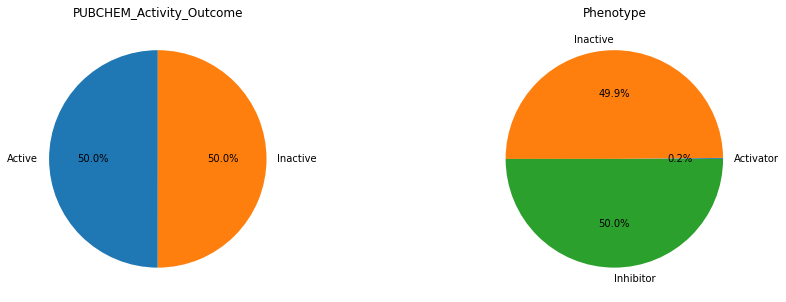

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.pie(activity, labels=labels_activity, autopct='%1.1f%%', startangle=90)
ax1.set_title('PUBCHEM_Activity_Outcome')
ax2.pie(fenotipo, labels=labels_fenotipo, autopct='%1.1f%%', startangle=360)
ax2.set_title('Phenotype')

As we can see in the "PUBCHEM_Activity_Outcome" pie chart, the data is balanced for binary classification.
In the "Phenotype" pie chart, the overall multiclass is very imbalanced. However, the data is balanced between the 'Inactive' and 'Inhibitor' phenotypes.

### Boxplots of Activity at 0.00299 uM, 0.363 uM, 1.849 uM, 9.037 uM and 46.23 uM

<AxesSubplot:title={'center':'Activity at 0.00299 uM'}, ylabel='Activity at 0.00299 uM'>

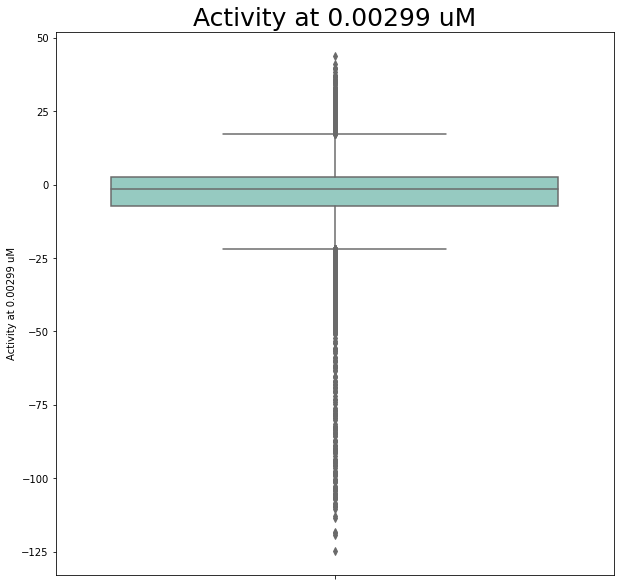

In [ ]:
plt.subplots(figsize=(10, 10))
sns.set(font_scale=1.4)
plt.title("Activity at 0.00299 uM", fontsize=25)
sns.boxplot(y="Activity at 0.00299 uM",
            data=dataset, palette="Set3")

In [ ]:
dataset["Activity at 0.00299 uM"].describe()

count    38695.000000
mean        -2.765257
std         10.593629
min       -124.585000
25%         -7.230600
50%         -1.400000
75%          2.597650
max         43.627300
Name: Activity at 0.00299 uM, dtype: float64

<AxesSubplot:title={'center':'Activity at 0.363 uM'}, ylabel='Activity at 0.363 uM'>

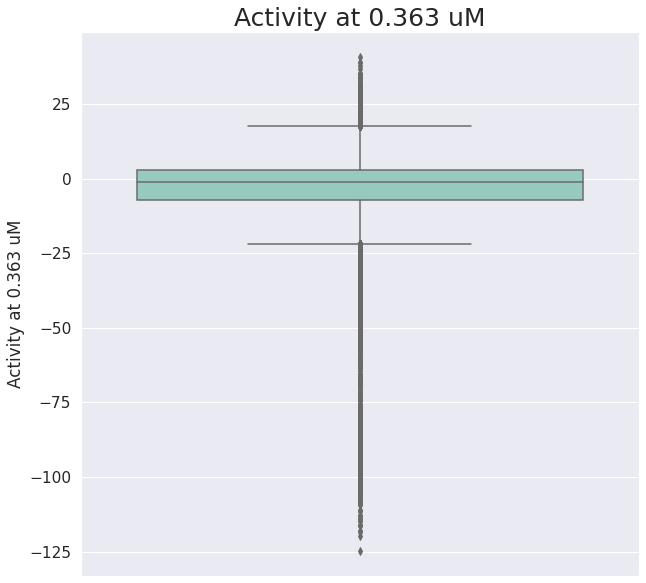

In [ ]:
plt.subplots(figsize=(10, 10))
sns.set(font_scale=1.4)
plt.title("Activity at 0.363 uM", fontsize=25)
sns.boxplot(y="Activity at 0.363 uM",
            data=dataset, palette="Set3")

In [ ]:
dataset["Activity at 0.363 uM"].describe()

count    39760.000000
mean        -2.914642
std         11.702945
min       -124.830000
25%         -7.090875
50%         -1.263200
75%          2.736000
max         40.747500
Name: Activity at 0.363 uM, dtype: float64

<AxesSubplot:title={'center':'Activity at 1.849 uM'}, ylabel='Activity at 1.849 uM'>

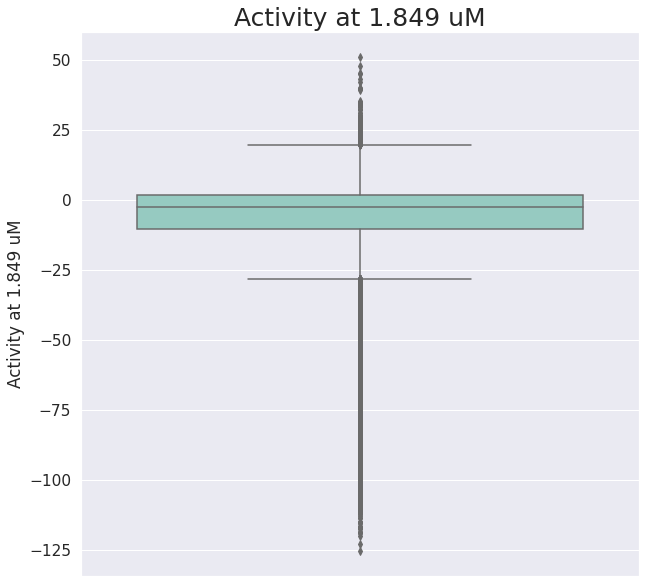

In [ ]:
plt.subplots(figsize=(10, 10))
sns.set(font_scale=1.4)
plt.title("Activity at 1.849 uM", fontsize=25)
sns.boxplot(y="Activity at 1.849 uM", data=dataset, palette="Set3")

In [ ]:
dataset["Activity at 1.849 uM"].describe()

count    39742.000000
mean        -6.283120
std         16.475083
min       -125.457000
25%        -10.335850
50%         -2.634900
75%          1.663600
max         50.993300
Name: Activity at 1.849 uM, dtype: float64

<AxesSubplot:title={'center':'Activity at 9.037 uM'}, ylabel='Activity at 9.037 uM'>

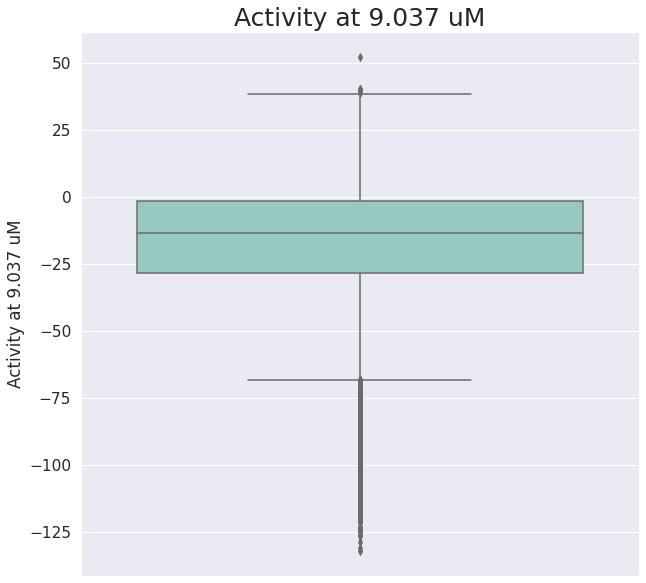

In [ ]:
plt.subplots(figsize=(10, 10))
sns.set(font_scale=1.4)
plt.title("Activity at 9.037 uM", fontsize=25)
sns.boxplot(y="Activity at 9.037 uM", data=dataset, palette="Set3")

In [ ]:
dataset["Activity at 9.037 uM"].describe()

count    39189.000000
mean       -20.564183
std         27.542152
min       -132.226000
25%        -28.187400
50%        -13.456500
75%         -1.370100
max         52.388100
Name: Activity at 9.037 uM, dtype: float64

<AxesSubplot:title={'center':'Activity at 46.23 uM'}, ylabel='Activity at 46.23 uM'>

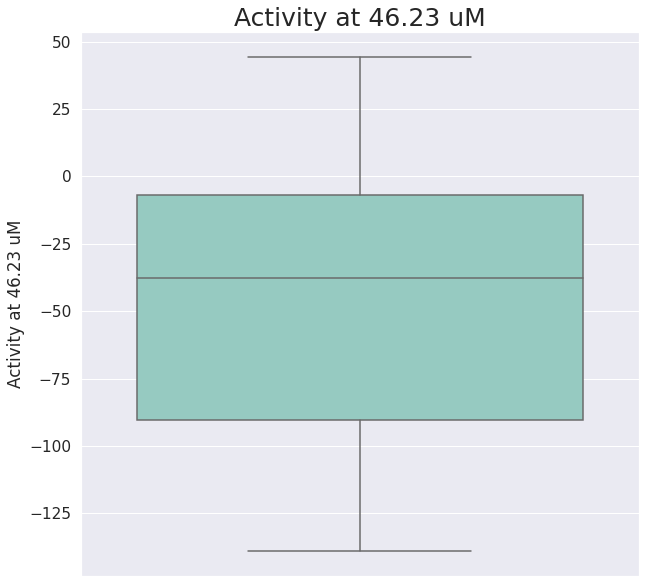

In [ ]:
plt.subplots(figsize=(10, 10))
sns.set(font_scale=1.4)
plt.title("Activity at 46.23 uM", fontsize=25)
sns.boxplot(y="Activity at 46.23 uM", data=dataset, palette="Set3")

In [ ]:
dataset["Activity at 46.23 uM"].describe()

count    39941.000000
mean       -48.307422
std         42.879640
min       -139.063000
25%        -90.492700
50%        -37.857500
75%         -6.688500
max         44.389300
Name: Activity at 46.23 uM, dtype: float64

## Compound Standardization

The molecules are standardized in order to remove isotope information, neutralize charges, remove stereochemistry and remove smaller fragments.
This way we are accounting for molecular diversity.

In [ ]:
def standardize(dataset, id_field ,mols_field,class_field):

    loader = CSVLoader(dataset,
                       id_field=id_field,
                       mols_field = mols_field,
                       labels_fields = class_field)

    dataset = loader.create_dataset()

    standardisation_params = {
        'REMOVE_ISOTOPE': True,
        'NEUTRALISE_CHARGE': True,
        'REMOVE_STEREO': False,
        'KEEP_BIGGEST': True,
        'ADD_HYDROGEN': False,
        'KEKULIZE': True,
        'NEUTRALISE_CHARGE_LATE': True}

    CustomStandardizer(params = standardisation_params).standardize(dataset)

    return dataset

In [ ]:
dataset = standardize("../dataset/binary_class/PUBCHEM_ACTIVITY_OUTCOME_binary.csv", "PUBCHEM_CID", "smiles", "PUBCHEM_ACTIVITY_OUTCOME")
dataset.save_to_csv("../dataset/binary_class/standardized_binary.csv")

Standardizing datapoint 0


RDKit INFO: [19:11:33] Running Uncharger
RDKit INFO: [19:11:33] Running Uncharger
RDKit INFO: [19:11:33] Running Uncharger
RDKit INFO: [19:11:33] Running Uncharger
RDKit INFO: [19:11:33] Running Uncharger
RDKit INFO: [19:11:33] Running Uncharger
RDKit INFO: [19:11:33] Running Uncharger
RDKit INFO: [19:11:34] Running Uncharger
RDKit INFO: [19:11:34] Running Uncharger
RDKit INFO: [19:11:34] Running Uncharger
RDKit INFO: [19:11:34] Running Uncharger
RDKit INFO: [19:11:34] Running Uncharger
RDKit INFO: [19:11:34] Running Uncharger
RDKit INFO: [19:11:34] Running Uncharger
RDKit INFO: [19:11:34] Running Uncharger
RDKit INFO: [19:11:34] Running Uncharger
RDKit INFO: [19:11:34] Running Uncharger
RDKit INFO: [19:11:34] Running Uncharger
RDKit INFO: [19:11:34] Running Uncharger
RDKit INFO: [19:11:34] Running Uncharger
RDKit INFO: [19:11:34] Running Uncharger
RDKit INFO: [19:11:34] Running Uncharger
RDKit INFO: [19:11:34] Running Uncharger
RDKit INFO: [19:11:34] Running Uncharger
RDKit INFO: [19:

[19:11:33] Running Uncharger
[19:11:33] Running Uncharger
[19:11:33] Running Uncharger
[19:11:33] Running Uncharger
[19:11:33] Running Uncharger
[19:11:33] Running Uncharger
[19:11:33] Running Uncharger
[19:11:34] Running Uncharger
[19:11:34] Running Uncharger
[19:11:34] Running Uncharger
[19:11:34] Running Uncharger
[19:11:34] Running Uncharger
[19:11:34] Running Uncharger
[19:11:34] Running Uncharger
[19:11:34] Running Uncharger
[19:11:34] Running Uncharger
[19:11:34] Running Uncharger
[19:11:34] Running Uncharger
[19:11:34] Running Uncharger
[19:11:34] Running Uncharger
[19:11:34] Running Uncharger
[19:11:34] Running Uncharger
[19:11:34] Running Uncharger
[19:11:34] Running Uncharger
[19:11:34] Running Uncharger
[19:11:34] Removed negative charge.
[19:11:34] Removed negative charge.
[19:11:34] Running Uncharger
[19:11:34] Running Uncharger
[19:11:34] Running Uncharger
[19:11:34] Running Uncharger
[19:11:34] Running Uncharger
[19:11:34] Running Uncharger
[19:11:34] Running Uncharger


RDKit INFO: [19:11:34] Running Uncharger
RDKit INFO: [19:11:34] Running Uncharger
RDKit INFO: [19:11:34] Running Uncharger
RDKit INFO: [19:11:34] Running Uncharger
RDKit INFO: [19:11:34] Running Uncharger
RDKit INFO: [19:11:34] Running Uncharger
RDKit INFO: [19:11:34] Running Uncharger
RDKit INFO: [19:11:34] Running Uncharger
RDKit INFO: [19:11:34] Running Uncharger
RDKit INFO: [19:11:34] Running Uncharger
RDKit INFO: [19:11:34] Running Uncharger
RDKit INFO: [19:11:34] Running Uncharger
RDKit INFO: [19:11:34] Running Uncharger
RDKit INFO: [19:11:34] Running Uncharger
RDKit INFO: [19:11:34] Running Uncharger
RDKit INFO: [19:11:34] Running Uncharger
RDKit INFO: [19:11:34] Running Uncharger
RDKit INFO: [19:11:34] Running Uncharger
RDKit INFO: [19:11:34] Running Uncharger
RDKit INFO: [19:11:34] Running Uncharger
RDKit INFO: [19:11:34] Running Uncharger
RDKit INFO: [19:11:34] Running Uncharger
RDKit INFO: [19:11:34] Running Uncharger
RDKit INFO: [19:11:34] Running Uncharger
RDKit INFO: [19:

harger
[19:11:34] Running Uncharger
[19:11:34] Running Uncharger
[19:11:34] Running Uncharger
[19:11:34] Running Uncharger
[19:11:34] Running Uncharger
[19:11:34] Running Uncharger
[19:11:34] Running Uncharger
[19:11:34] Running Uncharger
[19:11:34] Running Uncharger
[19:11:34] Running Uncharger
[19:11:34] Running Uncharger
[19:11:34] Running Uncharger
[19:11:34] Running Uncharger
[19:11:34] Running Uncharger
[19:11:34] Running Uncharger
[19:11:34] Running Uncharger
[19:11:34] Running Uncharger
[19:11:34] Running Uncharger
[19:11:34] Running Uncharger
[19:11:34] Running Uncharger
[19:11:34] Running Uncharger
[19:11:34] Running Uncharger
[19:11:34] Running Uncharger
[19:11:34] Running Uncharger
[19:11:34] Running Uncharger
[19:11:34] Running Uncharger
[19:11:34] Running Uncharger
[19:11:34] Running Uncharger
[19:11:34] Running Uncharger
[19:11:34] Running Uncharger
[19:11:34] Running Uncharger
[19:11:34] Running Uncharger
[19:11:34] Running Uncharger
[19:11:34] Running Uncharger
[19:11:

RDKit INFO: [19:11:34] Running Uncharger
RDKit INFO: [19:11:34] Running Uncharger
RDKit INFO: [19:11:34] Running Uncharger
RDKit INFO: [19:11:34] Running Uncharger
RDKit INFO: [19:11:34] Running Uncharger
RDKit INFO: [19:11:34] Running Uncharger
RDKit INFO: [19:11:34] Running Uncharger
RDKit INFO: [19:11:34] Running Uncharger
RDKit INFO: [19:11:34] Running Uncharger
RDKit INFO: [19:11:34] Running Uncharger
RDKit INFO: [19:11:34] Running Uncharger
RDKit INFO: [19:11:34] Running Uncharger
RDKit INFO: [19:11:34] Running Uncharger
RDKit INFO: [19:11:34] Running Uncharger
RDKit INFO: [19:11:34] Running Uncharger
RDKit INFO: [19:11:34] Running Uncharger
RDKit INFO: [19:11:34] Running Uncharger
RDKit INFO: [19:11:34] Running Uncharger
RDKit INFO: [19:11:34] Running Uncharger
RDKit INFO: [19:11:34] Running Uncharger
RDKit INFO: [19:11:34] Running Uncharger
RDKit INFO: [19:11:34] Running Uncharger
RDKit INFO: [19:11:34] Running Uncharger
RDKit INFO: [19:11:34] Running Uncharger
RDKit INFO: [19:

34] Running Uncharger
[19:11:34] Running Uncharger
[19:11:34] Running Uncharger
[19:11:34] Running Uncharger
[19:11:34] Running Uncharger
[19:11:34] Running Uncharger
[19:11:34] Running Uncharger
[19:11:34] Running Uncharger
[19:11:34] Running Uncharger
[19:11:34] Running Uncharger
[19:11:34] Running Uncharger
[19:11:34] Running Uncharger
[19:11:34] Running Uncharger
[19:11:34] Running Uncharger
[19:11:34] Running Uncharger
[19:11:34] Running Uncharger
[19:11:34] Running Uncharger
[19:11:34] Running Uncharger
[19:11:34] Running Uncharger
[19:11:34] Running Uncharger
[19:11:34] Running Uncharger
[19:11:34] Running Uncharger
[19:11:34] Running Uncharger
[19:11:34] Running Uncharger
[19:11:34] Running Uncharger
[19:11:34] Running Uncharger
[19:11:34] Running Uncharger
[19:11:34] Running Uncharger
[19:11:34] Running Uncharger
[19:11:34] Running Uncharger
[19:11:34] Running Uncharger
[19:11:34] Running Uncharger
[19:11:34] Running Uncharger
[19:11:34] Running Uncharger
[19:11:34] Running Un

RDKit INFO: [19:11:35] Running Uncharger
RDKit INFO: [19:11:35] Running Uncharger
RDKit INFO: [19:11:35] Running Uncharger
RDKit INFO: [19:11:35] Running Uncharger
RDKit INFO: [19:11:35] Running Uncharger
RDKit INFO: [19:11:35] Running Uncharger
RDKit INFO: [19:11:35] Running Uncharger
RDKit INFO: [19:11:35] Running Uncharger
RDKit INFO: [19:11:35] Running Uncharger
RDKit INFO: [19:11:35] Running Uncharger
RDKit INFO: [19:11:35] Running Uncharger
RDKit INFO: [19:11:35] Running Uncharger
RDKit INFO: [19:11:35] Running Uncharger
RDKit INFO: [19:11:35] Running Uncharger
RDKit INFO: [19:11:35] Running Uncharger
RDKit INFO: [19:11:35] Running Uncharger
RDKit INFO: [19:11:35] Running Uncharger
RDKit INFO: [19:11:35] Running Uncharger
RDKit INFO: [19:11:35] Running Uncharger
RDKit INFO: [19:11:35] Running Uncharger
RDKit INFO: [19:11:35] Running Uncharger
RDKit INFO: [19:11:35] Running Uncharger
RDKit INFO: [19:11:35] Running Uncharger
RDKit INFO: [19:11:35] Running Uncharger
RDKit INFO: [19:

:35] Running Uncharger
[19:11:35] Running Uncharger
[19:11:35] Running Uncharger
[19:11:35] Running Uncharger
[19:11:35] Running Uncharger
[19:11:35] Running Uncharger
[19:11:35] Running Uncharger
[19:11:35] Running Uncharger
[19:11:35] Running Uncharger
[19:11:35] Running Uncharger
[19:11:35] Running Uncharger
[19:11:35] Running Uncharger
[19:11:35] Running Uncharger
[19:11:35] Running Uncharger
[19:11:35] Running Uncharger
[19:11:35] Running Uncharger
[19:11:35] Running Uncharger
[19:11:35] Running Uncharger
[19:11:35] Running Uncharger
[19:11:35] Running Uncharger
[19:11:35] Running Uncharger
[19:11:35] Running Uncharger
[19:11:35] Running Uncharger
[19:11:35] Running Uncharger
[19:11:35] Running Uncharger
[19:11:35] Running Uncharger
[19:11:35] Running Uncharger
[19:11:35] Running Uncharger
[19:11:35] Running Uncharger
[19:11:35] Running Uncharger
[19:11:35] Running Uncharger
[19:11:35] Running Uncharger
[19:11:35] Running Uncharger
[19:11:35] Running Uncharger
[19:11:35] Running U

RDKit INFO: [19:11:35] Running Uncharger
RDKit INFO: [19:11:35] Running Uncharger
RDKit INFO: [19:11:35] Running Uncharger
RDKit INFO: [19:11:35] Running Uncharger
RDKit INFO: [19:11:35] Running Uncharger
RDKit INFO: [19:11:35] Running Uncharger
RDKit INFO: [19:11:35] Running Uncharger
RDKit INFO: [19:11:35] Running Uncharger
RDKit INFO: [19:11:35] Running Uncharger
RDKit INFO: [19:11:35] Running Uncharger
RDKit INFO: [19:11:35] Running Uncharger
RDKit INFO: [19:11:35] Running Uncharger
RDKit INFO: [19:11:35] Running Uncharger
RDKit INFO: [19:11:35] Running Uncharger
RDKit INFO: [19:11:35] Running Uncharger
RDKit INFO: [19:11:35] Running Uncharger
RDKit INFO: [19:11:35] Running Uncharger
RDKit INFO: [19:11:35] Running Uncharger
RDKit INFO: [19:11:35] Running Uncharger
RDKit INFO: [19:11:35] Running Uncharger
RDKit INFO: [19:11:35] Running Uncharger
RDKit INFO: [19:11:35] Running Uncharger
RDKit INFO: [19:11:35] Running Uncharger
RDKit INFO: [19:11:35] Running Uncharger
RDKit INFO: [19:

ncharger
[19:11:35] Running Uncharger
[19:11:35] Running Uncharger
[19:11:35] Running Uncharger
[19:11:35] Running Uncharger
[19:11:35] Running Uncharger
[19:11:35] Running Uncharger
[19:11:35] Running Uncharger
[19:11:35] Running Uncharger
[19:11:35] Running Uncharger
[19:11:35] Running Uncharger
[19:11:35] Running Uncharger
[19:11:35] Running Uncharger
[19:11:35] Running Uncharger
[19:11:35] Running Uncharger
[19:11:35] Running Uncharger
[19:11:35] Running Uncharger
[19:11:35] Running Uncharger
[19:11:35] Running Uncharger
[19:11:35] Running Uncharger
[19:11:35] Running Uncharger
[19:11:35] Running Uncharger
[19:11:35] Running Uncharger
[19:11:35] Running Uncharger
[19:11:35] Running Uncharger
[19:11:35] Running Uncharger
[19:11:35] Running Uncharger
[19:11:35] Running Uncharger
[19:11:35] Running Uncharger
[19:11:35] Running Uncharger
[19:11:36] Running Uncharger
[19:11:36] Running Uncharger
[19:11:36] Running Uncharger
[19:11:36] Running Uncharger
[19:11:36] Running Uncharger
[19:1

RDKit INFO: [19:11:36] Running Uncharger
RDKit INFO: [19:11:36] Running Uncharger
RDKit INFO: [19:11:36] Running Uncharger
RDKit INFO: [19:11:36] Running Uncharger
RDKit INFO: [19:11:36] Running Uncharger
RDKit INFO: [19:11:36] Running Uncharger
RDKit INFO: [19:11:36] Running Uncharger
RDKit INFO: [19:11:36] Running Uncharger
RDKit INFO: [19:11:36] Running Uncharger
RDKit INFO: [19:11:36] Running Uncharger
RDKit INFO: [19:11:36] Running Uncharger
RDKit INFO: [19:11:36] Running Uncharger
RDKit INFO: [19:11:36] Running Uncharger
RDKit INFO: [19:11:36] Running Uncharger
RDKit INFO: [19:11:36] Running Uncharger
RDKit INFO: [19:11:36] Running Uncharger
RDKit INFO: [19:11:36] Running Uncharger
RDKit INFO: [19:11:36] Running Uncharger
RDKit INFO: [19:11:36] Running Uncharger
RDKit INFO: [19:11:36] Running Uncharger
RDKit INFO: [19:11:36] Running Uncharger
RDKit INFO: [19:11:36] Running Uncharger
RDKit INFO: [19:11:36] Running Uncharger
RDKit INFO: [19:11:36] Running Uncharger
RDKit INFO: [19:

1:36] Running Uncharger
[19:11:36] Running Uncharger
[19:11:36] Running Uncharger
[19:11:36] Running Uncharger
[19:11:36] Running Uncharger
[19:11:36] Running Uncharger
[19:11:36] Running Uncharger
[19:11:36] Running Uncharger
[19:11:36] Running Uncharger
[19:11:36] Running Uncharger
[19:11:36] Running Uncharger
[19:11:36] Running Uncharger
[19:11:36] Running Uncharger
[19:11:36] Running Uncharger
[19:11:36] Running Uncharger
[19:11:36] Running Uncharger
[19:11:36] Running Uncharger
[19:11:36] Running Uncharger
[19:11:36] Running Uncharger
[19:11:36] Running Uncharger
[19:11:36] Running Uncharger
[19:11:36] Running Uncharger
[19:11:36] Running Uncharger
[19:11:36] Running Uncharger
[19:11:36] Running Uncharger
[19:11:36] Running Uncharger
[19:11:36] Running Uncharger
[19:11:36] Running Uncharger
[19:11:36] Running Uncharger
[19:11:36] Running Uncharger
[19:11:36] Running Uncharger
[19:11:36] Running Uncharger
[19:11:36] Running Uncharger
[19:11:36] Running Uncharger
[19:11:36] Running 

RDKit INFO: [19:11:36] Running Uncharger
RDKit INFO: [19:11:36] Running Uncharger
RDKit INFO: [19:11:36] Running Uncharger
RDKit INFO: [19:11:36] Running Uncharger
RDKit INFO: [19:11:36] Running Uncharger
RDKit INFO: [19:11:36] Running Uncharger
RDKit INFO: [19:11:36] Running Uncharger
RDKit INFO: [19:11:36] Running Uncharger
RDKit INFO: [19:11:36] Running Uncharger
RDKit INFO: [19:11:36] Running Uncharger
RDKit INFO: [19:11:36] Running Uncharger
RDKit INFO: [19:11:36] Running Uncharger
RDKit INFO: [19:11:36] Running Uncharger
RDKit INFO: [19:11:36] Running Uncharger
RDKit INFO: [19:11:36] Running Uncharger
RDKit INFO: [19:11:36] Running Uncharger
RDKit INFO: [19:11:36] Running Uncharger
RDKit INFO: [19:11:36] Running Uncharger
RDKit INFO: [19:11:36] Running Uncharger
RDKit INFO: [19:11:36] Running Uncharger
RDKit INFO: [19:11:36] Running Uncharger
RDKit INFO: [19:11:36] Running Uncharger
RDKit INFO: [19:11:36] Running Uncharger
RDKit INFO: [19:11:36] Running Uncharger
RDKit INFO: [19:

Standardizing datapoint 1000
Uncharger
[19:11:36] Running Uncharger
[19:11:36] Running Uncharger
[19:11:36] Running Uncharger
[19:11:36] Running Uncharger
[19:11:36] Running Uncharger
[19:11:36] Running Uncharger
[19:11:36] Running Uncharger
[19:11:36] Running Uncharger
[19:11:36] Running Uncharger
[19:11:36] Running Uncharger
[19:11:36] Running Uncharger
[19:11:36] Running Uncharger
[19:11:36] Running Uncharger
[19:11:36] Running Uncharger
[19:11:36] Running Uncharger
[19:11:36] Running Uncharger
[19:11:36] Running Uncharger
[19:11:36] Running Uncharger
[19:11:36] Running Uncharger
[19:11:36] Running Uncharger
[19:11:36] Running Uncharger
[19:11:36] Running Uncharger
[19:11:36] Running Uncharger
[19:11:36] Running Uncharger
[19:11:36] Running Uncharger
[19:11:36] Running Uncharger
[19:11:36] Running Uncharger
[19:11:36] Running Uncharger
[19:11:36] Running Uncharger
[19:11:36] Running Uncharger
[19:11:36] Running Uncharger
[19:11:36] Running Uncharger
[19:11:36] Running Uncharger
[19:

RDKit INFO: [19:11:37] Running Uncharger
RDKit INFO: [19:11:37] Running Uncharger
RDKit INFO: [19:11:37] Running Uncharger
RDKit INFO: [19:11:37] Running Uncharger
RDKit INFO: [19:11:37] Running Uncharger
RDKit INFO: [19:11:37] Running Uncharger
RDKit INFO: [19:11:37] Running Uncharger
RDKit INFO: [19:11:37] Running Uncharger
RDKit INFO: [19:11:37] Running Uncharger
RDKit INFO: [19:11:37] Running Uncharger
RDKit INFO: [19:11:37] Running Uncharger
RDKit INFO: [19:11:37] Running Uncharger
RDKit INFO: [19:11:37] Running Uncharger
RDKit INFO: [19:11:37] Running Uncharger
RDKit INFO: [19:11:37] Running Uncharger
RDKit INFO: [19:11:37] Running Uncharger
RDKit INFO: [19:11:37] Running Uncharger
RDKit INFO: [19:11:37] Running Uncharger
RDKit INFO: [19:11:37] Running Uncharger
RDKit INFO: [19:11:37] Running Uncharger
RDKit INFO: [19:11:37] Running Uncharger
RDKit INFO: [19:11:37] Running Uncharger
RDKit INFO: [19:11:37] Running Uncharger
RDKit INFO: [19:11:37] Running Uncharger
RDKit INFO: [19:

11:37] Running Uncharger
[19:11:37] Running Uncharger
[19:11:37] Running Uncharger
[19:11:37] Running Uncharger
[19:11:37] Running Uncharger
[19:11:37] Running Uncharger
[19:11:37] Running Uncharger
[19:11:37] Running Uncharger
[19:11:37] Running Uncharger
[19:11:37] Running Uncharger
[19:11:37] Running Uncharger
[19:11:37] Running Uncharger
[19:11:37] Running Uncharger
[19:11:37] Running Uncharger
[19:11:37] Running Uncharger
[19:11:37] Running Uncharger
[19:11:37] Running Uncharger
[19:11:37] Running Uncharger
[19:11:37] Running Uncharger
[19:11:37] Running Uncharger
[19:11:37] Running Uncharger
[19:11:37] Running Uncharger
[19:11:37] Running Uncharger
[19:11:37] Running Uncharger
[19:11:37] Running Uncharger
[19:11:37] Running Uncharger
[19:11:37] Running Uncharger
[19:11:37] Running Uncharger
[19:11:37] Running Uncharger
[19:11:37] Running Uncharger
[19:11:37] Running Uncharger
[19:11:37] Running Uncharger
[19:11:37] Running Uncharger
[19:11:37] Running Uncharger
[19:11:37] Running

RDKit INFO: [19:11:37] Running Uncharger
RDKit INFO: [19:11:37] Running Uncharger
RDKit INFO: [19:11:37] Running Uncharger
RDKit INFO: [19:11:37] Running Uncharger
RDKit INFO: [19:11:37] Running Uncharger
RDKit INFO: [19:11:37] Running Uncharger
RDKit INFO: [19:11:37] Running Uncharger
RDKit INFO: [19:11:37] Running Uncharger
RDKit INFO: [19:11:37] Running Uncharger
RDKit INFO: [19:11:37] Running Uncharger
RDKit INFO: [19:11:37] Running Uncharger
RDKit INFO: [19:11:37] Running Uncharger
RDKit INFO: [19:11:37] Running Uncharger
RDKit INFO: [19:11:37] Running Uncharger
RDKit INFO: [19:11:37] Running Uncharger
RDKit INFO: [19:11:37] Running Uncharger
RDKit INFO: [19:11:37] Running Uncharger
RDKit INFO: [19:11:37] Running Uncharger
RDKit INFO: [19:11:37] Running Uncharger
RDKit INFO: [19:11:37] Running Uncharger
RDKit INFO: [19:11:37] Running Uncharger
RDKit INFO: [19:11:37] Running Uncharger
RDKit INFO: [19:11:37] Running Uncharger
RDKit INFO: [19:11:37] Running Uncharger
RDKit INFO: [19:

 Uncharger
[19:11:37] Running Uncharger
[19:11:37] Running Uncharger
[19:11:37] Running Uncharger
[19:11:37] Running Uncharger
[19:11:37] Running Uncharger
[19:11:37] Running Uncharger
[19:11:37] Running Uncharger
[19:11:37] Running Uncharger
[19:11:37] Running Uncharger
[19:11:37] Running Uncharger
[19:11:37] Running Uncharger
[19:11:37] Running Uncharger
[19:11:37] Running Uncharger
[19:11:37] Running Uncharger
[19:11:37] Running Uncharger
[19:11:37] Running Uncharger
[19:11:37] Running Uncharger
[19:11:37] Running Uncharger
[19:11:37] Running Uncharger
[19:11:37] Running Uncharger
[19:11:37] Running Uncharger
[19:11:37] Running Uncharger
[19:11:37] Running Uncharger
[19:11:37] Running Uncharger
[19:11:37] Running Uncharger
[19:11:37] Running Uncharger
[19:11:37] Running Uncharger
[19:11:37] Running Uncharger
[19:11:37] Running Uncharger
[19:11:37] Running Uncharger
[19:11:37] Running Uncharger
[19:11:37] Running Uncharger
[19:11:37] Running Uncharger
[19:11:37] Running Uncharger
[19

RDKit INFO: [19:11:38] Running Uncharger
RDKit INFO: [19:11:38] Running Uncharger
RDKit INFO: [19:11:38] Running Uncharger
RDKit INFO: [19:11:38] Running Uncharger
RDKit INFO: [19:11:38] Running Uncharger
RDKit INFO: [19:11:38] Running Uncharger
RDKit INFO: [19:11:38] Running Uncharger
RDKit INFO: [19:11:38] Running Uncharger
RDKit INFO: [19:11:38] Running Uncharger
RDKit INFO: [19:11:38] Running Uncharger
RDKit INFO: [19:11:38] Running Uncharger
RDKit INFO: [19:11:38] Running Uncharger
RDKit INFO: [19:11:38] Running Uncharger
RDKit INFO: [19:11:38] Running Uncharger
RDKit INFO: [19:11:38] Running Uncharger
RDKit INFO: [19:11:38] Running Uncharger
RDKit INFO: [19:11:38] Running Uncharger
RDKit INFO: [19:11:38] Running Uncharger
RDKit INFO: [19:11:38] Running Uncharger
RDKit INFO: [19:11:38] Running Uncharger
RDKit INFO: [19:11:38] Running Uncharger
RDKit INFO: [19:11:38] Running Uncharger
RDKit INFO: [19:11:38] Running Uncharger
RDKit INFO: [19:11:38] Running Uncharger
RDKit INFO: [19:

:11:38] Running Uncharger
[19:11:38] Running Uncharger
[19:11:38] Running Uncharger
[19:11:38] Running Uncharger
[19:11:38] Running Uncharger
[19:11:38] Running Uncharger
[19:11:38] Running Uncharger
[19:11:38] Running Uncharger
[19:11:38] Running Uncharger
[19:11:38] Running Uncharger
[19:11:38] Running Uncharger
[19:11:38] Running Uncharger
[19:11:38] Running Uncharger
[19:11:38] Running Uncharger
[19:11:38] Running Uncharger
[19:11:38] Running Uncharger
[19:11:38] Running Uncharger
[19:11:38] Running Uncharger
[19:11:38] Running Uncharger
[19:11:38] Running Uncharger
[19:11:38] Running Uncharger
[19:11:38] Running Uncharger
[19:11:38] Running Uncharger
[19:11:38] Running Uncharger
[19:11:38] Running Uncharger
[19:11:38] Running Uncharger
[19:11:38] Running Uncharger
[19:11:38] Running Uncharger
[19:11:38] Running Uncharger
[19:11:38] Running Uncharger
[19:11:38] Running Uncharger
[19:11:38] Running Uncharger
[19:11:38] Running Uncharger
[19:11:38] Running Uncharger
[19:11:38] Runnin

RDKit INFO: [19:11:38] Running Uncharger
RDKit INFO: [19:11:38] Running Uncharger
RDKit INFO: [19:11:38] Running Uncharger
RDKit INFO: [19:11:38] Running Uncharger
RDKit INFO: [19:11:38] Running Uncharger
RDKit INFO: [19:11:38] Running Uncharger
RDKit INFO: [19:11:38] Running Uncharger
RDKit INFO: [19:11:38] Running Uncharger
RDKit INFO: [19:11:38] Running Uncharger
RDKit INFO: [19:11:38] Running Uncharger
RDKit INFO: [19:11:38] Running Uncharger
RDKit INFO: [19:11:38] Running Uncharger
RDKit INFO: [19:11:38] Running Uncharger
RDKit INFO: [19:11:38] Running Uncharger
RDKit INFO: [19:11:38] Running Uncharger
RDKit INFO: [19:11:38] Running Uncharger
RDKit INFO: [19:11:38] Running Uncharger
RDKit INFO: [19:11:38] Running Uncharger
RDKit INFO: [19:11:38] Running Uncharger
RDKit INFO: [19:11:38] Running Uncharger
RDKit INFO: [19:11:38] Running Uncharger
RDKit INFO: [19:11:38] Running Uncharger
RDKit INFO: [19:11:38] Running Uncharger
RDKit INFO: [19:11:38] Running Uncharger
RDKit INFO: [19:

g Uncharger
[19:11:38] Running Uncharger
[19:11:38] Running Uncharger
[19:11:38] Running Uncharger
[19:11:38] Running Uncharger
[19:11:38] Running Uncharger
[19:11:38] Running Uncharger
[19:11:38] Running Uncharger
[19:11:38] Running Uncharger
[19:11:38] Running Uncharger
[19:11:38] Running Uncharger
[19:11:38] Running Uncharger
[19:11:38] Running Uncharger
[19:11:38] Running Uncharger
[19:11:38] Running Uncharger
[19:11:38] Running Uncharger
[19:11:38] Running Uncharger
[19:11:38] Running Uncharger
[19:11:38] Running Uncharger
[19:11:38] Running Uncharger
[19:11:38] Running Uncharger
[19:11:38] Running Uncharger
[19:11:38] Running Uncharger
[19:11:38] Running Uncharger
[19:11:38] Running Uncharger
[19:11:38] Running Uncharger
[19:11:38] Running Uncharger
[19:11:38] Running Uncharger
[19:11:38] Running Uncharger
[19:11:38] Running Uncharger
[19:11:38] Running Uncharger
[19:11:38] Running Uncharger
[19:11:38] Running Uncharger
[19:11:38] Running Uncharger
[19:11:38] Running Uncharger
[1

RDKit INFO: [19:11:38] Running Uncharger
RDKit INFO: [19:11:38] Running Uncharger
RDKit INFO: [19:11:38] Running Uncharger
RDKit INFO: [19:11:38] Running Uncharger
RDKit INFO: [19:11:38] Running Uncharger
RDKit INFO: [19:11:38] Running Uncharger
RDKit INFO: [19:11:38] Running Uncharger
RDKit INFO: [19:11:38] Running Uncharger
RDKit INFO: [19:11:38] Running Uncharger
RDKit INFO: [19:11:38] Running Uncharger
RDKit INFO: [19:11:38] Running Uncharger
RDKit INFO: [19:11:38] Running Uncharger
RDKit INFO: [19:11:38] Running Uncharger
RDKit INFO: [19:11:38] Running Uncharger
RDKit INFO: [19:11:38] Running Uncharger
RDKit INFO: [19:11:38] Running Uncharger
RDKit INFO: [19:11:38] Running Uncharger
RDKit INFO: [19:11:38] Running Uncharger
RDKit INFO: [19:11:38] Running Uncharger
RDKit INFO: [19:11:38] Running Uncharger
RDKit INFO: [19:11:38] Running Uncharger
RDKit INFO: [19:11:38] Running Uncharger
RDKit INFO: [19:11:38] Running Uncharger
RDKit INFO: [19:11:38] Running Uncharger
RDKit INFO: [19:

9:11:38] Running Uncharger
[19:11:38] Running Uncharger
[19:11:38] Running Uncharger
[19:11:38] Running Uncharger
[19:11:38] Running Uncharger
[19:11:38] Running Uncharger
[19:11:38] Running Uncharger
[19:11:38] Running Uncharger
[19:11:38] Running Uncharger
[19:11:38] Running Uncharger
[19:11:38] Running Uncharger
[19:11:38] Running Uncharger
[19:11:38] Running Uncharger
[19:11:38] Running Uncharger
[19:11:38] Running Uncharger
[19:11:38] Running Uncharger
[19:11:38] Running Uncharger
[19:11:38] Running Uncharger
[19:11:38] Running Uncharger
[19:11:38] Running Uncharger
[19:11:38] Running Uncharger
[19:11:38] Running Uncharger
[19:11:38] Running Uncharger
[19:11:38] Running Uncharger
[19:11:38] Running Uncharger
[19:11:38] Running Uncharger
[19:11:38] Running Uncharger
[19:11:38] Running Uncharger
[19:11:38] Running Uncharger
[19:11:38] Running Uncharger
[19:11:38] Running Uncharger
[19:11:38] Running Uncharger
[19:11:38] Running Uncharger
[19:11:38] Running Uncharger
[19:11:38] Runni

RDKit INFO: [19:11:39] Running Uncharger
RDKit INFO: [19:11:39] Running Uncharger
RDKit INFO: [19:11:39] Running Uncharger
RDKit INFO: [19:11:39] Running Uncharger
RDKit INFO: [19:11:39] Running Uncharger
RDKit INFO: [19:11:39] Running Uncharger
RDKit INFO: [19:11:39] Running Uncharger
RDKit INFO: [19:11:39] Running Uncharger
RDKit INFO: [19:11:39] Running Uncharger
RDKit INFO: [19:11:39] Running Uncharger
RDKit INFO: [19:11:39] Running Uncharger
RDKit INFO: [19:11:39] Running Uncharger
RDKit INFO: [19:11:39] Running Uncharger
RDKit INFO: [19:11:39] Running Uncharger
RDKit INFO: [19:11:39] Running Uncharger
RDKit INFO: [19:11:39] Running Uncharger
RDKit INFO: [19:11:39] Running Uncharger
RDKit INFO: [19:11:39] Running Uncharger
RDKit INFO: [19:11:39] Running Uncharger
RDKit INFO: [19:11:39] Running Uncharger
RDKit INFO: [19:11:39] Running Uncharger
RDKit INFO: [19:11:39] Running Uncharger
RDKit INFO: [19:11:39] Running Uncharger
RDKit INFO: [19:11:39] Running Uncharger
RDKit INFO: [19:

ng Uncharger
[19:11:39] Running Uncharger
[19:11:39] Running Uncharger
[19:11:39] Running Uncharger
[19:11:39] Running Uncharger
[19:11:39] Running Uncharger
[19:11:39] Running Uncharger
[19:11:39] Running Uncharger
[19:11:39] Running Uncharger
[19:11:39] Running Uncharger
[19:11:39] Running Uncharger
[19:11:39] Running Uncharger
[19:11:39] Running Uncharger
[19:11:39] Running Uncharger
[19:11:39] Running Uncharger
[19:11:39] Running Uncharger
[19:11:39] Running Uncharger
[19:11:39] Running Uncharger
[19:11:39] Running Uncharger
[19:11:39] Running Uncharger
[19:11:39] Running Uncharger
[19:11:39] Running Uncharger
[19:11:39] Running Uncharger
[19:11:39] Running Uncharger
[19:11:39] Running Uncharger
[19:11:39] Running Uncharger
[19:11:39] Running Uncharger
[19:11:39] Running Uncharger
[19:11:39] Running Uncharger
[19:11:39] Running Uncharger
[19:11:39] Running Uncharger
[19:11:39] Running Uncharger
[19:11:39] Running Uncharger
[19:11:39] Running Uncharger
[19:11:39] Running Uncharger
[

RDKit INFO: [19:11:40] Running Uncharger
RDKit INFO: [19:11:40] Running Uncharger
RDKit INFO: [19:11:40] Running Uncharger
RDKit INFO: [19:11:40] Running Uncharger
RDKit INFO: [19:11:40] Running Uncharger
RDKit INFO: [19:11:40] Running Uncharger
RDKit INFO: [19:11:40] Running Uncharger
RDKit INFO: [19:11:40] Running Uncharger
RDKit INFO: [19:11:40] Running Uncharger
RDKit INFO: [19:11:40] Running Uncharger
RDKit INFO: [19:11:40] Running Uncharger
RDKit INFO: [19:11:40] Running Uncharger
RDKit INFO: [19:11:40] Running Uncharger
RDKit INFO: [19:11:40] Running Uncharger
RDKit INFO: [19:11:40] Running Uncharger
RDKit INFO: [19:11:40] Running Uncharger
RDKit INFO: [19:11:40] Running Uncharger
RDKit INFO: [19:11:40] Running Uncharger
RDKit INFO: [19:11:40] Running Uncharger
RDKit INFO: [19:11:40] Running Uncharger
RDKit INFO: [19:11:40] Running Uncharger
RDKit INFO: [19:11:40] Running Uncharger
RDKit INFO: [19:11:40] Running Uncharger
RDKit INFO: [19:11:40] Running Uncharger
RDKit INFO: [19:

ing Uncharger
[19:11:40] Running Uncharger
[19:11:40] Running Uncharger
[19:11:40] Running Uncharger
[19:11:40] Running Uncharger
[19:11:40] Running Uncharger
[19:11:40] Running Uncharger
[19:11:40] Running Uncharger
[19:11:40] Running Uncharger
[19:11:40] Running Uncharger
[19:11:40] Running Uncharger
[19:11:40] Running Uncharger
[19:11:40] Running Uncharger
[19:11:40] Running Uncharger
[19:11:40] Running Uncharger
[19:11:40] Running Uncharger
[19:11:40] Running Uncharger
[19:11:40] Running Uncharger
[19:11:40] Running Uncharger
[19:11:40] Running Uncharger
[19:11:40] Running Uncharger
[19:11:40] Running Uncharger
[19:11:40] Running Uncharger
[19:11:40] Running Uncharger
[19:11:40] Running Uncharger
[19:11:40] Running Uncharger
[19:11:40] Running Uncharger
[19:11:40] Running Uncharger
[19:11:40] Running Uncharger
[19:11:40] Running Uncharger
[19:11:40] Running Uncharger
[19:11:40] Running Uncharger
[19:11:40] Running Uncharger
[19:11:40] Running Uncharger
[19:11:40] Running Uncharger


RDKit INFO: [19:11:40] Running Uncharger
RDKit INFO: [19:11:40] Running Uncharger
RDKit INFO: [19:11:40] Running Uncharger
RDKit INFO: [19:11:40] Running Uncharger
RDKit INFO: [19:11:40] Running Uncharger
RDKit INFO: [19:11:40] Running Uncharger
RDKit INFO: [19:11:40] Running Uncharger
RDKit INFO: [19:11:40] Running Uncharger
RDKit INFO: [19:11:40] Running Uncharger
RDKit INFO: [19:11:40] Running Uncharger
RDKit INFO: [19:11:40] Running Uncharger
RDKit INFO: [19:11:40] Running Uncharger
RDKit INFO: [19:11:40] Running Uncharger
RDKit INFO: [19:11:40] Running Uncharger
RDKit INFO: [19:11:40] Running Uncharger
RDKit INFO: [19:11:40] Running Uncharger
RDKit INFO: [19:11:40] Running Uncharger
RDKit INFO: [19:11:40] Running Uncharger
RDKit INFO: [19:11:40] Running Uncharger
RDKit INFO: [19:11:40] Running Uncharger
RDKit INFO: [19:11:40] Running Uncharger
RDKit INFO: [19:11:40] Running Uncharger
RDKit INFO: [19:11:40] Running Uncharger
RDKit INFO: [19:11:40] Running Uncharger
RDKit INFO: [19:

[19:11:40] Running Uncharger
[19:11:40] Running Uncharger
[19:11:40] Running Uncharger
[19:11:40] Running Uncharger
[19:11:40] Running Uncharger
[19:11:40] Running Uncharger
[19:11:40] Running Uncharger
[19:11:40] Running Uncharger
[19:11:40] Running Uncharger
[19:11:40] Running Uncharger
[19:11:40] Running Uncharger
[19:11:40] Running Uncharger
[19:11:40] Running Uncharger
[19:11:40] Running Uncharger
[19:11:40] Running Uncharger
[19:11:40] Running Uncharger
[19:11:40] Running Uncharger
[19:11:40] Running Uncharger
[19:11:40] Running Uncharger
[19:11:40] Running Uncharger
[19:11:40] Running Uncharger
[19:11:40] Running Uncharger
[19:11:40] Running Uncharger
[19:11:40] Running Uncharger
[19:11:40] Running Uncharger
[19:11:40] Running Uncharger
[19:11:40] Running Uncharger
[19:11:40] Running Uncharger
[19:11:40] Running Uncharger
[19:11:40] Running Uncharger
[19:11:40] Running Uncharger
[19:11:40] Running Uncharger
[19:11:40] Running Uncharger
[19:11:40] Running Uncharger
[19:11:40] Run

RDKit INFO: [19:11:41] Running Uncharger
RDKit INFO: [19:11:41] Running Uncharger
RDKit INFO: [19:11:41] Running Uncharger
RDKit INFO: [19:11:41] Running Uncharger
RDKit INFO: [19:11:41] Running Uncharger
RDKit INFO: [19:11:41] Running Uncharger
RDKit INFO: [19:11:41] Running Uncharger
RDKit INFO: [19:11:41] Running Uncharger
RDKit INFO: [19:11:41] Running Uncharger
RDKit INFO: [19:11:41] Running Uncharger
RDKit INFO: [19:11:41] Running Uncharger
RDKit INFO: [19:11:41] Running Uncharger
RDKit INFO: [19:11:41] Running Uncharger
RDKit INFO: [19:11:41] Running Uncharger
RDKit INFO: [19:11:41] Running Uncharger
RDKit INFO: [19:11:41] Running Uncharger
RDKit INFO: [19:11:41] Running Uncharger
RDKit INFO: [19:11:41] Running Uncharger
RDKit INFO: [19:11:41] Running Uncharger
RDKit INFO: [19:11:41] Running Uncharger
RDKit INFO: [19:11:41] Running Uncharger
RDKit INFO: [19:11:41] Running Uncharger
RDKit INFO: [19:11:41] Running Uncharger
RDKit INFO: [19:11:41] Running Uncharger
RDKit INFO: [19:

ning Uncharger
[19:11:41] Running Uncharger
[19:11:41] Running Uncharger
[19:11:41] Running Uncharger
[19:11:41] Running Uncharger
[19:11:41] Running Uncharger
[19:11:41] Running Uncharger
[19:11:41] Running Uncharger
[19:11:41] Running Uncharger
[19:11:41] Running Uncharger
[19:11:41] Running Uncharger
[19:11:41] Running Uncharger
[19:11:41] Running Uncharger
[19:11:41] Running Uncharger
[19:11:41] Running Uncharger
[19:11:41] Running Uncharger
[19:11:41] Running Uncharger
[19:11:41] Running Uncharger
[19:11:41] Running Uncharger
[19:11:41] Running Uncharger
[19:11:41] Running Uncharger
[19:11:41] Running Uncharger
[19:11:41] Running Uncharger
[19:11:41] Running Uncharger
[19:11:41] Running Uncharger
[19:11:41] Running Uncharger
[19:11:41] Running Uncharger
[19:11:41] Running Uncharger
[19:11:41] Running Uncharger
[19:11:41] Running Uncharger
[19:11:41] Running Uncharger
[19:11:41] Running Uncharger
[19:11:41] Running Uncharger
[19:11:41] Running Uncharger
[19:11:41] Running Uncharger

RDKit INFO: [19:11:41] Running Uncharger
RDKit INFO: [19:11:41] Running Uncharger
RDKit INFO: [19:11:41] Running Uncharger
RDKit INFO: [19:11:41] Running Uncharger
RDKit INFO: [19:11:41] Running Uncharger
RDKit INFO: [19:11:41] Running Uncharger
RDKit INFO: [19:11:41] Running Uncharger
RDKit INFO: [19:11:41] Running Uncharger
RDKit INFO: [19:11:41] Running Uncharger
RDKit INFO: [19:11:41] Running Uncharger
RDKit INFO: [19:11:41] Running Uncharger
RDKit INFO: [19:11:41] Running Uncharger
RDKit INFO: [19:11:41] Running Uncharger
RDKit INFO: [19:11:41] Running Uncharger
RDKit INFO: [19:11:41] Running Uncharger
RDKit INFO: [19:11:41] Running Uncharger
RDKit INFO: [19:11:41] Running Uncharger
RDKit INFO: [19:11:41] Running Uncharger
RDKit INFO: [19:11:41] Running Uncharger
RDKit INFO: [19:11:41] Running Uncharger
RDKit INFO: [19:11:41] Running Uncharger
RDKit INFO: [19:11:41] Running Uncharger
RDKit INFO: [19:11:41] Running Uncharger
RDKit INFO: [19:11:41] Running Uncharger
RDKit INFO: [19:


[19:11:41] Running Uncharger
[19:11:41] Running Uncharger
[19:11:41] Running Uncharger
[19:11:41] Running Uncharger
[19:11:41] Running Uncharger
[19:11:41] Running Uncharger
[19:11:41] Running Uncharger
[19:11:41] Running Uncharger
[19:11:41] Running Uncharger
[19:11:41] Running Uncharger
[19:11:41] Running Uncharger
[19:11:41] Running Uncharger
[19:11:41] Running Uncharger
[19:11:41] Running Uncharger
[19:11:41] Running Uncharger
[19:11:41] Running Uncharger
[19:11:41] Running Uncharger
[19:11:41] Running Uncharger
[19:11:41] Running Uncharger
[19:11:41] Running Uncharger
[19:11:41] Running Uncharger
[19:11:41] Running Uncharger
[19:11:41] Running Uncharger
[19:11:41] Running Uncharger
[19:11:41] Running Uncharger
[19:11:41] Running Uncharger
[19:11:41] Running Uncharger
[19:11:41] Running Uncharger
[19:11:41] Running Uncharger
[19:11:41] Running Uncharger
[19:11:41] Running Uncharger
[19:11:41] Running Uncharger
[19:11:41] Running Uncharger
[19:11:41] Running Uncharger
[19:11:41] Ru

RDKit INFO: [19:11:42] Running Uncharger
RDKit INFO: [19:11:42] Running Uncharger
RDKit INFO: [19:11:42] Running Uncharger
RDKit INFO: [19:11:42] Running Uncharger
RDKit INFO: [19:11:42] Running Uncharger
RDKit INFO: [19:11:42] Running Uncharger
RDKit INFO: [19:11:42] Running Uncharger
RDKit INFO: [19:11:42] Running Uncharger
RDKit INFO: [19:11:42] Running Uncharger
RDKit INFO: [19:11:42] Running Uncharger
RDKit INFO: [19:11:42] Running Uncharger
RDKit INFO: [19:11:42] Running Uncharger
RDKit INFO: [19:11:42] Running Uncharger
RDKit INFO: [19:11:42] Running Uncharger
RDKit INFO: [19:11:42] Running Uncharger
RDKit INFO: [19:11:42] Running Uncharger
RDKit INFO: [19:11:42] Running Uncharger
RDKit INFO: [19:11:42] Running Uncharger
RDKit INFO: [19:11:42] Running Uncharger
RDKit INFO: [19:11:42] Running Uncharger
RDKit INFO: [19:11:42] Running Uncharger
RDKit INFO: [19:11:42] Running Uncharger
RDKit INFO: [19:11:42] Running Uncharger
RDKit INFO: [19:11:42] Running Uncharger
RDKit INFO: [19:

nning Uncharger
[19:11:42] Running Uncharger
[19:11:42] Running Uncharger
[19:11:42] Running Uncharger
[19:11:42] Running Uncharger
[19:11:42] Running Uncharger
[19:11:42] Running Uncharger
[19:11:42] Running Uncharger
[19:11:42] Running Uncharger
[19:11:42] Running Uncharger
[19:11:42] Running Uncharger
[19:11:42] Running Uncharger
[19:11:42] Running Uncharger
[19:11:42] Running Uncharger
[19:11:42] Running Uncharger
[19:11:42] Running Uncharger
[19:11:42] Running Uncharger
[19:11:42] Running Uncharger
[19:11:42] Running Uncharger
[19:11:42] Running Uncharger
[19:11:42] Running Uncharger
[19:11:42] Running Uncharger
[19:11:42] Running Uncharger
[19:11:42] Running Uncharger
[19:11:42] Running Uncharger
[19:11:42] Running Uncharger
[19:11:42] Running Uncharger
[19:11:42] Running Uncharger
[19:11:42] Running Uncharger
[19:11:42] Running Uncharger
[19:11:42] Running Uncharger
[19:11:42] Running Uncharger
[19:11:42] Running Uncharger
[19:11:42] Running Uncharger
[19:11:42] Running Uncharge

RDKit INFO: [19:11:42] Running Uncharger
RDKit INFO: [19:11:42] Running Uncharger
RDKit INFO: [19:11:42] Running Uncharger
RDKit INFO: [19:11:42] Running Uncharger
RDKit INFO: [19:11:42] Running Uncharger
RDKit INFO: [19:11:42] Running Uncharger
RDKit INFO: [19:11:42] Running Uncharger
RDKit INFO: [19:11:42] Running Uncharger
RDKit INFO: [19:11:42] Running Uncharger
RDKit INFO: [19:11:42] Running Uncharger
RDKit INFO: [19:11:42] Running Uncharger
RDKit INFO: [19:11:42] Running Uncharger
RDKit INFO: [19:11:42] Running Uncharger
RDKit INFO: [19:11:42] Running Uncharger
RDKit INFO: [19:11:42] Running Uncharger
RDKit INFO: [19:11:42] Running Uncharger
RDKit INFO: [19:11:42] Running Uncharger
RDKit INFO: [19:11:42] Running Uncharger
RDKit INFO: [19:11:42] Running Uncharger
RDKit INFO: [19:11:42] Running Uncharger
RDKit INFO: [19:11:42] Running Uncharger
RDKit INFO: [19:11:42] Running Uncharger
RDKit INFO: [19:11:42] Running Uncharger
RDKit INFO: [19:11:42] Running Uncharger
RDKit INFO: [19:

r
[19:11:42] Running Uncharger
[19:11:42] Running Uncharger
[19:11:42] Running Uncharger
[19:11:42] Running Uncharger
[19:11:42] Running Uncharger
[19:11:42] Running Uncharger
[19:11:42] Running Uncharger
[19:11:42] Running Uncharger
[19:11:42] Running Uncharger
[19:11:42] Running Uncharger
[19:11:42] Running Uncharger
[19:11:42] Running Uncharger
[19:11:42] Running Uncharger
[19:11:42] Running Uncharger
[19:11:42] Running Uncharger
[19:11:42] Running Uncharger
[19:11:42] Running Uncharger
[19:11:42] Running Uncharger
[19:11:42] Running Uncharger
[19:11:42] Running Uncharger
[19:11:42] Running Uncharger
[19:11:42] Running Uncharger
[19:11:42] Running Uncharger
[19:11:42] Running Uncharger
[19:11:42] Running Uncharger
[19:11:42] Running Uncharger
[19:11:42] Running Uncharger
[19:11:42] Running Uncharger
[19:11:42] Running Uncharger
[19:11:42] Running Uncharger
[19:11:42] Running Uncharger
[19:11:42] Running Uncharger
[19:11:42] Running Uncharger
[19:11:42] Running Uncharger
[19:11:42] R

RDKit INFO: [19:11:42] Running Uncharger
RDKit INFO: [19:11:42] Running Uncharger
RDKit INFO: [19:11:42] Running Uncharger
RDKit INFO: [19:11:42] Running Uncharger
RDKit INFO: [19:11:42] Running Uncharger
RDKit INFO: [19:11:42] Running Uncharger
RDKit INFO: [19:11:42] Running Uncharger
RDKit INFO: [19:11:42] Running Uncharger
RDKit INFO: [19:11:42] Running Uncharger
RDKit INFO: [19:11:42] Running Uncharger
RDKit INFO: [19:11:42] Running Uncharger
RDKit INFO: [19:11:42] Running Uncharger
RDKit INFO: [19:11:42] Running Uncharger
RDKit INFO: [19:11:42] Running Uncharger
RDKit INFO: [19:11:42] Running Uncharger
RDKit INFO: [19:11:42] Running Uncharger
RDKit INFO: [19:11:42] Running Uncharger
RDKit INFO: [19:11:42] Running Uncharger
RDKit INFO: [19:11:42] Running Uncharger
RDKit INFO: [19:11:42] Running Uncharger
RDKit INFO: [19:11:42] Running Uncharger
RDKit INFO: [19:11:42] Running Uncharger
RDKit INFO: [19:11:42] Running Uncharger
RDKit INFO: [19:11:42] Running Uncharger
RDKit INFO: [19:

Standardizing datapoint 3000
unning Uncharger
[19:11:42] Running Uncharger
[19:11:42] Running Uncharger
[19:11:42] Running Uncharger
[19:11:42] Running Uncharger
[19:11:42] Running Uncharger
[19:11:42] Running Uncharger
[19:11:42] Running Uncharger
[19:11:42] Running Uncharger
[19:11:42] Running Uncharger
[19:11:42] Running Uncharger
[19:11:42] Running Uncharger
[19:11:42] Running Uncharger
[19:11:42] Running Uncharger
[19:11:42] Running Uncharger
[19:11:42] Running Uncharger
[19:11:42] Running Uncharger
[19:11:42] Running Uncharger
[19:11:42] Running Uncharger
[19:11:42] Running Uncharger
[19:11:42] Running Uncharger
[19:11:42] Running Uncharger
[19:11:42] Running Uncharger
[19:11:42] Running Uncharger
[19:11:42] Running Uncharger
[19:11:42] Running Uncharger
[19:11:42] Running Uncharger
[19:11:42] Running Uncharger
[19:11:42] Running Uncharger
[19:11:42] Running Uncharger
[19:11:42] Running Uncharger
[19:11:42] Running Uncharger
[19:11:42] Running Uncharger
[19:11:42] Running Uncharg

RDKit INFO: [19:11:43] Running Uncharger
RDKit INFO: [19:11:43] Running Uncharger
RDKit INFO: [19:11:43] Running Uncharger
RDKit INFO: [19:11:43] Running Uncharger
RDKit INFO: [19:11:43] Running Uncharger
RDKit INFO: [19:11:43] Running Uncharger
RDKit INFO: [19:11:43] Running Uncharger
RDKit INFO: [19:11:43] Running Uncharger
RDKit INFO: [19:11:43] Running Uncharger
RDKit INFO: [19:11:43] Running Uncharger
RDKit INFO: [19:11:43] Running Uncharger
RDKit INFO: [19:11:43] Running Uncharger
RDKit INFO: [19:11:43] Running Uncharger
RDKit INFO: [19:11:43] Running Uncharger
RDKit INFO: [19:11:43] Running Uncharger
RDKit INFO: [19:11:43] Running Uncharger
RDKit INFO: [19:11:43] Running Uncharger
RDKit INFO: [19:11:43] Running Uncharger
RDKit INFO: [19:11:43] Running Uncharger
RDKit INFO: [19:11:43] Running Uncharger
RDKit INFO: [19:11:43] Running Uncharger
RDKit INFO: [19:11:43] Running Uncharger
RDKit INFO: [19:11:43] Running Uncharger
RDKit INFO: [19:11:43] Running Uncharger
RDKit INFO: [19:

er
[19:11:43] Running Uncharger
[19:11:43] Running Uncharger
[19:11:43] Running Uncharger
[19:11:43] Running Uncharger
[19:11:43] Running Uncharger
[19:11:43] Running Uncharger
[19:11:43] Running Uncharger
[19:11:43] Running Uncharger
[19:11:43] Running Uncharger
[19:11:43] Running Uncharger
[19:11:43] Running Uncharger
[19:11:43] Running Uncharger
[19:11:43] Running Uncharger
[19:11:43] Running Uncharger
[19:11:43] Running Uncharger
[19:11:43] Running Uncharger
[19:11:43] Running Uncharger
[19:11:43] Running Uncharger
[19:11:43] Running Uncharger
[19:11:43] Running Uncharger
[19:11:43] Running Uncharger
[19:11:43] Running Uncharger
[19:11:43] Running Uncharger
[19:11:43] Running Uncharger
[19:11:43] Running Uncharger
[19:11:43] Running Uncharger
[19:11:43] Running Uncharger
[19:11:43] Running Uncharger
[19:11:43] Running Uncharger
[19:11:43] Running Uncharger
[19:11:43] Running Uncharger
[19:11:43] Running Uncharger
[19:11:43] Running Uncharger
[19:11:43] Running Uncharger
[19:11:43] 

RDKit INFO: [19:11:43] Running Uncharger
RDKit INFO: [19:11:43] Running Uncharger
RDKit INFO: [19:11:43] Running Uncharger
RDKit INFO: [19:11:43] Running Uncharger
RDKit INFO: [19:11:43] Running Uncharger
RDKit INFO: [19:11:43] Running Uncharger
RDKit INFO: [19:11:43] Running Uncharger
RDKit INFO: [19:11:43] Running Uncharger
RDKit INFO: [19:11:43] Running Uncharger
RDKit INFO: [19:11:43] Running Uncharger
RDKit INFO: [19:11:43] Running Uncharger
RDKit INFO: [19:11:43] Running Uncharger
RDKit INFO: [19:11:43] Running Uncharger
RDKit INFO: [19:11:43] Running Uncharger
RDKit INFO: [19:11:43] Running Uncharger
RDKit INFO: [19:11:43] Running Uncharger
RDKit INFO: [19:11:43] Running Uncharger
RDKit INFO: [19:11:43] Running Uncharger
RDKit INFO: [19:11:43] Running Uncharger
RDKit INFO: [19:11:43] Running Uncharger
RDKit INFO: [19:11:43] Running Uncharger
RDKit INFO: [19:11:43] Running Uncharger
RDKit INFO: [19:11:43] Running Uncharger
RDKit INFO: [19:11:43] Running Uncharger
RDKit INFO: [19:

Running Uncharger
[19:11:43] Running Uncharger
[19:11:43] Running Uncharger
[19:11:43] Running Uncharger
[19:11:43] Running Uncharger
[19:11:43] Running Uncharger
[19:11:43] Running Uncharger
[19:11:43] Running Uncharger
[19:11:43] Running Uncharger
[19:11:43] Running Uncharger
[19:11:43] Running Uncharger
[19:11:43] Running Uncharger
[19:11:43] Running Uncharger
[19:11:43] Running Uncharger
[19:11:43] Running Uncharger
[19:11:43] Running Uncharger
[19:11:43] Running Uncharger
[19:11:43] Running Uncharger
[19:11:43] Running Uncharger
[19:11:43] Running Uncharger
[19:11:43] Running Uncharger
[19:11:43] Running Uncharger
[19:11:43] Running Uncharger
[19:11:43] Running Uncharger
[19:11:43] Running Uncharger
[19:11:43] Running Uncharger
[19:11:43] Running Uncharger
[19:11:43] Running Uncharger
[19:11:43] Running Uncharger
[19:11:43] Running Uncharger
[19:11:43] Running Uncharger
[19:11:43] Running Uncharger
[19:11:43] Running Uncharger
[19:11:43] Running Uncharger
[19:11:43] Running Unchar

RDKit INFO: [19:11:44] Running Uncharger
RDKit INFO: [19:11:44] Running Uncharger
RDKit INFO: [19:11:44] Running Uncharger
RDKit INFO: [19:11:44] Running Uncharger
RDKit INFO: [19:11:44] Running Uncharger
RDKit INFO: [19:11:44] Running Uncharger
RDKit INFO: [19:11:44] Running Uncharger
RDKit INFO: [19:11:44] Running Uncharger
RDKit INFO: [19:11:44] Running Uncharger
RDKit INFO: [19:11:44] Running Uncharger
RDKit INFO: [19:11:44] Running Uncharger
RDKit INFO: [19:11:44] Running Uncharger
RDKit INFO: [19:11:44] Running Uncharger
RDKit INFO: [19:11:44] Running Uncharger
RDKit INFO: [19:11:44] Running Uncharger
RDKit INFO: [19:11:44] Running Uncharger
RDKit INFO: [19:11:44] Running Uncharger
RDKit INFO: [19:11:44] Running Uncharger
RDKit INFO: [19:11:44] Running Uncharger
RDKit INFO: [19:11:44] Running Uncharger
RDKit INFO: [19:11:44] Running Uncharger
RDKit INFO: [19:11:44] Running Uncharger
RDKit INFO: [19:11:44] Running Uncharger
RDKit INFO: [19:11:44] Running Uncharger
RDKit INFO: [19:

ger
[19:11:44] Running Uncharger
[19:11:44] Running Uncharger
[19:11:44] Running Uncharger
[19:11:44] Running Uncharger
[19:11:44] Running Uncharger
[19:11:44] Running Uncharger
[19:11:44] Running Uncharger
[19:11:44] Running Uncharger
[19:11:44] Running Uncharger
[19:11:44] Running Uncharger
[19:11:44] Running Uncharger
[19:11:44] Running Uncharger
[19:11:44] Running Uncharger
[19:11:44] Running Uncharger
[19:11:44] Running Uncharger
[19:11:44] Running Uncharger
[19:11:44] Running Uncharger
[19:11:44] Running Uncharger
[19:11:44] Running Uncharger
[19:11:44] Running Uncharger
[19:11:44] Running Uncharger
[19:11:44] Running Uncharger
[19:11:44] Running Uncharger
[19:11:44] Running Uncharger
[19:11:44] Running Uncharger
[19:11:44] Running Uncharger
[19:11:44] Running Uncharger
[19:11:44] Running Uncharger
[19:11:44] Running Uncharger
[19:11:44] Running Uncharger
[19:11:44] Running Uncharger
[19:11:44] Running Uncharger
[19:11:44] Running Uncharger
[19:11:44] Running Uncharger
[19:11:44]

RDKit INFO: [19:11:44] Running Uncharger
RDKit INFO: [19:11:44] Running Uncharger
RDKit INFO: [19:11:44] Running Uncharger
RDKit INFO: [19:11:44] Running Uncharger
RDKit INFO: [19:11:44] Running Uncharger
RDKit INFO: [19:11:44] Running Uncharger
RDKit INFO: [19:11:44] Running Uncharger
RDKit INFO: [19:11:44] Running Uncharger
RDKit INFO: [19:11:44] Running Uncharger
RDKit INFO: [19:11:44] Running Uncharger
RDKit INFO: [19:11:44] Running Uncharger
RDKit INFO: [19:11:44] Running Uncharger
RDKit INFO: [19:11:44] Running Uncharger
RDKit INFO: [19:11:44] Running Uncharger
RDKit INFO: [19:11:44] Running Uncharger
RDKit INFO: [19:11:44] Running Uncharger
RDKit INFO: [19:11:44] Running Uncharger
RDKit INFO: [19:11:44] Running Uncharger
RDKit INFO: [19:11:44] Running Uncharger
RDKit INFO: [19:11:44] Running Uncharger
RDKit INFO: [19:11:44] Running Uncharger
RDKit INFO: [19:11:44] Running Uncharger
RDKit INFO: [19:11:44] Running Uncharger
RDKit INFO: [19:11:44] Running Uncharger
RDKit INFO: [19:

 Running Uncharger
[19:11:44] Running Uncharger
[19:11:44] Running Uncharger
[19:11:44] Running Uncharger
[19:11:44] Running Uncharger
[19:11:44] Running Uncharger
[19:11:44] Running Uncharger
[19:11:44] Running Uncharger
[19:11:44] Running Uncharger
[19:11:44] Running Uncharger
[19:11:44] Running Uncharger
[19:11:44] Running Uncharger
[19:11:44] Running Uncharger
[19:11:44] Running Uncharger
[19:11:44] Running Uncharger
[19:11:44] Running Uncharger
[19:11:44] Running Uncharger
[19:11:44] Running Uncharger
[19:11:44] Running Uncharger
[19:11:44] Running Uncharger
[19:11:44] Running Uncharger
[19:11:44] Running Uncharger
[19:11:44] Running Uncharger
[19:11:44] Running Uncharger
[19:11:44] Running Uncharger
[19:11:44] Running Uncharger
[19:11:44] Running Uncharger
[19:11:44] Running Uncharger
[19:11:44] Running Uncharger
[19:11:44] Running Uncharger
[19:11:44] Running Uncharger
[19:11:44] Running Uncharger
[19:11:44] Running Uncharger
[19:11:44] Running Uncharger
[19:11:44] Running Uncha

RDKit INFO: [19:11:45] Running Uncharger
RDKit INFO: [19:11:45] Running Uncharger
RDKit INFO: [19:11:45] Running Uncharger
RDKit INFO: [19:11:45] Running Uncharger
RDKit INFO: [19:11:45] Running Uncharger
RDKit INFO: [19:11:45] Running Uncharger
RDKit INFO: [19:11:45] Running Uncharger
RDKit INFO: [19:11:45] Running Uncharger
RDKit INFO: [19:11:45] Running Uncharger
RDKit INFO: [19:11:45] Running Uncharger
RDKit INFO: [19:11:45] Running Uncharger
RDKit INFO: [19:11:45] Running Uncharger
RDKit INFO: [19:11:45] Running Uncharger
RDKit INFO: [19:11:45] Running Uncharger
RDKit INFO: [19:11:45] Running Uncharger
RDKit INFO: [19:11:45] Running Uncharger
RDKit INFO: [19:11:45] Running Uncharger
RDKit INFO: [19:11:45] Running Uncharger
RDKit INFO: [19:11:45] Running Uncharger
RDKit INFO: [19:11:45] Running Uncharger
RDKit INFO: [19:11:45] Running Uncharger
RDKit INFO: [19:11:45] Running Uncharger
RDKit INFO: [19:11:45] Running Uncharger
RDKit INFO: [19:11:45] Running Uncharger
RDKit INFO: [19:

rger
[19:11:45] Running Uncharger
[19:11:45] Running Uncharger
[19:11:45] Running Uncharger
[19:11:45] Running Uncharger
[19:11:45] Running Uncharger
[19:11:45] Running Uncharger
[19:11:45] Running Uncharger
[19:11:45] Running Uncharger
[19:11:45] Running Uncharger
[19:11:45] Running Uncharger
[19:11:45] Running Uncharger
[19:11:45] Running Uncharger
[19:11:45] Running Uncharger
[19:11:45] Running Uncharger
[19:11:45] Running Uncharger
[19:11:45] Running Uncharger
[19:11:45] Running Uncharger
[19:11:45] Running Uncharger
[19:11:45] Running Uncharger
[19:11:45] Running Uncharger
[19:11:45] Running Uncharger
[19:11:45] Running Uncharger
[19:11:45] Running Uncharger
[19:11:45] Running Uncharger
[19:11:45] Running Uncharger
[19:11:45] Running Uncharger
[19:11:45] Running Uncharger
[19:11:45] Running Uncharger
[19:11:45] Running Uncharger
[19:11:45] Running Uncharger
[19:11:45] Running Uncharger
[19:11:45] Running Uncharger
[19:11:45] Running Uncharger
[19:11:45] Running Uncharger
[19:11:45

RDKit INFO: [19:11:45] Running Uncharger
RDKit INFO: [19:11:45] Running Uncharger
RDKit INFO: [19:11:45] Running Uncharger
RDKit INFO: [19:11:45] Running Uncharger
RDKit INFO: [19:11:45] Running Uncharger
RDKit INFO: [19:11:45] Running Uncharger
RDKit INFO: [19:11:45] Running Uncharger
RDKit INFO: [19:11:45] Running Uncharger
RDKit INFO: [19:11:45] Running Uncharger
RDKit INFO: [19:11:45] Running Uncharger
RDKit INFO: [19:11:45] Running Uncharger
RDKit INFO: [19:11:45] Running Uncharger
RDKit INFO: [19:11:45] Running Uncharger
RDKit INFO: [19:11:45] Running Uncharger
RDKit INFO: [19:11:45] Running Uncharger
RDKit INFO: [19:11:45] Running Uncharger
RDKit INFO: [19:11:45] Running Uncharger
RDKit INFO: [19:11:45] Running Uncharger
RDKit INFO: [19:11:45] Running Uncharger
RDKit INFO: [19:11:45] Running Uncharger
RDKit INFO: [19:11:45] Running Uncharger
RDKit INFO: [19:11:45] Running Uncharger
RDKit INFO: [19:11:45] Running Uncharger
RDKit INFO: [19:11:45] Running Uncharger
RDKit INFO: [19:

] Running Uncharger
[19:11:45] Running Uncharger
[19:11:45] Running Uncharger
[19:11:45] Running Uncharger
[19:11:45] Running Uncharger
[19:11:45] Running Uncharger
[19:11:45] Running Uncharger
[19:11:45] Running Uncharger
[19:11:45] Running Uncharger
[19:11:45] Running Uncharger
[19:11:45] Running Uncharger
[19:11:45] Running Uncharger
[19:11:45] Running Uncharger
[19:11:45] Running Uncharger
[19:11:45] Running Uncharger
[19:11:45] Running Uncharger
[19:11:45] Running Uncharger
[19:11:45] Running Uncharger
[19:11:45] Running Uncharger
[19:11:45] Running Uncharger
[19:11:45] Running Uncharger
[19:11:45] Running Uncharger
[19:11:45] Running Uncharger
[19:11:45] Running Uncharger
[19:11:45] Running Uncharger
[19:11:45] Running Uncharger
[19:11:45] Running Uncharger
[19:11:45] Running Uncharger
[19:11:45] Running Uncharger
[19:11:45] Running Uncharger
[19:11:45] Running Uncharger
[19:11:45] Running Uncharger
[19:11:45] Running Uncharger
[19:11:45] Running Uncharger
[19:11:45] Running Unch

RDKit INFO: [19:11:45] Running Uncharger
RDKit INFO: [19:11:45] Running Uncharger
RDKit INFO: [19:11:45] Running Uncharger
RDKit INFO: [19:11:45] Running Uncharger
RDKit INFO: [19:11:45] Running Uncharger
RDKit INFO: [19:11:45] Running Uncharger
RDKit INFO: [19:11:45] Running Uncharger
RDKit INFO: [19:11:45] Running Uncharger
RDKit INFO: [19:11:45] Running Uncharger
RDKit INFO: [19:11:45] Running Uncharger
RDKit INFO: [19:11:45] Running Uncharger
RDKit INFO: [19:11:45] Running Uncharger
RDKit INFO: [19:11:45] Running Uncharger
RDKit INFO: [19:11:45] Running Uncharger
RDKit INFO: [19:11:45] Running Uncharger
RDKit INFO: [19:11:45] Running Uncharger
RDKit INFO: [19:11:45] Running Uncharger
RDKit INFO: [19:11:45] Running Uncharger
RDKit INFO: [19:11:45] Running Uncharger
RDKit INFO: [19:11:45] Running Uncharger
RDKit INFO: [19:11:45] Running Uncharger
RDKit INFO: [19:11:45] Running Uncharger
RDKit INFO: [19:11:45] Running Uncharger
RDKit INFO: [19:11:45] Running Uncharger
RDKit INFO: [19:

Standardizing datapoint 4000
arger
[19:11:45] Running Uncharger
[19:11:45] Running Uncharger
[19:11:45] Running Uncharger
[19:11:45] Running Uncharger
[19:11:45] Running Uncharger
[19:11:45] Running Uncharger
[19:11:45] Running Uncharger
[19:11:45] Running Uncharger
[19:11:45] Running Uncharger
[19:11:45] Running Uncharger
[19:11:45] Running Uncharger
[19:11:45] Running Uncharger
[19:11:45] Running Uncharger
[19:11:45] Running Uncharger
[19:11:45] Running Uncharger
[19:11:45] Running Uncharger
[19:11:45] Running Uncharger
[19:11:45] Running Uncharger
[19:11:45] Running Uncharger
[19:11:45] Running Uncharger
[19:11:45] Running Uncharger
[19:11:45] Running Uncharger
[19:11:45] Running Uncharger
[19:11:45] Running Uncharger
[19:11:45] Running Uncharger
[19:11:45] Running Uncharger
[19:11:45] Running Uncharger
[19:11:45] Running Uncharger
[19:11:45] Running Uncharger
[19:11:45] Running Uncharger
[19:11:45] Running Uncharger
[19:11:45] Running Uncharger
[19:11:45] Running Uncharger
[19:11:4

RDKit INFO: [19:11:46] Running Uncharger
RDKit INFO: [19:11:46] Running Uncharger
RDKit INFO: [19:11:46] Running Uncharger
RDKit INFO: [19:11:46] Running Uncharger
RDKit INFO: [19:11:46] Running Uncharger
RDKit INFO: [19:11:46] Running Uncharger
RDKit INFO: [19:11:46] Running Uncharger
RDKit INFO: [19:11:46] Running Uncharger
RDKit INFO: [19:11:46] Running Uncharger
RDKit INFO: [19:11:46] Running Uncharger
RDKit INFO: [19:11:46] Running Uncharger
RDKit INFO: [19:11:46] Running Uncharger
RDKit INFO: [19:11:46] Running Uncharger
RDKit INFO: [19:11:46] Running Uncharger
RDKit INFO: [19:11:46] Running Uncharger
RDKit INFO: [19:11:46] Running Uncharger
RDKit INFO: [19:11:46] Running Uncharger
RDKit INFO: [19:11:46] Running Uncharger
RDKit INFO: [19:11:46] Running Uncharger
RDKit INFO: [19:11:46] Running Uncharger
RDKit INFO: [19:11:46] Running Uncharger
RDKit INFO: [19:11:46] Running Uncharger
RDKit INFO: [19:11:46] Running Uncharger
RDKit INFO: [19:11:46] Running Uncharger
RDKit INFO: [19:

6] Running Uncharger
[19:11:46] Running Uncharger
[19:11:46] Running Uncharger
[19:11:46] Running Uncharger
[19:11:46] Running Uncharger
[19:11:46] Running Uncharger
[19:11:46] Running Uncharger
[19:11:46] Running Uncharger
[19:11:46] Running Uncharger
[19:11:46] Running Uncharger
[19:11:46] Running Uncharger
[19:11:46] Running Uncharger
[19:11:46] Running Uncharger
[19:11:46] Running Uncharger
[19:11:46] Running Uncharger
[19:11:46] Running Uncharger
[19:11:46] Running Uncharger
[19:11:46] Running Uncharger
[19:11:46] Running Uncharger
[19:11:46] Running Uncharger
[19:11:46] Running Uncharger
[19:11:46] Running Uncharger
[19:11:46] Running Uncharger
[19:11:46] Running Uncharger
[19:11:46] Running Uncharger
[19:11:46] Running Uncharger
[19:11:46] Running Uncharger
[19:11:46] Running Uncharger
[19:11:46] Running Uncharger
[19:11:46] Running Uncharger
[19:11:46] Running Uncharger
[19:11:46] Running Uncharger
[19:11:46] Running Uncharger
[19:11:46] Running Uncharger
[19:11:46] Running Unc

RDKit INFO: [19:11:46] Running Uncharger
RDKit INFO: [19:11:46] Running Uncharger
RDKit INFO: [19:11:46] Running Uncharger
RDKit INFO: [19:11:46] Running Uncharger
RDKit INFO: [19:11:46] Running Uncharger
RDKit INFO: [19:11:46] Running Uncharger
RDKit INFO: [19:11:46] Running Uncharger
RDKit INFO: [19:11:46] Running Uncharger
RDKit INFO: [19:11:46] Running Uncharger
RDKit INFO: [19:11:46] Running Uncharger
RDKit INFO: [19:11:46] Running Uncharger
RDKit INFO: [19:11:46] Running Uncharger
RDKit INFO: [19:11:46] Running Uncharger
RDKit INFO: [19:11:46] Running Uncharger
RDKit INFO: [19:11:46] Running Uncharger
RDKit INFO: [19:11:46] Running Uncharger
RDKit INFO: [19:11:46] Running Uncharger
RDKit INFO: [19:11:46] Running Uncharger
RDKit INFO: [19:11:46] Running Uncharger
RDKit INFO: [19:11:46] Running Uncharger
RDKit INFO: [19:11:46] Running Uncharger
RDKit INFO: [19:11:46] Running Uncharger
RDKit INFO: [19:11:46] Running Uncharger
RDKit INFO: [19:11:46] Running Uncharger
RDKit INFO: [19:

harger
[19:11:46] Running Uncharger
[19:11:46] Running Uncharger
[19:11:46] Running Uncharger
[19:11:46] Running Uncharger
[19:11:46] Running Uncharger
[19:11:46] Running Uncharger
[19:11:46] Running Uncharger
[19:11:46] Running Uncharger
[19:11:46] Running Uncharger
[19:11:46] Running Uncharger
[19:11:46] Running Uncharger
[19:11:46] Running Uncharger
[19:11:46] Running Uncharger
[19:11:46] Running Uncharger
[19:11:46] Running Uncharger
[19:11:46] Running Uncharger
[19:11:46] Running Uncharger
[19:11:46] Running Uncharger
[19:11:46] Running Uncharger
[19:11:46] Running Uncharger
[19:11:46] Running Uncharger
[19:11:46] Running Uncharger
[19:11:46] Running Uncharger
[19:11:46] Running Uncharger
[19:11:46] Running Uncharger
[19:11:46] Running Uncharger
[19:11:46] Running Uncharger
[19:11:46] Running Uncharger
[19:11:46] Running Uncharger
[19:11:46] Running Uncharger
[19:11:46] Running Uncharger
[19:11:46] Running Uncharger
[19:11:46] Running Uncharger
[19:11:46] Running Uncharger
[19:11:

RDKit INFO: [19:11:47] Running Uncharger
RDKit INFO: [19:11:47] Running Uncharger
RDKit INFO: [19:11:47] Running Uncharger
RDKit INFO: [19:11:47] Running Uncharger
RDKit INFO: [19:11:47] Running Uncharger
RDKit INFO: [19:11:47] Running Uncharger
RDKit INFO: [19:11:47] Running Uncharger
RDKit INFO: [19:11:47] Running Uncharger
RDKit INFO: [19:11:47] Running Uncharger
RDKit INFO: [19:11:47] Running Uncharger
RDKit INFO: [19:11:47] Running Uncharger
RDKit INFO: [19:11:47] Running Uncharger
RDKit INFO: [19:11:47] Running Uncharger
RDKit INFO: [19:11:47] Running Uncharger
RDKit INFO: [19:11:47] Running Uncharger
RDKit INFO: [19:11:47] Running Uncharger
RDKit INFO: [19:11:47] Running Uncharger
RDKit INFO: [19:11:47] Running Uncharger
RDKit INFO: [19:11:47] Running Uncharger
RDKit INFO: [19:11:47] Running Uncharger
RDKit INFO: [19:11:47] Running Uncharger
RDKit INFO: [19:11:47] Running Uncharger
RDKit INFO: [19:11:47] Running Uncharger
RDKit INFO: [19:11:47] Running Uncharger
RDKit INFO: [19:

47] Running Uncharger
[19:11:47] Running Uncharger
[19:11:47] Running Uncharger
[19:11:47] Running Uncharger
[19:11:47] Running Uncharger
[19:11:47] Running Uncharger
[19:11:47] Running Uncharger
[19:11:47] Running Uncharger
[19:11:47] Running Uncharger
[19:11:47] Running Uncharger
[19:11:47] Running Uncharger
[19:11:47] Running Uncharger
[19:11:47] Running Uncharger
[19:11:47] Running Uncharger
[19:11:47] Running Uncharger
[19:11:47] Running Uncharger
[19:11:47] Running Uncharger
[19:11:47] Running Uncharger
[19:11:47] Running Uncharger
[19:11:47] Running Uncharger
[19:11:47] Running Uncharger
[19:11:47] Running Uncharger
[19:11:47] Running Uncharger
[19:11:47] Running Uncharger
[19:11:47] Running Uncharger
[19:11:47] Running Uncharger
[19:11:47] Running Uncharger
[19:11:47] Running Uncharger
[19:11:47] Running Uncharger
[19:11:47] Running Uncharger
[19:11:47] Running Uncharger
[19:11:47] Running Uncharger
[19:11:47] Running Uncharger
[19:11:47] Running Uncharger
[19:11:47] Running Un

RDKit INFO: [19:11:47] Running Uncharger
RDKit INFO: [19:11:47] Running Uncharger
RDKit INFO: [19:11:47] Running Uncharger
RDKit INFO: [19:11:47] Running Uncharger
RDKit INFO: [19:11:47] Running Uncharger
RDKit INFO: [19:11:47] Running Uncharger
RDKit INFO: [19:11:47] Running Uncharger
RDKit INFO: [19:11:47] Running Uncharger
RDKit INFO: [19:11:47] Running Uncharger
RDKit INFO: [19:11:47] Running Uncharger
RDKit INFO: [19:11:47] Running Uncharger
RDKit INFO: [19:11:47] Running Uncharger
RDKit INFO: [19:11:47] Running Uncharger
RDKit INFO: [19:11:47] Running Uncharger
RDKit INFO: [19:11:47] Running Uncharger
RDKit INFO: [19:11:47] Running Uncharger
RDKit INFO: [19:11:47] Running Uncharger
RDKit INFO: [19:11:47] Running Uncharger
RDKit INFO: [19:11:47] Running Uncharger
RDKit INFO: [19:11:47] Running Uncharger
RDKit INFO: [19:11:47] Running Uncharger
RDKit INFO: [19:11:47] Running Uncharger
RDKit INFO: [19:11:47] Running Uncharger
RDKit INFO: [19:11:47] Running Uncharger
RDKit INFO: [19:

charger
[19:11:47] Running Uncharger
[19:11:47] Running Uncharger
[19:11:47] Running Uncharger
[19:11:47] Running Uncharger
[19:11:47] Running Uncharger
[19:11:47] Running Uncharger
[19:11:47] Running Uncharger
[19:11:47] Running Uncharger
[19:11:47] Running Uncharger
[19:11:47] Running Uncharger
[19:11:47] Running Uncharger
[19:11:47] Running Uncharger
[19:11:47] Running Uncharger
[19:11:47] Running Uncharger
[19:11:47] Running Uncharger
[19:11:47] Running Uncharger
[19:11:47] Running Uncharger
[19:11:47] Running Uncharger
[19:11:47] Running Uncharger
[19:11:47] Running Uncharger
[19:11:47] Running Uncharger
[19:11:47] Running Uncharger
[19:11:47] Running Uncharger
[19:11:47] Running Uncharger
[19:11:47] Running Uncharger
[19:11:47] Running Uncharger
[19:11:47] Running Uncharger
[19:11:47] Running Uncharger
[19:11:47] Running Uncharger
[19:11:47] Running Uncharger
[19:11:47] Running Uncharger
[19:11:47] Running Uncharger
[19:11:47] Running Uncharger
[19:11:47] Running Uncharger
[19:11

RDKit INFO: [19:11:47] Running Uncharger
RDKit INFO: [19:11:47] Running Uncharger
RDKit INFO: [19:11:47] Running Uncharger
RDKit INFO: [19:11:47] Running Uncharger
RDKit INFO: [19:11:47] Running Uncharger
RDKit INFO: [19:11:47] Running Uncharger
RDKit INFO: [19:11:47] Running Uncharger
RDKit INFO: [19:11:48] Running Uncharger
RDKit INFO: [19:11:48] Running Uncharger
RDKit INFO: [19:11:48] Running Uncharger
RDKit INFO: [19:11:48] Running Uncharger
RDKit INFO: [19:11:48] Running Uncharger
RDKit INFO: [19:11:48] Running Uncharger
RDKit INFO: [19:11:48] Running Uncharger
RDKit INFO: [19:11:48] Running Uncharger
RDKit INFO: [19:11:48] Running Uncharger
RDKit INFO: [19:11:48] Running Uncharger
RDKit INFO: [19:11:48] Running Uncharger
RDKit INFO: [19:11:48] Running Uncharger
RDKit INFO: [19:11:48] Running Uncharger
RDKit INFO: [19:11:48] Running Uncharger
RDKit INFO: [19:11:48] Running Uncharger
RDKit INFO: [19:11:48] Running Uncharger
RDKit INFO: [19:11:48] Running Uncharger
RDKit INFO: [19:

:47] Running Uncharger
[19:11:47] Running Uncharger
[19:11:47] Running Uncharger
[19:11:47] Running Uncharger
[19:11:47] Running Uncharger
[19:11:47] Running Uncharger
[19:11:47] Running Uncharger
[19:11:48] Running Uncharger
[19:11:48] Running Uncharger
[19:11:48] Running Uncharger
[19:11:48] Running Uncharger
[19:11:48] Running Uncharger
[19:11:48] Running Uncharger
[19:11:48] Running Uncharger
[19:11:48] Running Uncharger
[19:11:48] Running Uncharger
[19:11:48] Running Uncharger
[19:11:48] Running Uncharger
[19:11:48] Running Uncharger
[19:11:48] Running Uncharger
[19:11:48] Running Uncharger
[19:11:48] Running Uncharger
[19:11:48] Running Uncharger
[19:11:48] Running Uncharger
[19:11:48] Running Uncharger
[19:11:48] Running Uncharger
[19:11:48] Running Uncharger
[19:11:48] Running Uncharger
[19:11:48] Running Uncharger
[19:11:48] Running Uncharger
[19:11:48] Running Uncharger
[19:11:48] Running Uncharger
[19:11:48] Running Uncharger
[19:11:48] Running Uncharger
[19:11:48] Running U

RDKit INFO: [19:11:48] Running Uncharger
RDKit INFO: [19:11:48] Running Uncharger
RDKit INFO: [19:11:48] Running Uncharger
RDKit INFO: [19:11:48] Running Uncharger
RDKit INFO: [19:11:48] Running Uncharger
RDKit INFO: [19:11:48] Running Uncharger
RDKit INFO: [19:11:48] Running Uncharger
RDKit INFO: [19:11:48] Running Uncharger
RDKit INFO: [19:11:48] Running Uncharger
RDKit INFO: [19:11:48] Running Uncharger
RDKit INFO: [19:11:48] Running Uncharger
RDKit INFO: [19:11:48] Running Uncharger
RDKit INFO: [19:11:48] Running Uncharger
RDKit INFO: [19:11:48] Running Uncharger
RDKit INFO: [19:11:48] Running Uncharger
RDKit INFO: [19:11:48] Running Uncharger
RDKit INFO: [19:11:48] Running Uncharger
RDKit INFO: [19:11:48] Running Uncharger
RDKit INFO: [19:11:48] Running Uncharger
RDKit INFO: [19:11:48] Running Uncharger
RDKit INFO: [19:11:48] Running Uncharger
RDKit INFO: [19:11:48] Running Uncharger
RDKit INFO: [19:11:48] Running Uncharger
RDKit INFO: [19:11:48] Running Uncharger
RDKit INFO: [19:

ncharger
[19:11:48] Running Uncharger
[19:11:48] Running Uncharger
[19:11:48] Running Uncharger
[19:11:48] Running Uncharger
[19:11:48] Running Uncharger
[19:11:48] Running Uncharger
[19:11:48] Running Uncharger
[19:11:48] Running Uncharger
[19:11:48] Running Uncharger
[19:11:48] Running Uncharger
[19:11:48] Running Uncharger
[19:11:48] Running Uncharger
[19:11:48] Running Uncharger
[19:11:48] Running Uncharger
[19:11:48] Running Uncharger
[19:11:48] Running Uncharger
[19:11:48] Running Uncharger
[19:11:48] Running Uncharger
[19:11:48] Running Uncharger
[19:11:48] Running Uncharger
[19:11:48] Running Uncharger
[19:11:48] Running Uncharger
[19:11:48] Running Uncharger
[19:11:48] Running Uncharger
[19:11:48] Running Uncharger
[19:11:48] Running Uncharger
[19:11:48] Running Uncharger
[19:11:48] Running Uncharger
[19:11:48] Running Uncharger
[19:11:48] Running Uncharger
[19:11:48] Running Uncharger
[19:11:48] Running Uncharger
[19:11:48] Running Uncharger
[19:11:48] Running Uncharger
[19:1

RDKit INFO: [19:11:48] Running Uncharger
RDKit INFO: [19:11:48] Running Uncharger
RDKit INFO: [19:11:48] Running Uncharger
RDKit INFO: [19:11:48] Running Uncharger
RDKit INFO: [19:11:48] Running Uncharger
RDKit INFO: [19:11:48] Running Uncharger
RDKit INFO: [19:11:48] Running Uncharger
RDKit INFO: [19:11:48] Running Uncharger
RDKit INFO: [19:11:48] Running Uncharger
RDKit INFO: [19:11:48] Running Uncharger
RDKit INFO: [19:11:48] Running Uncharger
RDKit INFO: [19:11:48] Running Uncharger
RDKit INFO: [19:11:48] Running Uncharger
RDKit INFO: [19:11:48] Running Uncharger
RDKit INFO: [19:11:48] Running Uncharger
RDKit INFO: [19:11:48] Running Uncharger
RDKit INFO: [19:11:48] Running Uncharger
RDKit INFO: [19:11:48] Running Uncharger
RDKit INFO: [19:11:48] Running Uncharger
RDKit INFO: [19:11:48] Running Uncharger
RDKit INFO: [19:11:48] Running Uncharger
RDKit INFO: [19:11:48] Running Uncharger
RDKit INFO: [19:11:48] Running Uncharger
RDKit INFO: [19:11:48] Running Uncharger
RDKit INFO: [19:

Standardizing datapoint 5000
1:48] Running Uncharger
[19:11:48] Running Uncharger
[19:11:48] Running Uncharger
[19:11:48] Running Uncharger
[19:11:48] Running Uncharger
[19:11:48] Running Uncharger
[19:11:48] Running Uncharger
[19:11:48] Running Uncharger
[19:11:48] Running Uncharger
[19:11:48] Running Uncharger
[19:11:48] Running Uncharger
[19:11:48] Running Uncharger
[19:11:48] Running Uncharger
[19:11:48] Running Uncharger
[19:11:48] Running Uncharger
[19:11:48] Running Uncharger
[19:11:48] Running Uncharger
[19:11:48] Running Uncharger
[19:11:48] Running Uncharger
[19:11:48] Running Uncharger
[19:11:48] Running Uncharger
[19:11:48] Running Uncharger
[19:11:48] Running Uncharger
[19:11:48] Running Uncharger
[19:11:48] Running Uncharger
[19:11:48] Running Uncharger
[19:11:48] Running Uncharger
[19:11:48] Running Uncharger
[19:11:48] Running Uncharger
[19:11:48] Running Uncharger
[19:11:48] Running Uncharger
[19:11:48] Running Uncharger
[19:11:48] Running Uncharger
[19:11:48] Running 

RDKit INFO: [19:11:49] Running Uncharger
RDKit INFO: [19:11:49] Running Uncharger
RDKit INFO: [19:11:49] Running Uncharger
RDKit INFO: [19:11:49] Running Uncharger
RDKit INFO: [19:11:49] Running Uncharger
RDKit INFO: [19:11:49] Running Uncharger
RDKit INFO: [19:11:49] Running Uncharger
RDKit INFO: [19:11:49] Running Uncharger
RDKit INFO: [19:11:49] Running Uncharger
RDKit INFO: [19:11:49] Running Uncharger
RDKit INFO: [19:11:49] Running Uncharger
RDKit INFO: [19:11:49] Running Uncharger
RDKit INFO: [19:11:49] Running Uncharger
RDKit INFO: [19:11:49] Running Uncharger
RDKit INFO: [19:11:49] Running Uncharger
RDKit INFO: [19:11:49] Running Uncharger
RDKit INFO: [19:11:49] Running Uncharger
RDKit INFO: [19:11:49] Running Uncharger
RDKit INFO: [19:11:49] Running Uncharger
RDKit INFO: [19:11:49] Running Uncharger
RDKit INFO: [19:11:49] Running Uncharger
RDKit INFO: [19:11:49] Running Uncharger
RDKit INFO: [19:11:49] Running Uncharger
RDKit INFO: [19:11:49] Running Uncharger
RDKit INFO: [19:

Uncharger
[19:11:49] Running Uncharger
[19:11:49] Running Uncharger
[19:11:49] Running Uncharger
[19:11:49] Running Uncharger
[19:11:49] Running Uncharger
[19:11:49] Running Uncharger
[19:11:49] Running Uncharger
[19:11:49] Running Uncharger
[19:11:49] Running Uncharger
[19:11:49] Running Uncharger
[19:11:49] Running Uncharger
[19:11:49] Running Uncharger
[19:11:49] Running Uncharger
[19:11:49] Running Uncharger
[19:11:49] Running Uncharger
[19:11:49] Running Uncharger
[19:11:49] Running Uncharger
[19:11:49] Running Uncharger
[19:11:49] Running Uncharger
[19:11:49] Running Uncharger
[19:11:49] Running Uncharger
[19:11:49] Running Uncharger
[19:11:49] Running Uncharger
[19:11:49] Running Uncharger
[19:11:49] Running Uncharger
[19:11:49] Running Uncharger
[19:11:49] Running Uncharger
[19:11:49] Running Uncharger
[19:11:49] Running Uncharger
[19:11:49] Running Uncharger
[19:11:49] Running Uncharger
[19:11:49] Running Uncharger
[19:11:49] Running Uncharger
[19:11:49] Running Uncharger
[19:

RDKit INFO: [19:11:49] Running Uncharger
RDKit INFO: [19:11:49] Running Uncharger
RDKit INFO: [19:11:49] Running Uncharger
RDKit INFO: [19:11:49] Running Uncharger
RDKit INFO: [19:11:49] Running Uncharger
RDKit INFO: [19:11:49] Running Uncharger
RDKit INFO: [19:11:49] Running Uncharger
RDKit INFO: [19:11:49] Running Uncharger
RDKit INFO: [19:11:49] Running Uncharger
RDKit INFO: [19:11:49] Running Uncharger
RDKit INFO: [19:11:49] Running Uncharger
RDKit INFO: [19:11:49] Running Uncharger
RDKit INFO: [19:11:49] Running Uncharger
RDKit INFO: [19:11:49] Running Uncharger
RDKit INFO: [19:11:49] Running Uncharger
RDKit INFO: [19:11:49] Running Uncharger
RDKit INFO: [19:11:49] Running Uncharger
RDKit INFO: [19:11:49] Running Uncharger
RDKit INFO: [19:11:49] Running Uncharger
RDKit INFO: [19:11:49] Running Uncharger
RDKit INFO: [19:11:49] Running Uncharger
RDKit INFO: [19:11:49] Running Uncharger
RDKit INFO: [19:11:49] Running Uncharger
RDKit INFO: [19:11:49] Running Uncharger
RDKit INFO: [19:

11:49] Running Uncharger
[19:11:49] Running Uncharger
[19:11:49] Running Uncharger
[19:11:49] Running Uncharger
[19:11:49] Running Uncharger
[19:11:49] Running Uncharger
[19:11:49] Running Uncharger
[19:11:49] Running Uncharger
[19:11:49] Running Uncharger
[19:11:49] Running Uncharger
[19:11:49] Running Uncharger
[19:11:49] Running Uncharger
[19:11:49] Running Uncharger
[19:11:49] Running Uncharger
[19:11:49] Running Uncharger
[19:11:49] Running Uncharger
[19:11:49] Running Uncharger
[19:11:49] Running Uncharger
[19:11:49] Running Uncharger
[19:11:49] Running Uncharger
[19:11:49] Running Uncharger
[19:11:49] Running Uncharger
[19:11:49] Running Uncharger
[19:11:49] Running Uncharger
[19:11:49] Running Uncharger
[19:11:49] Running Uncharger
[19:11:49] Running Uncharger
[19:11:49] Running Uncharger
[19:11:49] Running Uncharger
[19:11:49] Running Uncharger
[19:11:49] Running Uncharger
[19:11:49] Running Uncharger
[19:11:49] Running Uncharger
[19:11:49] Running Uncharger
[19:11:49] Running

RDKit INFO: [19:11:49] Running Uncharger
RDKit INFO: [19:11:49] Running Uncharger
RDKit INFO: [19:11:49] Running Uncharger
RDKit INFO: [19:11:49] Running Uncharger
RDKit INFO: [19:11:49] Running Uncharger
RDKit INFO: [19:11:49] Running Uncharger
RDKit INFO: [19:11:49] Running Uncharger
RDKit INFO: [19:11:50] Running Uncharger
RDKit INFO: [19:11:50] Running Uncharger
RDKit INFO: [19:11:50] Running Uncharger
RDKit INFO: [19:11:50] Running Uncharger
RDKit INFO: [19:11:50] Running Uncharger
RDKit INFO: [19:11:50] Running Uncharger
RDKit INFO: [19:11:50] Running Uncharger
RDKit INFO: [19:11:50] Running Uncharger
RDKit INFO: [19:11:50] Running Uncharger
RDKit INFO: [19:11:50] Running Uncharger
RDKit INFO: [19:11:50] Running Uncharger
RDKit INFO: [19:11:50] Running Uncharger
RDKit INFO: [19:11:50] Running Uncharger
RDKit INFO: [19:11:50] Running Uncharger
RDKit INFO: [19:11:50] Running Uncharger
RDKit INFO: [19:11:50] Running Uncharger
RDKit INFO: [19:11:50] Running Uncharger
RDKit INFO: [19:

 negative charge.
[19:11:50] Running Uncharger
[19:11:50] Running Uncharger
[19:11:50] Running Uncharger
[19:11:50] Running Uncharger
[19:11:50] Running Uncharger
[19:11:50] Running Uncharger
[19:11:50] Running Uncharger
[19:11:50] Running Uncharger
[19:11:50] Running Uncharger
[19:11:50] Running Uncharger
[19:11:50] Running Uncharger
[19:11:50] Running Uncharger
[19:11:50] Running Uncharger
[19:11:50] Running Uncharger
[19:11:50] Running Uncharger
[19:11:50] Running Uncharger
[19:11:50] Running Uncharger
[19:11:50] Running Uncharger
[19:11:50] Running Uncharger
[19:11:50] Running Uncharger
[19:11:50] Running Uncharger
[19:11:50] Removed negative charge.
[19:11:50] Running Uncharger
[19:11:50] Running Uncharger
[19:11:50] Running Uncharger
[19:11:50] Running Uncharger
[19:11:50] Running Uncharger
[19:11:50] Running Uncharger
[19:11:50] Running Uncharger
[19:11:50] Running Uncharger
[19:11:50] Running Uncharger
[19:11:50] Running Uncharger
[19:11:50] Running Uncharger
[19:11:50] Running

RDKit INFO: [19:11:50] Running Uncharger
RDKit INFO: [19:11:50] Running Uncharger
RDKit INFO: [19:11:50] Running Uncharger
RDKit INFO: [19:11:50] Running Uncharger
RDKit INFO: [19:11:50] Running Uncharger
RDKit INFO: [19:11:50] Running Uncharger
RDKit INFO: [19:11:50] Running Uncharger
RDKit INFO: [19:11:50] Running Uncharger
RDKit INFO: [19:11:50] Running Uncharger
RDKit INFO: [19:11:50] Running Uncharger
RDKit INFO: [19:11:50] Running Uncharger
RDKit INFO: [19:11:50] Running Uncharger
RDKit INFO: [19:11:50] Running Uncharger
RDKit INFO: [19:11:50] Running Uncharger
RDKit INFO: [19:11:50] Running Uncharger
RDKit INFO: [19:11:50] Running Uncharger
RDKit INFO: [19:11:50] Running Uncharger
RDKit INFO: [19:11:50] Running Uncharger
RDKit INFO: [19:11:50] Running Uncharger
RDKit INFO: [19:11:50] Running Uncharger
RDKit INFO: [19:11:50] Running Uncharger
RDKit INFO: [19:11:50] Running Uncharger
RDKit INFO: [19:11:50] Running Uncharger
RDKit INFO: [19:11:50] Running Uncharger
RDKit INFO: [19:

 Uncharger
[19:11:50] Running Uncharger
[19:11:50] Running Uncharger
[19:11:50] Running Uncharger
[19:11:50] Running Uncharger
[19:11:50] Running Uncharger
[19:11:50] Running Uncharger
[19:11:50] Running Uncharger
[19:11:50] Running Uncharger
[19:11:50] Running Uncharger
[19:11:50] Running Uncharger
[19:11:50] Running Uncharger
[19:11:50] Running Uncharger
[19:11:50] Running Uncharger
[19:11:50] Running Uncharger
[19:11:50] Running Uncharger
[19:11:50] Running Uncharger
[19:11:50] Running Uncharger
[19:11:50] Running Uncharger
[19:11:50] Running Uncharger
[19:11:50] Running Uncharger
[19:11:50] Running Uncharger
[19:11:50] Running Uncharger
[19:11:50] Running Uncharger
[19:11:50] Running Uncharger
[19:11:50] Running Uncharger
[19:11:50] Running Uncharger
[19:11:50] Running Uncharger
[19:11:50] Running Uncharger
[19:11:50] Running Uncharger
[19:11:50] Running Uncharger
[19:11:50] Running Uncharger
[19:11:50] Running Uncharger
[19:11:50] Running Uncharger
[19:11:50] Running Uncharger
[19

RDKit INFO: [19:11:51] Running Uncharger
RDKit INFO: [19:11:51] Running Uncharger
RDKit INFO: [19:11:51] Running Uncharger
RDKit INFO: [19:11:51] Running Uncharger
RDKit INFO: [19:11:51] Running Uncharger
RDKit INFO: [19:11:51] Running Uncharger
RDKit INFO: [19:11:51] Running Uncharger
RDKit INFO: [19:11:51] Running Uncharger
RDKit INFO: [19:11:51] Running Uncharger
RDKit INFO: [19:11:51] Running Uncharger
RDKit INFO: [19:11:51] Running Uncharger
RDKit INFO: [19:11:51] Running Uncharger
RDKit INFO: [19:11:51] Running Uncharger
RDKit INFO: [19:11:51] Running Uncharger
RDKit INFO: [19:11:51] Running Uncharger
RDKit INFO: [19:11:51] Running Uncharger
RDKit INFO: [19:11:51] Running Uncharger
RDKit INFO: [19:11:51] Running Uncharger
RDKit INFO: [19:11:51] Running Uncharger
RDKit INFO: [19:11:51] Running Uncharger
RDKit INFO: [19:11:51] Running Uncharger
RDKit INFO: [19:11:51] Running Uncharger
RDKit INFO: [19:11:51] Running Uncharger
RDKit INFO: [19:11:51] Running Uncharger
RDKit INFO: [19:

:11:51] Running Uncharger
[19:11:51] Running Uncharger
[19:11:51] Running Uncharger
[19:11:51] Running Uncharger
[19:11:51] Running Uncharger
[19:11:51] Running Uncharger
[19:11:51] Running Uncharger
[19:11:51] Running Uncharger
[19:11:51] Running Uncharger
[19:11:51] Running Uncharger
[19:11:51] Running Uncharger
[19:11:51] Running Uncharger
[19:11:51] Running Uncharger
[19:11:51] Running Uncharger
[19:11:51] Running Uncharger
[19:11:51] Running Uncharger
[19:11:51] Running Uncharger
[19:11:51] Running Uncharger
[19:11:51] Running Uncharger
[19:11:51] Running Uncharger
[19:11:51] Running Uncharger
[19:11:51] Running Uncharger
[19:11:51] Running Uncharger
[19:11:51] Running Uncharger
[19:11:51] Running Uncharger
[19:11:51] Running Uncharger
[19:11:51] Running Uncharger
[19:11:51] Running Uncharger
[19:11:51] Running Uncharger
[19:11:51] Running Uncharger
[19:11:51] Running Uncharger
[19:11:51] Running Uncharger
[19:11:51] Running Uncharger
[19:11:51] Running Uncharger
[19:11:51] Runnin

RDKit INFO: [19:11:51] Running Uncharger
RDKit INFO: [19:11:51] Running Uncharger
RDKit INFO: [19:11:51] Running Uncharger
RDKit INFO: [19:11:51] Running Uncharger
RDKit INFO: [19:11:51] Running Uncharger
RDKit INFO: [19:11:51] Running Uncharger
RDKit INFO: [19:11:51] Running Uncharger
RDKit INFO: [19:11:51] Running Uncharger
RDKit INFO: [19:11:51] Running Uncharger
RDKit INFO: [19:11:51] Running Uncharger
RDKit INFO: [19:11:51] Running Uncharger
RDKit INFO: [19:11:51] Running Uncharger
RDKit INFO: [19:11:51] Running Uncharger
RDKit INFO: [19:11:51] Running Uncharger
RDKit INFO: [19:11:51] Running Uncharger
RDKit INFO: [19:11:51] Running Uncharger
RDKit INFO: [19:11:51] Running Uncharger
RDKit INFO: [19:11:51] Running Uncharger
RDKit INFO: [19:11:51] Running Uncharger
RDKit INFO: [19:11:51] Running Uncharger
RDKit INFO: [19:11:51] Running Uncharger
RDKit INFO: [19:11:51] Running Uncharger
RDKit INFO: [19:11:51] Running Uncharger
RDKit INFO: [19:11:51] Running Uncharger
RDKit INFO: [19:

 Running Uncharger
[19:11:51] Running Uncharger
[19:11:51] Running Uncharger
[19:11:51] Running Uncharger
[19:11:51] Running Uncharger
[19:11:51] Running Uncharger
[19:11:51] Running Uncharger
[19:11:51] Running Uncharger
[19:11:51] Running Uncharger
[19:11:51] Running Uncharger
[19:11:51] Running Uncharger
[19:11:51] Running Uncharger
[19:11:51] Running Uncharger
[19:11:51] Running Uncharger
[19:11:51] Running Uncharger
[19:11:51] Running Uncharger
[19:11:51] Running Uncharger
[19:11:51] Running Uncharger
[19:11:51] Running Uncharger
[19:11:51] Running Uncharger
[19:11:51] Running Uncharger
[19:11:51] Running Uncharger
[19:11:51] Running Uncharger
[19:11:51] Running Uncharger
[19:11:51] Running Uncharger
[19:11:51] Running Uncharger
[19:11:51] Running Uncharger
[19:11:51] Running Uncharger
[19:11:51] Running Uncharger
[19:11:51] Running Uncharger
[19:11:51] Running Uncharger
[19:11:51] Running Uncharger
[19:11:51] Running Uncharger
[19:11:51] Running Uncharger
[19:11:51] Running Uncha

RDKit INFO: [19:11:51] Running Uncharger
RDKit INFO: [19:11:51] Running Uncharger
RDKit INFO: [19:11:51] Running Uncharger
RDKit INFO: [19:11:51] Running Uncharger
RDKit INFO: [19:11:51] Running Uncharger
RDKit INFO: [19:11:51] Running Uncharger
RDKit INFO: [19:11:51] Running Uncharger
RDKit INFO: [19:11:51] Running Uncharger
RDKit INFO: [19:11:51] Running Uncharger
RDKit INFO: [19:11:51] Running Uncharger
RDKit INFO: [19:11:51] Running Uncharger
RDKit INFO: [19:11:51] Running Uncharger
RDKit INFO: [19:11:51] Running Uncharger
RDKit INFO: [19:11:51] Running Uncharger
RDKit INFO: [19:11:51] Running Uncharger
RDKit INFO: [19:11:51] Running Uncharger
RDKit INFO: [19:11:51] Running Uncharger
RDKit INFO: [19:11:51] Running Uncharger
RDKit INFO: [19:11:51] Running Uncharger
RDKit INFO: [19:11:51] Running Uncharger
RDKit INFO: [19:11:51] Running Uncharger
RDKit INFO: [19:11:51] Running Uncharger
RDKit INFO: [19:11:51] Running Uncharger
RDKit INFO: [19:11:51] Running Uncharger
RDKit INFO: [19:

rger
[19:11:51] Running Uncharger
[19:11:51] Running Uncharger
[19:11:51] Running Uncharger
[19:11:51] Running Uncharger
[19:11:51] Running Uncharger
[19:11:51] Running Uncharger
[19:11:51] Running Uncharger
[19:11:51] Running Uncharger
[19:11:51] Running Uncharger
[19:11:51] Running Uncharger
[19:11:51] Running Uncharger
[19:11:51] Running Uncharger
[19:11:51] Running Uncharger
[19:11:51] Running Uncharger
[19:11:51] Running Uncharger
[19:11:51] Running Uncharger
[19:11:51] Running Uncharger
[19:11:51] Running Uncharger
[19:11:51] Running Uncharger
[19:11:51] Running Uncharger
[19:11:51] Running Uncharger
[19:11:51] Running Uncharger
[19:11:51] Running Uncharger
[19:11:51] Running Uncharger
[19:11:51] Running Uncharger
[19:11:51] Running Uncharger
[19:11:51] Running Uncharger
[19:11:51] Running Uncharger
[19:11:51] Running Uncharger
[19:11:51] Running Uncharger
[19:11:51] Running Uncharger
[19:11:51] Running Uncharger
[19:11:51] Running Uncharger
[19:11:51] Running Uncharger
[19:11:51

RDKit INFO: [19:11:52] Running Uncharger
RDKit INFO: [19:11:52] Running Uncharger
RDKit INFO: [19:11:52] Running Uncharger
RDKit INFO: [19:11:52] Running Uncharger
RDKit INFO: [19:11:52] Running Uncharger
RDKit INFO: [19:11:52] Running Uncharger
RDKit INFO: [19:11:52] Running Uncharger
RDKit INFO: [19:11:52] Running Uncharger
RDKit INFO: [19:11:52] Running Uncharger
RDKit INFO: [19:11:52] Running Uncharger
RDKit INFO: [19:11:52] Running Uncharger
RDKit INFO: [19:11:52] Running Uncharger
RDKit INFO: [19:11:52] Running Uncharger
RDKit INFO: [19:11:52] Running Uncharger
RDKit INFO: [19:11:52] Running Uncharger
RDKit INFO: [19:11:52] Running Uncharger
RDKit INFO: [19:11:52] Running Uncharger
RDKit INFO: [19:11:52] Running Uncharger
RDKit INFO: [19:11:52] Running Uncharger
RDKit INFO: [19:11:52] Running Uncharger
RDKit INFO: [19:11:52] Running Uncharger
RDKit INFO: [19:11:52] Running Uncharger
RDKit INFO: [19:11:52] Running Uncharger
RDKit INFO: [19:11:52] Running Uncharger
RDKit INFO: [19:

] Running Uncharger
[19:11:52] Running Uncharger
[19:11:52] Running Uncharger
[19:11:52] Running Uncharger
[19:11:52] Running Uncharger
[19:11:52] Running Uncharger
[19:11:52] Running Uncharger
[19:11:52] Running Uncharger
[19:11:52] Running Uncharger
[19:11:52] Running Uncharger
[19:11:52] Running Uncharger
[19:11:52] Running Uncharger
[19:11:52] Running Uncharger
[19:11:52] Running Uncharger
[19:11:52] Running Uncharger
[19:11:52] Running Uncharger
[19:11:52] Running Uncharger
[19:11:52] Running Uncharger
[19:11:52] Running Uncharger
[19:11:52] Running Uncharger
[19:11:52] Running Uncharger
[19:11:52] Running Uncharger
[19:11:52] Running Uncharger
[19:11:52] Running Uncharger
[19:11:52] Running Uncharger
[19:11:52] Running Uncharger
[19:11:52] Running Uncharger
[19:11:52] Running Uncharger
[19:11:52] Running Uncharger
[19:11:52] Running Uncharger
[19:11:52] Running Uncharger
[19:11:52] Running Uncharger
[19:11:52] Running Uncharger
[19:11:52] Running Uncharger
[19:11:52] Running Unch

RDKit INFO: [19:11:52] Running Uncharger
RDKit INFO: [19:11:52] Running Uncharger
RDKit INFO: [19:11:52] Running Uncharger
RDKit INFO: [19:11:52] Running Uncharger
RDKit INFO: [19:11:52] Running Uncharger
RDKit INFO: [19:11:52] Running Uncharger
RDKit INFO: [19:11:52] Running Uncharger
RDKit INFO: [19:11:52] Running Uncharger
RDKit INFO: [19:11:52] Running Uncharger
RDKit INFO: [19:11:52] Running Uncharger
RDKit INFO: [19:11:52] Running Uncharger
RDKit INFO: [19:11:52] Running Uncharger
RDKit INFO: [19:11:52] Running Uncharger
RDKit INFO: [19:11:52] Running Uncharger
RDKit INFO: [19:11:52] Running Uncharger
RDKit INFO: [19:11:52] Running Uncharger
RDKit INFO: [19:11:52] Running Uncharger
RDKit INFO: [19:11:52] Running Uncharger
RDKit INFO: [19:11:52] Running Uncharger
RDKit INFO: [19:11:52] Running Uncharger
RDKit INFO: [19:11:52] Running Uncharger
RDKit INFO: [19:11:52] Running Uncharger
RDKit INFO: [19:11:52] Running Uncharger
RDKit INFO: [19:11:52] Running Uncharger
RDKit INFO: [19:

arger
[19:11:52] Running Uncharger
[19:11:52] Running Uncharger
[19:11:52] Running Uncharger
[19:11:52] Running Uncharger
[19:11:52] Running Uncharger
[19:11:52] Running Uncharger
[19:11:52] Running Uncharger
[19:11:52] Running Uncharger
[19:11:52] Running Uncharger
[19:11:52] Running Uncharger
[19:11:52] Running Uncharger
[19:11:52] Running Uncharger
[19:11:52] Running Uncharger
[19:11:52] Running Uncharger
[19:11:52] Running Uncharger
[19:11:52] Running Uncharger
[19:11:52] Running Uncharger
[19:11:52] Running Uncharger
[19:11:52] Running Uncharger
[19:11:52] Running Uncharger
[19:11:52] Running Uncharger
[19:11:52] Running Uncharger
[19:11:52] Running Uncharger
[19:11:52] Running Uncharger
[19:11:52] Running Uncharger
[19:11:52] Running Uncharger
[19:11:52] Running Uncharger
[19:11:52] Running Uncharger
[19:11:52] Running Uncharger
[19:11:52] Running Uncharger
[19:11:52] Running Uncharger
[19:11:52] Running Uncharger
[19:11:52] Running Uncharger
[19:11:52] Running Uncharger
[19:11:5

RDKit INFO: [19:11:53] Running Uncharger
RDKit INFO: [19:11:53] Running Uncharger
RDKit INFO: [19:11:53] Running Uncharger
RDKit INFO: [19:11:53] Running Uncharger
RDKit INFO: [19:11:53] Running Uncharger
RDKit INFO: [19:11:53] Running Uncharger
RDKit INFO: [19:11:53] Running Uncharger
RDKit INFO: [19:11:53] Running Uncharger
RDKit INFO: [19:11:53] Running Uncharger
RDKit INFO: [19:11:53] Running Uncharger
RDKit INFO: [19:11:53] Running Uncharger
RDKit INFO: [19:11:53] Running Uncharger
RDKit INFO: [19:11:53] Running Uncharger
RDKit INFO: [19:11:53] Running Uncharger
RDKit INFO: [19:11:53] Running Uncharger
RDKit INFO: [19:11:53] Running Uncharger
RDKit INFO: [19:11:53] Running Uncharger
RDKit INFO: [19:11:53] Running Uncharger
RDKit INFO: [19:11:53] Running Uncharger
RDKit INFO: [19:11:53] Running Uncharger
RDKit INFO: [19:11:53] Running Uncharger
RDKit INFO: [19:11:53] Running Uncharger
RDKit INFO: [19:11:53] Running Uncharger
RDKit INFO: [19:11:53] Running Uncharger
RDKit INFO: [19:

3] Running Uncharger
[19:11:53] Running Uncharger
[19:11:53] Running Uncharger
[19:11:53] Running Uncharger
[19:11:53] Running Uncharger
[19:11:53] Running Uncharger
[19:11:53] Running Uncharger
[19:11:53] Running Uncharger
[19:11:53] Running Uncharger
[19:11:53] Running Uncharger
[19:11:53] Running Uncharger
[19:11:53] Running Uncharger
[19:11:53] Running Uncharger
[19:11:53] Running Uncharger
[19:11:53] Running Uncharger
[19:11:53] Running Uncharger
[19:11:53] Running Uncharger
[19:11:53] Running Uncharger
[19:11:53] Running Uncharger
[19:11:53] Running Uncharger
[19:11:53] Running Uncharger
[19:11:53] Running Uncharger
[19:11:53] Running Uncharger
[19:11:53] Running Uncharger
[19:11:53] Running Uncharger
[19:11:53] Running Uncharger
[19:11:53] Running Uncharger
[19:11:53] Running Uncharger
[19:11:53] Running Uncharger
[19:11:53] Running Uncharger
[19:11:53] Running Uncharger
[19:11:53] Running Uncharger
[19:11:53] Running Uncharger
[19:11:53] Running Uncharger
[19:11:53] Running Unc

RDKit INFO: [19:11:53] Running Uncharger
RDKit INFO: [19:11:53] Running Uncharger
RDKit INFO: [19:11:53] Running Uncharger
RDKit INFO: [19:11:53] Running Uncharger
RDKit INFO: [19:11:53] Running Uncharger
RDKit INFO: [19:11:53] Running Uncharger
RDKit INFO: [19:11:53] Running Uncharger
RDKit INFO: [19:11:53] Running Uncharger
RDKit INFO: [19:11:53] Running Uncharger
RDKit INFO: [19:11:53] Running Uncharger
RDKit INFO: [19:11:53] Running Uncharger
RDKit INFO: [19:11:53] Running Uncharger
RDKit INFO: [19:11:53] Running Uncharger
RDKit INFO: [19:11:53] Running Uncharger
RDKit INFO: [19:11:53] Running Uncharger
RDKit INFO: [19:11:53] Running Uncharger
RDKit INFO: [19:11:53] Running Uncharger
RDKit INFO: [19:11:53] Running Uncharger
RDKit INFO: [19:11:53] Running Uncharger
RDKit INFO: [19:11:53] Running Uncharger
RDKit INFO: [19:11:53] Running Uncharger
RDKit INFO: [19:11:53] Running Uncharger
RDKit INFO: [19:11:53] Running Uncharger
RDKit INFO: [19:11:53] Running Uncharger
RDKit INFO: [19:

harger
[19:11:53] Running Uncharger
[19:11:53] Running Uncharger
[19:11:53] Running Uncharger
[19:11:53] Running Uncharger
[19:11:53] Running Uncharger
[19:11:53] Running Uncharger
[19:11:53] Running Uncharger
[19:11:53] Running Uncharger
[19:11:53] Running Uncharger
[19:11:53] Running Uncharger
[19:11:53] Running Uncharger
[19:11:53] Running Uncharger
[19:11:53] Running Uncharger
[19:11:53] Running Uncharger
[19:11:53] Running Uncharger
[19:11:53] Running Uncharger
[19:11:53] Running Uncharger
[19:11:53] Running Uncharger
[19:11:53] Running Uncharger
[19:11:53] Running Uncharger
[19:11:53] Running Uncharger
[19:11:53] Running Uncharger
[19:11:53] Running Uncharger
[19:11:53] Running Uncharger
[19:11:53] Running Uncharger
[19:11:53] Running Uncharger
[19:11:53] Running Uncharger
[19:11:53] Running Uncharger
[19:11:53] Running Uncharger
[19:11:53] Running Uncharger
[19:11:53] Running Uncharger
[19:11:53] Running Uncharger
[19:11:53] Running Uncharger
[19:11:53] Running Uncharger
[19:11:

RDKit INFO: [19:11:54] Running Uncharger
RDKit INFO: [19:11:54] Running Uncharger
RDKit INFO: [19:11:54] Running Uncharger
RDKit INFO: [19:11:54] Running Uncharger
RDKit INFO: [19:11:54] Running Uncharger
RDKit INFO: [19:11:54] Running Uncharger
RDKit INFO: [19:11:54] Running Uncharger
RDKit INFO: [19:11:54] Running Uncharger
RDKit INFO: [19:11:54] Running Uncharger
RDKit INFO: [19:11:54] Running Uncharger
RDKit INFO: [19:11:54] Running Uncharger
RDKit INFO: [19:11:54] Running Uncharger
RDKit INFO: [19:11:54] Running Uncharger
RDKit INFO: [19:11:54] Running Uncharger
RDKit INFO: [19:11:54] Running Uncharger
RDKit INFO: [19:11:54] Running Uncharger
RDKit INFO: [19:11:54] Running Uncharger
RDKit INFO: [19:11:54] Running Uncharger
RDKit INFO: [19:11:54] Running Uncharger
RDKit INFO: [19:11:54] Running Uncharger
RDKit INFO: [19:11:54] Running Uncharger
RDKit INFO: [19:11:54] Running Uncharger
RDKit INFO: [19:11:54] Running Uncharger
RDKit INFO: [19:11:54] Running Uncharger
RDKit INFO: [19:

54] Running Uncharger
[19:11:54] Running Uncharger
[19:11:54] Running Uncharger
[19:11:54] Running Uncharger
[19:11:54] Running Uncharger
[19:11:54] Running Uncharger
[19:11:54] Running Uncharger
[19:11:54] Running Uncharger
[19:11:54] Running Uncharger
[19:11:54] Running Uncharger
[19:11:54] Running Uncharger
[19:11:54] Running Uncharger
[19:11:54] Running Uncharger
[19:11:54] Running Uncharger
[19:11:54] Running Uncharger
[19:11:54] Running Uncharger
[19:11:54] Running Uncharger
[19:11:54] Running Uncharger
[19:11:54] Running Uncharger
[19:11:54] Running Uncharger
[19:11:54] Running Uncharger
[19:11:54] Running Uncharger
[19:11:54] Running Uncharger
[19:11:54] Running Uncharger
[19:11:54] Running Uncharger
[19:11:54] Running Uncharger
[19:11:54] Running Uncharger
[19:11:54] Running Uncharger
[19:11:54] Running Uncharger
[19:11:54] Running Uncharger
[19:11:54] Running Uncharger
[19:11:54] Running Uncharger
[19:11:54] Running Uncharger
[19:11:54] Running Uncharger
[19:11:54] Running Un

RDKit INFO: [19:11:54] Running Uncharger
RDKit INFO: [19:11:54] Running Uncharger
RDKit INFO: [19:11:54] Running Uncharger
RDKit INFO: [19:11:54] Running Uncharger
RDKit INFO: [19:11:54] Running Uncharger
RDKit INFO: [19:11:54] Running Uncharger
RDKit INFO: [19:11:54] Running Uncharger
RDKit INFO: [19:11:54] Running Uncharger
RDKit INFO: [19:11:54] Running Uncharger
RDKit INFO: [19:11:54] Running Uncharger
RDKit INFO: [19:11:54] Running Uncharger
RDKit INFO: [19:11:54] Running Uncharger
RDKit INFO: [19:11:54] Running Uncharger
RDKit INFO: [19:11:54] Running Uncharger
RDKit INFO: [19:11:54] Running Uncharger
RDKit INFO: [19:11:54] Running Uncharger
RDKit INFO: [19:11:54] Running Uncharger
RDKit INFO: [19:11:54] Running Uncharger
RDKit INFO: [19:11:54] Running Uncharger
RDKit INFO: [19:11:54] Running Uncharger
RDKit INFO: [19:11:54] Running Uncharger
RDKit INFO: [19:11:54] Running Uncharger
RDKit INFO: [19:11:54] Running Uncharger
RDKit INFO: [19:11:54] Running Uncharger
RDKit INFO: [19:

charger
[19:11:54] Running Uncharger
[19:11:54] Running Uncharger
[19:11:54] Running Uncharger
[19:11:54] Running Uncharger
[19:11:54] Running Uncharger
[19:11:54] Running Uncharger
[19:11:54] Running Uncharger
[19:11:54] Running Uncharger
[19:11:54] Running Uncharger
[19:11:54] Running Uncharger
[19:11:54] Running Uncharger
[19:11:54] Running Uncharger
[19:11:54] Running Uncharger
[19:11:54] Running Uncharger
[19:11:54] Running Uncharger
[19:11:54] Running Uncharger
[19:11:54] Running Uncharger
[19:11:54] Running Uncharger
[19:11:54] Running Uncharger
[19:11:54] Running Uncharger
[19:11:54] Running Uncharger
[19:11:54] Running Uncharger
[19:11:54] Running Uncharger
[19:11:54] Running Uncharger
[19:11:54] Running Uncharger
[19:11:54] Running Uncharger
[19:11:54] Running Uncharger
[19:11:54] Running Uncharger
[19:11:54] Running Uncharger
[19:11:54] Running Uncharger
[19:11:54] Running Uncharger
[19:11:54] Running Uncharger
[19:11:54] Running Uncharger
[19:11:54] Running Uncharger
[19:11

RDKit INFO: [19:11:54] Running Uncharger
RDKit INFO: [19:11:54] Running Uncharger
RDKit INFO: [19:11:54] Running Uncharger
RDKit INFO: [19:11:54] Running Uncharger
RDKit INFO: [19:11:54] Running Uncharger
RDKit INFO: [19:11:54] Running Uncharger
RDKit INFO: [19:11:54] Running Uncharger
RDKit INFO: [19:11:54] Running Uncharger
RDKit INFO: [19:11:54] Running Uncharger
RDKit INFO: [19:11:54] Running Uncharger
RDKit INFO: [19:11:54] Running Uncharger
RDKit INFO: [19:11:54] Running Uncharger
RDKit INFO: [19:11:54] Running Uncharger
RDKit INFO: [19:11:54] Running Uncharger
RDKit INFO: [19:11:54] Running Uncharger
RDKit INFO: [19:11:54] Running Uncharger
RDKit INFO: [19:11:54] Running Uncharger
RDKit INFO: [19:11:54] Running Uncharger
RDKit INFO: [19:11:54] Running Uncharger
RDKit INFO: [19:11:54] Running Uncharger
RDKit INFO: [19:11:54] Running Uncharger
RDKit INFO: [19:11:54] Running Uncharger
RDKit INFO: [19:11:54] Running Uncharger
RDKit INFO: [19:11:54] Running Uncharger
RDKit INFO: [19:

:54] Running Uncharger
[19:11:54] Running Uncharger
[19:11:54] Running Uncharger
[19:11:54] Running Uncharger
[19:11:54] Running Uncharger
[19:11:54] Running Uncharger
[19:11:54] Running Uncharger
[19:11:54] Running Uncharger
[19:11:54] Running Uncharger
[19:11:54] Running Uncharger
[19:11:54] Running Uncharger
[19:11:54] Running Uncharger
[19:11:54] Running Uncharger
[19:11:54] Running Uncharger
[19:11:54] Running Uncharger
[19:11:54] Running Uncharger
[19:11:54] Running Uncharger
[19:11:54] Running Uncharger
[19:11:54] Running Uncharger
[19:11:54] Running Uncharger
[19:11:54] Running Uncharger
[19:11:54] Running Uncharger
[19:11:54] Running Uncharger
[19:11:54] Running Uncharger
[19:11:54] Running Uncharger
[19:11:54] Running Uncharger
[19:11:54] Running Uncharger
[19:11:54] Running Uncharger
[19:11:54] Running Uncharger
[19:11:54] Running Uncharger
[19:11:54] Running Uncharger
[19:11:54] Running Uncharger
[19:11:54] Running Uncharger
[19:11:54] Running Uncharger
[19:11:54] Running U

RDKit INFO: [19:11:55] Running Uncharger
RDKit INFO: [19:11:55] Running Uncharger
RDKit INFO: [19:11:55] Running Uncharger
RDKit INFO: [19:11:55] Running Uncharger
RDKit INFO: [19:11:55] Running Uncharger
RDKit INFO: [19:11:55] Running Uncharger
RDKit INFO: [19:11:55] Running Uncharger
RDKit INFO: [19:11:55] Running Uncharger
RDKit INFO: [19:11:55] Running Uncharger
RDKit INFO: [19:11:55] Running Uncharger
RDKit INFO: [19:11:55] Running Uncharger
RDKit INFO: [19:11:55] Running Uncharger
RDKit INFO: [19:11:55] Running Uncharger
RDKit INFO: [19:11:55] Running Uncharger
RDKit INFO: [19:11:55] Running Uncharger
RDKit INFO: [19:11:55] Running Uncharger
RDKit INFO: [19:11:55] Running Uncharger
RDKit INFO: [19:11:55] Running Uncharger
RDKit INFO: [19:11:55] Running Uncharger
RDKit INFO: [19:11:55] Running Uncharger
RDKit INFO: [19:11:55] Running Uncharger
RDKit INFO: [19:11:55] Running Uncharger
RDKit INFO: [19:11:55] Running Uncharger
RDKit INFO: [19:11:55] Running Uncharger
RDKit INFO: [19:

ncharger
[19:11:55] Running Uncharger
[19:11:55] Running Uncharger
[19:11:55] Running Uncharger
[19:11:55] Running Uncharger
[19:11:55] Running Uncharger
[19:11:55] Running Uncharger
[19:11:55] Running Uncharger
[19:11:55] Running Uncharger
[19:11:55] Running Uncharger
[19:11:55] Running Uncharger
[19:11:55] Running Uncharger
[19:11:55] Running Uncharger
[19:11:55] Running Uncharger
[19:11:55] Running Uncharger
[19:11:55] Running Uncharger
[19:11:55] Running Uncharger
[19:11:55] Running Uncharger
[19:11:55] Running Uncharger
[19:11:55] Running Uncharger
[19:11:55] Running Uncharger
[19:11:55] Running Uncharger
[19:11:55] Running Uncharger
[19:11:55] Running Uncharger
[19:11:55] Running Uncharger
[19:11:55] Running Uncharger
[19:11:55] Running Uncharger
[19:11:55] Running Uncharger
[19:11:55] Running Uncharger
[19:11:55] Running Uncharger
[19:11:55] Running Uncharger
[19:11:55] Running Uncharger
[19:11:55] Running Uncharger
[19:11:55] Running Uncharger
[19:11:55] Running Uncharger
[19:1

RDKit INFO: [19:11:55] Running Uncharger
RDKit INFO: [19:11:55] Running Uncharger
RDKit INFO: [19:11:55] Running Uncharger
RDKit INFO: [19:11:55] Running Uncharger
RDKit INFO: [19:11:55] Running Uncharger
RDKit INFO: [19:11:55] Running Uncharger
RDKit INFO: [19:11:55] Running Uncharger
RDKit INFO: [19:11:55] Running Uncharger
RDKit INFO: [19:11:55] Running Uncharger
RDKit INFO: [19:11:55] Running Uncharger
RDKit INFO: [19:11:55] Running Uncharger
RDKit INFO: [19:11:55] Running Uncharger
RDKit INFO: [19:11:55] Running Uncharger
RDKit INFO: [19:11:55] Running Uncharger
RDKit INFO: [19:11:55] Running Uncharger
RDKit INFO: [19:11:55] Running Uncharger
RDKit INFO: [19:11:55] Running Uncharger
RDKit INFO: [19:11:55] Running Uncharger
RDKit INFO: [19:11:55] Running Uncharger
RDKit INFO: [19:11:55] Running Uncharger
RDKit INFO: [19:11:55] Running Uncharger
RDKit INFO: [19:11:55] Running Uncharger
RDKit INFO: [19:11:55] Running Uncharger
RDKit INFO: [19:11:55] Running Uncharger
RDKit INFO: [19:

1:55] Running Uncharger
[19:11:55] Running Uncharger
[19:11:55] Running Uncharger
[19:11:55] Running Uncharger
[19:11:55] Running Uncharger
[19:11:55] Running Uncharger
[19:11:55] Running Uncharger
[19:11:55] Running Uncharger
[19:11:55] Running Uncharger
[19:11:55] Running Uncharger
[19:11:55] Running Uncharger
[19:11:55] Running Uncharger
[19:11:55] Running Uncharger
[19:11:55] Running Uncharger
[19:11:55] Running Uncharger
[19:11:55] Running Uncharger
[19:11:55] Running Uncharger
[19:11:55] Running Uncharger
[19:11:55] Running Uncharger
[19:11:55] Running Uncharger
[19:11:55] Running Uncharger
[19:11:55] Running Uncharger
[19:11:55] Running Uncharger
[19:11:55] Running Uncharger
[19:11:55] Running Uncharger
[19:11:55] Running Uncharger
[19:11:55] Running Uncharger
[19:11:55] Running Uncharger
[19:11:55] Running Uncharger
[19:11:55] Running Uncharger
[19:11:55] Running Uncharger
[19:11:55] Running Uncharger
[19:11:55] Running Uncharger
[19:11:55] Running Uncharger
[19:11:55] Running 

RDKit INFO: [19:11:56] Running Uncharger
RDKit INFO: [19:11:56] Running Uncharger
RDKit INFO: [19:11:56] Running Uncharger
RDKit INFO: [19:11:56] Running Uncharger
RDKit INFO: [19:11:56] Running Uncharger
RDKit INFO: [19:11:56] Running Uncharger
RDKit INFO: [19:11:56] Running Uncharger
RDKit INFO: [19:11:56] Running Uncharger
RDKit INFO: [19:11:56] Running Uncharger
RDKit INFO: [19:11:56] Running Uncharger
RDKit INFO: [19:11:56] Running Uncharger
RDKit INFO: [19:11:56] Running Uncharger
RDKit INFO: [19:11:56] Running Uncharger
RDKit INFO: [19:11:56] Running Uncharger
RDKit INFO: [19:11:56] Running Uncharger
RDKit INFO: [19:11:56] Running Uncharger
RDKit INFO: [19:11:56] Running Uncharger
RDKit INFO: [19:11:56] Running Uncharger
RDKit INFO: [19:11:56] Running Uncharger
RDKit INFO: [19:11:56] Running Uncharger
RDKit INFO: [19:11:56] Running Uncharger
RDKit INFO: [19:11:56] Running Uncharger
RDKit INFO: [19:11:56] Running Uncharger
RDKit INFO: [19:11:56] Running Uncharger
RDKit INFO: [19:

Uncharger
[19:11:55] Running Uncharger
[19:11:55] Running Uncharger
[19:11:55] Running Uncharger
[19:11:55] Running Uncharger
[19:11:55] Running Uncharger
[19:11:55] Running Uncharger
[19:11:55] Running Uncharger
[19:11:55] Running Uncharger
[19:11:55] Running Uncharger
[19:11:55] Running Uncharger
[19:11:55] Running Uncharger
[19:11:55] Running Uncharger
[19:11:55] Running Uncharger
[19:11:55] Running Uncharger
[19:11:55] Running Uncharger
[19:11:55] Running Uncharger
[19:11:55] Running Uncharger
[19:11:55] Running Uncharger
[19:11:55] Running Uncharger
[19:11:55] Running Uncharger
[19:11:55] Running Uncharger
[19:11:56] Running Uncharger
[19:11:56] Running Uncharger
[19:11:56] Running Uncharger
[19:11:56] Running Uncharger
[19:11:56] Running Uncharger
[19:11:56] Running Uncharger
[19:11:56] Running Uncharger
[19:11:56] Running Uncharger
[19:11:56] Running Uncharger
[19:11:56] Running Uncharger
[19:11:56] Running Uncharger
[19:11:56] Running Uncharger
[19:11:56] Running Uncharger
[19:

RDKit INFO: [19:11:56] Running Uncharger
RDKit INFO: [19:11:56] Running Uncharger
RDKit INFO: [19:11:56] Running Uncharger
RDKit INFO: [19:11:56] Running Uncharger
RDKit INFO: [19:11:56] Running Uncharger
RDKit INFO: [19:11:56] Running Uncharger
RDKit INFO: [19:11:56] Running Uncharger
RDKit INFO: [19:11:56] Running Uncharger
RDKit INFO: [19:11:56] Running Uncharger
RDKit INFO: [19:11:56] Running Uncharger
RDKit INFO: [19:11:56] Running Uncharger
RDKit INFO: [19:11:56] Running Uncharger
RDKit INFO: [19:11:56] Running Uncharger
RDKit INFO: [19:11:56] Running Uncharger
RDKit INFO: [19:11:56] Running Uncharger
RDKit INFO: [19:11:56] Running Uncharger
RDKit INFO: [19:11:56] Running Uncharger
RDKit INFO: [19:11:56] Running Uncharger
RDKit INFO: [19:11:56] Running Uncharger
RDKit INFO: [19:11:56] Running Uncharger
RDKit INFO: [19:11:56] Running Uncharger
RDKit INFO: [19:11:56] Running Uncharger
RDKit INFO: [19:11:56] Running Uncharger
RDKit INFO: [19:11:56] Running Uncharger
RDKit INFO: [19:

11:56] Running Uncharger
[19:11:56] Running Uncharger
[19:11:56] Running Uncharger
[19:11:56] Running Uncharger
[19:11:56] Running Uncharger
[19:11:56] Running Uncharger
[19:11:56] Running Uncharger
[19:11:56] Running Uncharger
[19:11:56] Running Uncharger
[19:11:56] Running Uncharger
[19:11:56] Running Uncharger
[19:11:56] Running Uncharger
[19:11:56] Running Uncharger
[19:11:56] Running Uncharger
[19:11:56] Running Uncharger
[19:11:56] Running Uncharger
[19:11:56] Running Uncharger
[19:11:56] Running Uncharger
[19:11:56] Running Uncharger
[19:11:56] Running Uncharger
[19:11:56] Running Uncharger
[19:11:56] Running Uncharger
[19:11:56] Running Uncharger
[19:11:56] Running Uncharger
[19:11:56] Running Uncharger
[19:11:56] Running Uncharger
[19:11:56] Running Uncharger
[19:11:56] Running Uncharger
[19:11:56] Running Uncharger
[19:11:56] Running Uncharger
[19:11:56] Running Uncharger
[19:11:56] Running Uncharger
[19:11:56] Running Uncharger
[19:11:56] Running Uncharger
[19:11:56] Running

RDKit INFO: [19:11:56] Running Uncharger
RDKit INFO: [19:11:56] Running Uncharger
RDKit INFO: [19:11:56] Running Uncharger
RDKit INFO: [19:11:56] Running Uncharger
RDKit INFO: [19:11:56] Running Uncharger
RDKit INFO: [19:11:56] Running Uncharger
RDKit INFO: [19:11:56] Running Uncharger
RDKit INFO: [19:11:56] Running Uncharger
RDKit INFO: [19:11:56] Running Uncharger
RDKit INFO: [19:11:56] Running Uncharger
RDKit INFO: [19:11:56] Running Uncharger
RDKit INFO: [19:11:56] Running Uncharger
RDKit INFO: [19:11:56] Running Uncharger
RDKit INFO: [19:11:56] Running Uncharger
RDKit INFO: [19:11:56] Running Uncharger
RDKit INFO: [19:11:56] Running Uncharger
RDKit INFO: [19:11:56] Running Uncharger
RDKit INFO: [19:11:56] Running Uncharger
RDKit INFO: [19:11:56] Running Uncharger
RDKit INFO: [19:11:56] Running Uncharger
RDKit INFO: [19:11:56] Running Uncharger
RDKit INFO: [19:11:56] Running Uncharger
RDKit INFO: [19:11:56] Running Uncharger
RDKit INFO: [19:11:56] Running Uncharger
RDKit INFO: [19:

 Uncharger
[19:11:56] Running Uncharger
[19:11:56] Running Uncharger
[19:11:56] Running Uncharger
[19:11:56] Running Uncharger
[19:11:56] Running Uncharger
[19:11:56] Running Uncharger
[19:11:56] Running Uncharger
[19:11:56] Running Uncharger
[19:11:56] Running Uncharger
[19:11:56] Running Uncharger
[19:11:56] Running Uncharger
[19:11:56] Running Uncharger
[19:11:56] Running Uncharger
[19:11:56] Running Uncharger
[19:11:56] Running Uncharger
[19:11:56] Running Uncharger
[19:11:56] Running Uncharger
[19:11:56] Running Uncharger
[19:11:56] Running Uncharger
[19:11:56] Running Uncharger
[19:11:56] Running Uncharger
[19:11:56] Running Uncharger
[19:11:56] Running Uncharger
[19:11:56] Running Uncharger
[19:11:56] Running Uncharger
[19:11:56] Running Uncharger
[19:11:56] Running Uncharger
[19:11:56] Running Uncharger
[19:11:56] Running Uncharger
[19:11:56] Running Uncharger
[19:11:56] Running Uncharger
[19:11:56] Running Uncharger
[19:11:56] Running Uncharger
[19:11:56] Running Uncharger
[19

RDKit INFO: [19:11:57] Running Uncharger
RDKit INFO: [19:11:57] Running Uncharger
RDKit INFO: [19:11:57] Running Uncharger
RDKit INFO: [19:11:57] Running Uncharger
RDKit INFO: [19:11:57] Running Uncharger
RDKit INFO: [19:11:57] Running Uncharger
RDKit INFO: [19:11:57] Running Uncharger
RDKit INFO: [19:11:57] Running Uncharger
RDKit INFO: [19:11:57] Running Uncharger
RDKit INFO: [19:11:57] Running Uncharger
RDKit INFO: [19:11:57] Running Uncharger
RDKit INFO: [19:11:57] Running Uncharger
RDKit INFO: [19:11:57] Running Uncharger
RDKit INFO: [19:11:57] Running Uncharger
RDKit INFO: [19:11:57] Running Uncharger
RDKit INFO: [19:11:57] Running Uncharger
RDKit INFO: [19:11:57] Running Uncharger
RDKit INFO: [19:11:57] Running Uncharger
RDKit INFO: [19:11:57] Running Uncharger
RDKit INFO: [19:11:57] Running Uncharger
RDKit INFO: [19:11:57] Running Uncharger
RDKit INFO: [19:11:57] Running Uncharger
RDKit INFO: [19:11:57] Running Uncharger
RDKit INFO: [19:11:57] Running Uncharger
RDKit INFO: [19:

:11:57] Running Uncharger
[19:11:57] Running Uncharger
[19:11:57] Running Uncharger
[19:11:57] Running Uncharger
[19:11:57] Running Uncharger
[19:11:57] Running Uncharger
[19:11:57] Running Uncharger
[19:11:57] Running Uncharger
[19:11:57] Running Uncharger
[19:11:57] Running Uncharger
[19:11:57] Running Uncharger
[19:11:57] Running Uncharger
[19:11:57] Running Uncharger
[19:11:57] Running Uncharger
[19:11:57] Running Uncharger
[19:11:57] Running Uncharger
[19:11:57] Running Uncharger
[19:11:57] Running Uncharger
[19:11:57] Running Uncharger
[19:11:57] Running Uncharger
[19:11:57] Running Uncharger
[19:11:57] Running Uncharger
[19:11:57] Running Uncharger
[19:11:57] Running Uncharger
[19:11:57] Running Uncharger
[19:11:57] Running Uncharger
[19:11:57] Running Uncharger
[19:11:57] Running Uncharger
[19:11:57] Running Uncharger
[19:11:57] Running Uncharger
[19:11:57] Running Uncharger
[19:11:57] Running Uncharger
[19:11:57] Running Uncharger
[19:11:57] Running Uncharger
[19:11:57] Runnin

RDKit INFO: [19:11:57] Running Uncharger
RDKit INFO: [19:11:57] Running Uncharger
RDKit INFO: [19:11:57] Running Uncharger
RDKit INFO: [19:11:57] Running Uncharger
RDKit INFO: [19:11:57] Running Uncharger
RDKit INFO: [19:11:57] Running Uncharger
RDKit INFO: [19:11:57] Running Uncharger
RDKit INFO: [19:11:57] Running Uncharger
RDKit INFO: [19:11:57] Running Uncharger
RDKit INFO: [19:11:57] Running Uncharger
RDKit INFO: [19:11:57] Running Uncharger
RDKit INFO: [19:11:57] Running Uncharger
RDKit INFO: [19:11:57] Running Uncharger
RDKit INFO: [19:11:57] Running Uncharger
RDKit INFO: [19:11:57] Running Uncharger
RDKit INFO: [19:11:57] Running Uncharger
RDKit INFO: [19:11:57] Running Uncharger
RDKit INFO: [19:11:57] Running Uncharger
RDKit INFO: [19:11:57] Running Uncharger
RDKit INFO: [19:11:57] Running Uncharger
RDKit INFO: [19:11:57] Running Uncharger
RDKit INFO: [19:11:57] Running Uncharger
RDKit INFO: [19:11:57] Running Uncharger
RDKit INFO: [19:11:57] Running Uncharger
RDKit INFO: [19:

g Uncharger
[19:11:57] Running Uncharger
[19:11:57] Running Uncharger
[19:11:57] Running Uncharger
[19:11:57] Running Uncharger
[19:11:57] Running Uncharger
[19:11:57] Running Uncharger
[19:11:57] Running Uncharger
[19:11:57] Running Uncharger
[19:11:57] Running Uncharger
[19:11:57] Running Uncharger
[19:11:57] Running Uncharger
[19:11:57] Running Uncharger
[19:11:57] Running Uncharger
[19:11:57] Running Uncharger
[19:11:57] Running Uncharger
[19:11:57] Running Uncharger
[19:11:57] Running Uncharger
[19:11:57] Running Uncharger
[19:11:57] Running Uncharger
[19:11:57] Running Uncharger
[19:11:57] Running Uncharger
[19:11:57] Running Uncharger
[19:11:57] Running Uncharger
[19:11:57] Running Uncharger
[19:11:57] Running Uncharger
[19:11:57] Running Uncharger
[19:11:57] Running Uncharger
[19:11:57] Running Uncharger
[19:11:57] Running Uncharger
[19:11:57] Running Uncharger
[19:11:57] Running Uncharger
[19:11:57] Running Uncharger
[19:11:57] Running Uncharger
[19:11:57] Running Uncharger
[1

RDKit INFO: [19:11:58] Running Uncharger
RDKit INFO: [19:11:58] Running Uncharger
RDKit INFO: [19:11:58] Running Uncharger
RDKit INFO: [19:11:58] Running Uncharger
RDKit INFO: [19:11:58] Running Uncharger
RDKit INFO: [19:11:58] Running Uncharger
RDKit INFO: [19:11:58] Running Uncharger
RDKit INFO: [19:11:58] Running Uncharger
RDKit INFO: [19:11:58] Running Uncharger
RDKit INFO: [19:11:58] Running Uncharger
RDKit INFO: [19:11:58] Running Uncharger
RDKit INFO: [19:11:58] Running Uncharger
RDKit INFO: [19:11:58] Running Uncharger
RDKit INFO: [19:11:58] Running Uncharger
RDKit INFO: [19:11:58] Running Uncharger
RDKit INFO: [19:11:58] Running Uncharger
RDKit INFO: [19:11:58] Running Uncharger
RDKit INFO: [19:11:58] Running Uncharger
RDKit INFO: [19:11:58] Running Uncharger
RDKit INFO: [19:11:58] Running Uncharger
RDKit INFO: [19:11:58] Running Uncharger
RDKit INFO: [19:11:58] Running Uncharger
RDKit INFO: [19:11:58] Running Uncharger
RDKit INFO: [19:11:58] Running Uncharger
RDKit INFO: [19:

9:11:57] Running Uncharger
[19:11:57] Running Uncharger
[19:11:57] Running Uncharger
[19:11:57] Running Uncharger
[19:11:57] Running Uncharger
[19:11:57] Running Uncharger
[19:11:57] Running Uncharger
[19:11:57] Running Uncharger
[19:11:57] Running Uncharger
[19:11:57] Running Uncharger
[19:11:57] Running Uncharger
[19:11:57] Running Uncharger
[19:11:57] Running Uncharger
[19:11:57] Running Uncharger
[19:11:57] Running Uncharger
[19:11:57] Running Uncharger
[19:11:57] Running Uncharger
[19:11:57] Running Uncharger
[19:11:57] Running Uncharger
[19:11:57] Running Uncharger
[19:11:57] Running Uncharger
[19:11:57] Running Uncharger
[19:11:57] Running Uncharger
[19:11:57] Running Uncharger
[19:11:57] Running Uncharger
[19:11:57] Running Uncharger
[19:11:57] Running Uncharger
[19:11:57] Running Uncharger
[19:11:57] Running Uncharger
[19:11:57] Running Uncharger
[19:11:57] Running Uncharger
[19:11:57] Running Uncharger
[19:11:57] Running Uncharger
[19:11:57] Running Uncharger
[19:11:57] Runni

RDKit INFO: [19:11:58] Running Uncharger
RDKit INFO: [19:11:58] Running Uncharger
RDKit INFO: [19:11:58] Running Uncharger
RDKit INFO: [19:11:58] Running Uncharger
RDKit INFO: [19:11:58] Running Uncharger
RDKit INFO: [19:11:58] Running Uncharger
RDKit INFO: [19:11:58] Running Uncharger
RDKit INFO: [19:11:58] Running Uncharger
RDKit INFO: [19:11:58] Running Uncharger
RDKit INFO: [19:11:58] Running Uncharger
RDKit INFO: [19:11:58] Running Uncharger
RDKit INFO: [19:11:58] Running Uncharger
RDKit INFO: [19:11:58] Running Uncharger
RDKit INFO: [19:11:58] Running Uncharger
RDKit INFO: [19:11:58] Running Uncharger
RDKit INFO: [19:11:58] Running Uncharger
RDKit INFO: [19:11:58] Running Uncharger
RDKit INFO: [19:11:58] Running Uncharger
RDKit INFO: [19:11:58] Running Uncharger
RDKit INFO: [19:11:58] Running Uncharger
RDKit INFO: [19:11:58] Running Uncharger
RDKit INFO: [19:11:58] Running Uncharger
RDKit INFO: [19:11:58] Running Uncharger
RDKit INFO: [19:11:58] Running Uncharger
RDKit INFO: [19:

ng Uncharger
[19:11:58] Running Uncharger
[19:11:58] Running Uncharger
[19:11:58] Running Uncharger
[19:11:58] Running Uncharger
[19:11:58] Running Uncharger
[19:11:58] Running Uncharger
[19:11:58] Running Uncharger
[19:11:58] Running Uncharger
[19:11:58] Running Uncharger
[19:11:58] Running Uncharger
[19:11:58] Running Uncharger
[19:11:58] Running Uncharger
[19:11:58] Running Uncharger
[19:11:58] Running Uncharger
[19:11:58] Running Uncharger
[19:11:58] Running Uncharger
[19:11:58] Running Uncharger
[19:11:58] Running Uncharger
[19:11:58] Running Uncharger
[19:11:58] Running Uncharger
[19:11:58] Running Uncharger
[19:11:58] Running Uncharger
[19:11:58] Running Uncharger
[19:11:58] Running Uncharger
[19:11:58] Running Uncharger
[19:11:58] Running Uncharger
[19:11:58] Running Uncharger
[19:11:58] Running Uncharger
[19:11:58] Running Uncharger
[19:11:58] Running Uncharger
[19:11:58] Running Uncharger
[19:11:58] Running Uncharger
[19:11:58] Running Uncharger
[19:11:58] Running Uncharger
[

RDKit INFO: [19:11:58] Running Uncharger
RDKit INFO: [19:11:58] Running Uncharger
RDKit INFO: [19:11:58] Running Uncharger
RDKit INFO: [19:11:58] Running Uncharger
RDKit INFO: [19:11:58] Running Uncharger
RDKit INFO: [19:11:58] Running Uncharger
RDKit INFO: [19:11:58] Running Uncharger
RDKit INFO: [19:11:58] Running Uncharger
RDKit INFO: [19:11:58] Running Uncharger
RDKit INFO: [19:11:58] Running Uncharger
RDKit INFO: [19:11:58] Running Uncharger
RDKit INFO: [19:11:58] Running Uncharger
RDKit INFO: [19:11:58] Running Uncharger
RDKit INFO: [19:11:58] Running Uncharger
RDKit INFO: [19:11:58] Running Uncharger
RDKit INFO: [19:11:58] Running Uncharger
RDKit INFO: [19:11:58] Running Uncharger
RDKit INFO: [19:11:58] Running Uncharger
RDKit INFO: [19:11:58] Running Uncharger
RDKit INFO: [19:11:58] Running Uncharger
RDKit INFO: [19:11:58] Running Uncharger
RDKit INFO: [19:11:58] Running Uncharger
RDKit INFO: [19:11:58] Running Uncharger
RDKit INFO: [19:11:58] Running Uncharger
RDKit INFO: [19:

19:11:58] Running Uncharger
[19:11:58] Running Uncharger
[19:11:58] Running Uncharger
[19:11:58] Running Uncharger
[19:11:58] Running Uncharger
[19:11:58] Running Uncharger
[19:11:58] Running Uncharger
[19:11:58] Running Uncharger
[19:11:58] Running Uncharger
[19:11:58] Running Uncharger
[19:11:58] Running Uncharger
[19:11:58] Running Uncharger
[19:11:58] Running Uncharger
[19:11:58] Running Uncharger
[19:11:58] Running Uncharger
[19:11:58] Running Uncharger
[19:11:58] Running Uncharger
[19:11:58] Running Uncharger
[19:11:58] Running Uncharger
[19:11:58] Running Uncharger
[19:11:58] Running Uncharger
[19:11:58] Running Uncharger
[19:11:58] Running Uncharger
[19:11:58] Running Uncharger
[19:11:58] Running Uncharger
[19:11:58] Running Uncharger
[19:11:58] Running Uncharger
[19:11:58] Running Uncharger
[19:11:58] Running Uncharger
[19:11:58] Running Uncharger
[19:11:58] Running Uncharger
[19:11:58] Running Uncharger
[19:11:58] Running Uncharger
[19:11:58] Running Uncharger
[19:11:58] Runn

RDKit INFO: [19:11:59] Running Uncharger
RDKit INFO: [19:11:59] Running Uncharger
RDKit INFO: [19:11:59] Running Uncharger
RDKit INFO: [19:11:59] Running Uncharger
RDKit INFO: [19:11:59] Running Uncharger
RDKit INFO: [19:11:59] Running Uncharger
RDKit INFO: [19:11:59] Running Uncharger
RDKit INFO: [19:11:59] Running Uncharger
RDKit INFO: [19:11:59] Running Uncharger
RDKit INFO: [19:11:59] Running Uncharger
RDKit INFO: [19:11:59] Running Uncharger
RDKit INFO: [19:11:59] Running Uncharger
RDKit INFO: [19:11:59] Running Uncharger
RDKit INFO: [19:11:59] Running Uncharger
RDKit INFO: [19:11:59] Running Uncharger
RDKit INFO: [19:11:59] Running Uncharger
RDKit INFO: [19:11:59] Running Uncharger
RDKit INFO: [19:11:59] Running Uncharger
RDKit INFO: [19:11:59] Running Uncharger
RDKit INFO: [19:11:59] Running Uncharger
RDKit INFO: [19:11:59] Running Uncharger
RDKit INFO: [19:11:59] Running Uncharger
RDKit INFO: [19:11:59] Running Uncharger
RDKit INFO: [19:11:59] Running Uncharger
RDKit INFO: [19:

ing Uncharger
[19:11:59] Running Uncharger
[19:11:59] Running Uncharger
[19:11:59] Running Uncharger
[19:11:59] Running Uncharger
[19:11:59] Running Uncharger
[19:11:59] Running Uncharger
[19:11:59] Running Uncharger
[19:11:59] Running Uncharger
[19:11:59] Running Uncharger
[19:11:59] Running Uncharger
[19:11:59] Running Uncharger
[19:11:59] Running Uncharger
[19:11:59] Running Uncharger
[19:11:59] Running Uncharger
[19:11:59] Running Uncharger
[19:11:59] Running Uncharger
[19:11:59] Running Uncharger
[19:11:59] Running Uncharger
[19:11:59] Running Uncharger
[19:11:59] Running Uncharger
[19:11:59] Running Uncharger
[19:11:59] Running Uncharger
[19:11:59] Running Uncharger
[19:11:59] Running Uncharger
[19:11:59] Running Uncharger
[19:11:59] Running Uncharger
[19:11:59] Running Uncharger
[19:11:59] Running Uncharger
[19:11:59] Running Uncharger
[19:11:59] Running Uncharger
[19:11:59] Running Uncharger
[19:11:59] Running Uncharger
[19:11:59] Running Uncharger
[19:11:59] Running Uncharger


RDKit INFO: [19:11:59] Running Uncharger
RDKit INFO: [19:11:59] Running Uncharger
RDKit INFO: [19:11:59] Running Uncharger
RDKit INFO: [19:11:59] Running Uncharger
RDKit INFO: [19:11:59] Running Uncharger
RDKit INFO: [19:11:59] Running Uncharger
RDKit INFO: [19:11:59] Running Uncharger
RDKit INFO: [19:11:59] Running Uncharger
RDKit INFO: [19:11:59] Running Uncharger
RDKit INFO: [19:11:59] Running Uncharger
RDKit INFO: [19:11:59] Running Uncharger
RDKit INFO: [19:11:59] Running Uncharger
RDKit INFO: [19:11:59] Running Uncharger
RDKit INFO: [19:11:59] Running Uncharger
RDKit INFO: [19:11:59] Running Uncharger
RDKit INFO: [19:11:59] Running Uncharger
RDKit INFO: [19:11:59] Running Uncharger
RDKit INFO: [19:11:59] Running Uncharger
RDKit INFO: [19:11:59] Running Uncharger
RDKit INFO: [19:11:59] Running Uncharger
RDKit INFO: [19:11:59] Running Uncharger
RDKit INFO: [19:11:59] Running Uncharger
RDKit INFO: [19:11:59] Running Uncharger
RDKit INFO: [19:11:59] Running Uncharger
RDKit INFO: [19:

[19:11:59] Running Uncharger
[19:11:59] Running Uncharger
[19:11:59] Running Uncharger
[19:11:59] Running Uncharger
[19:11:59] Running Uncharger
[19:11:59] Running Uncharger
[19:11:59] Running Uncharger
[19:11:59] Running Uncharger
[19:11:59] Running Uncharger
[19:11:59] Running Uncharger
[19:11:59] Running Uncharger
[19:11:59] Running Uncharger
[19:11:59] Running Uncharger
[19:11:59] Running Uncharger
[19:11:59] Running Uncharger
[19:11:59] Running Uncharger
[19:11:59] Running Uncharger
[19:11:59] Running Uncharger
[19:11:59] Running Uncharger
[19:11:59] Running Uncharger
[19:11:59] Running Uncharger
[19:11:59] Running Uncharger
[19:11:59] Running Uncharger
[19:11:59] Running Uncharger
[19:11:59] Running Uncharger
[19:11:59] Running Uncharger
[19:11:59] Running Uncharger
[19:11:59] Running Uncharger
[19:11:59] Running Uncharger
[19:11:59] Running Uncharger
[19:11:59] Running Uncharger
[19:11:59] Running Uncharger
[19:11:59] Running Uncharger
[19:11:59] Running Uncharger
[19:11:59] Run

RDKit INFO: [19:11:59] Running Uncharger
RDKit INFO: [19:11:59] Running Uncharger
RDKit INFO: [19:11:59] Running Uncharger
RDKit INFO: [19:11:59] Running Uncharger
RDKit INFO: [19:11:59] Running Uncharger
RDKit INFO: [19:11:59] Running Uncharger
RDKit INFO: [19:11:59] Running Uncharger
RDKit INFO: [19:11:59] Running Uncharger
RDKit INFO: [19:11:59] Running Uncharger
RDKit INFO: [19:11:59] Running Uncharger
RDKit INFO: [19:11:59] Running Uncharger
RDKit INFO: [19:11:59] Running Uncharger
RDKit INFO: [19:11:59] Running Uncharger
RDKit INFO: [19:11:59] Running Uncharger
RDKit INFO: [19:11:59] Running Uncharger
RDKit INFO: [19:11:59] Running Uncharger
RDKit INFO: [19:11:59] Running Uncharger
RDKit INFO: [19:11:59] Running Uncharger
RDKit INFO: [19:11:59] Running Uncharger
RDKit INFO: [19:11:59] Running Uncharger
RDKit INFO: [19:11:59] Running Uncharger
RDKit INFO: [19:11:59] Running Uncharger
RDKit INFO: [19:11:59] Running Uncharger
RDKit INFO: [19:11:59] Running Uncharger
RDKit INFO: [19:

ning Uncharger
[19:11:59] Running Uncharger
[19:11:59] Running Uncharger
[19:11:59] Running Uncharger
[19:11:59] Running Uncharger
[19:11:59] Running Uncharger
[19:11:59] Running Uncharger
[19:11:59] Running Uncharger
[19:11:59] Running Uncharger
[19:11:59] Running Uncharger
[19:11:59] Running Uncharger
[19:11:59] Running Uncharger
[19:11:59] Running Uncharger
[19:11:59] Running Uncharger
[19:11:59] Running Uncharger
[19:11:59] Running Uncharger
[19:11:59] Running Uncharger
[19:11:59] Running Uncharger
[19:11:59] Running Uncharger
[19:11:59] Running Uncharger
[19:11:59] Running Uncharger
[19:11:59] Running Uncharger
[19:11:59] Running Uncharger
[19:11:59] Running Uncharger
[19:12:00] Running Uncharger
[19:12:00] Running Uncharger
[19:12:00] Running Uncharger
[19:12:00] Running Uncharger
[19:12:00] Running Uncharger
[19:12:00] Running Uncharger
[19:12:00] Running Uncharger
[19:12:00] Running Uncharger
[19:12:00] Running Uncharger
[19:12:00] Running Uncharger
[19:12:00] Running Uncharger

RDKit INFO: [19:12:00] Running Uncharger
RDKit INFO: [19:12:00] Running Uncharger
RDKit INFO: [19:12:00] Running Uncharger
RDKit INFO: [19:12:00] Running Uncharger
RDKit INFO: [19:12:00] Running Uncharger
RDKit INFO: [19:12:00] Running Uncharger
RDKit INFO: [19:12:00] Running Uncharger
RDKit INFO: [19:12:00] Running Uncharger
RDKit INFO: [19:12:00] Running Uncharger
RDKit INFO: [19:12:00] Running Uncharger
RDKit INFO: [19:12:00] Running Uncharger
RDKit INFO: [19:12:00] Running Uncharger
RDKit INFO: [19:12:00] Running Uncharger
RDKit INFO: [19:12:00] Running Uncharger
RDKit INFO: [19:12:00] Running Uncharger
RDKit INFO: [19:12:00] Running Uncharger
RDKit INFO: [19:12:00] Running Uncharger
RDKit INFO: [19:12:00] Running Uncharger
RDKit INFO: [19:12:00] Running Uncharger
RDKit INFO: [19:12:00] Running Uncharger
RDKit INFO: [19:12:00] Running Uncharger
RDKit INFO: [19:12:00] Running Uncharger
RDKit INFO: [19:12:00] Running Uncharger
RDKit INFO: [19:12:00] Running Uncharger
RDKit INFO: [19:


[19:12:00] Running Uncharger
[19:12:00] Running Uncharger
[19:12:00] Running Uncharger
[19:12:00] Running Uncharger
[19:12:00] Running Uncharger
[19:12:00] Running Uncharger
[19:12:00] Running Uncharger
[19:12:00] Running Uncharger
[19:12:00] Running Uncharger
[19:12:00] Running Uncharger
[19:12:00] Running Uncharger
[19:12:00] Running Uncharger
[19:12:00] Running Uncharger
[19:12:00] Running Uncharger
[19:12:00] Running Uncharger
[19:12:00] Running Uncharger
[19:12:00] Running Uncharger
[19:12:00] Running Uncharger
[19:12:00] Running Uncharger
[19:12:00] Running Uncharger
[19:12:00] Running Uncharger
[19:12:00] Running Uncharger
[19:12:00] Running Uncharger
[19:12:00] Running Uncharger
[19:12:00] Running Uncharger
[19:12:00] Running Uncharger
[19:12:00] Running Uncharger
[19:12:00] Running Uncharger
[19:12:00] Running Uncharger
[19:12:00] Running Uncharger
[19:12:00] Running Uncharger
[19:12:00] Running Uncharger
[19:12:00] Running Uncharger
[19:12:00] Running Uncharger
[19:12:00] Ru

RDKit INFO: [19:12:00] Running Uncharger
RDKit INFO: [19:12:00] Running Uncharger
RDKit INFO: [19:12:00] Running Uncharger
RDKit INFO: [19:12:00] Running Uncharger
RDKit INFO: [19:12:00] Running Uncharger
RDKit INFO: [19:12:00] Running Uncharger
RDKit INFO: [19:12:00] Running Uncharger
RDKit INFO: [19:12:00] Running Uncharger
RDKit INFO: [19:12:00] Running Uncharger
RDKit INFO: [19:12:00] Running Uncharger
RDKit INFO: [19:12:00] Running Uncharger
RDKit INFO: [19:12:00] Running Uncharger
RDKit INFO: [19:12:00] Running Uncharger
RDKit INFO: [19:12:00] Running Uncharger
RDKit INFO: [19:12:00] Running Uncharger
RDKit INFO: [19:12:00] Running Uncharger
RDKit INFO: [19:12:00] Running Uncharger
RDKit INFO: [19:12:00] Running Uncharger
RDKit INFO: [19:12:00] Running Uncharger
RDKit INFO: [19:12:00] Running Uncharger
RDKit INFO: [19:12:00] Running Uncharger
RDKit INFO: [19:12:00] Running Uncharger
RDKit INFO: [19:12:00] Running Uncharger
RDKit INFO: [19:12:00] Running Uncharger
RDKit INFO: [19:

nning Uncharger
[19:12:00] Running Uncharger
[19:12:00] Running Uncharger
[19:12:00] Running Uncharger
[19:12:00] Running Uncharger
[19:12:00] Running Uncharger
[19:12:00] Running Uncharger
[19:12:00] Running Uncharger
[19:12:00] Running Uncharger
[19:12:00] Running Uncharger
[19:12:00] Running Uncharger
[19:12:00] Running Uncharger
[19:12:00] Running Uncharger
[19:12:00] Running Uncharger
[19:12:00] Running Uncharger
[19:12:00] Running Uncharger
[19:12:00] Running Uncharger
[19:12:00] Running Uncharger
[19:12:00] Running Uncharger
[19:12:00] Running Uncharger
[19:12:00] Running Uncharger
[19:12:00] Running Uncharger
[19:12:00] Running Uncharger
[19:12:00] Running Uncharger
[19:12:00] Running Uncharger
[19:12:00] Running Uncharger
[19:12:00] Running Uncharger
[19:12:00] Running Uncharger
[19:12:00] Running Uncharger
[19:12:00] Running Uncharger
[19:12:00] Running Uncharger
[19:12:00] Running Uncharger
[19:12:00] Running Uncharger
[19:12:00] Running Uncharger
[19:12:00] Running Uncharge

RDKit INFO: [19:12:01] Running Uncharger
RDKit INFO: [19:12:01] Running Uncharger
RDKit INFO: [19:12:01] Running Uncharger
RDKit INFO: [19:12:01] Running Uncharger
RDKit INFO: [19:12:01] Running Uncharger
RDKit INFO: [19:12:01] Running Uncharger
RDKit INFO: [19:12:01] Running Uncharger
RDKit INFO: [19:12:01] Running Uncharger
RDKit INFO: [19:12:01] Running Uncharger
RDKit INFO: [19:12:01] Running Uncharger
RDKit INFO: [19:12:01] Running Uncharger
RDKit INFO: [19:12:01] Running Uncharger
RDKit INFO: [19:12:01] Running Uncharger
RDKit INFO: [19:12:01] Running Uncharger
RDKit INFO: [19:12:01] Running Uncharger
RDKit INFO: [19:12:01] Running Uncharger
RDKit INFO: [19:12:01] Running Uncharger
RDKit INFO: [19:12:01] Running Uncharger
RDKit INFO: [19:12:01] Running Uncharger
RDKit INFO: [19:12:01] Running Uncharger
RDKit INFO: [19:12:01] Running Uncharger
RDKit INFO: [19:12:01] Running Uncharger
RDKit INFO: [19:12:01] Running Uncharger
RDKit INFO: [19:12:01] Running Uncharger
RDKit INFO: [19:

r
[19:12:01] Running Uncharger
[19:12:01] Running Uncharger
[19:12:01] Running Uncharger
[19:12:01] Running Uncharger
[19:12:01] Running Uncharger
[19:12:01] Running Uncharger
[19:12:01] Running Uncharger
[19:12:01] Running Uncharger
[19:12:01] Running Uncharger
[19:12:01] Running Uncharger
[19:12:01] Running Uncharger
[19:12:01] Running Uncharger
[19:12:01] Running Uncharger
[19:12:01] Running Uncharger
[19:12:01] Running Uncharger
[19:12:01] Running Uncharger
[19:12:01] Running Uncharger
[19:12:01] Running Uncharger
[19:12:01] Running Uncharger
[19:12:01] Running Uncharger
[19:12:01] Running Uncharger
[19:12:01] Running Uncharger
[19:12:01] Running Uncharger
[19:12:01] Running Uncharger
[19:12:01] Running Uncharger
[19:12:01] Running Uncharger
[19:12:01] Running Uncharger
[19:12:01] Running Uncharger
[19:12:01] Running Uncharger
[19:12:01] Running Uncharger
[19:12:01] Running Uncharger
[19:12:01] Running Uncharger
[19:12:01] Running Uncharger
[19:12:01] Running Uncharger
[19:12:01] R

RDKit INFO: [19:12:01] Running Uncharger
RDKit INFO: [19:12:01] Running Uncharger
RDKit INFO: [19:12:01] Running Uncharger
RDKit INFO: [19:12:01] Running Uncharger
RDKit INFO: [19:12:01] Running Uncharger
RDKit INFO: [19:12:01] Running Uncharger
RDKit INFO: [19:12:01] Running Uncharger
RDKit INFO: [19:12:01] Running Uncharger
RDKit INFO: [19:12:01] Running Uncharger
RDKit INFO: [19:12:01] Running Uncharger
RDKit INFO: [19:12:01] Running Uncharger
RDKit INFO: [19:12:01] Running Uncharger
RDKit INFO: [19:12:01] Running Uncharger
RDKit INFO: [19:12:01] Running Uncharger
RDKit INFO: [19:12:01] Running Uncharger
RDKit INFO: [19:12:01] Running Uncharger
RDKit INFO: [19:12:01] Running Uncharger
RDKit INFO: [19:12:01] Running Uncharger
RDKit INFO: [19:12:01] Running Uncharger
RDKit INFO: [19:12:01] Running Uncharger
RDKit INFO: [19:12:01] Running Uncharger
RDKit INFO: [19:12:01] Running Uncharger
RDKit INFO: [19:12:01] Running Uncharger
RDKit INFO: [19:12:01] Running Uncharger
RDKit INFO: [19:

unning Uncharger
[19:12:01] Running Uncharger
[19:12:01] Running Uncharger
[19:12:01] Running Uncharger
[19:12:01] Running Uncharger
[19:12:01] Running Uncharger
[19:12:01] Running Uncharger
[19:12:01] Running Uncharger
[19:12:01] Running Uncharger
[19:12:01] Running Uncharger
[19:12:01] Running Uncharger
[19:12:01] Running Uncharger
[19:12:01] Running Uncharger
[19:12:01] Running Uncharger
[19:12:01] Running Uncharger
[19:12:01] Running Uncharger
[19:12:01] Running Uncharger
[19:12:01] Running Uncharger
[19:12:01] Running Uncharger
[19:12:01] Running Uncharger
[19:12:01] Running Uncharger
[19:12:01] Running Uncharger
[19:12:01] Running Uncharger
[19:12:01] Running Uncharger
[19:12:01] Running Uncharger
[19:12:01] Running Uncharger
[19:12:01] Running Uncharger
[19:12:01] Running Uncharger
[19:12:01] Running Uncharger
[19:12:01] Running Uncharger
[19:12:01] Running Uncharger
[19:12:01] Running Uncharger
[19:12:01] Running Uncharger
[19:12:01] Running Uncharger
[19:12:01] Running Uncharg

RDKit INFO: [19:12:02] Running Uncharger
RDKit INFO: [19:12:02] Running Uncharger
RDKit INFO: [19:12:02] Running Uncharger
RDKit INFO: [19:12:02] Running Uncharger
RDKit INFO: [19:12:02] Running Uncharger
RDKit INFO: [19:12:02] Running Uncharger
RDKit INFO: [19:12:02] Running Uncharger
RDKit INFO: [19:12:02] Running Uncharger
RDKit INFO: [19:12:02] Running Uncharger
RDKit INFO: [19:12:02] Running Uncharger
RDKit INFO: [19:12:02] Running Uncharger
RDKit INFO: [19:12:02] Running Uncharger
RDKit INFO: [19:12:02] Running Uncharger
RDKit INFO: [19:12:02] Running Uncharger
RDKit INFO: [19:12:02] Running Uncharger
RDKit INFO: [19:12:02] Running Uncharger
RDKit INFO: [19:12:02] Running Uncharger
RDKit INFO: [19:12:02] Running Uncharger
RDKit INFO: [19:12:02] Running Uncharger
RDKit INFO: [19:12:02] Running Uncharger
RDKit INFO: [19:12:02] Running Uncharger
RDKit INFO: [19:12:02] Running Uncharger
RDKit INFO: [19:12:02] Running Uncharger
RDKit INFO: [19:12:02] Running Uncharger
RDKit INFO: [19:

er
[19:12:02] Running Uncharger
[19:12:02] Running Uncharger
[19:12:02] Running Uncharger
[19:12:02] Running Uncharger
[19:12:02] Running Uncharger
[19:12:02] Running Uncharger
[19:12:02] Running Uncharger
[19:12:02] Running Uncharger
[19:12:02] Running Uncharger
[19:12:02] Running Uncharger
[19:12:02] Running Uncharger
[19:12:02] Running Uncharger
[19:12:02] Running Uncharger
[19:12:02] Running Uncharger
[19:12:02] Running Uncharger
[19:12:02] Running Uncharger
[19:12:02] Running Uncharger
[19:12:02] Running Uncharger
[19:12:02] Running Uncharger
[19:12:02] Running Uncharger
[19:12:02] Running Uncharger
[19:12:02] Running Uncharger
[19:12:02] Running Uncharger
[19:12:02] Running Uncharger
[19:12:02] Running Uncharger
[19:12:02] Running Uncharger
[19:12:02] Running Uncharger
[19:12:02] Running Uncharger
[19:12:02] Running Uncharger
[19:12:02] Running Uncharger
[19:12:02] Running Uncharger
[19:12:02] Running Uncharger
[19:12:02] Running Uncharger
[19:12:02] Running Uncharger
[19:12:02] 

RDKit INFO: [19:12:02] Running Uncharger
RDKit INFO: [19:12:02] Running Uncharger
RDKit INFO: [19:12:02] Running Uncharger
RDKit INFO: [19:12:02] Running Uncharger
RDKit INFO: [19:12:02] Running Uncharger
RDKit INFO: [19:12:02] Running Uncharger
RDKit INFO: [19:12:02] Running Uncharger
RDKit INFO: [19:12:02] Running Uncharger
RDKit INFO: [19:12:02] Running Uncharger
RDKit INFO: [19:12:02] Running Uncharger
RDKit INFO: [19:12:02] Running Uncharger
RDKit INFO: [19:12:02] Running Uncharger
RDKit INFO: [19:12:02] Running Uncharger
RDKit INFO: [19:12:02] Running Uncharger
RDKit INFO: [19:12:02] Running Uncharger
RDKit INFO: [19:12:02] Running Uncharger
RDKit INFO: [19:12:02] Running Uncharger
RDKit INFO: [19:12:02] Running Uncharger
RDKit INFO: [19:12:02] Running Uncharger
RDKit INFO: [19:12:02] Running Uncharger
RDKit INFO: [19:12:02] Running Uncharger
RDKit INFO: [19:12:02] Running Uncharger
RDKit INFO: [19:12:02] Running Uncharger
RDKit INFO: [19:12:02] Running Uncharger
RDKit INFO: [19:

Running Uncharger
[19:12:02] Running Uncharger
[19:12:02] Running Uncharger
[19:12:02] Running Uncharger
[19:12:02] Running Uncharger
[19:12:02] Running Uncharger
[19:12:02] Running Uncharger
[19:12:02] Running Uncharger
[19:12:02] Running Uncharger
[19:12:02] Running Uncharger
[19:12:02] Running Uncharger
[19:12:02] Running Uncharger
[19:12:02] Running Uncharger
[19:12:02] Running Uncharger
[19:12:02] Running Uncharger
[19:12:02] Running Uncharger
[19:12:02] Running Uncharger
[19:12:02] Running Uncharger
[19:12:02] Running Uncharger
[19:12:02] Running Uncharger
[19:12:02] Running Uncharger
[19:12:02] Running Uncharger
[19:12:02] Running Uncharger
[19:12:02] Running Uncharger
[19:12:02] Running Uncharger
[19:12:02] Running Uncharger
[19:12:02] Running Uncharger
[19:12:02] Running Uncharger
[19:12:02] Running Uncharger
[19:12:02] Running Uncharger
[19:12:02] Running Uncharger
[19:12:02] Running Uncharger
[19:12:02] Running Uncharger
[19:12:02] Running Uncharger
[19:12:02] Running Unchar

RDKit INFO: [19:12:02] Running Uncharger
RDKit INFO: [19:12:02] Running Uncharger
RDKit INFO: [19:12:02] Running Uncharger
RDKit INFO: [19:12:02] Running Uncharger
RDKit INFO: [19:12:02] Running Uncharger
RDKit INFO: [19:12:02] Running Uncharger
RDKit INFO: [19:12:02] Running Uncharger
RDKit INFO: [19:12:02] Running Uncharger
RDKit INFO: [19:12:02] Running Uncharger
RDKit INFO: [19:12:02] Running Uncharger
RDKit INFO: [19:12:02] Running Uncharger
RDKit INFO: [19:12:02] Running Uncharger
RDKit INFO: [19:12:02] Running Uncharger
RDKit INFO: [19:12:02] Running Uncharger
RDKit INFO: [19:12:02] Running Uncharger
RDKit INFO: [19:12:02] Running Uncharger
RDKit INFO: [19:12:02] Running Uncharger
RDKit INFO: [19:12:02] Running Uncharger
RDKit INFO: [19:12:02] Running Uncharger
RDKit INFO: [19:12:02] Running Uncharger
RDKit INFO: [19:12:02] Running Uncharger
RDKit INFO: [19:12:02] Running Uncharger
RDKit INFO: [19:12:02] Running Uncharger
RDKit INFO: [19:12:02] Running Uncharger
RDKit INFO: [19:

ger
[19:12:02] Running Uncharger
[19:12:02] Running Uncharger
[19:12:02] Running Uncharger
[19:12:02] Running Uncharger
[19:12:02] Running Uncharger
[19:12:02] Running Uncharger
[19:12:02] Running Uncharger
[19:12:02] Running Uncharger
[19:12:02] Running Uncharger
[19:12:02] Running Uncharger
[19:12:02] Running Uncharger
[19:12:02] Running Uncharger
[19:12:02] Running Uncharger
[19:12:02] Running Uncharger
[19:12:02] Running Uncharger
[19:12:02] Running Uncharger
[19:12:02] Running Uncharger
[19:12:02] Running Uncharger
[19:12:02] Running Uncharger
[19:12:02] Running Uncharger
[19:12:02] Running Uncharger
[19:12:02] Running Uncharger
[19:12:02] Running Uncharger
[19:12:02] Running Uncharger
[19:12:02] Running Uncharger
[19:12:02] Running Uncharger
[19:12:02] Running Uncharger
[19:12:02] Running Uncharger
[19:12:02] Running Uncharger
[19:12:02] Running Uncharger
[19:12:02] Running Uncharger
[19:12:02] Running Uncharger
[19:12:02] Running Uncharger
[19:12:02] Running Uncharger
[19:12:02]

RDKit INFO: [19:12:03] Running Uncharger
RDKit INFO: [19:12:03] Running Uncharger
RDKit INFO: [19:12:03] Running Uncharger
RDKit INFO: [19:12:03] Running Uncharger
RDKit INFO: [19:12:03] Running Uncharger
RDKit INFO: [19:12:03] Running Uncharger
RDKit INFO: [19:12:03] Running Uncharger
RDKit INFO: [19:12:03] Running Uncharger
RDKit INFO: [19:12:03] Running Uncharger
RDKit INFO: [19:12:03] Running Uncharger
RDKit INFO: [19:12:03] Running Uncharger
RDKit INFO: [19:12:03] Running Uncharger
RDKit INFO: [19:12:03] Running Uncharger
RDKit INFO: [19:12:03] Running Uncharger
RDKit INFO: [19:12:03] Running Uncharger
RDKit INFO: [19:12:03] Running Uncharger
RDKit INFO: [19:12:03] Running Uncharger
RDKit INFO: [19:12:03] Running Uncharger
RDKit INFO: [19:12:03] Running Uncharger
RDKit INFO: [19:12:03] Running Uncharger
RDKit INFO: [19:12:03] Running Uncharger
RDKit INFO: [19:12:03] Running Uncharger
RDKit INFO: [19:12:03] Running Uncharger
RDKit INFO: [19:12:03] Running Uncharger
RDKit INFO: [19:

 Running Uncharger
[19:12:03] Running Uncharger
[19:12:03] Running Uncharger
[19:12:03] Running Uncharger
[19:12:03] Running Uncharger
[19:12:03] Running Uncharger
[19:12:03] Running Uncharger
[19:12:03] Running Uncharger
[19:12:03] Running Uncharger
[19:12:03] Running Uncharger
[19:12:03] Running Uncharger
[19:12:03] Running Uncharger
[19:12:03] Running Uncharger
[19:12:03] Running Uncharger
[19:12:03] Running Uncharger
[19:12:03] Running Uncharger
[19:12:03] Running Uncharger
[19:12:03] Running Uncharger
[19:12:03] Running Uncharger
[19:12:03] Running Uncharger
[19:12:03] Running Uncharger
[19:12:03] Running Uncharger
[19:12:03] Running Uncharger
[19:12:03] Running Uncharger
[19:12:03] Running Uncharger
[19:12:03] Running Uncharger
[19:12:03] Running Uncharger
[19:12:03] Running Uncharger
[19:12:03] Running Uncharger
[19:12:03] Running Uncharger
[19:12:03] Running Uncharger
[19:12:03] Running Uncharger
[19:12:03] Running Uncharger
[19:12:03] Running Uncharger
[19:12:03] Running Uncha

RDKit INFO: [19:12:03] Running Uncharger
RDKit INFO: [19:12:03] Running Uncharger
RDKit INFO: [19:12:03] Running Uncharger
RDKit INFO: [19:12:03] Running Uncharger
RDKit INFO: [19:12:03] Running Uncharger
RDKit INFO: [19:12:03] Running Uncharger
RDKit INFO: [19:12:03] Running Uncharger
RDKit INFO: [19:12:03] Running Uncharger
RDKit INFO: [19:12:03] Running Uncharger
RDKit INFO: [19:12:03] Running Uncharger
RDKit INFO: [19:12:03] Running Uncharger
RDKit INFO: [19:12:03] Running Uncharger
RDKit INFO: [19:12:03] Running Uncharger
RDKit INFO: [19:12:03] Running Uncharger
RDKit INFO: [19:12:03] Running Uncharger
RDKit INFO: [19:12:03] Running Uncharger
RDKit INFO: [19:12:03] Running Uncharger
RDKit INFO: [19:12:03] Running Uncharger
RDKit INFO: [19:12:03] Running Uncharger
RDKit INFO: [19:12:03] Running Uncharger
RDKit INFO: [19:12:03] Running Uncharger
RDKit INFO: [19:12:03] Running Uncharger
RDKit INFO: [19:12:03] Running Uncharger
RDKit INFO: [19:12:03] Running Uncharger
RDKit INFO: [19:

rger
[19:12:03] Running Uncharger
[19:12:03] Running Uncharger
[19:12:03] Running Uncharger
[19:12:03] Running Uncharger
[19:12:03] Running Uncharger
[19:12:03] Running Uncharger
[19:12:03] Running Uncharger
[19:12:03] Running Uncharger
[19:12:03] Running Uncharger
[19:12:03] Running Uncharger
[19:12:03] Running Uncharger
[19:12:03] Running Uncharger
[19:12:03] Running Uncharger
[19:12:03] Running Uncharger
[19:12:03] Running Uncharger
[19:12:03] Running Uncharger
[19:12:03] Running Uncharger
[19:12:03] Running Uncharger
[19:12:03] Running Uncharger
[19:12:03] Running Uncharger
[19:12:03] Running Uncharger
[19:12:03] Running Uncharger
[19:12:03] Running Uncharger
[19:12:03] Running Uncharger
[19:12:03] Running Uncharger
[19:12:03] Running Uncharger
[19:12:03] Running Uncharger
[19:12:03] Removed negative charge.
[19:12:03] Running Uncharger
[19:12:03] Running Uncharger
[19:12:03] Running Uncharger
[19:12:03] Running Uncharger
[19:12:03] Running Uncharger
[19:12:03] Running Uncharger
[1

RDKit INFO: [19:12:04] Running Uncharger
RDKit INFO: [19:12:04] Running Uncharger
RDKit INFO: [19:12:04] Running Uncharger
RDKit INFO: [19:12:04] Running Uncharger
RDKit INFO: [19:12:04] Running Uncharger
RDKit INFO: [19:12:04] Running Uncharger
RDKit INFO: [19:12:04] Running Uncharger
RDKit INFO: [19:12:04] Running Uncharger
RDKit INFO: [19:12:04] Running Uncharger
RDKit INFO: [19:12:04] Running Uncharger
RDKit INFO: [19:12:04] Running Uncharger
RDKit INFO: [19:12:04] Running Uncharger
RDKit INFO: [19:12:04] Running Uncharger
RDKit INFO: [19:12:04] Running Uncharger
RDKit INFO: [19:12:04] Running Uncharger
RDKit INFO: [19:12:04] Running Uncharger
RDKit INFO: [19:12:04] Running Uncharger
RDKit INFO: [19:12:04] Running Uncharger
RDKit INFO: [19:12:04] Running Uncharger
RDKit INFO: [19:12:04] Running Uncharger
RDKit INFO: [19:12:04] Running Uncharger
RDKit INFO: [19:12:04] Running Uncharger
RDKit INFO: [19:12:04] Running Uncharger
RDKit INFO: [19:12:04] Running Uncharger
RDKit INFO: [19:

9:12:04] Running Uncharger
[19:12:04] Running Uncharger
[19:12:04] Running Uncharger
[19:12:04] Running Uncharger
[19:12:04] Running Uncharger
[19:12:04] Running Uncharger
[19:12:04] Running Uncharger
[19:12:04] Running Uncharger
[19:12:04] Running Uncharger
[19:12:04] Running Uncharger
[19:12:04] Running Uncharger
[19:12:04] Running Uncharger
[19:12:04] Running Uncharger
[19:12:04] Running Uncharger
[19:12:04] Running Uncharger
[19:12:04] Running Uncharger
[19:12:04] Running Uncharger
[19:12:04] Running Uncharger
[19:12:04] Running Uncharger
[19:12:04] Running Uncharger
[19:12:04] Running Uncharger
[19:12:04] Running Uncharger
[19:12:04] Running Uncharger
[19:12:04] Running Uncharger
[19:12:04] Running Uncharger
[19:12:04] Running Uncharger
[19:12:04] Running Uncharger
[19:12:04] Running Uncharger
[19:12:04] Running Uncharger
[19:12:04] Running Uncharger
[19:12:04] Running Uncharger
[19:12:04] Running Uncharger
[19:12:04] Running Uncharger
[19:12:04] Running Uncharger
[19:12:04] Runni

RDKit INFO: [19:12:04] Running Uncharger
RDKit INFO: [19:12:04] Running Uncharger
RDKit INFO: [19:12:04] Running Uncharger
RDKit INFO: [19:12:04] Running Uncharger
RDKit INFO: [19:12:04] Running Uncharger
RDKit INFO: [19:12:04] Running Uncharger
RDKit INFO: [19:12:04] Running Uncharger
RDKit INFO: [19:12:04] Running Uncharger
RDKit INFO: [19:12:04] Running Uncharger
RDKit INFO: [19:12:04] Running Uncharger
RDKit INFO: [19:12:04] Running Uncharger
RDKit INFO: [19:12:04] Running Uncharger
RDKit INFO: [19:12:04] Running Uncharger
RDKit INFO: [19:12:04] Running Uncharger
RDKit INFO: [19:12:04] Running Uncharger
RDKit INFO: [19:12:04] Running Uncharger
RDKit INFO: [19:12:04] Running Uncharger
RDKit INFO: [19:12:04] Running Uncharger
RDKit INFO: [19:12:04] Running Uncharger
RDKit INFO: [19:12:04] Running Uncharger
RDKit INFO: [19:12:04] Running Uncharger
RDKit INFO: [19:12:04] Running Uncharger
RDKit INFO: [19:12:04] Running Uncharger
RDKit INFO: [19:12:04] Running Uncharger
RDKit INFO: [19:

9:12:04] Running Uncharger
[19:12:04] Running Uncharger
[19:12:04] Running Uncharger
[19:12:04] Running Uncharger
[19:12:04] Running Uncharger
[19:12:04] Running Uncharger
[19:12:04] Running Uncharger
[19:12:04] Running Uncharger
[19:12:04] Running Uncharger
[19:12:04] Running Uncharger
[19:12:04] Running Uncharger
[19:12:04] Running Uncharger
[19:12:04] Running Uncharger
[19:12:04] Running Uncharger
[19:12:04] Running Uncharger
[19:12:04] Running Uncharger
[19:12:04] Running Uncharger
[19:12:04] Running Uncharger
[19:12:04] Running Uncharger
[19:12:04] Running Uncharger
[19:12:04] Running Uncharger
[19:12:04] Running Uncharger
[19:12:04] Running Uncharger
[19:12:04] Running Uncharger
[19:12:04] Running Uncharger
[19:12:04] Running Uncharger
[19:12:04] Running Uncharger
[19:12:04] Running Uncharger
[19:12:04] Running Uncharger
[19:12:04] Running Uncharger
[19:12:04] Running Uncharger
[19:12:04] Running Uncharger
[19:12:04] Running Uncharger
[19:12:04] Running Uncharger
[19:12:04] Runni

RDKit INFO: [19:12:04] Running Uncharger
RDKit INFO: [19:12:04] Running Uncharger
RDKit INFO: [19:12:04] Running Uncharger
RDKit INFO: [19:12:04] Running Uncharger
RDKit INFO: [19:12:04] Running Uncharger
RDKit INFO: [19:12:04] Running Uncharger
RDKit INFO: [19:12:04] Running Uncharger
RDKit INFO: [19:12:04] Running Uncharger
RDKit INFO: [19:12:05] Running Uncharger
RDKit INFO: [19:12:05] Running Uncharger
RDKit INFO: [19:12:05] Running Uncharger
RDKit INFO: [19:12:05] Running Uncharger
RDKit INFO: [19:12:05] Running Uncharger
RDKit INFO: [19:12:05] Running Uncharger
RDKit INFO: [19:12:05] Running Uncharger
RDKit INFO: [19:12:05] Running Uncharger
RDKit INFO: [19:12:05] Running Uncharger
RDKit INFO: [19:12:05] Running Uncharger
RDKit INFO: [19:12:05] Running Uncharger
RDKit INFO: [19:12:05] Running Uncharger
RDKit INFO: [19:12:05] Running Uncharger
RDKit INFO: [19:12:05] Running Uncharger
RDKit INFO: [19:12:05] Running Uncharger
RDKit INFO: [19:12:05] Running Uncharger
RDKit INFO: [19:

ng Uncharger
[19:12:04] Running Uncharger
[19:12:04] Running Uncharger
[19:12:04] Running Uncharger
[19:12:04] Running Uncharger
[19:12:04] Running Uncharger
[19:12:04] Running Uncharger
[19:12:04] Running Uncharger
[19:12:05] Running Uncharger
[19:12:05] Running Uncharger
[19:12:05] Running Uncharger
[19:12:05] Running Uncharger
[19:12:05] Running Uncharger
[19:12:05] Running Uncharger
[19:12:05] Running Uncharger
[19:12:05] Running Uncharger
[19:12:05] Running Uncharger
[19:12:05] Running Uncharger
[19:12:05] Running Uncharger
[19:12:05] Running Uncharger
[19:12:05] Running Uncharger
[19:12:05] Running Uncharger
[19:12:05] Running Uncharger
[19:12:05] Running Uncharger
[19:12:05] Running Uncharger
[19:12:05] Running Uncharger
[19:12:05] Running Uncharger
[19:12:05] Running Uncharger
[19:12:05] Running Uncharger
[19:12:05] Running Uncharger
[19:12:05] Running Uncharger
[19:12:05] Running Uncharger
[19:12:05] Running Uncharger
[19:12:05] Running Uncharger
[19:12:05] Running Uncharger
[

RDKit INFO: [19:12:05] Running Uncharger
RDKit INFO: [19:12:05] Running Uncharger
RDKit INFO: [19:12:05] Running Uncharger
RDKit INFO: [19:12:05] Running Uncharger
RDKit INFO: [19:12:05] Running Uncharger
RDKit INFO: [19:12:05] Running Uncharger
RDKit INFO: [19:12:05] Running Uncharger
RDKit INFO: [19:12:05] Running Uncharger
RDKit INFO: [19:12:05] Running Uncharger
RDKit INFO: [19:12:05] Running Uncharger
RDKit INFO: [19:12:05] Running Uncharger
RDKit INFO: [19:12:05] Running Uncharger
RDKit INFO: [19:12:05] Running Uncharger
RDKit INFO: [19:12:05] Running Uncharger
RDKit INFO: [19:12:05] Running Uncharger
RDKit INFO: [19:12:05] Running Uncharger
RDKit INFO: [19:12:05] Running Uncharger
RDKit INFO: [19:12:05] Running Uncharger
RDKit INFO: [19:12:05] Running Uncharger
RDKit INFO: [19:12:05] Running Uncharger
RDKit INFO: [19:12:05] Running Uncharger
RDKit INFO: [19:12:05] Running Uncharger
RDKit INFO: [19:12:05] Running Uncharger
RDKit INFO: [19:12:05] Running Uncharger
RDKit INFO: [19:

19:12:05] Running Uncharger
[19:12:05] Running Uncharger
[19:12:05] Running Uncharger
[19:12:05] Running Uncharger
[19:12:05] Running Uncharger
[19:12:05] Running Uncharger
[19:12:05] Running Uncharger
[19:12:05] Running Uncharger
[19:12:05] Running Uncharger
[19:12:05] Running Uncharger
[19:12:05] Running Uncharger
[19:12:05] Running Uncharger
[19:12:05] Running Uncharger
[19:12:05] Running Uncharger
[19:12:05] Running Uncharger
[19:12:05] Running Uncharger
[19:12:05] Running Uncharger
[19:12:05] Running Uncharger
[19:12:05] Running Uncharger
[19:12:05] Running Uncharger
[19:12:05] Running Uncharger
[19:12:05] Running Uncharger
[19:12:05] Running Uncharger
[19:12:05] Running Uncharger
[19:12:05] Running Uncharger
[19:12:05] Running Uncharger
[19:12:05] Running Uncharger
[19:12:05] Running Uncharger
[19:12:05] Running Uncharger
[19:12:05] Running Uncharger
[19:12:05] Running Uncharger
[19:12:05] Running Uncharger
[19:12:05] Running Uncharger
[19:12:05] Running Uncharger
[19:12:05] Runn

RDKit INFO: [19:12:05] Running Uncharger
RDKit INFO: [19:12:05] Running Uncharger
RDKit INFO: [19:12:05] Running Uncharger
RDKit INFO: [19:12:05] Running Uncharger
RDKit INFO: [19:12:05] Running Uncharger
RDKit INFO: [19:12:05] Running Uncharger
RDKit INFO: [19:12:05] Running Uncharger
RDKit INFO: [19:12:05] Running Uncharger
RDKit INFO: [19:12:05] Running Uncharger
RDKit INFO: [19:12:05] Running Uncharger
RDKit INFO: [19:12:05] Running Uncharger
RDKit INFO: [19:12:05] Running Uncharger
RDKit INFO: [19:12:05] Running Uncharger
RDKit INFO: [19:12:05] Running Uncharger
RDKit INFO: [19:12:05] Running Uncharger
RDKit INFO: [19:12:05] Running Uncharger
RDKit INFO: [19:12:05] Running Uncharger
RDKit INFO: [19:12:05] Running Uncharger
RDKit INFO: [19:12:05] Running Uncharger
RDKit INFO: [19:12:05] Running Uncharger
RDKit INFO: [19:12:05] Running Uncharger
RDKit INFO: [19:12:05] Running Uncharger
RDKit INFO: [19:12:05] Running Uncharger
RDKit INFO: [19:12:05] Running Uncharger
RDKit INFO: [19:

ing Uncharger
[19:12:05] Running Uncharger
[19:12:05] Running Uncharger
[19:12:05] Running Uncharger
[19:12:05] Running Uncharger
[19:12:05] Running Uncharger
[19:12:05] Running Uncharger
[19:12:05] Running Uncharger
[19:12:05] Running Uncharger
[19:12:05] Running Uncharger
[19:12:05] Running Uncharger
[19:12:05] Running Uncharger
[19:12:05] Running Uncharger
[19:12:05] Running Uncharger
[19:12:05] Running Uncharger
[19:12:05] Running Uncharger
[19:12:05] Running Uncharger
[19:12:05] Running Uncharger
[19:12:05] Running Uncharger
[19:12:05] Running Uncharger
[19:12:05] Running Uncharger
[19:12:05] Running Uncharger
[19:12:05] Running Uncharger
[19:12:05] Running Uncharger
[19:12:05] Running Uncharger
[19:12:05] Running Uncharger
[19:12:05] Running Uncharger
[19:12:05] Running Uncharger
[19:12:05] Running Uncharger
[19:12:05] Running Uncharger
[19:12:05] Running Uncharger
[19:12:05] Running Uncharger
[19:12:05] Running Uncharger
[19:12:05] Running Uncharger
[19:12:05] Running Uncharger


RDKit INFO: [19:12:06] Running Uncharger
RDKit INFO: [19:12:06] Running Uncharger
RDKit INFO: [19:12:06] Running Uncharger
RDKit INFO: [19:12:06] Running Uncharger
RDKit INFO: [19:12:06] Running Uncharger
RDKit INFO: [19:12:06] Running Uncharger
RDKit INFO: [19:12:06] Running Uncharger
RDKit INFO: [19:12:06] Running Uncharger
RDKit INFO: [19:12:06] Running Uncharger
RDKit INFO: [19:12:06] Running Uncharger
RDKit INFO: [19:12:06] Running Uncharger
RDKit INFO: [19:12:06] Running Uncharger
RDKit INFO: [19:12:06] Running Uncharger
RDKit INFO: [19:12:06] Running Uncharger
RDKit INFO: [19:12:06] Running Uncharger
RDKit INFO: [19:12:06] Running Uncharger
RDKit INFO: [19:12:06] Running Uncharger
RDKit INFO: [19:12:06] Running Uncharger
RDKit INFO: [19:12:06] Running Uncharger
RDKit INFO: [19:12:06] Running Uncharger
RDKit INFO: [19:12:06] Running Uncharger
RDKit INFO: [19:12:06] Running Uncharger
RDKit INFO: [19:12:06] Running Uncharger
RDKit INFO: [19:12:06] Running Uncharger
RDKit INFO: [19:

[19:12:06] Running Uncharger
[19:12:06] Running Uncharger
[19:12:06] Running Uncharger
[19:12:06] Running Uncharger
[19:12:06] Running Uncharger
[19:12:06] Running Uncharger
[19:12:06] Running Uncharger
[19:12:06] Running Uncharger
[19:12:06] Running Uncharger
[19:12:06] Running Uncharger
[19:12:06] Running Uncharger
[19:12:06] Running Uncharger
[19:12:06] Running Uncharger
[19:12:06] Running Uncharger
[19:12:06] Running Uncharger
[19:12:06] Running Uncharger
[19:12:06] Running Uncharger
[19:12:06] Running Uncharger
[19:12:06] Running Uncharger
[19:12:06] Running Uncharger
[19:12:06] Running Uncharger
[19:12:06] Running Uncharger
[19:12:06] Running Uncharger
[19:12:06] Running Uncharger
[19:12:06] Running Uncharger
[19:12:06] Running Uncharger
[19:12:06] Running Uncharger
[19:12:06] Running Uncharger
[19:12:06] Running Uncharger
[19:12:06] Running Uncharger
[19:12:06] Running Uncharger
[19:12:06] Running Uncharger
[19:12:06] Running Uncharger
[19:12:06] Running Uncharger
[19:12:06] Run

RDKit INFO: [19:12:06] Running Uncharger
RDKit INFO: [19:12:06] Running Uncharger
RDKit INFO: [19:12:06] Running Uncharger
RDKit INFO: [19:12:06] Running Uncharger
RDKit INFO: [19:12:06] Running Uncharger
RDKit INFO: [19:12:06] Running Uncharger
RDKit INFO: [19:12:06] Running Uncharger
RDKit INFO: [19:12:06] Running Uncharger
RDKit INFO: [19:12:06] Running Uncharger
RDKit INFO: [19:12:06] Running Uncharger
RDKit INFO: [19:12:06] Running Uncharger
RDKit INFO: [19:12:06] Running Uncharger
RDKit INFO: [19:12:06] Running Uncharger
RDKit INFO: [19:12:06] Running Uncharger
RDKit INFO: [19:12:06] Running Uncharger
RDKit INFO: [19:12:06] Running Uncharger
RDKit INFO: [19:12:06] Running Uncharger
RDKit INFO: [19:12:06] Running Uncharger
RDKit INFO: [19:12:06] Running Uncharger
RDKit INFO: [19:12:06] Running Uncharger
RDKit INFO: [19:12:06] Running Uncharger
RDKit INFO: [19:12:06] Running Uncharger
RDKit INFO: [19:12:06] Running Uncharger
RDKit INFO: [19:12:06] Running Uncharger
RDKit INFO: [19:

ning Uncharger
[19:12:06] Running Uncharger
[19:12:06] Running Uncharger
[19:12:06] Running Uncharger
[19:12:06] Running Uncharger
[19:12:06] Running Uncharger
[19:12:06] Running Uncharger
[19:12:06] Running Uncharger
[19:12:06] Running Uncharger
[19:12:06] Running Uncharger
[19:12:06] Running Uncharger
[19:12:06] Running Uncharger
[19:12:06] Running Uncharger
[19:12:06] Running Uncharger
[19:12:06] Running Uncharger
[19:12:06] Running Uncharger
[19:12:06] Running Uncharger
[19:12:06] Running Uncharger
[19:12:06] Running Uncharger
[19:12:06] Running Uncharger
[19:12:06] Running Uncharger
[19:12:06] Running Uncharger
[19:12:06] Running Uncharger
[19:12:06] Running Uncharger
[19:12:06] Running Uncharger
[19:12:06] Running Uncharger
[19:12:06] Running Uncharger
[19:12:06] Running Uncharger
[19:12:06] Running Uncharger
[19:12:06] Running Uncharger
[19:12:06] Running Uncharger
[19:12:06] Running Uncharger
[19:12:06] Running Uncharger
[19:12:06] Running Uncharger
[19:12:06] Running Uncharger

RDKit INFO: [19:12:06] Running Uncharger
RDKit INFO: [19:12:06] Running Uncharger
RDKit INFO: [19:12:06] Running Uncharger
RDKit INFO: [19:12:06] Running Uncharger
RDKit INFO: [19:12:06] Running Uncharger
RDKit INFO: [19:12:06] Running Uncharger
RDKit INFO: [19:12:06] Running Uncharger
RDKit INFO: [19:12:06] Running Uncharger
RDKit INFO: [19:12:06] Running Uncharger
RDKit INFO: [19:12:06] Running Uncharger
RDKit INFO: [19:12:06] Running Uncharger
RDKit INFO: [19:12:06] Running Uncharger
RDKit INFO: [19:12:06] Running Uncharger
RDKit INFO: [19:12:06] Running Uncharger
RDKit INFO: [19:12:06] Running Uncharger
RDKit INFO: [19:12:06] Running Uncharger
RDKit INFO: [19:12:06] Running Uncharger
RDKit INFO: [19:12:06] Running Uncharger
RDKit INFO: [19:12:06] Running Uncharger
RDKit INFO: [19:12:06] Running Uncharger
RDKit INFO: [19:12:06] Running Uncharger
RDKit INFO: [19:12:06] Running Uncharger
RDKit INFO: [19:12:06] Running Uncharger
RDKit INFO: [19:12:06] Running Uncharger
RDKit INFO: [19:


[19:12:06] Running Uncharger
[19:12:06] Running Uncharger
[19:12:06] Running Uncharger
[19:12:06] Running Uncharger
[19:12:06] Running Uncharger
[19:12:06] Running Uncharger
[19:12:06] Running Uncharger
[19:12:06] Running Uncharger
[19:12:06] Running Uncharger
[19:12:06] Running Uncharger
[19:12:06] Running Uncharger
[19:12:06] Running Uncharger
[19:12:06] Running Uncharger
[19:12:06] Running Uncharger
[19:12:06] Running Uncharger
[19:12:06] Running Uncharger
[19:12:06] Running Uncharger
[19:12:06] Running Uncharger
[19:12:06] Running Uncharger
[19:12:06] Running Uncharger
[19:12:06] Running Uncharger
[19:12:06] Running Uncharger
[19:12:06] Running Uncharger
[19:12:06] Running Uncharger
[19:12:06] Running Uncharger
[19:12:06] Running Uncharger
[19:12:06] Running Uncharger
[19:12:06] Running Uncharger
[19:12:06] Running Uncharger
[19:12:06] Running Uncharger
[19:12:06] Running Uncharger
[19:12:06] Running Uncharger
[19:12:06] Running Uncharger
[19:12:06] Running Uncharger
[19:12:06] Ru

RDKit INFO: [19:12:07] Running Uncharger
RDKit INFO: [19:12:07] Running Uncharger
RDKit INFO: [19:12:07] Running Uncharger
RDKit INFO: [19:12:07] Running Uncharger
RDKit INFO: [19:12:07] Running Uncharger
RDKit INFO: [19:12:07] Running Uncharger
RDKit INFO: [19:12:07] Running Uncharger
RDKit INFO: [19:12:07] Running Uncharger
RDKit INFO: [19:12:07] Running Uncharger
RDKit INFO: [19:12:07] Running Uncharger
RDKit INFO: [19:12:07] Running Uncharger
RDKit INFO: [19:12:07] Running Uncharger
RDKit INFO: [19:12:07] Running Uncharger
RDKit INFO: [19:12:07] Running Uncharger
RDKit INFO: [19:12:07] Running Uncharger
RDKit INFO: [19:12:07] Running Uncharger
RDKit INFO: [19:12:07] Running Uncharger
RDKit INFO: [19:12:07] Running Uncharger
RDKit INFO: [19:12:07] Running Uncharger
RDKit INFO: [19:12:07] Running Uncharger
RDKit INFO: [19:12:07] Running Uncharger
RDKit INFO: [19:12:07] Running Uncharger
RDKit INFO: [19:12:07] Running Uncharger
RDKit INFO: [19:12:07] Running Uncharger
RDKit INFO: [19:

nning Uncharger
[19:12:07] Running Uncharger
[19:12:07] Running Uncharger
[19:12:07] Running Uncharger
[19:12:07] Running Uncharger
[19:12:07] Running Uncharger
[19:12:07] Running Uncharger
[19:12:07] Running Uncharger
[19:12:07] Running Uncharger
[19:12:07] Running Uncharger
[19:12:07] Running Uncharger
[19:12:07] Running Uncharger
[19:12:07] Running Uncharger
[19:12:07] Running Uncharger
[19:12:07] Running Uncharger
[19:12:07] Running Uncharger
[19:12:07] Running Uncharger
[19:12:07] Running Uncharger
[19:12:07] Running Uncharger
[19:12:07] Running Uncharger
[19:12:07] Running Uncharger
[19:12:07] Running Uncharger
[19:12:07] Running Uncharger
[19:12:07] Running Uncharger
[19:12:07] Running Uncharger
[19:12:07] Running Uncharger
[19:12:07] Running Uncharger
[19:12:07] Running Uncharger
[19:12:07] Running Uncharger
[19:12:07] Running Uncharger
[19:12:07] Running Uncharger
[19:12:07] Running Uncharger
[19:12:07] Running Uncharger
[19:12:07] Running Uncharger
[19:12:07] Running Uncharge

RDKit INFO: [19:12:07] Running Uncharger
RDKit INFO: [19:12:07] Running Uncharger
RDKit INFO: [19:12:07] Running Uncharger
RDKit INFO: [19:12:07] Running Uncharger
RDKit INFO: [19:12:07] Running Uncharger
RDKit INFO: [19:12:07] Running Uncharger
RDKit INFO: [19:12:07] Running Uncharger
RDKit INFO: [19:12:07] Running Uncharger
RDKit INFO: [19:12:07] Running Uncharger
RDKit INFO: [19:12:07] Running Uncharger
RDKit INFO: [19:12:07] Running Uncharger
RDKit INFO: [19:12:07] Running Uncharger
RDKit INFO: [19:12:07] Running Uncharger
RDKit INFO: [19:12:07] Running Uncharger
RDKit INFO: [19:12:07] Running Uncharger
RDKit INFO: [19:12:07] Running Uncharger
RDKit INFO: [19:12:07] Running Uncharger
RDKit INFO: [19:12:07] Running Uncharger
RDKit INFO: [19:12:07] Running Uncharger
RDKit INFO: [19:12:07] Running Uncharger
RDKit INFO: [19:12:07] Running Uncharger
RDKit INFO: [19:12:07] Running Uncharger
RDKit INFO: [19:12:07] Running Uncharger
RDKit INFO: [19:12:07] Running Uncharger
RDKit INFO: [19:

r
[19:12:07] Running Uncharger
[19:12:07] Running Uncharger
[19:12:07] Running Uncharger
[19:12:07] Running Uncharger
[19:12:07] Running Uncharger
[19:12:07] Running Uncharger
[19:12:07] Running Uncharger
[19:12:07] Running Uncharger
[19:12:07] Running Uncharger
[19:12:07] Running Uncharger
[19:12:07] Running Uncharger
[19:12:07] Running Uncharger
[19:12:07] Running Uncharger
[19:12:07] Running Uncharger
[19:12:07] Running Uncharger
[19:12:07] Running Uncharger
[19:12:07] Running Uncharger
[19:12:07] Running Uncharger
[19:12:07] Running Uncharger
[19:12:07] Running Uncharger
[19:12:07] Running Uncharger
[19:12:07] Running Uncharger
[19:12:07] Running Uncharger
[19:12:07] Running Uncharger
[19:12:07] Running Uncharger
[19:12:07] Running Uncharger
[19:12:07] Running Uncharger
[19:12:07] Running Uncharger
[19:12:07] Running Uncharger
[19:12:07] Running Uncharger
[19:12:07] Running Uncharger
[19:12:07] Running Uncharger
[19:12:07] Running Uncharger
[19:12:07] Running Uncharger
[19:12:07] R

RDKit INFO: [19:12:08] Running Uncharger
RDKit INFO: [19:12:08] Running Uncharger
RDKit INFO: [19:12:08] Running Uncharger
RDKit INFO: [19:12:08] Running Uncharger
RDKit INFO: [19:12:08] Running Uncharger
RDKit INFO: [19:12:08] Running Uncharger
RDKit INFO: [19:12:08] Running Uncharger
RDKit INFO: [19:12:08] Running Uncharger
RDKit INFO: [19:12:08] Running Uncharger
RDKit INFO: [19:12:08] Running Uncharger
RDKit INFO: [19:12:08] Running Uncharger
RDKit INFO: [19:12:08] Running Uncharger
RDKit INFO: [19:12:08] Running Uncharger
RDKit INFO: [19:12:08] Running Uncharger
RDKit INFO: [19:12:08] Running Uncharger
RDKit INFO: [19:12:08] Running Uncharger
RDKit INFO: [19:12:08] Running Uncharger
RDKit INFO: [19:12:08] Running Uncharger
RDKit INFO: [19:12:08] Running Uncharger
RDKit INFO: [19:12:08] Running Uncharger
RDKit INFO: [19:12:08] Running Uncharger
RDKit INFO: [19:12:08] Running Uncharger
RDKit INFO: [19:12:08] Running Uncharger
RDKit INFO: [19:12:08] Running Uncharger
RDKit INFO: [19:

er
[19:12:08] Running Uncharger
[19:12:08] Running Uncharger
[19:12:08] Running Uncharger
[19:12:08] Running Uncharger
[19:12:08] Running Uncharger
[19:12:08] Running Uncharger
[19:12:08] Running Uncharger
[19:12:08] Running Uncharger
[19:12:08] Running Uncharger
[19:12:08] Running Uncharger
[19:12:08] Running Uncharger
[19:12:08] Running Uncharger
[19:12:08] Running Uncharger
[19:12:08] Running Uncharger
[19:12:08] Running Uncharger
[19:12:08] Running Uncharger
[19:12:08] Running Uncharger
[19:12:08] Running Uncharger
[19:12:08] Running Uncharger
[19:12:08] Running Uncharger
[19:12:08] Running Uncharger
[19:12:08] Running Uncharger
[19:12:08] Running Uncharger
[19:12:08] Running Uncharger
[19:12:08] Running Uncharger
[19:12:08] Running Uncharger
[19:12:08] Running Uncharger
[19:12:08] Running Uncharger
[19:12:08] Running Uncharger
[19:12:08] Running Uncharger
[19:12:08] Running Uncharger
[19:12:08] Running Uncharger
[19:12:08] Running Uncharger
[19:12:08] Running Uncharger
[19:12:08] 

RDKit INFO: [19:12:09] Running Uncharger
RDKit INFO: [19:12:09] Running Uncharger
RDKit INFO: [19:12:09] Running Uncharger
RDKit INFO: [19:12:09] Running Uncharger
RDKit INFO: [19:12:09] Running Uncharger
RDKit INFO: [19:12:09] Running Uncharger
RDKit INFO: [19:12:09] Running Uncharger
RDKit INFO: [19:12:09] Running Uncharger
RDKit INFO: [19:12:09] Running Uncharger
RDKit INFO: [19:12:09] Running Uncharger
RDKit INFO: [19:12:09] Running Uncharger
RDKit INFO: [19:12:09] Running Uncharger
RDKit INFO: [19:12:09] Running Uncharger
RDKit INFO: [19:12:09] Running Uncharger
RDKit INFO: [19:12:09] Running Uncharger
RDKit INFO: [19:12:09] Running Uncharger
RDKit INFO: [19:12:09] Running Uncharger
RDKit INFO: [19:12:09] Running Uncharger
RDKit INFO: [19:12:09] Running Uncharger
RDKit INFO: [19:12:09] Running Uncharger
RDKit INFO: [19:12:09] Running Uncharger
RDKit INFO: [19:12:09] Running Uncharger
RDKit INFO: [19:12:09] Running Uncharger
RDKit INFO: [19:12:09] Running Uncharger
RDKit INFO: [19:

Running Uncharger
[19:12:08] Running Uncharger
[19:12:08] Running Uncharger
[19:12:08] Running Uncharger
[19:12:08] Running Uncharger
[19:12:08] Running Uncharger
[19:12:08] Running Uncharger
[19:12:08] Running Uncharger
[19:12:08] Running Uncharger
[19:12:08] Running Uncharger
[19:12:08] Running Uncharger
[19:12:08] Running Uncharger
[19:12:08] Running Uncharger
[19:12:08] Running Uncharger
[19:12:08] Running Uncharger
[19:12:08] Running Uncharger
[19:12:08] Running Uncharger
[19:12:08] Running Uncharger
[19:12:08] Running Uncharger
[19:12:08] Running Uncharger
[19:12:08] Running Uncharger
[19:12:08] Running Uncharger
[19:12:08] Running Uncharger
[19:12:08] Running Uncharger
[19:12:08] Running Uncharger
[19:12:09] Running Uncharger
[19:12:09] Running Uncharger
[19:12:09] Running Uncharger
[19:12:09] Running Uncharger
[19:12:09] Running Uncharger
[19:12:09] Running Uncharger
[19:12:09] Running Uncharger
[19:12:09] Running Uncharger
[19:12:09] Running Uncharger
[19:12:09] Running Unchar

RDKit INFO: [19:12:09] Running Uncharger
RDKit INFO: [19:12:09] Running Uncharger
RDKit INFO: [19:12:09] Running Uncharger
RDKit INFO: [19:12:09] Running Uncharger
RDKit INFO: [19:12:09] Running Uncharger
RDKit INFO: [19:12:09] Running Uncharger
RDKit INFO: [19:12:09] Running Uncharger
RDKit INFO: [19:12:09] Running Uncharger
RDKit INFO: [19:12:09] Running Uncharger
RDKit INFO: [19:12:09] Running Uncharger
RDKit INFO: [19:12:09] Running Uncharger
RDKit INFO: [19:12:09] Running Uncharger
RDKit INFO: [19:12:09] Running Uncharger
RDKit INFO: [19:12:09] Running Uncharger
RDKit INFO: [19:12:09] Running Uncharger
RDKit INFO: [19:12:09] Running Uncharger
RDKit INFO: [19:12:09] Running Uncharger
RDKit INFO: [19:12:09] Running Uncharger
RDKit INFO: [19:12:09] Running Uncharger
RDKit INFO: [19:12:09] Running Uncharger
RDKit INFO: [19:12:09] Running Uncharger
RDKit INFO: [19:12:09] Running Uncharger
RDKit INFO: [19:12:09] Running Uncharger
RDKit INFO: [19:12:09] Running Uncharger
RDKit INFO: [19:

ger
[19:12:09] Running Uncharger
[19:12:09] Running Uncharger
[19:12:09] Running Uncharger
[19:12:09] Running Uncharger
[19:12:09] Running Uncharger
[19:12:09] Running Uncharger
[19:12:09] Running Uncharger
[19:12:09] Running Uncharger
[19:12:09] Running Uncharger
[19:12:09] Running Uncharger
[19:12:09] Running Uncharger
[19:12:09] Running Uncharger
[19:12:09] Running Uncharger
[19:12:09] Running Uncharger
[19:12:09] Running Uncharger
[19:12:09] Running Uncharger
[19:12:09] Running Uncharger
[19:12:09] Running Uncharger
[19:12:09] Running Uncharger
[19:12:09] Running Uncharger
[19:12:09] Running Uncharger
[19:12:09] Running Uncharger
[19:12:09] Running Uncharger
[19:12:09] Running Uncharger
[19:12:09] Running Uncharger
[19:12:09] Running Uncharger
[19:12:09] Running Uncharger
[19:12:09] Running Uncharger
[19:12:09] Running Uncharger
[19:12:09] Running Uncharger
[19:12:09] Running Uncharger
[19:12:09] Running Uncharger
[19:12:09] Running Uncharger
[19:12:09] Running Uncharger
[19:12:09]

RDKit INFO: [19:12:09] Running Uncharger
RDKit INFO: [19:12:09] Running Uncharger
RDKit INFO: [19:12:09] Running Uncharger
RDKit INFO: [19:12:09] Running Uncharger
RDKit INFO: [19:12:09] Running Uncharger
RDKit INFO: [19:12:09] Running Uncharger
RDKit INFO: [19:12:09] Running Uncharger
RDKit INFO: [19:12:09] Running Uncharger
RDKit INFO: [19:12:09] Running Uncharger
RDKit INFO: [19:12:09] Running Uncharger
RDKit INFO: [19:12:09] Running Uncharger
RDKit INFO: [19:12:09] Running Uncharger
RDKit INFO: [19:12:09] Running Uncharger
RDKit INFO: [19:12:09] Running Uncharger
RDKit INFO: [19:12:09] Running Uncharger
RDKit INFO: [19:12:09] Running Uncharger
RDKit INFO: [19:12:09] Running Uncharger
RDKit INFO: [19:12:09] Running Uncharger
RDKit INFO: [19:12:09] Running Uncharger
RDKit INFO: [19:12:09] Running Uncharger
RDKit INFO: [19:12:09] Running Uncharger
RDKit INFO: [19:12:09] Running Uncharger
RDKit INFO: [19:12:09] Running Uncharger
RDKit INFO: [19:12:09] Running Uncharger
RDKit INFO: [19:

 Running Uncharger
[19:12:09] Running Uncharger
[19:12:09] Running Uncharger
[19:12:09] Running Uncharger
[19:12:09] Running Uncharger
[19:12:09] Running Uncharger
[19:12:09] Running Uncharger
[19:12:09] Running Uncharger
[19:12:09] Running Uncharger
[19:12:09] Running Uncharger
[19:12:09] Running Uncharger
[19:12:09] Running Uncharger
[19:12:09] Running Uncharger
[19:12:09] Running Uncharger
[19:12:09] Running Uncharger
[19:12:09] Running Uncharger
[19:12:09] Running Uncharger
[19:12:09] Running Uncharger
[19:12:09] Running Uncharger
[19:12:09] Running Uncharger
[19:12:09] Running Uncharger
[19:12:09] Running Uncharger
[19:12:09] Running Uncharger
[19:12:09] Running Uncharger
[19:12:09] Running Uncharger
[19:12:09] Running Uncharger
[19:12:09] Running Uncharger
[19:12:09] Running Uncharger
[19:12:09] Running Uncharger
[19:12:09] Running Uncharger
[19:12:09] Running Uncharger
[19:12:09] Running Uncharger
[19:12:09] Running Uncharger
[19:12:09] Running Uncharger
[19:12:09] Running Uncha

RDKit INFO: [19:12:10] Running Uncharger
RDKit INFO: [19:12:10] Running Uncharger
RDKit INFO: [19:12:10] Running Uncharger
RDKit INFO: [19:12:10] Running Uncharger
RDKit INFO: [19:12:10] Running Uncharger
RDKit INFO: [19:12:10] Running Uncharger
RDKit INFO: [19:12:10] Running Uncharger
RDKit INFO: [19:12:10] Running Uncharger
RDKit INFO: [19:12:10] Running Uncharger
RDKit INFO: [19:12:10] Running Uncharger
RDKit INFO: [19:12:10] Running Uncharger
RDKit INFO: [19:12:10] Running Uncharger
RDKit INFO: [19:12:10] Running Uncharger
RDKit INFO: [19:12:10] Running Uncharger
RDKit INFO: [19:12:10] Running Uncharger
RDKit INFO: [19:12:10] Running Uncharger
RDKit INFO: [19:12:10] Running Uncharger
RDKit INFO: [19:12:10] Running Uncharger
RDKit INFO: [19:12:10] Running Uncharger
RDKit INFO: [19:12:10] Running Uncharger
RDKit INFO: [19:12:10] Running Uncharger
RDKit INFO: [19:12:10] Running Uncharger
RDKit INFO: [19:12:10] Running Uncharger
RDKit INFO: [19:12:10] Running Uncharger
RDKit INFO: [19:

rger
[19:12:10] Running Uncharger
[19:12:10] Running Uncharger
[19:12:10] Running Uncharger
[19:12:10] Running Uncharger
[19:12:10] Running Uncharger
[19:12:10] Running Uncharger
[19:12:10] Running Uncharger
[19:12:10] Running Uncharger
[19:12:10] Running Uncharger
[19:12:10] Running Uncharger
[19:12:10] Running Uncharger
[19:12:10] Running Uncharger
[19:12:10] Running Uncharger
[19:12:10] Running Uncharger
[19:12:10] Running Uncharger
[19:12:10] Running Uncharger
[19:12:10] Running Uncharger
[19:12:10] Running Uncharger
[19:12:10] Running Uncharger
[19:12:10] Running Uncharger
[19:12:10] Running Uncharger
[19:12:10] Running Uncharger
[19:12:10] Running Uncharger
[19:12:10] Running Uncharger
[19:12:10] Running Uncharger
[19:12:10] Running Uncharger
[19:12:10] Running Uncharger
[19:12:10] Running Uncharger
[19:12:10] Running Uncharger
[19:12:10] Running Uncharger
[19:12:10] Running Uncharger
[19:12:10] Running Uncharger
[19:12:10] Running Uncharger
[19:12:10] Running Uncharger
[19:12:10

RDKit INFO: [19:12:10] Running Uncharger
RDKit INFO: [19:12:10] Running Uncharger
RDKit INFO: [19:12:10] Running Uncharger
RDKit INFO: [19:12:10] Running Uncharger
RDKit INFO: [19:12:10] Running Uncharger
RDKit INFO: [19:12:10] Running Uncharger
RDKit INFO: [19:12:10] Running Uncharger
RDKit INFO: [19:12:10] Running Uncharger
RDKit INFO: [19:12:10] Running Uncharger
RDKit INFO: [19:12:10] Running Uncharger
RDKit INFO: [19:12:10] Running Uncharger
RDKit INFO: [19:12:10] Running Uncharger
RDKit INFO: [19:12:10] Running Uncharger
RDKit INFO: [19:12:10] Running Uncharger
RDKit INFO: [19:12:10] Running Uncharger
RDKit INFO: [19:12:10] Running Uncharger
RDKit INFO: [19:12:10] Running Uncharger
RDKit INFO: [19:12:10] Running Uncharger
RDKit INFO: [19:12:10] Running Uncharger
RDKit INFO: [19:12:10] Running Uncharger
RDKit INFO: [19:12:10] Running Uncharger
RDKit INFO: [19:12:10] Running Uncharger
RDKit INFO: [19:12:10] Running Uncharger
RDKit INFO: [19:12:10] Running Uncharger
RDKit INFO: [19:

] Running Uncharger
[19:12:10] Running Uncharger
[19:12:10] Running Uncharger
[19:12:10] Running Uncharger
[19:12:10] Running Uncharger
[19:12:10] Running Uncharger
[19:12:10] Running Uncharger
[19:12:10] Running Uncharger
[19:12:10] Running Uncharger
[19:12:10] Running Uncharger
[19:12:10] Running Uncharger
[19:12:10] Running Uncharger
[19:12:10] Running Uncharger
[19:12:10] Running Uncharger
[19:12:10] Running Uncharger
[19:12:10] Running Uncharger
[19:12:10] Running Uncharger
[19:12:10] Running Uncharger
[19:12:10] Running Uncharger
[19:12:10] Running Uncharger
[19:12:10] Running Uncharger
[19:12:10] Running Uncharger
[19:12:10] Running Uncharger
[19:12:10] Running Uncharger
[19:12:10] Running Uncharger
[19:12:10] Running Uncharger
[19:12:10] Running Uncharger
[19:12:10] Running Uncharger
[19:12:10] Running Uncharger
[19:12:10] Running Uncharger
[19:12:10] Running Uncharger
[19:12:10] Running Uncharger
[19:12:10] Running Uncharger
[19:12:10] Running Uncharger
[19:12:10] Running Unch

RDKit INFO: [19:12:11] Running Uncharger
RDKit INFO: [19:12:11] Running Uncharger
RDKit INFO: [19:12:11] Running Uncharger
RDKit INFO: [19:12:11] Running Uncharger
RDKit INFO: [19:12:11] Running Uncharger
RDKit INFO: [19:12:11] Running Uncharger
RDKit INFO: [19:12:11] Running Uncharger
RDKit INFO: [19:12:11] Running Uncharger
RDKit INFO: [19:12:11] Running Uncharger
RDKit INFO: [19:12:11] Running Uncharger
RDKit INFO: [19:12:11] Running Uncharger
RDKit INFO: [19:12:11] Running Uncharger
RDKit INFO: [19:12:11] Running Uncharger
RDKit INFO: [19:12:11] Running Uncharger
RDKit INFO: [19:12:11] Running Uncharger
RDKit INFO: [19:12:11] Running Uncharger
RDKit INFO: [19:12:11] Running Uncharger
RDKit INFO: [19:12:11] Running Uncharger
RDKit INFO: [19:12:11] Running Uncharger
RDKit INFO: [19:12:11] Running Uncharger
RDKit INFO: [19:12:11] Running Uncharger
RDKit INFO: [19:12:11] Running Uncharger
RDKit INFO: [19:12:11] Running Uncharger
RDKit INFO: [19:12:11] Running Uncharger
RDKit INFO: [19:

arger
[19:12:10] Running Uncharger
[19:12:10] Running Uncharger
[19:12:10] Running Uncharger
[19:12:10] Running Uncharger
[19:12:10] Running Uncharger
[19:12:10] Running Uncharger
[19:12:10] Running Uncharger
[19:12:10] Running Uncharger
[19:12:10] Running Uncharger
[19:12:10] Running Uncharger
[19:12:10] Running Uncharger
[19:12:10] Running Uncharger
[19:12:10] Running Uncharger
[19:12:10] Running Uncharger
[19:12:10] Running Uncharger
[19:12:10] Running Uncharger
[19:12:10] Running Uncharger
[19:12:10] Running Uncharger
[19:12:10] Running Uncharger
[19:12:10] Running Uncharger
[19:12:10] Running Uncharger
[19:12:10] Running Uncharger
[19:12:10] Running Uncharger
[19:12:10] Running Uncharger
[19:12:10] Running Uncharger
[19:12:10] Running Uncharger
[19:12:10] Running Uncharger
[19:12:10] Running Uncharger
[19:12:10] Running Uncharger
[19:12:10] Running Uncharger
[19:12:10] Running Uncharger
[19:12:10] Running Uncharger
[19:12:10] Running Uncharger
[19:12:10] Running Uncharger
[19:12:1

RDKit INFO: [19:12:11] Running Uncharger
RDKit INFO: [19:12:11] Running Uncharger
RDKit INFO: [19:12:11] Running Uncharger
RDKit INFO: [19:12:11] Running Uncharger
RDKit INFO: [19:12:11] Running Uncharger
RDKit INFO: [19:12:11] Running Uncharger
RDKit INFO: [19:12:11] Running Uncharger
RDKit INFO: [19:12:11] Running Uncharger
RDKit INFO: [19:12:11] Running Uncharger
RDKit INFO: [19:12:11] Running Uncharger
RDKit INFO: [19:12:11] Running Uncharger
RDKit INFO: [19:12:11] Running Uncharger
RDKit INFO: [19:12:11] Running Uncharger
RDKit INFO: [19:12:11] Running Uncharger
RDKit INFO: [19:12:11] Running Uncharger
RDKit INFO: [19:12:11] Running Uncharger
RDKit INFO: [19:12:11] Running Uncharger
RDKit INFO: [19:12:11] Running Uncharger
RDKit INFO: [19:12:11] Running Uncharger
RDKit INFO: [19:12:11] Running Uncharger
RDKit INFO: [19:12:11] Running Uncharger
RDKit INFO: [19:12:11] Running Uncharger
RDKit INFO: [19:12:11] Running Uncharger
RDKit INFO: [19:12:11] Running Uncharger
RDKit INFO: [19:

1] Running Uncharger
[19:12:11] Running Uncharger
[19:12:11] Running Uncharger
[19:12:11] Running Uncharger
[19:12:11] Running Uncharger
[19:12:11] Running Uncharger
[19:12:11] Running Uncharger
[19:12:11] Running Uncharger
[19:12:11] Running Uncharger
[19:12:11] Running Uncharger
[19:12:11] Running Uncharger
[19:12:11] Running Uncharger
[19:12:11] Running Uncharger
[19:12:11] Running Uncharger
[19:12:11] Running Uncharger
[19:12:11] Running Uncharger
[19:12:11] Running Uncharger
[19:12:11] Running Uncharger
[19:12:11] Running Uncharger
[19:12:11] Running Uncharger
[19:12:11] Running Uncharger
[19:12:11] Running Uncharger
[19:12:11] Running Uncharger
[19:12:11] Running Uncharger
[19:12:11] Running Uncharger
[19:12:11] Running Uncharger
[19:12:11] Running Uncharger
[19:12:11] Running Uncharger
[19:12:11] Running Uncharger
[19:12:11] Running Uncharger
[19:12:11] Running Uncharger
[19:12:11] Running Uncharger
[19:12:11] Running Uncharger
[19:12:11] Running Uncharger
[19:12:11] Running Unc

RDKit INFO: [19:12:11] Running Uncharger
RDKit INFO: [19:12:11] Running Uncharger
RDKit INFO: [19:12:11] Running Uncharger
RDKit INFO: [19:12:11] Running Uncharger
RDKit INFO: [19:12:11] Running Uncharger
RDKit INFO: [19:12:11] Running Uncharger
RDKit INFO: [19:12:11] Running Uncharger
RDKit INFO: [19:12:11] Running Uncharger
RDKit INFO: [19:12:11] Running Uncharger
RDKit INFO: [19:12:11] Running Uncharger
RDKit INFO: [19:12:11] Running Uncharger
RDKit INFO: [19:12:11] Running Uncharger
RDKit INFO: [19:12:11] Running Uncharger
RDKit INFO: [19:12:11] Running Uncharger
RDKit INFO: [19:12:11] Running Uncharger
RDKit INFO: [19:12:11] Running Uncharger
RDKit INFO: [19:12:11] Running Uncharger
RDKit INFO: [19:12:11] Running Uncharger
RDKit INFO: [19:12:11] Running Uncharger
RDKit INFO: [19:12:11] Running Uncharger
RDKit INFO: [19:12:11] Running Uncharger
RDKit INFO: [19:12:11] Running Uncharger
RDKit INFO: [19:12:11] Running Uncharger
RDKit INFO: [19:12:11] Running Uncharger
RDKit INFO: [19:

harger
[19:12:11] Running Uncharger
[19:12:11] Running Uncharger
[19:12:11] Running Uncharger
[19:12:11] Running Uncharger
[19:12:11] Running Uncharger
[19:12:11] Running Uncharger
[19:12:11] Running Uncharger
[19:12:11] Running Uncharger
[19:12:11] Running Uncharger
[19:12:11] Running Uncharger
[19:12:11] Running Uncharger
[19:12:11] Running Uncharger
[19:12:11] Running Uncharger
[19:12:11] Running Uncharger
[19:12:11] Running Uncharger
[19:12:11] Running Uncharger
[19:12:11] Running Uncharger
[19:12:11] Running Uncharger
[19:12:11] Running Uncharger
[19:12:11] Running Uncharger
[19:12:11] Running Uncharger
[19:12:11] Running Uncharger
[19:12:11] Running Uncharger
[19:12:11] Running Uncharger
[19:12:11] Running Uncharger
[19:12:11] Running Uncharger
[19:12:11] Running Uncharger
[19:12:11] Running Uncharger
[19:12:11] Running Uncharger
[19:12:11] Running Uncharger
[19:12:11] Running Uncharger
[19:12:11] Running Uncharger
[19:12:11] Running Uncharger
[19:12:11] Running Uncharger
[19:12:

RDKit INFO: [19:12:12] Running Uncharger
RDKit INFO: [19:12:12] Running Uncharger
RDKit INFO: [19:12:12] Running Uncharger
RDKit INFO: [19:12:12] Running Uncharger
RDKit INFO: [19:12:12] Running Uncharger
RDKit INFO: [19:12:12] Running Uncharger
RDKit INFO: [19:12:12] Running Uncharger
RDKit INFO: [19:12:12] Running Uncharger
RDKit INFO: [19:12:12] Running Uncharger
RDKit INFO: [19:12:12] Running Uncharger
RDKit INFO: [19:12:12] Running Uncharger
RDKit INFO: [19:12:12] Running Uncharger
RDKit INFO: [19:12:12] Running Uncharger
RDKit INFO: [19:12:12] Running Uncharger
RDKit INFO: [19:12:12] Running Uncharger
RDKit INFO: [19:12:12] Running Uncharger
RDKit INFO: [19:12:12] Running Uncharger
RDKit INFO: [19:12:12] Running Uncharger
RDKit INFO: [19:12:12] Running Uncharger
RDKit INFO: [19:12:12] Running Uncharger
RDKit INFO: [19:12:12] Running Uncharger
RDKit INFO: [19:12:12] Running Uncharger
RDKit INFO: [19:12:12] Running Uncharger
RDKit INFO: [19:12:12] Running Uncharger
RDKit INFO: [19:

Standardizing datapoint 13000
12] Running Uncharger
[19:12:12] Running Uncharger
[19:12:12] Running Uncharger
[19:12:12] Running Uncharger
[19:12:12] Running Uncharger
[19:12:12] Running Uncharger
[19:12:12] Running Uncharger
[19:12:12] Running Uncharger
[19:12:12] Running Uncharger
[19:12:12] Running Uncharger
[19:12:12] Running Uncharger
[19:12:12] Running Uncharger
[19:12:12] Running Uncharger
[19:12:12] Running Uncharger
[19:12:12] Running Uncharger
[19:12:12] Running Uncharger
[19:12:12] Running Uncharger
[19:12:12] Running Uncharger
[19:12:12] Running Uncharger
[19:12:12] Running Uncharger
[19:12:12] Running Uncharger
[19:12:12] Running Uncharger
[19:12:12] Running Uncharger
[19:12:12] Running Uncharger
[19:12:12] Running Uncharger
[19:12:12] Running Uncharger
[19:12:12] Running Uncharger
[19:12:12] Running Uncharger
[19:12:12] Running Uncharger
[19:12:12] Running Uncharger
[19:12:12] Running Uncharger
[19:12:12] Running Uncharger
[19:12:12] Running Uncharger
[19:12:12] Running U

RDKit INFO: [19:12:12] Running Uncharger
RDKit INFO: [19:12:12] Running Uncharger
RDKit INFO: [19:12:12] Running Uncharger
RDKit INFO: [19:12:12] Running Uncharger
RDKit INFO: [19:12:12] Running Uncharger
RDKit INFO: [19:12:12] Running Uncharger
RDKit INFO: [19:12:12] Running Uncharger
RDKit INFO: [19:12:12] Running Uncharger
RDKit INFO: [19:12:12] Running Uncharger
RDKit INFO: [19:12:12] Running Uncharger
RDKit INFO: [19:12:12] Running Uncharger
RDKit INFO: [19:12:12] Running Uncharger
RDKit INFO: [19:12:12] Running Uncharger
RDKit INFO: [19:12:12] Running Uncharger
RDKit INFO: [19:12:12] Running Uncharger
RDKit INFO: [19:12:12] Running Uncharger
RDKit INFO: [19:12:12] Running Uncharger
RDKit INFO: [19:12:12] Running Uncharger
RDKit INFO: [19:12:12] Running Uncharger
RDKit INFO: [19:12:12] Running Uncharger
RDKit INFO: [19:12:12] Running Uncharger
RDKit INFO: [19:12:12] Running Uncharger
RDKit INFO: [19:12:12] Running Uncharger
RDKit INFO: [19:12:12] Running Uncharger
RDKit INFO: [19:

charger
[19:12:12] Running Uncharger
[19:12:12] Running Uncharger
[19:12:12] Running Uncharger
[19:12:12] Running Uncharger
[19:12:12] Running Uncharger
[19:12:12] Running Uncharger
[19:12:12] Running Uncharger
[19:12:12] Running Uncharger
[19:12:12] Running Uncharger
[19:12:12] Running Uncharger
[19:12:12] Running Uncharger
[19:12:12] Running Uncharger
[19:12:12] Running Uncharger
[19:12:12] Running Uncharger
[19:12:12] Running Uncharger
[19:12:12] Running Uncharger
[19:12:12] Running Uncharger
[19:12:12] Running Uncharger
[19:12:12] Running Uncharger
[19:12:12] Running Uncharger
[19:12:12] Running Uncharger
[19:12:12] Running Uncharger
[19:12:12] Running Uncharger
[19:12:12] Running Uncharger
[19:12:12] Running Uncharger
[19:12:12] Running Uncharger
[19:12:12] Running Uncharger
[19:12:12] Running Uncharger
[19:12:12] Running Uncharger
[19:12:12] Running Uncharger
[19:12:12] Running Uncharger
[19:12:12] Running Uncharger
[19:12:12] Running Uncharger
[19:12:12] Running Uncharger
[19:12

RDKit INFO: [19:12:12] Running Uncharger
RDKit INFO: [19:12:12] Running Uncharger
RDKit INFO: [19:12:12] Running Uncharger
RDKit INFO: [19:12:12] Running Uncharger
RDKit INFO: [19:12:12] Running Uncharger
RDKit INFO: [19:12:12] Running Uncharger
RDKit INFO: [19:12:12] Running Uncharger
RDKit INFO: [19:12:12] Running Uncharger
RDKit INFO: [19:12:12] Running Uncharger
RDKit INFO: [19:12:12] Running Uncharger
RDKit INFO: [19:12:12] Running Uncharger
RDKit INFO: [19:12:12] Running Uncharger
RDKit INFO: [19:12:12] Running Uncharger
RDKit INFO: [19:12:12] Running Uncharger
RDKit INFO: [19:12:12] Running Uncharger
RDKit INFO: [19:12:12] Running Uncharger
RDKit INFO: [19:12:12] Running Uncharger
RDKit INFO: [19:12:12] Running Uncharger
RDKit INFO: [19:12:12] Running Uncharger
RDKit INFO: [19:12:12] Running Uncharger
RDKit INFO: [19:12:12] Running Uncharger
RDKit INFO: [19:12:12] Running Uncharger
RDKit INFO: [19:12:12] Running Uncharger
RDKit INFO: [19:12:12] Running Uncharger
RDKit INFO: [19:

:12] Running Uncharger
[19:12:12] Running Uncharger
[19:12:12] Running Uncharger
[19:12:12] Running Uncharger
[19:12:12] Running Uncharger
[19:12:12] Running Uncharger
[19:12:12] Running Uncharger
[19:12:12] Running Uncharger
[19:12:12] Running Uncharger
[19:12:12] Running Uncharger
[19:12:12] Running Uncharger
[19:12:12] Running Uncharger
[19:12:12] Running Uncharger
[19:12:12] Running Uncharger
[19:12:12] Running Uncharger
[19:12:12] Running Uncharger
[19:12:12] Running Uncharger
[19:12:12] Running Uncharger
[19:12:12] Running Uncharger
[19:12:12] Running Uncharger
[19:12:12] Running Uncharger
[19:12:12] Running Uncharger
[19:12:12] Running Uncharger
[19:12:12] Running Uncharger
[19:12:12] Running Uncharger
[19:12:12] Running Uncharger
[19:12:12] Running Uncharger
[19:12:12] Running Uncharger
[19:12:12] Running Uncharger
[19:12:12] Running Uncharger
[19:12:12] Running Uncharger
[19:12:12] Running Uncharger
[19:12:12] Running Uncharger
[19:12:12] Running Uncharger
[19:12:12] Running U

RDKit INFO: [19:12:13] Running Uncharger
RDKit INFO: [19:12:13] Running Uncharger
RDKit INFO: [19:12:13] Running Uncharger
RDKit INFO: [19:12:13] Running Uncharger
RDKit INFO: [19:12:13] Running Uncharger
RDKit INFO: [19:12:13] Running Uncharger
RDKit INFO: [19:12:13] Running Uncharger
RDKit INFO: [19:12:13] Running Uncharger
RDKit INFO: [19:12:13] Running Uncharger
RDKit INFO: [19:12:13] Running Uncharger
RDKit INFO: [19:12:13] Running Uncharger
RDKit INFO: [19:12:13] Running Uncharger
RDKit INFO: [19:12:13] Running Uncharger
RDKit INFO: [19:12:13] Running Uncharger
RDKit INFO: [19:12:13] Running Uncharger
RDKit INFO: [19:12:13] Running Uncharger
RDKit INFO: [19:12:13] Running Uncharger
RDKit INFO: [19:12:13] Running Uncharger
RDKit INFO: [19:12:13] Running Uncharger
RDKit INFO: [19:12:13] Running Uncharger
RDKit INFO: [19:12:13] Running Uncharger
RDKit INFO: [19:12:13] Running Uncharger
RDKit INFO: [19:12:13] Running Uncharger
RDKit INFO: [19:12:13] Running Uncharger
RDKit INFO: [19:

ncharger
[19:12:13] Running Uncharger
[19:12:13] Running Uncharger
[19:12:13] Running Uncharger
[19:12:13] Running Uncharger
[19:12:13] Running Uncharger
[19:12:13] Running Uncharger
[19:12:13] Running Uncharger
[19:12:13] Running Uncharger
[19:12:13] Running Uncharger
[19:12:13] Running Uncharger
[19:12:13] Running Uncharger
[19:12:13] Running Uncharger
[19:12:13] Running Uncharger
[19:12:13] Running Uncharger
[19:12:13] Running Uncharger
[19:12:13] Running Uncharger
[19:12:13] Running Uncharger
[19:12:13] Running Uncharger
[19:12:13] Running Uncharger
[19:12:13] Running Uncharger
[19:12:13] Running Uncharger
[19:12:13] Running Uncharger
[19:12:13] Running Uncharger
[19:12:13] Running Uncharger
[19:12:13] Running Uncharger
[19:12:13] Running Uncharger
[19:12:13] Running Uncharger
[19:12:13] Running Uncharger
[19:12:13] Running Uncharger
[19:12:13] Running Uncharger
[19:12:13] Running Uncharger
[19:12:13] Running Uncharger
[19:12:13] Running Uncharger
[19:12:13] Running Uncharger
[19:1

RDKit INFO: [19:12:13] Running Uncharger
RDKit INFO: [19:12:13] Running Uncharger
RDKit INFO: [19:12:13] Running Uncharger
RDKit INFO: [19:12:13] Running Uncharger
RDKit INFO: [19:12:13] Running Uncharger
RDKit INFO: [19:12:13] Running Uncharger
RDKit INFO: [19:12:13] Running Uncharger
RDKit INFO: [19:12:13] Running Uncharger
RDKit INFO: [19:12:13] Running Uncharger
RDKit INFO: [19:12:13] Running Uncharger
RDKit INFO: [19:12:13] Running Uncharger
RDKit INFO: [19:12:13] Running Uncharger
RDKit INFO: [19:12:13] Running Uncharger
RDKit INFO: [19:12:13] Running Uncharger
RDKit INFO: [19:12:13] Running Uncharger
RDKit INFO: [19:12:13] Running Uncharger
RDKit INFO: [19:12:13] Running Uncharger
RDKit INFO: [19:12:13] Running Uncharger
RDKit INFO: [19:12:13] Running Uncharger
RDKit INFO: [19:12:13] Running Uncharger
RDKit INFO: [19:12:13] Running Uncharger
RDKit INFO: [19:12:13] Running Uncharger
RDKit INFO: [19:12:13] Running Uncharger
RDKit INFO: [19:12:13] Running Uncharger
RDKit INFO: [19:

2:13] Running Uncharger
[19:12:13] Running Uncharger
[19:12:13] Running Uncharger
[19:12:13] Running Uncharger
[19:12:13] Running Uncharger
[19:12:13] Running Uncharger
[19:12:13] Running Uncharger
[19:12:13] Running Uncharger
[19:12:13] Running Uncharger
[19:12:13] Running Uncharger
[19:12:13] Running Uncharger
[19:12:13] Running Uncharger
[19:12:13] Running Uncharger
[19:12:13] Running Uncharger
[19:12:13] Running Uncharger
[19:12:13] Running Uncharger
[19:12:13] Running Uncharger
[19:12:13] Running Uncharger
[19:12:13] Running Uncharger
[19:12:13] Running Uncharger
[19:12:13] Running Uncharger
[19:12:13] Running Uncharger
[19:12:13] Running Uncharger
[19:12:13] Running Uncharger
[19:12:13] Running Uncharger
[19:12:13] Running Uncharger
[19:12:13] Running Uncharger
[19:12:13] Running Uncharger
[19:12:13] Running Uncharger
[19:12:13] Running Uncharger
[19:12:13] Running Uncharger
[19:12:13] Running Uncharger
[19:12:13] Running Uncharger
[19:12:13] Running Uncharger
[19:12:13] Running 

RDKit INFO: [19:12:13] Running Uncharger
RDKit INFO: [19:12:13] Running Uncharger
RDKit INFO: [19:12:13] Running Uncharger
RDKit INFO: [19:12:13] Running Uncharger
RDKit INFO: [19:12:13] Running Uncharger
RDKit INFO: [19:12:13] Running Uncharger
RDKit INFO: [19:12:13] Running Uncharger
RDKit INFO: [19:12:13] Running Uncharger
RDKit INFO: [19:12:13] Running Uncharger
RDKit INFO: [19:12:13] Running Uncharger
RDKit INFO: [19:12:13] Running Uncharger
RDKit INFO: [19:12:13] Running Uncharger
RDKit INFO: [19:12:13] Running Uncharger
RDKit INFO: [19:12:13] Running Uncharger
RDKit INFO: [19:12:13] Running Uncharger
RDKit INFO: [19:12:13] Running Uncharger
RDKit INFO: [19:12:13] Running Uncharger
RDKit INFO: [19:12:13] Running Uncharger
RDKit INFO: [19:12:13] Running Uncharger
RDKit INFO: [19:12:14] Running Uncharger
RDKit INFO: [19:12:14] Running Uncharger
RDKit INFO: [19:12:14] Running Uncharger
RDKit INFO: [19:12:14] Running Uncharger
RDKit INFO: [19:12:14] Running Uncharger
RDKit INFO: [19:

Uncharger
[19:12:13] Running Uncharger
[19:12:13] Running Uncharger
[19:12:13] Running Uncharger
[19:12:13] Running Uncharger
[19:12:13] Running Uncharger
[19:12:13] Running Uncharger
[19:12:13] Running Uncharger
[19:12:13] Running Uncharger
[19:12:13] Running Uncharger
[19:12:13] Running Uncharger
[19:12:13] Running Uncharger
[19:12:13] Running Uncharger
[19:12:13] Running Uncharger
[19:12:14] Running Uncharger
[19:12:14] Running Uncharger
[19:12:14] Running Uncharger
[19:12:14] Running Uncharger
[19:12:14] Running Uncharger
[19:12:14] Running Uncharger
[19:12:14] Running Uncharger
[19:12:14] Running Uncharger
[19:12:14] Running Uncharger
[19:12:14] Running Uncharger
[19:12:14] Running Uncharger
[19:12:14] Running Uncharger
[19:12:14] Running Uncharger
[19:12:14] Running Uncharger
[19:12:14] Running Uncharger
[19:12:14] Running Uncharger
[19:12:14] Running Uncharger
[19:12:14] Running Uncharger
[19:12:14] Running Uncharger
[19:12:14] Running Uncharger
[19:12:14] Running Uncharger
[19:

RDKit INFO: [19:12:14] Running Uncharger
RDKit INFO: [19:12:14] Running Uncharger
RDKit INFO: [19:12:14] Running Uncharger
RDKit INFO: [19:12:14] Running Uncharger
RDKit INFO: [19:12:14] Running Uncharger
RDKit INFO: [19:12:14] Running Uncharger
RDKit INFO: [19:12:14] Running Uncharger
RDKit INFO: [19:12:14] Running Uncharger
RDKit INFO: [19:12:14] Running Uncharger
RDKit INFO: [19:12:14] Running Uncharger
RDKit INFO: [19:12:14] Running Uncharger
RDKit INFO: [19:12:14] Running Uncharger
RDKit INFO: [19:12:14] Running Uncharger
RDKit INFO: [19:12:14] Running Uncharger
RDKit INFO: [19:12:14] Running Uncharger
RDKit INFO: [19:12:14] Running Uncharger
RDKit INFO: [19:12:14] Running Uncharger
RDKit INFO: [19:12:14] Running Uncharger
RDKit INFO: [19:12:14] Running Uncharger
RDKit INFO: [19:12:14] Running Uncharger
RDKit INFO: [19:12:14] Running Uncharger
RDKit INFO: [19:12:14] Running Uncharger
RDKit INFO: [19:12:14] Running Uncharger
RDKit INFO: [19:12:14] Running Uncharger
RDKit INFO: [19:

12:14] Running Uncharger
[19:12:14] Running Uncharger
[19:12:14] Running Uncharger
[19:12:14] Running Uncharger
[19:12:14] Running Uncharger
[19:12:14] Running Uncharger
[19:12:14] Running Uncharger
[19:12:14] Running Uncharger
[19:12:14] Running Uncharger
[19:12:14] Running Uncharger
[19:12:14] Running Uncharger
[19:12:14] Running Uncharger
[19:12:14] Running Uncharger
[19:12:14] Running Uncharger
[19:12:14] Running Uncharger
[19:12:14] Running Uncharger
[19:12:14] Running Uncharger
[19:12:14] Running Uncharger
[19:12:14] Running Uncharger
[19:12:14] Running Uncharger
[19:12:14] Running Uncharger
[19:12:14] Running Uncharger
[19:12:14] Running Uncharger
[19:12:14] Running Uncharger
[19:12:14] Running Uncharger
[19:12:14] Running Uncharger
[19:12:14] Running Uncharger
[19:12:14] Running Uncharger
[19:12:14] Running Uncharger
[19:12:14] Running Uncharger
[19:12:14] Running Uncharger
[19:12:14] Running Uncharger
[19:12:14] Running Uncharger
[19:12:14] Running Uncharger
[19:12:14] Running

RDKit INFO: [19:12:14] Running Uncharger
RDKit INFO: [19:12:14] Running Uncharger
RDKit INFO: [19:12:14] Running Uncharger
RDKit INFO: [19:12:14] Running Uncharger
RDKit INFO: [19:12:14] Running Uncharger
RDKit INFO: [19:12:14] Running Uncharger
RDKit INFO: [19:12:14] Running Uncharger
RDKit INFO: [19:12:14] Running Uncharger
RDKit INFO: [19:12:14] Running Uncharger
RDKit INFO: [19:12:14] Running Uncharger
RDKit INFO: [19:12:14] Running Uncharger
RDKit INFO: [19:12:14] Running Uncharger
RDKit INFO: [19:12:14] Running Uncharger
RDKit INFO: [19:12:14] Running Uncharger
RDKit INFO: [19:12:14] Running Uncharger
RDKit INFO: [19:12:14] Running Uncharger
RDKit INFO: [19:12:14] Running Uncharger
RDKit INFO: [19:12:14] Running Uncharger
RDKit INFO: [19:12:14] Running Uncharger
RDKit INFO: [19:12:14] Running Uncharger
RDKit INFO: [19:12:14] Running Uncharger
RDKit INFO: [19:12:14] Running Uncharger
RDKit INFO: [19:12:14] Running Uncharger
RDKit INFO: [19:12:14] Running Uncharger
RDKit INFO: [19:

Standardizing datapoint 14000
 Uncharger
[19:12:14] Running Uncharger
[19:12:14] Running Uncharger
[19:12:14] Running Uncharger
[19:12:14] Running Uncharger
[19:12:14] Running Uncharger
[19:12:14] Running Uncharger
[19:12:14] Running Uncharger
[19:12:14] Running Uncharger
[19:12:14] Running Uncharger
[19:12:14] Running Uncharger
[19:12:14] Running Uncharger
[19:12:14] Running Uncharger
[19:12:14] Running Uncharger
[19:12:14] Running Uncharger
[19:12:14] Running Uncharger
[19:12:14] Running Uncharger
[19:12:14] Running Uncharger
[19:12:14] Running Uncharger
[19:12:14] Running Uncharger
[19:12:14] Running Uncharger
[19:12:14] Running Uncharger
[19:12:14] Running Uncharger
[19:12:14] Running Uncharger
[19:12:14] Running Uncharger
[19:12:14] Running Uncharger
[19:12:14] Running Uncharger
[19:12:14] Running Uncharger
[19:12:14] Running Uncharger
[19:12:14] Running Uncharger
[19:12:14] Running Uncharger
[19:12:14] Running Uncharger
[19:12:14] Running Uncharger
[19:12:14] Running Uncharger
[1

RDKit INFO: [19:12:15] Running Uncharger
RDKit INFO: [19:12:15] Running Uncharger
RDKit INFO: [19:12:15] Running Uncharger
RDKit INFO: [19:12:15] Running Uncharger
RDKit INFO: [19:12:15] Running Uncharger
RDKit INFO: [19:12:15] Running Uncharger
RDKit INFO: [19:12:15] Running Uncharger
RDKit INFO: [19:12:15] Running Uncharger
RDKit INFO: [19:12:15] Running Uncharger
RDKit INFO: [19:12:15] Running Uncharger
RDKit INFO: [19:12:15] Running Uncharger
RDKit INFO: [19:12:15] Running Uncharger
RDKit INFO: [19:12:15] Running Uncharger
RDKit INFO: [19:12:15] Running Uncharger
RDKit INFO: [19:12:15] Running Uncharger
RDKit INFO: [19:12:15] Running Uncharger
RDKit INFO: [19:12:15] Running Uncharger
RDKit INFO: [19:12:15] Running Uncharger
RDKit INFO: [19:12:15] Running Uncharger
RDKit INFO: [19:12:15] Running Uncharger
RDKit INFO: [19:12:15] Running Uncharger
RDKit INFO: [19:12:15] Running Uncharger
RDKit INFO: [19:12:15] Running Uncharger
RDKit INFO: [19:12:15] Running Uncharger
RDKit INFO: [19:

:12:15] Running Uncharger
[19:12:15] Running Uncharger
[19:12:15] Running Uncharger
[19:12:15] Running Uncharger
[19:12:15] Running Uncharger
[19:12:15] Running Uncharger
[19:12:15] Running Uncharger
[19:12:15] Running Uncharger
[19:12:15] Running Uncharger
[19:12:15] Running Uncharger
[19:12:15] Running Uncharger
[19:12:15] Running Uncharger
[19:12:15] Running Uncharger
[19:12:15] Running Uncharger
[19:12:15] Running Uncharger
[19:12:15] Running Uncharger
[19:12:15] Running Uncharger
[19:12:15] Running Uncharger
[19:12:15] Running Uncharger
[19:12:15] Running Uncharger
[19:12:15] Running Uncharger
[19:12:15] Running Uncharger
[19:12:15] Running Uncharger
[19:12:15] Running Uncharger
[19:12:15] Running Uncharger
[19:12:15] Running Uncharger
[19:12:15] Running Uncharger
[19:12:15] Running Uncharger
[19:12:15] Running Uncharger
[19:12:15] Running Uncharger
[19:12:15] Running Uncharger
[19:12:15] Running Uncharger
[19:12:15] Running Uncharger
[19:12:15] Running Uncharger
[19:12:15] Runnin

RDKit INFO: [19:12:15] Running Uncharger
RDKit INFO: [19:12:15] Running Uncharger
RDKit INFO: [19:12:15] Running Uncharger
RDKit INFO: [19:12:15] Running Uncharger
RDKit INFO: [19:12:15] Running Uncharger
RDKit INFO: [19:12:15] Running Uncharger
RDKit INFO: [19:12:15] Running Uncharger
RDKit INFO: [19:12:15] Running Uncharger
RDKit INFO: [19:12:15] Running Uncharger
RDKit INFO: [19:12:15] Running Uncharger
RDKit INFO: [19:12:15] Running Uncharger
RDKit INFO: [19:12:15] Running Uncharger
RDKit INFO: [19:12:15] Running Uncharger
RDKit INFO: [19:12:15] Running Uncharger
RDKit INFO: [19:12:15] Running Uncharger
RDKit INFO: [19:12:15] Running Uncharger
RDKit INFO: [19:12:15] Running Uncharger
RDKit INFO: [19:12:15] Running Uncharger
RDKit INFO: [19:12:15] Running Uncharger
RDKit INFO: [19:12:15] Running Uncharger
RDKit INFO: [19:12:15] Running Uncharger
RDKit INFO: [19:12:15] Running Uncharger
RDKit INFO: [19:12:15] Running Uncharger
RDKit INFO: [19:12:15] Running Uncharger
RDKit INFO: [19:

g Uncharger
[19:12:15] Running Uncharger
[19:12:15] Running Uncharger
[19:12:15] Running Uncharger
[19:12:15] Running Uncharger
[19:12:15] Running Uncharger
[19:12:15] Running Uncharger
[19:12:15] Running Uncharger
[19:12:15] Running Uncharger
[19:12:15] Running Uncharger
[19:12:15] Running Uncharger
[19:12:15] Running Uncharger
[19:12:15] Running Uncharger
[19:12:15] Running Uncharger
[19:12:15] Running Uncharger
[19:12:15] Running Uncharger
[19:12:15] Running Uncharger
[19:12:15] Running Uncharger
[19:12:15] Running Uncharger
[19:12:15] Running Uncharger
[19:12:15] Running Uncharger
[19:12:15] Running Uncharger
[19:12:15] Running Uncharger
[19:12:15] Running Uncharger
[19:12:15] Running Uncharger
[19:12:15] Running Uncharger
[19:12:15] Running Uncharger
[19:12:15] Running Uncharger
[19:12:15] Running Uncharger
[19:12:15] Running Uncharger
[19:12:15] Running Uncharger
[19:12:15] Running Uncharger
[19:12:15] Running Uncharger
[19:12:15] Running Uncharger
[19:12:15] Running Uncharger
[1

RDKit INFO: [19:12:16] Running Uncharger
RDKit INFO: [19:12:16] Running Uncharger
RDKit INFO: [19:12:16] Running Uncharger
RDKit INFO: [19:12:16] Running Uncharger
RDKit INFO: [19:12:16] Running Uncharger
RDKit INFO: [19:12:16] Running Uncharger
RDKit INFO: [19:12:16] Running Uncharger
RDKit INFO: [19:12:16] Running Uncharger
RDKit INFO: [19:12:16] Running Uncharger
RDKit INFO: [19:12:16] Running Uncharger
RDKit INFO: [19:12:16] Running Uncharger
RDKit INFO: [19:12:16] Running Uncharger
RDKit INFO: [19:12:16] Running Uncharger
RDKit INFO: [19:12:16] Running Uncharger
RDKit INFO: [19:12:16] Running Uncharger
RDKit INFO: [19:12:16] Running Uncharger
RDKit INFO: [19:12:16] Running Uncharger
RDKit INFO: [19:12:16] Running Uncharger
RDKit INFO: [19:12:16] Running Uncharger
RDKit INFO: [19:12:16] Running Uncharger
RDKit INFO: [19:12:16] Running Uncharger
RDKit INFO: [19:12:16] Running Uncharger
RDKit INFO: [19:12:16] Running Uncharger
RDKit INFO: [19:12:16] Running Uncharger
RDKit INFO: [19:

9:12:16] Running Uncharger
[19:12:16] Running Uncharger
[19:12:16] Running Uncharger
[19:12:16] Running Uncharger
[19:12:16] Running Uncharger
[19:12:16] Running Uncharger
[19:12:16] Running Uncharger
[19:12:16] Running Uncharger
[19:12:16] Running Uncharger
[19:12:16] Running Uncharger
[19:12:16] Running Uncharger
[19:12:16] Running Uncharger
[19:12:16] Running Uncharger
[19:12:16] Running Uncharger
[19:12:16] Running Uncharger
[19:12:16] Running Uncharger
[19:12:16] Running Uncharger
[19:12:16] Running Uncharger
[19:12:16] Running Uncharger
[19:12:16] Running Uncharger
[19:12:16] Running Uncharger
[19:12:16] Running Uncharger
[19:12:16] Running Uncharger
[19:12:16] Running Uncharger
[19:12:16] Running Uncharger
[19:12:16] Running Uncharger
[19:12:16] Running Uncharger
[19:12:16] Running Uncharger
[19:12:16] Running Uncharger
[19:12:16] Running Uncharger
[19:12:16] Running Uncharger
[19:12:16] Running Uncharger
[19:12:16] Running Uncharger
[19:12:16] Running Uncharger
[19:12:16] Runni

RDKit INFO: [19:12:16] Running Uncharger
RDKit INFO: [19:12:16] Running Uncharger
RDKit INFO: [19:12:16] Running Uncharger
RDKit INFO: [19:12:16] Running Uncharger
RDKit INFO: [19:12:16] Running Uncharger
RDKit INFO: [19:12:16] Running Uncharger
RDKit INFO: [19:12:16] Running Uncharger
RDKit INFO: [19:12:16] Running Uncharger
RDKit INFO: [19:12:16] Running Uncharger
RDKit INFO: [19:12:16] Running Uncharger
RDKit INFO: [19:12:16] Running Uncharger
RDKit INFO: [19:12:16] Running Uncharger
RDKit INFO: [19:12:16] Running Uncharger
RDKit INFO: [19:12:16] Running Uncharger
RDKit INFO: [19:12:16] Running Uncharger
RDKit INFO: [19:12:16] Running Uncharger
RDKit INFO: [19:12:16] Running Uncharger
RDKit INFO: [19:12:16] Running Uncharger
RDKit INFO: [19:12:16] Running Uncharger
RDKit INFO: [19:12:16] Running Uncharger
RDKit INFO: [19:12:16] Running Uncharger
RDKit INFO: [19:12:16] Running Uncharger
RDKit INFO: [19:12:16] Running Uncharger
RDKit INFO: [19:12:16] Running Uncharger
RDKit INFO: [19:

ng Uncharger
[19:12:16] Running Uncharger
[19:12:16] Running Uncharger
[19:12:16] Running Uncharger
[19:12:16] Running Uncharger
[19:12:16] Running Uncharger
[19:12:16] Running Uncharger
[19:12:16] Running Uncharger
[19:12:16] Running Uncharger
[19:12:16] Running Uncharger
[19:12:16] Running Uncharger
[19:12:16] Running Uncharger
[19:12:16] Running Uncharger
[19:12:16] Running Uncharger
[19:12:16] Running Uncharger
[19:12:16] Running Uncharger
[19:12:16] Running Uncharger
[19:12:16] Running Uncharger
[19:12:16] Running Uncharger
[19:12:16] Running Uncharger
[19:12:16] Running Uncharger
[19:12:16] Running Uncharger
[19:12:16] Running Uncharger
[19:12:16] Running Uncharger
[19:12:16] Running Uncharger
[19:12:16] Running Uncharger
[19:12:16] Running Uncharger
[19:12:16] Running Uncharger
[19:12:16] Running Uncharger
[19:12:16] Running Uncharger
[19:12:16] Running Uncharger
[19:12:16] Running Uncharger
[19:12:16] Running Uncharger
[19:12:16] Running Uncharger
[19:12:16] Running Uncharger
[

RDKit INFO: [19:12:17] Running Uncharger
RDKit INFO: [19:12:17] Running Uncharger
RDKit INFO: [19:12:17] Running Uncharger
RDKit INFO: [19:12:17] Running Uncharger
RDKit INFO: [19:12:17] Running Uncharger
RDKit INFO: [19:12:17] Running Uncharger
RDKit INFO: [19:12:17] Running Uncharger
RDKit INFO: [19:12:17] Running Uncharger
RDKit INFO: [19:12:17] Running Uncharger
RDKit INFO: [19:12:17] Running Uncharger
RDKit INFO: [19:12:17] Running Uncharger
RDKit INFO: [19:12:17] Running Uncharger
RDKit INFO: [19:12:17] Running Uncharger
RDKit INFO: [19:12:17] Running Uncharger
RDKit INFO: [19:12:17] Running Uncharger
RDKit INFO: [19:12:17] Running Uncharger
RDKit INFO: [19:12:17] Running Uncharger
RDKit INFO: [19:12:17] Running Uncharger
RDKit INFO: [19:12:17] Running Uncharger
RDKit INFO: [19:12:17] Running Uncharger
RDKit INFO: [19:12:17] Running Uncharger
RDKit INFO: [19:12:17] Running Uncharger
RDKit INFO: [19:12:17] Running Uncharger
RDKit INFO: [19:12:17] Running Uncharger
RDKit INFO: [19:

ing Uncharger
[19:12:17] Running Uncharger
[19:12:17] Running Uncharger
[19:12:17] Running Uncharger
[19:12:17] Running Uncharger
[19:12:17] Running Uncharger
[19:12:17] Running Uncharger
[19:12:17] Running Uncharger
[19:12:17] Running Uncharger
[19:12:17] Running Uncharger
[19:12:17] Running Uncharger
[19:12:17] Running Uncharger
[19:12:17] Running Uncharger
[19:12:17] Running Uncharger
[19:12:17] Running Uncharger
[19:12:17] Running Uncharger
[19:12:17] Running Uncharger
[19:12:17] Running Uncharger
[19:12:17] Running Uncharger
[19:12:17] Running Uncharger
[19:12:17] Running Uncharger
[19:12:17] Running Uncharger
[19:12:17] Running Uncharger
[19:12:17] Running Uncharger
[19:12:17] Running Uncharger
[19:12:17] Running Uncharger
[19:12:17] Running Uncharger
[19:12:17] Running Uncharger
[19:12:17] Running Uncharger
[19:12:17] Running Uncharger
[19:12:17] Running Uncharger
[19:12:17] Running Uncharger
[19:12:17] Running Uncharger
[19:12:17] Running Uncharger
[19:12:17] Running Uncharger


RDKit INFO: [19:12:17] Running Uncharger
RDKit INFO: [19:12:17] Running Uncharger
RDKit INFO: [19:12:17] Running Uncharger
RDKit INFO: [19:12:17] Running Uncharger
RDKit INFO: [19:12:17] Running Uncharger
RDKit INFO: [19:12:17] Running Uncharger
RDKit INFO: [19:12:17] Running Uncharger
RDKit INFO: [19:12:17] Running Uncharger
RDKit INFO: [19:12:17] Running Uncharger
RDKit INFO: [19:12:17] Running Uncharger
RDKit INFO: [19:12:17] Running Uncharger
RDKit INFO: [19:12:17] Running Uncharger
RDKit INFO: [19:12:17] Running Uncharger
RDKit INFO: [19:12:17] Running Uncharger
RDKit INFO: [19:12:17] Running Uncharger
RDKit INFO: [19:12:17] Running Uncharger
RDKit INFO: [19:12:17] Running Uncharger
RDKit INFO: [19:12:17] Running Uncharger
RDKit INFO: [19:12:17] Running Uncharger
RDKit INFO: [19:12:17] Running Uncharger
RDKit INFO: [19:12:17] Running Uncharger
RDKit INFO: [19:12:17] Running Uncharger
RDKit INFO: [19:12:17] Running Uncharger
RDKit INFO: [19:12:17] Running Uncharger
RDKit INFO: [19:

Standardizing datapoint 15000
[19:12:17] Running Uncharger
[19:12:17] Running Uncharger
[19:12:17] Running Uncharger
[19:12:17] Running Uncharger
[19:12:17] Running Uncharger
[19:12:17] Running Uncharger
[19:12:17] Running Uncharger
[19:12:17] Running Uncharger
[19:12:17] Running Uncharger
[19:12:17] Running Uncharger
[19:12:17] Running Uncharger
[19:12:17] Running Uncharger
[19:12:17] Running Uncharger
[19:12:17] Running Uncharger
[19:12:17] Running Uncharger
[19:12:17] Running Uncharger
[19:12:17] Running Uncharger
[19:12:17] Running Uncharger
[19:12:17] Running Uncharger
[19:12:17] Running Uncharger
[19:12:17] Running Uncharger
[19:12:17] Running Uncharger
[19:12:17] Running Uncharger
[19:12:17] Running Uncharger
[19:12:17] Running Uncharger
[19:12:17] Running Uncharger
[19:12:17] Running Uncharger
[19:12:17] Running Uncharger
[19:12:17] Running Uncharger
[19:12:17] Running Uncharger
[19:12:17] Running Uncharger
[19:12:17] Running Uncharger
[19:12:17] Running Uncharger
[19:12:17] Ru

RDKit INFO: [19:12:18] Running Uncharger
RDKit INFO: [19:12:18] Running Uncharger
RDKit INFO: [19:12:18] Running Uncharger
RDKit INFO: [19:12:18] Running Uncharger
RDKit INFO: [19:12:18] Running Uncharger
RDKit INFO: [19:12:18] Running Uncharger
RDKit INFO: [19:12:18] Running Uncharger
RDKit INFO: [19:12:18] Running Uncharger
RDKit INFO: [19:12:18] Running Uncharger
RDKit INFO: [19:12:18] Running Uncharger
RDKit INFO: [19:12:18] Running Uncharger
RDKit INFO: [19:12:18] Running Uncharger
RDKit INFO: [19:12:18] Running Uncharger
RDKit INFO: [19:12:18] Running Uncharger
RDKit INFO: [19:12:18] Running Uncharger
RDKit INFO: [19:12:18] Running Uncharger
RDKit INFO: [19:12:18] Running Uncharger
RDKit INFO: [19:12:18] Running Uncharger
RDKit INFO: [19:12:18] Running Uncharger
RDKit INFO: [19:12:18] Running Uncharger
RDKit INFO: [19:12:18] Running Uncharger
RDKit INFO: [19:12:18] Running Uncharger
RDKit INFO: [19:12:18] Running Uncharger
RDKit INFO: [19:12:18] Running Uncharger
RDKit INFO: [19:

ning Uncharger
[19:12:18] Running Uncharger
[19:12:18] Running Uncharger
[19:12:18] Running Uncharger
[19:12:18] Running Uncharger
[19:12:18] Running Uncharger
[19:12:18] Running Uncharger
[19:12:18] Running Uncharger
[19:12:18] Running Uncharger
[19:12:18] Running Uncharger
[19:12:18] Running Uncharger
[19:12:18] Running Uncharger
[19:12:18] Running Uncharger
[19:12:18] Running Uncharger
[19:12:18] Running Uncharger
[19:12:18] Running Uncharger
[19:12:18] Running Uncharger
[19:12:18] Running Uncharger
[19:12:18] Running Uncharger
[19:12:18] Running Uncharger
[19:12:18] Running Uncharger
[19:12:18] Running Uncharger
[19:12:18] Running Uncharger
[19:12:18] Running Uncharger
[19:12:18] Running Uncharger
[19:12:18] Running Uncharger
[19:12:18] Running Uncharger
[19:12:18] Running Uncharger
[19:12:18] Running Uncharger
[19:12:18] Running Uncharger
[19:12:18] Running Uncharger
[19:12:18] Running Uncharger
[19:12:18] Running Uncharger
[19:12:18] Running Uncharger
[19:12:18] Running Uncharger

RDKit INFO: [19:12:18] Running Uncharger
RDKit INFO: [19:12:18] Running Uncharger
RDKit INFO: [19:12:18] Running Uncharger
RDKit INFO: [19:12:18] Running Uncharger
RDKit INFO: [19:12:18] Running Uncharger
RDKit INFO: [19:12:18] Running Uncharger
RDKit INFO: [19:12:18] Running Uncharger
RDKit INFO: [19:12:18] Running Uncharger
RDKit INFO: [19:12:18] Running Uncharger
RDKit INFO: [19:12:18] Running Uncharger
RDKit INFO: [19:12:18] Running Uncharger
RDKit INFO: [19:12:18] Running Uncharger
RDKit INFO: [19:12:18] Running Uncharger
RDKit INFO: [19:12:18] Running Uncharger
RDKit INFO: [19:12:18] Running Uncharger
RDKit INFO: [19:12:18] Running Uncharger
RDKit INFO: [19:12:18] Running Uncharger
RDKit INFO: [19:12:18] Running Uncharger
RDKit INFO: [19:12:18] Running Uncharger
RDKit INFO: [19:12:18] Running Uncharger
RDKit INFO: [19:12:18] Running Uncharger
RDKit INFO: [19:12:18] Running Uncharger
RDKit INFO: [19:12:18] Running Uncharger
RDKit INFO: [19:12:18] Running Uncharger
RDKit INFO: [19:


[19:12:18] Running Uncharger
[19:12:18] Running Uncharger
[19:12:18] Running Uncharger
[19:12:18] Running Uncharger
[19:12:18] Running Uncharger
[19:12:18] Running Uncharger
[19:12:18] Running Uncharger
[19:12:18] Running Uncharger
[19:12:18] Running Uncharger
[19:12:18] Running Uncharger
[19:12:18] Running Uncharger
[19:12:18] Running Uncharger
[19:12:18] Running Uncharger
[19:12:18] Running Uncharger
[19:12:18] Running Uncharger
[19:12:18] Running Uncharger
[19:12:18] Running Uncharger
[19:12:18] Running Uncharger
[19:12:18] Running Uncharger
[19:12:18] Running Uncharger
[19:12:18] Running Uncharger
[19:12:18] Running Uncharger
[19:12:18] Running Uncharger
[19:12:18] Running Uncharger
[19:12:18] Running Uncharger
[19:12:18] Running Uncharger
[19:12:18] Running Uncharger
[19:12:18] Running Uncharger
[19:12:18] Running Uncharger
[19:12:18] Running Uncharger
[19:12:18] Running Uncharger
[19:12:18] Running Uncharger
[19:12:18] Running Uncharger
[19:12:18] Running Uncharger
[19:12:18] Ru

RDKit INFO: [19:12:19] Running Uncharger
RDKit INFO: [19:12:19] Running Uncharger
RDKit INFO: [19:12:19] Running Uncharger
RDKit INFO: [19:12:19] Running Uncharger
RDKit INFO: [19:12:19] Running Uncharger
RDKit INFO: [19:12:19] Running Uncharger
RDKit INFO: [19:12:19] Running Uncharger
RDKit INFO: [19:12:19] Running Uncharger
RDKit INFO: [19:12:19] Running Uncharger
RDKit INFO: [19:12:19] Running Uncharger
RDKit INFO: [19:12:19] Running Uncharger
RDKit INFO: [19:12:19] Running Uncharger
RDKit INFO: [19:12:19] Running Uncharger
RDKit INFO: [19:12:19] Running Uncharger
RDKit INFO: [19:12:19] Running Uncharger
RDKit INFO: [19:12:19] Running Uncharger
RDKit INFO: [19:12:19] Running Uncharger
RDKit INFO: [19:12:19] Running Uncharger
RDKit INFO: [19:12:19] Running Uncharger
RDKit INFO: [19:12:19] Running Uncharger
RDKit INFO: [19:12:19] Running Uncharger
RDKit INFO: [19:12:19] Running Uncharger
RDKit INFO: [19:12:19] Running Uncharger
RDKit INFO: [19:12:19] Running Uncharger
RDKit INFO: [19:

:18] Running Uncharger
[19:12:18] Running Uncharger
[19:12:18] Running Uncharger
[19:12:18] Running Uncharger
[19:12:18] Running Uncharger
[19:12:18] Running Uncharger
[19:12:18] Running Uncharger
[19:12:18] Running Uncharger
[19:12:18] Running Uncharger
[19:12:18] Running Uncharger
[19:12:18] Running Uncharger
[19:12:18] Running Uncharger
[19:12:18] Running Uncharger
[19:12:18] Running Uncharger
[19:12:18] Running Uncharger
[19:12:18] Running Uncharger
[19:12:18] Running Uncharger
[19:12:18] Running Uncharger
[19:12:18] Running Uncharger
[19:12:18] Running Uncharger
[19:12:18] Running Uncharger
[19:12:18] Running Uncharger
[19:12:18] Running Uncharger
[19:12:18] Running Uncharger
[19:12:18] Running Uncharger
[19:12:18] Running Uncharger
[19:12:18] Running Uncharger
[19:12:18] Running Uncharger
[19:12:18] Running Uncharger
[19:12:18] Running Uncharger
[19:12:18] Running Uncharger
[19:12:18] Running Uncharger
[19:12:18] Running Uncharger
[19:12:18] Running Uncharger
[19:12:18] Running U

RDKit INFO: [19:12:19] Running Uncharger
RDKit INFO: [19:12:19] Running Uncharger
RDKit INFO: [19:12:19] Running Uncharger
RDKit INFO: [19:12:19] Running Uncharger
RDKit INFO: [19:12:19] Running Uncharger
RDKit INFO: [19:12:19] Running Uncharger
RDKit INFO: [19:12:19] Running Uncharger
RDKit INFO: [19:12:19] Running Uncharger
RDKit INFO: [19:12:19] Running Uncharger
RDKit INFO: [19:12:19] Running Uncharger
RDKit INFO: [19:12:19] Running Uncharger
RDKit INFO: [19:12:19] Running Uncharger
RDKit INFO: [19:12:19] Running Uncharger
RDKit INFO: [19:12:19] Running Uncharger
RDKit INFO: [19:12:19] Running Uncharger
RDKit INFO: [19:12:19] Running Uncharger
RDKit INFO: [19:12:19] Running Uncharger
RDKit INFO: [19:12:19] Running Uncharger
RDKit INFO: [19:12:19] Running Uncharger
RDKit INFO: [19:12:19] Running Uncharger
RDKit INFO: [19:12:19] Running Uncharger
RDKit INFO: [19:12:19] Running Uncharger
RDKit INFO: [19:12:19] Running Uncharger
RDKit INFO: [19:12:19] Running Uncharger
RDKit INFO: [19:

ncharger
[19:12:19] Running Uncharger
[19:12:19] Running Uncharger
[19:12:19] Running Uncharger
[19:12:19] Running Uncharger
[19:12:19] Running Uncharger
[19:12:19] Running Uncharger
[19:12:19] Running Uncharger
[19:12:19] Running Uncharger
[19:12:19] Running Uncharger
[19:12:19] Running Uncharger
[19:12:19] Running Uncharger
[19:12:19] Running Uncharger
[19:12:19] Running Uncharger
[19:12:19] Running Uncharger
[19:12:19] Running Uncharger
[19:12:19] Running Uncharger
[19:12:19] Running Uncharger
[19:12:19] Running Uncharger
[19:12:19] Running Uncharger
[19:12:19] Running Uncharger
[19:12:19] Running Uncharger
[19:12:19] Running Uncharger
[19:12:19] Running Uncharger
[19:12:19] Running Uncharger
[19:12:19] Running Uncharger
[19:12:19] Running Uncharger
[19:12:19] Running Uncharger
[19:12:19] Running Uncharger
[19:12:19] Running Uncharger
[19:12:19] Running Uncharger
[19:12:19] Running Uncharger
[19:12:19] Running Uncharger
[19:12:19] Running Uncharger
[19:12:19] Running Uncharger
[19:1

RDKit INFO: [19:12:19] Running Uncharger
RDKit INFO: [19:12:19] Running Uncharger
RDKit INFO: [19:12:19] Running Uncharger
RDKit INFO: [19:12:19] Running Uncharger
RDKit INFO: [19:12:19] Running Uncharger
RDKit INFO: [19:12:19] Running Uncharger
RDKit INFO: [19:12:19] Running Uncharger
RDKit INFO: [19:12:19] Running Uncharger
RDKit INFO: [19:12:19] Running Uncharger
RDKit INFO: [19:12:19] Running Uncharger
RDKit INFO: [19:12:19] Running Uncharger
RDKit INFO: [19:12:19] Running Uncharger
RDKit INFO: [19:12:19] Running Uncharger
RDKit INFO: [19:12:19] Running Uncharger
RDKit INFO: [19:12:19] Running Uncharger
RDKit INFO: [19:12:19] Running Uncharger
RDKit INFO: [19:12:19] Running Uncharger
RDKit INFO: [19:12:19] Running Uncharger
RDKit INFO: [19:12:19] Running Uncharger
RDKit INFO: [19:12:19] Running Uncharger
RDKit INFO: [19:12:19] Running Uncharger
RDKit INFO: [19:12:19] Running Uncharger
RDKit INFO: [19:12:19] Running Uncharger
RDKit INFO: [19:12:19] Running Uncharger
RDKit INFO: [19:

2:19] Running Uncharger
[19:12:19] Running Uncharger
[19:12:19] Running Uncharger
[19:12:19] Running Uncharger
[19:12:19] Running Uncharger
[19:12:19] Running Uncharger
[19:12:19] Running Uncharger
[19:12:19] Running Uncharger
[19:12:19] Running Uncharger
[19:12:19] Running Uncharger
[19:12:19] Running Uncharger
[19:12:19] Running Uncharger
[19:12:19] Running Uncharger
[19:12:19] Running Uncharger
[19:12:19] Running Uncharger
[19:12:19] Running Uncharger
[19:12:19] Running Uncharger
[19:12:19] Running Uncharger
[19:12:19] Running Uncharger
[19:12:19] Running Uncharger
[19:12:19] Running Uncharger
[19:12:19] Running Uncharger
[19:12:19] Running Uncharger
[19:12:19] Running Uncharger
[19:12:19] Running Uncharger
[19:12:19] Running Uncharger
[19:12:19] Running Uncharger
[19:12:19] Running Uncharger
[19:12:19] Running Uncharger
[19:12:19] Running Uncharger
[19:12:19] Running Uncharger
[19:12:19] Running Uncharger
[19:12:19] Running Uncharger
[19:12:19] Running Uncharger
[19:12:19] Running 

RDKit INFO: [19:12:20] Running Uncharger
RDKit INFO: [19:12:20] Running Uncharger
RDKit INFO: [19:12:20] Running Uncharger
RDKit INFO: [19:12:20] Running Uncharger
RDKit INFO: [19:12:20] Running Uncharger
RDKit INFO: [19:12:20] Running Uncharger
RDKit INFO: [19:12:20] Running Uncharger
RDKit INFO: [19:12:20] Running Uncharger
RDKit INFO: [19:12:20] Running Uncharger
RDKit INFO: [19:12:20] Running Uncharger
RDKit INFO: [19:12:20] Running Uncharger
RDKit INFO: [19:12:20] Running Uncharger
RDKit INFO: [19:12:20] Running Uncharger
RDKit INFO: [19:12:20] Running Uncharger
RDKit INFO: [19:12:20] Running Uncharger
RDKit INFO: [19:12:20] Running Uncharger
RDKit INFO: [19:12:20] Running Uncharger
RDKit INFO: [19:12:20] Running Uncharger
RDKit INFO: [19:12:20] Running Uncharger
RDKit INFO: [19:12:20] Running Uncharger
RDKit INFO: [19:12:20] Running Uncharger
RDKit INFO: [19:12:20] Running Uncharger
RDKit INFO: [19:12:20] Running Uncharger
RDKit INFO: [19:12:20] Running Uncharger
RDKit INFO: [19:

Uncharger
[19:12:20] Running Uncharger
[19:12:20] Running Uncharger
[19:12:20] Running Uncharger
[19:12:20] Running Uncharger
[19:12:20] Running Uncharger
[19:12:20] Running Uncharger
[19:12:20] Running Uncharger
[19:12:20] Running Uncharger
[19:12:20] Running Uncharger
[19:12:20] Running Uncharger
[19:12:20] Running Uncharger
[19:12:20] Running Uncharger
[19:12:20] Running Uncharger
[19:12:20] Running Uncharger
[19:12:20] Running Uncharger
[19:12:20] Running Uncharger
[19:12:20] Running Uncharger
[19:12:20] Running Uncharger
[19:12:20] Running Uncharger
[19:12:20] Running Uncharger
[19:12:20] Running Uncharger
[19:12:20] Running Uncharger
[19:12:20] Running Uncharger
[19:12:20] Running Uncharger
[19:12:20] Running Uncharger
[19:12:20] Running Uncharger
[19:12:20] Running Uncharger
[19:12:20] Running Uncharger
[19:12:20] Running Uncharger
[19:12:20] Running Uncharger
[19:12:20] Running Uncharger
[19:12:20] Running Uncharger
[19:12:20] Running Uncharger
[19:12:20] Running Uncharger
[19:

RDKit INFO: [19:12:20] Running Uncharger
RDKit INFO: [19:12:20] Running Uncharger
RDKit INFO: [19:12:20] Running Uncharger
RDKit INFO: [19:12:20] Running Uncharger
RDKit INFO: [19:12:20] Running Uncharger
RDKit INFO: [19:12:20] Running Uncharger
RDKit INFO: [19:12:20] Running Uncharger
RDKit INFO: [19:12:20] Running Uncharger
RDKit INFO: [19:12:20] Running Uncharger
RDKit INFO: [19:12:20] Running Uncharger
RDKit INFO: [19:12:20] Running Uncharger
RDKit INFO: [19:12:20] Running Uncharger
RDKit INFO: [19:12:20] Running Uncharger
RDKit INFO: [19:12:20] Running Uncharger
RDKit INFO: [19:12:20] Running Uncharger
RDKit INFO: [19:12:20] Running Uncharger
RDKit INFO: [19:12:20] Running Uncharger
RDKit INFO: [19:12:20] Running Uncharger
RDKit INFO: [19:12:20] Running Uncharger
RDKit INFO: [19:12:20] Running Uncharger
RDKit INFO: [19:12:20] Running Uncharger
RDKit INFO: [19:12:20] Running Uncharger
RDKit INFO: [19:12:20] Running Uncharger
RDKit INFO: [19:12:20] Running Uncharger
RDKit INFO: [19:

Standardizing datapoint 16000
12:20] Running Uncharger
[19:12:20] Running Uncharger
[19:12:20] Running Uncharger
[19:12:20] Running Uncharger
[19:12:20] Running Uncharger
[19:12:20] Running Uncharger
[19:12:20] Running Uncharger
[19:12:20] Running Uncharger
[19:12:20] Running Uncharger
[19:12:20] Running Uncharger
[19:12:20] Running Uncharger
[19:12:20] Running Uncharger
[19:12:20] Running Uncharger
[19:12:20] Running Uncharger
[19:12:20] Running Uncharger
[19:12:20] Running Uncharger
[19:12:20] Running Uncharger
[19:12:20] Running Uncharger
[19:12:20] Running Uncharger
[19:12:20] Running Uncharger
[19:12:20] Running Uncharger
[19:12:20] Running Uncharger
[19:12:20] Running Uncharger
[19:12:20] Running Uncharger
[19:12:20] Running Uncharger
[19:12:20] Running Uncharger
[19:12:20] Running Uncharger
[19:12:20] Running Uncharger
[19:12:20] Running Uncharger
[19:12:20] Running Uncharger
[19:12:20] Running Uncharger
[19:12:20] Running Uncharger
[19:12:20] Running Uncharger
[19:12:20] Runnin

RDKit INFO: [19:12:20] Running Uncharger
RDKit INFO: [19:12:20] Running Uncharger
RDKit INFO: [19:12:20] Running Uncharger
RDKit INFO: [19:12:20] Running Uncharger
RDKit INFO: [19:12:20] Running Uncharger
RDKit INFO: [19:12:20] Running Uncharger
RDKit INFO: [19:12:20] Running Uncharger
RDKit INFO: [19:12:20] Running Uncharger
RDKit INFO: [19:12:20] Running Uncharger
RDKit INFO: [19:12:20] Running Uncharger
RDKit INFO: [19:12:20] Running Uncharger
RDKit INFO: [19:12:20] Running Uncharger
RDKit INFO: [19:12:20] Running Uncharger
RDKit INFO: [19:12:20] Running Uncharger
RDKit INFO: [19:12:20] Running Uncharger
RDKit INFO: [19:12:20] Running Uncharger
RDKit INFO: [19:12:20] Running Uncharger
RDKit INFO: [19:12:20] Running Uncharger
RDKit INFO: [19:12:20] Running Uncharger
RDKit INFO: [19:12:20] Running Uncharger
RDKit INFO: [19:12:20] Running Uncharger
RDKit INFO: [19:12:20] Running Uncharger
RDKit INFO: [19:12:20] Running Uncharger
RDKit INFO: [19:12:20] Running Uncharger
RDKit INFO: [19:

 Uncharger
[19:12:21] Running Uncharger
[19:12:21] Running Uncharger
[19:12:21] Running Uncharger
[19:12:21] Running Uncharger
[19:12:21] Running Uncharger
[19:12:21] Running Uncharger
[19:12:21] Running Uncharger
[19:12:21] Running Uncharger
[19:12:21] Running Uncharger
[19:12:21] Running Uncharger
[19:12:21] Running Uncharger
[19:12:21] Running Uncharger
[19:12:21] Running Uncharger
[19:12:21] Running Uncharger
[19:12:21] Running Uncharger
[19:12:21] Running Uncharger
[19:12:21] Running Uncharger
[19:12:21] Running Uncharger
[19:12:21] Running Uncharger
[19:12:21] Running Uncharger
[19:12:21] Running Uncharger
[19:12:21] Running Uncharger
[19:12:21] Running Uncharger
[19:12:21] Running Uncharger
[19:12:21] Running Uncharger
[19:12:21] Running Uncharger
[19:12:21] Running Uncharger
[19:12:21] Running Uncharger
[19:12:21] Running Uncharger
[19:12:21] Running Uncharger
[19:12:21] Running Uncharger
[19:12:21] Running Uncharger
[19:12:21] Running Uncharger
[19:12:21] Running Uncharger
[19

RDKit INFO: [19:12:21] Running Uncharger
RDKit INFO: [19:12:21] Running Uncharger
RDKit INFO: [19:12:21] Running Uncharger
RDKit INFO: [19:12:21] Running Uncharger
RDKit INFO: [19:12:21] Running Uncharger
RDKit INFO: [19:12:21] Running Uncharger
RDKit INFO: [19:12:21] Running Uncharger
RDKit INFO: [19:12:21] Running Uncharger
RDKit INFO: [19:12:21] Running Uncharger
RDKit INFO: [19:12:21] Running Uncharger
RDKit INFO: [19:12:21] Running Uncharger
RDKit INFO: [19:12:21] Running Uncharger
RDKit INFO: [19:12:21] Running Uncharger
RDKit INFO: [19:12:21] Running Uncharger
RDKit INFO: [19:12:21] Running Uncharger
RDKit INFO: [19:12:21] Running Uncharger
RDKit INFO: [19:12:21] Running Uncharger
RDKit INFO: [19:12:21] Running Uncharger
RDKit INFO: [19:12:21] Running Uncharger
RDKit INFO: [19:12:21] Running Uncharger
RDKit INFO: [19:12:21] Running Uncharger
RDKit INFO: [19:12:21] Running Uncharger
RDKit INFO: [19:12:21] Running Uncharger
RDKit INFO: [19:12:21] Running Uncharger
RDKit INFO: [19:

:12:21] Running Uncharger
[19:12:21] Running Uncharger
[19:12:21] Running Uncharger
[19:12:21] Running Uncharger
[19:12:21] Running Uncharger
[19:12:21] Running Uncharger
[19:12:21] Running Uncharger
[19:12:21] Running Uncharger
[19:12:21] Running Uncharger
[19:12:21] Running Uncharger
[19:12:21] Running Uncharger
[19:12:21] Running Uncharger
[19:12:21] Running Uncharger
[19:12:21] Running Uncharger
[19:12:21] Running Uncharger
[19:12:21] Running Uncharger
[19:12:21] Running Uncharger
[19:12:21] Running Uncharger
[19:12:21] Running Uncharger
[19:12:21] Running Uncharger
[19:12:21] Running Uncharger
[19:12:21] Running Uncharger
[19:12:21] Running Uncharger
[19:12:21] Running Uncharger
[19:12:21] Running Uncharger
[19:12:21] Running Uncharger
[19:12:21] Running Uncharger
[19:12:21] Running Uncharger
[19:12:21] Running Uncharger
[19:12:21] Running Uncharger
[19:12:21] Running Uncharger
[19:12:21] Running Uncharger
[19:12:21] Running Uncharger
[19:12:21] Running Uncharger
[19:12:21] Runnin

RDKit INFO: [19:12:21] Running Uncharger
RDKit INFO: [19:12:21] Running Uncharger
RDKit INFO: [19:12:21] Running Uncharger
RDKit INFO: [19:12:21] Running Uncharger
RDKit INFO: [19:12:21] Running Uncharger
RDKit INFO: [19:12:21] Running Uncharger
RDKit INFO: [19:12:21] Running Uncharger
RDKit INFO: [19:12:21] Running Uncharger
RDKit INFO: [19:12:21] Running Uncharger
RDKit INFO: [19:12:21] Running Uncharger
RDKit INFO: [19:12:21] Running Uncharger
RDKit INFO: [19:12:21] Running Uncharger
RDKit INFO: [19:12:21] Running Uncharger
RDKit INFO: [19:12:21] Running Uncharger
RDKit INFO: [19:12:21] Running Uncharger
RDKit INFO: [19:12:21] Running Uncharger
RDKit INFO: [19:12:21] Running Uncharger
RDKit INFO: [19:12:21] Running Uncharger
RDKit INFO: [19:12:21] Running Uncharger
RDKit INFO: [19:12:21] Running Uncharger
RDKit INFO: [19:12:21] Running Uncharger
RDKit INFO: [19:12:21] Running Uncharger
RDKit INFO: [19:12:21] Running Uncharger
RDKit INFO: [19:12:21] Running Uncharger
RDKit INFO: [19:

g Uncharger
[19:12:21] Running Uncharger
[19:12:21] Running Uncharger
[19:12:21] Running Uncharger
[19:12:21] Running Uncharger
[19:12:21] Running Uncharger
[19:12:21] Running Uncharger
[19:12:21] Running Uncharger
[19:12:21] Running Uncharger
[19:12:21] Running Uncharger
[19:12:21] Running Uncharger
[19:12:21] Running Uncharger
[19:12:21] Running Uncharger
[19:12:21] Running Uncharger
[19:12:21] Running Uncharger
[19:12:21] Running Uncharger
[19:12:21] Running Uncharger
[19:12:21] Running Uncharger
[19:12:21] Running Uncharger
[19:12:21] Running Uncharger
[19:12:21] Running Uncharger
[19:12:21] Running Uncharger
[19:12:21] Running Uncharger
[19:12:21] Running Uncharger
[19:12:21] Running Uncharger
[19:12:21] Running Uncharger
[19:12:21] Running Uncharger
[19:12:21] Running Uncharger
[19:12:21] Running Uncharger
[19:12:21] Running Uncharger
[19:12:21] Running Uncharger
[19:12:21] Running Uncharger
[19:12:21] Running Uncharger
[19:12:21] Running Uncharger
[19:12:21] Running Uncharger
[1

RDKit INFO: [19:12:22] Running Uncharger
RDKit INFO: [19:12:22] Running Uncharger
RDKit INFO: [19:12:22] Running Uncharger
RDKit INFO: [19:12:22] Running Uncharger
RDKit INFO: [19:12:22] Running Uncharger
RDKit INFO: [19:12:22] Running Uncharger
RDKit INFO: [19:12:22] Running Uncharger
RDKit INFO: [19:12:22] Running Uncharger
RDKit INFO: [19:12:22] Running Uncharger
RDKit INFO: [19:12:22] Running Uncharger
RDKit INFO: [19:12:22] Running Uncharger
RDKit INFO: [19:12:22] Running Uncharger
RDKit INFO: [19:12:22] Running Uncharger
RDKit INFO: [19:12:22] Running Uncharger
RDKit INFO: [19:12:22] Running Uncharger
RDKit INFO: [19:12:22] Running Uncharger
RDKit INFO: [19:12:22] Running Uncharger
RDKit INFO: [19:12:22] Running Uncharger
RDKit INFO: [19:12:22] Running Uncharger
RDKit INFO: [19:12:22] Running Uncharger
RDKit INFO: [19:12:22] Running Uncharger
RDKit INFO: [19:12:22] Running Uncharger
RDKit INFO: [19:12:22] Running Uncharger
RDKit INFO: [19:12:22] Running Uncharger
RDKit INFO: [19:

ng Uncharger
[19:12:22] Running Uncharger
[19:12:22] Running Uncharger
[19:12:22] Running Uncharger
[19:12:22] Running Uncharger
[19:12:22] Running Uncharger
[19:12:22] Running Uncharger
[19:12:22] Running Uncharger
[19:12:22] Running Uncharger
[19:12:22] Running Uncharger
[19:12:22] Running Uncharger
[19:12:22] Running Uncharger
[19:12:22] Running Uncharger
[19:12:22] Running Uncharger
[19:12:22] Running Uncharger
[19:12:22] Running Uncharger
[19:12:22] Running Uncharger
[19:12:22] Running Uncharger
[19:12:22] Running Uncharger
[19:12:22] Running Uncharger
[19:12:22] Running Uncharger
[19:12:22] Running Uncharger
[19:12:22] Running Uncharger
[19:12:22] Running Uncharger
[19:12:22] Running Uncharger
[19:12:22] Running Uncharger
[19:12:22] Running Uncharger
[19:12:22] Running Uncharger
[19:12:22] Running Uncharger
[19:12:22] Running Uncharger
[19:12:22] Running Uncharger
[19:12:22] Running Uncharger
[19:12:22] Running Uncharger
[19:12:22] Running Uncharger
[19:12:22] Running Uncharger
[

RDKit INFO: [19:12:23] Running Uncharger
RDKit INFO: [19:12:23] Running Uncharger
RDKit INFO: [19:12:23] Running Uncharger
RDKit INFO: [19:12:23] Running Uncharger
RDKit INFO: [19:12:23] Running Uncharger
RDKit INFO: [19:12:23] Running Uncharger
RDKit INFO: [19:12:23] Running Uncharger
RDKit INFO: [19:12:23] Running Uncharger
RDKit INFO: [19:12:23] Running Uncharger
RDKit INFO: [19:12:23] Running Uncharger
RDKit INFO: [19:12:23] Running Uncharger
RDKit INFO: [19:12:23] Running Uncharger
RDKit INFO: [19:12:23] Running Uncharger
RDKit INFO: [19:12:23] Running Uncharger
RDKit INFO: [19:12:23] Running Uncharger
RDKit INFO: [19:12:23] Running Uncharger
RDKit INFO: [19:12:23] Running Uncharger
RDKit INFO: [19:12:23] Running Uncharger
RDKit INFO: [19:12:23] Running Uncharger
RDKit INFO: [19:12:23] Running Uncharger
RDKit INFO: [19:12:23] Running Uncharger
RDKit INFO: [19:12:23] Running Uncharger
RDKit INFO: [19:12:23] Running Uncharger
RDKit INFO: [19:12:23] Running Uncharger
RDKit INFO: [19:

19:12:23] Running Uncharger
[19:12:23] Running Uncharger
[19:12:23] Running Uncharger
[19:12:23] Running Uncharger
[19:12:23] Running Uncharger
[19:12:23] Running Uncharger
[19:12:23] Running Uncharger
[19:12:23] Running Uncharger
[19:12:23] Running Uncharger
[19:12:23] Running Uncharger
[19:12:23] Running Uncharger
[19:12:23] Running Uncharger
[19:12:23] Running Uncharger
[19:12:23] Running Uncharger
[19:12:23] Running Uncharger
[19:12:23] Running Uncharger
[19:12:23] Running Uncharger
[19:12:23] Running Uncharger
[19:12:23] Running Uncharger
[19:12:23] Running Uncharger
[19:12:23] Running Uncharger
[19:12:23] Running Uncharger
[19:12:23] Running Uncharger
[19:12:23] Running Uncharger
[19:12:23] Running Uncharger
[19:12:23] Running Uncharger
[19:12:23] Running Uncharger
[19:12:23] Running Uncharger
[19:12:23] Running Uncharger
[19:12:23] Running Uncharger
[19:12:23] Running Uncharger
[19:12:23] Running Uncharger
[19:12:23] Running Uncharger
[19:12:23] Running Uncharger
[19:12:23] Runn

RDKit INFO: [19:12:23] Running Uncharger
RDKit INFO: [19:12:23] Running Uncharger
RDKit INFO: [19:12:23] Running Uncharger
RDKit INFO: [19:12:23] Running Uncharger
RDKit INFO: [19:12:23] Running Uncharger
RDKit INFO: [19:12:23] Running Uncharger
RDKit INFO: [19:12:23] Running Uncharger
RDKit INFO: [19:12:23] Running Uncharger
RDKit INFO: [19:12:23] Running Uncharger
RDKit INFO: [19:12:23] Running Uncharger
RDKit INFO: [19:12:23] Running Uncharger
RDKit INFO: [19:12:23] Running Uncharger
RDKit INFO: [19:12:23] Running Uncharger
RDKit INFO: [19:12:23] Running Uncharger
RDKit INFO: [19:12:23] Running Uncharger
RDKit INFO: [19:12:23] Running Uncharger
RDKit INFO: [19:12:23] Running Uncharger
RDKit INFO: [19:12:23] Running Uncharger
RDKit INFO: [19:12:23] Running Uncharger
RDKit INFO: [19:12:23] Running Uncharger
RDKit INFO: [19:12:23] Running Uncharger
RDKit INFO: [19:12:23] Running Uncharger
RDKit INFO: [19:12:23] Running Uncharger
RDKit INFO: [19:12:23] Running Uncharger
RDKit INFO: [19:

Standardizing datapoint 17000
ing Uncharger
[19:12:23] Running Uncharger
[19:12:23] Running Uncharger
[19:12:23] Running Uncharger
[19:12:23] Running Uncharger
[19:12:23] Running Uncharger
[19:12:23] Running Uncharger
[19:12:23] Running Uncharger
[19:12:23] Running Uncharger
[19:12:23] Running Uncharger
[19:12:23] Running Uncharger
[19:12:23] Running Uncharger
[19:12:23] Running Uncharger
[19:12:23] Running Uncharger
[19:12:23] Running Uncharger
[19:12:23] Running Uncharger
[19:12:23] Running Uncharger
[19:12:23] Running Uncharger
[19:12:23] Running Uncharger
[19:12:23] Running Uncharger
[19:12:23] Running Uncharger
[19:12:23] Running Uncharger
[19:12:23] Running Uncharger
[19:12:23] Running Uncharger
[19:12:23] Running Uncharger
[19:12:23] Running Uncharger
[19:12:23] Running Uncharger
[19:12:23] Running Uncharger
[19:12:23] Running Uncharger
[19:12:23] Running Uncharger
[19:12:23] Running Uncharger
[19:12:23] Running Uncharger
[19:12:23] Running Uncharger
[19:12:23] Running Uncharger

RDKit INFO: [19:12:23] Running Uncharger
RDKit INFO: [19:12:23] Running Uncharger
RDKit INFO: [19:12:23] Running Uncharger
RDKit INFO: [19:12:23] Running Uncharger
RDKit INFO: [19:12:23] Running Uncharger
RDKit INFO: [19:12:23] Running Uncharger
RDKit INFO: [19:12:23] Running Uncharger
RDKit INFO: [19:12:23] Running Uncharger
RDKit INFO: [19:12:23] Running Uncharger
RDKit INFO: [19:12:23] Running Uncharger
RDKit INFO: [19:12:23] Running Uncharger
RDKit INFO: [19:12:23] Running Uncharger
RDKit INFO: [19:12:23] Running Uncharger
RDKit INFO: [19:12:23] Running Uncharger
RDKit INFO: [19:12:23] Running Uncharger
RDKit INFO: [19:12:23] Running Uncharger
RDKit INFO: [19:12:23] Running Uncharger
RDKit INFO: [19:12:23] Running Uncharger
RDKit INFO: [19:12:23] Running Uncharger
RDKit INFO: [19:12:23] Running Uncharger
RDKit INFO: [19:12:23] Running Uncharger
RDKit INFO: [19:12:23] Running Uncharger
RDKit INFO: [19:12:23] Running Uncharger
RDKit INFO: [19:12:23] Running Uncharger
RDKit INFO: [19:

[19:12:24] Running Uncharger
[19:12:24] Running Uncharger
[19:12:24] Running Uncharger
[19:12:24] Running Uncharger
[19:12:24] Running Uncharger
[19:12:24] Running Uncharger
[19:12:24] Running Uncharger
[19:12:24] Running Uncharger
[19:12:24] Running Uncharger
[19:12:24] Running Uncharger
[19:12:24] Running Uncharger
[19:12:24] Running Uncharger
[19:12:24] Running Uncharger
[19:12:24] Running Uncharger
[19:12:24] Running Uncharger
[19:12:24] Running Uncharger
[19:12:24] Running Uncharger
[19:12:24] Running Uncharger
[19:12:24] Running Uncharger
[19:12:24] Running Uncharger
[19:12:24] Running Uncharger
[19:12:24] Running Uncharger
[19:12:24] Running Uncharger
[19:12:24] Running Uncharger
[19:12:24] Running Uncharger
[19:12:24] Running Uncharger
[19:12:24] Running Uncharger
[19:12:24] Running Uncharger
[19:12:24] Running Uncharger
[19:12:24] Running Uncharger
[19:12:24] Running Uncharger
[19:12:24] Running Uncharger
[19:12:24] Running Uncharger
[19:12:24] Running Uncharger
[19:12:24] Run

RDKit INFO: [19:12:24] Running Uncharger
RDKit INFO: [19:12:24] Running Uncharger
RDKit INFO: [19:12:24] Running Uncharger
RDKit INFO: [19:12:24] Running Uncharger
RDKit INFO: [19:12:24] Running Uncharger
RDKit INFO: [19:12:24] Running Uncharger
RDKit INFO: [19:12:24] Running Uncharger
RDKit INFO: [19:12:24] Running Uncharger
RDKit INFO: [19:12:24] Running Uncharger
RDKit INFO: [19:12:24] Running Uncharger
RDKit INFO: [19:12:24] Running Uncharger
RDKit INFO: [19:12:24] Running Uncharger
RDKit INFO: [19:12:24] Running Uncharger
RDKit INFO: [19:12:24] Running Uncharger
RDKit INFO: [19:12:24] Running Uncharger
RDKit INFO: [19:12:24] Running Uncharger
RDKit INFO: [19:12:24] Running Uncharger
RDKit INFO: [19:12:24] Running Uncharger
RDKit INFO: [19:12:24] Running Uncharger
RDKit INFO: [19:12:24] Running Uncharger
RDKit INFO: [19:12:24] Running Uncharger
RDKit INFO: [19:12:24] Running Uncharger
RDKit INFO: [19:12:24] Running Uncharger
RDKit INFO: [19:12:24] Running Uncharger
RDKit INFO: [19:

ning Uncharger
[19:12:24] Running Uncharger
[19:12:24] Running Uncharger
[19:12:24] Running Uncharger
[19:12:24] Running Uncharger
[19:12:24] Running Uncharger
[19:12:24] Running Uncharger
[19:12:24] Running Uncharger
[19:12:24] Running Uncharger
[19:12:24] Running Uncharger
[19:12:24] Running Uncharger
[19:12:24] Running Uncharger
[19:12:24] Running Uncharger
[19:12:24] Running Uncharger
[19:12:24] Running Uncharger
[19:12:24] Running Uncharger
[19:12:24] Running Uncharger
[19:12:24] Running Uncharger
[19:12:24] Running Uncharger
[19:12:24] Running Uncharger
[19:12:24] Running Uncharger
[19:12:24] Running Uncharger
[19:12:24] Running Uncharger
[19:12:24] Running Uncharger
[19:12:24] Running Uncharger
[19:12:24] Running Uncharger
[19:12:24] Running Uncharger
[19:12:24] Running Uncharger
[19:12:24] Running Uncharger
[19:12:24] Running Uncharger
[19:12:24] Running Uncharger
[19:12:24] Running Uncharger
[19:12:24] Running Uncharger
[19:12:24] Running Uncharger
[19:12:24] Running Uncharger

RDKit INFO: [19:12:24] Running Uncharger
RDKit INFO: [19:12:24] Running Uncharger
RDKit INFO: [19:12:24] Running Uncharger
RDKit INFO: [19:12:24] Running Uncharger
RDKit INFO: [19:12:24] Running Uncharger
RDKit INFO: [19:12:24] Running Uncharger
RDKit INFO: [19:12:24] Running Uncharger
RDKit INFO: [19:12:24] Running Uncharger
RDKit INFO: [19:12:24] Running Uncharger
RDKit INFO: [19:12:24] Running Uncharger
RDKit INFO: [19:12:24] Running Uncharger
RDKit INFO: [19:12:24] Running Uncharger
RDKit INFO: [19:12:24] Running Uncharger
RDKit INFO: [19:12:24] Running Uncharger
RDKit INFO: [19:12:24] Running Uncharger
RDKit INFO: [19:12:24] Running Uncharger
RDKit INFO: [19:12:24] Running Uncharger
RDKit INFO: [19:12:24] Running Uncharger
RDKit INFO: [19:12:24] Running Uncharger
RDKit INFO: [19:12:24] Running Uncharger
RDKit INFO: [19:12:24] Running Uncharger
RDKit INFO: [19:12:24] Running Uncharger
RDKit INFO: [19:12:24] Running Uncharger
RDKit INFO: [19:12:24] Running Uncharger
RDKit INFO: [19:


[19:12:24] Running Uncharger
[19:12:24] Running Uncharger
[19:12:24] Running Uncharger
[19:12:24] Running Uncharger
[19:12:24] Running Uncharger
[19:12:24] Running Uncharger
[19:12:24] Running Uncharger
[19:12:24] Running Uncharger
[19:12:24] Running Uncharger
[19:12:24] Running Uncharger
[19:12:24] Running Uncharger
[19:12:24] Running Uncharger
[19:12:24] Running Uncharger
[19:12:24] Running Uncharger
[19:12:24] Running Uncharger
[19:12:24] Running Uncharger
[19:12:24] Running Uncharger
[19:12:24] Running Uncharger
[19:12:24] Running Uncharger
[19:12:24] Running Uncharger
[19:12:24] Running Uncharger
[19:12:24] Running Uncharger
[19:12:24] Running Uncharger
[19:12:24] Running Uncharger
[19:12:24] Running Uncharger
[19:12:24] Running Uncharger
[19:12:24] Running Uncharger
[19:12:24] Running Uncharger
[19:12:24] Running Uncharger
[19:12:24] Running Uncharger
[19:12:24] Running Uncharger
[19:12:24] Running Uncharger
[19:12:24] Running Uncharger
[19:12:24] Running Uncharger
[19:12:24] Ru

RDKit INFO: [19:12:25] Running Uncharger
RDKit INFO: [19:12:25] Running Uncharger
RDKit INFO: [19:12:25] Running Uncharger
RDKit INFO: [19:12:25] Running Uncharger
RDKit INFO: [19:12:25] Running Uncharger
RDKit INFO: [19:12:25] Running Uncharger
RDKit INFO: [19:12:25] Running Uncharger
RDKit INFO: [19:12:25] Running Uncharger
RDKit INFO: [19:12:25] Running Uncharger
RDKit INFO: [19:12:25] Running Uncharger
RDKit INFO: [19:12:25] Running Uncharger
RDKit INFO: [19:12:25] Running Uncharger
RDKit INFO: [19:12:25] Running Uncharger
RDKit INFO: [19:12:25] Running Uncharger
RDKit INFO: [19:12:25] Running Uncharger
RDKit INFO: [19:12:25] Running Uncharger
RDKit INFO: [19:12:25] Running Uncharger
RDKit INFO: [19:12:25] Running Uncharger
RDKit INFO: [19:12:25] Running Uncharger
RDKit INFO: [19:12:25] Running Uncharger
RDKit INFO: [19:12:25] Running Uncharger
RDKit INFO: [19:12:25] Running Uncharger
RDKit INFO: [19:12:25] Running Uncharger
RDKit INFO: [19:12:25] Running Uncharger
RDKit INFO: [19:

nning Uncharger
[19:12:25] Running Uncharger
[19:12:25] Running Uncharger
[19:12:25] Running Uncharger
[19:12:25] Running Uncharger
[19:12:25] Running Uncharger
[19:12:25] Running Uncharger
[19:12:25] Running Uncharger
[19:12:25] Running Uncharger
[19:12:25] Running Uncharger
[19:12:25] Running Uncharger
[19:12:25] Running Uncharger
[19:12:25] Running Uncharger
[19:12:25] Running Uncharger
[19:12:25] Running Uncharger
[19:12:25] Running Uncharger
[19:12:25] Running Uncharger
[19:12:25] Running Uncharger
[19:12:25] Running Uncharger
[19:12:25] Running Uncharger
[19:12:25] Running Uncharger
[19:12:25] Running Uncharger
[19:12:25] Running Uncharger
[19:12:25] Running Uncharger
[19:12:25] Running Uncharger
[19:12:25] Running Uncharger
[19:12:25] Running Uncharger
[19:12:25] Running Uncharger
[19:12:25] Running Uncharger
[19:12:25] Running Uncharger
[19:12:25] Running Uncharger
[19:12:25] Running Uncharger
[19:12:25] Running Uncharger
[19:12:25] Running Uncharger
[19:12:25] Running Uncharge

RDKit INFO: [19:12:25] Running Uncharger
RDKit INFO: [19:12:25] Running Uncharger
RDKit INFO: [19:12:25] Running Uncharger
RDKit INFO: [19:12:25] Running Uncharger
RDKit INFO: [19:12:25] Running Uncharger
RDKit INFO: [19:12:25] Running Uncharger
RDKit INFO: [19:12:25] Running Uncharger
RDKit INFO: [19:12:25] Running Uncharger
RDKit INFO: [19:12:25] Running Uncharger
RDKit INFO: [19:12:25] Running Uncharger
RDKit INFO: [19:12:25] Running Uncharger
RDKit INFO: [19:12:25] Running Uncharger
RDKit INFO: [19:12:25] Running Uncharger
RDKit INFO: [19:12:25] Running Uncharger
RDKit INFO: [19:12:25] Running Uncharger
RDKit INFO: [19:12:25] Running Uncharger
RDKit INFO: [19:12:25] Running Uncharger
RDKit INFO: [19:12:25] Running Uncharger
RDKit INFO: [19:12:25] Running Uncharger
RDKit INFO: [19:12:25] Running Uncharger
RDKit INFO: [19:12:25] Running Uncharger
RDKit INFO: [19:12:25] Running Uncharger
RDKit INFO: [19:12:25] Running Uncharger
RDKit INFO: [19:12:25] Running Uncharger
RDKit INFO: [19:

r
[19:12:25] Running Uncharger
[19:12:25] Running Uncharger
[19:12:25] Running Uncharger
[19:12:25] Running Uncharger
[19:12:25] Running Uncharger
[19:12:25] Running Uncharger
[19:12:25] Running Uncharger
[19:12:25] Running Uncharger
[19:12:25] Running Uncharger
[19:12:25] Running Uncharger
[19:12:25] Running Uncharger
[19:12:25] Running Uncharger
[19:12:25] Running Uncharger
[19:12:25] Running Uncharger
[19:12:25] Running Uncharger
[19:12:25] Running Uncharger
[19:12:25] Running Uncharger
[19:12:25] Running Uncharger
[19:12:25] Running Uncharger
[19:12:25] Running Uncharger
[19:12:25] Running Uncharger
[19:12:25] Running Uncharger
[19:12:25] Running Uncharger
[19:12:25] Running Uncharger
[19:12:25] Running Uncharger
[19:12:25] Running Uncharger
[19:12:25] Running Uncharger
[19:12:25] Running Uncharger
[19:12:25] Running Uncharger
[19:12:25] Running Uncharger
[19:12:25] Running Uncharger
[19:12:25] Running Uncharger
[19:12:25] Running Uncharger
[19:12:25] Running Uncharger
[19:12:25] R

RDKit INFO: [19:12:26] Running Uncharger
RDKit INFO: [19:12:26] Running Uncharger
RDKit INFO: [19:12:26] Running Uncharger
RDKit INFO: [19:12:26] Running Uncharger
RDKit INFO: [19:12:26] Running Uncharger
RDKit INFO: [19:12:26] Running Uncharger
RDKit INFO: [19:12:26] Running Uncharger
RDKit INFO: [19:12:26] Running Uncharger
RDKit INFO: [19:12:26] Running Uncharger
RDKit INFO: [19:12:26] Running Uncharger
RDKit INFO: [19:12:26] Running Uncharger
RDKit INFO: [19:12:26] Running Uncharger
RDKit INFO: [19:12:26] Running Uncharger
RDKit INFO: [19:12:26] Running Uncharger
RDKit INFO: [19:12:26] Running Uncharger
RDKit INFO: [19:12:26] Running Uncharger
RDKit INFO: [19:12:26] Running Uncharger
RDKit INFO: [19:12:26] Running Uncharger
RDKit INFO: [19:12:26] Running Uncharger
RDKit INFO: [19:12:26] Running Uncharger
RDKit INFO: [19:12:26] Running Uncharger
RDKit INFO: [19:12:26] Running Uncharger
RDKit INFO: [19:12:26] Running Uncharger
RDKit INFO: [19:12:26] Running Uncharger
RDKit INFO: [19:

unning Uncharger
[19:12:26] Running Uncharger
[19:12:26] Running Uncharger
[19:12:26] Running Uncharger
[19:12:26] Running Uncharger
[19:12:26] Running Uncharger
[19:12:26] Running Uncharger
[19:12:26] Running Uncharger
[19:12:26] Running Uncharger
[19:12:26] Running Uncharger
[19:12:26] Running Uncharger
[19:12:26] Running Uncharger
[19:12:26] Running Uncharger
[19:12:26] Running Uncharger
[19:12:26] Running Uncharger
[19:12:26] Running Uncharger
[19:12:26] Running Uncharger
[19:12:26] Running Uncharger
[19:12:26] Running Uncharger
[19:12:26] Running Uncharger
[19:12:26] Running Uncharger
[19:12:26] Running Uncharger
[19:12:26] Running Uncharger
[19:12:26] Running Uncharger
[19:12:26] Running Uncharger
[19:12:26] Running Uncharger
[19:12:26] Running Uncharger
[19:12:26] Running Uncharger
[19:12:26] Running Uncharger
[19:12:26] Running Uncharger
[19:12:26] Running Uncharger
[19:12:26] Running Uncharger
[19:12:26] Running Uncharger
[19:12:26] Running Uncharger
[19:12:26] Running Uncharg

RDKit INFO: [19:12:26] Running Uncharger
RDKit INFO: [19:12:26] Running Uncharger
RDKit INFO: [19:12:26] Running Uncharger
RDKit INFO: [19:12:26] Running Uncharger
RDKit INFO: [19:12:26] Running Uncharger
RDKit INFO: [19:12:26] Running Uncharger
RDKit INFO: [19:12:26] Running Uncharger
RDKit INFO: [19:12:26] Running Uncharger
RDKit INFO: [19:12:26] Running Uncharger
RDKit INFO: [19:12:26] Running Uncharger
RDKit INFO: [19:12:26] Running Uncharger
RDKit INFO: [19:12:26] Running Uncharger
RDKit INFO: [19:12:26] Running Uncharger
RDKit INFO: [19:12:26] Running Uncharger
RDKit INFO: [19:12:26] Running Uncharger
RDKit INFO: [19:12:26] Running Uncharger
RDKit INFO: [19:12:26] Running Uncharger
RDKit INFO: [19:12:26] Running Uncharger
RDKit INFO: [19:12:26] Running Uncharger
RDKit INFO: [19:12:26] Running Uncharger
RDKit INFO: [19:12:26] Running Uncharger
RDKit INFO: [19:12:26] Running Uncharger
RDKit INFO: [19:12:26] Running Uncharger
RDKit INFO: [19:12:26] Running Uncharger
RDKit INFO: [19:

Standardizing datapoint 18000
er
[19:12:26] Running Uncharger
[19:12:26] Running Uncharger
[19:12:26] Running Uncharger
[19:12:26] Running Uncharger
[19:12:26] Running Uncharger
[19:12:26] Running Uncharger
[19:12:26] Running Uncharger
[19:12:26] Running Uncharger
[19:12:26] Running Uncharger
[19:12:26] Running Uncharger
[19:12:26] Running Uncharger
[19:12:26] Running Uncharger
[19:12:26] Running Uncharger
[19:12:26] Running Uncharger
[19:12:26] Running Uncharger
[19:12:26] Running Uncharger
[19:12:26] Running Uncharger
[19:12:26] Running Uncharger
[19:12:26] Running Uncharger
[19:12:26] Running Uncharger
[19:12:26] Running Uncharger
[19:12:26] Running Uncharger
[19:12:26] Running Uncharger
[19:12:26] Running Uncharger
[19:12:26] Running Uncharger
[19:12:26] Running Uncharger
[19:12:26] Running Uncharger
[19:12:26] Running Uncharger
[19:12:26] Running Uncharger
[19:12:26] Running Uncharger
[19:12:26] Running Uncharger
[19:12:26] Running Uncharger
[19:12:26] Running Uncharger
[19:12:26]

RDKit INFO: [19:12:27] Running Uncharger
RDKit INFO: [19:12:27] Running Uncharger
RDKit INFO: [19:12:27] Running Uncharger
RDKit INFO: [19:12:27] Running Uncharger
RDKit INFO: [19:12:27] Running Uncharger
RDKit INFO: [19:12:27] Running Uncharger
RDKit INFO: [19:12:27] Running Uncharger
RDKit INFO: [19:12:27] Running Uncharger
RDKit INFO: [19:12:27] Running Uncharger
RDKit INFO: [19:12:27] Running Uncharger
RDKit INFO: [19:12:27] Running Uncharger
RDKit INFO: [19:12:27] Running Uncharger
RDKit INFO: [19:12:27] Running Uncharger
RDKit INFO: [19:12:27] Running Uncharger
RDKit INFO: [19:12:27] Running Uncharger
RDKit INFO: [19:12:27] Running Uncharger
RDKit INFO: [19:12:27] Running Uncharger
RDKit INFO: [19:12:27] Running Uncharger
RDKit INFO: [19:12:27] Running Uncharger
RDKit INFO: [19:12:27] Running Uncharger
RDKit INFO: [19:12:27] Running Uncharger
RDKit INFO: [19:12:27] Running Uncharger
RDKit INFO: [19:12:27] Running Uncharger
RDKit INFO: [19:12:27] Running Uncharger
RDKit INFO: [19:

Running Uncharger
[19:12:27] Running Uncharger
[19:12:27] Running Uncharger
[19:12:27] Running Uncharger
[19:12:27] Running Uncharger
[19:12:27] Running Uncharger
[19:12:27] Running Uncharger
[19:12:27] Running Uncharger
[19:12:27] Running Uncharger
[19:12:27] Running Uncharger
[19:12:27] Running Uncharger
[19:12:27] Running Uncharger
[19:12:27] Running Uncharger
[19:12:27] Running Uncharger
[19:12:27] Running Uncharger
[19:12:27] Running Uncharger
[19:12:27] Running Uncharger
[19:12:27] Running Uncharger
[19:12:27] Running Uncharger
[19:12:27] Running Uncharger
[19:12:27] Running Uncharger
[19:12:27] Running Uncharger
[19:12:27] Running Uncharger
[19:12:27] Running Uncharger
[19:12:27] Running Uncharger
[19:12:27] Running Uncharger
[19:12:27] Running Uncharger
[19:12:27] Running Uncharger
[19:12:27] Running Uncharger
[19:12:27] Running Uncharger
[19:12:27] Running Uncharger
[19:12:27] Running Uncharger
[19:12:27] Running Uncharger
[19:12:27] Running Uncharger
[19:12:27] Running Unchar

RDKit INFO: [19:12:27] Running Uncharger
RDKit INFO: [19:12:27] Running Uncharger
RDKit INFO: [19:12:27] Running Uncharger
RDKit INFO: [19:12:27] Running Uncharger
RDKit INFO: [19:12:27] Running Uncharger
RDKit INFO: [19:12:27] Running Uncharger
RDKit INFO: [19:12:27] Running Uncharger
RDKit INFO: [19:12:27] Running Uncharger
RDKit INFO: [19:12:27] Running Uncharger
RDKit INFO: [19:12:27] Running Uncharger
RDKit INFO: [19:12:27] Running Uncharger
RDKit INFO: [19:12:27] Running Uncharger
RDKit INFO: [19:12:27] Running Uncharger
RDKit INFO: [19:12:27] Running Uncharger
RDKit INFO: [19:12:27] Running Uncharger
RDKit INFO: [19:12:27] Running Uncharger
RDKit INFO: [19:12:27] Running Uncharger
RDKit INFO: [19:12:27] Running Uncharger
RDKit INFO: [19:12:27] Running Uncharger
RDKit INFO: [19:12:27] Running Uncharger
RDKit INFO: [19:12:27] Running Uncharger
RDKit INFO: [19:12:27] Running Uncharger
RDKit INFO: [19:12:27] Running Uncharger
RDKit INFO: [19:12:27] Running Uncharger
RDKit INFO: [19:

ger
[19:12:27] Running Uncharger
[19:12:27] Running Uncharger
[19:12:27] Running Uncharger
[19:12:27] Running Uncharger
[19:12:27] Running Uncharger
[19:12:27] Running Uncharger
[19:12:27] Running Uncharger
[19:12:27] Running Uncharger
[19:12:27] Running Uncharger
[19:12:27] Running Uncharger
[19:12:27] Running Uncharger
[19:12:27] Running Uncharger
[19:12:27] Running Uncharger
[19:12:27] Running Uncharger
[19:12:27] Running Uncharger
[19:12:27] Running Uncharger
[19:12:27] Running Uncharger
[19:12:27] Running Uncharger
[19:12:27] Running Uncharger
[19:12:27] Running Uncharger
[19:12:27] Running Uncharger
[19:12:27] Running Uncharger
[19:12:27] Running Uncharger
[19:12:27] Running Uncharger
[19:12:27] Running Uncharger
[19:12:27] Running Uncharger
[19:12:27] Running Uncharger
[19:12:27] Running Uncharger
[19:12:27] Running Uncharger
[19:12:27] Running Uncharger
[19:12:27] Running Uncharger
[19:12:27] Running Uncharger
[19:12:27] Running Uncharger
[19:12:27] Running Uncharger
[19:12:27]

RDKit INFO: [19:12:28] Running Uncharger
RDKit INFO: [19:12:28] Running Uncharger
RDKit INFO: [19:12:28] Running Uncharger
RDKit INFO: [19:12:28] Running Uncharger
RDKit INFO: [19:12:28] Running Uncharger
RDKit INFO: [19:12:28] Running Uncharger
RDKit INFO: [19:12:28] Running Uncharger
RDKit INFO: [19:12:28] Running Uncharger
RDKit INFO: [19:12:28] Running Uncharger
RDKit INFO: [19:12:28] Running Uncharger
RDKit INFO: [19:12:28] Running Uncharger
RDKit INFO: [19:12:28] Running Uncharger
RDKit INFO: [19:12:28] Running Uncharger
RDKit INFO: [19:12:28] Running Uncharger
RDKit INFO: [19:12:28] Running Uncharger
RDKit INFO: [19:12:28] Running Uncharger
RDKit INFO: [19:12:28] Running Uncharger
RDKit INFO: [19:12:28] Running Uncharger
RDKit INFO: [19:12:28] Running Uncharger
RDKit INFO: [19:12:28] Running Uncharger
RDKit INFO: [19:12:28] Running Uncharger
RDKit INFO: [19:12:28] Running Uncharger
RDKit INFO: [19:12:28] Running Uncharger
RDKit INFO: [19:12:28] Running Uncharger
RDKit INFO: [19:

 Running Uncharger
[19:12:27] Running Uncharger
[19:12:27] Running Uncharger
[19:12:27] Running Uncharger
[19:12:27] Running Uncharger
[19:12:27] Running Uncharger
[19:12:27] Running Uncharger
[19:12:27] Running Uncharger
[19:12:27] Running Uncharger
[19:12:27] Running Uncharger
[19:12:27] Running Uncharger
[19:12:27] Running Uncharger
[19:12:27] Running Uncharger
[19:12:27] Running Uncharger
[19:12:27] Running Uncharger
[19:12:27] Running Uncharger
[19:12:27] Running Uncharger
[19:12:27] Running Uncharger
[19:12:27] Running Uncharger
[19:12:27] Running Uncharger
[19:12:27] Running Uncharger
[19:12:27] Running Uncharger
[19:12:27] Running Uncharger
[19:12:27] Running Uncharger
[19:12:27] Running Uncharger
[19:12:27] Running Uncharger
[19:12:27] Running Uncharger
[19:12:27] Running Uncharger
[19:12:27] Running Uncharger
[19:12:27] Running Uncharger
[19:12:27] Running Uncharger
[19:12:27] Running Uncharger
[19:12:27] Running Uncharger
[19:12:27] Running Uncharger
[19:12:27] Running Uncha

RDKit INFO: [19:12:28] Running Uncharger
RDKit INFO: [19:12:28] Running Uncharger
RDKit INFO: [19:12:28] Running Uncharger
RDKit INFO: [19:12:28] Running Uncharger
RDKit INFO: [19:12:28] Running Uncharger
RDKit INFO: [19:12:28] Running Uncharger
RDKit INFO: [19:12:28] Running Uncharger
RDKit INFO: [19:12:28] Running Uncharger
RDKit INFO: [19:12:28] Running Uncharger
RDKit INFO: [19:12:28] Running Uncharger
RDKit INFO: [19:12:28] Running Uncharger
RDKit INFO: [19:12:28] Running Uncharger
RDKit INFO: [19:12:28] Running Uncharger
RDKit INFO: [19:12:28] Running Uncharger
RDKit INFO: [19:12:28] Running Uncharger
RDKit INFO: [19:12:28] Running Uncharger
RDKit INFO: [19:12:28] Running Uncharger
RDKit INFO: [19:12:28] Running Uncharger
RDKit INFO: [19:12:28] Running Uncharger
RDKit INFO: [19:12:28] Running Uncharger
RDKit INFO: [19:12:28] Running Uncharger
RDKit INFO: [19:12:28] Running Uncharger
RDKit INFO: [19:12:28] Running Uncharger
RDKit INFO: [19:12:28] Running Uncharger
RDKit INFO: [19:

rger
[19:12:28] Running Uncharger
[19:12:28] Running Uncharger
[19:12:28] Running Uncharger
[19:12:28] Running Uncharger
[19:12:28] Running Uncharger
[19:12:28] Running Uncharger
[19:12:28] Running Uncharger
[19:12:28] Running Uncharger
[19:12:28] Running Uncharger
[19:12:28] Running Uncharger
[19:12:28] Running Uncharger
[19:12:28] Running Uncharger
[19:12:28] Running Uncharger
[19:12:28] Running Uncharger
[19:12:28] Running Uncharger
[19:12:28] Running Uncharger
[19:12:28] Running Uncharger
[19:12:28] Running Uncharger
[19:12:28] Running Uncharger
[19:12:28] Running Uncharger
[19:12:28] Running Uncharger
[19:12:28] Running Uncharger
[19:12:28] Running Uncharger
[19:12:28] Running Uncharger
[19:12:28] Running Uncharger
[19:12:28] Running Uncharger
[19:12:28] Running Uncharger
[19:12:28] Running Uncharger
[19:12:28] Running Uncharger
[19:12:28] Running Uncharger
[19:12:28] Running Uncharger
[19:12:28] Running Uncharger
[19:12:28] Running Uncharger
[19:12:28] Running Uncharger
[19:12:28

RDKit INFO: [19:12:28] Running Uncharger
RDKit INFO: [19:12:28] Running Uncharger
RDKit INFO: [19:12:28] Running Uncharger
RDKit INFO: [19:12:28] Running Uncharger
RDKit INFO: [19:12:28] Running Uncharger
RDKit INFO: [19:12:28] Running Uncharger
RDKit INFO: [19:12:28] Running Uncharger
RDKit INFO: [19:12:28] Running Uncharger
RDKit INFO: [19:12:28] Running Uncharger
RDKit INFO: [19:12:28] Running Uncharger
RDKit INFO: [19:12:28] Running Uncharger
RDKit INFO: [19:12:28] Running Uncharger
RDKit INFO: [19:12:28] Running Uncharger
RDKit INFO: [19:12:28] Running Uncharger
RDKit INFO: [19:12:28] Running Uncharger
RDKit INFO: [19:12:28] Running Uncharger
RDKit INFO: [19:12:28] Running Uncharger
RDKit INFO: [19:12:28] Running Uncharger
RDKit INFO: [19:12:28] Running Uncharger
RDKit INFO: [19:12:28] Running Uncharger
RDKit INFO: [19:12:28] Running Uncharger
RDKit INFO: [19:12:28] Running Uncharger
RDKit INFO: [19:12:28] Running Uncharger
RDKit INFO: [19:12:28] Running Uncharger
RDKit INFO: [19:

] Running Uncharger
[19:12:28] Running Uncharger
[19:12:28] Running Uncharger
[19:12:28] Running Uncharger
[19:12:28] Running Uncharger
[19:12:28] Running Uncharger
[19:12:28] Running Uncharger
[19:12:28] Running Uncharger
[19:12:28] Running Uncharger
[19:12:28] Running Uncharger
[19:12:28] Running Uncharger
[19:12:28] Running Uncharger
[19:12:28] Running Uncharger
[19:12:28] Running Uncharger
[19:12:28] Running Uncharger
[19:12:28] Running Uncharger
[19:12:28] Running Uncharger
[19:12:28] Running Uncharger
[19:12:28] Running Uncharger
[19:12:28] Running Uncharger
[19:12:28] Running Uncharger
[19:12:28] Running Uncharger
[19:12:28] Running Uncharger
[19:12:28] Running Uncharger
[19:12:28] Running Uncharger
[19:12:28] Running Uncharger
[19:12:28] Running Uncharger
[19:12:28] Running Uncharger
[19:12:28] Running Uncharger
[19:12:28] Running Uncharger
[19:12:28] Running Uncharger
[19:12:28] Running Uncharger
[19:12:28] Running Uncharger
[19:12:28] Running Uncharger
[19:12:28] Running Unch

RDKit INFO: [19:12:29] Running Uncharger
RDKit INFO: [19:12:29] Running Uncharger
RDKit INFO: [19:12:29] Running Uncharger
RDKit INFO: [19:12:29] Running Uncharger
RDKit INFO: [19:12:29] Running Uncharger
RDKit INFO: [19:12:29] Running Uncharger
RDKit INFO: [19:12:29] Running Uncharger
RDKit INFO: [19:12:29] Running Uncharger
RDKit INFO: [19:12:29] Running Uncharger
RDKit INFO: [19:12:29] Running Uncharger
RDKit INFO: [19:12:29] Running Uncharger
RDKit INFO: [19:12:29] Running Uncharger
RDKit INFO: [19:12:29] Running Uncharger
RDKit INFO: [19:12:29] Running Uncharger
RDKit INFO: [19:12:29] Running Uncharger
RDKit INFO: [19:12:29] Running Uncharger
RDKit INFO: [19:12:29] Running Uncharger
RDKit INFO: [19:12:29] Running Uncharger
RDKit INFO: [19:12:29] Running Uncharger
RDKit INFO: [19:12:29] Running Uncharger
RDKit INFO: [19:12:29] Running Uncharger
RDKit INFO: [19:12:29] Running Uncharger
RDKit INFO: [19:12:29] Running Uncharger
RDKit INFO: [19:12:29] Running Uncharger
RDKit INFO: [19:

arger
[19:12:29] Running Uncharger
[19:12:29] Running Uncharger
[19:12:29] Running Uncharger
[19:12:29] Running Uncharger
[19:12:29] Running Uncharger
[19:12:29] Running Uncharger
[19:12:29] Running Uncharger
[19:12:29] Running Uncharger
[19:12:29] Running Uncharger
[19:12:29] Running Uncharger
[19:12:29] Running Uncharger
[19:12:29] Running Uncharger
[19:12:29] Running Uncharger
[19:12:29] Running Uncharger
[19:12:29] Running Uncharger
[19:12:29] Running Uncharger
[19:12:29] Running Uncharger
[19:12:29] Running Uncharger
[19:12:29] Running Uncharger
[19:12:29] Running Uncharger
[19:12:29] Running Uncharger
[19:12:29] Running Uncharger
[19:12:29] Running Uncharger
[19:12:29] Running Uncharger
[19:12:29] Running Uncharger
[19:12:29] Running Uncharger
[19:12:29] Running Uncharger
[19:12:29] Running Uncharger
[19:12:29] Running Uncharger
[19:12:29] Running Uncharger
[19:12:29] Running Uncharger
[19:12:29] Running Uncharger
[19:12:29] Running Uncharger
[19:12:29] Running Uncharger
[19:12:2

RDKit INFO: [19:12:29] Running Uncharger
RDKit INFO: [19:12:29] Running Uncharger
RDKit INFO: [19:12:29] Running Uncharger
RDKit INFO: [19:12:29] Running Uncharger
RDKit INFO: [19:12:29] Running Uncharger
RDKit INFO: [19:12:29] Running Uncharger
RDKit INFO: [19:12:29] Running Uncharger
RDKit INFO: [19:12:29] Running Uncharger
RDKit INFO: [19:12:29] Running Uncharger
RDKit INFO: [19:12:29] Running Uncharger
RDKit INFO: [19:12:29] Running Uncharger
RDKit INFO: [19:12:29] Running Uncharger
RDKit INFO: [19:12:29] Running Uncharger
RDKit INFO: [19:12:29] Running Uncharger
RDKit INFO: [19:12:29] Running Uncharger
RDKit INFO: [19:12:29] Running Uncharger
RDKit INFO: [19:12:29] Running Uncharger
RDKit INFO: [19:12:29] Running Uncharger
RDKit INFO: [19:12:29] Running Uncharger
RDKit INFO: [19:12:29] Running Uncharger
RDKit INFO: [19:12:29] Running Uncharger
RDKit INFO: [19:12:29] Running Uncharger
RDKit INFO: [19:12:29] Running Uncharger
RDKit INFO: [19:12:29] Running Uncharger
RDKit INFO: [19:

9] Running Uncharger
[19:12:29] Running Uncharger
[19:12:29] Running Uncharger
[19:12:29] Running Uncharger
[19:12:29] Running Uncharger
[19:12:29] Running Uncharger
[19:12:29] Running Uncharger
[19:12:29] Running Uncharger
[19:12:29] Running Uncharger
[19:12:29] Running Uncharger
[19:12:29] Running Uncharger
[19:12:29] Running Uncharger
[19:12:29] Running Uncharger
[19:12:29] Running Uncharger
[19:12:29] Running Uncharger
[19:12:29] Running Uncharger
[19:12:29] Running Uncharger
[19:12:29] Running Uncharger
[19:12:29] Running Uncharger
[19:12:29] Running Uncharger
[19:12:29] Running Uncharger
[19:12:29] Running Uncharger
[19:12:29] Running Uncharger
[19:12:29] Running Uncharger
[19:12:29] Running Uncharger
[19:12:29] Running Uncharger
[19:12:29] Running Uncharger
[19:12:29] Running Uncharger
[19:12:29] Running Uncharger
[19:12:29] Running Uncharger
[19:12:29] Running Uncharger
[19:12:29] Running Uncharger
[19:12:29] Running Uncharger
[19:12:29] Running Uncharger
[19:12:29] Running Unc

RDKit INFO: [19:12:29] Running Uncharger
RDKit INFO: [19:12:29] Running Uncharger
RDKit INFO: [19:12:29] Running Uncharger
RDKit INFO: [19:12:29] Running Uncharger
RDKit INFO: [19:12:29] Running Uncharger
RDKit INFO: [19:12:29] Running Uncharger
RDKit INFO: [19:12:29] Running Uncharger
RDKit INFO: [19:12:29] Running Uncharger
RDKit INFO: [19:12:29] Running Uncharger
RDKit INFO: [19:12:29] Running Uncharger
RDKit INFO: [19:12:29] Running Uncharger
RDKit INFO: [19:12:29] Running Uncharger
RDKit INFO: [19:12:29] Running Uncharger
RDKit INFO: [19:12:29] Running Uncharger
RDKit INFO: [19:12:29] Running Uncharger
RDKit INFO: [19:12:29] Running Uncharger
RDKit INFO: [19:12:29] Running Uncharger
RDKit INFO: [19:12:29] Running Uncharger
RDKit INFO: [19:12:29] Running Uncharger
RDKit INFO: [19:12:29] Running Uncharger
RDKit INFO: [19:12:29] Running Uncharger
RDKit INFO: [19:12:29] Running Uncharger
RDKit INFO: [19:12:29] Running Uncharger
RDKit INFO: [19:12:29] Running Uncharger
RDKit INFO: [19:

harger
[19:12:29] Running Uncharger
[19:12:29] Running Uncharger
[19:12:29] Running Uncharger
[19:12:29] Running Uncharger
[19:12:29] Running Uncharger
[19:12:29] Running Uncharger
[19:12:29] Running Uncharger
[19:12:29] Running Uncharger
[19:12:29] Running Uncharger
[19:12:29] Running Uncharger
[19:12:29] Running Uncharger
[19:12:29] Running Uncharger
[19:12:29] Running Uncharger
[19:12:29] Running Uncharger
[19:12:29] Running Uncharger
[19:12:29] Running Uncharger
[19:12:29] Running Uncharger
[19:12:29] Running Uncharger
[19:12:29] Running Uncharger
[19:12:29] Running Uncharger
[19:12:29] Running Uncharger
[19:12:29] Running Uncharger
[19:12:29] Running Uncharger
[19:12:29] Running Uncharger
[19:12:29] Running Uncharger
[19:12:29] Running Uncharger
[19:12:29] Running Uncharger
[19:12:29] Running Uncharger
[19:12:29] Running Uncharger
[19:12:29] Running Uncharger
[19:12:29] Running Uncharger
[19:12:29] Running Uncharger
[19:12:29] Running Uncharger
[19:12:29] Running Uncharger
[19:12:

RDKit INFO: [19:12:30] Running Uncharger
RDKit INFO: [19:12:30] Running Uncharger
RDKit INFO: [19:12:30] Running Uncharger
RDKit INFO: [19:12:30] Running Uncharger
RDKit INFO: [19:12:30] Running Uncharger
RDKit INFO: [19:12:30] Running Uncharger
RDKit INFO: [19:12:30] Running Uncharger
RDKit INFO: [19:12:30] Running Uncharger
RDKit INFO: [19:12:30] Running Uncharger
RDKit INFO: [19:12:30] Running Uncharger
RDKit INFO: [19:12:30] Running Uncharger
RDKit INFO: [19:12:30] Running Uncharger
RDKit INFO: [19:12:30] Running Uncharger
RDKit INFO: [19:12:30] Running Uncharger
RDKit INFO: [19:12:30] Running Uncharger
RDKit INFO: [19:12:30] Running Uncharger
RDKit INFO: [19:12:30] Running Uncharger
RDKit INFO: [19:12:30] Running Uncharger
RDKit INFO: [19:12:30] Running Uncharger
RDKit INFO: [19:12:30] Running Uncharger
RDKit INFO: [19:12:30] Running Uncharger
RDKit INFO: [19:12:30] Running Uncharger
RDKit INFO: [19:12:30] Running Uncharger
RDKit INFO: [19:12:30] Running Uncharger
RDKit INFO: [19:

30] Running Uncharger
[19:12:30] Running Uncharger
[19:12:30] Running Uncharger
[19:12:30] Running Uncharger
[19:12:30] Running Uncharger
[19:12:30] Running Uncharger
[19:12:30] Running Uncharger
[19:12:30] Running Uncharger
[19:12:30] Running Uncharger
[19:12:30] Running Uncharger
[19:12:30] Running Uncharger
[19:12:30] Running Uncharger
[19:12:30] Running Uncharger
[19:12:30] Running Uncharger
[19:12:30] Running Uncharger
[19:12:30] Running Uncharger
[19:12:30] Running Uncharger
[19:12:30] Running Uncharger
[19:12:30] Running Uncharger
[19:12:30] Running Uncharger
[19:12:30] Running Uncharger
[19:12:30] Running Uncharger
[19:12:30] Running Uncharger
[19:12:30] Running Uncharger
[19:12:30] Running Uncharger
[19:12:30] Running Uncharger
[19:12:30] Running Uncharger
[19:12:30] Running Uncharger
[19:12:30] Running Uncharger
[19:12:30] Running Uncharger
[19:12:30] Running Uncharger
[19:12:30] Running Uncharger
[19:12:30] Running Uncharger
[19:12:30] Running Uncharger
[19:12:30] Running Un

RDKit INFO: [19:12:30] Running Uncharger
RDKit INFO: [19:12:30] Running Uncharger
RDKit INFO: [19:12:30] Running Uncharger
RDKit INFO: [19:12:30] Running Uncharger
RDKit INFO: [19:12:30] Running Uncharger
RDKit INFO: [19:12:30] Running Uncharger
RDKit INFO: [19:12:30] Running Uncharger
RDKit INFO: [19:12:30] Running Uncharger
RDKit INFO: [19:12:30] Running Uncharger
RDKit INFO: [19:12:30] Running Uncharger
RDKit INFO: [19:12:30] Running Uncharger
RDKit INFO: [19:12:30] Running Uncharger
RDKit INFO: [19:12:30] Running Uncharger
RDKit INFO: [19:12:30] Running Uncharger
RDKit INFO: [19:12:30] Running Uncharger
RDKit INFO: [19:12:30] Running Uncharger
RDKit INFO: [19:12:30] Running Uncharger
RDKit INFO: [19:12:30] Running Uncharger
RDKit INFO: [19:12:30] Running Uncharger
RDKit INFO: [19:12:30] Running Uncharger
RDKit INFO: [19:12:30] Running Uncharger
RDKit INFO: [19:12:30] Running Uncharger
RDKit INFO: [19:12:30] Running Uncharger
RDKit INFO: [19:12:30] Running Uncharger
RDKit INFO: [19:

charger
[19:12:30] Running Uncharger
[19:12:30] Running Uncharger
[19:12:30] Running Uncharger
[19:12:30] Running Uncharger
[19:12:30] Running Uncharger
[19:12:30] Running Uncharger
[19:12:30] Running Uncharger
[19:12:30] Running Uncharger
[19:12:30] Running Uncharger
[19:12:30] Running Uncharger
[19:12:30] Running Uncharger
[19:12:30] Running Uncharger
[19:12:30] Running Uncharger
[19:12:30] Running Uncharger
[19:12:30] Running Uncharger
[19:12:30] Running Uncharger
[19:12:30] Running Uncharger
[19:12:30] Running Uncharger
[19:12:30] Running Uncharger
[19:12:30] Running Uncharger
[19:12:30] Running Uncharger
[19:12:30] Running Uncharger
[19:12:30] Running Uncharger
[19:12:30] Running Uncharger
[19:12:30] Running Uncharger
[19:12:30] Running Uncharger
[19:12:30] Running Uncharger
[19:12:30] Running Uncharger
[19:12:30] Running Uncharger
[19:12:30] Running Uncharger
[19:12:30] Running Uncharger
[19:12:30] Running Uncharger
[19:12:30] Running Uncharger
[19:12:30] Running Uncharger
[19:12

RDKit INFO: [19:12:31] Running Uncharger
RDKit INFO: [19:12:31] Running Uncharger
RDKit INFO: [19:12:31] Running Uncharger
RDKit INFO: [19:12:31] Running Uncharger
RDKit INFO: [19:12:31] Running Uncharger
RDKit INFO: [19:12:31] Running Uncharger
RDKit INFO: [19:12:31] Running Uncharger
RDKit INFO: [19:12:31] Running Uncharger
RDKit INFO: [19:12:31] Running Uncharger
RDKit INFO: [19:12:31] Running Uncharger
RDKit INFO: [19:12:31] Running Uncharger
RDKit INFO: [19:12:31] Running Uncharger
RDKit INFO: [19:12:31] Running Uncharger
RDKit INFO: [19:12:31] Running Uncharger
RDKit INFO: [19:12:31] Running Uncharger
RDKit INFO: [19:12:31] Running Uncharger
RDKit INFO: [19:12:31] Running Uncharger
RDKit INFO: [19:12:31] Running Uncharger
RDKit INFO: [19:12:31] Running Uncharger
RDKit INFO: [19:12:31] Running Uncharger
RDKit INFO: [19:12:31] Running Uncharger
RDKit INFO: [19:12:31] Running Uncharger
RDKit INFO: [19:12:31] Running Uncharger
RDKit INFO: [19:12:31] Running Uncharger
RDKit INFO: [19:

:31] Running Uncharger
[19:12:31] Running Uncharger
[19:12:31] Running Uncharger
[19:12:31] Running Uncharger
[19:12:31] Running Uncharger
[19:12:31] Running Uncharger
[19:12:31] Running Uncharger
[19:12:31] Running Uncharger
[19:12:31] Running Uncharger
[19:12:31] Running Uncharger
[19:12:31] Running Uncharger
[19:12:31] Running Uncharger
[19:12:31] Running Uncharger
[19:12:31] Running Uncharger
[19:12:31] Running Uncharger
[19:12:31] Running Uncharger
[19:12:31] Running Uncharger
[19:12:31] Running Uncharger
[19:12:31] Running Uncharger
[19:12:31] Running Uncharger
[19:12:31] Running Uncharger
[19:12:31] Running Uncharger
[19:12:31] Running Uncharger
[19:12:31] Running Uncharger
[19:12:31] Running Uncharger
[19:12:31] Running Uncharger
[19:12:31] Running Uncharger
[19:12:31] Running Uncharger
[19:12:31] Running Uncharger
[19:12:31] Running Uncharger
[19:12:31] Running Uncharger
[19:12:31] Running Uncharger
[19:12:31] Running Uncharger
[19:12:31] Running Uncharger
[19:12:31] Running U

RDKit INFO: [19:12:31] Running Uncharger
RDKit INFO: [19:12:31] Running Uncharger
RDKit INFO: [19:12:31] Running Uncharger
RDKit INFO: [19:12:31] Running Uncharger
RDKit INFO: [19:12:31] Running Uncharger
RDKit INFO: [19:12:31] Running Uncharger
RDKit INFO: [19:12:31] Running Uncharger
RDKit INFO: [19:12:31] Running Uncharger
RDKit INFO: [19:12:31] Running Uncharger
RDKit INFO: [19:12:31] Running Uncharger
RDKit INFO: [19:12:31] Running Uncharger
RDKit INFO: [19:12:31] Running Uncharger
RDKit INFO: [19:12:31] Running Uncharger
RDKit INFO: [19:12:31] Running Uncharger
RDKit INFO: [19:12:31] Running Uncharger
RDKit INFO: [19:12:31] Running Uncharger
RDKit INFO: [19:12:31] Running Uncharger
RDKit INFO: [19:12:31] Running Uncharger
RDKit INFO: [19:12:31] Running Uncharger
RDKit INFO: [19:12:31] Running Uncharger
RDKit INFO: [19:12:31] Running Uncharger
RDKit INFO: [19:12:31] Running Uncharger
RDKit INFO: [19:12:31] Running Uncharger
RDKit INFO: [19:12:31] Running Uncharger
RDKit INFO: [19:

ncharger
[19:12:31] Running Uncharger
[19:12:31] Running Uncharger
[19:12:31] Running Uncharger
[19:12:31] Running Uncharger
[19:12:31] Running Uncharger
[19:12:31] Running Uncharger
[19:12:31] Running Uncharger
[19:12:31] Running Uncharger
[19:12:31] Running Uncharger
[19:12:31] Running Uncharger
[19:12:31] Running Uncharger
[19:12:31] Running Uncharger
[19:12:31] Running Uncharger
[19:12:31] Running Uncharger
[19:12:31] Running Uncharger
[19:12:31] Running Uncharger
[19:12:31] Running Uncharger
[19:12:31] Running Uncharger
[19:12:31] Running Uncharger
[19:12:31] Running Uncharger
[19:12:31] Running Uncharger
[19:12:31] Running Uncharger
[19:12:31] Running Uncharger
[19:12:31] Running Uncharger
[19:12:31] Running Uncharger
[19:12:31] Running Uncharger
[19:12:31] Running Uncharger
[19:12:31] Running Uncharger
[19:12:31] Running Uncharger
[19:12:31] Running Uncharger
[19:12:31] Running Uncharger
[19:12:31] Running Uncharger
[19:12:31] Running Uncharger
[19:12:31] Running Uncharger
[19:1

RDKit INFO: [19:12:32] Running Uncharger
RDKit INFO: [19:12:32] Running Uncharger
RDKit INFO: [19:12:32] Running Uncharger
RDKit INFO: [19:12:32] Running Uncharger
RDKit INFO: [19:12:32] Running Uncharger
RDKit INFO: [19:12:32] Running Uncharger
RDKit INFO: [19:12:32] Running Uncharger
RDKit INFO: [19:12:32] Running Uncharger
RDKit INFO: [19:12:32] Running Uncharger
RDKit INFO: [19:12:32] Running Uncharger
RDKit INFO: [19:12:32] Running Uncharger
RDKit INFO: [19:12:32] Running Uncharger
RDKit INFO: [19:12:32] Running Uncharger
RDKit INFO: [19:12:32] Running Uncharger
RDKit INFO: [19:12:32] Running Uncharger
RDKit INFO: [19:12:32] Running Uncharger
RDKit INFO: [19:12:32] Running Uncharger
RDKit INFO: [19:12:32] Running Uncharger
RDKit INFO: [19:12:32] Running Uncharger
RDKit INFO: [19:12:32] Running Uncharger
RDKit INFO: [19:12:32] Running Uncharger
RDKit INFO: [19:12:32] Running Uncharger
RDKit INFO: [19:12:32] Running Uncharger
RDKit INFO: [19:12:32] Running Uncharger
RDKit INFO: [19:

r
[19:12:31] Running Uncharger
[19:12:31] Running Uncharger
[19:12:31] Running Uncharger
[19:12:31] Running Uncharger
[19:12:31] Running Uncharger
[19:12:31] Running Uncharger
[19:12:31] Running Uncharger
[19:12:31] Running Uncharger
[19:12:31] Running Uncharger
[19:12:31] Running Uncharger
[19:12:31] Running Uncharger
[19:12:31] Running Uncharger
[19:12:31] Running Uncharger
[19:12:31] Running Uncharger
[19:12:31] Running Uncharger
[19:12:31] Running Uncharger
[19:12:31] Running Uncharger
[19:12:31] Running Uncharger
[19:12:31] Running Uncharger
[19:12:31] Running Uncharger
[19:12:31] Running Uncharger
[19:12:31] Running Uncharger
[19:12:31] Running Uncharger
[19:12:31] Running Uncharger
[19:12:31] Running Uncharger
[19:12:31] Running Uncharger
[19:12:31] Running Uncharger
[19:12:31] Running Uncharger
[19:12:31] Running Uncharger
[19:12:31] Running Uncharger
[19:12:31] Running Uncharger
[19:12:31] Running Uncharger
[19:12:31] Running Uncharger
[19:12:31] Running Uncharger
[19:12:31] R

RDKit INFO: [19:12:32] Running Uncharger
RDKit INFO: [19:12:32] Running Uncharger
RDKit INFO: [19:12:32] Running Uncharger
RDKit INFO: [19:12:32] Running Uncharger
RDKit INFO: [19:12:32] Running Uncharger
RDKit INFO: [19:12:32] Running Uncharger
RDKit INFO: [19:12:32] Running Uncharger
RDKit INFO: [19:12:32] Running Uncharger
RDKit INFO: [19:12:32] Running Uncharger
RDKit INFO: [19:12:32] Running Uncharger
RDKit INFO: [19:12:32] Running Uncharger
RDKit INFO: [19:12:32] Running Uncharger
RDKit INFO: [19:12:32] Running Uncharger
RDKit INFO: [19:12:32] Running Uncharger
RDKit INFO: [19:12:32] Running Uncharger
RDKit INFO: [19:12:32] Running Uncharger
RDKit INFO: [19:12:32] Running Uncharger
RDKit INFO: [19:12:32] Running Uncharger
RDKit INFO: [19:12:32] Running Uncharger
RDKit INFO: [19:12:32] Running Uncharger
RDKit INFO: [19:12:32] Running Uncharger
RDKit INFO: [19:12:32] Running Uncharger
RDKit INFO: [19:12:32] Running Uncharger
RDKit INFO: [19:12:32] Running Uncharger
RDKit INFO: [19:

unning Uncharger
[19:12:32] Running Uncharger
[19:12:32] Running Uncharger
[19:12:32] Running Uncharger
[19:12:32] Running Uncharger
[19:12:32] Running Uncharger
[19:12:32] Running Uncharger
[19:12:32] Running Uncharger
[19:12:32] Running Uncharger
[19:12:32] Running Uncharger
[19:12:32] Running Uncharger
[19:12:32] Running Uncharger
[19:12:32] Running Uncharger
[19:12:32] Running Uncharger
[19:12:32] Running Uncharger
[19:12:32] Running Uncharger
[19:12:32] Running Uncharger
[19:12:32] Running Uncharger
[19:12:32] Running Uncharger
[19:12:32] Running Uncharger
[19:12:32] Running Uncharger
[19:12:32] Running Uncharger
[19:12:32] Running Uncharger
[19:12:32] Running Uncharger
[19:12:32] Running Uncharger
[19:12:32] Running Uncharger
[19:12:32] Running Uncharger
[19:12:32] Running Uncharger
[19:12:32] Running Uncharger
[19:12:32] Running Uncharger
[19:12:32] Running Uncharger
[19:12:32] Running Uncharger
[19:12:32] Running Uncharger
[19:12:32] Running Uncharger
[19:12:32] Running Uncharg

RDKit INFO: [19:12:32] Running Uncharger
RDKit INFO: [19:12:32] Running Uncharger
RDKit INFO: [19:12:32] Running Uncharger
RDKit INFO: [19:12:32] Running Uncharger
RDKit INFO: [19:12:32] Running Uncharger
RDKit INFO: [19:12:32] Running Uncharger
RDKit INFO: [19:12:32] Running Uncharger
RDKit INFO: [19:12:32] Running Uncharger
RDKit INFO: [19:12:32] Running Uncharger
RDKit INFO: [19:12:32] Running Uncharger
RDKit INFO: [19:12:32] Running Uncharger
RDKit INFO: [19:12:32] Running Uncharger
RDKit INFO: [19:12:32] Running Uncharger
RDKit INFO: [19:12:32] Running Uncharger
RDKit INFO: [19:12:32] Running Uncharger
RDKit INFO: [19:12:32] Running Uncharger
RDKit INFO: [19:12:32] Running Uncharger
RDKit INFO: [19:12:32] Running Uncharger
RDKit INFO: [19:12:32] Running Uncharger
RDKit INFO: [19:12:32] Running Uncharger
RDKit INFO: [19:12:32] Running Uncharger
RDKit INFO: [19:12:32] Running Uncharger
RDKit INFO: [19:12:32] Running Uncharger
RDKit INFO: [19:12:32] Running Uncharger
RDKit INFO: [19:

er
[19:12:32] Running Uncharger
[19:12:32] Running Uncharger
[19:12:32] Running Uncharger
[19:12:32] Running Uncharger
[19:12:32] Running Uncharger
[19:12:32] Running Uncharger
[19:12:32] Running Uncharger
[19:12:32] Running Uncharger
[19:12:32] Running Uncharger
[19:12:32] Running Uncharger
[19:12:32] Running Uncharger
[19:12:32] Running Uncharger
[19:12:32] Running Uncharger
[19:12:32] Running Uncharger
[19:12:32] Running Uncharger
[19:12:32] Running Uncharger
[19:12:32] Running Uncharger
[19:12:32] Running Uncharger
[19:12:32] Running Uncharger
[19:12:32] Running Uncharger
[19:12:32] Running Uncharger
[19:12:32] Running Uncharger
[19:12:32] Running Uncharger
[19:12:32] Running Uncharger
[19:12:32] Running Uncharger
[19:12:32] Running Uncharger
[19:12:32] Running Uncharger
[19:12:32] Running Uncharger
[19:12:32] Running Uncharger
[19:12:32] Running Uncharger
[19:12:32] Removed negative charge.
[19:12:32] Removed negative charge.
[19:12:32] Running Uncharger
[19:12:32] Removed negativ

RDKit INFO: [19:12:33] Running Uncharger
RDKit INFO: [19:12:33] Running Uncharger
RDKit INFO: [19:12:33] Running Uncharger
RDKit INFO: [19:12:33] Running Uncharger
RDKit INFO: [19:12:33] Running Uncharger
RDKit INFO: [19:12:33] Running Uncharger
RDKit INFO: [19:12:33] Running Uncharger
RDKit INFO: [19:12:33] Running Uncharger
RDKit INFO: [19:12:33] Running Uncharger
RDKit INFO: [19:12:33] Running Uncharger
RDKit INFO: [19:12:33] Running Uncharger
RDKit INFO: [19:12:33] Running Uncharger
RDKit INFO: [19:12:33] Running Uncharger
RDKit INFO: [19:12:33] Running Uncharger
RDKit INFO: [19:12:33] Running Uncharger
RDKit INFO: [19:12:33] Running Uncharger
RDKit INFO: [19:12:33] Running Uncharger
RDKit INFO: [19:12:33] Running Uncharger
RDKit INFO: [19:12:33] Running Uncharger
RDKit INFO: [19:12:33] Running Uncharger
RDKit INFO: [19:12:33] Running Uncharger
RDKit INFO: [19:12:33] Running Uncharger
RDKit INFO: [19:12:33] Running Uncharger
RDKit INFO: [19:12:33] Running Uncharger
RDKit INFO: [19:

19:12:33] Running Uncharger
[19:12:33] Running Uncharger
[19:12:33] Running Uncharger
[19:12:33] Running Uncharger
[19:12:33] Running Uncharger
[19:12:33] Running Uncharger
[19:12:33] Running Uncharger
[19:12:33] Running Uncharger
[19:12:33] Running Uncharger
[19:12:33] Running Uncharger
[19:12:33] Running Uncharger
[19:12:33] Running Uncharger
[19:12:33] Running Uncharger
[19:12:33] Running Uncharger
[19:12:33] Running Uncharger
[19:12:33] Running Uncharger
[19:12:33] Running Uncharger
[19:12:33] Running Uncharger
[19:12:33] Running Uncharger
[19:12:33] Running Uncharger
[19:12:33] Running Uncharger
[19:12:33] Running Uncharger
[19:12:33] Running Uncharger
[19:12:33] Running Uncharger
[19:12:33] Running Uncharger
[19:12:33] Running Uncharger
[19:12:33] Running Uncharger
[19:12:33] Running Uncharger
[19:12:33] Running Uncharger
[19:12:33] Running Uncharger
[19:12:33] Running Uncharger
[19:12:33] Running Uncharger
[19:12:33] Running Uncharger
[19:12:33] Running Uncharger
[19:12:33] Runn

RDKit INFO: [19:12:33] Running Uncharger
RDKit INFO: [19:12:33] Running Uncharger
RDKit INFO: [19:12:33] Running Uncharger
RDKit INFO: [19:12:33] Running Uncharger
RDKit INFO: [19:12:33] Running Uncharger
RDKit INFO: [19:12:33] Running Uncharger
RDKit INFO: [19:12:33] Running Uncharger
RDKit INFO: [19:12:33] Running Uncharger
RDKit INFO: [19:12:33] Running Uncharger
RDKit INFO: [19:12:33] Running Uncharger
RDKit INFO: [19:12:33] Running Uncharger
RDKit INFO: [19:12:33] Running Uncharger
RDKit INFO: [19:12:33] Running Uncharger
RDKit INFO: [19:12:33] Removed negative charge.
RDKit INFO: [19:12:33] Running Uncharger
RDKit INFO: [19:12:33] Running Uncharger
RDKit INFO: [19:12:33] Running Uncharger
RDKit INFO: [19:12:33] Running Uncharger
RDKit INFO: [19:12:33] Running Uncharger
RDKit INFO: [19:12:33] Running Uncharger
RDKit INFO: [19:12:33] Removed negative charge.
RDKit INFO: [19:12:33] Removed negative charge.
RDKit INFO: [19:12:33] Removed negative charge.
RDKit INFO: [19:12:33] Remove

ing Uncharger
[19:12:33] Running Uncharger
[19:12:33] Running Uncharger
[19:12:33] Running Uncharger
[19:12:33] Running Uncharger
[19:12:33] Running Uncharger
[19:12:33] Running Uncharger
[19:12:33] Running Uncharger
[19:12:33] Running Uncharger
[19:12:33] Running Uncharger
[19:12:33] Running Uncharger
[19:12:33] Running Uncharger
[19:12:33] Running Uncharger
[19:12:33] Removed negative charge.
[19:12:33] Running Uncharger
[19:12:33] Running Uncharger
[19:12:33] Running Uncharger
[19:12:33] Running Uncharger
[19:12:33] Running Uncharger
[19:12:33] Running Uncharger
[19:12:33] Removed negative charge.
[19:12:33] Removed negative charge.
[19:12:33] Removed negative charge.
[19:12:33] Removed negative charge.
[19:12:33] Running Uncharger
[19:12:33] Running Uncharger
[19:12:33] Running Uncharger
[19:12:33] Running Uncharger
[19:12:33] Running Uncharger
[19:12:33] Running Uncharger
[19:12:33] Running Uncharger
[19:12:33] Running Uncharger
[19:12:33] Running Uncharger
[19:12:33] Running Unch

RDKit INFO: [19:12:33] Running Uncharger
RDKit INFO: [19:12:33] Running Uncharger
RDKit INFO: [19:12:33] Running Uncharger
RDKit INFO: [19:12:33] Running Uncharger
RDKit INFO: [19:12:33] Running Uncharger
RDKit INFO: [19:12:33] Running Uncharger
RDKit INFO: [19:12:33] Running Uncharger
RDKit INFO: [19:12:33] Running Uncharger
RDKit INFO: [19:12:33] Running Uncharger
RDKit INFO: [19:12:33] Running Uncharger
RDKit INFO: [19:12:33] Running Uncharger
RDKit INFO: [19:12:33] Running Uncharger
RDKit INFO: [19:12:33] Running Uncharger
RDKit INFO: [19:12:33] Running Uncharger
RDKit INFO: [19:12:33] Running Uncharger
RDKit INFO: [19:12:33] Running Uncharger
RDKit INFO: [19:12:33] Running Uncharger
RDKit INFO: [19:12:33] Running Uncharger
RDKit INFO: [19:12:33] Running Uncharger
RDKit INFO: [19:12:33] Running Uncharger
RDKit INFO: [19:12:33] Running Uncharger
RDKit INFO: [19:12:33] Running Uncharger
RDKit INFO: [19:12:33] Running Uncharger
RDKit INFO: [19:12:33] Running Uncharger
RDKit INFO: [19:

[19:12:33] Running Uncharger
[19:12:33] Running Uncharger
[19:12:33] Running Uncharger
[19:12:33] Running Uncharger
[19:12:33] Running Uncharger
[19:12:33] Running Uncharger
[19:12:33] Running Uncharger
[19:12:33] Running Uncharger
[19:12:33] Running Uncharger
[19:12:33] Running Uncharger
[19:12:33] Running Uncharger
[19:12:33] Running Uncharger
[19:12:33] Running Uncharger
[19:12:33] Running Uncharger
[19:12:33] Running Uncharger
[19:12:33] Running Uncharger
[19:12:33] Running Uncharger
[19:12:33] Running Uncharger
[19:12:33] Running Uncharger
[19:12:33] Running Uncharger
[19:12:33] Running Uncharger
[19:12:33] Running Uncharger
[19:12:33] Running Uncharger
[19:12:33] Running Uncharger
[19:12:33] Running Uncharger
[19:12:33] Running Uncharger
[19:12:33] Running Uncharger
[19:12:33] Running Uncharger
[19:12:33] Running Uncharger
[19:12:33] Running Uncharger
[19:12:33] Running Uncharger
[19:12:33] Running Uncharger
[19:12:33] Running Uncharger
[19:12:33] Running Uncharger
[19:12:33] Run

RDKit INFO: [19:12:34] Running Uncharger
RDKit INFO: [19:12:34] Running Uncharger
RDKit INFO: [19:12:34] Running Uncharger
RDKit INFO: [19:12:34] Running Uncharger
RDKit INFO: [19:12:34] Running Uncharger
RDKit INFO: [19:12:34] Running Uncharger
RDKit INFO: [19:12:34] Running Uncharger
RDKit INFO: [19:12:34] Running Uncharger
RDKit INFO: [19:12:34] Running Uncharger
RDKit INFO: [19:12:34] Running Uncharger
RDKit INFO: [19:12:34] Running Uncharger
RDKit INFO: [19:12:34] Running Uncharger
RDKit INFO: [19:12:34] Running Uncharger
RDKit INFO: [19:12:34] Running Uncharger
RDKit INFO: [19:12:34] Running Uncharger
RDKit INFO: [19:12:34] Running Uncharger
RDKit INFO: [19:12:34] Running Uncharger
RDKit INFO: [19:12:34] Running Uncharger
RDKit INFO: [19:12:34] Running Uncharger
RDKit INFO: [19:12:34] Running Uncharger
RDKit INFO: [19:12:34] Running Uncharger
RDKit INFO: [19:12:34] Running Uncharger
RDKit INFO: [19:12:34] Running Uncharger
RDKit INFO: [19:12:34] Running Uncharger
RDKit INFO: [19:

ning Uncharger
[19:12:34] Running Uncharger
[19:12:34] Running Uncharger
[19:12:34] Running Uncharger
[19:12:34] Running Uncharger
[19:12:34] Running Uncharger
[19:12:34] Running Uncharger
[19:12:34] Running Uncharger
[19:12:34] Running Uncharger
[19:12:34] Running Uncharger
[19:12:34] Running Uncharger
[19:12:34] Running Uncharger
[19:12:34] Running Uncharger
[19:12:34] Running Uncharger
[19:12:34] Running Uncharger
[19:12:34] Running Uncharger
[19:12:34] Running Uncharger
[19:12:34] Running Uncharger
[19:12:34] Running Uncharger
[19:12:34] Running Uncharger
[19:12:34] Running Uncharger
[19:12:34] Running Uncharger
[19:12:34] Running Uncharger
[19:12:34] Running Uncharger
[19:12:34] Running Uncharger
[19:12:34] Running Uncharger
[19:12:34] Running Uncharger
[19:12:34] Running Uncharger
[19:12:34] Running Uncharger
[19:12:34] Running Uncharger
[19:12:34] Running Uncharger
[19:12:34] Running Uncharger
[19:12:34] Running Uncharger
[19:12:34] Running Uncharger
[19:12:34] Running Uncharger

RDKit INFO: [19:12:34] Running Uncharger
RDKit INFO: [19:12:34] Running Uncharger
RDKit INFO: [19:12:34] Running Uncharger
RDKit INFO: [19:12:34] Running Uncharger
RDKit INFO: [19:12:34] Running Uncharger
RDKit INFO: [19:12:34] Running Uncharger
RDKit INFO: [19:12:34] Running Uncharger
RDKit INFO: [19:12:34] Running Uncharger
RDKit INFO: [19:12:34] Running Uncharger
RDKit INFO: [19:12:34] Running Uncharger
RDKit INFO: [19:12:34] Running Uncharger
RDKit INFO: [19:12:34] Running Uncharger
RDKit INFO: [19:12:34] Running Uncharger
RDKit INFO: [19:12:34] Running Uncharger
RDKit INFO: [19:12:34] Running Uncharger
RDKit INFO: [19:12:34] Running Uncharger
RDKit INFO: [19:12:34] Running Uncharger
RDKit INFO: [19:12:34] Running Uncharger
RDKit INFO: [19:12:34] Running Uncharger
RDKit INFO: [19:12:34] Running Uncharger
RDKit INFO: [19:12:34] Running Uncharger
RDKit INFO: [19:12:34] Running Uncharger
RDKit INFO: [19:12:34] Running Uncharger
RDKit INFO: [19:12:34] Running Uncharger
RDKit INFO: [19:


[19:12:34] Running Uncharger
[19:12:34] Running Uncharger
[19:12:34] Running Uncharger
[19:12:34] Running Uncharger
[19:12:34] Running Uncharger
[19:12:34] Running Uncharger
[19:12:34] Running Uncharger
[19:12:34] Running Uncharger
[19:12:34] Running Uncharger
[19:12:34] Running Uncharger
[19:12:34] Running Uncharger
[19:12:34] Running Uncharger
[19:12:34] Running Uncharger
[19:12:34] Running Uncharger
[19:12:34] Running Uncharger
[19:12:34] Running Uncharger
[19:12:34] Running Uncharger
[19:12:34] Running Uncharger
[19:12:34] Running Uncharger
[19:12:34] Running Uncharger
[19:12:34] Running Uncharger
[19:12:34] Running Uncharger
[19:12:34] Running Uncharger
[19:12:34] Running Uncharger
[19:12:34] Running Uncharger
[19:12:34] Running Uncharger
[19:12:34] Running Uncharger
[19:12:34] Running Uncharger
[19:12:34] Running Uncharger
[19:12:34] Running Uncharger
[19:12:34] Running Uncharger
[19:12:34] Running Uncharger
[19:12:34] Running Uncharger
[19:12:34] Running Uncharger
[19:12:34] Ru

RDKit INFO: [19:12:34] Running Uncharger
RDKit INFO: [19:12:35] Running Uncharger
RDKit INFO: [19:12:35] Running Uncharger
RDKit INFO: [19:12:35] Running Uncharger
RDKit INFO: [19:12:35] Running Uncharger
RDKit INFO: [19:12:35] Running Uncharger
RDKit INFO: [19:12:35] Running Uncharger
RDKit INFO: [19:12:35] Running Uncharger
RDKit INFO: [19:12:35] Running Uncharger
RDKit INFO: [19:12:35] Running Uncharger
RDKit INFO: [19:12:35] Running Uncharger
RDKit INFO: [19:12:35] Running Uncharger
RDKit INFO: [19:12:35] Running Uncharger
RDKit INFO: [19:12:35] Running Uncharger
RDKit INFO: [19:12:35] Running Uncharger
RDKit INFO: [19:12:35] Running Uncharger
RDKit INFO: [19:12:35] Running Uncharger
RDKit INFO: [19:12:35] Running Uncharger
RDKit INFO: [19:12:35] Running Uncharger
RDKit INFO: [19:12:35] Running Uncharger
RDKit INFO: [19:12:35] Running Uncharger
RDKit INFO: [19:12:35] Running Uncharger
RDKit INFO: [19:12:35] Running Uncharger
RDKit INFO: [19:12:35] Running Uncharger
RDKit INFO: [19:

nning Uncharger
[19:12:34] Running Uncharger
[19:12:34] Running Uncharger
[19:12:34] Running Uncharger
[19:12:34] Running Uncharger
[19:12:34] Running Uncharger
[19:12:34] Running Uncharger
[19:12:34] Running Uncharger
[19:12:34] Running Uncharger
[19:12:34] Running Uncharger
[19:12:34] Running Uncharger
[19:12:34] Running Uncharger
[19:12:34] Running Uncharger
[19:12:34] Running Uncharger
[19:12:34] Running Uncharger
[19:12:34] Running Uncharger
[19:12:34] Running Uncharger
[19:12:34] Running Uncharger
[19:12:34] Running Uncharger
[19:12:34] Running Uncharger
[19:12:34] Running Uncharger
[19:12:34] Running Uncharger
[19:12:34] Running Uncharger
[19:12:34] Running Uncharger
[19:12:34] Running Uncharger
[19:12:34] Running Uncharger
[19:12:34] Running Uncharger
[19:12:34] Running Uncharger
[19:12:34] Running Uncharger
[19:12:34] Running Uncharger
[19:12:34] Running Uncharger
[19:12:34] Running Uncharger
[19:12:34] Running Uncharger
[19:12:34] Running Uncharger
[19:12:34] Running Uncharge

RDKit INFO: [19:12:35] Running Uncharger
RDKit INFO: [19:12:35] Running Uncharger
RDKit INFO: [19:12:35] Running Uncharger
RDKit INFO: [19:12:35] Running Uncharger
RDKit INFO: [19:12:35] Running Uncharger
RDKit INFO: [19:12:35] Running Uncharger
RDKit INFO: [19:12:35] Running Uncharger
RDKit INFO: [19:12:35] Running Uncharger
RDKit INFO: [19:12:35] Running Uncharger
RDKit INFO: [19:12:35] Running Uncharger
RDKit INFO: [19:12:35] Running Uncharger
RDKit INFO: [19:12:35] Running Uncharger
RDKit INFO: [19:12:35] Running Uncharger
RDKit INFO: [19:12:35] Running Uncharger
RDKit INFO: [19:12:35] Running Uncharger
RDKit INFO: [19:12:35] Running Uncharger
RDKit INFO: [19:12:35] Running Uncharger
RDKit INFO: [19:12:35] Running Uncharger
RDKit INFO: [19:12:35] Running Uncharger
RDKit INFO: [19:12:35] Running Uncharger
RDKit INFO: [19:12:35] Running Uncharger
RDKit INFO: [19:12:35] Running Uncharger
RDKit INFO: [19:12:35] Running Uncharger
RDKit INFO: [19:12:35] Running Uncharger
RDKit INFO: [19:

r
[19:12:35] Running Uncharger
[19:12:35] Running Uncharger
[19:12:35] Running Uncharger
[19:12:35] Running Uncharger
[19:12:35] Running Uncharger
[19:12:35] Running Uncharger
[19:12:35] Running Uncharger
[19:12:35] Running Uncharger
[19:12:35] Running Uncharger
[19:12:35] Running Uncharger
[19:12:35] Running Uncharger
[19:12:35] Running Uncharger
[19:12:35] Running Uncharger
[19:12:35] Running Uncharger
[19:12:35] Running Uncharger
[19:12:35] Running Uncharger
[19:12:35] Running Uncharger
[19:12:35] Running Uncharger
[19:12:35] Running Uncharger
[19:12:35] Running Uncharger
[19:12:35] Running Uncharger
[19:12:35] Running Uncharger
[19:12:35] Running Uncharger
[19:12:35] Running Uncharger
[19:12:35] Running Uncharger
[19:12:35] Running Uncharger
[19:12:35] Running Uncharger
[19:12:35] Running Uncharger
[19:12:35] Running Uncharger
[19:12:35] Running Uncharger
[19:12:35] Running Uncharger
[19:12:35] Running Uncharger
[19:12:35] Running Uncharger
[19:12:35] Running Uncharger
[19:12:35] R

RDKit INFO: [19:12:35] Running Uncharger
RDKit INFO: [19:12:35] Running Uncharger
RDKit INFO: [19:12:35] Running Uncharger
RDKit INFO: [19:12:35] Running Uncharger
RDKit INFO: [19:12:35] Running Uncharger
RDKit INFO: [19:12:35] Running Uncharger
RDKit INFO: [19:12:35] Running Uncharger
RDKit INFO: [19:12:35] Running Uncharger
RDKit INFO: [19:12:35] Running Uncharger
RDKit INFO: [19:12:35] Running Uncharger
RDKit INFO: [19:12:35] Running Uncharger
RDKit INFO: [19:12:35] Running Uncharger
RDKit INFO: [19:12:35] Running Uncharger
RDKit INFO: [19:12:35] Running Uncharger
RDKit INFO: [19:12:35] Running Uncharger
RDKit INFO: [19:12:35] Running Uncharger
RDKit INFO: [19:12:35] Running Uncharger
RDKit INFO: [19:12:35] Running Uncharger
RDKit INFO: [19:12:35] Running Uncharger
RDKit INFO: [19:12:35] Running Uncharger
RDKit INFO: [19:12:35] Running Uncharger
RDKit INFO: [19:12:35] Running Uncharger
RDKit INFO: [19:12:35] Running Uncharger
RDKit INFO: [19:12:35] Running Uncharger
RDKit INFO: [19:

unning Uncharger
[19:12:35] Running Uncharger
[19:12:35] Running Uncharger
[19:12:35] Running Uncharger
[19:12:35] Running Uncharger
[19:12:35] Running Uncharger
[19:12:35] Running Uncharger
[19:12:35] Running Uncharger
[19:12:35] Running Uncharger
[19:12:35] Running Uncharger
[19:12:35] Running Uncharger
[19:12:35] Running Uncharger
[19:12:35] Running Uncharger
[19:12:35] Running Uncharger
[19:12:35] Running Uncharger
[19:12:35] Running Uncharger
[19:12:35] Running Uncharger
[19:12:35] Running Uncharger
[19:12:35] Running Uncharger
[19:12:35] Running Uncharger
[19:12:35] Running Uncharger
[19:12:35] Running Uncharger
[19:12:35] Running Uncharger
[19:12:35] Running Uncharger
[19:12:35] Running Uncharger
[19:12:35] Running Uncharger
[19:12:35] Running Uncharger
[19:12:35] Running Uncharger
[19:12:35] Running Uncharger
[19:12:35] Running Uncharger
[19:12:35] Running Uncharger
[19:12:35] Running Uncharger
[19:12:35] Running Uncharger
[19:12:35] Running Uncharger
[19:12:35] Running Uncharg

RDKit INFO: [19:12:35] Running Uncharger
RDKit INFO: [19:12:35] Running Uncharger
RDKit INFO: [19:12:35] Running Uncharger
RDKit INFO: [19:12:35] Running Uncharger
RDKit INFO: [19:12:35] Running Uncharger
RDKit INFO: [19:12:35] Running Uncharger
RDKit INFO: [19:12:35] Running Uncharger
RDKit INFO: [19:12:35] Running Uncharger
RDKit INFO: [19:12:35] Running Uncharger
RDKit INFO: [19:12:35] Running Uncharger
RDKit INFO: [19:12:35] Running Uncharger
RDKit INFO: [19:12:35] Running Uncharger
RDKit INFO: [19:12:35] Running Uncharger
RDKit INFO: [19:12:35] Running Uncharger
RDKit INFO: [19:12:35] Running Uncharger
RDKit INFO: [19:12:35] Running Uncharger
RDKit INFO: [19:12:35] Running Uncharger
RDKit INFO: [19:12:35] Running Uncharger
RDKit INFO: [19:12:35] Running Uncharger
RDKit INFO: [19:12:35] Running Uncharger
RDKit INFO: [19:12:35] Running Uncharger
RDKit INFO: [19:12:35] Running Uncharger
RDKit INFO: [19:12:35] Running Uncharger
RDKit INFO: [19:12:35] Running Uncharger
RDKit INFO: [19:

er
[19:12:35] Running Uncharger
[19:12:35] Running Uncharger
[19:12:35] Running Uncharger
[19:12:35] Running Uncharger
[19:12:35] Running Uncharger
[19:12:35] Running Uncharger
[19:12:35] Running Uncharger
[19:12:35] Running Uncharger
[19:12:35] Running Uncharger
[19:12:35] Running Uncharger
[19:12:35] Running Uncharger
[19:12:35] Running Uncharger
[19:12:35] Running Uncharger
[19:12:35] Running Uncharger
[19:12:35] Running Uncharger
[19:12:35] Running Uncharger
[19:12:35] Running Uncharger
[19:12:35] Running Uncharger
[19:12:35] Running Uncharger
[19:12:35] Running Uncharger
[19:12:35] Running Uncharger
[19:12:35] Running Uncharger
[19:12:35] Running Uncharger
[19:12:35] Running Uncharger
[19:12:35] Running Uncharger
[19:12:35] Running Uncharger
[19:12:35] Running Uncharger
[19:12:35] Running Uncharger
[19:12:35] Running Uncharger
[19:12:35] Running Uncharger
[19:12:35] Running Uncharger
[19:12:35] Running Uncharger
[19:12:35] Running Uncharger
[19:12:35] Running Uncharger
[19:12:35] 

RDKit INFO: [19:12:36] Running Uncharger
RDKit INFO: [19:12:36] Running Uncharger
RDKit INFO: [19:12:36] Running Uncharger
RDKit INFO: [19:12:36] Running Uncharger
RDKit INFO: [19:12:36] Running Uncharger
RDKit INFO: [19:12:36] Running Uncharger
RDKit INFO: [19:12:36] Running Uncharger
RDKit INFO: [19:12:36] Running Uncharger
RDKit INFO: [19:12:36] Running Uncharger
RDKit INFO: [19:12:36] Running Uncharger
RDKit INFO: [19:12:36] Running Uncharger
RDKit INFO: [19:12:36] Running Uncharger
RDKit INFO: [19:12:36] Running Uncharger
RDKit INFO: [19:12:36] Running Uncharger
RDKit INFO: [19:12:36] Running Uncharger
RDKit INFO: [19:12:36] Running Uncharger
RDKit INFO: [19:12:36] Running Uncharger
RDKit INFO: [19:12:36] Running Uncharger
RDKit INFO: [19:12:36] Running Uncharger
RDKit INFO: [19:12:36] Running Uncharger
RDKit INFO: [19:12:36] Running Uncharger
RDKit INFO: [19:12:36] Running Uncharger
RDKit INFO: [19:12:36] Running Uncharger
RDKit INFO: [19:12:36] Running Uncharger
RDKit INFO: [19:

Running Uncharger
[19:12:36] Running Uncharger
[19:12:36] Running Uncharger
[19:12:36] Running Uncharger
[19:12:36] Running Uncharger
[19:12:36] Running Uncharger
[19:12:36] Running Uncharger
[19:12:36] Running Uncharger
[19:12:36] Running Uncharger
[19:12:36] Running Uncharger
[19:12:36] Running Uncharger
[19:12:36] Running Uncharger
[19:12:36] Running Uncharger
[19:12:36] Running Uncharger
[19:12:36] Running Uncharger
[19:12:36] Running Uncharger
[19:12:36] Running Uncharger
[19:12:36] Running Uncharger
[19:12:36] Running Uncharger
[19:12:36] Running Uncharger
[19:12:36] Running Uncharger
[19:12:36] Running Uncharger
[19:12:36] Running Uncharger
[19:12:36] Running Uncharger
[19:12:36] Running Uncharger
[19:12:36] Running Uncharger
[19:12:36] Running Uncharger
[19:12:36] Running Uncharger
[19:12:36] Running Uncharger
[19:12:36] Running Uncharger
[19:12:36] Running Uncharger
[19:12:36] Running Uncharger
[19:12:36] Running Uncharger
[19:12:36] Running Uncharger
[19:12:36] Running Unchar

RDKit INFO: [19:12:36] Running Uncharger
RDKit INFO: [19:12:36] Running Uncharger
RDKit INFO: [19:12:36] Running Uncharger
RDKit INFO: [19:12:36] Running Uncharger
RDKit INFO: [19:12:36] Running Uncharger
RDKit INFO: [19:12:36] Running Uncharger
RDKit INFO: [19:12:36] Running Uncharger
RDKit INFO: [19:12:36] Running Uncharger
RDKit INFO: [19:12:36] Running Uncharger
RDKit INFO: [19:12:36] Running Uncharger
RDKit INFO: [19:12:36] Running Uncharger
RDKit INFO: [19:12:36] Running Uncharger
RDKit INFO: [19:12:36] Running Uncharger
RDKit INFO: [19:12:36] Running Uncharger
RDKit INFO: [19:12:36] Running Uncharger
RDKit INFO: [19:12:36] Running Uncharger
RDKit INFO: [19:12:36] Running Uncharger
RDKit INFO: [19:12:36] Running Uncharger
RDKit INFO: [19:12:36] Running Uncharger
RDKit INFO: [19:12:36] Running Uncharger
RDKit INFO: [19:12:36] Running Uncharger
RDKit INFO: [19:12:36] Running Uncharger
RDKit INFO: [19:12:36] Running Uncharger
RDKit INFO: [19:12:36] Running Uncharger
RDKit INFO: [19:

ger
[19:12:36] Running Uncharger
[19:12:36] Running Uncharger
[19:12:36] Running Uncharger
[19:12:36] Running Uncharger
[19:12:36] Running Uncharger
[19:12:36] Running Uncharger
[19:12:36] Running Uncharger
[19:12:36] Running Uncharger
[19:12:36] Running Uncharger
[19:12:36] Running Uncharger
[19:12:36] Running Uncharger
[19:12:36] Running Uncharger
[19:12:36] Running Uncharger
[19:12:36] Running Uncharger
[19:12:36] Running Uncharger
[19:12:36] Running Uncharger
[19:12:36] Running Uncharger
[19:12:36] Running Uncharger
[19:12:36] Running Uncharger
[19:12:36] Running Uncharger
[19:12:36] Running Uncharger
[19:12:36] Running Uncharger
[19:12:36] Running Uncharger
[19:12:36] Running Uncharger
[19:12:36] Running Uncharger
[19:12:36] Running Uncharger
[19:12:36] Running Uncharger
[19:12:36] Running Uncharger
[19:12:36] Running Uncharger
[19:12:36] Running Uncharger
[19:12:36] Running Uncharger
[19:12:36] Running Uncharger
[19:12:36] Running Uncharger
[19:12:36] Running Uncharger
[19:12:36]

RDKit INFO: [19:12:36] Running Uncharger
RDKit INFO: [19:12:36] Running Uncharger
RDKit INFO: [19:12:36] Running Uncharger
RDKit INFO: [19:12:36] Running Uncharger
RDKit INFO: [19:12:36] Running Uncharger
RDKit INFO: [19:12:36] Running Uncharger
RDKit INFO: [19:12:36] Running Uncharger
RDKit INFO: [19:12:36] Running Uncharger
RDKit INFO: [19:12:36] Running Uncharger
RDKit INFO: [19:12:36] Running Uncharger
RDKit INFO: [19:12:36] Running Uncharger
RDKit INFO: [19:12:36] Running Uncharger
RDKit INFO: [19:12:36] Running Uncharger
RDKit INFO: [19:12:36] Running Uncharger
RDKit INFO: [19:12:36] Running Uncharger
RDKit INFO: [19:12:36] Running Uncharger
RDKit INFO: [19:12:36] Running Uncharger
RDKit INFO: [19:12:36] Running Uncharger
RDKit INFO: [19:12:37] Running Uncharger
RDKit INFO: [19:12:37] Running Uncharger
RDKit INFO: [19:12:37] Running Uncharger
RDKit INFO: [19:12:37] Running Uncharger
RDKit INFO: [19:12:37] Running Uncharger
RDKit INFO: [19:12:37] Running Uncharger
RDKit INFO: [19:

 Running Uncharger
[19:12:36] Running Uncharger
[19:12:36] Running Uncharger
[19:12:36] Running Uncharger
[19:12:36] Running Uncharger
[19:12:36] Running Uncharger
[19:12:36] Running Uncharger
[19:12:36] Running Uncharger
[19:12:36] Running Uncharger
[19:12:36] Running Uncharger
[19:12:36] Running Uncharger
[19:12:36] Running Uncharger
[19:12:36] Running Uncharger
[19:12:36] Running Uncharger
[19:12:36] Running Uncharger
[19:12:36] Running Uncharger
[19:12:36] Running Uncharger
[19:12:36] Running Uncharger
[19:12:37] Running Uncharger
[19:12:37] Running Uncharger
[19:12:37] Running Uncharger
[19:12:37] Running Uncharger
[19:12:37] Running Uncharger
[19:12:37] Running Uncharger
[19:12:37] Running Uncharger
[19:12:37] Running Uncharger
[19:12:37] Running Uncharger
[19:12:37] Running Uncharger
[19:12:37] Running Uncharger
[19:12:37] Running Uncharger
[19:12:37] Running Uncharger
[19:12:37] Running Uncharger
[19:12:37] Running Uncharger
[19:12:37] Running Uncharger
[19:12:37] Running Uncha

RDKit INFO: [19:12:37] Running Uncharger
RDKit INFO: [19:12:37] Running Uncharger
RDKit INFO: [19:12:37] Running Uncharger
RDKit INFO: [19:12:37] Running Uncharger
RDKit INFO: [19:12:37] Running Uncharger
RDKit INFO: [19:12:37] Running Uncharger
RDKit INFO: [19:12:37] Running Uncharger
RDKit INFO: [19:12:37] Running Uncharger
RDKit INFO: [19:12:37] Running Uncharger
RDKit INFO: [19:12:37] Running Uncharger
RDKit INFO: [19:12:37] Running Uncharger
RDKit INFO: [19:12:37] Running Uncharger
RDKit INFO: [19:12:37] Running Uncharger
RDKit INFO: [19:12:37] Running Uncharger
RDKit INFO: [19:12:37] Running Uncharger
RDKit INFO: [19:12:37] Running Uncharger
RDKit INFO: [19:12:37] Running Uncharger
RDKit INFO: [19:12:37] Running Uncharger
RDKit INFO: [19:12:37] Running Uncharger
RDKit INFO: [19:12:37] Running Uncharger
RDKit INFO: [19:12:37] Running Uncharger
RDKit INFO: [19:12:37] Running Uncharger
RDKit INFO: [19:12:37] Running Uncharger
RDKit INFO: [19:12:37] Running Uncharger
RDKit INFO: [19:

rger
[19:12:37] Running Uncharger
[19:12:37] Running Uncharger
[19:12:37] Running Uncharger
[19:12:37] Running Uncharger
[19:12:37] Running Uncharger
[19:12:37] Running Uncharger
[19:12:37] Running Uncharger
[19:12:37] Running Uncharger
[19:12:37] Running Uncharger
[19:12:37] Running Uncharger
[19:12:37] Running Uncharger
[19:12:37] Running Uncharger
[19:12:37] Running Uncharger
[19:12:37] Running Uncharger
[19:12:37] Running Uncharger
[19:12:37] Running Uncharger
[19:12:37] Running Uncharger
[19:12:37] Running Uncharger
[19:12:37] Running Uncharger
[19:12:37] Running Uncharger
[19:12:37] Running Uncharger
[19:12:37] Running Uncharger
[19:12:37] Running Uncharger
[19:12:37] Running Uncharger
[19:12:37] Running Uncharger
[19:12:37] Running Uncharger
[19:12:37] Running Uncharger
[19:12:37] Running Uncharger
[19:12:37] Running Uncharger
[19:12:37] Running Uncharger
[19:12:37] Running Uncharger
[19:12:37] Running Uncharger
[19:12:37] Running Uncharger
[19:12:37] Running Uncharger
[19:12:37

RDKit INFO: [19:12:37] Running Uncharger
RDKit INFO: [19:12:37] Running Uncharger
RDKit INFO: [19:12:37] Running Uncharger
RDKit INFO: [19:12:37] Running Uncharger
RDKit INFO: [19:12:37] Running Uncharger
RDKit INFO: [19:12:37] Running Uncharger
RDKit INFO: [19:12:37] Running Uncharger
RDKit INFO: [19:12:37] Running Uncharger
RDKit INFO: [19:12:37] Running Uncharger
RDKit INFO: [19:12:37] Running Uncharger
RDKit INFO: [19:12:37] Running Uncharger
RDKit INFO: [19:12:37] Running Uncharger
RDKit INFO: [19:12:37] Running Uncharger
RDKit INFO: [19:12:37] Running Uncharger
RDKit INFO: [19:12:37] Running Uncharger
RDKit INFO: [19:12:37] Running Uncharger
RDKit INFO: [19:12:37] Running Uncharger
RDKit INFO: [19:12:37] Running Uncharger
RDKit INFO: [19:12:37] Running Uncharger
RDKit INFO: [19:12:37] Running Uncharger
RDKit INFO: [19:12:37] Running Uncharger
RDKit INFO: [19:12:37] Running Uncharger
RDKit INFO: [19:12:37] Running Uncharger
RDKit INFO: [19:12:37] Running Uncharger
RDKit INFO: [19:

] Running Uncharger
[19:12:37] Running Uncharger
[19:12:37] Running Uncharger
[19:12:37] Running Uncharger
[19:12:37] Running Uncharger
[19:12:37] Running Uncharger
[19:12:37] Running Uncharger
[19:12:37] Running Uncharger
[19:12:37] Running Uncharger
[19:12:37] Running Uncharger
[19:12:37] Running Uncharger
[19:12:37] Running Uncharger
[19:12:37] Running Uncharger
[19:12:37] Running Uncharger
[19:12:37] Running Uncharger
[19:12:37] Running Uncharger
[19:12:37] Running Uncharger
[19:12:37] Running Uncharger
[19:12:37] Running Uncharger
[19:12:37] Running Uncharger
[19:12:37] Running Uncharger
[19:12:37] Running Uncharger
[19:12:37] Running Uncharger
[19:12:37] Running Uncharger
[19:12:37] Running Uncharger
[19:12:37] Running Uncharger
[19:12:37] Running Uncharger
[19:12:37] Running Uncharger
[19:12:37] Running Uncharger
[19:12:37] Running Uncharger
[19:12:37] Running Uncharger
[19:12:37] Running Uncharger
[19:12:37] Running Uncharger
[19:12:37] Running Uncharger
[19:12:37] Running Unch

RDKit INFO: [19:12:38] Running Uncharger
RDKit INFO: [19:12:38] Running Uncharger
RDKit INFO: [19:12:38] Running Uncharger
RDKit INFO: [19:12:38] Running Uncharger
RDKit INFO: [19:12:38] Running Uncharger
RDKit INFO: [19:12:38] Running Uncharger
RDKit INFO: [19:12:38] Running Uncharger
RDKit INFO: [19:12:38] Running Uncharger
RDKit INFO: [19:12:38] Running Uncharger
RDKit INFO: [19:12:38] Running Uncharger
RDKit INFO: [19:12:38] Running Uncharger
RDKit INFO: [19:12:38] Running Uncharger
RDKit INFO: [19:12:38] Running Uncharger
RDKit INFO: [19:12:38] Running Uncharger
RDKit INFO: [19:12:38] Running Uncharger
RDKit INFO: [19:12:38] Running Uncharger
RDKit INFO: [19:12:38] Running Uncharger
RDKit INFO: [19:12:38] Running Uncharger
RDKit INFO: [19:12:38] Running Uncharger
RDKit INFO: [19:12:38] Running Uncharger
RDKit INFO: [19:12:38] Running Uncharger
RDKit INFO: [19:12:38] Running Uncharger
RDKit INFO: [19:12:38] Running Uncharger
RDKit INFO: [19:12:38] Running Uncharger
RDKit INFO: [19:

arger
[19:12:38] Running Uncharger
[19:12:38] Running Uncharger
[19:12:38] Running Uncharger
[19:12:38] Running Uncharger
[19:12:38] Running Uncharger
[19:12:38] Running Uncharger
[19:12:38] Running Uncharger
[19:12:38] Running Uncharger
[19:12:38] Running Uncharger
[19:12:38] Running Uncharger
[19:12:38] Running Uncharger
[19:12:38] Running Uncharger
[19:12:38] Running Uncharger
[19:12:38] Running Uncharger
[19:12:38] Running Uncharger
[19:12:38] Running Uncharger
[19:12:38] Running Uncharger
[19:12:38] Running Uncharger
[19:12:38] Running Uncharger
[19:12:38] Running Uncharger
[19:12:38] Running Uncharger
[19:12:38] Running Uncharger
[19:12:38] Running Uncharger
[19:12:38] Running Uncharger
[19:12:38] Running Uncharger
[19:12:38] Running Uncharger
[19:12:38] Running Uncharger
[19:12:38] Running Uncharger
[19:12:38] Running Uncharger
[19:12:38] Running Uncharger
[19:12:38] Running Uncharger
[19:12:38] Running Uncharger
[19:12:38] Running Uncharger
[19:12:38] Running Uncharger
[19:12:3

RDKit INFO: [19:12:38] Running Uncharger
RDKit INFO: [19:12:38] Running Uncharger
RDKit INFO: [19:12:38] Running Uncharger
RDKit INFO: [19:12:38] Running Uncharger
RDKit INFO: [19:12:38] Running Uncharger
RDKit INFO: [19:12:38] Running Uncharger
RDKit INFO: [19:12:38] Running Uncharger
RDKit INFO: [19:12:38] Running Uncharger
RDKit INFO: [19:12:38] Running Uncharger
RDKit INFO: [19:12:38] Running Uncharger
RDKit INFO: [19:12:38] Running Uncharger
RDKit INFO: [19:12:38] Running Uncharger
RDKit INFO: [19:12:38] Running Uncharger
RDKit INFO: [19:12:38] Running Uncharger
RDKit INFO: [19:12:38] Running Uncharger
RDKit INFO: [19:12:38] Running Uncharger
RDKit INFO: [19:12:38] Running Uncharger
RDKit INFO: [19:12:38] Running Uncharger
RDKit INFO: [19:12:38] Running Uncharger
RDKit INFO: [19:12:38] Running Uncharger
RDKit INFO: [19:12:38] Running Uncharger
RDKit INFO: [19:12:38] Running Uncharger
RDKit INFO: [19:12:38] Running Uncharger
RDKit INFO: [19:12:38] Running Uncharger
RDKit INFO: [19:

8] Running Uncharger
[19:12:38] Running Uncharger
[19:12:38] Running Uncharger
[19:12:38] Running Uncharger
[19:12:38] Running Uncharger
[19:12:38] Running Uncharger
[19:12:38] Running Uncharger
[19:12:38] Running Uncharger
[19:12:38] Running Uncharger
[19:12:38] Running Uncharger
[19:12:38] Running Uncharger
[19:12:38] Running Uncharger
[19:12:38] Running Uncharger
[19:12:38] Running Uncharger
[19:12:38] Running Uncharger
[19:12:38] Running Uncharger
[19:12:38] Running Uncharger
[19:12:38] Running Uncharger
[19:12:38] Running Uncharger
[19:12:38] Running Uncharger
[19:12:38] Running Uncharger
[19:12:38] Running Uncharger
[19:12:38] Running Uncharger
[19:12:38] Running Uncharger
[19:12:38] Running Uncharger
[19:12:38] Running Uncharger
[19:12:38] Running Uncharger
[19:12:38] Running Uncharger
[19:12:38] Running Uncharger
[19:12:38] Running Uncharger
[19:12:38] Running Uncharger
[19:12:38] Running Uncharger
[19:12:38] Running Uncharger
[19:12:38] Running Uncharger
[19:12:38] Running Unc

RDKit INFO: [19:12:38] Running Uncharger
RDKit INFO: [19:12:38] Running Uncharger
RDKit INFO: [19:12:38] Running Uncharger
RDKit INFO: [19:12:38] Running Uncharger
RDKit INFO: [19:12:38] Running Uncharger
RDKit INFO: [19:12:38] Running Uncharger
RDKit INFO: [19:12:38] Running Uncharger
RDKit INFO: [19:12:38] Running Uncharger
RDKit INFO: [19:12:38] Running Uncharger
RDKit INFO: [19:12:38] Running Uncharger
RDKit INFO: [19:12:38] Running Uncharger
RDKit INFO: [19:12:38] Running Uncharger
RDKit INFO: [19:12:38] Running Uncharger
RDKit INFO: [19:12:38] Running Uncharger
RDKit INFO: [19:12:38] Running Uncharger
RDKit INFO: [19:12:38] Running Uncharger
RDKit INFO: [19:12:38] Running Uncharger
RDKit INFO: [19:12:38] Running Uncharger
RDKit INFO: [19:12:38] Running Uncharger
RDKit INFO: [19:12:38] Running Uncharger
RDKit INFO: [19:12:38] Running Uncharger
RDKit INFO: [19:12:38] Running Uncharger
RDKit INFO: [19:12:38] Running Uncharger
RDKit INFO: [19:12:38] Running Uncharger
RDKit INFO: [19:

harger
[19:12:38] Running Uncharger
[19:12:38] Running Uncharger
[19:12:38] Running Uncharger
[19:12:38] Running Uncharger
[19:12:38] Running Uncharger
[19:12:38] Running Uncharger
[19:12:38] Running Uncharger
[19:12:38] Running Uncharger
[19:12:38] Running Uncharger
[19:12:38] Running Uncharger
[19:12:38] Running Uncharger
[19:12:38] Running Uncharger
[19:12:38] Running Uncharger
[19:12:38] Running Uncharger
[19:12:38] Running Uncharger
[19:12:38] Running Uncharger
[19:12:38] Running Uncharger
[19:12:38] Running Uncharger
[19:12:38] Running Uncharger
[19:12:38] Running Uncharger
[19:12:38] Running Uncharger
[19:12:38] Running Uncharger
[19:12:38] Running Uncharger
[19:12:38] Running Uncharger
[19:12:38] Running Uncharger
[19:12:38] Running Uncharger
[19:12:38] Running Uncharger
[19:12:38] Running Uncharger
[19:12:38] Running Uncharger
[19:12:38] Running Uncharger
[19:12:38] Running Uncharger
[19:12:38] Running Uncharger
[19:12:38] Running Uncharger
[19:12:38] Running Uncharger
[19:12:

RDKit INFO: [19:12:39] Running Uncharger
RDKit INFO: [19:12:39] Running Uncharger
RDKit INFO: [19:12:39] Running Uncharger
RDKit INFO: [19:12:39] Running Uncharger
RDKit INFO: [19:12:39] Running Uncharger
RDKit INFO: [19:12:39] Running Uncharger
RDKit INFO: [19:12:39] Running Uncharger
RDKit INFO: [19:12:39] Running Uncharger
RDKit INFO: [19:12:39] Running Uncharger
RDKit INFO: [19:12:39] Running Uncharger
RDKit INFO: [19:12:39] Running Uncharger
RDKit INFO: [19:12:39] Running Uncharger
RDKit INFO: [19:12:39] Running Uncharger
RDKit INFO: [19:12:39] Running Uncharger
RDKit INFO: [19:12:39] Running Uncharger
RDKit INFO: [19:12:39] Running Uncharger
RDKit INFO: [19:12:39] Running Uncharger
RDKit INFO: [19:12:39] Running Uncharger
RDKit INFO: [19:12:39] Running Uncharger
RDKit INFO: [19:12:39] Running Uncharger
RDKit INFO: [19:12:39] Running Uncharger
RDKit INFO: [19:12:39] Running Uncharger
RDKit INFO: [19:12:39] Running Uncharger
RDKit INFO: [19:12:39] Running Uncharger
RDKit INFO: [19:

39] Running Uncharger
[19:12:39] Running Uncharger
[19:12:39] Running Uncharger
[19:12:39] Running Uncharger
[19:12:39] Running Uncharger
[19:12:39] Running Uncharger
[19:12:39] Running Uncharger
[19:12:39] Running Uncharger
[19:12:39] Running Uncharger
[19:12:39] Running Uncharger
[19:12:39] Running Uncharger
[19:12:39] Running Uncharger
[19:12:39] Running Uncharger
[19:12:39] Running Uncharger
[19:12:39] Running Uncharger
[19:12:39] Running Uncharger
[19:12:39] Running Uncharger
[19:12:39] Running Uncharger
[19:12:39] Running Uncharger
[19:12:39] Running Uncharger
[19:12:39] Running Uncharger
[19:12:39] Running Uncharger
[19:12:39] Running Uncharger
[19:12:39] Running Uncharger
[19:12:39] Running Uncharger
[19:12:39] Running Uncharger
[19:12:39] Running Uncharger
[19:12:39] Running Uncharger
[19:12:39] Running Uncharger
[19:12:39] Running Uncharger
[19:12:39] Running Uncharger
[19:12:39] Running Uncharger
[19:12:39] Running Uncharger
[19:12:39] Running Uncharger
[19:12:39] Running Un

RDKit INFO: [19:12:39] Running Uncharger
RDKit INFO: [19:12:39] Running Uncharger
RDKit INFO: [19:12:39] Running Uncharger
RDKit INFO: [19:12:39] Running Uncharger
RDKit INFO: [19:12:39] Running Uncharger
RDKit INFO: [19:12:39] Running Uncharger
RDKit INFO: [19:12:39] Running Uncharger
RDKit INFO: [19:12:39] Running Uncharger
RDKit INFO: [19:12:39] Running Uncharger
RDKit INFO: [19:12:39] Running Uncharger
RDKit INFO: [19:12:39] Running Uncharger
RDKit INFO: [19:12:39] Running Uncharger
RDKit INFO: [19:12:39] Running Uncharger
RDKit INFO: [19:12:39] Running Uncharger
RDKit INFO: [19:12:39] Running Uncharger
RDKit INFO: [19:12:39] Running Uncharger
RDKit INFO: [19:12:39] Running Uncharger
RDKit INFO: [19:12:39] Running Uncharger
RDKit INFO: [19:12:39] Running Uncharger
RDKit INFO: [19:12:39] Running Uncharger
RDKit INFO: [19:12:39] Running Uncharger
RDKit INFO: [19:12:39] Running Uncharger
RDKit INFO: [19:12:39] Running Uncharger
RDKit INFO: [19:12:39] Running Uncharger
RDKit INFO: [19:

charger
[19:12:39] Running Uncharger
[19:12:39] Running Uncharger
[19:12:39] Running Uncharger
[19:12:39] Running Uncharger
[19:12:39] Running Uncharger
[19:12:39] Running Uncharger
[19:12:39] Running Uncharger
[19:12:39] Running Uncharger
[19:12:39] Running Uncharger
[19:12:39] Running Uncharger
[19:12:39] Running Uncharger
[19:12:39] Running Uncharger
[19:12:39] Running Uncharger
[19:12:39] Running Uncharger
[19:12:39] Running Uncharger
[19:12:39] Running Uncharger
[19:12:39] Running Uncharger
[19:12:39] Running Uncharger
[19:12:39] Running Uncharger
[19:12:39] Running Uncharger
[19:12:39] Running Uncharger
[19:12:39] Running Uncharger
[19:12:39] Running Uncharger
[19:12:39] Running Uncharger
[19:12:39] Running Uncharger
[19:12:39] Running Uncharger
[19:12:39] Running Uncharger
[19:12:39] Running Uncharger
[19:12:39] Running Uncharger
[19:12:39] Running Uncharger
[19:12:39] Running Uncharger
[19:12:39] Running Uncharger
[19:12:39] Running Uncharger
[19:12:39] Running Uncharger
[19:12

RDKit INFO: [19:12:39] Running Uncharger
RDKit INFO: [19:12:39] Running Uncharger
RDKit INFO: [19:12:39] Running Uncharger
RDKit INFO: [19:12:39] Running Uncharger
RDKit INFO: [19:12:39] Running Uncharger
RDKit INFO: [19:12:39] Running Uncharger
RDKit INFO: [19:12:39] Running Uncharger
RDKit INFO: [19:12:39] Running Uncharger
RDKit INFO: [19:12:39] Running Uncharger
RDKit INFO: [19:12:39] Running Uncharger
RDKit INFO: [19:12:39] Running Uncharger
RDKit INFO: [19:12:39] Running Uncharger
RDKit INFO: [19:12:39] Running Uncharger
RDKit INFO: [19:12:39] Running Uncharger
RDKit INFO: [19:12:39] Running Uncharger
RDKit INFO: [19:12:39] Running Uncharger
RDKit INFO: [19:12:39] Running Uncharger
RDKit INFO: [19:12:39] Running Uncharger
RDKit INFO: [19:12:39] Running Uncharger
RDKit INFO: [19:12:39] Running Uncharger
RDKit INFO: [19:12:39] Running Uncharger
RDKit INFO: [19:12:39] Running Uncharger
RDKit INFO: [19:12:39] Running Uncharger
RDKit INFO: [19:12:39] Running Uncharger
RDKit INFO: [19:

:39] Running Uncharger
[19:12:39] Running Uncharger
[19:12:39] Running Uncharger
[19:12:39] Running Uncharger
[19:12:39] Running Uncharger
[19:12:39] Running Uncharger
[19:12:39] Running Uncharger
[19:12:39] Running Uncharger
[19:12:39] Running Uncharger
[19:12:39] Running Uncharger
[19:12:39] Running Uncharger
[19:12:39] Running Uncharger
[19:12:39] Running Uncharger
[19:12:39] Running Uncharger
[19:12:39] Running Uncharger
[19:12:39] Running Uncharger
[19:12:39] Running Uncharger
[19:12:39] Running Uncharger
[19:12:39] Running Uncharger
[19:12:39] Running Uncharger
[19:12:39] Running Uncharger
[19:12:39] Running Uncharger
[19:12:39] Running Uncharger
[19:12:39] Running Uncharger
[19:12:39] Running Uncharger
[19:12:39] Running Uncharger
[19:12:39] Running Uncharger
[19:12:39] Running Uncharger
[19:12:39] Running Uncharger
[19:12:39] Running Uncharger
[19:12:39] Running Uncharger
[19:12:39] Running Uncharger
[19:12:39] Running Uncharger
[19:12:39] Running Uncharger
[19:12:39] Running U

RDKit INFO: [19:12:40] Running Uncharger
RDKit INFO: [19:12:40] Running Uncharger
RDKit INFO: [19:12:40] Running Uncharger
RDKit INFO: [19:12:40] Running Uncharger
RDKit INFO: [19:12:40] Running Uncharger
RDKit INFO: [19:12:40] Running Uncharger
RDKit INFO: [19:12:40] Running Uncharger
RDKit INFO: [19:12:40] Running Uncharger
RDKit INFO: [19:12:40] Running Uncharger
RDKit INFO: [19:12:40] Running Uncharger
RDKit INFO: [19:12:40] Running Uncharger
RDKit INFO: [19:12:40] Running Uncharger
RDKit INFO: [19:12:40] Running Uncharger
RDKit INFO: [19:12:40] Running Uncharger
RDKit INFO: [19:12:40] Running Uncharger
RDKit INFO: [19:12:40] Running Uncharger
RDKit INFO: [19:12:40] Running Uncharger
RDKit INFO: [19:12:40] Running Uncharger
RDKit INFO: [19:12:40] Running Uncharger
RDKit INFO: [19:12:40] Running Uncharger
RDKit INFO: [19:12:40] Running Uncharger
RDKit INFO: [19:12:40] Running Uncharger
RDKit INFO: [19:12:40] Running Uncharger
RDKit INFO: [19:12:40] Running Uncharger
RDKit INFO: [19:

Standardizing datapoint 23000
ncharger
[19:12:40] Running Uncharger
[19:12:40] Running Uncharger
[19:12:40] Running Uncharger
[19:12:40] Running Uncharger
[19:12:40] Running Uncharger
[19:12:40] Running Uncharger
[19:12:40] Running Uncharger
[19:12:40] Running Uncharger
[19:12:40] Running Uncharger
[19:12:40] Running Uncharger
[19:12:40] Running Uncharger
[19:12:40] Running Uncharger
[19:12:40] Running Uncharger
[19:12:40] Running Uncharger
[19:12:40] Running Uncharger
[19:12:40] Running Uncharger
[19:12:40] Running Uncharger
[19:12:40] Running Uncharger
[19:12:40] Running Uncharger
[19:12:40] Running Uncharger
[19:12:40] Running Uncharger
[19:12:40] Running Uncharger
[19:12:40] Running Uncharger
[19:12:40] Running Uncharger
[19:12:40] Running Uncharger
[19:12:40] Running Uncharger
[19:12:40] Running Uncharger
[19:12:40] Running Uncharger
[19:12:40] Running Uncharger
[19:12:40] Running Uncharger
[19:12:40] Running Uncharger
[19:12:40] Running Uncharger
[19:12:40] Running Uncharger
[19:

RDKit INFO: [19:12:40] Running Uncharger
RDKit INFO: [19:12:40] Running Uncharger
RDKit INFO: [19:12:40] Running Uncharger
RDKit INFO: [19:12:40] Running Uncharger
RDKit INFO: [19:12:40] Running Uncharger
RDKit INFO: [19:12:40] Running Uncharger
RDKit INFO: [19:12:40] Running Uncharger
RDKit INFO: [19:12:40] Running Uncharger
RDKit INFO: [19:12:40] Running Uncharger
RDKit INFO: [19:12:40] Running Uncharger
RDKit INFO: [19:12:40] Running Uncharger
RDKit INFO: [19:12:40] Running Uncharger
RDKit INFO: [19:12:40] Running Uncharger
RDKit INFO: [19:12:40] Running Uncharger
RDKit INFO: [19:12:40] Running Uncharger
RDKit INFO: [19:12:40] Running Uncharger
RDKit INFO: [19:12:40] Running Uncharger
RDKit INFO: [19:12:40] Running Uncharger
RDKit INFO: [19:12:40] Running Uncharger
RDKit INFO: [19:12:40] Running Uncharger
RDKit INFO: [19:12:40] Running Uncharger
RDKit INFO: [19:12:40] Running Uncharger
RDKit INFO: [19:12:40] Running Uncharger
RDKit INFO: [19:12:40] Running Uncharger
RDKit INFO: [19:

2:40] Running Uncharger
[19:12:40] Running Uncharger
[19:12:40] Running Uncharger
[19:12:40] Running Uncharger
[19:12:40] Running Uncharger
[19:12:40] Running Uncharger
[19:12:40] Running Uncharger
[19:12:40] Running Uncharger
[19:12:40] Running Uncharger
[19:12:40] Running Uncharger
[19:12:40] Running Uncharger
[19:12:40] Running Uncharger
[19:12:40] Running Uncharger
[19:12:40] Running Uncharger
[19:12:40] Running Uncharger
[19:12:40] Running Uncharger
[19:12:40] Running Uncharger
[19:12:40] Running Uncharger
[19:12:40] Running Uncharger
[19:12:40] Running Uncharger
[19:12:40] Running Uncharger
[19:12:40] Running Uncharger
[19:12:40] Running Uncharger
[19:12:40] Running Uncharger
[19:12:40] Running Uncharger
[19:12:40] Running Uncharger
[19:12:40] Running Uncharger
[19:12:40] Running Uncharger
[19:12:40] Running Uncharger
[19:12:40] Running Uncharger
[19:12:40] Running Uncharger
[19:12:40] Running Uncharger
[19:12:40] Running Uncharger
[19:12:40] Running Uncharger
[19:12:40] Running 

RDKit INFO: [19:12:40] Running Uncharger
RDKit INFO: [19:12:40] Running Uncharger
RDKit INFO: [19:12:40] Running Uncharger
RDKit INFO: [19:12:40] Running Uncharger
RDKit INFO: [19:12:40] Running Uncharger
RDKit INFO: [19:12:40] Running Uncharger
RDKit INFO: [19:12:40] Running Uncharger
RDKit INFO: [19:12:40] Running Uncharger
RDKit INFO: [19:12:40] Running Uncharger
RDKit INFO: [19:12:40] Running Uncharger
RDKit INFO: [19:12:40] Running Uncharger
RDKit INFO: [19:12:40] Running Uncharger
RDKit INFO: [19:12:40] Running Uncharger
RDKit INFO: [19:12:40] Running Uncharger
RDKit INFO: [19:12:40] Running Uncharger
RDKit INFO: [19:12:40] Running Uncharger
RDKit INFO: [19:12:40] Running Uncharger
RDKit INFO: [19:12:40] Running Uncharger
RDKit INFO: [19:12:40] Running Uncharger
RDKit INFO: [19:12:40] Running Uncharger
RDKit INFO: [19:12:40] Running Uncharger
RDKit INFO: [19:12:40] Running Uncharger
RDKit INFO: [19:12:40] Running Uncharger
RDKit INFO: [19:12:40] Running Uncharger
RDKit INFO: [19:

Uncharger
[19:12:40] Running Uncharger
[19:12:40] Running Uncharger
[19:12:40] Running Uncharger
[19:12:40] Running Uncharger
[19:12:40] Running Uncharger
[19:12:40] Running Uncharger
[19:12:40] Running Uncharger
[19:12:40] Running Uncharger
[19:12:40] Running Uncharger
[19:12:40] Running Uncharger
[19:12:40] Running Uncharger
[19:12:40] Running Uncharger
[19:12:40] Running Uncharger
[19:12:40] Running Uncharger
[19:12:40] Running Uncharger
[19:12:40] Running Uncharger
[19:12:40] Running Uncharger
[19:12:40] Running Uncharger
[19:12:40] Running Uncharger
[19:12:40] Running Uncharger
[19:12:40] Running Uncharger
[19:12:40] Running Uncharger
[19:12:40] Running Uncharger
[19:12:40] Running Uncharger
[19:12:40] Running Uncharger
[19:12:40] Running Uncharger
[19:12:40] Running Uncharger
[19:12:40] Running Uncharger
[19:12:40] Running Uncharger
[19:12:40] Running Uncharger
[19:12:40] Running Uncharger
[19:12:40] Running Uncharger
[19:12:40] Running Uncharger
[19:12:40] Running Uncharger
[19:

RDKit INFO: [19:12:41] Running Uncharger
RDKit INFO: [19:12:41] Running Uncharger
RDKit INFO: [19:12:41] Running Uncharger
RDKit INFO: [19:12:41] Running Uncharger
RDKit INFO: [19:12:41] Running Uncharger
RDKit INFO: [19:12:41] Running Uncharger
RDKit INFO: [19:12:41] Running Uncharger
RDKit INFO: [19:12:41] Running Uncharger
RDKit INFO: [19:12:41] Running Uncharger
RDKit INFO: [19:12:41] Running Uncharger
RDKit INFO: [19:12:41] Running Uncharger
RDKit INFO: [19:12:41] Running Uncharger
RDKit INFO: [19:12:41] Running Uncharger
RDKit INFO: [19:12:41] Running Uncharger
RDKit INFO: [19:12:41] Running Uncharger
RDKit INFO: [19:12:41] Running Uncharger
RDKit INFO: [19:12:41] Running Uncharger
RDKit INFO: [19:12:41] Running Uncharger
RDKit INFO: [19:12:41] Running Uncharger
RDKit INFO: [19:12:41] Running Uncharger
RDKit INFO: [19:12:41] Running Uncharger
RDKit INFO: [19:12:41] Running Uncharger
RDKit INFO: [19:12:41] Running Uncharger
RDKit INFO: [19:12:41] Running Uncharger
RDKit INFO: [19:

12:41] Running Uncharger
[19:12:41] Running Uncharger
[19:12:41] Running Uncharger
[19:12:41] Running Uncharger
[19:12:41] Running Uncharger
[19:12:41] Running Uncharger
[19:12:41] Running Uncharger
[19:12:41] Running Uncharger
[19:12:41] Running Uncharger
[19:12:41] Running Uncharger
[19:12:41] Running Uncharger
[19:12:41] Running Uncharger
[19:12:41] Running Uncharger
[19:12:41] Running Uncharger
[19:12:41] Running Uncharger
[19:12:41] Running Uncharger
[19:12:41] Running Uncharger
[19:12:41] Running Uncharger
[19:12:41] Running Uncharger
[19:12:41] Running Uncharger
[19:12:41] Running Uncharger
[19:12:41] Running Uncharger
[19:12:41] Running Uncharger
[19:12:41] Running Uncharger
[19:12:41] Running Uncharger
[19:12:41] Running Uncharger
[19:12:41] Running Uncharger
[19:12:41] Running Uncharger
[19:12:41] Running Uncharger
[19:12:41] Running Uncharger
[19:12:41] Running Uncharger
[19:12:41] Running Uncharger
[19:12:41] Running Uncharger
[19:12:41] Running Uncharger
[19:12:41] Running

RDKit INFO: [19:12:41] Running Uncharger
RDKit INFO: [19:12:41] Running Uncharger
RDKit INFO: [19:12:41] Running Uncharger
RDKit INFO: [19:12:41] Running Uncharger
RDKit INFO: [19:12:41] Running Uncharger
RDKit INFO: [19:12:41] Running Uncharger
RDKit INFO: [19:12:41] Running Uncharger
RDKit INFO: [19:12:41] Running Uncharger
RDKit INFO: [19:12:41] Running Uncharger
RDKit INFO: [19:12:41] Running Uncharger
RDKit INFO: [19:12:41] Running Uncharger
RDKit INFO: [19:12:41] Running Uncharger
RDKit INFO: [19:12:41] Running Uncharger
RDKit INFO: [19:12:41] Running Uncharger
RDKit INFO: [19:12:41] Running Uncharger
RDKit INFO: [19:12:41] Running Uncharger
RDKit INFO: [19:12:41] Running Uncharger
RDKit INFO: [19:12:41] Running Uncharger
RDKit INFO: [19:12:41] Running Uncharger
RDKit INFO: [19:12:41] Running Uncharger
RDKit INFO: [19:12:41] Running Uncharger
RDKit INFO: [19:12:41] Running Uncharger
RDKit INFO: [19:12:41] Running Uncharger
RDKit INFO: [19:12:41] Running Uncharger
RDKit INFO: [19:

 Uncharger
[19:12:41] Running Uncharger
[19:12:41] Running Uncharger
[19:12:41] Running Uncharger
[19:12:41] Running Uncharger
[19:12:41] Running Uncharger
[19:12:41] Running Uncharger
[19:12:41] Running Uncharger
[19:12:41] Running Uncharger
[19:12:41] Running Uncharger
[19:12:41] Running Uncharger
[19:12:41] Running Uncharger
[19:12:41] Running Uncharger
[19:12:41] Running Uncharger
[19:12:41] Running Uncharger
[19:12:41] Running Uncharger
[19:12:41] Running Uncharger
[19:12:41] Running Uncharger
[19:12:41] Running Uncharger
[19:12:41] Running Uncharger
[19:12:41] Running Uncharger
[19:12:41] Running Uncharger
[19:12:41] Running Uncharger
[19:12:41] Running Uncharger
[19:12:41] Running Uncharger
[19:12:41] Running Uncharger
[19:12:41] Running Uncharger
[19:12:41] Running Uncharger
[19:12:41] Running Uncharger
[19:12:41] Running Uncharger
[19:12:41] Running Uncharger
[19:12:41] Running Uncharger
[19:12:41] Running Uncharger
[19:12:41] Running Uncharger
[19:12:41] Running Uncharger
[19

RDKit INFO: [19:12:41] Running Uncharger
RDKit INFO: [19:12:41] Running Uncharger
RDKit INFO: [19:12:41] Running Uncharger
RDKit INFO: [19:12:41] Running Uncharger
RDKit INFO: [19:12:41] Running Uncharger
RDKit INFO: [19:12:41] Running Uncharger
RDKit INFO: [19:12:41] Running Uncharger
RDKit INFO: [19:12:41] Running Uncharger
RDKit INFO: [19:12:41] Running Uncharger
RDKit INFO: [19:12:41] Running Uncharger
RDKit INFO: [19:12:41] Running Uncharger
RDKit INFO: [19:12:41] Running Uncharger
RDKit INFO: [19:12:41] Running Uncharger
RDKit INFO: [19:12:41] Running Uncharger
RDKit INFO: [19:12:41] Running Uncharger
RDKit INFO: [19:12:41] Running Uncharger
RDKit INFO: [19:12:41] Running Uncharger
RDKit INFO: [19:12:41] Running Uncharger
RDKit INFO: [19:12:41] Running Uncharger
RDKit INFO: [19:12:41] Running Uncharger
RDKit INFO: [19:12:41] Running Uncharger
RDKit INFO: [19:12:41] Running Uncharger
RDKit INFO: [19:12:41] Running Uncharger
RDKit INFO: [19:12:41] Running Uncharger
RDKit INFO: [19:

:12:41] Running Uncharger
[19:12:41] Running Uncharger
[19:12:41] Running Uncharger
[19:12:41] Running Uncharger
[19:12:41] Running Uncharger
[19:12:41] Running Uncharger
[19:12:41] Running Uncharger
[19:12:41] Running Uncharger
[19:12:41] Running Uncharger
[19:12:41] Running Uncharger
[19:12:41] Running Uncharger
[19:12:41] Running Uncharger
[19:12:41] Running Uncharger
[19:12:41] Running Uncharger
[19:12:41] Running Uncharger
[19:12:41] Running Uncharger
[19:12:41] Running Uncharger
[19:12:41] Running Uncharger
[19:12:41] Running Uncharger
[19:12:41] Running Uncharger
[19:12:41] Running Uncharger
[19:12:41] Running Uncharger
[19:12:41] Running Uncharger
[19:12:41] Running Uncharger
[19:12:41] Running Uncharger
[19:12:41] Running Uncharger
[19:12:41] Running Uncharger
[19:12:41] Running Uncharger
[19:12:41] Running Uncharger
[19:12:42] Running Uncharger
[19:12:42] Running Uncharger
[19:12:42] Running Uncharger
[19:12:42] Running Uncharger
[19:12:42] Running Uncharger
[19:12:42] Runnin

RDKit INFO: [19:12:42] Running Uncharger
RDKit INFO: [19:12:42] Running Uncharger
RDKit INFO: [19:12:42] Running Uncharger
RDKit INFO: [19:12:42] Running Uncharger
RDKit INFO: [19:12:42] Running Uncharger
RDKit INFO: [19:12:42] Running Uncharger
RDKit INFO: [19:12:42] Running Uncharger
RDKit INFO: [19:12:42] Running Uncharger
RDKit INFO: [19:12:42] Running Uncharger
RDKit INFO: [19:12:42] Running Uncharger
RDKit INFO: [19:12:42] Running Uncharger
RDKit INFO: [19:12:42] Running Uncharger
RDKit INFO: [19:12:42] Running Uncharger
RDKit INFO: [19:12:42] Running Uncharger
RDKit INFO: [19:12:42] Running Uncharger
RDKit INFO: [19:12:42] Running Uncharger
RDKit INFO: [19:12:42] Running Uncharger
RDKit INFO: [19:12:42] Running Uncharger
RDKit INFO: [19:12:42] Running Uncharger
RDKit INFO: [19:12:42] Running Uncharger
RDKit INFO: [19:12:42] Running Uncharger
RDKit INFO: [19:12:42] Running Uncharger
RDKit INFO: [19:12:42] Running Uncharger
RDKit INFO: [19:12:42] Running Uncharger
RDKit INFO: [19:

g Uncharger
[19:12:42] Running Uncharger
[19:12:42] Running Uncharger
[19:12:42] Running Uncharger
[19:12:42] Running Uncharger
[19:12:42] Running Uncharger
[19:12:42] Running Uncharger
[19:12:42] Running Uncharger
[19:12:42] Running Uncharger
[19:12:42] Running Uncharger
[19:12:42] Running Uncharger
[19:12:42] Running Uncharger
[19:12:42] Running Uncharger
[19:12:42] Running Uncharger
[19:12:42] Running Uncharger
[19:12:42] Running Uncharger
[19:12:42] Running Uncharger
[19:12:42] Running Uncharger
[19:12:42] Running Uncharger
[19:12:42] Running Uncharger
[19:12:42] Running Uncharger
[19:12:42] Running Uncharger
[19:12:42] Running Uncharger
[19:12:42] Running Uncharger
[19:12:42] Running Uncharger
[19:12:42] Running Uncharger
[19:12:42] Running Uncharger
[19:12:42] Running Uncharger
[19:12:42] Running Uncharger
[19:12:42] Running Uncharger
[19:12:42] Running Uncharger
[19:12:42] Running Uncharger
[19:12:42] Running Uncharger
[19:12:42] Running Uncharger
[19:12:42] Running Uncharger
[1

RDKit INFO: [19:12:42] Running Uncharger
RDKit INFO: [19:12:42] Running Uncharger
RDKit INFO: [19:12:42] Running Uncharger
RDKit INFO: [19:12:42] Running Uncharger
RDKit INFO: [19:12:42] Running Uncharger
RDKit INFO: [19:12:42] Running Uncharger
RDKit INFO: [19:12:42] Running Uncharger
RDKit INFO: [19:12:42] Running Uncharger
RDKit INFO: [19:12:42] Running Uncharger
RDKit INFO: [19:12:42] Running Uncharger
RDKit INFO: [19:12:42] Running Uncharger
RDKit INFO: [19:12:42] Running Uncharger
RDKit INFO: [19:12:42] Running Uncharger
RDKit INFO: [19:12:42] Running Uncharger
RDKit INFO: [19:12:42] Running Uncharger
RDKit INFO: [19:12:42] Running Uncharger
RDKit INFO: [19:12:42] Running Uncharger
RDKit INFO: [19:12:42] Running Uncharger
RDKit INFO: [19:12:42] Running Uncharger
RDKit INFO: [19:12:42] Running Uncharger
RDKit INFO: [19:12:42] Running Uncharger
RDKit INFO: [19:12:42] Running Uncharger
RDKit INFO: [19:12:42] Running Uncharger
RDKit INFO: [19:12:42] Running Uncharger
RDKit INFO: [19:

Standardizing datapoint 24000
9:12:42] Running Uncharger
[19:12:42] Running Uncharger
[19:12:42] Running Uncharger
[19:12:42] Running Uncharger
[19:12:42] Running Uncharger
[19:12:42] Running Uncharger
[19:12:42] Running Uncharger
[19:12:42] Running Uncharger
[19:12:42] Running Uncharger
[19:12:42] Running Uncharger
[19:12:42] Running Uncharger
[19:12:42] Running Uncharger
[19:12:42] Running Uncharger
[19:12:42] Running Uncharger
[19:12:42] Running Uncharger
[19:12:42] Running Uncharger
[19:12:42] Running Uncharger
[19:12:42] Running Uncharger
[19:12:42] Running Uncharger
[19:12:42] Running Uncharger
[19:12:42] Running Uncharger
[19:12:42] Running Uncharger
[19:12:42] Running Uncharger
[19:12:42] Running Uncharger
[19:12:42] Running Uncharger
[19:12:42] Running Uncharger
[19:12:42] Running Uncharger
[19:12:42] Running Uncharger
[19:12:42] Running Uncharger
[19:12:42] Running Uncharger
[19:12:42] Running Uncharger
[19:12:42] Running Uncharger
[19:12:42] Running Uncharger
[19:12:42] Runn

RDKit INFO: [19:12:43] Running Uncharger
RDKit INFO: [19:12:43] Running Uncharger
RDKit INFO: [19:12:43] Running Uncharger
RDKit INFO: [19:12:43] Running Uncharger
RDKit INFO: [19:12:43] Running Uncharger
RDKit INFO: [19:12:43] Running Uncharger
RDKit INFO: [19:12:43] Running Uncharger
RDKit INFO: [19:12:43] Running Uncharger
RDKit INFO: [19:12:43] Running Uncharger
RDKit INFO: [19:12:43] Running Uncharger
RDKit INFO: [19:12:43] Running Uncharger
RDKit INFO: [19:12:43] Running Uncharger
RDKit INFO: [19:12:43] Running Uncharger
RDKit INFO: [19:12:43] Running Uncharger
RDKit INFO: [19:12:43] Running Uncharger
RDKit INFO: [19:12:43] Running Uncharger
RDKit INFO: [19:12:43] Running Uncharger
RDKit INFO: [19:12:43] Running Uncharger
RDKit INFO: [19:12:43] Running Uncharger
RDKit INFO: [19:12:43] Running Uncharger
RDKit INFO: [19:12:43] Running Uncharger
RDKit INFO: [19:12:43] Running Uncharger
RDKit INFO: [19:12:43] Running Uncharger
RDKit INFO: [19:12:43] Running Uncharger
RDKit INFO: [19:

ng Uncharger
[19:12:43] Running Uncharger
[19:12:43] Running Uncharger
[19:12:43] Running Uncharger
[19:12:43] Running Uncharger
[19:12:43] Running Uncharger
[19:12:43] Running Uncharger
[19:12:43] Running Uncharger
[19:12:43] Running Uncharger
[19:12:43] Running Uncharger
[19:12:43] Running Uncharger
[19:12:43] Running Uncharger
[19:12:43] Running Uncharger
[19:12:43] Running Uncharger
[19:12:43] Running Uncharger
[19:12:43] Running Uncharger
[19:12:43] Running Uncharger
[19:12:43] Running Uncharger
[19:12:43] Running Uncharger
[19:12:43] Running Uncharger
[19:12:43] Running Uncharger
[19:12:43] Running Uncharger
[19:12:43] Running Uncharger
[19:12:43] Running Uncharger
[19:12:43] Running Uncharger
[19:12:43] Running Uncharger
[19:12:43] Running Uncharger
[19:12:43] Running Uncharger
[19:12:43] Running Uncharger
[19:12:43] Running Uncharger
[19:12:43] Running Uncharger
[19:12:43] Running Uncharger
[19:12:43] Running Uncharger
[19:12:43] Running Uncharger
[19:12:43] Running Uncharger
[

RDKit INFO: [19:12:43] Running Uncharger
RDKit INFO: [19:12:43] Running Uncharger
RDKit INFO: [19:12:43] Running Uncharger
RDKit INFO: [19:12:43] Running Uncharger
RDKit INFO: [19:12:43] Running Uncharger
RDKit INFO: [19:12:43] Running Uncharger
RDKit INFO: [19:12:43] Running Uncharger
RDKit INFO: [19:12:43] Running Uncharger
RDKit INFO: [19:12:43] Running Uncharger
RDKit INFO: [19:12:43] Running Uncharger
RDKit INFO: [19:12:43] Running Uncharger
RDKit INFO: [19:12:43] Running Uncharger
RDKit INFO: [19:12:43] Running Uncharger
RDKit INFO: [19:12:43] Running Uncharger
RDKit INFO: [19:12:43] Running Uncharger
RDKit INFO: [19:12:43] Running Uncharger
RDKit INFO: [19:12:43] Running Uncharger
RDKit INFO: [19:12:43] Running Uncharger
RDKit INFO: [19:12:43] Running Uncharger
RDKit INFO: [19:12:43] Running Uncharger
RDKit INFO: [19:12:43] Running Uncharger
RDKit INFO: [19:12:43] Running Uncharger
RDKit INFO: [19:12:43] Running Uncharger
RDKit INFO: [19:12:43] Running Uncharger
RDKit INFO: [19:

19:12:43] Running Uncharger
[19:12:43] Running Uncharger
[19:12:43] Running Uncharger
[19:12:43] Running Uncharger
[19:12:43] Running Uncharger
[19:12:43] Running Uncharger
[19:12:43] Running Uncharger
[19:12:43] Running Uncharger
[19:12:43] Running Uncharger
[19:12:43] Running Uncharger
[19:12:43] Running Uncharger
[19:12:43] Running Uncharger
[19:12:43] Running Uncharger
[19:12:43] Running Uncharger
[19:12:43] Running Uncharger
[19:12:43] Running Uncharger
[19:12:43] Running Uncharger
[19:12:43] Running Uncharger
[19:12:43] Running Uncharger
[19:12:43] Running Uncharger
[19:12:43] Running Uncharger
[19:12:43] Running Uncharger
[19:12:43] Running Uncharger
[19:12:43] Running Uncharger
[19:12:43] Running Uncharger
[19:12:43] Running Uncharger
[19:12:43] Running Uncharger
[19:12:43] Running Uncharger
[19:12:43] Running Uncharger
[19:12:43] Running Uncharger
[19:12:43] Running Uncharger
[19:12:43] Running Uncharger
[19:12:43] Running Uncharger
[19:12:43] Running Uncharger
[19:12:43] Runn

RDKit INFO: [19:12:43] Running Uncharger
RDKit INFO: [19:12:43] Running Uncharger
RDKit INFO: [19:12:43] Running Uncharger
RDKit INFO: [19:12:43] Running Uncharger
RDKit INFO: [19:12:43] Running Uncharger
RDKit INFO: [19:12:43] Running Uncharger
RDKit INFO: [19:12:43] Running Uncharger
RDKit INFO: [19:12:43] Running Uncharger
RDKit INFO: [19:12:43] Running Uncharger
RDKit INFO: [19:12:43] Running Uncharger
RDKit INFO: [19:12:43] Running Uncharger
RDKit INFO: [19:12:43] Running Uncharger
RDKit INFO: [19:12:43] Running Uncharger
RDKit INFO: [19:12:43] Running Uncharger
RDKit INFO: [19:12:43] Running Uncharger
RDKit INFO: [19:12:43] Running Uncharger
RDKit INFO: [19:12:43] Running Uncharger
RDKit INFO: [19:12:43] Running Uncharger
RDKit INFO: [19:12:43] Running Uncharger
RDKit INFO: [19:12:43] Running Uncharger
RDKit INFO: [19:12:43] Running Uncharger
RDKit INFO: [19:12:43] Running Uncharger
RDKit INFO: [19:12:43] Running Uncharger
RDKit INFO: [19:12:43] Running Uncharger
RDKit INFO: [19:

ing Uncharger
[19:12:43] Running Uncharger
[19:12:43] Running Uncharger
[19:12:43] Running Uncharger
[19:12:43] Running Uncharger
[19:12:43] Running Uncharger
[19:12:43] Running Uncharger
[19:12:43] Running Uncharger
[19:12:43] Running Uncharger
[19:12:43] Running Uncharger
[19:12:43] Running Uncharger
[19:12:43] Running Uncharger
[19:12:43] Running Uncharger
[19:12:43] Running Uncharger
[19:12:43] Running Uncharger
[19:12:43] Running Uncharger
[19:12:43] Running Uncharger
[19:12:43] Running Uncharger
[19:12:43] Running Uncharger
[19:12:43] Running Uncharger
[19:12:43] Running Uncharger
[19:12:43] Running Uncharger
[19:12:43] Running Uncharger
[19:12:43] Running Uncharger
[19:12:43] Running Uncharger
[19:12:43] Running Uncharger
[19:12:43] Running Uncharger
[19:12:43] Running Uncharger
[19:12:43] Running Uncharger
[19:12:43] Running Uncharger
[19:12:43] Running Uncharger
[19:12:43] Running Uncharger
[19:12:43] Running Uncharger
[19:12:43] Running Uncharger
[19:12:43] Running Uncharger


RDKit INFO: [19:12:44] Running Uncharger
RDKit INFO: [19:12:44] Running Uncharger
RDKit INFO: [19:12:44] Running Uncharger
RDKit INFO: [19:12:44] Running Uncharger
RDKit INFO: [19:12:44] Running Uncharger
RDKit INFO: [19:12:44] Running Uncharger
RDKit INFO: [19:12:44] Running Uncharger
RDKit INFO: [19:12:44] Running Uncharger
RDKit INFO: [19:12:44] Running Uncharger
RDKit INFO: [19:12:44] Running Uncharger
RDKit INFO: [19:12:44] Running Uncharger
RDKit INFO: [19:12:44] Running Uncharger
RDKit INFO: [19:12:44] Running Uncharger
RDKit INFO: [19:12:44] Running Uncharger
RDKit INFO: [19:12:44] Running Uncharger
RDKit INFO: [19:12:44] Running Uncharger
RDKit INFO: [19:12:44] Running Uncharger
RDKit INFO: [19:12:44] Running Uncharger
RDKit INFO: [19:12:44] Running Uncharger
RDKit INFO: [19:12:44] Running Uncharger
RDKit INFO: [19:12:44] Running Uncharger
RDKit INFO: [19:12:44] Running Uncharger
RDKit INFO: [19:12:44] Running Uncharger
RDKit INFO: [19:12:44] Running Uncharger
RDKit INFO: [19:

[19:12:44] Running Uncharger
[19:12:44] Running Uncharger
[19:12:44] Running Uncharger
[19:12:44] Running Uncharger
[19:12:44] Running Uncharger
[19:12:44] Running Uncharger
[19:12:44] Running Uncharger
[19:12:44] Running Uncharger
[19:12:44] Running Uncharger
[19:12:44] Running Uncharger
[19:12:44] Running Uncharger
[19:12:44] Running Uncharger
[19:12:44] Running Uncharger
[19:12:44] Running Uncharger
[19:12:44] Running Uncharger
[19:12:44] Running Uncharger
[19:12:44] Running Uncharger
[19:12:44] Running Uncharger
[19:12:44] Running Uncharger
[19:12:44] Running Uncharger
[19:12:44] Running Uncharger
[19:12:44] Running Uncharger
[19:12:44] Running Uncharger
[19:12:44] Running Uncharger
[19:12:44] Running Uncharger
[19:12:44] Running Uncharger
[19:12:44] Running Uncharger
[19:12:44] Running Uncharger
[19:12:44] Running Uncharger
[19:12:44] Running Uncharger
[19:12:44] Running Uncharger
[19:12:44] Running Uncharger
[19:12:44] Running Uncharger
[19:12:44] Running Uncharger
[19:12:44] Run

RDKit INFO: [19:12:44] Running Uncharger
RDKit INFO: [19:12:44] Running Uncharger
RDKit INFO: [19:12:44] Running Uncharger
RDKit INFO: [19:12:44] Running Uncharger
RDKit INFO: [19:12:44] Running Uncharger
RDKit INFO: [19:12:44] Running Uncharger
RDKit INFO: [19:12:44] Running Uncharger
RDKit INFO: [19:12:44] Running Uncharger
RDKit INFO: [19:12:44] Running Uncharger
RDKit INFO: [19:12:44] Running Uncharger
RDKit INFO: [19:12:44] Running Uncharger
RDKit INFO: [19:12:44] Running Uncharger
RDKit INFO: [19:12:44] Running Uncharger
RDKit INFO: [19:12:44] Running Uncharger
RDKit INFO: [19:12:44] Running Uncharger
RDKit INFO: [19:12:44] Running Uncharger
RDKit INFO: [19:12:44] Running Uncharger
RDKit INFO: [19:12:44] Running Uncharger
RDKit INFO: [19:12:44] Running Uncharger
RDKit INFO: [19:12:44] Running Uncharger
RDKit INFO: [19:12:44] Running Uncharger
RDKit INFO: [19:12:44] Running Uncharger
RDKit INFO: [19:12:44] Running Uncharger
RDKit INFO: [19:12:44] Running Uncharger
RDKit INFO: [19:

ning Uncharger
[19:12:44] Running Uncharger
[19:12:44] Running Uncharger
[19:12:44] Running Uncharger
[19:12:44] Running Uncharger
[19:12:44] Running Uncharger
[19:12:44] Running Uncharger
[19:12:44] Running Uncharger
[19:12:44] Running Uncharger
[19:12:44] Running Uncharger
[19:12:44] Running Uncharger
[19:12:44] Running Uncharger
[19:12:44] Running Uncharger
[19:12:44] Running Uncharger
[19:12:44] Running Uncharger
[19:12:44] Running Uncharger
[19:12:44] Running Uncharger
[19:12:44] Running Uncharger
[19:12:44] Running Uncharger
[19:12:44] Running Uncharger
[19:12:44] Running Uncharger
[19:12:44] Running Uncharger
[19:12:44] Running Uncharger
[19:12:44] Running Uncharger
[19:12:44] Running Uncharger
[19:12:44] Running Uncharger
[19:12:44] Running Uncharger
[19:12:44] Running Uncharger
[19:12:44] Running Uncharger
[19:12:44] Running Uncharger
[19:12:44] Running Uncharger
[19:12:44] Running Uncharger
[19:12:44] Running Uncharger
[19:12:44] Running Uncharger
[19:12:44] Running Uncharger

RDKit INFO: [19:12:44] Running Uncharger
RDKit INFO: [19:12:44] Running Uncharger
RDKit INFO: [19:12:44] Running Uncharger
RDKit INFO: [19:12:44] Running Uncharger
RDKit INFO: [19:12:44] Running Uncharger
RDKit INFO: [19:12:44] Running Uncharger
RDKit INFO: [19:12:44] Running Uncharger
RDKit INFO: [19:12:44] Running Uncharger
RDKit INFO: [19:12:44] Running Uncharger
RDKit INFO: [19:12:44] Running Uncharger
RDKit INFO: [19:12:44] Running Uncharger
RDKit INFO: [19:12:44] Running Uncharger
RDKit INFO: [19:12:44] Running Uncharger
RDKit INFO: [19:12:44] Running Uncharger
RDKit INFO: [19:12:44] Running Uncharger
RDKit INFO: [19:12:44] Running Uncharger
RDKit INFO: [19:12:44] Running Uncharger
RDKit INFO: [19:12:44] Running Uncharger
RDKit INFO: [19:12:44] Running Uncharger
RDKit INFO: [19:12:44] Running Uncharger
RDKit INFO: [19:12:44] Running Uncharger
RDKit INFO: [19:12:44] Running Uncharger
RDKit INFO: [19:12:44] Running Uncharger
RDKit INFO: [19:12:44] Running Uncharger
RDKit INFO: [19:


[19:12:44] Running Uncharger
[19:12:44] Running Uncharger
[19:12:44] Running Uncharger
[19:12:44] Running Uncharger
[19:12:44] Running Uncharger
[19:12:44] Running Uncharger
[19:12:44] Running Uncharger
[19:12:44] Running Uncharger
[19:12:44] Running Uncharger
[19:12:44] Running Uncharger
[19:12:44] Running Uncharger
[19:12:44] Running Uncharger
[19:12:44] Running Uncharger
[19:12:44] Running Uncharger
[19:12:44] Running Uncharger
[19:12:44] Running Uncharger
[19:12:44] Running Uncharger
[19:12:44] Running Uncharger
[19:12:44] Running Uncharger
[19:12:44] Running Uncharger
[19:12:44] Running Uncharger
[19:12:44] Running Uncharger
[19:12:44] Running Uncharger
[19:12:44] Running Uncharger
[19:12:44] Running Uncharger
[19:12:44] Running Uncharger
[19:12:44] Running Uncharger
[19:12:44] Running Uncharger
[19:12:44] Running Uncharger
[19:12:44] Running Uncharger
[19:12:44] Running Uncharger
[19:12:44] Running Uncharger
[19:12:44] Running Uncharger
[19:12:44] Running Uncharger
[19:12:44] Ru

RDKit INFO: [19:12:45] Running Uncharger
RDKit INFO: [19:12:45] Running Uncharger
RDKit INFO: [19:12:45] Running Uncharger
RDKit INFO: [19:12:45] Running Uncharger
RDKit INFO: [19:12:45] Running Uncharger
RDKit INFO: [19:12:45] Running Uncharger
RDKit INFO: [19:12:45] Running Uncharger
RDKit INFO: [19:12:45] Running Uncharger
RDKit INFO: [19:12:45] Running Uncharger
RDKit INFO: [19:12:45] Running Uncharger
RDKit INFO: [19:12:45] Running Uncharger
RDKit INFO: [19:12:45] Running Uncharger
RDKit INFO: [19:12:45] Running Uncharger
RDKit INFO: [19:12:45] Running Uncharger
RDKit INFO: [19:12:45] Running Uncharger
RDKit INFO: [19:12:45] Running Uncharger
RDKit INFO: [19:12:45] Running Uncharger
RDKit INFO: [19:12:45] Running Uncharger
RDKit INFO: [19:12:45] Running Uncharger
RDKit INFO: [19:12:45] Running Uncharger
RDKit INFO: [19:12:45] Running Uncharger
RDKit INFO: [19:12:45] Running Uncharger
RDKit INFO: [19:12:45] Running Uncharger
RDKit INFO: [19:12:45] Running Uncharger
RDKit INFO: [19:

Standardizing datapoint 25000
nning Uncharger
[19:12:45] Running Uncharger
[19:12:45] Running Uncharger
[19:12:45] Running Uncharger
[19:12:45] Running Uncharger
[19:12:45] Running Uncharger
[19:12:45] Running Uncharger
[19:12:45] Running Uncharger
[19:12:45] Running Uncharger
[19:12:45] Running Uncharger
[19:12:45] Running Uncharger
[19:12:45] Running Uncharger
[19:12:45] Running Uncharger
[19:12:45] Running Uncharger
[19:12:45] Running Uncharger
[19:12:45] Running Uncharger
[19:12:45] Running Uncharger
[19:12:45] Running Uncharger
[19:12:45] Running Uncharger
[19:12:45] Running Uncharger
[19:12:45] Running Uncharger
[19:12:45] Running Uncharger
[19:12:45] Running Uncharger
[19:12:45] Running Uncharger
[19:12:45] Running Uncharger
[19:12:45] Running Uncharger
[19:12:45] Running Uncharger
[19:12:45] Running Uncharger
[19:12:45] Running Uncharger
[19:12:45] Running Uncharger
[19:12:45] Running Uncharger
[19:12:45] Running Uncharger
[19:12:45] Running Uncharger
[19:12:45] Running Uncharg

RDKit INFO: [19:12:45] Running Uncharger
RDKit INFO: [19:12:45] Running Uncharger
RDKit INFO: [19:12:45] Running Uncharger
RDKit INFO: [19:12:45] Running Uncharger
RDKit INFO: [19:12:45] Running Uncharger
RDKit INFO: [19:12:45] Running Uncharger
RDKit INFO: [19:12:45] Running Uncharger
RDKit INFO: [19:12:45] Running Uncharger
RDKit INFO: [19:12:45] Running Uncharger
RDKit INFO: [19:12:45] Running Uncharger
RDKit INFO: [19:12:45] Running Uncharger
RDKit INFO: [19:12:45] Running Uncharger
RDKit INFO: [19:12:45] Running Uncharger
RDKit INFO: [19:12:45] Running Uncharger
RDKit INFO: [19:12:45] Running Uncharger
RDKit INFO: [19:12:45] Running Uncharger
RDKit INFO: [19:12:45] Running Uncharger
RDKit INFO: [19:12:45] Running Uncharger
RDKit INFO: [19:12:45] Running Uncharger
RDKit INFO: [19:12:45] Running Uncharger
RDKit INFO: [19:12:45] Running Uncharger
RDKit INFO: [19:12:45] Running Uncharger
RDKit INFO: [19:12:45] Running Uncharger
RDKit INFO: [19:12:45] Running Uncharger
RDKit INFO: [19:

r
[19:12:45] Running Uncharger
[19:12:45] Running Uncharger
[19:12:45] Running Uncharger
[19:12:45] Running Uncharger
[19:12:45] Running Uncharger
[19:12:45] Running Uncharger
[19:12:45] Running Uncharger
[19:12:45] Running Uncharger
[19:12:45] Running Uncharger
[19:12:45] Running Uncharger
[19:12:45] Running Uncharger
[19:12:45] Running Uncharger
[19:12:45] Running Uncharger
[19:12:45] Running Uncharger
[19:12:45] Running Uncharger
[19:12:45] Running Uncharger
[19:12:45] Running Uncharger
[19:12:45] Running Uncharger
[19:12:45] Running Uncharger
[19:12:45] Running Uncharger
[19:12:45] Running Uncharger
[19:12:45] Running Uncharger
[19:12:45] Running Uncharger
[19:12:45] Running Uncharger
[19:12:45] Running Uncharger
[19:12:45] Running Uncharger
[19:12:45] Running Uncharger
[19:12:45] Running Uncharger
[19:12:45] Running Uncharger
[19:12:45] Running Uncharger
[19:12:45] Running Uncharger
[19:12:45] Running Uncharger
[19:12:45] Running Uncharger
[19:12:45] Running Uncharger
[19:12:45] R

RDKit INFO: [19:12:46] Running Uncharger
RDKit INFO: [19:12:46] Running Uncharger
RDKit INFO: [19:12:46] Running Uncharger
RDKit INFO: [19:12:46] Running Uncharger
RDKit INFO: [19:12:46] Running Uncharger
RDKit INFO: [19:12:46] Running Uncharger
RDKit INFO: [19:12:46] Running Uncharger
RDKit INFO: [19:12:46] Running Uncharger
RDKit INFO: [19:12:46] Running Uncharger
RDKit INFO: [19:12:46] Running Uncharger
RDKit INFO: [19:12:46] Running Uncharger
RDKit INFO: [19:12:46] Running Uncharger
RDKit INFO: [19:12:46] Running Uncharger
RDKit INFO: [19:12:46] Running Uncharger
RDKit INFO: [19:12:46] Running Uncharger
RDKit INFO: [19:12:46] Running Uncharger
RDKit INFO: [19:12:46] Running Uncharger
RDKit INFO: [19:12:46] Running Uncharger
RDKit INFO: [19:12:46] Running Uncharger
RDKit INFO: [19:12:46] Running Uncharger
RDKit INFO: [19:12:46] Running Uncharger
RDKit INFO: [19:12:46] Running Uncharger
RDKit INFO: [19:12:46] Running Uncharger
RDKit INFO: [19:12:46] Running Uncharger
RDKit INFO: [19:

unning Uncharger
[19:12:45] Running Uncharger
[19:12:45] Running Uncharger
[19:12:45] Running Uncharger
[19:12:45] Running Uncharger
[19:12:45] Running Uncharger
[19:12:45] Running Uncharger
[19:12:45] Running Uncharger
[19:12:45] Running Uncharger
[19:12:45] Running Uncharger
[19:12:45] Running Uncharger
[19:12:45] Running Uncharger
[19:12:45] Running Uncharger
[19:12:45] Running Uncharger
[19:12:45] Running Uncharger
[19:12:45] Running Uncharger
[19:12:45] Running Uncharger
[19:12:45] Running Uncharger
[19:12:45] Running Uncharger
[19:12:45] Running Uncharger
[19:12:45] Running Uncharger
[19:12:45] Running Uncharger
[19:12:45] Running Uncharger
[19:12:45] Running Uncharger
[19:12:45] Running Uncharger
[19:12:45] Running Uncharger
[19:12:45] Running Uncharger
[19:12:45] Running Uncharger
[19:12:45] Running Uncharger
[19:12:45] Running Uncharger
[19:12:45] Running Uncharger
[19:12:45] Running Uncharger
[19:12:45] Running Uncharger
[19:12:45] Running Uncharger
[19:12:45] Running Uncharg

RDKit INFO: [19:12:46] Running Uncharger
RDKit INFO: [19:12:46] Running Uncharger
RDKit INFO: [19:12:46] Running Uncharger
RDKit INFO: [19:12:46] Running Uncharger
RDKit INFO: [19:12:46] Running Uncharger
RDKit INFO: [19:12:46] Running Uncharger
RDKit INFO: [19:12:46] Running Uncharger
RDKit INFO: [19:12:46] Running Uncharger
RDKit INFO: [19:12:46] Running Uncharger
RDKit INFO: [19:12:46] Running Uncharger
RDKit INFO: [19:12:46] Running Uncharger
RDKit INFO: [19:12:46] Running Uncharger
RDKit INFO: [19:12:46] Running Uncharger
RDKit INFO: [19:12:46] Running Uncharger
RDKit INFO: [19:12:46] Running Uncharger
RDKit INFO: [19:12:46] Running Uncharger
RDKit INFO: [19:12:46] Running Uncharger
RDKit INFO: [19:12:46] Running Uncharger
RDKit INFO: [19:12:46] Running Uncharger
RDKit INFO: [19:12:46] Running Uncharger
RDKit INFO: [19:12:46] Running Uncharger
RDKit INFO: [19:12:46] Running Uncharger
RDKit INFO: [19:12:46] Running Uncharger
RDKit INFO: [19:12:46] Running Uncharger
RDKit INFO: [19:

Uncharger
[19:12:46] Running Uncharger
[19:12:46] Running Uncharger
[19:12:46] Running Uncharger
[19:12:46] Running Uncharger
[19:12:46] Running Uncharger
[19:12:46] Running Uncharger
[19:12:46] Running Uncharger
[19:12:46] Running Uncharger
[19:12:46] Running Uncharger
[19:12:46] Running Uncharger
[19:12:46] Running Uncharger
[19:12:46] Running Uncharger
[19:12:46] Running Uncharger
[19:12:46] Running Uncharger
[19:12:46] Running Uncharger
[19:12:46] Running Uncharger
[19:12:46] Running Uncharger
[19:12:46] Running Uncharger
[19:12:46] Running Uncharger
[19:12:46] Running Uncharger
[19:12:46] Running Uncharger
[19:12:46] Running Uncharger
[19:12:46] Running Uncharger
[19:12:46] Running Uncharger
[19:12:46] Running Uncharger
[19:12:46] Running Uncharger
[19:12:46] Running Uncharger
[19:12:46] Running Uncharger
[19:12:46] Running Uncharger
[19:12:46] Running Uncharger
[19:12:46] Running Uncharger
[19:12:46] Running Uncharger
[19:12:46] Running Uncharger
[19:12:46] Running Uncharger
[19:

RDKit INFO: [19:12:46] Running Uncharger
RDKit INFO: [19:12:46] Running Uncharger
RDKit INFO: [19:12:46] Running Uncharger
RDKit INFO: [19:12:46] Running Uncharger
RDKit INFO: [19:12:46] Running Uncharger
RDKit INFO: [19:12:46] Running Uncharger
RDKit INFO: [19:12:46] Running Uncharger
RDKit INFO: [19:12:46] Running Uncharger
RDKit INFO: [19:12:46] Running Uncharger
RDKit INFO: [19:12:46] Running Uncharger
RDKit INFO: [19:12:46] Running Uncharger
RDKit INFO: [19:12:46] Running Uncharger
RDKit INFO: [19:12:46] Running Uncharger
RDKit INFO: [19:12:46] Running Uncharger
RDKit INFO: [19:12:46] Running Uncharger
RDKit INFO: [19:12:46] Running Uncharger
RDKit INFO: [19:12:46] Running Uncharger
RDKit INFO: [19:12:46] Running Uncharger
RDKit INFO: [19:12:46] Running Uncharger
RDKit INFO: [19:12:46] Running Uncharger
RDKit INFO: [19:12:46] Running Uncharger
RDKit INFO: [19:12:46] Running Uncharger
RDKit INFO: [19:12:46] Running Uncharger
RDKit INFO: [19:12:46] Running Uncharger
RDKit INFO: [19:

12:46] Running Uncharger
[19:12:46] Running Uncharger
[19:12:46] Running Uncharger
[19:12:46] Running Uncharger
[19:12:46] Running Uncharger
[19:12:46] Running Uncharger
[19:12:46] Running Uncharger
[19:12:46] Running Uncharger
[19:12:46] Running Uncharger
[19:12:46] Running Uncharger
[19:12:46] Running Uncharger
[19:12:46] Running Uncharger
[19:12:46] Running Uncharger
[19:12:46] Running Uncharger
[19:12:46] Running Uncharger
[19:12:46] Running Uncharger
[19:12:46] Running Uncharger
[19:12:46] Running Uncharger
[19:12:46] Running Uncharger
[19:12:46] Running Uncharger
[19:12:46] Running Uncharger
[19:12:46] Running Uncharger
[19:12:46] Running Uncharger
[19:12:46] Running Uncharger
[19:12:46] Running Uncharger
[19:12:46] Running Uncharger
[19:12:46] Running Uncharger
[19:12:46] Running Uncharger
[19:12:46] Running Uncharger
[19:12:46] Running Uncharger
[19:12:46] Running Uncharger
[19:12:46] Running Uncharger
[19:12:46] Running Uncharger
[19:12:46] Running Uncharger
[19:12:46] Running

RDKit INFO: [19:12:47] Running Uncharger
RDKit INFO: [19:12:47] Running Uncharger
RDKit INFO: [19:12:47] Running Uncharger
RDKit INFO: [19:12:47] Running Uncharger
RDKit INFO: [19:12:47] Running Uncharger
RDKit INFO: [19:12:47] Running Uncharger
RDKit INFO: [19:12:47] Running Uncharger
RDKit INFO: [19:12:47] Running Uncharger
RDKit INFO: [19:12:47] Running Uncharger
RDKit INFO: [19:12:47] Running Uncharger
RDKit INFO: [19:12:47] Running Uncharger
RDKit INFO: [19:12:47] Running Uncharger
RDKit INFO: [19:12:47] Running Uncharger
RDKit INFO: [19:12:47] Running Uncharger
RDKit INFO: [19:12:47] Running Uncharger
RDKit INFO: [19:12:47] Running Uncharger
RDKit INFO: [19:12:47] Running Uncharger
RDKit INFO: [19:12:47] Running Uncharger
RDKit INFO: [19:12:47] Running Uncharger
RDKit INFO: [19:12:47] Running Uncharger
RDKit INFO: [19:12:47] Running Uncharger
RDKit INFO: [19:12:47] Running Uncharger
RDKit INFO: [19:12:47] Running Uncharger
RDKit INFO: [19:12:47] Running Uncharger
RDKit INFO: [19:

 Uncharger
[19:12:47] Running Uncharger
[19:12:47] Running Uncharger
[19:12:47] Running Uncharger
[19:12:47] Running Uncharger
[19:12:47] Running Uncharger
[19:12:47] Running Uncharger
[19:12:47] Running Uncharger
[19:12:47] Running Uncharger
[19:12:47] Running Uncharger
[19:12:47] Running Uncharger
[19:12:47] Running Uncharger
[19:12:47] Running Uncharger
[19:12:47] Running Uncharger
[19:12:47] Running Uncharger
[19:12:47] Running Uncharger
[19:12:47] Running Uncharger
[19:12:47] Running Uncharger
[19:12:47] Running Uncharger
[19:12:47] Running Uncharger
[19:12:47] Running Uncharger
[19:12:47] Running Uncharger
[19:12:47] Running Uncharger
[19:12:47] Running Uncharger
[19:12:47] Running Uncharger
[19:12:47] Running Uncharger
[19:12:47] Running Uncharger
[19:12:47] Running Uncharger
[19:12:47] Running Uncharger
[19:12:47] Running Uncharger
[19:12:47] Running Uncharger
[19:12:47] Running Uncharger
[19:12:47] Running Uncharger
[19:12:47] Running Uncharger
[19:12:47] Running Uncharger
[19

RDKit INFO: [19:12:47] Running Uncharger
RDKit INFO: [19:12:47] Running Uncharger
RDKit INFO: [19:12:47] Running Uncharger
RDKit INFO: [19:12:47] Running Uncharger
RDKit INFO: [19:12:47] Running Uncharger
RDKit INFO: [19:12:47] Running Uncharger
RDKit INFO: [19:12:47] Running Uncharger
RDKit INFO: [19:12:47] Running Uncharger
RDKit INFO: [19:12:47] Running Uncharger
RDKit INFO: [19:12:47] Running Uncharger
RDKit INFO: [19:12:47] Running Uncharger
RDKit INFO: [19:12:47] Running Uncharger
RDKit INFO: [19:12:47] Running Uncharger
RDKit INFO: [19:12:47] Running Uncharger
RDKit INFO: [19:12:47] Running Uncharger
RDKit INFO: [19:12:47] Running Uncharger
RDKit INFO: [19:12:47] Running Uncharger
RDKit INFO: [19:12:47] Running Uncharger
RDKit INFO: [19:12:47] Running Uncharger
RDKit INFO: [19:12:47] Running Uncharger
RDKit INFO: [19:12:47] Running Uncharger
RDKit INFO: [19:12:47] Running Uncharger
RDKit INFO: [19:12:47] Running Uncharger
RDKit INFO: [19:12:47] Running Uncharger
RDKit INFO: [19:

Standardizing datapoint 26000
g Uncharger
[19:12:47] Running Uncharger
[19:12:47] Running Uncharger
[19:12:47] Running Uncharger
[19:12:47] Running Uncharger
[19:12:47] Running Uncharger
[19:12:47] Running Uncharger
[19:12:47] Running Uncharger
[19:12:47] Running Uncharger
[19:12:47] Running Uncharger
[19:12:47] Running Uncharger
[19:12:47] Running Uncharger
[19:12:47] Running Uncharger
[19:12:47] Running Uncharger
[19:12:47] Running Uncharger
[19:12:47] Running Uncharger
[19:12:47] Running Uncharger
[19:12:47] Running Uncharger
[19:12:47] Running Uncharger
[19:12:47] Running Uncharger
[19:12:47] Running Uncharger
[19:12:47] Running Uncharger
[19:12:47] Running Uncharger
[19:12:47] Running Uncharger
[19:12:47] Running Uncharger
[19:12:47] Running Uncharger
[19:12:47] Running Uncharger
[19:12:47] Running Uncharger
[19:12:47] Running Uncharger
[19:12:47] Running Uncharger
[19:12:47] Running Uncharger
[19:12:47] Running Uncharger
[19:12:47] Running Uncharger
[19:12:47] Running Uncharger
[

RDKit INFO: [19:12:47] Running Uncharger
RDKit INFO: [19:12:47] Running Uncharger
RDKit INFO: [19:12:47] Running Uncharger
RDKit INFO: [19:12:47] Running Uncharger
RDKit INFO: [19:12:47] Running Uncharger
RDKit INFO: [19:12:47] Running Uncharger
RDKit INFO: [19:12:47] Running Uncharger
RDKit INFO: [19:12:47] Running Uncharger
RDKit INFO: [19:12:47] Running Uncharger
RDKit INFO: [19:12:47] Running Uncharger
RDKit INFO: [19:12:47] Running Uncharger
RDKit INFO: [19:12:47] Running Uncharger
RDKit INFO: [19:12:47] Running Uncharger
RDKit INFO: [19:12:47] Running Uncharger
RDKit INFO: [19:12:47] Running Uncharger
RDKit INFO: [19:12:47] Running Uncharger
RDKit INFO: [19:12:47] Running Uncharger
RDKit INFO: [19:12:47] Running Uncharger
RDKit INFO: [19:12:47] Running Uncharger
RDKit INFO: [19:12:47] Running Uncharger
RDKit INFO: [19:12:47] Running Uncharger
RDKit INFO: [19:12:47] Running Uncharger
RDKit INFO: [19:12:47] Running Uncharger
RDKit INFO: [19:12:47] Running Uncharger
RDKit INFO: [19:

9:12:48] Running Uncharger
[19:12:48] Running Uncharger
[19:12:48] Running Uncharger
[19:12:48] Running Uncharger
[19:12:48] Running Uncharger
[19:12:48] Running Uncharger
[19:12:48] Running Uncharger
[19:12:48] Running Uncharger
[19:12:48] Running Uncharger
[19:12:48] Running Uncharger
[19:12:48] Running Uncharger
[19:12:48] Running Uncharger
[19:12:48] Running Uncharger
[19:12:48] Running Uncharger
[19:12:48] Running Uncharger
[19:12:48] Running Uncharger
[19:12:48] Running Uncharger
[19:12:48] Running Uncharger
[19:12:48] Running Uncharger
[19:12:48] Running Uncharger
[19:12:48] Running Uncharger
[19:12:48] Running Uncharger
[19:12:48] Running Uncharger
[19:12:48] Running Uncharger
[19:12:48] Running Uncharger
[19:12:48] Running Uncharger
[19:12:48] Running Uncharger
[19:12:48] Running Uncharger
[19:12:48] Running Uncharger
[19:12:48] Running Uncharger
[19:12:48] Running Uncharger
[19:12:48] Running Uncharger
[19:12:48] Running Uncharger
[19:12:48] Running Uncharger
[19:12:48] Runni

RDKit INFO: [19:12:48] Running Uncharger
RDKit INFO: [19:12:48] Running Uncharger
RDKit INFO: [19:12:48] Running Uncharger
RDKit INFO: [19:12:48] Running Uncharger
RDKit INFO: [19:12:48] Running Uncharger
RDKit INFO: [19:12:48] Running Uncharger
RDKit INFO: [19:12:48] Running Uncharger
RDKit INFO: [19:12:48] Running Uncharger
RDKit INFO: [19:12:48] Running Uncharger
RDKit INFO: [19:12:48] Running Uncharger
RDKit INFO: [19:12:48] Running Uncharger
RDKit INFO: [19:12:48] Running Uncharger
RDKit INFO: [19:12:48] Running Uncharger
RDKit INFO: [19:12:48] Running Uncharger
RDKit INFO: [19:12:48] Running Uncharger
RDKit INFO: [19:12:48] Running Uncharger
RDKit INFO: [19:12:48] Running Uncharger
RDKit INFO: [19:12:48] Running Uncharger
RDKit INFO: [19:12:48] Running Uncharger
RDKit INFO: [19:12:48] Running Uncharger
RDKit INFO: [19:12:48] Running Uncharger
RDKit INFO: [19:12:48] Running Uncharger
RDKit INFO: [19:12:48] Running Uncharger
RDKit INFO: [19:12:48] Running Uncharger
RDKit INFO: [19:

ng Uncharger
[19:12:48] Running Uncharger
[19:12:48] Running Uncharger
[19:12:48] Running Uncharger
[19:12:48] Running Uncharger
[19:12:48] Running Uncharger
[19:12:48] Running Uncharger
[19:12:48] Running Uncharger
[19:12:48] Running Uncharger
[19:12:48] Running Uncharger
[19:12:48] Running Uncharger
[19:12:48] Running Uncharger
[19:12:48] Running Uncharger
[19:12:48] Running Uncharger
[19:12:48] Running Uncharger
[19:12:48] Running Uncharger
[19:12:48] Running Uncharger
[19:12:48] Running Uncharger
[19:12:48] Running Uncharger
[19:12:48] Running Uncharger
[19:12:48] Running Uncharger
[19:12:48] Running Uncharger
[19:12:48] Running Uncharger
[19:12:48] Running Uncharger
[19:12:48] Running Uncharger
[19:12:48] Running Uncharger
[19:12:48] Running Uncharger
[19:12:48] Running Uncharger
[19:12:48] Running Uncharger
[19:12:48] Running Uncharger
[19:12:48] Running Uncharger
[19:12:48] Running Uncharger
[19:12:48] Running Uncharger
[19:12:48] Running Uncharger
[19:12:48] Running Uncharger
[

RDKit INFO: [19:12:49] Running Uncharger
RDKit INFO: [19:12:49] Running Uncharger
RDKit INFO: [19:12:49] Running Uncharger
RDKit INFO: [19:12:49] Running Uncharger
RDKit INFO: [19:12:49] Running Uncharger
RDKit INFO: [19:12:49] Running Uncharger
RDKit INFO: [19:12:49] Running Uncharger
RDKit INFO: [19:12:49] Running Uncharger
RDKit INFO: [19:12:49] Running Uncharger
RDKit INFO: [19:12:49] Running Uncharger
RDKit INFO: [19:12:49] Running Uncharger
RDKit INFO: [19:12:49] Running Uncharger
RDKit INFO: [19:12:49] Running Uncharger
RDKit INFO: [19:12:49] Running Uncharger
RDKit INFO: [19:12:49] Running Uncharger
RDKit INFO: [19:12:49] Running Uncharger
RDKit INFO: [19:12:49] Running Uncharger
RDKit INFO: [19:12:49] Running Uncharger
RDKit INFO: [19:12:49] Running Uncharger
RDKit INFO: [19:12:49] Running Uncharger
RDKit INFO: [19:12:49] Running Uncharger
RDKit INFO: [19:12:49] Running Uncharger
RDKit INFO: [19:12:49] Running Uncharger
RDKit INFO: [19:12:49] Running Uncharger
RDKit INFO: [19:

19:12:48] Running Uncharger
[19:12:48] Running Uncharger
[19:12:48] Running Uncharger
[19:12:48] Running Uncharger
[19:12:48] Running Uncharger
[19:12:48] Running Uncharger
[19:12:48] Running Uncharger
[19:12:48] Running Uncharger
[19:12:48] Running Uncharger
[19:12:48] Running Uncharger
[19:12:48] Running Uncharger
[19:12:48] Running Uncharger
[19:12:48] Running Uncharger
[19:12:48] Running Uncharger
[19:12:48] Running Uncharger
[19:12:48] Running Uncharger
[19:12:48] Running Uncharger
[19:12:48] Running Uncharger
[19:12:48] Running Uncharger
[19:12:48] Running Uncharger
[19:12:48] Running Uncharger
[19:12:48] Running Uncharger
[19:12:48] Running Uncharger
[19:12:48] Running Uncharger
[19:12:48] Running Uncharger
[19:12:48] Running Uncharger
[19:12:48] Running Uncharger
[19:12:48] Running Uncharger
[19:12:48] Running Uncharger
[19:12:48] Running Uncharger
[19:12:48] Running Uncharger
[19:12:48] Running Uncharger
[19:12:48] Running Uncharger
[19:12:48] Running Uncharger
[19:12:48] Runn

RDKit INFO: [19:12:49] Running Uncharger
RDKit INFO: [19:12:49] Running Uncharger
RDKit INFO: [19:12:49] Running Uncharger
RDKit INFO: [19:12:49] Running Uncharger
RDKit INFO: [19:12:49] Running Uncharger
RDKit INFO: [19:12:49] Running Uncharger
RDKit INFO: [19:12:49] Running Uncharger
RDKit INFO: [19:12:49] Running Uncharger
RDKit INFO: [19:12:49] Running Uncharger
RDKit INFO: [19:12:49] Running Uncharger
RDKit INFO: [19:12:49] Running Uncharger
RDKit INFO: [19:12:49] Running Uncharger
RDKit INFO: [19:12:49] Running Uncharger
RDKit INFO: [19:12:49] Running Uncharger
RDKit INFO: [19:12:49] Running Uncharger
RDKit INFO: [19:12:49] Running Uncharger
RDKit INFO: [19:12:49] Running Uncharger
RDKit INFO: [19:12:49] Running Uncharger
RDKit INFO: [19:12:49] Running Uncharger
RDKit INFO: [19:12:49] Running Uncharger
RDKit INFO: [19:12:49] Running Uncharger
RDKit INFO: [19:12:49] Running Uncharger
RDKit INFO: [19:12:49] Running Uncharger
RDKit INFO: [19:12:49] Running Uncharger
RDKit INFO: [19:

ing Uncharger
[19:12:49] Running Uncharger
[19:12:49] Running Uncharger
[19:12:49] Running Uncharger
[19:12:49] Running Uncharger
[19:12:49] Running Uncharger
[19:12:49] Running Uncharger
[19:12:49] Running Uncharger
[19:12:49] Running Uncharger
[19:12:49] Running Uncharger
[19:12:49] Running Uncharger
[19:12:49] Running Uncharger
[19:12:49] Running Uncharger
[19:12:49] Running Uncharger
[19:12:49] Running Uncharger
[19:12:49] Running Uncharger
[19:12:49] Running Uncharger
[19:12:49] Running Uncharger
[19:12:49] Running Uncharger
[19:12:49] Running Uncharger
[19:12:49] Running Uncharger
[19:12:49] Running Uncharger
[19:12:49] Running Uncharger
[19:12:49] Running Uncharger
[19:12:49] Running Uncharger
[19:12:49] Running Uncharger
[19:12:49] Running Uncharger
[19:12:49] Running Uncharger
[19:12:49] Running Uncharger
[19:12:49] Running Uncharger
[19:12:49] Running Uncharger
[19:12:49] Running Uncharger
[19:12:49] Running Uncharger
[19:12:49] Running Uncharger
[19:12:49] Running Uncharger


RDKit INFO: [19:12:49] Running Uncharger
RDKit INFO: [19:12:49] Running Uncharger
RDKit INFO: [19:12:49] Running Uncharger
RDKit INFO: [19:12:49] Running Uncharger
RDKit INFO: [19:12:49] Running Uncharger
RDKit INFO: [19:12:49] Running Uncharger
RDKit INFO: [19:12:49] Running Uncharger
RDKit INFO: [19:12:49] Running Uncharger
RDKit INFO: [19:12:49] Running Uncharger
RDKit INFO: [19:12:49] Running Uncharger
RDKit INFO: [19:12:49] Running Uncharger
RDKit INFO: [19:12:49] Running Uncharger
RDKit INFO: [19:12:49] Running Uncharger
RDKit INFO: [19:12:49] Running Uncharger
RDKit INFO: [19:12:49] Running Uncharger
RDKit INFO: [19:12:49] Running Uncharger
RDKit INFO: [19:12:49] Running Uncharger
RDKit INFO: [19:12:49] Running Uncharger
RDKit INFO: [19:12:49] Running Uncharger
RDKit INFO: [19:12:49] Running Uncharger
RDKit INFO: [19:12:49] Running Uncharger
RDKit INFO: [19:12:49] Running Uncharger
RDKit INFO: [19:12:49] Running Uncharger
RDKit INFO: [19:12:49] Running Uncharger
RDKit INFO: [19:

[19:12:49] Running Uncharger
[19:12:49] Running Uncharger
[19:12:49] Running Uncharger
[19:12:49] Running Uncharger
[19:12:49] Running Uncharger
[19:12:49] Running Uncharger
[19:12:49] Running Uncharger
[19:12:49] Running Uncharger
[19:12:49] Running Uncharger
[19:12:49] Running Uncharger
[19:12:49] Running Uncharger
[19:12:49] Running Uncharger
[19:12:49] Running Uncharger
[19:12:49] Running Uncharger
[19:12:49] Running Uncharger
[19:12:49] Running Uncharger
[19:12:49] Running Uncharger
[19:12:49] Running Uncharger
[19:12:49] Running Uncharger
[19:12:49] Running Uncharger
[19:12:49] Running Uncharger
[19:12:49] Running Uncharger
[19:12:49] Running Uncharger
[19:12:49] Running Uncharger
[19:12:49] Running Uncharger
[19:12:49] Running Uncharger
[19:12:49] Running Uncharger
[19:12:49] Running Uncharger
[19:12:49] Running Uncharger
[19:12:49] Running Uncharger
[19:12:49] Running Uncharger
[19:12:49] Running Uncharger
[19:12:49] Running Uncharger
[19:12:49] Running Uncharger
[19:12:49] Run

RDKit INFO: [19:12:50] Running Uncharger
RDKit INFO: [19:12:50] Running Uncharger
RDKit INFO: [19:12:50] Running Uncharger
RDKit INFO: [19:12:50] Running Uncharger
RDKit INFO: [19:12:50] Running Uncharger
RDKit INFO: [19:12:50] Running Uncharger
RDKit INFO: [19:12:50] Running Uncharger
RDKit INFO: [19:12:50] Running Uncharger
RDKit INFO: [19:12:50] Running Uncharger
RDKit INFO: [19:12:50] Running Uncharger
RDKit INFO: [19:12:50] Running Uncharger
RDKit INFO: [19:12:50] Running Uncharger
RDKit INFO: [19:12:50] Running Uncharger
RDKit INFO: [19:12:50] Running Uncharger
RDKit INFO: [19:12:50] Running Uncharger
RDKit INFO: [19:12:50] Running Uncharger
RDKit INFO: [19:12:50] Running Uncharger
RDKit INFO: [19:12:50] Running Uncharger
RDKit INFO: [19:12:50] Running Uncharger
RDKit INFO: [19:12:50] Running Uncharger
RDKit INFO: [19:12:50] Running Uncharger
RDKit INFO: [19:12:50] Running Uncharger
RDKit INFO: [19:12:50] Running Uncharger
RDKit INFO: [19:12:50] Running Uncharger
RDKit INFO: [19:

ning Uncharger
[19:12:49] Running Uncharger
[19:12:50] Running Uncharger
[19:12:50] Running Uncharger
[19:12:50] Running Uncharger
[19:12:50] Running Uncharger
[19:12:50] Running Uncharger
[19:12:50] Running Uncharger
[19:12:50] Running Uncharger
[19:12:50] Running Uncharger
[19:12:50] Running Uncharger
[19:12:50] Running Uncharger
[19:12:50] Running Uncharger
[19:12:50] Running Uncharger
[19:12:50] Running Uncharger
[19:12:50] Running Uncharger
[19:12:50] Running Uncharger
[19:12:50] Running Uncharger
[19:12:50] Running Uncharger
[19:12:50] Running Uncharger
[19:12:50] Running Uncharger
[19:12:50] Running Uncharger
[19:12:50] Running Uncharger
[19:12:50] Running Uncharger
[19:12:50] Running Uncharger
[19:12:50] Running Uncharger
[19:12:50] Running Uncharger
[19:12:50] Running Uncharger
[19:12:50] Running Uncharger
[19:12:50] Running Uncharger
[19:12:50] Running Uncharger
[19:12:50] Running Uncharger
[19:12:50] Running Uncharger
[19:12:50] Running Uncharger
[19:12:50] Running Uncharger

RDKit INFO: [19:12:50] Running Uncharger
RDKit INFO: [19:12:50] Running Uncharger
RDKit INFO: [19:12:50] Running Uncharger
RDKit INFO: [19:12:50] Running Uncharger
RDKit INFO: [19:12:50] Running Uncharger
RDKit INFO: [19:12:50] Running Uncharger
RDKit INFO: [19:12:50] Running Uncharger
RDKit INFO: [19:12:50] Running Uncharger
RDKit INFO: [19:12:50] Running Uncharger
RDKit INFO: [19:12:50] Running Uncharger
RDKit INFO: [19:12:50] Running Uncharger
RDKit INFO: [19:12:50] Running Uncharger
RDKit INFO: [19:12:50] Running Uncharger
RDKit INFO: [19:12:50] Running Uncharger
RDKit INFO: [19:12:50] Running Uncharger
RDKit INFO: [19:12:50] Running Uncharger
RDKit INFO: [19:12:50] Running Uncharger
RDKit INFO: [19:12:50] Running Uncharger
RDKit INFO: [19:12:50] Running Uncharger
RDKit INFO: [19:12:50] Running Uncharger
RDKit INFO: [19:12:50] Running Uncharger
RDKit INFO: [19:12:50] Running Uncharger
RDKit INFO: [19:12:50] Running Uncharger
RDKit INFO: [19:12:50] Running Uncharger
RDKit INFO: [19:

nning Uncharger
[19:12:50] Running Uncharger
[19:12:50] Running Uncharger
[19:12:50] Running Uncharger
[19:12:50] Running Uncharger
[19:12:50] Running Uncharger
[19:12:50] Running Uncharger
[19:12:50] Running Uncharger
[19:12:50] Running Uncharger
[19:12:50] Running Uncharger
[19:12:50] Running Uncharger
[19:12:50] Running Uncharger
[19:12:50] Running Uncharger
[19:12:50] Running Uncharger
[19:12:50] Running Uncharger
[19:12:50] Running Uncharger
[19:12:50] Running Uncharger
[19:12:50] Running Uncharger
[19:12:50] Running Uncharger
[19:12:50] Running Uncharger
[19:12:50] Running Uncharger
[19:12:50] Running Uncharger
[19:12:50] Running Uncharger
[19:12:50] Running Uncharger
[19:12:50] Running Uncharger
[19:12:50] Running Uncharger
[19:12:50] Running Uncharger
[19:12:50] Running Uncharger
[19:12:50] Running Uncharger
[19:12:50] Running Uncharger
[19:12:50] Running Uncharger
[19:12:50] Running Uncharger
[19:12:50] Running Uncharger
[19:12:50] Running Uncharger
[19:12:50] Running Uncharge

RDKit INFO: [19:12:51] Running Uncharger
RDKit INFO: [19:12:51] Running Uncharger
RDKit INFO: [19:12:51] Running Uncharger
RDKit INFO: [19:12:51] Running Uncharger
RDKit INFO: [19:12:51] Running Uncharger
RDKit INFO: [19:12:51] Running Uncharger
RDKit INFO: [19:12:51] Running Uncharger
RDKit INFO: [19:12:51] Running Uncharger
RDKit INFO: [19:12:51] Running Uncharger
RDKit INFO: [19:12:51] Running Uncharger
RDKit INFO: [19:12:51] Running Uncharger
RDKit INFO: [19:12:51] Running Uncharger
RDKit INFO: [19:12:51] Running Uncharger
RDKit INFO: [19:12:51] Running Uncharger
RDKit INFO: [19:12:51] Running Uncharger
RDKit INFO: [19:12:51] Running Uncharger
RDKit INFO: [19:12:51] Running Uncharger
RDKit INFO: [19:12:51] Running Uncharger
RDKit INFO: [19:12:51] Running Uncharger
RDKit INFO: [19:12:51] Running Uncharger
RDKit INFO: [19:12:51] Running Uncharger
RDKit INFO: [19:12:51] Running Uncharger
RDKit INFO: [19:12:51] Running Uncharger
RDKit INFO: [19:12:51] Running Uncharger
RDKit INFO: [19:

r
[19:12:51] Running Uncharger
[19:12:51] Running Uncharger
[19:12:51] Running Uncharger
[19:12:51] Running Uncharger
[19:12:51] Running Uncharger
[19:12:51] Running Uncharger
[19:12:51] Running Uncharger
[19:12:51] Running Uncharger
[19:12:51] Running Uncharger
[19:12:51] Running Uncharger
[19:12:51] Running Uncharger
[19:12:51] Running Uncharger
[19:12:51] Running Uncharger
[19:12:51] Running Uncharger
[19:12:51] Running Uncharger
[19:12:51] Running Uncharger
[19:12:51] Running Uncharger
[19:12:51] Running Uncharger
[19:12:51] Running Uncharger
[19:12:51] Running Uncharger
[19:12:51] Running Uncharger
[19:12:51] Running Uncharger
[19:12:51] Running Uncharger
[19:12:51] Running Uncharger
[19:12:51] Running Uncharger
[19:12:51] Running Uncharger
[19:12:51] Running Uncharger
[19:12:51] Running Uncharger
[19:12:51] Running Uncharger
[19:12:51] Running Uncharger
[19:12:51] Running Uncharger
[19:12:51] Running Uncharger
[19:12:51] Running Uncharger
[19:12:51] Running Uncharger
[19:12:51] R

RDKit INFO: [19:12:51] Running Uncharger
RDKit INFO: [19:12:51] Running Uncharger
RDKit INFO: [19:12:51] Running Uncharger
RDKit INFO: [19:12:51] Running Uncharger
RDKit INFO: [19:12:51] Running Uncharger
RDKit INFO: [19:12:51] Running Uncharger
RDKit INFO: [19:12:51] Running Uncharger
RDKit INFO: [19:12:51] Running Uncharger
RDKit INFO: [19:12:51] Running Uncharger
RDKit INFO: [19:12:51] Running Uncharger
RDKit INFO: [19:12:51] Running Uncharger
RDKit INFO: [19:12:51] Running Uncharger
RDKit INFO: [19:12:51] Running Uncharger
RDKit INFO: [19:12:51] Running Uncharger
RDKit INFO: [19:12:51] Running Uncharger
RDKit INFO: [19:12:51] Running Uncharger
RDKit INFO: [19:12:51] Running Uncharger
RDKit INFO: [19:12:51] Running Uncharger
RDKit INFO: [19:12:51] Running Uncharger
RDKit INFO: [19:12:51] Running Uncharger
RDKit INFO: [19:12:51] Running Uncharger
RDKit INFO: [19:12:51] Running Uncharger
RDKit INFO: [19:12:51] Running Uncharger
RDKit INFO: [19:12:51] Running Uncharger
RDKit INFO: [19:

unning Uncharger
[19:12:51] Running Uncharger
[19:12:51] Running Uncharger
[19:12:51] Running Uncharger
[19:12:51] Running Uncharger
[19:12:51] Running Uncharger
[19:12:51] Running Uncharger
[19:12:51] Running Uncharger
[19:12:51] Running Uncharger
[19:12:51] Running Uncharger
[19:12:51] Running Uncharger
[19:12:51] Running Uncharger
[19:12:51] Running Uncharger
[19:12:51] Running Uncharger
[19:12:51] Running Uncharger
[19:12:51] Running Uncharger
[19:12:51] Running Uncharger
[19:12:51] Running Uncharger
[19:12:51] Running Uncharger
[19:12:51] Running Uncharger
[19:12:51] Running Uncharger
[19:12:51] Running Uncharger
[19:12:51] Running Uncharger
[19:12:51] Running Uncharger
[19:12:51] Running Uncharger
[19:12:51] Running Uncharger
[19:12:51] Running Uncharger
[19:12:51] Running Uncharger
[19:12:51] Running Uncharger
[19:12:51] Running Uncharger
[19:12:51] Running Uncharger
[19:12:51] Running Uncharger
[19:12:51] Running Uncharger
[19:12:51] Running Uncharger
[19:12:51] Running Uncharg

RDKit INFO: [19:12:52] Running Uncharger
RDKit INFO: [19:12:52] Running Uncharger
RDKit INFO: [19:12:52] Running Uncharger
RDKit INFO: [19:12:52] Running Uncharger
RDKit INFO: [19:12:52] Running Uncharger
RDKit INFO: [19:12:52] Running Uncharger
RDKit INFO: [19:12:52] Running Uncharger
RDKit INFO: [19:12:52] Running Uncharger
RDKit INFO: [19:12:52] Running Uncharger
RDKit INFO: [19:12:52] Running Uncharger
RDKit INFO: [19:12:52] Running Uncharger
RDKit INFO: [19:12:52] Running Uncharger
RDKit INFO: [19:12:52] Running Uncharger
RDKit INFO: [19:12:52] Running Uncharger
RDKit INFO: [19:12:52] Running Uncharger
RDKit INFO: [19:12:52] Running Uncharger
RDKit INFO: [19:12:52] Running Uncharger
RDKit INFO: [19:12:52] Running Uncharger
RDKit INFO: [19:12:52] Running Uncharger
RDKit INFO: [19:12:52] Running Uncharger
RDKit INFO: [19:12:52] Running Uncharger
RDKit INFO: [19:12:52] Running Uncharger
RDKit INFO: [19:12:52] Running Uncharger
RDKit INFO: [19:12:52] Running Uncharger
RDKit INFO: [19:

er
[19:12:52] Running Uncharger
[19:12:52] Running Uncharger
[19:12:52] Running Uncharger
[19:12:52] Running Uncharger
[19:12:52] Running Uncharger
[19:12:52] Running Uncharger
[19:12:52] Running Uncharger
[19:12:52] Running Uncharger
[19:12:52] Running Uncharger
[19:12:52] Running Uncharger
[19:12:52] Running Uncharger
[19:12:52] Running Uncharger
[19:12:52] Running Uncharger
[19:12:52] Running Uncharger
[19:12:52] Running Uncharger
[19:12:52] Running Uncharger
[19:12:52] Running Uncharger
[19:12:52] Running Uncharger
[19:12:52] Running Uncharger
[19:12:52] Running Uncharger
[19:12:52] Running Uncharger
[19:12:52] Running Uncharger
[19:12:52] Running Uncharger
[19:12:52] Running Uncharger
[19:12:52] Running Uncharger
[19:12:52] Running Uncharger
[19:12:52] Running Uncharger
[19:12:52] Running Uncharger
[19:12:52] Running Uncharger
[19:12:52] Running Uncharger
[19:12:52] Running Uncharger
[19:12:52] Running Uncharger
[19:12:52] Running Uncharger
[19:12:52] Running Uncharger
[19:12:52] 

RDKit INFO: [19:12:52] Running Uncharger
RDKit INFO: [19:12:52] Running Uncharger
RDKit INFO: [19:12:52] Running Uncharger
RDKit INFO: [19:12:52] Running Uncharger
RDKit INFO: [19:12:52] Running Uncharger
RDKit INFO: [19:12:52] Running Uncharger
RDKit INFO: [19:12:52] Running Uncharger
RDKit INFO: [19:12:52] Running Uncharger
RDKit INFO: [19:12:52] Running Uncharger
RDKit INFO: [19:12:52] Running Uncharger
RDKit INFO: [19:12:52] Running Uncharger
RDKit INFO: [19:12:52] Running Uncharger
RDKit INFO: [19:12:52] Running Uncharger
RDKit INFO: [19:12:52] Running Uncharger
RDKit INFO: [19:12:52] Running Uncharger
RDKit INFO: [19:12:52] Running Uncharger
RDKit INFO: [19:12:52] Running Uncharger
RDKit INFO: [19:12:52] Running Uncharger
RDKit INFO: [19:12:52] Running Uncharger
RDKit INFO: [19:12:52] Running Uncharger
RDKit INFO: [19:12:52] Running Uncharger
RDKit INFO: [19:12:52] Running Uncharger
RDKit INFO: [19:12:52] Running Uncharger
RDKit INFO: [19:12:52] Running Uncharger
RDKit INFO: [19:

Running Uncharger
[19:12:52] Running Uncharger
[19:12:52] Running Uncharger
[19:12:52] Running Uncharger
[19:12:52] Running Uncharger
[19:12:52] Running Uncharger
[19:12:52] Running Uncharger
[19:12:52] Running Uncharger
[19:12:52] Running Uncharger
[19:12:52] Running Uncharger
[19:12:52] Running Uncharger
[19:12:52] Running Uncharger
[19:12:52] Running Uncharger
[19:12:52] Running Uncharger
[19:12:52] Running Uncharger
[19:12:52] Running Uncharger
[19:12:52] Running Uncharger
[19:12:52] Running Uncharger
[19:12:52] Running Uncharger
[19:12:52] Running Uncharger
[19:12:52] Running Uncharger
[19:12:52] Running Uncharger
[19:12:52] Running Uncharger
[19:12:52] Running Uncharger
[19:12:52] Running Uncharger
[19:12:52] Running Uncharger
[19:12:52] Running Uncharger
[19:12:52] Running Uncharger
[19:12:52] Running Uncharger
[19:12:52] Running Uncharger
[19:12:52] Running Uncharger
[19:12:52] Running Uncharger
[19:12:52] Running Uncharger
[19:12:52] Running Uncharger
[19:12:52] Running Unchar

RDKit INFO: [19:12:52] Running Uncharger
RDKit INFO: [19:12:52] Running Uncharger
RDKit INFO: [19:12:52] Running Uncharger
RDKit INFO: [19:12:52] Running Uncharger
RDKit INFO: [19:12:52] Running Uncharger
RDKit INFO: [19:12:52] Running Uncharger
RDKit INFO: [19:12:52] Running Uncharger
RDKit INFO: [19:12:52] Running Uncharger
RDKit INFO: [19:12:52] Running Uncharger
RDKit INFO: [19:12:52] Running Uncharger
RDKit INFO: [19:12:52] Running Uncharger
RDKit INFO: [19:12:52] Running Uncharger
RDKit INFO: [19:12:52] Running Uncharger
RDKit INFO: [19:12:52] Running Uncharger
RDKit INFO: [19:12:52] Running Uncharger
RDKit INFO: [19:12:52] Running Uncharger
RDKit INFO: [19:12:52] Running Uncharger
RDKit INFO: [19:12:52] Running Uncharger
RDKit INFO: [19:12:52] Running Uncharger
RDKit INFO: [19:12:52] Running Uncharger
RDKit INFO: [19:12:52] Running Uncharger
RDKit INFO: [19:12:52] Running Uncharger
RDKit INFO: [19:12:52] Running Uncharger
RDKit INFO: [19:12:52] Running Uncharger
RDKit INFO: [19:

 Uncharger
[19:12:52] Running Uncharger
[19:12:52] Running Uncharger
[19:12:52] Running Uncharger
[19:12:52] Running Uncharger
[19:12:52] Running Uncharger
[19:12:52] Running Uncharger
[19:12:52] Running Uncharger
[19:12:52] Running Uncharger
[19:12:52] Running Uncharger
[19:12:52] Running Uncharger
[19:12:52] Running Uncharger
[19:12:52] Running Uncharger
[19:12:52] Running Uncharger
[19:12:52] Running Uncharger
[19:12:52] Running Uncharger
[19:12:52] Running Uncharger
[19:12:52] Running Uncharger
[19:12:52] Running Uncharger
[19:12:52] Running Uncharger
[19:12:52] Running Uncharger
[19:12:52] Running Uncharger
[19:12:52] Running Uncharger
[19:12:52] Running Uncharger
[19:12:52] Running Uncharger
[19:12:52] Running Uncharger
[19:12:52] Running Uncharger
[19:12:52] Running Uncharger
[19:12:52] Running Uncharger
[19:12:52] Running Uncharger
[19:12:52] Running Uncharger
[19:12:52] Running Uncharger
[19:12:52] Running Uncharger
[19:12:52] Running Uncharger
[19:12:52] Running Uncharger
[19

RDKit INFO: [19:12:53] Running Uncharger
RDKit INFO: [19:12:53] Running Uncharger
RDKit INFO: [19:12:53] Running Uncharger
RDKit INFO: [19:12:53] Running Uncharger
RDKit INFO: [19:12:53] Running Uncharger
RDKit INFO: [19:12:53] Running Uncharger
RDKit INFO: [19:12:53] Running Uncharger
RDKit INFO: [19:12:53] Running Uncharger
RDKit INFO: [19:12:53] Running Uncharger
RDKit INFO: [19:12:53] Running Uncharger
RDKit INFO: [19:12:53] Running Uncharger
RDKit INFO: [19:12:53] Running Uncharger
RDKit INFO: [19:12:53] Running Uncharger
RDKit INFO: [19:12:53] Running Uncharger
RDKit INFO: [19:12:53] Running Uncharger
RDKit INFO: [19:12:53] Running Uncharger
RDKit INFO: [19:12:53] Running Uncharger
RDKit INFO: [19:12:53] Running Uncharger
RDKit INFO: [19:12:53] Running Uncharger
RDKit INFO: [19:12:53] Running Uncharger
RDKit INFO: [19:12:53] Running Uncharger
RDKit INFO: [19:12:53] Running Uncharger
RDKit INFO: [19:12:53] Running Uncharger
RDKit INFO: [19:12:53] Running Uncharger
RDKit INFO: [19:

:12:53] Running Uncharger
[19:12:53] Running Uncharger
[19:12:53] Running Uncharger
[19:12:53] Running Uncharger
[19:12:53] Running Uncharger
[19:12:53] Running Uncharger
[19:12:53] Running Uncharger
[19:12:53] Running Uncharger
[19:12:53] Running Uncharger
[19:12:53] Running Uncharger
[19:12:53] Running Uncharger
[19:12:53] Running Uncharger
[19:12:53] Running Uncharger
[19:12:53] Running Uncharger
[19:12:53] Running Uncharger
[19:12:53] Running Uncharger
[19:12:53] Running Uncharger
[19:12:53] Running Uncharger
[19:12:53] Running Uncharger
[19:12:53] Running Uncharger
[19:12:53] Running Uncharger
[19:12:53] Running Uncharger
[19:12:53] Running Uncharger
[19:12:53] Running Uncharger
[19:12:53] Running Uncharger
[19:12:53] Running Uncharger
[19:12:53] Running Uncharger
[19:12:53] Running Uncharger
[19:12:53] Running Uncharger
[19:12:53] Running Uncharger
[19:12:53] Running Uncharger
[19:12:53] Running Uncharger
[19:12:53] Running Uncharger
[19:12:53] Running Uncharger
[19:12:53] Runnin

RDKit INFO: [19:12:53] Running Uncharger
RDKit INFO: [19:12:53] Running Uncharger
RDKit INFO: [19:12:53] Running Uncharger
RDKit INFO: [19:12:53] Running Uncharger
RDKit INFO: [19:12:53] Running Uncharger
RDKit INFO: [19:12:53] Running Uncharger
RDKit INFO: [19:12:53] Running Uncharger
RDKit INFO: [19:12:53] Running Uncharger
RDKit INFO: [19:12:53] Running Uncharger
RDKit INFO: [19:12:53] Running Uncharger
RDKit INFO: [19:12:53] Running Uncharger
RDKit INFO: [19:12:53] Running Uncharger
RDKit INFO: [19:12:53] Running Uncharger
RDKit INFO: [19:12:53] Running Uncharger
RDKit INFO: [19:12:53] Running Uncharger
RDKit INFO: [19:12:53] Running Uncharger
RDKit INFO: [19:12:53] Running Uncharger
RDKit INFO: [19:12:53] Running Uncharger
RDKit INFO: [19:12:53] Running Uncharger
RDKit INFO: [19:12:53] Running Uncharger
RDKit INFO: [19:12:53] Running Uncharger
RDKit INFO: [19:12:53] Running Uncharger
RDKit INFO: [19:12:53] Running Uncharger
RDKit INFO: [19:12:53] Running Uncharger
RDKit INFO: [19:

 Running Uncharger
[19:12:53] Running Uncharger
[19:12:53] Running Uncharger
[19:12:53] Running Uncharger
[19:12:53] Running Uncharger
[19:12:53] Running Uncharger
[19:12:53] Running Uncharger
[19:12:53] Running Uncharger
[19:12:53] Running Uncharger
[19:12:53] Running Uncharger
[19:12:53] Running Uncharger
[19:12:53] Running Uncharger
[19:12:53] Running Uncharger
[19:12:53] Running Uncharger
[19:12:53] Running Uncharger
[19:12:53] Running Uncharger
[19:12:53] Running Uncharger
[19:12:53] Running Uncharger
[19:12:53] Running Uncharger
[19:12:53] Running Uncharger
[19:12:53] Running Uncharger
[19:12:53] Running Uncharger
[19:12:53] Running Uncharger
[19:12:53] Running Uncharger
[19:12:53] Running Uncharger
[19:12:53] Running Uncharger
[19:12:53] Running Uncharger
[19:12:53] Running Uncharger
[19:12:53] Running Uncharger
[19:12:53] Running Uncharger
[19:12:53] Running Uncharger
[19:12:53] Running Uncharger
[19:12:53] Running Uncharger
[19:12:53] Running Uncharger
[19:12:53] Running Uncha

RDKit INFO: [19:12:53] Running Uncharger
RDKit INFO: [19:12:53] Running Uncharger
RDKit INFO: [19:12:53] Running Uncharger
RDKit INFO: [19:12:53] Running Uncharger
RDKit INFO: [19:12:53] Running Uncharger
RDKit INFO: [19:12:53] Running Uncharger
RDKit INFO: [19:12:53] Running Uncharger
RDKit INFO: [19:12:53] Running Uncharger
RDKit INFO: [19:12:53] Running Uncharger
RDKit INFO: [19:12:53] Running Uncharger
RDKit INFO: [19:12:53] Running Uncharger
RDKit INFO: [19:12:53] Running Uncharger
RDKit INFO: [19:12:53] Running Uncharger
RDKit INFO: [19:12:53] Running Uncharger
RDKit INFO: [19:12:53] Running Uncharger
RDKit INFO: [19:12:53] Running Uncharger
RDKit INFO: [19:12:53] Running Uncharger
RDKit INFO: [19:12:53] Running Uncharger
RDKit INFO: [19:12:53] Running Uncharger
RDKit INFO: [19:12:53] Running Uncharger
RDKit INFO: [19:12:53] Running Uncharger
RDKit INFO: [19:12:53] Running Uncharger
RDKit INFO: [19:12:53] Running Uncharger
RDKit INFO: [19:12:53] Running Uncharger
RDKit INFO: [19:

rger
[19:12:53] Running Uncharger
[19:12:53] Running Uncharger
[19:12:53] Running Uncharger
[19:12:53] Running Uncharger
[19:12:53] Running Uncharger
[19:12:53] Running Uncharger
[19:12:53] Running Uncharger
[19:12:53] Running Uncharger
[19:12:53] Running Uncharger
[19:12:53] Running Uncharger
[19:12:53] Running Uncharger
[19:12:53] Running Uncharger
[19:12:53] Running Uncharger
[19:12:53] Running Uncharger
[19:12:53] Running Uncharger
[19:12:53] Running Uncharger
[19:12:53] Running Uncharger
[19:12:53] Running Uncharger
[19:12:53] Running Uncharger
[19:12:53] Running Uncharger
[19:12:53] Running Uncharger
[19:12:53] Running Uncharger
[19:12:53] Running Uncharger
[19:12:53] Running Uncharger
[19:12:53] Running Uncharger
[19:12:53] Running Uncharger
[19:12:53] Running Uncharger
[19:12:53] Running Uncharger
[19:12:53] Running Uncharger
[19:12:53] Running Uncharger
[19:12:53] Running Uncharger
[19:12:53] Running Uncharger
[19:12:53] Running Uncharger
[19:12:53] Running Uncharger
[19:12:53

RDKit INFO: [19:12:54] Running Uncharger
RDKit INFO: [19:12:54] Running Uncharger
RDKit INFO: [19:12:54] Running Uncharger
RDKit INFO: [19:12:54] Running Uncharger
RDKit INFO: [19:12:54] Running Uncharger
RDKit INFO: [19:12:54] Running Uncharger
RDKit INFO: [19:12:54] Running Uncharger
RDKit INFO: [19:12:54] Running Uncharger
RDKit INFO: [19:12:54] Running Uncharger
RDKit INFO: [19:12:54] Running Uncharger
RDKit INFO: [19:12:54] Running Uncharger
RDKit INFO: [19:12:54] Running Uncharger
RDKit INFO: [19:12:54] Running Uncharger
RDKit INFO: [19:12:54] Running Uncharger
RDKit INFO: [19:12:54] Running Uncharger
RDKit INFO: [19:12:54] Running Uncharger
RDKit INFO: [19:12:54] Running Uncharger
RDKit INFO: [19:12:54] Running Uncharger
RDKit INFO: [19:12:54] Running Uncharger
RDKit INFO: [19:12:54] Running Uncharger
RDKit INFO: [19:12:54] Running Uncharger
RDKit INFO: [19:12:54] Running Uncharger
RDKit INFO: [19:12:54] Running Uncharger
RDKit INFO: [19:12:54] Running Uncharger
RDKit INFO: [19:

] Running Uncharger
[19:12:54] Running Uncharger
[19:12:54] Running Uncharger
[19:12:54] Running Uncharger
[19:12:54] Running Uncharger
[19:12:54] Running Uncharger
[19:12:54] Running Uncharger
[19:12:54] Running Uncharger
[19:12:54] Running Uncharger
[19:12:54] Running Uncharger
[19:12:54] Running Uncharger
[19:12:54] Running Uncharger
[19:12:54] Running Uncharger
[19:12:54] Running Uncharger
[19:12:54] Running Uncharger
[19:12:54] Running Uncharger
[19:12:54] Running Uncharger
[19:12:54] Running Uncharger
[19:12:54] Running Uncharger
[19:12:54] Running Uncharger
[19:12:54] Running Uncharger
[19:12:54] Running Uncharger
[19:12:54] Running Uncharger
[19:12:54] Running Uncharger
[19:12:54] Running Uncharger
[19:12:54] Running Uncharger
[19:12:54] Running Uncharger
[19:12:54] Running Uncharger
[19:12:54] Running Uncharger
[19:12:54] Running Uncharger
[19:12:54] Running Uncharger
[19:12:54] Running Uncharger
[19:12:54] Running Uncharger
[19:12:54] Running Uncharger
[19:12:54] Running Unch

RDKit INFO: [19:12:54] Running Uncharger
RDKit INFO: [19:12:54] Running Uncharger
RDKit INFO: [19:12:54] Running Uncharger
RDKit INFO: [19:12:54] Running Uncharger
RDKit INFO: [19:12:54] Running Uncharger
RDKit INFO: [19:12:54] Running Uncharger
RDKit INFO: [19:12:54] Running Uncharger
RDKit INFO: [19:12:54] Running Uncharger
RDKit INFO: [19:12:54] Running Uncharger
RDKit INFO: [19:12:54] Running Uncharger
RDKit INFO: [19:12:54] Running Uncharger
RDKit INFO: [19:12:54] Running Uncharger
RDKit INFO: [19:12:54] Running Uncharger
RDKit INFO: [19:12:54] Running Uncharger
RDKit INFO: [19:12:54] Running Uncharger
RDKit INFO: [19:12:54] Running Uncharger
RDKit INFO: [19:12:54] Running Uncharger
RDKit INFO: [19:12:54] Running Uncharger
RDKit INFO: [19:12:54] Running Uncharger
RDKit INFO: [19:12:54] Running Uncharger
RDKit INFO: [19:12:54] Running Uncharger
RDKit INFO: [19:12:54] Running Uncharger
RDKit INFO: [19:12:54] Running Uncharger
RDKit INFO: [19:12:54] Running Uncharger
RDKit INFO: [19:

arger
[19:12:54] Running Uncharger
[19:12:54] Running Uncharger
[19:12:54] Running Uncharger
[19:12:54] Running Uncharger
[19:12:54] Running Uncharger
[19:12:54] Running Uncharger
[19:12:54] Running Uncharger
[19:12:54] Running Uncharger
[19:12:54] Running Uncharger
[19:12:54] Running Uncharger
[19:12:54] Running Uncharger
[19:12:54] Running Uncharger
[19:12:54] Running Uncharger
[19:12:54] Running Uncharger
[19:12:54] Running Uncharger
[19:12:54] Running Uncharger
[19:12:54] Running Uncharger
[19:12:54] Running Uncharger
[19:12:54] Running Uncharger
[19:12:54] Running Uncharger
[19:12:54] Running Uncharger
[19:12:54] Running Uncharger
[19:12:54] Running Uncharger
[19:12:54] Running Uncharger
[19:12:54] Running Uncharger
[19:12:54] Running Uncharger
[19:12:54] Running Uncharger
[19:12:54] Running Uncharger
[19:12:54] Running Uncharger
[19:12:54] Running Uncharger
[19:12:54] Running Uncharger
[19:12:54] Running Uncharger
[19:12:54] Running Uncharger
[19:12:54] Running Uncharger
[19:12:5

RDKit INFO: [19:12:54] Running Uncharger
RDKit INFO: [19:12:54] Running Uncharger
RDKit INFO: [19:12:54] Running Uncharger
RDKit INFO: [19:12:54] Running Uncharger
RDKit INFO: [19:12:54] Running Uncharger
RDKit INFO: [19:12:54] Running Uncharger
RDKit INFO: [19:12:54] Running Uncharger
RDKit INFO: [19:12:54] Running Uncharger
RDKit INFO: [19:12:54] Running Uncharger
RDKit INFO: [19:12:54] Running Uncharger
RDKit INFO: [19:12:54] Running Uncharger
RDKit INFO: [19:12:54] Running Uncharger
RDKit INFO: [19:12:54] Running Uncharger
RDKit INFO: [19:12:54] Running Uncharger
RDKit INFO: [19:12:54] Running Uncharger
RDKit INFO: [19:12:54] Running Uncharger
RDKit INFO: [19:12:54] Running Uncharger
RDKit INFO: [19:12:54] Running Uncharger
RDKit INFO: [19:12:55] Running Uncharger
RDKit INFO: [19:12:55] Running Uncharger
RDKit INFO: [19:12:55] Running Uncharger
RDKit INFO: [19:12:55] Running Uncharger
RDKit INFO: [19:12:55] Running Uncharger
RDKit INFO: [19:12:55] Running Uncharger
RDKit INFO: [19:

4] Running Uncharger
[19:12:54] Running Uncharger
[19:12:54] Running Uncharger
[19:12:54] Running Uncharger
[19:12:54] Running Uncharger
[19:12:54] Running Uncharger
[19:12:54] Running Uncharger
[19:12:54] Running Uncharger
[19:12:54] Running Uncharger
[19:12:54] Running Uncharger
[19:12:54] Running Uncharger
[19:12:54] Running Uncharger
[19:12:54] Running Uncharger
[19:12:54] Running Uncharger
[19:12:54] Running Uncharger
[19:12:54] Running Uncharger
[19:12:54] Running Uncharger
[19:12:54] Running Uncharger
[19:12:55] Running Uncharger
[19:12:55] Running Uncharger
[19:12:55] Running Uncharger
[19:12:55] Running Uncharger
[19:12:55] Running Uncharger
[19:12:55] Running Uncharger
[19:12:55] Running Uncharger
[19:12:55] Running Uncharger
[19:12:55] Running Uncharger
[19:12:55] Running Uncharger
[19:12:55] Running Uncharger
[19:12:55] Running Uncharger
[19:12:55] Running Uncharger
[19:12:55] Running Uncharger
[19:12:55] Running Uncharger
[19:12:55] Running Uncharger
[19:12:55] Running Unc

RDKit INFO: [19:12:55] Running Uncharger
RDKit INFO: [19:12:55] Running Uncharger
RDKit INFO: [19:12:55] Running Uncharger
RDKit INFO: [19:12:55] Running Uncharger
RDKit INFO: [19:12:55] Running Uncharger
RDKit INFO: [19:12:55] Running Uncharger
RDKit INFO: [19:12:55] Running Uncharger
RDKit INFO: [19:12:55] Running Uncharger
RDKit INFO: [19:12:55] Running Uncharger
RDKit INFO: [19:12:55] Running Uncharger
RDKit INFO: [19:12:55] Running Uncharger
RDKit INFO: [19:12:55] Running Uncharger
RDKit INFO: [19:12:55] Running Uncharger
RDKit INFO: [19:12:55] Running Uncharger
RDKit INFO: [19:12:55] Running Uncharger
RDKit INFO: [19:12:55] Running Uncharger
RDKit INFO: [19:12:55] Running Uncharger
RDKit INFO: [19:12:55] Running Uncharger
RDKit INFO: [19:12:55] Running Uncharger
RDKit INFO: [19:12:55] Running Uncharger
RDKit INFO: [19:12:55] Running Uncharger
RDKit INFO: [19:12:55] Running Uncharger
RDKit INFO: [19:12:55] Running Uncharger
RDKit INFO: [19:12:55] Running Uncharger
RDKit INFO: [19:

harger
[19:12:55] Running Uncharger
[19:12:55] Running Uncharger
[19:12:55] Running Uncharger
[19:12:55] Running Uncharger
[19:12:55] Running Uncharger
[19:12:55] Running Uncharger
[19:12:55] Running Uncharger
[19:12:55] Running Uncharger
[19:12:55] Running Uncharger
[19:12:55] Running Uncharger
[19:12:55] Running Uncharger
[19:12:55] Running Uncharger
[19:12:55] Running Uncharger
[19:12:55] Running Uncharger
[19:12:55] Running Uncharger
[19:12:55] Running Uncharger
[19:12:55] Running Uncharger
[19:12:55] Running Uncharger
[19:12:55] Running Uncharger
[19:12:55] Running Uncharger
[19:12:55] Running Uncharger
[19:12:55] Running Uncharger
[19:12:55] Running Uncharger
[19:12:55] Running Uncharger
[19:12:55] Running Uncharger
[19:12:55] Running Uncharger
[19:12:55] Running Uncharger
[19:12:55] Running Uncharger
[19:12:55] Running Uncharger
[19:12:55] Running Uncharger
[19:12:55] Running Uncharger
[19:12:55] Running Uncharger
[19:12:55] Running Uncharger
[19:12:55] Running Uncharger
[19:12:

RDKit INFO: [19:12:55] Running Uncharger
RDKit INFO: [19:12:55] Running Uncharger
RDKit INFO: [19:12:55] Running Uncharger
RDKit INFO: [19:12:55] Running Uncharger
RDKit INFO: [19:12:55] Running Uncharger
RDKit INFO: [19:12:55] Running Uncharger
RDKit INFO: [19:12:55] Running Uncharger
RDKit INFO: [19:12:55] Running Uncharger
RDKit INFO: [19:12:55] Running Uncharger
RDKit INFO: [19:12:55] Running Uncharger
RDKit INFO: [19:12:55] Running Uncharger
RDKit INFO: [19:12:55] Running Uncharger
RDKit INFO: [19:12:55] Running Uncharger
RDKit INFO: [19:12:55] Running Uncharger
RDKit INFO: [19:12:55] Running Uncharger
RDKit INFO: [19:12:55] Running Uncharger
RDKit INFO: [19:12:55] Running Uncharger
RDKit INFO: [19:12:55] Running Uncharger
RDKit INFO: [19:12:55] Running Uncharger
RDKit INFO: [19:12:55] Running Uncharger
RDKit INFO: [19:12:55] Running Uncharger
RDKit INFO: [19:12:55] Running Uncharger
RDKit INFO: [19:12:55] Running Uncharger
RDKit INFO: [19:12:55] Running Uncharger
RDKit INFO: [19:

55] Running Uncharger
[19:12:55] Running Uncharger
[19:12:55] Running Uncharger
[19:12:55] Running Uncharger
[19:12:55] Running Uncharger
[19:12:55] Running Uncharger
[19:12:55] Running Uncharger
[19:12:55] Running Uncharger
[19:12:55] Running Uncharger
[19:12:55] Running Uncharger
[19:12:55] Running Uncharger
[19:12:55] Running Uncharger
[19:12:55] Running Uncharger
[19:12:55] Running Uncharger
[19:12:55] Running Uncharger
[19:12:55] Running Uncharger
[19:12:55] Running Uncharger
[19:12:55] Running Uncharger
[19:12:55] Running Uncharger
[19:12:55] Running Uncharger
[19:12:55] Running Uncharger
[19:12:55] Running Uncharger
[19:12:55] Running Uncharger
[19:12:55] Running Uncharger
[19:12:55] Running Uncharger
[19:12:55] Running Uncharger
[19:12:55] Running Uncharger
[19:12:55] Running Uncharger
[19:12:55] Running Uncharger
[19:12:55] Running Uncharger
[19:12:55] Running Uncharger
[19:12:55] Running Uncharger
[19:12:55] Running Uncharger
[19:12:55] Running Uncharger
[19:12:55] Running Un

RDKit INFO: [19:12:56] Running Uncharger
RDKit INFO: [19:12:56] Running Uncharger
RDKit INFO: [19:12:56] Running Uncharger
RDKit INFO: [19:12:56] Running Uncharger
RDKit INFO: [19:12:56] Running Uncharger
RDKit INFO: [19:12:56] Running Uncharger
RDKit INFO: [19:12:56] Running Uncharger
RDKit INFO: [19:12:56] Running Uncharger
RDKit INFO: [19:12:56] Running Uncharger
RDKit INFO: [19:12:56] Running Uncharger
RDKit INFO: [19:12:56] Running Uncharger
RDKit INFO: [19:12:56] Running Uncharger
RDKit INFO: [19:12:56] Running Uncharger
RDKit INFO: [19:12:56] Running Uncharger
RDKit INFO: [19:12:56] Running Uncharger
RDKit INFO: [19:12:56] Running Uncharger
RDKit INFO: [19:12:56] Running Uncharger
RDKit INFO: [19:12:56] Running Uncharger
RDKit INFO: [19:12:56] Running Uncharger
RDKit INFO: [19:12:56] Running Uncharger
RDKit INFO: [19:12:56] Running Uncharger
RDKit INFO: [19:12:56] Running Uncharger
RDKit INFO: [19:12:56] Running Uncharger
RDKit INFO: [19:12:56] Running Uncharger
RDKit INFO: [19:

charger
[19:12:56] Running Uncharger
[19:12:56] Running Uncharger
[19:12:56] Running Uncharger
[19:12:56] Running Uncharger
[19:12:56] Running Uncharger
[19:12:56] Running Uncharger
[19:12:56] Running Uncharger
[19:12:56] Running Uncharger
[19:12:56] Running Uncharger
[19:12:56] Running Uncharger
[19:12:56] Running Uncharger
[19:12:56] Running Uncharger
[19:12:56] Running Uncharger
[19:12:56] Running Uncharger
[19:12:56] Running Uncharger
[19:12:56] Running Uncharger
[19:12:56] Running Uncharger
[19:12:56] Running Uncharger
[19:12:56] Running Uncharger
[19:12:56] Running Uncharger
[19:12:56] Running Uncharger
[19:12:56] Running Uncharger
[19:12:56] Running Uncharger
[19:12:56] Running Uncharger
[19:12:56] Running Uncharger
[19:12:56] Running Uncharger
[19:12:56] Running Uncharger
[19:12:56] Running Uncharger
[19:12:56] Running Uncharger
[19:12:56] Running Uncharger
[19:12:56] Running Uncharger
[19:12:56] Running Uncharger
[19:12:56] Running Uncharger
[19:12:56] Running Uncharger
[19:12

RDKit INFO: [19:12:56] Running Uncharger
RDKit INFO: [19:12:56] Running Uncharger
RDKit INFO: [19:12:56] Running Uncharger
RDKit INFO: [19:12:56] Running Uncharger
RDKit INFO: [19:12:56] Running Uncharger
RDKit INFO: [19:12:56] Running Uncharger
RDKit INFO: [19:12:56] Running Uncharger
RDKit INFO: [19:12:56] Running Uncharger
RDKit INFO: [19:12:56] Running Uncharger
RDKit INFO: [19:12:56] Running Uncharger
RDKit INFO: [19:12:56] Running Uncharger
RDKit INFO: [19:12:56] Running Uncharger
RDKit INFO: [19:12:56] Running Uncharger
RDKit INFO: [19:12:56] Running Uncharger
RDKit INFO: [19:12:56] Running Uncharger
RDKit INFO: [19:12:56] Running Uncharger
RDKit INFO: [19:12:56] Running Uncharger
RDKit INFO: [19:12:56] Running Uncharger
RDKit INFO: [19:12:56] Running Uncharger
RDKit INFO: [19:12:56] Running Uncharger
RDKit INFO: [19:12:56] Running Uncharger
RDKit INFO: [19:12:56] Running Uncharger
RDKit INFO: [19:12:56] Running Uncharger
RDKit INFO: [19:12:56] Running Uncharger
RDKit INFO: [19:

:56] Running Uncharger
[19:12:56] Running Uncharger
[19:12:56] Running Uncharger
[19:12:56] Running Uncharger
[19:12:56] Running Uncharger
[19:12:56] Running Uncharger
[19:12:56] Running Uncharger
[19:12:56] Running Uncharger
[19:12:56] Running Uncharger
[19:12:56] Running Uncharger
[19:12:56] Running Uncharger
[19:12:56] Running Uncharger
[19:12:56] Running Uncharger
[19:12:56] Running Uncharger
[19:12:56] Running Uncharger
[19:12:56] Running Uncharger
[19:12:56] Running Uncharger
[19:12:56] Running Uncharger
[19:12:56] Running Uncharger
[19:12:56] Running Uncharger
[19:12:56] Running Uncharger
[19:12:56] Running Uncharger
[19:12:56] Running Uncharger
[19:12:56] Running Uncharger
[19:12:56] Running Uncharger
[19:12:56] Running Uncharger
[19:12:56] Running Uncharger
[19:12:56] Running Uncharger
[19:12:56] Running Uncharger
[19:12:56] Running Uncharger
[19:12:56] Running Uncharger
[19:12:56] Running Uncharger
[19:12:56] Running Uncharger
[19:12:56] Running Uncharger
[19:12:56] Running U

RDKit INFO: [19:12:56] Running Uncharger
RDKit INFO: [19:12:56] Running Uncharger
RDKit INFO: [19:12:56] Running Uncharger
RDKit INFO: [19:12:56] Running Uncharger
RDKit INFO: [19:12:56] Running Uncharger
RDKit INFO: [19:12:56] Running Uncharger
RDKit INFO: [19:12:56] Running Uncharger
RDKit INFO: [19:12:56] Running Uncharger
RDKit INFO: [19:12:56] Running Uncharger
RDKit INFO: [19:12:56] Running Uncharger
RDKit INFO: [19:12:56] Running Uncharger
RDKit INFO: [19:12:56] Running Uncharger
RDKit INFO: [19:12:56] Running Uncharger
RDKit INFO: [19:12:56] Running Uncharger
RDKit INFO: [19:12:56] Running Uncharger
RDKit INFO: [19:12:56] Running Uncharger
RDKit INFO: [19:12:56] Running Uncharger
RDKit INFO: [19:12:56] Running Uncharger
RDKit INFO: [19:12:56] Running Uncharger
RDKit INFO: [19:12:56] Running Uncharger
RDKit INFO: [19:12:56] Running Uncharger
RDKit INFO: [19:12:56] Running Uncharger
RDKit INFO: [19:12:56] Running Uncharger
RDKit INFO: [19:12:56] Running Uncharger
RDKit INFO: [19:

ncharger
[19:12:56] Running Uncharger
[19:12:56] Running Uncharger
[19:12:56] Running Uncharger
[19:12:56] Running Uncharger
[19:12:56] Running Uncharger
[19:12:56] Running Uncharger
[19:12:56] Running Uncharger
[19:12:56] Running Uncharger
[19:12:56] Running Uncharger
[19:12:56] Running Uncharger
[19:12:56] Running Uncharger
[19:12:56] Running Uncharger
[19:12:56] Running Uncharger
[19:12:56] Running Uncharger
[19:12:56] Running Uncharger
[19:12:56] Running Uncharger
[19:12:56] Running Uncharger
[19:12:56] Running Uncharger
[19:12:56] Running Uncharger
[19:12:56] Running Uncharger
[19:12:56] Running Uncharger
[19:12:56] Running Uncharger
[19:12:56] Running Uncharger
[19:12:56] Running Uncharger
[19:12:56] Running Uncharger
[19:12:56] Running Uncharger
[19:12:56] Running Uncharger
[19:12:56] Running Uncharger
[19:12:56] Running Uncharger
[19:12:56] Running Uncharger
[19:12:56] Running Uncharger
[19:12:56] Running Uncharger
[19:12:56] Running Uncharger
[19:12:56] Running Uncharger
[19:1

RDKit INFO: [19:12:57] Running Uncharger
RDKit INFO: [19:12:57] Running Uncharger
RDKit INFO: [19:12:57] Running Uncharger
RDKit INFO: [19:12:57] Running Uncharger
RDKit INFO: [19:12:57] Running Uncharger
RDKit INFO: [19:12:57] Running Uncharger
RDKit INFO: [19:12:57] Running Uncharger
RDKit INFO: [19:12:57] Running Uncharger
RDKit INFO: [19:12:57] Running Uncharger
RDKit INFO: [19:12:57] Running Uncharger
RDKit INFO: [19:12:57] Running Uncharger
RDKit INFO: [19:12:57] Running Uncharger
RDKit INFO: [19:12:57] Running Uncharger
RDKit INFO: [19:12:57] Running Uncharger
RDKit INFO: [19:12:57] Running Uncharger
RDKit INFO: [19:12:57] Running Uncharger
RDKit INFO: [19:12:57] Running Uncharger
RDKit INFO: [19:12:57] Running Uncharger
RDKit INFO: [19:12:57] Running Uncharger
RDKit INFO: [19:12:57] Running Uncharger
RDKit INFO: [19:12:57] Running Uncharger
RDKit INFO: [19:12:57] Running Uncharger
RDKit INFO: [19:12:57] Running Uncharger
RDKit INFO: [19:12:57] Running Uncharger
RDKit INFO: [19:

2:57] Running Uncharger
[19:12:57] Running Uncharger
[19:12:57] Running Uncharger
[19:12:57] Running Uncharger
[19:12:57] Running Uncharger
[19:12:57] Running Uncharger
[19:12:57] Running Uncharger
[19:12:57] Running Uncharger
[19:12:57] Running Uncharger
[19:12:57] Running Uncharger
[19:12:57] Running Uncharger
[19:12:57] Running Uncharger
[19:12:57] Running Uncharger
[19:12:57] Running Uncharger
[19:12:57] Running Uncharger
[19:12:57] Running Uncharger
[19:12:57] Running Uncharger
[19:12:57] Running Uncharger
[19:12:57] Running Uncharger
[19:12:57] Running Uncharger
[19:12:57] Running Uncharger
[19:12:57] Running Uncharger
[19:12:57] Running Uncharger
[19:12:57] Running Uncharger
[19:12:57] Running Uncharger
[19:12:57] Running Uncharger
[19:12:57] Running Uncharger
[19:12:57] Running Uncharger
[19:12:57] Running Uncharger
[19:12:57] Running Uncharger
[19:12:57] Running Uncharger
[19:12:57] Running Uncharger
[19:12:57] Running Uncharger
[19:12:57] Running Uncharger
[19:12:57] Running 

RDKit INFO: [19:12:57] Running Uncharger
RDKit INFO: [19:12:57] Running Uncharger
RDKit INFO: [19:12:57] Running Uncharger
RDKit INFO: [19:12:57] Running Uncharger
RDKit INFO: [19:12:57] Running Uncharger
RDKit INFO: [19:12:57] Running Uncharger
RDKit INFO: [19:12:57] Running Uncharger
RDKit INFO: [19:12:57] Running Uncharger
RDKit INFO: [19:12:57] Running Uncharger
RDKit INFO: [19:12:57] Running Uncharger
RDKit INFO: [19:12:57] Running Uncharger
RDKit INFO: [19:12:57] Running Uncharger
RDKit INFO: [19:12:57] Running Uncharger
RDKit INFO: [19:12:57] Running Uncharger
RDKit INFO: [19:12:57] Running Uncharger
RDKit INFO: [19:12:57] Running Uncharger
RDKit INFO: [19:12:57] Running Uncharger
RDKit INFO: [19:12:57] Running Uncharger
RDKit INFO: [19:12:57] Running Uncharger
RDKit INFO: [19:12:57] Running Uncharger
RDKit INFO: [19:12:57] Running Uncharger
RDKit INFO: [19:12:57] Running Uncharger
RDKit INFO: [19:12:57] Running Uncharger
RDKit INFO: [19:12:57] Running Uncharger
RDKit INFO: [19:

Uncharger
[19:12:57] Running Uncharger
[19:12:57] Running Uncharger
[19:12:57] Running Uncharger
[19:12:57] Running Uncharger
[19:12:57] Running Uncharger
[19:12:57] Running Uncharger
[19:12:57] Running Uncharger
[19:12:57] Running Uncharger
[19:12:57] Running Uncharger
[19:12:57] Running Uncharger
[19:12:57] Running Uncharger
[19:12:57] Running Uncharger
[19:12:57] Running Uncharger
[19:12:57] Running Uncharger
[19:12:57] Running Uncharger
[19:12:57] Running Uncharger
[19:12:57] Running Uncharger
[19:12:57] Running Uncharger
[19:12:57] Running Uncharger
[19:12:57] Running Uncharger
[19:12:57] Running Uncharger
[19:12:57] Running Uncharger
[19:12:57] Running Uncharger
[19:12:57] Running Uncharger
[19:12:57] Running Uncharger
[19:12:57] Running Uncharger
[19:12:57] Running Uncharger
[19:12:57] Running Uncharger
[19:12:57] Running Uncharger
[19:12:57] Running Uncharger
[19:12:57] Running Uncharger
[19:12:57] Running Uncharger
[19:12:57] Running Uncharger
[19:12:57] Running Uncharger
[19:

RDKit INFO: [19:12:57] Running Uncharger
RDKit INFO: [19:12:57] Running Uncharger
RDKit INFO: [19:12:57] Running Uncharger
RDKit INFO: [19:12:57] Running Uncharger
RDKit INFO: [19:12:57] Running Uncharger
RDKit INFO: [19:12:57] Running Uncharger
RDKit INFO: [19:12:57] Running Uncharger
RDKit INFO: [19:12:57] Running Uncharger
RDKit INFO: [19:12:57] Running Uncharger
RDKit INFO: [19:12:57] Running Uncharger
RDKit INFO: [19:12:57] Running Uncharger
RDKit INFO: [19:12:57] Running Uncharger
RDKit INFO: [19:12:57] Running Uncharger
RDKit INFO: [19:12:57] Running Uncharger
RDKit INFO: [19:12:57] Running Uncharger
RDKit INFO: [19:12:57] Running Uncharger
RDKit INFO: [19:12:57] Running Uncharger
RDKit INFO: [19:12:57] Running Uncharger
RDKit INFO: [19:12:57] Running Uncharger
RDKit INFO: [19:12:57] Running Uncharger
RDKit INFO: [19:12:57] Running Uncharger
RDKit INFO: [19:12:57] Running Uncharger
RDKit INFO: [19:12:57] Running Uncharger
RDKit INFO: [19:12:57] Running Uncharger
RDKit INFO: [19:

12:57] Running Uncharger
[19:12:57] Running Uncharger
[19:12:57] Running Uncharger
[19:12:57] Running Uncharger
[19:12:57] Running Uncharger
[19:12:57] Running Uncharger
[19:12:57] Running Uncharger
[19:12:57] Running Uncharger
[19:12:57] Running Uncharger
[19:12:57] Running Uncharger
[19:12:57] Running Uncharger
[19:12:57] Running Uncharger
[19:12:57] Running Uncharger
[19:12:57] Running Uncharger
[19:12:57] Running Uncharger
[19:12:57] Running Uncharger
[19:12:57] Running Uncharger
[19:12:57] Running Uncharger
[19:12:57] Running Uncharger
[19:12:57] Running Uncharger
[19:12:57] Running Uncharger
[19:12:57] Running Uncharger
[19:12:57] Running Uncharger
[19:12:57] Running Uncharger
[19:12:57] Running Uncharger
[19:12:57] Running Uncharger
[19:12:57] Running Uncharger
[19:12:57] Running Uncharger
[19:12:57] Running Uncharger
[19:12:57] Running Uncharger
[19:12:57] Running Uncharger
[19:12:57] Running Uncharger
[19:12:57] Running Uncharger
[19:12:57] Running Uncharger
[19:12:57] Running

RDKit INFO: [19:12:58] Running Uncharger
RDKit INFO: [19:12:58] Running Uncharger
RDKit INFO: [19:12:58] Running Uncharger
RDKit INFO: [19:12:58] Running Uncharger
RDKit INFO: [19:12:58] Running Uncharger
RDKit INFO: [19:12:58] Running Uncharger
RDKit INFO: [19:12:58] Running Uncharger
RDKit INFO: [19:12:58] Running Uncharger
RDKit INFO: [19:12:58] Running Uncharger
RDKit INFO: [19:12:58] Running Uncharger
RDKit INFO: [19:12:58] Running Uncharger
RDKit INFO: [19:12:58] Running Uncharger
RDKit INFO: [19:12:58] Running Uncharger
RDKit INFO: [19:12:58] Running Uncharger
RDKit INFO: [19:12:58] Running Uncharger
RDKit INFO: [19:12:58] Running Uncharger
RDKit INFO: [19:12:58] Running Uncharger
RDKit INFO: [19:12:58] Running Uncharger
RDKit INFO: [19:12:58] Running Uncharger
RDKit INFO: [19:12:58] Running Uncharger
RDKit INFO: [19:12:58] Running Uncharger
RDKit INFO: [19:12:58] Running Uncharger
RDKit INFO: [19:12:58] Running Uncharger
RDKit INFO: [19:12:58] Running Uncharger
RDKit INFO: [19:

 Uncharger
[19:12:58] Running Uncharger
[19:12:58] Running Uncharger
[19:12:58] Running Uncharger
[19:12:58] Running Uncharger
[19:12:58] Running Uncharger
[19:12:58] Running Uncharger
[19:12:58] Running Uncharger
[19:12:58] Running Uncharger
[19:12:58] Running Uncharger
[19:12:58] Running Uncharger
[19:12:58] Running Uncharger
[19:12:58] Running Uncharger
[19:12:58] Running Uncharger
[19:12:58] Running Uncharger
[19:12:58] Running Uncharger
[19:12:58] Running Uncharger
[19:12:58] Running Uncharger
[19:12:58] Running Uncharger
[19:12:58] Running Uncharger
[19:12:58] Running Uncharger
[19:12:58] Running Uncharger
[19:12:58] Running Uncharger
[19:12:58] Running Uncharger
[19:12:58] Running Uncharger
[19:12:58] Running Uncharger
[19:12:58] Running Uncharger
[19:12:58] Running Uncharger
[19:12:58] Running Uncharger
[19:12:58] Running Uncharger
[19:12:58] Running Uncharger
[19:12:58] Running Uncharger
[19:12:58] Running Uncharger
[19:12:58] Running Uncharger
[19:12:58] Running Uncharger
[19

RDKit INFO: [19:12:58] Running Uncharger
RDKit INFO: [19:12:58] Running Uncharger
RDKit INFO: [19:12:58] Running Uncharger
RDKit INFO: [19:12:58] Running Uncharger
RDKit INFO: [19:12:58] Running Uncharger
RDKit INFO: [19:12:58] Running Uncharger
RDKit INFO: [19:12:58] Running Uncharger
RDKit INFO: [19:12:58] Running Uncharger
RDKit INFO: [19:12:58] Running Uncharger
RDKit INFO: [19:12:58] Running Uncharger
RDKit INFO: [19:12:58] Running Uncharger
RDKit INFO: [19:12:58] Running Uncharger
RDKit INFO: [19:12:58] Running Uncharger
RDKit INFO: [19:12:58] Running Uncharger
RDKit INFO: [19:12:58] Running Uncharger
RDKit INFO: [19:12:58] Running Uncharger
RDKit INFO: [19:12:58] Running Uncharger
RDKit INFO: [19:12:58] Running Uncharger
RDKit INFO: [19:12:58] Running Uncharger
RDKit INFO: [19:12:58] Running Uncharger
RDKit INFO: [19:12:58] Running Uncharger
RDKit INFO: [19:12:58] Running Uncharger
RDKit INFO: [19:12:58] Running Uncharger
RDKit INFO: [19:12:58] Running Uncharger
RDKit INFO: [19:

:12:58] Running Uncharger
[19:12:58] Running Uncharger
[19:12:58] Running Uncharger
[19:12:58] Running Uncharger
[19:12:58] Running Uncharger
[19:12:58] Running Uncharger
[19:12:58] Running Uncharger
[19:12:58] Running Uncharger
[19:12:58] Running Uncharger
[19:12:58] Running Uncharger
[19:12:58] Running Uncharger
[19:12:58] Running Uncharger
[19:12:58] Running Uncharger
[19:12:58] Running Uncharger
[19:12:58] Running Uncharger
[19:12:58] Running Uncharger
[19:12:58] Running Uncharger
[19:12:58] Running Uncharger
[19:12:58] Running Uncharger
[19:12:58] Running Uncharger
[19:12:58] Running Uncharger
[19:12:58] Running Uncharger
[19:12:58] Running Uncharger
[19:12:58] Running Uncharger
[19:12:58] Running Uncharger
[19:12:58] Running Uncharger
[19:12:58] Running Uncharger
[19:12:58] Running Uncharger
[19:12:58] Running Uncharger
[19:12:58] Running Uncharger
[19:12:58] Running Uncharger
[19:12:58] Running Uncharger
[19:12:58] Running Uncharger
[19:12:58] Running Uncharger
[19:12:58] Runnin

RDKit INFO: [19:12:59] Running Uncharger
RDKit INFO: [19:12:59] Running Uncharger
RDKit INFO: [19:12:59] Running Uncharger
RDKit INFO: [19:12:59] Running Uncharger
RDKit INFO: [19:12:59] Running Uncharger
RDKit INFO: [19:12:59] Running Uncharger
RDKit INFO: [19:12:59] Running Uncharger
RDKit INFO: [19:12:59] Running Uncharger
RDKit INFO: [19:12:59] Running Uncharger
RDKit INFO: [19:12:59] Running Uncharger
RDKit INFO: [19:12:59] Running Uncharger
RDKit INFO: [19:12:59] Running Uncharger
RDKit INFO: [19:12:59] Running Uncharger
RDKit INFO: [19:12:59] Running Uncharger
RDKit INFO: [19:12:59] Running Uncharger
RDKit INFO: [19:12:59] Running Uncharger
RDKit INFO: [19:12:59] Running Uncharger
RDKit INFO: [19:12:59] Running Uncharger
RDKit INFO: [19:12:59] Running Uncharger
RDKit INFO: [19:12:59] Running Uncharger
RDKit INFO: [19:12:59] Running Uncharger
RDKit INFO: [19:12:59] Running Uncharger
RDKit INFO: [19:12:59] Running Uncharger
RDKit INFO: [19:12:59] Running Uncharger
RDKit INFO: [19:

g Uncharger
[19:12:59] Running Uncharger
[19:12:59] Running Uncharger
[19:12:59] Running Uncharger
[19:12:59] Running Uncharger
[19:12:59] Running Uncharger
[19:12:59] Running Uncharger
[19:12:59] Running Uncharger
[19:12:59] Running Uncharger
[19:12:59] Running Uncharger
[19:12:59] Running Uncharger
[19:12:59] Running Uncharger
[19:12:59] Running Uncharger
[19:12:59] Running Uncharger
[19:12:59] Running Uncharger
[19:12:59] Running Uncharger
[19:12:59] Running Uncharger
[19:12:59] Running Uncharger
[19:12:59] Running Uncharger
[19:12:59] Running Uncharger
[19:12:59] Running Uncharger
[19:12:59] Running Uncharger
[19:12:59] Running Uncharger
[19:12:59] Running Uncharger
[19:12:59] Running Uncharger
[19:12:59] Running Uncharger
[19:12:59] Running Uncharger
[19:12:59] Running Uncharger
[19:12:59] Running Uncharger
[19:12:59] Running Uncharger
[19:12:59] Running Uncharger
[19:12:59] Running Uncharger
[19:12:59] Running Uncharger
[19:12:59] Running Uncharger
[19:12:59] Running Uncharger
[1

RDKit INFO: [19:12:59] Running Uncharger
RDKit INFO: [19:12:59] Running Uncharger
RDKit INFO: [19:12:59] Running Uncharger
RDKit INFO: [19:12:59] Running Uncharger
RDKit INFO: [19:12:59] Running Uncharger
RDKit INFO: [19:12:59] Running Uncharger
RDKit INFO: [19:12:59] Running Uncharger
RDKit INFO: [19:12:59] Running Uncharger
RDKit INFO: [19:12:59] Running Uncharger
RDKit INFO: [19:12:59] Running Uncharger
RDKit INFO: [19:12:59] Running Uncharger
RDKit INFO: [19:12:59] Running Uncharger
RDKit INFO: [19:12:59] Running Uncharger
RDKit INFO: [19:12:59] Running Uncharger
RDKit INFO: [19:12:59] Running Uncharger
RDKit INFO: [19:12:59] Running Uncharger
RDKit INFO: [19:12:59] Running Uncharger
RDKit INFO: [19:12:59] Running Uncharger
RDKit INFO: [19:12:59] Running Uncharger
RDKit INFO: [19:12:59] Running Uncharger
RDKit INFO: [19:12:59] Running Uncharger
RDKit INFO: [19:12:59] Running Uncharger
RDKit INFO: [19:12:59] Running Uncharger
RDKit INFO: [19:12:59] Running Uncharger
RDKit INFO: [19:

9:12:59] Running Uncharger
[19:12:59] Running Uncharger
[19:12:59] Running Uncharger
[19:12:59] Running Uncharger
[19:12:59] Running Uncharger
[19:12:59] Running Uncharger
[19:12:59] Running Uncharger
[19:12:59] Running Uncharger
[19:12:59] Running Uncharger
[19:12:59] Running Uncharger
[19:12:59] Running Uncharger
[19:12:59] Running Uncharger
[19:12:59] Running Uncharger
[19:12:59] Running Uncharger
[19:12:59] Running Uncharger
[19:12:59] Running Uncharger
[19:12:59] Running Uncharger
[19:12:59] Running Uncharger
[19:12:59] Running Uncharger
[19:12:59] Running Uncharger
[19:12:59] Running Uncharger
[19:12:59] Running Uncharger
[19:12:59] Running Uncharger
[19:12:59] Running Uncharger
[19:12:59] Running Uncharger
[19:12:59] Running Uncharger
[19:12:59] Running Uncharger
[19:12:59] Running Uncharger
[19:12:59] Running Uncharger
[19:12:59] Running Uncharger
[19:12:59] Running Uncharger
[19:12:59] Running Uncharger
[19:12:59] Running Uncharger
[19:12:59] Running Uncharger
[19:12:59] Runni

RDKit INFO: [19:12:59] Running Uncharger
RDKit INFO: [19:12:59] Running Uncharger
RDKit INFO: [19:12:59] Running Uncharger
RDKit INFO: [19:12:59] Running Uncharger
RDKit INFO: [19:12:59] Running Uncharger
RDKit INFO: [19:12:59] Running Uncharger
RDKit INFO: [19:12:59] Running Uncharger
RDKit INFO: [19:12:59] Running Uncharger
RDKit INFO: [19:12:59] Running Uncharger
RDKit INFO: [19:12:59] Running Uncharger
RDKit INFO: [19:12:59] Running Uncharger
RDKit INFO: [19:12:59] Running Uncharger
RDKit INFO: [19:12:59] Running Uncharger
RDKit INFO: [19:12:59] Running Uncharger
RDKit INFO: [19:12:59] Running Uncharger
RDKit INFO: [19:12:59] Running Uncharger
RDKit INFO: [19:12:59] Running Uncharger
RDKit INFO: [19:12:59] Running Uncharger
RDKit INFO: [19:12:59] Running Uncharger
RDKit INFO: [19:12:59] Running Uncharger
RDKit INFO: [19:12:59] Running Uncharger
RDKit INFO: [19:12:59] Running Uncharger
RDKit INFO: [19:12:59] Running Uncharger
RDKit INFO: [19:12:59] Running Uncharger
RDKit INFO: [19:

ng Uncharger
[19:12:59] Running Uncharger
[19:12:59] Running Uncharger
[19:12:59] Running Uncharger
[19:12:59] Running Uncharger
[19:12:59] Running Uncharger
[19:12:59] Running Uncharger
[19:12:59] Running Uncharger
[19:12:59] Running Uncharger
[19:12:59] Running Uncharger
[19:12:59] Running Uncharger
[19:12:59] Running Uncharger
[19:12:59] Running Uncharger
[19:12:59] Running Uncharger
[19:12:59] Running Uncharger
[19:12:59] Running Uncharger
[19:12:59] Running Uncharger
[19:12:59] Running Uncharger
[19:12:59] Running Uncharger
[19:12:59] Running Uncharger
[19:12:59] Running Uncharger
[19:12:59] Running Uncharger
[19:12:59] Running Uncharger
[19:12:59] Running Uncharger
[19:12:59] Running Uncharger
[19:12:59] Running Uncharger
[19:12:59] Running Uncharger
[19:12:59] Running Uncharger
[19:12:59] Running Uncharger
[19:12:59] Running Uncharger
[19:12:59] Running Uncharger
[19:12:59] Running Uncharger
[19:12:59] Running Uncharger
[19:12:59] Running Uncharger
[19:12:59] Running Uncharger
[

RDKit INFO: [19:13:00] Running Uncharger
RDKit INFO: [19:13:00] Running Uncharger
RDKit INFO: [19:13:00] Running Uncharger
RDKit INFO: [19:13:00] Running Uncharger
RDKit INFO: [19:13:00] Running Uncharger
RDKit INFO: [19:13:00] Running Uncharger
RDKit INFO: [19:13:00] Running Uncharger
RDKit INFO: [19:13:00] Running Uncharger
RDKit INFO: [19:13:00] Running Uncharger
RDKit INFO: [19:13:00] Running Uncharger
RDKit INFO: [19:13:00] Running Uncharger
RDKit INFO: [19:13:00] Running Uncharger
RDKit INFO: [19:13:00] Running Uncharger
RDKit INFO: [19:13:00] Running Uncharger
RDKit INFO: [19:13:00] Running Uncharger
RDKit INFO: [19:13:00] Running Uncharger
RDKit INFO: [19:13:00] Running Uncharger
RDKit INFO: [19:13:00] Running Uncharger
RDKit INFO: [19:13:00] Running Uncharger
RDKit INFO: [19:13:00] Running Uncharger
RDKit INFO: [19:13:00] Running Uncharger
RDKit INFO: [19:13:00] Running Uncharger
RDKit INFO: [19:13:00] Running Uncharger
RDKit INFO: [19:13:00] Running Uncharger
RDKit INFO: [19:

19:13:00] Running Uncharger
[19:13:00] Running Uncharger
[19:13:00] Running Uncharger
[19:13:00] Running Uncharger
[19:13:00] Running Uncharger
[19:13:00] Running Uncharger
[19:13:00] Running Uncharger
[19:13:00] Running Uncharger
[19:13:00] Running Uncharger
[19:13:00] Running Uncharger
[19:13:00] Running Uncharger
[19:13:00] Running Uncharger
[19:13:00] Running Uncharger
[19:13:00] Running Uncharger
[19:13:00] Running Uncharger
[19:13:00] Running Uncharger
[19:13:00] Running Uncharger
[19:13:00] Running Uncharger
[19:13:00] Running Uncharger
[19:13:00] Running Uncharger
[19:13:00] Running Uncharger
[19:13:00] Running Uncharger
[19:13:00] Running Uncharger
[19:13:00] Running Uncharger
[19:13:00] Running Uncharger
[19:13:00] Running Uncharger
[19:13:00] Running Uncharger
[19:13:00] Running Uncharger
[19:13:00] Running Uncharger
[19:13:00] Running Uncharger
[19:13:00] Running Uncharger
[19:13:00] Running Uncharger
[19:13:00] Running Uncharger
[19:13:00] Running Uncharger
[19:13:00] Runn

RDKit INFO: [19:13:00] Running Uncharger
RDKit INFO: [19:13:00] Running Uncharger
RDKit INFO: [19:13:00] Running Uncharger
RDKit INFO: [19:13:00] Running Uncharger
RDKit INFO: [19:13:00] Running Uncharger
RDKit INFO: [19:13:00] Running Uncharger
RDKit INFO: [19:13:00] Running Uncharger
RDKit INFO: [19:13:00] Running Uncharger
RDKit INFO: [19:13:00] Running Uncharger
RDKit INFO: [19:13:00] Running Uncharger
RDKit INFO: [19:13:00] Running Uncharger
RDKit INFO: [19:13:00] Running Uncharger
RDKit INFO: [19:13:00] Running Uncharger
RDKit INFO: [19:13:00] Running Uncharger
RDKit INFO: [19:13:00] Running Uncharger
RDKit INFO: [19:13:00] Running Uncharger
RDKit INFO: [19:13:00] Running Uncharger
RDKit INFO: [19:13:00] Running Uncharger
RDKit INFO: [19:13:00] Running Uncharger
RDKit INFO: [19:13:00] Running Uncharger
RDKit INFO: [19:13:00] Running Uncharger
RDKit INFO: [19:13:00] Running Uncharger
RDKit INFO: [19:13:00] Running Uncharger
RDKit INFO: [19:13:00] Running Uncharger
RDKit INFO: [19:

ing Uncharger
[19:13:00] Running Uncharger
[19:13:00] Running Uncharger
[19:13:00] Running Uncharger
[19:13:00] Running Uncharger
[19:13:00] Running Uncharger
[19:13:00] Running Uncharger
[19:13:00] Running Uncharger
[19:13:00] Running Uncharger
[19:13:00] Running Uncharger
[19:13:00] Running Uncharger
[19:13:00] Running Uncharger
[19:13:00] Running Uncharger
[19:13:00] Running Uncharger
[19:13:00] Running Uncharger
[19:13:00] Running Uncharger
[19:13:00] Running Uncharger
[19:13:00] Running Uncharger
[19:13:00] Running Uncharger
[19:13:00] Running Uncharger
[19:13:00] Running Uncharger
[19:13:00] Running Uncharger
[19:13:00] Running Uncharger
[19:13:00] Running Uncharger
[19:13:00] Running Uncharger
[19:13:00] Running Uncharger
[19:13:00] Running Uncharger
[19:13:00] Running Uncharger
[19:13:00] Running Uncharger
[19:13:00] Running Uncharger
[19:13:00] Running Uncharger
[19:13:00] Running Uncharger
[19:13:00] Running Uncharger
[19:13:00] Running Uncharger
[19:13:00] Running Uncharger


RDKit INFO: [19:13:01] Running Uncharger
RDKit INFO: [19:13:01] Running Uncharger
RDKit INFO: [19:13:01] Running Uncharger
RDKit INFO: [19:13:01] Running Uncharger
RDKit INFO: [19:13:01] Running Uncharger
RDKit INFO: [19:13:01] Running Uncharger
RDKit INFO: [19:13:01] Running Uncharger
RDKit INFO: [19:13:01] Running Uncharger
RDKit INFO: [19:13:01] Running Uncharger
RDKit INFO: [19:13:01] Running Uncharger
RDKit INFO: [19:13:01] Running Uncharger
RDKit INFO: [19:13:01] Running Uncharger
RDKit INFO: [19:13:01] Running Uncharger
RDKit INFO: [19:13:01] Running Uncharger
RDKit INFO: [19:13:01] Running Uncharger
RDKit INFO: [19:13:01] Running Uncharger
RDKit INFO: [19:13:01] Running Uncharger
RDKit INFO: [19:13:01] Running Uncharger
RDKit INFO: [19:13:01] Running Uncharger
RDKit INFO: [19:13:01] Running Uncharger
RDKit INFO: [19:13:01] Running Uncharger
RDKit INFO: [19:13:01] Running Uncharger
RDKit INFO: [19:13:01] Running Uncharger
RDKit INFO: [19:13:01] Running Uncharger
RDKit INFO: [19:

[19:13:01] Running Uncharger
[19:13:01] Running Uncharger
[19:13:01] Running Uncharger
[19:13:01] Running Uncharger
[19:13:01] Running Uncharger
[19:13:01] Running Uncharger
[19:13:01] Running Uncharger
[19:13:01] Running Uncharger
[19:13:01] Running Uncharger
[19:13:01] Running Uncharger
[19:13:01] Running Uncharger
[19:13:01] Running Uncharger
[19:13:01] Running Uncharger
[19:13:01] Running Uncharger
[19:13:01] Running Uncharger
[19:13:01] Running Uncharger
[19:13:01] Running Uncharger
[19:13:01] Running Uncharger
[19:13:01] Running Uncharger
[19:13:01] Running Uncharger
[19:13:01] Running Uncharger
[19:13:01] Running Uncharger
[19:13:01] Running Uncharger
[19:13:01] Running Uncharger
[19:13:01] Running Uncharger
[19:13:01] Running Uncharger
[19:13:01] Running Uncharger
[19:13:01] Running Uncharger
[19:13:01] Running Uncharger
[19:13:01] Running Uncharger
[19:13:01] Removed negative charge.
[19:13:01] Running Uncharger
[19:13:01] Running Uncharger
[19:13:01] Running Uncharger
[19:13:

RDKit INFO: [19:13:01] Running Uncharger
RDKit INFO: [19:13:01] Running Uncharger
RDKit INFO: [19:13:01] Running Uncharger
RDKit INFO: [19:13:01] Running Uncharger
RDKit INFO: [19:13:01] Running Uncharger
RDKit INFO: [19:13:01] Running Uncharger
RDKit INFO: [19:13:01] Running Uncharger
RDKit INFO: [19:13:01] Running Uncharger
RDKit INFO: [19:13:01] Running Uncharger
RDKit INFO: [19:13:01] Running Uncharger
RDKit INFO: [19:13:01] Running Uncharger
RDKit INFO: [19:13:01] Running Uncharger
RDKit INFO: [19:13:01] Running Uncharger
RDKit INFO: [19:13:01] Running Uncharger
RDKit INFO: [19:13:01] Running Uncharger
RDKit INFO: [19:13:01] Running Uncharger
RDKit INFO: [19:13:01] Running Uncharger
RDKit INFO: [19:13:01] Running Uncharger
RDKit INFO: [19:13:01] Running Uncharger
RDKit INFO: [19:13:01] Running Uncharger
RDKit INFO: [19:13:01] Running Uncharger
RDKit INFO: [19:13:01] Running Uncharger
RDKit INFO: [19:13:01] Running Uncharger
RDKit INFO: [19:13:01] Running Uncharger
RDKit INFO: [19:

01] Running Uncharger
[19:13:01] Running Uncharger
[19:13:01] Running Uncharger
[19:13:01] Running Uncharger
[19:13:01] Running Uncharger
[19:13:01] Running Uncharger
[19:13:01] Running Uncharger
[19:13:01] Running Uncharger
[19:13:01] Running Uncharger
[19:13:01] Running Uncharger
[19:13:01] Running Uncharger
[19:13:01] Running Uncharger
[19:13:01] Running Uncharger
[19:13:01] Running Uncharger
[19:13:01] Running Uncharger
[19:13:01] Running Uncharger
[19:13:01] Running Uncharger
[19:13:01] Running Uncharger
[19:13:01] Running Uncharger
[19:13:01] Running Uncharger
[19:13:01] Running Uncharger
[19:13:01] Running Uncharger
[19:13:01] Running Uncharger
[19:13:01] Running Uncharger
[19:13:01] Running Uncharger
[19:13:01] Running Uncharger
[19:13:01] Running Uncharger
[19:13:01] Running Uncharger
[19:13:01] Running Uncharger
[19:13:01] Running Uncharger
[19:13:01] Running Uncharger
[19:13:01] Running Uncharger
[19:13:01] Running Uncharger
[19:13:01] Running Uncharger
[19:13:01] Running Un

RDKit INFO: [19:13:02] Running Uncharger
RDKit INFO: [19:13:02] Running Uncharger
RDKit INFO: [19:13:02] Running Uncharger
RDKit INFO: [19:13:02] Running Uncharger
RDKit INFO: [19:13:02] Running Uncharger
RDKit INFO: [19:13:02] Running Uncharger
RDKit INFO: [19:13:02] Running Uncharger
RDKit INFO: [19:13:02] Running Uncharger
RDKit INFO: [19:13:02] Running Uncharger
RDKit INFO: [19:13:02] Running Uncharger
RDKit INFO: [19:13:02] Running Uncharger
RDKit INFO: [19:13:02] Running Uncharger
RDKit INFO: [19:13:02] Running Uncharger
RDKit INFO: [19:13:02] Running Uncharger
RDKit INFO: [19:13:02] Running Uncharger
RDKit INFO: [19:13:02] Running Uncharger
RDKit INFO: [19:13:02] Running Uncharger
RDKit INFO: [19:13:02] Running Uncharger
RDKit INFO: [19:13:02] Running Uncharger
RDKit INFO: [19:13:02] Running Uncharger
RDKit INFO: [19:13:02] Running Uncharger
RDKit INFO: [19:13:02] Running Uncharger
RDKit INFO: [19:13:02] Running Uncharger
RDKit INFO: [19:13:02] Running Uncharger
RDKit INFO: [19:

charger
[19:13:01] Running Uncharger
[19:13:01] Running Uncharger
[19:13:01] Running Uncharger
[19:13:01] Running Uncharger
[19:13:01] Running Uncharger
[19:13:01] Running Uncharger
[19:13:01] Running Uncharger
[19:13:01] Running Uncharger
[19:13:01] Running Uncharger
[19:13:01] Running Uncharger
[19:13:01] Running Uncharger
[19:13:01] Running Uncharger
[19:13:01] Running Uncharger
[19:13:01] Running Uncharger
[19:13:01] Running Uncharger
[19:13:01] Running Uncharger
[19:13:01] Running Uncharger
[19:13:01] Running Uncharger
[19:13:01] Running Uncharger
[19:13:01] Running Uncharger
[19:13:01] Running Uncharger
[19:13:01] Running Uncharger
[19:13:01] Running Uncharger
[19:13:01] Running Uncharger
[19:13:01] Running Uncharger
[19:13:01] Running Uncharger
[19:13:02] Running Uncharger
[19:13:02] Running Uncharger
[19:13:02] Running Uncharger
[19:13:02] Running Uncharger
[19:13:02] Running Uncharger
[19:13:02] Running Uncharger
[19:13:02] Running Uncharger
[19:13:02] Running Uncharger
[19:13

RDKit INFO: [19:13:02] Running Uncharger
RDKit INFO: [19:13:02] Running Uncharger
RDKit INFO: [19:13:02] Running Uncharger
RDKit INFO: [19:13:02] Running Uncharger
RDKit INFO: [19:13:02] Running Uncharger
RDKit INFO: [19:13:02] Running Uncharger
RDKit INFO: [19:13:02] Running Uncharger
RDKit INFO: [19:13:02] Running Uncharger
RDKit INFO: [19:13:02] Running Uncharger
RDKit INFO: [19:13:02] Running Uncharger
RDKit INFO: [19:13:02] Running Uncharger
RDKit INFO: [19:13:02] Running Uncharger
RDKit INFO: [19:13:02] Running Uncharger
RDKit INFO: [19:13:02] Running Uncharger
RDKit INFO: [19:13:02] Running Uncharger
RDKit INFO: [19:13:02] Running Uncharger
RDKit INFO: [19:13:02] Running Uncharger
RDKit INFO: [19:13:02] Running Uncharger
RDKit INFO: [19:13:02] Running Uncharger
RDKit INFO: [19:13:02] Running Uncharger
RDKit INFO: [19:13:02] Running Uncharger
RDKit INFO: [19:13:02] Running Uncharger
RDKit INFO: [19:13:02] Running Uncharger
RDKit INFO: [19:13:02] Running Uncharger
RDKit INFO: [19:

:02] Running Uncharger
[19:13:02] Running Uncharger
[19:13:02] Running Uncharger
[19:13:02] Running Uncharger
[19:13:02] Running Uncharger
[19:13:02] Running Uncharger
[19:13:02] Running Uncharger
[19:13:02] Running Uncharger
[19:13:02] Running Uncharger
[19:13:02] Running Uncharger
[19:13:02] Running Uncharger
[19:13:02] Running Uncharger
[19:13:02] Running Uncharger
[19:13:02] Running Uncharger
[19:13:02] Running Uncharger
[19:13:02] Running Uncharger
[19:13:02] Running Uncharger
[19:13:02] Running Uncharger
[19:13:02] Running Uncharger
[19:13:02] Running Uncharger
[19:13:02] Running Uncharger
[19:13:02] Running Uncharger
[19:13:02] Running Uncharger
[19:13:02] Running Uncharger
[19:13:02] Running Uncharger
[19:13:02] Running Uncharger
[19:13:02] Running Uncharger
[19:13:02] Running Uncharger
[19:13:02] Running Uncharger
[19:13:02] Running Uncharger
[19:13:02] Running Uncharger
[19:13:02] Running Uncharger
[19:13:02] Running Uncharger
[19:13:02] Running Uncharger
[19:13:02] Running U

RDKit INFO: [19:13:02] Running Uncharger
RDKit INFO: [19:13:02] Running Uncharger
RDKit INFO: [19:13:02] Running Uncharger
RDKit INFO: [19:13:02] Running Uncharger
RDKit INFO: [19:13:02] Running Uncharger
RDKit INFO: [19:13:02] Running Uncharger
RDKit INFO: [19:13:02] Running Uncharger
RDKit INFO: [19:13:02] Running Uncharger
RDKit INFO: [19:13:02] Running Uncharger
RDKit INFO: [19:13:02] Running Uncharger
RDKit INFO: [19:13:02] Running Uncharger
RDKit INFO: [19:13:02] Running Uncharger
RDKit INFO: [19:13:02] Running Uncharger
RDKit INFO: [19:13:02] Running Uncharger
RDKit INFO: [19:13:02] Running Uncharger
RDKit INFO: [19:13:02] Running Uncharger
RDKit INFO: [19:13:02] Running Uncharger
RDKit INFO: [19:13:02] Running Uncharger
RDKit INFO: [19:13:02] Running Uncharger
RDKit INFO: [19:13:02] Running Uncharger
RDKit INFO: [19:13:02] Running Uncharger
RDKit INFO: [19:13:02] Running Uncharger
RDKit INFO: [19:13:02] Running Uncharger
RDKit INFO: [19:13:02] Running Uncharger
RDKit INFO: [19:

ncharger
[19:13:02] Running Uncharger
[19:13:02] Running Uncharger
[19:13:02] Running Uncharger
[19:13:02] Running Uncharger
[19:13:02] Running Uncharger
[19:13:02] Running Uncharger
[19:13:02] Running Uncharger
[19:13:02] Running Uncharger
[19:13:02] Running Uncharger
[19:13:02] Running Uncharger
[19:13:02] Running Uncharger
[19:13:02] Running Uncharger
[19:13:02] Running Uncharger
[19:13:02] Running Uncharger
[19:13:02] Running Uncharger
[19:13:02] Running Uncharger
[19:13:02] Running Uncharger
[19:13:02] Running Uncharger
[19:13:02] Running Uncharger
[19:13:02] Running Uncharger
[19:13:02] Running Uncharger
[19:13:02] Running Uncharger
[19:13:02] Running Uncharger
[19:13:02] Running Uncharger
[19:13:02] Running Uncharger
[19:13:02] Running Uncharger
[19:13:02] Running Uncharger
[19:13:02] Running Uncharger
[19:13:02] Running Uncharger
[19:13:02] Running Uncharger
[19:13:02] Running Uncharger
[19:13:02] Running Uncharger
[19:13:02] Running Uncharger
[19:13:02] Running Uncharger
[19:1

RDKit INFO: [19:13:03] Running Uncharger
RDKit INFO: [19:13:03] Running Uncharger
RDKit INFO: [19:13:03] Running Uncharger
RDKit INFO: [19:13:03] Running Uncharger
RDKit INFO: [19:13:03] Running Uncharger
RDKit INFO: [19:13:03] Running Uncharger
RDKit INFO: [19:13:03] Running Uncharger
RDKit INFO: [19:13:03] Running Uncharger
RDKit INFO: [19:13:03] Running Uncharger
RDKit INFO: [19:13:03] Running Uncharger
RDKit INFO: [19:13:03] Running Uncharger
RDKit INFO: [19:13:03] Running Uncharger
RDKit INFO: [19:13:03] Running Uncharger
RDKit INFO: [19:13:03] Running Uncharger
RDKit INFO: [19:13:03] Running Uncharger
RDKit INFO: [19:13:03] Running Uncharger
RDKit INFO: [19:13:03] Running Uncharger
RDKit INFO: [19:13:03] Running Uncharger
RDKit INFO: [19:13:03] Running Uncharger
RDKit INFO: [19:13:03] Running Uncharger
RDKit INFO: [19:13:03] Running Uncharger
RDKit INFO: [19:13:03] Running Uncharger
RDKit INFO: [19:13:03] Running Uncharger
RDKit INFO: [19:13:03] Running Uncharger
RDKit INFO: [19:

3:03] Running Uncharger
[19:13:03] Running Uncharger
[19:13:03] Running Uncharger
[19:13:03] Running Uncharger
[19:13:03] Running Uncharger
[19:13:03] Running Uncharger
[19:13:03] Running Uncharger
[19:13:03] Running Uncharger
[19:13:03] Running Uncharger
[19:13:03] Running Uncharger
[19:13:03] Running Uncharger
[19:13:03] Running Uncharger
[19:13:03] Running Uncharger
[19:13:03] Running Uncharger
[19:13:03] Running Uncharger
[19:13:03] Running Uncharger
[19:13:03] Running Uncharger
[19:13:03] Running Uncharger
[19:13:03] Running Uncharger
[19:13:03] Running Uncharger
[19:13:03] Running Uncharger
[19:13:03] Running Uncharger
[19:13:03] Running Uncharger
[19:13:03] Running Uncharger
[19:13:03] Running Uncharger
[19:13:03] Running Uncharger
[19:13:03] Running Uncharger
[19:13:03] Running Uncharger
[19:13:03] Running Uncharger
[19:13:03] Running Uncharger
[19:13:03] Running Uncharger
[19:13:03] Running Uncharger
[19:13:03] Running Uncharger
[19:13:03] Running Uncharger
[19:13:03] Running 

RDKit INFO: [19:13:03] Running Uncharger
RDKit INFO: [19:13:03] Running Uncharger
RDKit INFO: [19:13:03] Running Uncharger
RDKit INFO: [19:13:03] Running Uncharger
RDKit INFO: [19:13:03] Running Uncharger
RDKit INFO: [19:13:03] Running Uncharger
RDKit INFO: [19:13:03] Running Uncharger
RDKit INFO: [19:13:03] Running Uncharger
RDKit INFO: [19:13:03] Running Uncharger
RDKit INFO: [19:13:03] Running Uncharger
RDKit INFO: [19:13:03] Running Uncharger
RDKit INFO: [19:13:03] Running Uncharger
RDKit INFO: [19:13:03] Running Uncharger
RDKit INFO: [19:13:03] Running Uncharger
RDKit INFO: [19:13:03] Running Uncharger
RDKit INFO: [19:13:03] Running Uncharger
RDKit INFO: [19:13:03] Running Uncharger
RDKit INFO: [19:13:03] Running Uncharger
RDKit INFO: [19:13:03] Running Uncharger
RDKit INFO: [19:13:03] Running Uncharger
RDKit INFO: [19:13:03] Running Uncharger
RDKit INFO: [19:13:03] Running Uncharger
RDKit INFO: [19:13:03] Running Uncharger
RDKit INFO: [19:13:03] Running Uncharger
RDKit INFO: [19:

Uncharger
[19:13:03] Running Uncharger
[19:13:03] Running Uncharger
[19:13:03] Running Uncharger
[19:13:03] Running Uncharger
[19:13:03] Running Uncharger
[19:13:03] Running Uncharger
[19:13:03] Running Uncharger
[19:13:03] Running Uncharger
[19:13:03] Running Uncharger
[19:13:03] Running Uncharger
[19:13:03] Running Uncharger
[19:13:03] Running Uncharger
[19:13:03] Running Uncharger
[19:13:03] Running Uncharger
[19:13:03] Running Uncharger
[19:13:03] Running Uncharger
[19:13:03] Running Uncharger
[19:13:03] Running Uncharger
[19:13:03] Running Uncharger
[19:13:03] Running Uncharger
[19:13:03] Running Uncharger
[19:13:03] Running Uncharger
[19:13:03] Running Uncharger
[19:13:03] Running Uncharger
[19:13:03] Running Uncharger
[19:13:03] Running Uncharger
[19:13:03] Running Uncharger
[19:13:03] Running Uncharger
[19:13:03] Running Uncharger
[19:13:03] Running Uncharger
[19:13:03] Running Uncharger
[19:13:03] Running Uncharger
[19:13:03] Running Uncharger
[19:13:03] Running Uncharger
[19:

RDKit INFO: [19:13:03] Running Uncharger
RDKit INFO: [19:13:04] Running Uncharger
RDKit INFO: [19:13:04] Running Uncharger
RDKit INFO: [19:13:04] Running Uncharger
RDKit INFO: [19:13:04] Running Uncharger
RDKit INFO: [19:13:04] Running Uncharger
RDKit INFO: [19:13:04] Running Uncharger
RDKit INFO: [19:13:04] Running Uncharger
RDKit INFO: [19:13:04] Running Uncharger
RDKit INFO: [19:13:04] Running Uncharger
RDKit INFO: [19:13:04] Running Uncharger
RDKit INFO: [19:13:04] Running Uncharger
RDKit INFO: [19:13:04] Running Uncharger
RDKit INFO: [19:13:04] Running Uncharger
RDKit INFO: [19:13:04] Running Uncharger
RDKit INFO: [19:13:04] Running Uncharger
RDKit INFO: [19:13:04] Running Uncharger
RDKit INFO: [19:13:04] Running Uncharger
RDKit INFO: [19:13:04] Running Uncharger
RDKit INFO: [19:13:04] Running Uncharger
RDKit INFO: [19:13:04] Running Uncharger
RDKit INFO: [19:13:04] Running Uncharger
RDKit INFO: [19:13:04] Running Uncharger
RDKit INFO: [19:13:04] Running Uncharger
RDKit INFO: [19:

13:03] Running Uncharger
[19:13:04] Running Uncharger
[19:13:04] Running Uncharger
[19:13:04] Running Uncharger
[19:13:04] Running Uncharger
[19:13:04] Running Uncharger
[19:13:04] Running Uncharger
[19:13:04] Running Uncharger
[19:13:04] Running Uncharger
[19:13:04] Running Uncharger
[19:13:04] Running Uncharger
[19:13:04] Running Uncharger
[19:13:04] Running Uncharger
[19:13:04] Running Uncharger
[19:13:04] Running Uncharger
[19:13:04] Running Uncharger
[19:13:04] Running Uncharger
[19:13:04] Running Uncharger
[19:13:04] Running Uncharger
[19:13:04] Running Uncharger
[19:13:04] Running Uncharger
[19:13:04] Running Uncharger
[19:13:04] Running Uncharger
[19:13:04] Running Uncharger
[19:13:04] Removed negative charge.
[19:13:04] Running Uncharger
[19:13:04] Running Uncharger
[19:13:04] Running Uncharger
[19:13:04] Running Uncharger
[19:13:04] Running Uncharger
[19:13:04] Running Uncharger
[19:13:04] Running Uncharger
[19:13:04] Running Uncharger
[19:13:04] Running Uncharger
[19:13:04] 

RDKit INFO: [19:13:04] Running Uncharger
RDKit INFO: [19:13:04] Running Uncharger
RDKit INFO: [19:13:04] Running Uncharger
RDKit INFO: [19:13:04] Running Uncharger
RDKit INFO: [19:13:04] Running Uncharger
RDKit INFO: [19:13:04] Running Uncharger
RDKit INFO: [19:13:04] Running Uncharger
RDKit INFO: [19:13:04] Running Uncharger
RDKit INFO: [19:13:04] Running Uncharger
RDKit INFO: [19:13:04] Running Uncharger
RDKit INFO: [19:13:04] Running Uncharger
RDKit INFO: [19:13:04] Running Uncharger
RDKit INFO: [19:13:04] Running Uncharger
RDKit INFO: [19:13:04] Running Uncharger
RDKit INFO: [19:13:04] Running Uncharger
RDKit INFO: [19:13:04] Running Uncharger
RDKit INFO: [19:13:04] Running Uncharger
RDKit INFO: [19:13:04] Running Uncharger
RDKit INFO: [19:13:04] Running Uncharger
RDKit INFO: [19:13:04] Running Uncharger
RDKit INFO: [19:13:04] Running Uncharger
RDKit INFO: [19:13:04] Running Uncharger
RDKit INFO: [19:13:04] Running Uncharger
RDKit INFO: [19:13:04] Running Uncharger
RDKit INFO: [19:

Running Uncharger
[19:13:04] Running Uncharger
[19:13:04] Running Uncharger
[19:13:04] Running Uncharger
[19:13:04] Running Uncharger
[19:13:04] Running Uncharger
[19:13:04] Running Uncharger
[19:13:04] Running Uncharger
[19:13:04] Running Uncharger
[19:13:04] Running Uncharger
[19:13:04] Running Uncharger
[19:13:04] Running Uncharger
[19:13:04] Running Uncharger
[19:13:04] Running Uncharger
[19:13:04] Running Uncharger
[19:13:04] Running Uncharger
[19:13:04] Running Uncharger
[19:13:04] Running Uncharger
[19:13:04] Running Uncharger
[19:13:04] Running Uncharger
[19:13:04] Running Uncharger
[19:13:04] Running Uncharger
[19:13:04] Running Uncharger
[19:13:04] Running Uncharger
[19:13:04] Running Uncharger
[19:13:04] Running Uncharger
[19:13:04] Running Uncharger
[19:13:04] Running Uncharger
[19:13:04] Running Uncharger
[19:13:04] Running Uncharger
[19:13:04] Running Uncharger
[19:13:04] Running Uncharger
[19:13:04] Running Uncharger
[19:13:04] Running Uncharger
[19:13:04] Running Unchar

RDKit INFO: [19:13:04] Running Uncharger
RDKit INFO: [19:13:04] Running Uncharger
RDKit INFO: [19:13:04] Running Uncharger
RDKit INFO: [19:13:04] Running Uncharger
RDKit INFO: [19:13:04] Running Uncharger
RDKit INFO: [19:13:04] Running Uncharger
RDKit INFO: [19:13:04] Running Uncharger
RDKit INFO: [19:13:04] Running Uncharger
RDKit INFO: [19:13:04] Running Uncharger
RDKit INFO: [19:13:04] Running Uncharger
RDKit INFO: [19:13:04] Running Uncharger
RDKit INFO: [19:13:04] Running Uncharger
RDKit INFO: [19:13:04] Running Uncharger
RDKit INFO: [19:13:04] Running Uncharger
RDKit INFO: [19:13:04] Running Uncharger
RDKit INFO: [19:13:04] Running Uncharger
RDKit INFO: [19:13:04] Running Uncharger
RDKit INFO: [19:13:04] Running Uncharger
RDKit INFO: [19:13:04] Running Uncharger
RDKit INFO: [19:13:04] Running Uncharger
RDKit INFO: [19:13:04] Running Uncharger
RDKit INFO: [19:13:04] Running Uncharger
RDKit INFO: [19:13:04] Running Uncharger
RDKit INFO: [19:13:04] Running Uncharger
RDKit INFO: [19:

ger
[19:13:04] Running Uncharger
[19:13:04] Running Uncharger
[19:13:04] Running Uncharger
[19:13:04] Running Uncharger
[19:13:04] Running Uncharger
[19:13:04] Running Uncharger
[19:13:04] Running Uncharger
[19:13:04] Running Uncharger
[19:13:04] Running Uncharger
[19:13:04] Running Uncharger
[19:13:04] Running Uncharger
[19:13:04] Running Uncharger
[19:13:04] Running Uncharger
[19:13:04] Running Uncharger
[19:13:04] Running Uncharger
[19:13:04] Running Uncharger
[19:13:04] Running Uncharger
[19:13:04] Running Uncharger
[19:13:04] Running Uncharger
[19:13:04] Running Uncharger
[19:13:04] Running Uncharger
[19:13:04] Running Uncharger
[19:13:04] Running Uncharger
[19:13:04] Running Uncharger
[19:13:04] Running Uncharger
[19:13:04] Running Uncharger
[19:13:04] Running Uncharger
[19:13:04] Running Uncharger
[19:13:04] Running Uncharger
[19:13:04] Running Uncharger
[19:13:04] Running Uncharger
[19:13:04] Running Uncharger
[19:13:04] Running Uncharger
[19:13:04] Running Uncharger
[19:13:04]

RDKit INFO: [19:13:05] Running Uncharger
RDKit INFO: [19:13:05] Running Uncharger
RDKit INFO: [19:13:05] Running Uncharger
RDKit INFO: [19:13:05] Running Uncharger
RDKit INFO: [19:13:05] Running Uncharger
RDKit INFO: [19:13:05] Running Uncharger
RDKit INFO: [19:13:05] Running Uncharger
RDKit INFO: [19:13:05] Running Uncharger
RDKit INFO: [19:13:05] Running Uncharger
RDKit INFO: [19:13:05] Running Uncharger
RDKit INFO: [19:13:05] Running Uncharger
RDKit INFO: [19:13:05] Running Uncharger
RDKit INFO: [19:13:05] Running Uncharger
RDKit INFO: [19:13:05] Running Uncharger
RDKit INFO: [19:13:05] Running Uncharger
RDKit INFO: [19:13:05] Running Uncharger
RDKit INFO: [19:13:05] Running Uncharger
RDKit INFO: [19:13:05] Running Uncharger
RDKit INFO: [19:13:05] Running Uncharger
RDKit INFO: [19:13:05] Running Uncharger
RDKit INFO: [19:13:05] Running Uncharger
RDKit INFO: [19:13:05] Running Uncharger
RDKit INFO: [19:13:05] Running Uncharger
RDKit INFO: [19:13:05] Running Uncharger
RDKit INFO: [19:

 Running Uncharger
[19:13:05] Running Uncharger
[19:13:05] Running Uncharger
[19:13:05] Running Uncharger
[19:13:05] Running Uncharger
[19:13:05] Running Uncharger
[19:13:05] Running Uncharger
[19:13:05] Running Uncharger
[19:13:05] Running Uncharger
[19:13:05] Running Uncharger
[19:13:05] Running Uncharger
[19:13:05] Running Uncharger
[19:13:05] Running Uncharger
[19:13:05] Running Uncharger
[19:13:05] Running Uncharger
[19:13:05] Running Uncharger
[19:13:05] Running Uncharger
[19:13:05] Running Uncharger
[19:13:05] Running Uncharger
[19:13:05] Running Uncharger
[19:13:05] Running Uncharger
[19:13:05] Running Uncharger
[19:13:05] Running Uncharger
[19:13:05] Running Uncharger
[19:13:05] Running Uncharger
[19:13:05] Running Uncharger
[19:13:05] Running Uncharger
[19:13:05] Running Uncharger
[19:13:05] Running Uncharger
[19:13:05] Running Uncharger
[19:13:05] Running Uncharger
[19:13:05] Running Uncharger
[19:13:05] Running Uncharger
[19:13:05] Running Uncharger
[19:13:05] Running Uncha

RDKit INFO: [19:13:05] Running Uncharger
RDKit INFO: [19:13:05] Running Uncharger
RDKit INFO: [19:13:05] Running Uncharger
RDKit INFO: [19:13:05] Running Uncharger
RDKit INFO: [19:13:05] Running Uncharger
RDKit INFO: [19:13:05] Running Uncharger
RDKit INFO: [19:13:05] Running Uncharger
RDKit INFO: [19:13:05] Running Uncharger
RDKit INFO: [19:13:05] Running Uncharger
RDKit INFO: [19:13:05] Running Uncharger
RDKit INFO: [19:13:05] Running Uncharger
RDKit INFO: [19:13:05] Running Uncharger
RDKit INFO: [19:13:05] Running Uncharger
RDKit INFO: [19:13:05] Running Uncharger
RDKit INFO: [19:13:05] Running Uncharger
RDKit INFO: [19:13:05] Running Uncharger
RDKit INFO: [19:13:05] Running Uncharger
RDKit INFO: [19:13:05] Running Uncharger
RDKit INFO: [19:13:05] Running Uncharger
RDKit INFO: [19:13:05] Running Uncharger
RDKit INFO: [19:13:05] Running Uncharger
RDKit INFO: [19:13:05] Running Uncharger
RDKit INFO: [19:13:05] Running Uncharger
RDKit INFO: [19:13:05] Running Uncharger
RDKit INFO: [19:

rger
[19:13:05] Running Uncharger
[19:13:05] Running Uncharger
[19:13:05] Running Uncharger
[19:13:05] Running Uncharger
[19:13:05] Running Uncharger
[19:13:05] Running Uncharger
[19:13:05] Running Uncharger
[19:13:05] Running Uncharger
[19:13:05] Running Uncharger
[19:13:05] Running Uncharger
[19:13:05] Running Uncharger
[19:13:05] Running Uncharger
[19:13:05] Running Uncharger
[19:13:05] Running Uncharger
[19:13:05] Running Uncharger
[19:13:05] Running Uncharger
[19:13:05] Running Uncharger
[19:13:05] Running Uncharger
[19:13:05] Running Uncharger
[19:13:05] Running Uncharger
[19:13:05] Running Uncharger
[19:13:05] Running Uncharger
[19:13:05] Running Uncharger
[19:13:05] Running Uncharger
[19:13:05] Running Uncharger
[19:13:05] Running Uncharger
[19:13:05] Running Uncharger
[19:13:05] Running Uncharger
[19:13:05] Running Uncharger
[19:13:05] Running Uncharger
[19:13:05] Running Uncharger
[19:13:05] Running Uncharger
[19:13:05] Running Uncharger
[19:13:05] Running Uncharger
[19:13:05

RDKit INFO: [19:13:06] Running Uncharger
RDKit INFO: [19:13:06] Running Uncharger
RDKit INFO: [19:13:06] Running Uncharger
RDKit INFO: [19:13:06] Running Uncharger
RDKit INFO: [19:13:06] Running Uncharger
RDKit INFO: [19:13:06] Running Uncharger
RDKit INFO: [19:13:06] Running Uncharger
RDKit INFO: [19:13:06] Running Uncharger
RDKit INFO: [19:13:06] Running Uncharger
RDKit INFO: [19:13:06] Running Uncharger
RDKit INFO: [19:13:06] Running Uncharger
RDKit INFO: [19:13:06] Running Uncharger
RDKit INFO: [19:13:06] Running Uncharger
RDKit INFO: [19:13:06] Running Uncharger
RDKit INFO: [19:13:06] Running Uncharger
RDKit INFO: [19:13:06] Running Uncharger
RDKit INFO: [19:13:06] Running Uncharger
RDKit INFO: [19:13:06] Running Uncharger
RDKit INFO: [19:13:06] Running Uncharger
RDKit INFO: [19:13:06] Running Uncharger
RDKit INFO: [19:13:06] Running Uncharger
RDKit INFO: [19:13:06] Running Uncharger
RDKit INFO: [19:13:06] Running Uncharger
RDKit INFO: [19:13:06] Running Uncharger
RDKit INFO: [19:

] Running Uncharger
[19:13:06] Running Uncharger
[19:13:06] Running Uncharger
[19:13:06] Running Uncharger
[19:13:06] Running Uncharger
[19:13:06] Running Uncharger
[19:13:06] Running Uncharger
[19:13:06] Running Uncharger
[19:13:06] Running Uncharger
[19:13:06] Running Uncharger
[19:13:06] Running Uncharger
[19:13:06] Running Uncharger
[19:13:06] Running Uncharger
[19:13:06] Running Uncharger
[19:13:06] Running Uncharger
[19:13:06] Running Uncharger
[19:13:06] Running Uncharger
[19:13:06] Running Uncharger
[19:13:06] Running Uncharger
[19:13:06] Running Uncharger
[19:13:06] Running Uncharger
[19:13:06] Running Uncharger
[19:13:06] Running Uncharger
[19:13:06] Running Uncharger
[19:13:06] Running Uncharger
[19:13:06] Running Uncharger
[19:13:06] Running Uncharger
[19:13:06] Running Uncharger
[19:13:06] Running Uncharger
[19:13:06] Running Uncharger
[19:13:06] Running Uncharger
[19:13:06] Running Uncharger
[19:13:06] Running Uncharger
[19:13:06] Running Uncharger
[19:13:06] Running Unch

RDKit INFO: [19:13:06] Running Uncharger
RDKit INFO: [19:13:06] Running Uncharger
RDKit INFO: [19:13:06] Running Uncharger
RDKit INFO: [19:13:06] Running Uncharger
RDKit INFO: [19:13:06] Running Uncharger
RDKit INFO: [19:13:06] Running Uncharger
RDKit INFO: [19:13:06] Running Uncharger
RDKit INFO: [19:13:06] Running Uncharger
RDKit INFO: [19:13:06] Running Uncharger
RDKit INFO: [19:13:06] Running Uncharger
RDKit INFO: [19:13:06] Running Uncharger
RDKit INFO: [19:13:06] Running Uncharger
RDKit INFO: [19:13:06] Running Uncharger
RDKit INFO: [19:13:06] Running Uncharger
RDKit INFO: [19:13:06] Running Uncharger
RDKit INFO: [19:13:06] Running Uncharger
RDKit INFO: [19:13:06] Running Uncharger
RDKit INFO: [19:13:06] Running Uncharger
RDKit INFO: [19:13:06] Running Uncharger
RDKit INFO: [19:13:06] Running Uncharger
RDKit INFO: [19:13:06] Running Uncharger
RDKit INFO: [19:13:06] Running Uncharger
RDKit INFO: [19:13:06] Running Uncharger
RDKit INFO: [19:13:06] Running Uncharger
RDKit INFO: [19:

arger
[19:13:06] Running Uncharger
[19:13:06] Running Uncharger
[19:13:06] Running Uncharger
[19:13:06] Running Uncharger
[19:13:06] Running Uncharger
[19:13:06] Running Uncharger
[19:13:06] Running Uncharger
[19:13:06] Running Uncharger
[19:13:06] Running Uncharger
[19:13:06] Running Uncharger
[19:13:06] Running Uncharger
[19:13:06] Running Uncharger
[19:13:06] Running Uncharger
[19:13:06] Running Uncharger
[19:13:06] Running Uncharger
[19:13:06] Running Uncharger
[19:13:06] Running Uncharger
[19:13:06] Running Uncharger
[19:13:06] Running Uncharger
[19:13:06] Running Uncharger
[19:13:06] Running Uncharger
[19:13:06] Running Uncharger
[19:13:06] Running Uncharger
[19:13:06] Running Uncharger
[19:13:06] Running Uncharger
[19:13:06] Running Uncharger
[19:13:06] Running Uncharger
[19:13:06] Running Uncharger
[19:13:06] Running Uncharger
[19:13:06] Running Uncharger
[19:13:06] Running Uncharger
[19:13:06] Running Uncharger
[19:13:06] Running Uncharger
[19:13:06] Running Uncharger
[19:13:0

RDKit INFO: [19:13:07] Running Uncharger
RDKit INFO: [19:13:07] Running Uncharger
RDKit INFO: [19:13:07] Running Uncharger
RDKit INFO: [19:13:07] Running Uncharger
RDKit INFO: [19:13:07] Running Uncharger
RDKit INFO: [19:13:07] Running Uncharger
RDKit INFO: [19:13:07] Running Uncharger
RDKit INFO: [19:13:07] Running Uncharger
RDKit INFO: [19:13:07] Running Uncharger
RDKit INFO: [19:13:07] Running Uncharger
RDKit INFO: [19:13:07] Running Uncharger
RDKit INFO: [19:13:07] Running Uncharger
RDKit INFO: [19:13:07] Running Uncharger
RDKit INFO: [19:13:07] Running Uncharger
RDKit INFO: [19:13:07] Running Uncharger
RDKit INFO: [19:13:07] Running Uncharger
RDKit INFO: [19:13:07] Running Uncharger
RDKit INFO: [19:13:07] Running Uncharger
RDKit INFO: [19:13:07] Running Uncharger
RDKit INFO: [19:13:07] Running Uncharger
RDKit INFO: [19:13:07] Running Uncharger
RDKit INFO: [19:13:07] Running Uncharger
RDKit INFO: [19:13:07] Running Uncharger
RDKit INFO: [19:13:07] Running Uncharger
RDKit INFO: [19:

6] Running Uncharger
[19:13:06] Running Uncharger
[19:13:06] Running Uncharger
[19:13:06] Running Uncharger
[19:13:06] Running Uncharger
[19:13:06] Running Uncharger
[19:13:06] Running Uncharger
[19:13:06] Running Uncharger
[19:13:06] Running Uncharger
[19:13:06] Running Uncharger
[19:13:06] Running Uncharger
[19:13:06] Running Uncharger
[19:13:06] Running Uncharger
[19:13:06] Running Uncharger
[19:13:06] Running Uncharger
[19:13:06] Running Uncharger
[19:13:06] Running Uncharger
[19:13:06] Running Uncharger
[19:13:06] Running Uncharger
[19:13:06] Running Uncharger
[19:13:06] Running Uncharger
[19:13:06] Running Uncharger
[19:13:06] Running Uncharger
[19:13:06] Running Uncharger
[19:13:06] Running Uncharger
[19:13:06] Running Uncharger
[19:13:06] Running Uncharger
[19:13:06] Running Uncharger
[19:13:06] Running Uncharger
[19:13:06] Running Uncharger
[19:13:06] Running Uncharger
[19:13:06] Running Uncharger
[19:13:06] Running Uncharger
[19:13:06] Running Uncharger
[19:13:06] Running Unc

RDKit INFO: [19:13:07] Running Uncharger
RDKit INFO: [19:13:07] Running Uncharger
RDKit INFO: [19:13:07] Running Uncharger
RDKit INFO: [19:13:07] Running Uncharger
RDKit INFO: [19:13:07] Running Uncharger
RDKit INFO: [19:13:07] Running Uncharger
RDKit INFO: [19:13:07] Running Uncharger
RDKit INFO: [19:13:07] Running Uncharger
RDKit INFO: [19:13:07] Running Uncharger
RDKit INFO: [19:13:07] Running Uncharger
RDKit INFO: [19:13:07] Running Uncharger
RDKit INFO: [19:13:07] Running Uncharger
RDKit INFO: [19:13:07] Running Uncharger
RDKit INFO: [19:13:07] Running Uncharger
RDKit INFO: [19:13:07] Running Uncharger
RDKit INFO: [19:13:07] Running Uncharger
RDKit INFO: [19:13:07] Running Uncharger
RDKit INFO: [19:13:07] Running Uncharger
RDKit INFO: [19:13:07] Running Uncharger
RDKit INFO: [19:13:07] Running Uncharger
RDKit INFO: [19:13:07] Running Uncharger
RDKit INFO: [19:13:07] Running Uncharger
RDKit INFO: [19:13:07] Running Uncharger
RDKit INFO: [19:13:07] Running Uncharger
RDKit INFO: [19:

harger
[19:13:07] Running Uncharger
[19:13:07] Running Uncharger
[19:13:07] Running Uncharger
[19:13:07] Running Uncharger
[19:13:07] Running Uncharger
[19:13:07] Running Uncharger
[19:13:07] Running Uncharger
[19:13:07] Running Uncharger
[19:13:07] Running Uncharger
[19:13:07] Running Uncharger
[19:13:07] Running Uncharger
[19:13:07] Running Uncharger
[19:13:07] Running Uncharger
[19:13:07] Running Uncharger
[19:13:07] Running Uncharger
[19:13:07] Running Uncharger
[19:13:07] Running Uncharger
[19:13:07] Running Uncharger
[19:13:07] Running Uncharger
[19:13:07] Running Uncharger
[19:13:07] Running Uncharger
[19:13:07] Running Uncharger
[19:13:07] Running Uncharger
[19:13:07] Running Uncharger
[19:13:07] Running Uncharger
[19:13:07] Running Uncharger
[19:13:07] Running Uncharger
[19:13:07] Running Uncharger
[19:13:07] Running Uncharger
[19:13:07] Running Uncharger
[19:13:07] Running Uncharger
[19:13:07] Running Uncharger
[19:13:07] Running Uncharger
[19:13:07] Running Uncharger
[19:13:

RDKit INFO: [19:13:07] Running Uncharger
RDKit INFO: [19:13:07] Running Uncharger
RDKit INFO: [19:13:07] Running Uncharger
RDKit INFO: [19:13:07] Running Uncharger
RDKit INFO: [19:13:07] Running Uncharger
RDKit INFO: [19:13:07] Running Uncharger
RDKit INFO: [19:13:07] Running Uncharger
RDKit INFO: [19:13:07] Running Uncharger
RDKit INFO: [19:13:08] Running Uncharger
RDKit INFO: [19:13:08] Running Uncharger
RDKit INFO: [19:13:08] Running Uncharger
RDKit INFO: [19:13:08] Running Uncharger
RDKit INFO: [19:13:08] Running Uncharger
RDKit INFO: [19:13:08] Running Uncharger
RDKit INFO: [19:13:08] Running Uncharger
RDKit INFO: [19:13:08] Running Uncharger
RDKit INFO: [19:13:08] Running Uncharger
RDKit INFO: [19:13:08] Running Uncharger
RDKit INFO: [19:13:08] Running Uncharger
RDKit INFO: [19:13:08] Running Uncharger
RDKit INFO: [19:13:08] Running Uncharger
RDKit INFO: [19:13:08] Running Uncharger
RDKit INFO: [19:13:08] Running Uncharger
RDKit INFO: [19:13:08] Running Uncharger
RDKit INFO: [19:

07] Running Uncharger
[19:13:07] Running Uncharger
[19:13:07] Running Uncharger
[19:13:07] Running Uncharger
[19:13:07] Running Uncharger
[19:13:07] Running Uncharger
[19:13:07] Running Uncharger
[19:13:07] Running Uncharger
[19:13:07] Running Uncharger
[19:13:07] Running Uncharger
[19:13:07] Running Uncharger
[19:13:07] Running Uncharger
[19:13:07] Running Uncharger
[19:13:07] Running Uncharger
[19:13:07] Running Uncharger
[19:13:07] Running Uncharger
[19:13:07] Running Uncharger
[19:13:07] Running Uncharger
[19:13:07] Running Uncharger
[19:13:07] Running Uncharger
[19:13:07] Running Uncharger
[19:13:07] Running Uncharger
[19:13:07] Running Uncharger
[19:13:07] Running Uncharger
[19:13:07] Running Uncharger
[19:13:07] Running Uncharger
[19:13:07] Running Uncharger
[19:13:07] Running Uncharger
[19:13:07] Running Uncharger
[19:13:07] Running Uncharger
[19:13:07] Running Uncharger
[19:13:07] Running Uncharger
[19:13:07] Running Uncharger
[19:13:07] Running Uncharger
[19:13:07] Running Un

RDKit INFO: [19:13:08] Running Uncharger
RDKit INFO: [19:13:08] Running Uncharger
RDKit INFO: [19:13:08] Running Uncharger
RDKit INFO: [19:13:08] Running Uncharger
RDKit INFO: [19:13:08] Running Uncharger
RDKit INFO: [19:13:08] Running Uncharger
RDKit INFO: [19:13:08] Running Uncharger
RDKit INFO: [19:13:08] Running Uncharger
RDKit INFO: [19:13:08] Running Uncharger
RDKit INFO: [19:13:08] Running Uncharger
RDKit INFO: [19:13:08] Running Uncharger
RDKit INFO: [19:13:08] Running Uncharger
RDKit INFO: [19:13:08] Running Uncharger
RDKit INFO: [19:13:08] Running Uncharger
RDKit INFO: [19:13:08] Running Uncharger
RDKit INFO: [19:13:08] Running Uncharger
RDKit INFO: [19:13:08] Running Uncharger
RDKit INFO: [19:13:08] Running Uncharger
RDKit INFO: [19:13:08] Running Uncharger
RDKit INFO: [19:13:08] Running Uncharger
RDKit INFO: [19:13:08] Running Uncharger
RDKit INFO: [19:13:08] Running Uncharger
RDKit INFO: [19:13:08] Running Uncharger
RDKit INFO: [19:13:08] Running Uncharger
RDKit INFO: [19:

charger
[19:13:08] Running Uncharger
[19:13:08] Running Uncharger
[19:13:08] Running Uncharger
[19:13:08] Running Uncharger
[19:13:08] Running Uncharger
[19:13:08] Running Uncharger
[19:13:08] Running Uncharger
[19:13:08] Running Uncharger
[19:13:08] Running Uncharger
[19:13:08] Running Uncharger
[19:13:08] Running Uncharger
[19:13:08] Running Uncharger
[19:13:08] Running Uncharger
[19:13:08] Running Uncharger
[19:13:08] Running Uncharger
[19:13:08] Running Uncharger
[19:13:08] Running Uncharger
[19:13:08] Running Uncharger
[19:13:08] Running Uncharger
[19:13:08] Running Uncharger
[19:13:08] Running Uncharger
[19:13:08] Running Uncharger
[19:13:08] Running Uncharger
[19:13:08] Running Uncharger
[19:13:08] Running Uncharger
[19:13:08] Running Uncharger
[19:13:08] Running Uncharger
[19:13:08] Running Uncharger
[19:13:08] Running Uncharger
[19:13:08] Running Uncharger
[19:13:08] Running Uncharger
[19:13:08] Running Uncharger
[19:13:08] Running Uncharger
[19:13:08] Running Uncharger
[19:13

RDKit INFO: [19:13:08] Running Uncharger
RDKit INFO: [19:13:08] Running Uncharger
RDKit INFO: [19:13:08] Running Uncharger
RDKit INFO: [19:13:08] Running Uncharger
RDKit INFO: [19:13:08] Running Uncharger
RDKit INFO: [19:13:08] Running Uncharger
RDKit INFO: [19:13:08] Running Uncharger
RDKit INFO: [19:13:08] Running Uncharger
RDKit INFO: [19:13:08] Running Uncharger
RDKit INFO: [19:13:08] Running Uncharger
RDKit INFO: [19:13:08] Running Uncharger
RDKit INFO: [19:13:08] Running Uncharger
RDKit INFO: [19:13:08] Running Uncharger
RDKit INFO: [19:13:08] Running Uncharger
RDKit INFO: [19:13:08] Running Uncharger
RDKit INFO: [19:13:08] Running Uncharger
RDKit INFO: [19:13:08] Running Uncharger
RDKit INFO: [19:13:08] Running Uncharger
RDKit INFO: [19:13:08] Running Uncharger
RDKit INFO: [19:13:08] Running Uncharger
RDKit INFO: [19:13:08] Running Uncharger
RDKit INFO: [19:13:08] Running Uncharger
RDKit INFO: [19:13:08] Running Uncharger
RDKit INFO: [19:13:08] Running Uncharger
RDKit INFO: [19:

:08] Running Uncharger
[19:13:08] Running Uncharger
[19:13:08] Running Uncharger
[19:13:08] Running Uncharger
[19:13:08] Running Uncharger
[19:13:08] Running Uncharger
[19:13:08] Running Uncharger
[19:13:08] Running Uncharger
[19:13:08] Running Uncharger
[19:13:08] Running Uncharger
[19:13:08] Running Uncharger
[19:13:08] Running Uncharger
[19:13:08] Running Uncharger
[19:13:08] Running Uncharger
[19:13:08] Running Uncharger
[19:13:08] Running Uncharger
[19:13:08] Running Uncharger
[19:13:08] Running Uncharger
[19:13:08] Running Uncharger
[19:13:08] Running Uncharger
[19:13:08] Running Uncharger
[19:13:08] Running Uncharger
[19:13:08] Running Uncharger
[19:13:08] Running Uncharger
[19:13:08] Running Uncharger
[19:13:08] Running Uncharger
[19:13:08] Running Uncharger
[19:13:08] Running Uncharger
[19:13:08] Running Uncharger
[19:13:08] Running Uncharger
[19:13:08] Running Uncharger
[19:13:08] Running Uncharger
[19:13:08] Running Uncharger
[19:13:08] Running Uncharger
[19:13:08] Running U

RDKit INFO: [19:13:09] Running Uncharger
RDKit INFO: [19:13:09] Running Uncharger
RDKit INFO: [19:13:09] Running Uncharger
RDKit INFO: [19:13:09] Running Uncharger
RDKit INFO: [19:13:09] Running Uncharger
RDKit INFO: [19:13:09] Running Uncharger
RDKit INFO: [19:13:09] Running Uncharger
RDKit INFO: [19:13:09] Running Uncharger
RDKit INFO: [19:13:09] Running Uncharger
RDKit INFO: [19:13:09] Running Uncharger
RDKit INFO: [19:13:09] Running Uncharger
RDKit INFO: [19:13:09] Running Uncharger
RDKit INFO: [19:13:09] Running Uncharger
RDKit INFO: [19:13:09] Running Uncharger
RDKit INFO: [19:13:09] Running Uncharger
RDKit INFO: [19:13:09] Running Uncharger
RDKit INFO: [19:13:09] Running Uncharger
RDKit INFO: [19:13:09] Running Uncharger
RDKit INFO: [19:13:09] Running Uncharger
RDKit INFO: [19:13:09] Running Uncharger
RDKit INFO: [19:13:09] Running Uncharger
RDKit INFO: [19:13:09] Running Uncharger
RDKit INFO: [19:13:09] Running Uncharger
RDKit INFO: [19:13:09] Running Uncharger
RDKit INFO: [19:

ncharger
[19:13:08] Running Uncharger
[19:13:08] Running Uncharger
[19:13:08] Running Uncharger
[19:13:08] Running Uncharger
[19:13:08] Running Uncharger
[19:13:08] Running Uncharger
[19:13:08] Running Uncharger
[19:13:08] Running Uncharger
[19:13:08] Running Uncharger
[19:13:08] Running Uncharger
[19:13:08] Running Uncharger
[19:13:08] Running Uncharger
[19:13:08] Running Uncharger
[19:13:08] Running Uncharger
[19:13:08] Running Uncharger
[19:13:08] Running Uncharger
[19:13:09] Running Uncharger
[19:13:09] Running Uncharger
[19:13:09] Running Uncharger
[19:13:09] Running Uncharger
[19:13:09] Running Uncharger
[19:13:09] Running Uncharger
[19:13:09] Running Uncharger
[19:13:09] Running Uncharger
[19:13:09] Running Uncharger
[19:13:09] Running Uncharger
[19:13:09] Running Uncharger
[19:13:09] Running Uncharger
[19:13:09] Running Uncharger
[19:13:09] Running Uncharger
[19:13:09] Running Uncharger
[19:13:09] Running Uncharger
[19:13:09] Running Uncharger
[19:13:09] Running Uncharger
[19:1

RDKit INFO: [19:13:09] Running Uncharger
RDKit INFO: [19:13:09] Running Uncharger
RDKit INFO: [19:13:09] Running Uncharger
RDKit INFO: [19:13:09] Running Uncharger
RDKit INFO: [19:13:09] Running Uncharger
RDKit INFO: [19:13:09] Running Uncharger
RDKit INFO: [19:13:09] Running Uncharger
RDKit INFO: [19:13:09] Running Uncharger
RDKit INFO: [19:13:09] Running Uncharger
RDKit INFO: [19:13:09] Running Uncharger
RDKit INFO: [19:13:09] Running Uncharger
RDKit INFO: [19:13:09] Running Uncharger
RDKit INFO: [19:13:09] Running Uncharger
RDKit INFO: [19:13:09] Running Uncharger
RDKit INFO: [19:13:09] Running Uncharger
RDKit INFO: [19:13:09] Running Uncharger
RDKit INFO: [19:13:09] Running Uncharger
RDKit INFO: [19:13:09] Running Uncharger
RDKit INFO: [19:13:09] Running Uncharger
RDKit INFO: [19:13:09] Running Uncharger
RDKit INFO: [19:13:09] Running Uncharger
RDKit INFO: [19:13:09] Running Uncharger
RDKit INFO: [19:13:09] Running Uncharger
RDKit INFO: [19:13:09] Running Uncharger
RDKit INFO: [19:

r
[19:13:09] Running Uncharger
[19:13:09] Running Uncharger
[19:13:09] Running Uncharger
[19:13:09] Running Uncharger
[19:13:09] Running Uncharger
[19:13:09] Running Uncharger
[19:13:09] Running Uncharger
[19:13:09] Running Uncharger
[19:13:09] Running Uncharger
[19:13:09] Running Uncharger
[19:13:09] Running Uncharger
[19:13:09] Running Uncharger
[19:13:09] Running Uncharger
[19:13:09] Running Uncharger
[19:13:09] Running Uncharger
[19:13:09] Running Uncharger
[19:13:09] Running Uncharger
[19:13:09] Running Uncharger
[19:13:09] Running Uncharger
[19:13:09] Running Uncharger
[19:13:09] Running Uncharger
[19:13:09] Running Uncharger
[19:13:09] Running Uncharger
[19:13:09] Running Uncharger
[19:13:09] Running Uncharger
[19:13:09] Running Uncharger
[19:13:09] Running Uncharger
[19:13:09] Running Uncharger
[19:13:09] Running Uncharger
[19:13:09] Running Uncharger
[19:13:09] Running Uncharger
[19:13:09] Running Uncharger
[19:13:09] Running Uncharger
[19:13:09] Running Uncharger
[19:13:09] R

RDKit INFO: [19:13:09] Running Uncharger
RDKit INFO: [19:13:09] Running Uncharger
RDKit INFO: [19:13:09] Running Uncharger
RDKit INFO: [19:13:09] Running Uncharger
RDKit INFO: [19:13:09] Running Uncharger
RDKit INFO: [19:13:09] Running Uncharger
RDKit INFO: [19:13:09] Running Uncharger
RDKit INFO: [19:13:09] Running Uncharger
RDKit INFO: [19:13:09] Running Uncharger
RDKit INFO: [19:13:09] Running Uncharger
RDKit INFO: [19:13:09] Running Uncharger
RDKit INFO: [19:13:09] Running Uncharger
RDKit INFO: [19:13:09] Running Uncharger
RDKit INFO: [19:13:09] Running Uncharger
RDKit INFO: [19:13:09] Running Uncharger
RDKit INFO: [19:13:09] Running Uncharger
RDKit INFO: [19:13:09] Running Uncharger
RDKit INFO: [19:13:09] Running Uncharger
RDKit INFO: [19:13:09] Running Uncharger
RDKit INFO: [19:13:09] Running Uncharger
RDKit INFO: [19:13:09] Running Uncharger
RDKit INFO: [19:13:09] Running Uncharger
RDKit INFO: [19:13:09] Running Uncharger
RDKit INFO: [19:13:09] Running Uncharger
RDKit INFO: [19:

unning Uncharger
[19:13:09] Running Uncharger
[19:13:09] Running Uncharger
[19:13:09] Running Uncharger
[19:13:09] Running Uncharger
[19:13:09] Running Uncharger
[19:13:09] Running Uncharger
[19:13:09] Running Uncharger
[19:13:09] Running Uncharger
[19:13:09] Running Uncharger
[19:13:09] Running Uncharger
[19:13:09] Running Uncharger
[19:13:09] Running Uncharger
[19:13:09] Running Uncharger
[19:13:09] Running Uncharger
[19:13:09] Running Uncharger
[19:13:09] Running Uncharger
[19:13:09] Running Uncharger
[19:13:09] Running Uncharger
[19:13:09] Running Uncharger
[19:13:09] Running Uncharger
[19:13:09] Running Uncharger
[19:13:09] Running Uncharger
[19:13:09] Running Uncharger
[19:13:09] Running Uncharger
[19:13:09] Running Uncharger
[19:13:09] Running Uncharger
[19:13:09] Running Uncharger
[19:13:09] Running Uncharger
[19:13:09] Running Uncharger
[19:13:09] Running Uncharger
[19:13:09] Running Uncharger
[19:13:09] Running Uncharger
[19:13:09] Running Uncharger
[19:13:09] Running Uncharg

RDKit INFO: [19:13:10] Running Uncharger
RDKit INFO: [19:13:10] Running Uncharger
RDKit INFO: [19:13:10] Running Uncharger
RDKit INFO: [19:13:10] Running Uncharger
RDKit INFO: [19:13:10] Running Uncharger
RDKit INFO: [19:13:10] Running Uncharger
RDKit INFO: [19:13:10] Running Uncharger
RDKit INFO: [19:13:10] Running Uncharger
RDKit INFO: [19:13:10] Running Uncharger
RDKit INFO: [19:13:10] Running Uncharger
RDKit INFO: [19:13:10] Running Uncharger
RDKit INFO: [19:13:10] Running Uncharger
RDKit INFO: [19:13:10] Running Uncharger
RDKit INFO: [19:13:10] Running Uncharger
RDKit INFO: [19:13:10] Running Uncharger
RDKit INFO: [19:13:10] Running Uncharger
RDKit INFO: [19:13:10] Running Uncharger
RDKit INFO: [19:13:10] Running Uncharger
RDKit INFO: [19:13:10] Running Uncharger
RDKit INFO: [19:13:10] Running Uncharger
RDKit INFO: [19:13:10] Running Uncharger
RDKit INFO: [19:13:10] Running Uncharger
RDKit INFO: [19:13:10] Running Uncharger
RDKit INFO: [19:13:10] Running Uncharger
RDKit INFO: [19:

er
[19:13:10] Running Uncharger
[19:13:10] Running Uncharger
[19:13:10] Running Uncharger
[19:13:10] Running Uncharger
[19:13:10] Running Uncharger
[19:13:10] Running Uncharger
[19:13:10] Running Uncharger
[19:13:10] Running Uncharger
[19:13:10] Running Uncharger
[19:13:10] Running Uncharger
[19:13:10] Running Uncharger
[19:13:10] Running Uncharger
[19:13:10] Running Uncharger
[19:13:10] Running Uncharger
[19:13:10] Running Uncharger
[19:13:10] Running Uncharger
[19:13:10] Running Uncharger
[19:13:10] Running Uncharger
[19:13:10] Running Uncharger
[19:13:10] Running Uncharger
[19:13:10] Running Uncharger
[19:13:10] Running Uncharger
[19:13:10] Running Uncharger
[19:13:10] Running Uncharger
[19:13:10] Running Uncharger
[19:13:10] Running Uncharger
[19:13:10] Running Uncharger
[19:13:10] Running Uncharger
[19:13:10] Running Uncharger
[19:13:10] Running Uncharger
[19:13:10] Running Uncharger
[19:13:10] Running Uncharger
[19:13:10] Running Uncharger
[19:13:10] Running Uncharger
[19:13:10] 

RDKit INFO: [19:13:10] Running Uncharger
RDKit INFO: [19:13:10] Running Uncharger
RDKit INFO: [19:13:10] Running Uncharger
RDKit INFO: [19:13:10] Running Uncharger
RDKit INFO: [19:13:10] Running Uncharger
RDKit INFO: [19:13:10] Running Uncharger
RDKit INFO: [19:13:10] Running Uncharger
RDKit INFO: [19:13:10] Running Uncharger
RDKit INFO: [19:13:10] Running Uncharger
RDKit INFO: [19:13:10] Running Uncharger
RDKit INFO: [19:13:10] Running Uncharger
RDKit INFO: [19:13:10] Running Uncharger
RDKit INFO: [19:13:10] Running Uncharger
RDKit INFO: [19:13:10] Running Uncharger
RDKit INFO: [19:13:10] Running Uncharger
RDKit INFO: [19:13:10] Running Uncharger
RDKit INFO: [19:13:10] Running Uncharger
RDKit INFO: [19:13:10] Running Uncharger
RDKit INFO: [19:13:10] Running Uncharger
RDKit INFO: [19:13:10] Running Uncharger
RDKit INFO: [19:13:10] Running Uncharger
RDKit INFO: [19:13:10] Running Uncharger
RDKit INFO: [19:13:10] Running Uncharger
RDKit INFO: [19:13:10] Running Uncharger
RDKit INFO: [19:

Running Uncharger
[19:13:10] Running Uncharger
[19:13:10] Running Uncharger
[19:13:10] Running Uncharger
[19:13:10] Running Uncharger
[19:13:10] Running Uncharger
[19:13:10] Running Uncharger
[19:13:10] Running Uncharger
[19:13:10] Running Uncharger
[19:13:10] Running Uncharger
[19:13:10] Running Uncharger
[19:13:10] Running Uncharger
[19:13:10] Running Uncharger
[19:13:10] Running Uncharger
[19:13:10] Running Uncharger
[19:13:10] Running Uncharger
[19:13:10] Running Uncharger
[19:13:10] Running Uncharger
[19:13:10] Running Uncharger
[19:13:10] Running Uncharger
[19:13:10] Running Uncharger
[19:13:10] Running Uncharger
[19:13:10] Running Uncharger
[19:13:10] Running Uncharger
[19:13:10] Running Uncharger
[19:13:10] Running Uncharger
[19:13:10] Running Uncharger
[19:13:10] Running Uncharger
[19:13:10] Running Uncharger
[19:13:10] Running Uncharger
[19:13:10] Running Uncharger
[19:13:10] Running Uncharger
[19:13:10] Running Uncharger
[19:13:10] Running Uncharger
[19:13:10] Running Unchar

RDKit INFO: [19:13:11] Running Uncharger
RDKit INFO: [19:13:11] Running Uncharger
RDKit INFO: [19:13:11] Running Uncharger
RDKit INFO: [19:13:11] Running Uncharger
RDKit INFO: [19:13:11] Running Uncharger
RDKit INFO: [19:13:11] Running Uncharger
RDKit INFO: [19:13:11] Running Uncharger
RDKit INFO: [19:13:11] Running Uncharger
RDKit INFO: [19:13:11] Running Uncharger
RDKit INFO: [19:13:11] Running Uncharger
RDKit INFO: [19:13:11] Running Uncharger
RDKit INFO: [19:13:11] Running Uncharger
RDKit INFO: [19:13:11] Running Uncharger
RDKit INFO: [19:13:11] Running Uncharger
RDKit INFO: [19:13:11] Running Uncharger
RDKit INFO: [19:13:11] Running Uncharger
RDKit INFO: [19:13:11] Running Uncharger
RDKit INFO: [19:13:11] Running Uncharger
RDKit INFO: [19:13:11] Running Uncharger
RDKit INFO: [19:13:11] Running Uncharger
RDKit INFO: [19:13:11] Running Uncharger
RDKit INFO: [19:13:11] Running Uncharger
RDKit INFO: [19:13:11] Running Uncharger
RDKit INFO: [19:13:11] Running Uncharger
RDKit INFO: [19:

ger
[19:13:10] Running Uncharger
[19:13:10] Running Uncharger
[19:13:10] Running Uncharger
[19:13:10] Running Uncharger
[19:13:10] Running Uncharger
[19:13:10] Running Uncharger
[19:13:10] Running Uncharger
[19:13:10] Running Uncharger
[19:13:10] Running Uncharger
[19:13:10] Running Uncharger
[19:13:10] Running Uncharger
[19:13:10] Running Uncharger
[19:13:10] Running Uncharger
[19:13:10] Running Uncharger
[19:13:10] Running Uncharger
[19:13:10] Running Uncharger
[19:13:10] Running Uncharger
[19:13:10] Running Uncharger
[19:13:10] Running Uncharger
[19:13:10] Running Uncharger
[19:13:10] Running Uncharger
[19:13:10] Running Uncharger
[19:13:10] Running Uncharger
[19:13:10] Running Uncharger
[19:13:10] Running Uncharger
[19:13:10] Running Uncharger
[19:13:10] Running Uncharger
[19:13:10] Running Uncharger
[19:13:10] Running Uncharger
[19:13:10] Running Uncharger
[19:13:10] Running Uncharger
[19:13:10] Running Uncharger
[19:13:10] Running Uncharger
[19:13:10] Running Uncharger
[19:13:10]

RDKit INFO: [19:13:11] Running Uncharger
RDKit INFO: [19:13:11] Running Uncharger
RDKit INFO: [19:13:11] Running Uncharger
RDKit INFO: [19:13:11] Running Uncharger
RDKit INFO: [19:13:11] Running Uncharger
RDKit INFO: [19:13:11] Running Uncharger
RDKit INFO: [19:13:11] Running Uncharger
RDKit INFO: [19:13:11] Running Uncharger
RDKit INFO: [19:13:11] Running Uncharger
RDKit INFO: [19:13:11] Running Uncharger
RDKit INFO: [19:13:11] Running Uncharger
RDKit INFO: [19:13:11] Running Uncharger
RDKit INFO: [19:13:11] Running Uncharger
RDKit INFO: [19:13:11] Running Uncharger
RDKit INFO: [19:13:11] Running Uncharger
RDKit INFO: [19:13:11] Running Uncharger
RDKit INFO: [19:13:11] Running Uncharger
RDKit INFO: [19:13:11] Running Uncharger
RDKit INFO: [19:13:11] Running Uncharger
RDKit INFO: [19:13:11] Running Uncharger
RDKit INFO: [19:13:11] Running Uncharger
RDKit INFO: [19:13:11] Running Uncharger
RDKit INFO: [19:13:11] Running Uncharger
RDKit INFO: [19:13:11] Running Uncharger
RDKit INFO: [19:

ger
[19:13:11] Running Uncharger
[19:13:11] Running Uncharger
[19:13:11] Running Uncharger
[19:13:11] Running Uncharger
[19:13:11] Running Uncharger
[19:13:11] Running Uncharger
[19:13:11] Running Uncharger
[19:13:11] Running Uncharger
[19:13:11] Running Uncharger
[19:13:11] Running Uncharger
[19:13:11] Running Uncharger
[19:13:11] Running Uncharger
[19:13:11] Running Uncharger
[19:13:11] Running Uncharger
[19:13:11] Running Uncharger
[19:13:11] Running Uncharger
[19:13:11] Running Uncharger
[19:13:11] Running Uncharger
[19:13:11] Running Uncharger
[19:13:11] Running Uncharger
[19:13:11] Running Uncharger
[19:13:11] Running Uncharger
[19:13:11] Running Uncharger
[19:13:11] Running Uncharger
[19:13:11] Running Uncharger
[19:13:11] Running Uncharger
[19:13:11] Running Uncharger
[19:13:11] Running Uncharger
[19:13:11] Running Uncharger
[19:13:11] Running Uncharger
[19:13:11] Running Uncharger
[19:13:11] Running Uncharger
[19:13:11] Running Uncharger
[19:13:11] Running Uncharger
[19:13:11]

RDKit INFO: [19:13:11] Running Uncharger
RDKit INFO: [19:13:11] Running Uncharger
RDKit INFO: [19:13:11] Running Uncharger
RDKit INFO: [19:13:11] Running Uncharger
RDKit INFO: [19:13:11] Running Uncharger
RDKit INFO: [19:13:11] Running Uncharger
RDKit INFO: [19:13:11] Running Uncharger
RDKit INFO: [19:13:11] Running Uncharger
RDKit INFO: [19:13:11] Running Uncharger
RDKit INFO: [19:13:11] Running Uncharger
RDKit INFO: [19:13:11] Running Uncharger
RDKit INFO: [19:13:11] Running Uncharger
RDKit INFO: [19:13:11] Running Uncharger
RDKit INFO: [19:13:11] Running Uncharger
RDKit INFO: [19:13:11] Running Uncharger
RDKit INFO: [19:13:11] Running Uncharger
RDKit INFO: [19:13:11] Running Uncharger
RDKit INFO: [19:13:11] Running Uncharger
RDKit INFO: [19:13:11] Running Uncharger
RDKit INFO: [19:13:11] Running Uncharger
RDKit INFO: [19:13:11] Running Uncharger
RDKit INFO: [19:13:11] Running Uncharger
RDKit INFO: [19:13:11] Running Uncharger
RDKit INFO: [19:13:11] Running Uncharger
RDKit INFO: [19:

 Running Uncharger
[19:13:11] Running Uncharger
[19:13:11] Running Uncharger
[19:13:11] Running Uncharger
[19:13:11] Running Uncharger
[19:13:11] Running Uncharger
[19:13:11] Running Uncharger
[19:13:11] Running Uncharger
[19:13:11] Running Uncharger
[19:13:11] Running Uncharger
[19:13:11] Running Uncharger
[19:13:11] Running Uncharger
[19:13:11] Running Uncharger
[19:13:11] Running Uncharger
[19:13:11] Running Uncharger
[19:13:11] Running Uncharger
[19:13:11] Running Uncharger
[19:13:11] Running Uncharger
[19:13:11] Running Uncharger
[19:13:11] Running Uncharger
[19:13:11] Running Uncharger
[19:13:11] Running Uncharger
[19:13:11] Running Uncharger
[19:13:11] Running Uncharger
[19:13:11] Running Uncharger
[19:13:11] Running Uncharger
[19:13:11] Running Uncharger
[19:13:11] Running Uncharger
[19:13:11] Running Uncharger
[19:13:11] Running Uncharger
[19:13:11] Running Uncharger
[19:13:11] Running Uncharger
[19:13:11] Running Uncharger
[19:13:11] Running Uncharger
[19:13:11] Running Uncha

RDKit INFO: [19:13:12] Running Uncharger
RDKit INFO: [19:13:12] Running Uncharger
RDKit INFO: [19:13:12] Running Uncharger
RDKit INFO: [19:13:12] Running Uncharger
RDKit INFO: [19:13:12] Running Uncharger
RDKit INFO: [19:13:12] Running Uncharger
RDKit INFO: [19:13:12] Running Uncharger
RDKit INFO: [19:13:12] Running Uncharger
RDKit INFO: [19:13:12] Running Uncharger
RDKit INFO: [19:13:12] Running Uncharger
RDKit INFO: [19:13:12] Running Uncharger
RDKit INFO: [19:13:12] Running Uncharger
RDKit INFO: [19:13:12] Running Uncharger
RDKit INFO: [19:13:12] Running Uncharger
RDKit INFO: [19:13:12] Running Uncharger
RDKit INFO: [19:13:12] Running Uncharger
RDKit INFO: [19:13:12] Running Uncharger
RDKit INFO: [19:13:12] Running Uncharger
RDKit INFO: [19:13:12] Running Uncharger
RDKit INFO: [19:13:12] Running Uncharger
RDKit INFO: [19:13:12] Running Uncharger
RDKit INFO: [19:13:12] Running Uncharger
RDKit INFO: [19:13:12] Running Uncharger
RDKit INFO: [19:13:12] Running Uncharger
RDKit INFO: [19:

rger
[19:13:12] Running Uncharger
[19:13:12] Running Uncharger
[19:13:12] Running Uncharger
[19:13:12] Running Uncharger
[19:13:12] Running Uncharger
[19:13:12] Running Uncharger
[19:13:12] Running Uncharger
[19:13:12] Running Uncharger
[19:13:12] Running Uncharger
[19:13:12] Running Uncharger
[19:13:12] Running Uncharger
[19:13:12] Running Uncharger
[19:13:12] Running Uncharger
[19:13:12] Running Uncharger
[19:13:12] Running Uncharger
[19:13:12] Running Uncharger
[19:13:12] Running Uncharger
[19:13:12] Running Uncharger
[19:13:12] Running Uncharger
[19:13:12] Running Uncharger
[19:13:12] Running Uncharger
[19:13:12] Running Uncharger
[19:13:12] Running Uncharger
[19:13:12] Running Uncharger
[19:13:12] Running Uncharger
[19:13:12] Running Uncharger
[19:13:12] Running Uncharger
[19:13:12] Running Uncharger
[19:13:12] Running Uncharger
[19:13:12] Running Uncharger
[19:13:12] Running Uncharger
[19:13:12] Running Uncharger
[19:13:12] Running Uncharger
[19:13:12] Running Uncharger
[19:13:12

RDKit INFO: [19:13:12] Running Uncharger
RDKit INFO: [19:13:12] Running Uncharger
RDKit INFO: [19:13:12] Running Uncharger
RDKit INFO: [19:13:12] Running Uncharger
RDKit INFO: [19:13:12] Running Uncharger
RDKit INFO: [19:13:12] Running Uncharger
RDKit INFO: [19:13:12] Running Uncharger
RDKit INFO: [19:13:12] Running Uncharger
RDKit INFO: [19:13:12] Running Uncharger
RDKit INFO: [19:13:12] Running Uncharger
RDKit INFO: [19:13:12] Running Uncharger
RDKit INFO: [19:13:12] Running Uncharger
RDKit INFO: [19:13:12] Running Uncharger
RDKit INFO: [19:13:12] Running Uncharger
RDKit INFO: [19:13:12] Running Uncharger
RDKit INFO: [19:13:12] Running Uncharger
RDKit INFO: [19:13:12] Running Uncharger
RDKit INFO: [19:13:12] Running Uncharger
RDKit INFO: [19:13:12] Running Uncharger
RDKit INFO: [19:13:12] Running Uncharger
RDKit INFO: [19:13:12] Running Uncharger
RDKit INFO: [19:13:12] Running Uncharger
RDKit INFO: [19:13:12] Running Uncharger
RDKit INFO: [19:13:12] Running Uncharger
RDKit INFO: [19:

] Running Uncharger
[19:13:12] Running Uncharger
[19:13:12] Running Uncharger
[19:13:12] Running Uncharger
[19:13:12] Running Uncharger
[19:13:12] Running Uncharger
[19:13:12] Running Uncharger
[19:13:12] Running Uncharger
[19:13:12] Running Uncharger
[19:13:12] Running Uncharger
[19:13:12] Running Uncharger
[19:13:12] Running Uncharger
[19:13:12] Running Uncharger
[19:13:12] Running Uncharger
[19:13:12] Running Uncharger
[19:13:12] Running Uncharger
[19:13:12] Running Uncharger
[19:13:12] Running Uncharger
[19:13:12] Running Uncharger
[19:13:12] Running Uncharger
[19:13:12] Running Uncharger
[19:13:12] Running Uncharger
[19:13:12] Running Uncharger
[19:13:12] Running Uncharger
[19:13:12] Running Uncharger
[19:13:12] Running Uncharger
[19:13:12] Running Uncharger
[19:13:12] Running Uncharger
[19:13:12] Running Uncharger
[19:13:12] Running Uncharger
[19:13:12] Running Uncharger
[19:13:12] Running Uncharger
[19:13:12] Running Uncharger
[19:13:12] Running Uncharger
[19:13:12] Running Unch

RDKit INFO: [19:13:12] Running Uncharger
RDKit INFO: [19:13:12] Running Uncharger
RDKit INFO: [19:13:12] Running Uncharger
RDKit INFO: [19:13:12] Running Uncharger
RDKit INFO: [19:13:12] Running Uncharger
RDKit INFO: [19:13:12] Running Uncharger
RDKit INFO: [19:13:12] Running Uncharger
RDKit INFO: [19:13:12] Running Uncharger
RDKit INFO: [19:13:12] Running Uncharger
RDKit INFO: [19:13:12] Running Uncharger
RDKit INFO: [19:13:12] Running Uncharger
RDKit INFO: [19:13:12] Running Uncharger
RDKit INFO: [19:13:12] Running Uncharger
RDKit INFO: [19:13:12] Running Uncharger
RDKit INFO: [19:13:12] Running Uncharger
RDKit INFO: [19:13:12] Running Uncharger
RDKit INFO: [19:13:12] Running Uncharger
RDKit INFO: [19:13:12] Running Uncharger
RDKit INFO: [19:13:12] Running Uncharger
RDKit INFO: [19:13:12] Running Uncharger
RDKit INFO: [19:13:12] Running Uncharger
RDKit INFO: [19:13:12] Running Uncharger
RDKit INFO: [19:13:12] Running Uncharger
RDKit INFO: [19:13:12] Running Uncharger
RDKit INFO: [19:

Standardizing datapoint 35000
arger
[19:13:12] Running Uncharger
[19:13:12] Running Uncharger
[19:13:12] Running Uncharger
[19:13:12] Running Uncharger
[19:13:12] Running Uncharger
[19:13:12] Running Uncharger
[19:13:12] Running Uncharger
[19:13:12] Running Uncharger
[19:13:12] Running Uncharger
[19:13:12] Running Uncharger
[19:13:12] Running Uncharger
[19:13:12] Running Uncharger
[19:13:12] Running Uncharger
[19:13:12] Running Uncharger
[19:13:12] Running Uncharger
[19:13:12] Running Uncharger
[19:13:12] Running Uncharger
[19:13:12] Running Uncharger
[19:13:12] Running Uncharger
[19:13:12] Running Uncharger
[19:13:12] Running Uncharger
[19:13:12] Running Uncharger
[19:13:12] Running Uncharger
[19:13:12] Running Uncharger
[19:13:12] Running Uncharger
[19:13:12] Running Uncharger
[19:13:12] Running Uncharger
[19:13:12] Running Uncharger
[19:13:12] Running Uncharger
[19:13:12] Running Uncharger
[19:13:12] Running Uncharger
[19:13:12] Running Uncharger
[19:13:12] Running Uncharger
[19:13:

RDKit INFO: [19:13:13] Running Uncharger
RDKit INFO: [19:13:13] Running Uncharger
RDKit INFO: [19:13:13] Running Uncharger
RDKit INFO: [19:13:13] Running Uncharger
RDKit INFO: [19:13:13] Running Uncharger
RDKit INFO: [19:13:13] Running Uncharger
RDKit INFO: [19:13:13] Running Uncharger
RDKit INFO: [19:13:13] Running Uncharger
RDKit INFO: [19:13:13] Running Uncharger
RDKit INFO: [19:13:13] Running Uncharger
RDKit INFO: [19:13:13] Running Uncharger
RDKit INFO: [19:13:13] Running Uncharger
RDKit INFO: [19:13:13] Running Uncharger
RDKit INFO: [19:13:13] Running Uncharger
RDKit INFO: [19:13:13] Running Uncharger
RDKit INFO: [19:13:13] Running Uncharger
RDKit INFO: [19:13:13] Running Uncharger
RDKit INFO: [19:13:13] Running Uncharger
RDKit INFO: [19:13:13] Running Uncharger
RDKit INFO: [19:13:13] Running Uncharger
RDKit INFO: [19:13:13] Running Uncharger
RDKit INFO: [19:13:13] Running Uncharger
RDKit INFO: [19:13:13] Running Uncharger
RDKit INFO: [19:13:13] Running Uncharger
RDKit INFO: [19:

19:13:13] Running Uncharger
[19:13:13] Running Uncharger
[19:13:13] Running Uncharger
[19:13:13] Running Uncharger
[19:13:13] Running Uncharger
[19:13:13] Running Uncharger
[19:13:13] Running Uncharger
[19:13:13] Running Uncharger
[19:13:13] Running Uncharger
[19:13:13] Running Uncharger
[19:13:13] Running Uncharger
[19:13:13] Running Uncharger
[19:13:13] Running Uncharger
[19:13:13] Running Uncharger
[19:13:13] Running Uncharger
[19:13:13] Running Uncharger
[19:13:13] Running Uncharger
[19:13:13] Running Uncharger
[19:13:13] Running Uncharger
[19:13:13] Running Uncharger
[19:13:13] Running Uncharger
[19:13:13] Running Uncharger
[19:13:13] Running Uncharger
[19:13:13] Running Uncharger
[19:13:13] Running Uncharger
[19:13:13] Running Uncharger
[19:13:13] Running Uncharger
[19:13:13] Running Uncharger
[19:13:13] Running Uncharger
[19:13:13] Running Uncharger
[19:13:13] Running Uncharger
[19:13:13] Running Uncharger
[19:13:13] Running Uncharger
[19:13:13] Running Uncharger
[19:13:13] Runn

RDKit INFO: [19:13:13] Running Uncharger
RDKit INFO: [19:13:13] Running Uncharger
RDKit INFO: [19:13:13] Running Uncharger
RDKit INFO: [19:13:13] Running Uncharger
RDKit INFO: [19:13:13] Running Uncharger
RDKit INFO: [19:13:13] Running Uncharger
RDKit INFO: [19:13:13] Running Uncharger
RDKit INFO: [19:13:13] Running Uncharger
RDKit INFO: [19:13:13] Running Uncharger
RDKit INFO: [19:13:13] Running Uncharger
RDKit INFO: [19:13:13] Running Uncharger
RDKit INFO: [19:13:13] Running Uncharger
RDKit INFO: [19:13:13] Running Uncharger
RDKit INFO: [19:13:13] Running Uncharger
RDKit INFO: [19:13:13] Running Uncharger
RDKit INFO: [19:13:13] Running Uncharger
RDKit INFO: [19:13:13] Running Uncharger
RDKit INFO: [19:13:13] Running Uncharger
RDKit INFO: [19:13:13] Running Uncharger
RDKit INFO: [19:13:13] Running Uncharger
RDKit INFO: [19:13:13] Running Uncharger
RDKit INFO: [19:13:13] Running Uncharger
RDKit INFO: [19:13:13] Running Uncharger
RDKit INFO: [19:13:13] Running Uncharger
RDKit INFO: [19:

ing Uncharger
[19:13:13] Running Uncharger
[19:13:13] Running Uncharger
[19:13:13] Running Uncharger
[19:13:13] Running Uncharger
[19:13:13] Running Uncharger
[19:13:13] Running Uncharger
[19:13:13] Running Uncharger
[19:13:13] Running Uncharger
[19:13:13] Running Uncharger
[19:13:13] Running Uncharger
[19:13:13] Running Uncharger
[19:13:13] Running Uncharger
[19:13:13] Running Uncharger
[19:13:13] Running Uncharger
[19:13:13] Running Uncharger
[19:13:13] Running Uncharger
[19:13:13] Running Uncharger
[19:13:13] Running Uncharger
[19:13:13] Running Uncharger
[19:13:13] Running Uncharger
[19:13:13] Running Uncharger
[19:13:13] Running Uncharger
[19:13:13] Running Uncharger
[19:13:13] Running Uncharger
[19:13:13] Running Uncharger
[19:13:13] Running Uncharger
[19:13:13] Running Uncharger
[19:13:13] Running Uncharger
[19:13:13] Running Uncharger
[19:13:13] Running Uncharger
[19:13:13] Running Uncharger
[19:13:13] Running Uncharger
[19:13:13] Running Uncharger
[19:13:13] Running Uncharger


RDKit INFO: [19:13:13] Running Uncharger
RDKit INFO: [19:13:13] Running Uncharger
RDKit INFO: [19:13:13] Running Uncharger
RDKit INFO: [19:13:14] Running Uncharger
RDKit INFO: [19:13:14] Running Uncharger
RDKit INFO: [19:13:14] Running Uncharger
RDKit INFO: [19:13:14] Running Uncharger
RDKit INFO: [19:13:14] Running Uncharger
RDKit INFO: [19:13:14] Running Uncharger
RDKit INFO: [19:13:14] Running Uncharger
RDKit INFO: [19:13:14] Running Uncharger
RDKit INFO: [19:13:14] Running Uncharger
RDKit INFO: [19:13:14] Running Uncharger
RDKit INFO: [19:13:14] Running Uncharger
RDKit INFO: [19:13:14] Running Uncharger
RDKit INFO: [19:13:14] Running Uncharger
RDKit INFO: [19:13:14] Running Uncharger
RDKit INFO: [19:13:14] Running Uncharger
RDKit INFO: [19:13:14] Running Uncharger
RDKit INFO: [19:13:14] Running Uncharger
RDKit INFO: [19:13:14] Running Uncharger
RDKit INFO: [19:13:14] Running Uncharger
RDKit INFO: [19:13:14] Running Uncharger
RDKit INFO: [19:13:14] Running Uncharger
RDKit INFO: [19:

[19:13:13] Running Uncharger
[19:13:13] Running Uncharger
[19:13:13] Running Uncharger
[19:13:13] Running Uncharger
[19:13:13] Running Uncharger
[19:13:13] Running Uncharger
[19:13:13] Running Uncharger
[19:13:13] Running Uncharger
[19:13:13] Running Uncharger
[19:13:13] Running Uncharger
[19:13:13] Running Uncharger
[19:13:13] Running Uncharger
[19:13:13] Running Uncharger
[19:13:13] Running Uncharger
[19:13:13] Running Uncharger
[19:13:13] Running Uncharger
[19:13:13] Running Uncharger
[19:13:13] Running Uncharger
[19:13:13] Running Uncharger
[19:13:13] Running Uncharger
[19:13:13] Running Uncharger
[19:13:13] Running Uncharger
[19:13:13] Running Uncharger
[19:13:13] Running Uncharger
[19:13:13] Running Uncharger
[19:13:13] Running Uncharger
[19:13:13] Running Uncharger
[19:13:13] Running Uncharger
[19:13:13] Running Uncharger
[19:13:13] Running Uncharger
[19:13:13] Running Uncharger
[19:13:13] Running Uncharger
[19:13:13] Running Uncharger
[19:13:13] Running Uncharger
[19:13:13] Run

RDKit INFO: [19:13:14] Running Uncharger
RDKit INFO: [19:13:14] Running Uncharger
RDKit INFO: [19:13:14] Running Uncharger
RDKit INFO: [19:13:14] Running Uncharger
RDKit INFO: [19:13:14] Running Uncharger
RDKit INFO: [19:13:14] Running Uncharger
RDKit INFO: [19:13:14] Running Uncharger
RDKit INFO: [19:13:14] Running Uncharger
RDKit INFO: [19:13:14] Running Uncharger
RDKit INFO: [19:13:14] Running Uncharger
RDKit INFO: [19:13:14] Running Uncharger
RDKit INFO: [19:13:14] Running Uncharger
RDKit INFO: [19:13:14] Running Uncharger
RDKit INFO: [19:13:14] Running Uncharger
RDKit INFO: [19:13:14] Running Uncharger
RDKit INFO: [19:13:14] Running Uncharger
RDKit INFO: [19:13:14] Running Uncharger
RDKit INFO: [19:13:14] Running Uncharger
RDKit INFO: [19:13:14] Running Uncharger
RDKit INFO: [19:13:14] Running Uncharger
RDKit INFO: [19:13:14] Running Uncharger
RDKit INFO: [19:13:14] Running Uncharger
RDKit INFO: [19:13:14] Running Uncharger
RDKit INFO: [19:13:14] Running Uncharger
RDKit INFO: [19:

ning Uncharger
[19:13:14] Running Uncharger
[19:13:14] Running Uncharger
[19:13:14] Running Uncharger
[19:13:14] Running Uncharger
[19:13:14] Running Uncharger
[19:13:14] Running Uncharger
[19:13:14] Running Uncharger
[19:13:14] Running Uncharger
[19:13:14] Running Uncharger
[19:13:14] Running Uncharger
[19:13:14] Running Uncharger
[19:13:14] Running Uncharger
[19:13:14] Running Uncharger
[19:13:14] Running Uncharger
[19:13:14] Running Uncharger
[19:13:14] Running Uncharger
[19:13:14] Running Uncharger
[19:13:14] Running Uncharger
[19:13:14] Running Uncharger
[19:13:14] Running Uncharger
[19:13:14] Running Uncharger
[19:13:14] Running Uncharger
[19:13:14] Running Uncharger
[19:13:14] Running Uncharger
[19:13:14] Running Uncharger
[19:13:14] Running Uncharger
[19:13:14] Running Uncharger
[19:13:14] Running Uncharger
[19:13:14] Running Uncharger
[19:13:14] Running Uncharger
[19:13:14] Running Uncharger
[19:13:14] Running Uncharger
[19:13:14] Running Uncharger
[19:13:14] Running Uncharger

RDKit INFO: [19:13:14] Running Uncharger
RDKit INFO: [19:13:14] Running Uncharger
RDKit INFO: [19:13:14] Running Uncharger
RDKit INFO: [19:13:14] Running Uncharger
RDKit INFO: [19:13:14] Running Uncharger
RDKit INFO: [19:13:14] Running Uncharger
RDKit INFO: [19:13:14] Running Uncharger
RDKit INFO: [19:13:14] Running Uncharger
RDKit INFO: [19:13:14] Running Uncharger
RDKit INFO: [19:13:14] Running Uncharger
RDKit INFO: [19:13:14] Running Uncharger
RDKit INFO: [19:13:14] Running Uncharger
RDKit INFO: [19:13:14] Running Uncharger
RDKit INFO: [19:13:14] Running Uncharger
RDKit INFO: [19:13:14] Running Uncharger
RDKit INFO: [19:13:14] Running Uncharger
RDKit INFO: [19:13:14] Running Uncharger
RDKit INFO: [19:13:14] Running Uncharger
RDKit INFO: [19:13:14] Running Uncharger
RDKit INFO: [19:13:14] Running Uncharger
RDKit INFO: [19:13:14] Running Uncharger
RDKit INFO: [19:13:14] Running Uncharger
RDKit INFO: [19:13:14] Running Uncharger
RDKit INFO: [19:13:14] Running Uncharger
RDKit INFO: [19:


[19:13:14] Running Uncharger
[19:13:14] Running Uncharger
[19:13:14] Running Uncharger
[19:13:14] Running Uncharger
[19:13:14] Running Uncharger
[19:13:14] Running Uncharger
[19:13:14] Running Uncharger
[19:13:14] Running Uncharger
[19:13:14] Running Uncharger
[19:13:14] Running Uncharger
[19:13:14] Running Uncharger
[19:13:14] Running Uncharger
[19:13:14] Running Uncharger
[19:13:14] Running Uncharger
[19:13:14] Running Uncharger
[19:13:14] Running Uncharger
[19:13:14] Running Uncharger
[19:13:14] Running Uncharger
[19:13:14] Running Uncharger
[19:13:14] Running Uncharger
[19:13:14] Running Uncharger
[19:13:14] Running Uncharger
[19:13:14] Running Uncharger
[19:13:14] Running Uncharger
[19:13:14] Running Uncharger
[19:13:14] Running Uncharger
[19:13:14] Running Uncharger
[19:13:14] Running Uncharger
[19:13:14] Running Uncharger
[19:13:14] Running Uncharger
[19:13:14] Running Uncharger
[19:13:14] Running Uncharger
[19:13:14] Running Uncharger
[19:13:14] Running Uncharger
[19:13:14] Ru

RDKit INFO: [19:13:14] Running Uncharger
RDKit INFO: [19:13:14] Running Uncharger
RDKit INFO: [19:13:14] Running Uncharger
RDKit INFO: [19:13:14] Running Uncharger
RDKit INFO: [19:13:14] Running Uncharger
RDKit INFO: [19:13:14] Running Uncharger
RDKit INFO: [19:13:14] Running Uncharger
RDKit INFO: [19:13:14] Running Uncharger
RDKit INFO: [19:13:14] Running Uncharger
RDKit INFO: [19:13:14] Running Uncharger
RDKit INFO: [19:13:14] Running Uncharger
RDKit INFO: [19:13:14] Running Uncharger
RDKit INFO: [19:13:14] Running Uncharger
RDKit INFO: [19:13:14] Running Uncharger
RDKit INFO: [19:13:14] Running Uncharger
RDKit INFO: [19:13:14] Running Uncharger
RDKit INFO: [19:13:14] Running Uncharger
RDKit INFO: [19:13:14] Running Uncharger
RDKit INFO: [19:13:14] Running Uncharger
RDKit INFO: [19:13:14] Running Uncharger
RDKit INFO: [19:13:14] Running Uncharger
RDKit INFO: [19:13:14] Running Uncharger
RDKit INFO: [19:13:14] Running Uncharger
RDKit INFO: [19:13:14] Running Uncharger
RDKit INFO: [19:

nning Uncharger
[19:13:14] Running Uncharger
[19:13:14] Running Uncharger
[19:13:14] Running Uncharger
[19:13:14] Running Uncharger
[19:13:14] Running Uncharger
[19:13:14] Running Uncharger
[19:13:14] Running Uncharger
[19:13:14] Running Uncharger
[19:13:14] Running Uncharger
[19:13:14] Running Uncharger
[19:13:14] Running Uncharger
[19:13:14] Running Uncharger
[19:13:14] Running Uncharger
[19:13:14] Running Uncharger
[19:13:14] Running Uncharger
[19:13:14] Running Uncharger
[19:13:14] Running Uncharger
[19:13:14] Running Uncharger
[19:13:14] Running Uncharger
[19:13:14] Running Uncharger
[19:13:14] Running Uncharger
[19:13:14] Running Uncharger
[19:13:14] Running Uncharger
[19:13:14] Running Uncharger
[19:13:14] Running Uncharger
[19:13:14] Running Uncharger
[19:13:14] Running Uncharger
[19:13:14] Running Uncharger
[19:13:15] Running Uncharger
[19:13:15] Running Uncharger
[19:13:15] Running Uncharger
[19:13:15] Running Uncharger
[19:13:15] Running Uncharger
[19:13:15] Running Uncharge

RDKit INFO: [19:13:15] Running Uncharger
RDKit INFO: [19:13:15] Running Uncharger
RDKit INFO: [19:13:15] Running Uncharger
RDKit INFO: [19:13:15] Running Uncharger
RDKit INFO: [19:13:15] Running Uncharger
RDKit INFO: [19:13:15] Running Uncharger
RDKit INFO: [19:13:15] Running Uncharger
RDKit INFO: [19:13:15] Running Uncharger
RDKit INFO: [19:13:15] Running Uncharger
RDKit INFO: [19:13:15] Running Uncharger
RDKit INFO: [19:13:15] Running Uncharger
RDKit INFO: [19:13:15] Running Uncharger
RDKit INFO: [19:13:15] Running Uncharger
RDKit INFO: [19:13:15] Running Uncharger
RDKit INFO: [19:13:15] Running Uncharger
RDKit INFO: [19:13:15] Running Uncharger
RDKit INFO: [19:13:15] Running Uncharger
RDKit INFO: [19:13:15] Running Uncharger
RDKit INFO: [19:13:15] Running Uncharger
RDKit INFO: [19:13:15] Running Uncharger
RDKit INFO: [19:13:15] Running Uncharger
RDKit INFO: [19:13:15] Running Uncharger
RDKit INFO: [19:13:15] Running Uncharger
RDKit INFO: [19:13:15] Running Uncharger
RDKit INFO: [19:

Standardizing datapoint 36000
r
[19:13:15] Running Uncharger
[19:13:15] Running Uncharger
[19:13:15] Running Uncharger
[19:13:15] Running Uncharger
[19:13:15] Running Uncharger
[19:13:15] Running Uncharger
[19:13:15] Running Uncharger
[19:13:15] Running Uncharger
[19:13:15] Running Uncharger
[19:13:15] Running Uncharger
[19:13:15] Running Uncharger
[19:13:15] Running Uncharger
[19:13:15] Running Uncharger
[19:13:15] Running Uncharger
[19:13:15] Running Uncharger
[19:13:15] Running Uncharger
[19:13:15] Running Uncharger
[19:13:15] Running Uncharger
[19:13:15] Running Uncharger
[19:13:15] Running Uncharger
[19:13:15] Running Uncharger
[19:13:15] Running Uncharger
[19:13:15] Running Uncharger
[19:13:15] Running Uncharger
[19:13:15] Running Uncharger
[19:13:15] Running Uncharger
[19:13:15] Running Uncharger
[19:13:15] Running Uncharger
[19:13:15] Running Uncharger
[19:13:15] Running Uncharger
[19:13:15] Running Uncharger
[19:13:15] Running Uncharger
[19:13:15] Running Uncharger
[19:13:15] 

RDKit INFO: [19:13:15] Running Uncharger
RDKit INFO: [19:13:15] Running Uncharger
RDKit INFO: [19:13:15] Running Uncharger
RDKit INFO: [19:13:15] Running Uncharger
RDKit INFO: [19:13:15] Running Uncharger
RDKit INFO: [19:13:15] Running Uncharger
RDKit INFO: [19:13:15] Running Uncharger
RDKit INFO: [19:13:15] Running Uncharger
RDKit INFO: [19:13:15] Running Uncharger
RDKit INFO: [19:13:15] Running Uncharger
RDKit INFO: [19:13:15] Running Uncharger
RDKit INFO: [19:13:15] Running Uncharger
RDKit INFO: [19:13:15] Running Uncharger
RDKit INFO: [19:13:15] Running Uncharger
RDKit INFO: [19:13:15] Running Uncharger
RDKit INFO: [19:13:15] Running Uncharger
RDKit INFO: [19:13:15] Running Uncharger
RDKit INFO: [19:13:15] Running Uncharger
RDKit INFO: [19:13:15] Running Uncharger
RDKit INFO: [19:13:15] Running Uncharger
RDKit INFO: [19:13:15] Running Uncharger
RDKit INFO: [19:13:15] Running Uncharger
RDKit INFO: [19:13:15] Running Uncharger
RDKit INFO: [19:13:15] Running Uncharger
RDKit INFO: [19:

r
[19:13:15] Running Uncharger
[19:13:15] Running Uncharger
[19:13:15] Running Uncharger
[19:13:15] Running Uncharger
[19:13:15] Running Uncharger
[19:13:15] Running Uncharger
[19:13:15] Running Uncharger
[19:13:15] Running Uncharger
[19:13:15] Running Uncharger
[19:13:15] Running Uncharger
[19:13:15] Running Uncharger
[19:13:15] Running Uncharger
[19:13:15] Running Uncharger
[19:13:15] Running Uncharger
[19:13:15] Running Uncharger
[19:13:15] Running Uncharger
[19:13:15] Running Uncharger
[19:13:15] Running Uncharger
[19:13:15] Running Uncharger
[19:13:15] Running Uncharger
[19:13:15] Running Uncharger
[19:13:15] Running Uncharger
[19:13:15] Running Uncharger
[19:13:15] Running Uncharger
[19:13:15] Running Uncharger
[19:13:15] Running Uncharger
[19:13:15] Running Uncharger
[19:13:15] Running Uncharger
[19:13:15] Running Uncharger
[19:13:15] Running Uncharger
[19:13:15] Running Uncharger
[19:13:15] Running Uncharger
[19:13:15] Running Uncharger
[19:13:15] Running Uncharger
[19:13:15] R

RDKit INFO: [19:13:16] Running Uncharger
RDKit INFO: [19:13:16] Running Uncharger
RDKit INFO: [19:13:16] Running Uncharger
RDKit INFO: [19:13:16] Running Uncharger
RDKit INFO: [19:13:16] Running Uncharger
RDKit INFO: [19:13:16] Running Uncharger
RDKit INFO: [19:13:16] Running Uncharger
RDKit INFO: [19:13:16] Running Uncharger
RDKit INFO: [19:13:16] Running Uncharger
RDKit INFO: [19:13:16] Running Uncharger
RDKit INFO: [19:13:16] Running Uncharger
RDKit INFO: [19:13:16] Running Uncharger
RDKit INFO: [19:13:16] Running Uncharger
RDKit INFO: [19:13:16] Running Uncharger
RDKit INFO: [19:13:16] Running Uncharger
RDKit INFO: [19:13:16] Running Uncharger
RDKit INFO: [19:13:16] Running Uncharger
RDKit INFO: [19:13:16] Running Uncharger
RDKit INFO: [19:13:16] Running Uncharger
RDKit INFO: [19:13:16] Running Uncharger
RDKit INFO: [19:13:16] Running Uncharger
RDKit INFO: [19:13:16] Running Uncharger
RDKit INFO: [19:13:16] Running Uncharger
RDKit INFO: [19:13:16] Running Uncharger
RDKit INFO: [19:

unning Uncharger
[19:13:16] Running Uncharger
[19:13:16] Running Uncharger
[19:13:16] Running Uncharger
[19:13:16] Running Uncharger
[19:13:16] Running Uncharger
[19:13:16] Running Uncharger
[19:13:16] Running Uncharger
[19:13:16] Running Uncharger
[19:13:16] Running Uncharger
[19:13:16] Running Uncharger
[19:13:16] Running Uncharger
[19:13:16] Running Uncharger
[19:13:16] Running Uncharger
[19:13:16] Running Uncharger
[19:13:16] Running Uncharger
[19:13:16] Running Uncharger
[19:13:16] Running Uncharger
[19:13:16] Running Uncharger
[19:13:16] Running Uncharger
[19:13:16] Running Uncharger
[19:13:16] Running Uncharger
[19:13:16] Running Uncharger
[19:13:16] Running Uncharger
[19:13:16] Running Uncharger
[19:13:16] Running Uncharger
[19:13:16] Running Uncharger
[19:13:16] Running Uncharger
[19:13:16] Running Uncharger
[19:13:16] Running Uncharger
[19:13:16] Running Uncharger
[19:13:16] Running Uncharger
[19:13:16] Running Uncharger
[19:13:16] Running Uncharger
[19:13:16] Running Uncharg

RDKit INFO: [19:13:16] Running Uncharger
RDKit INFO: [19:13:16] Running Uncharger
RDKit INFO: [19:13:16] Running Uncharger
RDKit INFO: [19:13:16] Running Uncharger
RDKit INFO: [19:13:16] Running Uncharger
RDKit INFO: [19:13:16] Running Uncharger
RDKit INFO: [19:13:16] Running Uncharger
RDKit INFO: [19:13:16] Running Uncharger
RDKit INFO: [19:13:16] Running Uncharger
RDKit INFO: [19:13:16] Running Uncharger
RDKit INFO: [19:13:16] Running Uncharger
RDKit INFO: [19:13:16] Running Uncharger
RDKit INFO: [19:13:16] Running Uncharger
RDKit INFO: [19:13:16] Running Uncharger
RDKit INFO: [19:13:16] Running Uncharger
RDKit INFO: [19:13:16] Running Uncharger
RDKit INFO: [19:13:16] Running Uncharger
RDKit INFO: [19:13:16] Running Uncharger
RDKit INFO: [19:13:16] Running Uncharger
RDKit INFO: [19:13:16] Running Uncharger
RDKit INFO: [19:13:16] Running Uncharger
RDKit INFO: [19:13:16] Running Uncharger
RDKit INFO: [19:13:16] Running Uncharger
RDKit INFO: [19:13:16] Running Uncharger
RDKit INFO: [19:

er
[19:13:16] Running Uncharger
[19:13:16] Running Uncharger
[19:13:16] Running Uncharger
[19:13:16] Running Uncharger
[19:13:16] Running Uncharger
[19:13:16] Running Uncharger
[19:13:16] Running Uncharger
[19:13:16] Running Uncharger
[19:13:16] Running Uncharger
[19:13:16] Running Uncharger
[19:13:16] Running Uncharger
[19:13:16] Running Uncharger
[19:13:16] Running Uncharger
[19:13:16] Running Uncharger
[19:13:16] Running Uncharger
[19:13:16] Running Uncharger
[19:13:16] Running Uncharger
[19:13:16] Running Uncharger
[19:13:16] Running Uncharger
[19:13:16] Running Uncharger
[19:13:16] Running Uncharger
[19:13:16] Running Uncharger
[19:13:16] Running Uncharger
[19:13:16] Running Uncharger
[19:13:16] Running Uncharger
[19:13:16] Running Uncharger
[19:13:16] Running Uncharger
[19:13:16] Running Uncharger
[19:13:16] Running Uncharger
[19:13:16] Running Uncharger
[19:13:16] Running Uncharger
[19:13:16] Running Uncharger
[19:13:16] Running Uncharger
[19:13:16] Running Uncharger
[19:13:16] 

RDKit INFO: [19:13:17] Running Uncharger
RDKit INFO: [19:13:17] Running Uncharger
RDKit INFO: [19:13:17] Running Uncharger
RDKit INFO: [19:13:17] Running Uncharger
RDKit INFO: [19:13:17] Running Uncharger
RDKit INFO: [19:13:17] Running Uncharger
RDKit INFO: [19:13:17] Running Uncharger
RDKit INFO: [19:13:17] Running Uncharger
RDKit INFO: [19:13:17] Running Uncharger
RDKit INFO: [19:13:17] Running Uncharger
RDKit INFO: [19:13:17] Running Uncharger
RDKit INFO: [19:13:17] Running Uncharger
RDKit INFO: [19:13:17] Running Uncharger
RDKit INFO: [19:13:17] Running Uncharger
RDKit INFO: [19:13:17] Running Uncharger
RDKit INFO: [19:13:17] Running Uncharger
RDKit INFO: [19:13:17] Running Uncharger
RDKit INFO: [19:13:17] Running Uncharger
RDKit INFO: [19:13:17] Running Uncharger
RDKit INFO: [19:13:17] Running Uncharger
RDKit INFO: [19:13:17] Running Uncharger
RDKit INFO: [19:13:17] Running Uncharger
RDKit INFO: [19:13:17] Running Uncharger
RDKit INFO: [19:13:17] Running Uncharger
RDKit INFO: [19:

Running Uncharger
[19:13:16] Running Uncharger
[19:13:16] Running Uncharger
[19:13:17] Running Uncharger
[19:13:17] Running Uncharger
[19:13:17] Running Uncharger
[19:13:17] Running Uncharger
[19:13:17] Running Uncharger
[19:13:17] Running Uncharger
[19:13:17] Running Uncharger
[19:13:17] Running Uncharger
[19:13:17] Running Uncharger
[19:13:17] Running Uncharger
[19:13:17] Running Uncharger
[19:13:17] Running Uncharger
[19:13:17] Running Uncharger
[19:13:17] Running Uncharger
[19:13:17] Running Uncharger
[19:13:17] Running Uncharger
[19:13:17] Running Uncharger
[19:13:17] Running Uncharger
[19:13:17] Running Uncharger
[19:13:17] Running Uncharger
[19:13:17] Running Uncharger
[19:13:17] Running Uncharger
[19:13:17] Running Uncharger
[19:13:17] Running Uncharger
[19:13:17] Running Uncharger
[19:13:17] Running Uncharger
[19:13:17] Running Uncharger
[19:13:17] Running Uncharger
[19:13:17] Running Uncharger
[19:13:17] Running Uncharger
[19:13:17] Running Uncharger
[19:13:17] Running Unchar

RDKit INFO: [19:13:17] Running Uncharger
RDKit INFO: [19:13:17] Running Uncharger
RDKit INFO: [19:13:17] Running Uncharger
RDKit INFO: [19:13:17] Running Uncharger
RDKit INFO: [19:13:17] Running Uncharger
RDKit INFO: [19:13:17] Running Uncharger
RDKit INFO: [19:13:17] Running Uncharger
RDKit INFO: [19:13:17] Running Uncharger
RDKit INFO: [19:13:17] Running Uncharger
RDKit INFO: [19:13:17] Running Uncharger
RDKit INFO: [19:13:17] Running Uncharger
RDKit INFO: [19:13:17] Running Uncharger
RDKit INFO: [19:13:17] Running Uncharger
RDKit INFO: [19:13:17] Running Uncharger
RDKit INFO: [19:13:17] Running Uncharger
RDKit INFO: [19:13:17] Running Uncharger
RDKit INFO: [19:13:17] Running Uncharger
RDKit INFO: [19:13:17] Running Uncharger
RDKit INFO: [19:13:17] Running Uncharger
RDKit INFO: [19:13:17] Running Uncharger
RDKit INFO: [19:13:17] Running Uncharger
RDKit INFO: [19:13:17] Running Uncharger
RDKit INFO: [19:13:17] Running Uncharger
RDKit INFO: [19:13:17] Running Uncharger
RDKit INFO: [19:

ger
[19:13:17] Running Uncharger
[19:13:17] Running Uncharger
[19:13:17] Running Uncharger
[19:13:17] Running Uncharger
[19:13:17] Running Uncharger
[19:13:17] Running Uncharger
[19:13:17] Running Uncharger
[19:13:17] Running Uncharger
[19:13:17] Running Uncharger
[19:13:17] Running Uncharger
[19:13:17] Running Uncharger
[19:13:17] Running Uncharger
[19:13:17] Running Uncharger
[19:13:17] Running Uncharger
[19:13:17] Running Uncharger
[19:13:17] Running Uncharger
[19:13:17] Running Uncharger
[19:13:17] Running Uncharger
[19:13:17] Running Uncharger
[19:13:17] Running Uncharger
[19:13:17] Running Uncharger
[19:13:17] Running Uncharger
[19:13:17] Running Uncharger
[19:13:17] Running Uncharger
[19:13:17] Running Uncharger
[19:13:17] Running Uncharger
[19:13:17] Running Uncharger
[19:13:17] Running Uncharger
[19:13:17] Running Uncharger
[19:13:17] Running Uncharger
[19:13:17] Running Uncharger
[19:13:17] Running Uncharger
[19:13:17] Running Uncharger
[19:13:17] Running Uncharger
[19:13:17]

RDKit INFO: [19:13:17] Running Uncharger
RDKit INFO: [19:13:17] Running Uncharger
RDKit INFO: [19:13:17] Running Uncharger
RDKit INFO: [19:13:17] Running Uncharger
RDKit INFO: [19:13:17] Running Uncharger
RDKit INFO: [19:13:17] Running Uncharger
RDKit INFO: [19:13:17] Running Uncharger
RDKit INFO: [19:13:17] Running Uncharger
RDKit INFO: [19:13:17] Running Uncharger
RDKit INFO: [19:13:17] Running Uncharger
RDKit INFO: [19:13:17] Running Uncharger
RDKit INFO: [19:13:17] Running Uncharger
RDKit INFO: [19:13:17] Running Uncharger
RDKit INFO: [19:13:17] Running Uncharger
RDKit INFO: [19:13:17] Running Uncharger
RDKit INFO: [19:13:17] Running Uncharger
RDKit INFO: [19:13:17] Running Uncharger
RDKit INFO: [19:13:17] Running Uncharger
RDKit INFO: [19:13:17] Running Uncharger
RDKit INFO: [19:13:17] Running Uncharger
RDKit INFO: [19:13:17] Running Uncharger
RDKit INFO: [19:13:17] Running Uncharger
RDKit INFO: [19:13:17] Running Uncharger
RDKit INFO: [19:13:17] Running Uncharger
RDKit INFO: [19:

 Running Uncharger
[19:13:17] Running Uncharger
[19:13:17] Running Uncharger
[19:13:17] Running Uncharger
[19:13:17] Running Uncharger
[19:13:17] Running Uncharger
[19:13:17] Running Uncharger
[19:13:17] Running Uncharger
[19:13:17] Running Uncharger
[19:13:17] Running Uncharger
[19:13:17] Running Uncharger
[19:13:17] Running Uncharger
[19:13:17] Running Uncharger
[19:13:17] Running Uncharger
[19:13:17] Running Uncharger
[19:13:17] Running Uncharger
[19:13:17] Running Uncharger
[19:13:17] Running Uncharger
[19:13:17] Running Uncharger
[19:13:17] Running Uncharger
[19:13:17] Running Uncharger
[19:13:17] Running Uncharger
[19:13:17] Running Uncharger
[19:13:17] Running Uncharger
[19:13:17] Running Uncharger
[19:13:17] Running Uncharger
[19:13:17] Running Uncharger
[19:13:17] Running Uncharger
[19:13:17] Running Uncharger
[19:13:17] Running Uncharger
[19:13:17] Running Uncharger
[19:13:17] Running Uncharger
[19:13:17] Running Uncharger
[19:13:17] Running Uncharger
[19:13:17] Running Uncha

RDKit INFO: [19:13:18] Running Uncharger
RDKit INFO: [19:13:18] Running Uncharger
RDKit INFO: [19:13:18] Running Uncharger
RDKit INFO: [19:13:18] Running Uncharger
RDKit INFO: [19:13:18] Running Uncharger
RDKit INFO: [19:13:18] Running Uncharger
RDKit INFO: [19:13:18] Running Uncharger
RDKit INFO: [19:13:18] Running Uncharger
RDKit INFO: [19:13:18] Running Uncharger
RDKit INFO: [19:13:18] Running Uncharger
RDKit INFO: [19:13:18] Running Uncharger
RDKit INFO: [19:13:18] Running Uncharger
RDKit INFO: [19:13:18] Running Uncharger
RDKit INFO: [19:13:18] Running Uncharger
RDKit INFO: [19:13:18] Running Uncharger
RDKit INFO: [19:13:18] Running Uncharger
RDKit INFO: [19:13:18] Running Uncharger
RDKit INFO: [19:13:18] Running Uncharger
RDKit INFO: [19:13:18] Running Uncharger
RDKit INFO: [19:13:18] Running Uncharger
RDKit INFO: [19:13:18] Running Uncharger
RDKit INFO: [19:13:18] Running Uncharger
RDKit INFO: [19:13:18] Running Uncharger
RDKit INFO: [19:13:18] Running Uncharger
RDKit INFO: [19:

Standardizing datapoint 37000
rger
[19:13:18] Running Uncharger
[19:13:18] Running Uncharger
[19:13:18] Running Uncharger
[19:13:18] Running Uncharger
[19:13:18] Running Uncharger
[19:13:18] Running Uncharger
[19:13:18] Running Uncharger
[19:13:18] Running Uncharger
[19:13:18] Running Uncharger
[19:13:18] Running Uncharger
[19:13:18] Running Uncharger
[19:13:18] Running Uncharger
[19:13:18] Running Uncharger
[19:13:18] Running Uncharger
[19:13:18] Running Uncharger
[19:13:18] Running Uncharger
[19:13:18] Running Uncharger
[19:13:18] Running Uncharger
[19:13:18] Running Uncharger
[19:13:18] Running Uncharger
[19:13:18] Running Uncharger
[19:13:18] Running Uncharger
[19:13:18] Running Uncharger
[19:13:18] Running Uncharger
[19:13:18] Running Uncharger
[19:13:18] Running Uncharger
[19:13:18] Running Uncharger
[19:13:18] Running Uncharger
[19:13:18] Running Uncharger
[19:13:18] Running Uncharger
[19:13:18] Running Uncharger
[19:13:18] Running Uncharger
[19:13:18] Running Uncharger
[19:13:1

RDKit INFO: [19:13:18] Running Uncharger
RDKit INFO: [19:13:18] Running Uncharger
RDKit INFO: [19:13:18] Running Uncharger
RDKit INFO: [19:13:18] Running Uncharger
RDKit INFO: [19:13:18] Running Uncharger
RDKit INFO: [19:13:18] Running Uncharger
RDKit INFO: [19:13:18] Running Uncharger
RDKit INFO: [19:13:18] Running Uncharger
RDKit INFO: [19:13:18] Running Uncharger
RDKit INFO: [19:13:18] Running Uncharger
RDKit INFO: [19:13:18] Running Uncharger
RDKit INFO: [19:13:18] Running Uncharger
RDKit INFO: [19:13:18] Running Uncharger
RDKit INFO: [19:13:18] Running Uncharger
RDKit INFO: [19:13:18] Running Uncharger
RDKit INFO: [19:13:18] Running Uncharger
RDKit INFO: [19:13:18] Running Uncharger
RDKit INFO: [19:13:18] Running Uncharger
RDKit INFO: [19:13:18] Running Uncharger
RDKit INFO: [19:13:18] Running Uncharger
RDKit INFO: [19:13:18] Running Uncharger
RDKit INFO: [19:13:18] Running Uncharger
RDKit INFO: [19:13:18] Running Uncharger
RDKit INFO: [19:13:18] Running Uncharger
RDKit INFO: [19:

] Running Uncharger
[19:13:18] Running Uncharger
[19:13:18] Running Uncharger
[19:13:18] Running Uncharger
[19:13:18] Running Uncharger
[19:13:18] Running Uncharger
[19:13:18] Running Uncharger
[19:13:18] Running Uncharger
[19:13:18] Running Uncharger
[19:13:18] Running Uncharger
[19:13:18] Running Uncharger
[19:13:18] Running Uncharger
[19:13:18] Running Uncharger
[19:13:18] Running Uncharger
[19:13:18] Running Uncharger
[19:13:18] Running Uncharger
[19:13:18] Running Uncharger
[19:13:18] Running Uncharger
[19:13:18] Running Uncharger
[19:13:18] Running Uncharger
[19:13:18] Running Uncharger
[19:13:18] Running Uncharger
[19:13:18] Running Uncharger
[19:13:18] Running Uncharger
[19:13:18] Running Uncharger
[19:13:18] Running Uncharger
[19:13:18] Running Uncharger
[19:13:18] Running Uncharger
[19:13:18] Running Uncharger
[19:13:18] Running Uncharger
[19:13:18] Running Uncharger
[19:13:18] Running Uncharger
[19:13:18] Running Uncharger
[19:13:18] Running Uncharger
[19:13:18] Running Unch

RDKit INFO: [19:13:19] Running Uncharger
RDKit INFO: [19:13:19] Running Uncharger
RDKit INFO: [19:13:19] Running Uncharger
RDKit INFO: [19:13:19] Running Uncharger
RDKit INFO: [19:13:19] Running Uncharger
RDKit INFO: [19:13:19] Running Uncharger
RDKit INFO: [19:13:19] Running Uncharger
RDKit INFO: [19:13:19] Running Uncharger
RDKit INFO: [19:13:19] Running Uncharger
RDKit INFO: [19:13:19] Running Uncharger
RDKit INFO: [19:13:19] Running Uncharger
RDKit INFO: [19:13:19] Running Uncharger
RDKit INFO: [19:13:19] Running Uncharger
RDKit INFO: [19:13:19] Running Uncharger
RDKit INFO: [19:13:19] Running Uncharger
RDKit INFO: [19:13:19] Running Uncharger
RDKit INFO: [19:13:19] Running Uncharger
RDKit INFO: [19:13:19] Running Uncharger
RDKit INFO: [19:13:19] Running Uncharger
RDKit INFO: [19:13:19] Running Uncharger
RDKit INFO: [19:13:19] Running Uncharger
RDKit INFO: [19:13:19] Running Uncharger
RDKit INFO: [19:13:19] Running Uncharger
RDKit INFO: [19:13:19] Running Uncharger
RDKit INFO: [19:

arger
[19:13:19] Running Uncharger
[19:13:19] Running Uncharger
[19:13:19] Running Uncharger
[19:13:19] Running Uncharger
[19:13:19] Running Uncharger
[19:13:19] Running Uncharger
[19:13:19] Running Uncharger
[19:13:19] Running Uncharger
[19:13:19] Running Uncharger
[19:13:19] Running Uncharger
[19:13:19] Running Uncharger
[19:13:19] Running Uncharger
[19:13:19] Running Uncharger
[19:13:19] Running Uncharger
[19:13:19] Running Uncharger
[19:13:19] Running Uncharger
[19:13:19] Running Uncharger
[19:13:19] Running Uncharger
[19:13:19] Running Uncharger
[19:13:19] Running Uncharger
[19:13:19] Running Uncharger
[19:13:19] Running Uncharger
[19:13:19] Running Uncharger
[19:13:19] Running Uncharger
[19:13:19] Running Uncharger
[19:13:19] Running Uncharger
[19:13:19] Running Uncharger
[19:13:19] Running Uncharger
[19:13:19] Running Uncharger
[19:13:19] Running Uncharger
[19:13:19] Running Uncharger
[19:13:19] Running Uncharger
[19:13:19] Running Uncharger
[19:13:19] Running Uncharger
[19:13:1

RDKit INFO: [19:13:19] Running Uncharger
RDKit INFO: [19:13:19] Running Uncharger
RDKit INFO: [19:13:19] Running Uncharger
RDKit INFO: [19:13:19] Running Uncharger
RDKit INFO: [19:13:19] Running Uncharger
RDKit INFO: [19:13:19] Running Uncharger
RDKit INFO: [19:13:19] Running Uncharger
RDKit INFO: [19:13:19] Running Uncharger
RDKit INFO: [19:13:19] Running Uncharger
RDKit INFO: [19:13:19] Running Uncharger
RDKit INFO: [19:13:19] Running Uncharger
RDKit INFO: [19:13:19] Running Uncharger
RDKit INFO: [19:13:19] Running Uncharger
RDKit INFO: [19:13:19] Running Uncharger
RDKit INFO: [19:13:19] Running Uncharger
RDKit INFO: [19:13:19] Running Uncharger
RDKit INFO: [19:13:19] Running Uncharger
RDKit INFO: [19:13:19] Running Uncharger
RDKit INFO: [19:13:19] Running Uncharger
RDKit INFO: [19:13:19] Running Uncharger
RDKit INFO: [19:13:19] Running Uncharger
RDKit INFO: [19:13:19] Running Uncharger
RDKit INFO: [19:13:19] Running Uncharger
RDKit INFO: [19:13:19] Running Uncharger
RDKit INFO: [19:

9] Running Uncharger
[19:13:19] Running Uncharger
[19:13:19] Running Uncharger
[19:13:19] Running Uncharger
[19:13:19] Running Uncharger
[19:13:19] Running Uncharger
[19:13:19] Running Uncharger
[19:13:19] Running Uncharger
[19:13:19] Running Uncharger
[19:13:19] Running Uncharger
[19:13:19] Running Uncharger
[19:13:19] Running Uncharger
[19:13:19] Running Uncharger
[19:13:19] Running Uncharger
[19:13:19] Running Uncharger
[19:13:19] Running Uncharger
[19:13:19] Running Uncharger
[19:13:19] Running Uncharger
[19:13:19] Running Uncharger
[19:13:19] Running Uncharger
[19:13:19] Running Uncharger
[19:13:19] Running Uncharger
[19:13:19] Running Uncharger
[19:13:19] Running Uncharger
[19:13:19] Running Uncharger
[19:13:19] Running Uncharger
[19:13:19] Running Uncharger
[19:13:19] Running Uncharger
[19:13:19] Running Uncharger
[19:13:19] Running Uncharger
[19:13:19] Running Uncharger
[19:13:19] Running Uncharger
[19:13:19] Running Uncharger
[19:13:19] Running Uncharger
[19:13:19] Running Unc

RDKit INFO: [19:13:19] Running Uncharger
RDKit INFO: [19:13:19] Running Uncharger
RDKit INFO: [19:13:19] Running Uncharger
RDKit INFO: [19:13:19] Running Uncharger
RDKit INFO: [19:13:19] Running Uncharger
RDKit INFO: [19:13:19] Running Uncharger
RDKit INFO: [19:13:19] Running Uncharger
RDKit INFO: [19:13:19] Running Uncharger
RDKit INFO: [19:13:19] Running Uncharger
RDKit INFO: [19:13:19] Running Uncharger
RDKit INFO: [19:13:19] Running Uncharger
RDKit INFO: [19:13:19] Running Uncharger
RDKit INFO: [19:13:19] Running Uncharger
RDKit INFO: [19:13:19] Running Uncharger
RDKit INFO: [19:13:19] Running Uncharger
RDKit INFO: [19:13:19] Running Uncharger
RDKit INFO: [19:13:19] Running Uncharger
RDKit INFO: [19:13:19] Running Uncharger
RDKit INFO: [19:13:19] Running Uncharger
RDKit INFO: [19:13:19] Running Uncharger
RDKit INFO: [19:13:19] Running Uncharger
RDKit INFO: [19:13:19] Running Uncharger
RDKit INFO: [19:13:19] Running Uncharger
RDKit INFO: [19:13:19] Running Uncharger
RDKit INFO: [19:

harger
[19:13:19] Running Uncharger
[19:13:19] Running Uncharger
[19:13:19] Running Uncharger
[19:13:19] Running Uncharger
[19:13:19] Running Uncharger
[19:13:19] Running Uncharger
[19:13:19] Running Uncharger
[19:13:19] Running Uncharger
[19:13:19] Running Uncharger
[19:13:19] Running Uncharger
[19:13:19] Running Uncharger
[19:13:19] Running Uncharger
[19:13:19] Running Uncharger
[19:13:19] Running Uncharger
[19:13:19] Running Uncharger
[19:13:19] Running Uncharger
[19:13:19] Running Uncharger
[19:13:19] Running Uncharger
[19:13:19] Running Uncharger
[19:13:19] Running Uncharger
[19:13:19] Running Uncharger
[19:13:19] Running Uncharger
[19:13:19] Running Uncharger
[19:13:19] Running Uncharger
[19:13:19] Running Uncharger
[19:13:19] Running Uncharger
[19:13:19] Running Uncharger
[19:13:19] Running Uncharger
[19:13:19] Running Uncharger
[19:13:19] Running Uncharger
[19:13:19] Running Uncharger
[19:13:19] Running Uncharger
[19:13:19] Running Uncharger
[19:13:19] Running Uncharger
[19:13:

RDKit INFO: [19:13:20] Running Uncharger
RDKit INFO: [19:13:20] Running Uncharger
RDKit INFO: [19:13:20] Running Uncharger
RDKit INFO: [19:13:20] Running Uncharger
RDKit INFO: [19:13:20] Running Uncharger
RDKit INFO: [19:13:20] Running Uncharger
RDKit INFO: [19:13:20] Running Uncharger
RDKit INFO: [19:13:20] Running Uncharger
RDKit INFO: [19:13:20] Running Uncharger
RDKit INFO: [19:13:20] Running Uncharger
RDKit INFO: [19:13:20] Running Uncharger
RDKit INFO: [19:13:20] Running Uncharger
RDKit INFO: [19:13:20] Running Uncharger
RDKit INFO: [19:13:20] Running Uncharger
RDKit INFO: [19:13:20] Running Uncharger
RDKit INFO: [19:13:20] Running Uncharger
RDKit INFO: [19:13:20] Running Uncharger
RDKit INFO: [19:13:20] Running Uncharger
RDKit INFO: [19:13:20] Running Uncharger
RDKit INFO: [19:13:20] Running Uncharger
RDKit INFO: [19:13:20] Running Uncharger
RDKit INFO: [19:13:20] Running Uncharger
RDKit INFO: [19:13:20] Running Uncharger
RDKit INFO: [19:13:20] Running Uncharger
RDKit INFO: [19:

20] Running Uncharger
[19:13:20] Running Uncharger
[19:13:20] Running Uncharger
[19:13:20] Running Uncharger
[19:13:20] Running Uncharger
[19:13:20] Running Uncharger
[19:13:20] Running Uncharger
[19:13:20] Running Uncharger
[19:13:20] Running Uncharger
[19:13:20] Running Uncharger
[19:13:20] Running Uncharger
[19:13:20] Running Uncharger
[19:13:20] Running Uncharger
[19:13:20] Running Uncharger
[19:13:20] Running Uncharger
[19:13:20] Running Uncharger
[19:13:20] Running Uncharger
[19:13:20] Running Uncharger
[19:13:20] Running Uncharger
[19:13:20] Running Uncharger
[19:13:20] Running Uncharger
[19:13:20] Running Uncharger
[19:13:20] Running Uncharger
[19:13:20] Running Uncharger
[19:13:20] Running Uncharger
[19:13:20] Running Uncharger
[19:13:20] Running Uncharger
[19:13:20] Running Uncharger
[19:13:20] Running Uncharger
[19:13:20] Running Uncharger
[19:13:20] Running Uncharger
[19:13:20] Running Uncharger
[19:13:20] Running Uncharger
[19:13:20] Running Uncharger
[19:13:20] Running Un

RDKit INFO: [19:13:20] Running Uncharger
RDKit INFO: [19:13:20] Running Uncharger
RDKit INFO: [19:13:20] Running Uncharger
RDKit INFO: [19:13:20] Running Uncharger
RDKit INFO: [19:13:20] Running Uncharger
RDKit INFO: [19:13:20] Running Uncharger
RDKit INFO: [19:13:20] Running Uncharger
RDKit INFO: [19:13:20] Running Uncharger
RDKit INFO: [19:13:20] Running Uncharger
RDKit INFO: [19:13:20] Running Uncharger
RDKit INFO: [19:13:20] Running Uncharger
RDKit INFO: [19:13:20] Running Uncharger
RDKit INFO: [19:13:20] Running Uncharger
RDKit INFO: [19:13:20] Running Uncharger
RDKit INFO: [19:13:20] Running Uncharger
RDKit INFO: [19:13:20] Running Uncharger
RDKit INFO: [19:13:20] Running Uncharger
RDKit INFO: [19:13:20] Running Uncharger
RDKit INFO: [19:13:20] Running Uncharger
RDKit INFO: [19:13:20] Running Uncharger
RDKit INFO: [19:13:20] Running Uncharger
RDKit INFO: [19:13:20] Running Uncharger
RDKit INFO: [19:13:20] Running Uncharger
RDKit INFO: [19:13:20] Running Uncharger
RDKit INFO: [19:

charger
[19:13:20] Running Uncharger
[19:13:20] Running Uncharger
[19:13:20] Running Uncharger
[19:13:20] Running Uncharger
[19:13:20] Running Uncharger
[19:13:20] Running Uncharger
[19:13:20] Running Uncharger
[19:13:20] Running Uncharger
[19:13:20] Running Uncharger
[19:13:20] Running Uncharger
[19:13:20] Running Uncharger
[19:13:20] Running Uncharger
[19:13:20] Running Uncharger
[19:13:20] Running Uncharger
[19:13:20] Running Uncharger
[19:13:20] Running Uncharger
[19:13:20] Running Uncharger
[19:13:20] Running Uncharger
[19:13:20] Running Uncharger
[19:13:20] Running Uncharger
[19:13:20] Running Uncharger
[19:13:20] Running Uncharger
[19:13:20] Running Uncharger
[19:13:20] Running Uncharger
[19:13:20] Running Uncharger
[19:13:20] Running Uncharger
[19:13:20] Running Uncharger
[19:13:20] Running Uncharger
[19:13:20] Running Uncharger
[19:13:20] Running Uncharger
[19:13:20] Running Uncharger
[19:13:20] Running Uncharger
[19:13:20] Running Uncharger
[19:13:20] Running Uncharger
[19:13

RDKit INFO: [19:13:20] Running Uncharger
RDKit INFO: [19:13:20] Running Uncharger
RDKit INFO: [19:13:20] Running Uncharger
RDKit INFO: [19:13:20] Running Uncharger
RDKit INFO: [19:13:20] Running Uncharger
RDKit INFO: [19:13:20] Running Uncharger
RDKit INFO: [19:13:20] Running Uncharger
RDKit INFO: [19:13:20] Running Uncharger
RDKit INFO: [19:13:20] Running Uncharger
RDKit INFO: [19:13:20] Running Uncharger
RDKit INFO: [19:13:20] Running Uncharger
RDKit INFO: [19:13:20] Running Uncharger
RDKit INFO: [19:13:20] Running Uncharger
RDKit INFO: [19:13:20] Running Uncharger
RDKit INFO: [19:13:20] Running Uncharger
RDKit INFO: [19:13:20] Running Uncharger
RDKit INFO: [19:13:20] Running Uncharger
RDKit INFO: [19:13:20] Running Uncharger
RDKit INFO: [19:13:20] Running Uncharger
RDKit INFO: [19:13:20] Running Uncharger
RDKit INFO: [19:13:20] Running Uncharger
RDKit INFO: [19:13:20] Running Uncharger
RDKit INFO: [19:13:20] Running Uncharger
RDKit INFO: [19:13:20] Running Uncharger
RDKit INFO: [19:

Standardizing datapoint 38000
:20] Running Uncharger
[19:13:20] Running Uncharger
[19:13:20] Running Uncharger
[19:13:20] Running Uncharger
[19:13:20] Running Uncharger
[19:13:20] Running Uncharger
[19:13:20] Running Uncharger
[19:13:20] Running Uncharger
[19:13:20] Running Uncharger
[19:13:20] Running Uncharger
[19:13:20] Running Uncharger
[19:13:20] Running Uncharger
[19:13:20] Running Uncharger
[19:13:20] Running Uncharger
[19:13:20] Running Uncharger
[19:13:20] Running Uncharger
[19:13:20] Running Uncharger
[19:13:20] Running Uncharger
[19:13:20] Running Uncharger
[19:13:20] Running Uncharger
[19:13:20] Running Uncharger
[19:13:20] Running Uncharger
[19:13:20] Running Uncharger
[19:13:20] Running Uncharger
[19:13:20] Running Uncharger
[19:13:20] Running Uncharger
[19:13:20] Running Uncharger
[19:13:20] Running Uncharger
[19:13:20] Running Uncharger
[19:13:20] Running Uncharger
[19:13:20] Running Uncharger
[19:13:20] Running Uncharger
[19:13:20] Running Uncharger
[19:13:20] Running 

RDKit INFO: [19:13:21] Running Uncharger
RDKit INFO: [19:13:21] Running Uncharger
RDKit INFO: [19:13:21] Running Uncharger
RDKit INFO: [19:13:21] Running Uncharger
RDKit INFO: [19:13:21] Running Uncharger
RDKit INFO: [19:13:21] Running Uncharger
RDKit INFO: [19:13:21] Running Uncharger
RDKit INFO: [19:13:21] Running Uncharger
RDKit INFO: [19:13:21] Running Uncharger
RDKit INFO: [19:13:21] Running Uncharger
RDKit INFO: [19:13:21] Running Uncharger
RDKit INFO: [19:13:21] Running Uncharger
RDKit INFO: [19:13:21] Running Uncharger
RDKit INFO: [19:13:21] Running Uncharger
RDKit INFO: [19:13:21] Running Uncharger
RDKit INFO: [19:13:21] Running Uncharger
RDKit INFO: [19:13:21] Running Uncharger
RDKit INFO: [19:13:21] Running Uncharger
RDKit INFO: [19:13:21] Running Uncharger
RDKit INFO: [19:13:21] Running Uncharger
RDKit INFO: [19:13:21] Running Uncharger
RDKit INFO: [19:13:21] Running Uncharger
RDKit INFO: [19:13:21] Running Uncharger
RDKit INFO: [19:13:21] Running Uncharger
RDKit INFO: [19:

ncharger
[19:13:21] Running Uncharger
[19:13:21] Running Uncharger
[19:13:21] Running Uncharger
[19:13:21] Running Uncharger
[19:13:21] Running Uncharger
[19:13:21] Running Uncharger
[19:13:21] Running Uncharger
[19:13:21] Running Uncharger
[19:13:21] Running Uncharger
[19:13:21] Running Uncharger
[19:13:21] Running Uncharger
[19:13:21] Running Uncharger
[19:13:21] Running Uncharger
[19:13:21] Running Uncharger
[19:13:21] Running Uncharger
[19:13:21] Running Uncharger
[19:13:21] Running Uncharger
[19:13:21] Running Uncharger
[19:13:21] Running Uncharger
[19:13:21] Running Uncharger
[19:13:21] Running Uncharger
[19:13:21] Running Uncharger
[19:13:21] Running Uncharger
[19:13:21] Running Uncharger
[19:13:21] Running Uncharger
[19:13:21] Running Uncharger
[19:13:21] Running Uncharger
[19:13:21] Running Uncharger
[19:13:21] Running Uncharger
[19:13:21] Running Uncharger
[19:13:21] Running Uncharger
[19:13:21] Running Uncharger
[19:13:21] Running Uncharger
[19:13:21] Running Uncharger
[19:1

RDKit INFO: [19:13:21] Running Uncharger
RDKit INFO: [19:13:21] Running Uncharger
RDKit INFO: [19:13:21] Running Uncharger
RDKit INFO: [19:13:21] Running Uncharger
RDKit INFO: [19:13:21] Running Uncharger
RDKit INFO: [19:13:21] Running Uncharger
RDKit INFO: [19:13:21] Running Uncharger
RDKit INFO: [19:13:21] Running Uncharger
RDKit INFO: [19:13:21] Running Uncharger
RDKit INFO: [19:13:21] Running Uncharger
RDKit INFO: [19:13:21] Running Uncharger
RDKit INFO: [19:13:21] Running Uncharger
RDKit INFO: [19:13:21] Running Uncharger
RDKit INFO: [19:13:21] Running Uncharger
RDKit INFO: [19:13:21] Running Uncharger
RDKit INFO: [19:13:21] Running Uncharger
RDKit INFO: [19:13:21] Running Uncharger
RDKit INFO: [19:13:21] Running Uncharger
RDKit INFO: [19:13:21] Running Uncharger
RDKit INFO: [19:13:21] Running Uncharger
RDKit INFO: [19:13:21] Running Uncharger
RDKit INFO: [19:13:21] Running Uncharger
RDKit INFO: [19:13:21] Running Uncharger
RDKit INFO: [19:13:21] Running Uncharger
RDKit INFO: [19:

r
[19:13:21] Running Uncharger
[19:13:21] Running Uncharger
[19:13:21] Running Uncharger
[19:13:21] Running Uncharger
[19:13:21] Running Uncharger
[19:13:21] Running Uncharger
[19:13:21] Running Uncharger
[19:13:21] Running Uncharger
[19:13:21] Running Uncharger
[19:13:21] Running Uncharger
[19:13:21] Running Uncharger
[19:13:21] Running Uncharger
[19:13:21] Running Uncharger
[19:13:21] Running Uncharger
[19:13:21] Running Uncharger
[19:13:21] Running Uncharger
[19:13:21] Running Uncharger
[19:13:21] Running Uncharger
[19:13:21] Running Uncharger
[19:13:21] Running Uncharger
[19:13:21] Running Uncharger
[19:13:21] Running Uncharger
[19:13:21] Running Uncharger
[19:13:21] Running Uncharger
[19:13:21] Running Uncharger
[19:13:21] Running Uncharger
[19:13:21] Running Uncharger
[19:13:21] Running Uncharger
[19:13:21] Running Uncharger
[19:13:21] Running Uncharger
[19:13:21] Running Uncharger
[19:13:21] Running Uncharger
[19:13:21] Running Uncharger
[19:13:21] Running Uncharger
[19:13:21] R

RDKit INFO: [19:13:22] Running Uncharger
RDKit INFO: [19:13:22] Running Uncharger
RDKit INFO: [19:13:22] Running Uncharger
RDKit INFO: [19:13:22] Running Uncharger
RDKit INFO: [19:13:22] Running Uncharger
RDKit INFO: [19:13:22] Running Uncharger
RDKit INFO: [19:13:22] Running Uncharger
RDKit INFO: [19:13:22] Running Uncharger
RDKit INFO: [19:13:22] Running Uncharger
RDKit INFO: [19:13:22] Running Uncharger
RDKit INFO: [19:13:22] Running Uncharger
RDKit INFO: [19:13:22] Running Uncharger
RDKit INFO: [19:13:22] Running Uncharger
RDKit INFO: [19:13:22] Running Uncharger
RDKit INFO: [19:13:22] Running Uncharger
RDKit INFO: [19:13:22] Running Uncharger
RDKit INFO: [19:13:22] Running Uncharger
RDKit INFO: [19:13:22] Running Uncharger
RDKit INFO: [19:13:22] Running Uncharger
RDKit INFO: [19:13:22] Running Uncharger
RDKit INFO: [19:13:22] Running Uncharger
RDKit INFO: [19:13:22] Running Uncharger
RDKit INFO: [19:13:22] Running Uncharger
RDKit INFO: [19:13:22] Running Uncharger
RDKit INFO: [19:

unning Uncharger
[19:13:22] Running Uncharger
[19:13:22] Running Uncharger
[19:13:22] Running Uncharger
[19:13:22] Running Uncharger
[19:13:22] Running Uncharger
[19:13:22] Running Uncharger
[19:13:22] Running Uncharger
[19:13:22] Running Uncharger
[19:13:22] Running Uncharger
[19:13:22] Running Uncharger
[19:13:22] Running Uncharger
[19:13:22] Running Uncharger
[19:13:22] Running Uncharger
[19:13:22] Running Uncharger
[19:13:22] Running Uncharger
[19:13:22] Running Uncharger
[19:13:22] Running Uncharger
[19:13:22] Running Uncharger
[19:13:22] Running Uncharger
[19:13:22] Running Uncharger
[19:13:22] Running Uncharger
[19:13:22] Running Uncharger
[19:13:22] Running Uncharger
[19:13:22] Running Uncharger
[19:13:22] Running Uncharger
[19:13:22] Running Uncharger
[19:13:22] Running Uncharger
[19:13:22] Running Uncharger
[19:13:22] Running Uncharger
[19:13:22] Running Uncharger
[19:13:22] Running Uncharger
[19:13:22] Running Uncharger
[19:13:22] Running Uncharger
[19:13:22] Running Uncharg

RDKit INFO: [19:13:22] Running Uncharger
RDKit INFO: [19:13:22] Running Uncharger
RDKit INFO: [19:13:22] Running Uncharger
RDKit INFO: [19:13:22] Running Uncharger
RDKit INFO: [19:13:22] Running Uncharger
RDKit INFO: [19:13:22] Running Uncharger
RDKit INFO: [19:13:22] Running Uncharger
RDKit INFO: [19:13:22] Running Uncharger
RDKit INFO: [19:13:22] Running Uncharger
RDKit INFO: [19:13:22] Running Uncharger
RDKit INFO: [19:13:22] Running Uncharger
RDKit INFO: [19:13:22] Running Uncharger
RDKit INFO: [19:13:22] Running Uncharger
RDKit INFO: [19:13:22] Running Uncharger
RDKit INFO: [19:13:22] Running Uncharger
RDKit INFO: [19:13:22] Running Uncharger
RDKit INFO: [19:13:22] Running Uncharger
RDKit INFO: [19:13:22] Running Uncharger
RDKit INFO: [19:13:22] Running Uncharger
RDKit INFO: [19:13:22] Running Uncharger
RDKit INFO: [19:13:22] Running Uncharger
RDKit INFO: [19:13:22] Running Uncharger
RDKit INFO: [19:13:22] Running Uncharger
RDKit INFO: [19:13:22] Running Uncharger
RDKit INFO: [19:

er
[19:13:22] Running Uncharger
[19:13:22] Running Uncharger
[19:13:22] Running Uncharger
[19:13:22] Running Uncharger
[19:13:22] Running Uncharger
[19:13:22] Running Uncharger
[19:13:22] Running Uncharger
[19:13:22] Running Uncharger
[19:13:22] Running Uncharger
[19:13:22] Running Uncharger
[19:13:22] Running Uncharger
[19:13:22] Running Uncharger
[19:13:22] Running Uncharger
[19:13:22] Running Uncharger
[19:13:22] Running Uncharger
[19:13:22] Running Uncharger
[19:13:22] Running Uncharger
[19:13:22] Running Uncharger
[19:13:22] Running Uncharger
[19:13:22] Running Uncharger
[19:13:22] Running Uncharger
[19:13:22] Running Uncharger
[19:13:22] Running Uncharger
[19:13:22] Running Uncharger
[19:13:22] Running Uncharger
[19:13:22] Running Uncharger
[19:13:22] Running Uncharger
[19:13:22] Running Uncharger
[19:13:22] Running Uncharger
[19:13:22] Running Uncharger
[19:13:22] Running Uncharger
[19:13:22] Running Uncharger
[19:13:22] Running Uncharger
[19:13:22] Running Uncharger
[19:13:22] 

RDKit INFO: [19:13:22] Running Uncharger
RDKit INFO: [19:13:22] Running Uncharger
RDKit INFO: [19:13:22] Running Uncharger
RDKit INFO: [19:13:22] Running Uncharger
RDKit INFO: [19:13:22] Running Uncharger
RDKit INFO: [19:13:22] Running Uncharger
RDKit INFO: [19:13:22] Running Uncharger
RDKit INFO: [19:13:22] Running Uncharger
RDKit INFO: [19:13:22] Running Uncharger
RDKit INFO: [19:13:22] Running Uncharger
RDKit INFO: [19:13:22] Running Uncharger
RDKit INFO: [19:13:22] Running Uncharger
RDKit INFO: [19:13:22] Running Uncharger
RDKit INFO: [19:13:22] Running Uncharger
RDKit INFO: [19:13:22] Running Uncharger
RDKit INFO: [19:13:22] Running Uncharger
RDKit INFO: [19:13:22] Running Uncharger
RDKit INFO: [19:13:22] Running Uncharger
RDKit INFO: [19:13:22] Running Uncharger
RDKit INFO: [19:13:22] Running Uncharger
RDKit INFO: [19:13:22] Running Uncharger
RDKit INFO: [19:13:22] Running Uncharger
RDKit INFO: [19:13:22] Running Uncharger
RDKit INFO: [19:13:22] Running Uncharger
RDKit INFO: [19:

Running Uncharger
[19:13:22] Running Uncharger
[19:13:22] Running Uncharger
[19:13:22] Running Uncharger
[19:13:22] Running Uncharger
[19:13:22] Running Uncharger
[19:13:22] Running Uncharger
[19:13:22] Running Uncharger
[19:13:22] Running Uncharger
[19:13:22] Running Uncharger
[19:13:22] Running Uncharger
[19:13:22] Running Uncharger
[19:13:22] Running Uncharger
[19:13:22] Running Uncharger
[19:13:22] Running Uncharger
[19:13:22] Running Uncharger
[19:13:22] Running Uncharger
[19:13:22] Running Uncharger
[19:13:22] Running Uncharger
[19:13:22] Running Uncharger
[19:13:22] Running Uncharger
[19:13:22] Running Uncharger
[19:13:22] Running Uncharger
[19:13:22] Running Uncharger
[19:13:22] Running Uncharger
[19:13:22] Running Uncharger
[19:13:22] Running Uncharger
[19:13:22] Running Uncharger
[19:13:22] Running Uncharger
[19:13:22] Running Uncharger
[19:13:22] Running Uncharger
[19:13:22] Running Uncharger
[19:13:22] Running Uncharger
[19:13:22] Running Uncharger
[19:13:22] Running Unchar

RDKit INFO: [19:13:23] Running Uncharger
RDKit INFO: [19:13:23] Running Uncharger
RDKit INFO: [19:13:23] Running Uncharger
RDKit INFO: [19:13:23] Running Uncharger
RDKit INFO: [19:13:23] Running Uncharger
RDKit INFO: [19:13:23] Running Uncharger
RDKit INFO: [19:13:23] Running Uncharger
RDKit INFO: [19:13:23] Running Uncharger
RDKit INFO: [19:13:23] Running Uncharger
RDKit INFO: [19:13:23] Running Uncharger
RDKit INFO: [19:13:23] Running Uncharger
RDKit INFO: [19:13:23] Running Uncharger
RDKit INFO: [19:13:23] Running Uncharger
RDKit INFO: [19:13:23] Running Uncharger
RDKit INFO: [19:13:23] Running Uncharger
RDKit INFO: [19:13:23] Running Uncharger
RDKit INFO: [19:13:23] Running Uncharger
RDKit INFO: [19:13:23] Running Uncharger
RDKit INFO: [19:13:23] Running Uncharger
RDKit INFO: [19:13:23] Running Uncharger
RDKit INFO: [19:13:23] Running Uncharger
RDKit INFO: [19:13:23] Running Uncharger
RDKit INFO: [19:13:23] Running Uncharger
RDKit INFO: [19:13:23] Running Uncharger
RDKit INFO: [19:

ger
[19:13:23] Running Uncharger
[19:13:23] Running Uncharger
[19:13:23] Running Uncharger
[19:13:23] Running Uncharger
[19:13:23] Running Uncharger
[19:13:23] Running Uncharger
[19:13:23] Running Uncharger
[19:13:23] Running Uncharger
[19:13:23] Running Uncharger
[19:13:23] Running Uncharger
[19:13:23] Running Uncharger
[19:13:23] Running Uncharger
[19:13:23] Running Uncharger
[19:13:23] Running Uncharger
[19:13:23] Running Uncharger
[19:13:23] Running Uncharger
[19:13:23] Running Uncharger
[19:13:23] Running Uncharger
[19:13:23] Running Uncharger
[19:13:23] Running Uncharger
[19:13:23] Running Uncharger
[19:13:23] Running Uncharger
[19:13:23] Running Uncharger
[19:13:23] Running Uncharger
[19:13:23] Running Uncharger
[19:13:23] Running Uncharger
[19:13:23] Running Uncharger
[19:13:23] Running Uncharger
[19:13:23] Running Uncharger
[19:13:23] Running Uncharger
[19:13:23] Running Uncharger
[19:13:23] Running Uncharger
[19:13:23] Running Uncharger
[19:13:23] Running Uncharger
[19:13:23]

RDKit INFO: [19:13:23] Running Uncharger
RDKit INFO: [19:13:23] Running Uncharger
RDKit INFO: [19:13:23] Running Uncharger
RDKit INFO: [19:13:23] Running Uncharger
RDKit INFO: [19:13:23] Running Uncharger
RDKit INFO: [19:13:23] Running Uncharger
RDKit INFO: [19:13:23] Running Uncharger
RDKit INFO: [19:13:23] Running Uncharger
RDKit INFO: [19:13:23] Running Uncharger
RDKit INFO: [19:13:23] Running Uncharger
RDKit INFO: [19:13:23] Running Uncharger
RDKit INFO: [19:13:23] Running Uncharger
RDKit INFO: [19:13:23] Running Uncharger
RDKit INFO: [19:13:23] Running Uncharger
RDKit INFO: [19:13:23] Running Uncharger
RDKit INFO: [19:13:23] Running Uncharger
RDKit INFO: [19:13:23] Running Uncharger
RDKit INFO: [19:13:23] Running Uncharger
RDKit INFO: [19:13:23] Running Uncharger
RDKit INFO: [19:13:23] Running Uncharger
RDKit INFO: [19:13:23] Running Uncharger
RDKit INFO: [19:13:23] Running Uncharger
RDKit INFO: [19:13:23] Running Uncharger
RDKit INFO: [19:13:23] Running Uncharger
RDKit INFO: [19:

Standardizing datapoint 39000
 Running Uncharger
[19:13:23] Running Uncharger
[19:13:23] Running Uncharger
[19:13:23] Running Uncharger
[19:13:23] Running Uncharger
[19:13:23] Running Uncharger
[19:13:23] Running Uncharger
[19:13:23] Running Uncharger
[19:13:23] Running Uncharger
[19:13:23] Running Uncharger
[19:13:23] Running Uncharger
[19:13:23] Running Uncharger
[19:13:23] Running Uncharger
[19:13:23] Running Uncharger
[19:13:23] Running Uncharger
[19:13:23] Running Uncharger
[19:13:23] Running Uncharger
[19:13:23] Running Uncharger
[19:13:23] Running Uncharger
[19:13:23] Running Uncharger
[19:13:23] Running Uncharger
[19:13:23] Running Uncharger
[19:13:23] Running Uncharger
[19:13:23] Running Uncharger
[19:13:23] Running Uncharger
[19:13:23] Running Uncharger
[19:13:23] Running Uncharger
[19:13:23] Running Uncharger
[19:13:23] Running Uncharger
[19:13:23] Running Uncharger
[19:13:23] Running Uncharger
[19:13:23] Running Uncharger
[19:13:23] Running Uncharger
[19:13:23] Running Unch

RDKit INFO: [19:13:23] Running Uncharger
RDKit INFO: [19:13:23] Running Uncharger
RDKit INFO: [19:13:23] Running Uncharger
RDKit INFO: [19:13:23] Running Uncharger
RDKit INFO: [19:13:23] Running Uncharger
RDKit INFO: [19:13:23] Running Uncharger
RDKit INFO: [19:13:23] Running Uncharger
RDKit INFO: [19:13:23] Running Uncharger
RDKit INFO: [19:13:23] Running Uncharger
RDKit INFO: [19:13:23] Running Uncharger
RDKit INFO: [19:13:23] Running Uncharger
RDKit INFO: [19:13:23] Running Uncharger
RDKit INFO: [19:13:23] Running Uncharger
RDKit INFO: [19:13:23] Running Uncharger
RDKit INFO: [19:13:23] Running Uncharger
RDKit INFO: [19:13:23] Running Uncharger
RDKit INFO: [19:13:23] Running Uncharger
RDKit INFO: [19:13:23] Running Uncharger
RDKit INFO: [19:13:23] Running Uncharger
RDKit INFO: [19:13:23] Running Uncharger
RDKit INFO: [19:13:23] Running Uncharger
RDKit INFO: [19:13:23] Running Uncharger
RDKit INFO: [19:13:23] Running Uncharger
RDKit INFO: [19:13:23] Running Uncharger
RDKit INFO: [19:

charger
[19:13:23] Running Uncharger
[19:13:23] Running Uncharger
[19:13:23] Running Uncharger
[19:13:23] Running Uncharger
[19:13:23] Running Uncharger
[19:13:23] Running Uncharger
[19:13:23] Running Uncharger
[19:13:23] Running Uncharger
[19:13:23] Running Uncharger
[19:13:23] Running Uncharger
[19:13:23] Running Uncharger
[19:13:23] Running Uncharger
[19:13:23] Running Uncharger
[19:13:23] Running Uncharger
[19:13:23] Running Uncharger
[19:13:23] Running Uncharger
[19:13:23] Running Uncharger
[19:13:23] Running Uncharger
[19:13:23] Running Uncharger
[19:13:23] Running Uncharger
[19:13:23] Running Uncharger
[19:13:23] Running Uncharger
[19:13:23] Running Uncharger
[19:13:23] Running Uncharger
[19:13:23] Running Uncharger
[19:13:23] Running Uncharger
[19:13:23] Running Uncharger
[19:13:23] Running Uncharger
[19:13:23] Running Uncharger
[19:13:23] Running Uncharger
[19:13:23] Running Uncharger
[19:13:23] Running Uncharger
[19:13:23] Running Uncharger
[19:13:23] Running Uncharger
[19:13

RDKit INFO: [19:13:24] Running Uncharger
RDKit INFO: [19:13:24] Running Uncharger
RDKit INFO: [19:13:24] Removed negative charge.
RDKit INFO: [19:13:24] Running Uncharger
RDKit INFO: [19:13:24] Running Uncharger
RDKit INFO: [19:13:24] Running Uncharger
RDKit INFO: [19:13:24] Running Uncharger
RDKit INFO: [19:13:24] Running Uncharger
RDKit INFO: [19:13:24] Running Uncharger
RDKit INFO: [19:13:24] Running Uncharger
RDKit INFO: [19:13:24] Running Uncharger
RDKit INFO: [19:13:24] Running Uncharger
RDKit INFO: [19:13:24] Running Uncharger
RDKit INFO: [19:13:24] Running Uncharger
RDKit INFO: [19:13:24] Running Uncharger
RDKit INFO: [19:13:24] Running Uncharger
RDKit INFO: [19:13:24] Running Uncharger
RDKit INFO: [19:13:24] Running Uncharger
RDKit INFO: [19:13:24] Running Uncharger
RDKit INFO: [19:13:24] Running Uncharger
RDKit INFO: [19:13:24] Running Uncharger
RDKit INFO: [19:13:24] Running Uncharger
RDKit INFO: [19:13:24] Running Uncharger
RDKit INFO: [19:13:24] Running Uncharger
RDKit INF

[19:13:24] Running Uncharger
[19:13:24] Running Uncharger
[19:13:24] Running Uncharger
[19:13:24] Running Uncharger
[19:13:24] Running Uncharger
[19:13:24] Running Uncharger
[19:13:24] Running Uncharger
[19:13:24] Running Uncharger
[19:13:24] Running Uncharger
[19:13:24] Running Uncharger
[19:13:24] Running Uncharger
[19:13:24] Running Uncharger
[19:13:24] Running Uncharger
[19:13:24] Running Uncharger
[19:13:24] Running Uncharger
[19:13:24] Running Uncharger
[19:13:24] Running Uncharger
[19:13:24] Running Uncharger
[19:13:24] Running Uncharger
[19:13:24] Running Uncharger
[19:13:24] Running Uncharger
[19:13:24] Running Uncharger
[19:13:24] Running Uncharger
[19:13:24] Running Uncharger
[19:13:24] Running Uncharger
[19:13:24] Running Uncharger
[19:13:24] Running Uncharger
[19:13:24] Running Uncharger
[19:13:24] Running Uncharger
[19:13:24] Running Uncharger
[19:13:24] Running Uncharger
[19:13:24] Running Uncharger
[19:13:24] Running Uncharger
[19:13:24] Running Uncharger
[19:13:24] Run

RDKit INFO: [19:13:24] Running Uncharger
RDKit INFO: [19:13:24] Running Uncharger
RDKit INFO: [19:13:24] Running Uncharger
RDKit INFO: [19:13:24] Running Uncharger
RDKit INFO: [19:13:24] Running Uncharger
RDKit INFO: [19:13:24] Running Uncharger
RDKit INFO: [19:13:24] Running Uncharger
RDKit INFO: [19:13:24] Running Uncharger
RDKit INFO: [19:13:24] Running Uncharger
RDKit INFO: [19:13:24] Running Uncharger
RDKit INFO: [19:13:24] Running Uncharger
RDKit INFO: [19:13:24] Running Uncharger
RDKit INFO: [19:13:24] Running Uncharger
RDKit INFO: [19:13:24] Running Uncharger
RDKit INFO: [19:13:24] Running Uncharger
RDKit INFO: [19:13:24] Running Uncharger
RDKit INFO: [19:13:24] Running Uncharger
RDKit INFO: [19:13:24] Running Uncharger
RDKit INFO: [19:13:24] Running Uncharger
RDKit INFO: [19:13:24] Running Uncharger
RDKit INFO: [19:13:24] Running Uncharger
RDKit INFO: [19:13:24] Running Uncharger
RDKit INFO: [19:13:24] Running Uncharger
RDKit INFO: [19:13:24] Running Uncharger
RDKit INFO: [19:

9:13:24] Running Uncharger
[19:13:24] Running Uncharger
[19:13:24] Running Uncharger
[19:13:24] Running Uncharger
[19:13:24] Running Uncharger
[19:13:24] Running Uncharger
[19:13:24] Running Uncharger
[19:13:24] Running Uncharger
[19:13:24] Running Uncharger
[19:13:24] Running Uncharger
[19:13:24] Running Uncharger
[19:13:24] Running Uncharger
[19:13:24] Running Uncharger
[19:13:24] Running Uncharger
[19:13:24] Running Uncharger
[19:13:24] Running Uncharger
[19:13:24] Running Uncharger
[19:13:24] Running Uncharger
[19:13:24] Running Uncharger
[19:13:24] Running Uncharger
[19:13:24] Running Uncharger
[19:13:24] Running Uncharger
[19:13:24] Running Uncharger
[19:13:24] Running Uncharger
[19:13:24] Running Uncharger
[19:13:24] Running Uncharger
[19:13:24] Running Uncharger
[19:13:24] Running Uncharger
[19:13:24] Running Uncharger
[19:13:24] Running Uncharger
[19:13:24] Running Uncharger
[19:13:24] Running Uncharger
[19:13:24] Running Uncharger
[19:13:24] Running Uncharger
[19:13:24] Runni

RDKit INFO: [19:13:24] Running Uncharger
RDKit INFO: [19:13:24] Running Uncharger
RDKit INFO: [19:13:24] Running Uncharger
RDKit INFO: [19:13:24] Running Uncharger
RDKit INFO: [19:13:24] Running Uncharger
RDKit INFO: [19:13:24] Running Uncharger
RDKit INFO: [19:13:24] Running Uncharger
RDKit INFO: [19:13:24] Running Uncharger
RDKit INFO: [19:13:24] Running Uncharger
RDKit INFO: [19:13:24] Running Uncharger
RDKit INFO: [19:13:24] Running Uncharger
RDKit INFO: [19:13:24] Running Uncharger
RDKit INFO: [19:13:24] Running Uncharger
RDKit INFO: [19:13:24] Running Uncharger
RDKit INFO: [19:13:24] Running Uncharger
RDKit INFO: [19:13:24] Running Uncharger
RDKit INFO: [19:13:24] Running Uncharger
RDKit INFO: [19:13:24] Running Uncharger
RDKit INFO: [19:13:24] Running Uncharger
RDKit INFO: [19:13:24] Running Uncharger
RDKit INFO: [19:13:24] Running Uncharger
RDKit INFO: [19:13:24] Running Uncharger
RDKit INFO: [19:13:24] Running Uncharger
RDKit INFO: [19:13:24] Running Uncharger
RDKit INFO: [19:

ng Uncharger
[19:13:24] Running Uncharger
[19:13:24] Running Uncharger
[19:13:24] Running Uncharger
[19:13:24] Running Uncharger
[19:13:24] Running Uncharger
[19:13:24] Running Uncharger
[19:13:24] Running Uncharger
[19:13:24] Running Uncharger
[19:13:24] Running Uncharger
[19:13:24] Running Uncharger
[19:13:24] Running Uncharger
[19:13:24] Running Uncharger
[19:13:24] Running Uncharger
[19:13:24] Running Uncharger
[19:13:24] Running Uncharger
[19:13:24] Running Uncharger
[19:13:24] Running Uncharger
[19:13:24] Running Uncharger
[19:13:24] Running Uncharger
[19:13:24] Running Uncharger
[19:13:24] Running Uncharger
[19:13:24] Running Uncharger
[19:13:24] Running Uncharger
[19:13:24] Running Uncharger
[19:13:24] Running Uncharger
[19:13:24] Running Uncharger
[19:13:24] Running Uncharger
[19:13:24] Running Uncharger
[19:13:24] Running Uncharger
[19:13:24] Running Uncharger
[19:13:24] Running Uncharger
[19:13:24] Running Uncharger
[19:13:24] Running Uncharger
[19:13:24] Running Uncharger
[

RDKit INFO: [19:13:25] Running Uncharger
RDKit INFO: [19:13:25] Running Uncharger
RDKit INFO: [19:13:25] Running Uncharger
RDKit INFO: [19:13:25] Running Uncharger
RDKit INFO: [19:13:25] Running Uncharger
RDKit INFO: [19:13:25] Running Uncharger
RDKit INFO: [19:13:25] Running Uncharger
RDKit INFO: [19:13:25] Running Uncharger
RDKit INFO: [19:13:25] Running Uncharger
RDKit INFO: [19:13:25] Running Uncharger
RDKit INFO: [19:13:25] Running Uncharger
RDKit INFO: [19:13:25] Running Uncharger
RDKit INFO: [19:13:25] Running Uncharger
RDKit INFO: [19:13:25] Running Uncharger
RDKit INFO: [19:13:25] Running Uncharger
RDKit INFO: [19:13:25] Running Uncharger
RDKit INFO: [19:13:25] Running Uncharger
RDKit INFO: [19:13:25] Running Uncharger
RDKit INFO: [19:13:25] Running Uncharger
RDKit INFO: [19:13:25] Running Uncharger
RDKit INFO: [19:13:25] Running Uncharger
RDKit INFO: [19:13:25] Running Uncharger
RDKit INFO: [19:13:25] Running Uncharger
RDKit INFO: [19:13:25] Running Uncharger
RDKit INFO: [19:

19:13:24] Running Uncharger
[19:13:24] Running Uncharger
[19:13:24] Running Uncharger
[19:13:24] Running Uncharger
[19:13:24] Running Uncharger
[19:13:24] Running Uncharger
[19:13:24] Running Uncharger
[19:13:24] Running Uncharger
[19:13:24] Running Uncharger
[19:13:24] Running Uncharger
[19:13:24] Running Uncharger
[19:13:24] Running Uncharger
[19:13:24] Running Uncharger
[19:13:24] Running Uncharger
[19:13:24] Running Uncharger
[19:13:24] Running Uncharger
[19:13:24] Running Uncharger
[19:13:24] Running Uncharger
[19:13:24] Running Uncharger
[19:13:24] Running Uncharger
[19:13:24] Running Uncharger
[19:13:24] Running Uncharger
[19:13:24] Running Uncharger
[19:13:24] Running Uncharger
[19:13:24] Running Uncharger
[19:13:24] Running Uncharger
[19:13:24] Running Uncharger
[19:13:24] Running Uncharger
[19:13:24] Running Uncharger
[19:13:24] Running Uncharger
[19:13:24] Running Uncharger
[19:13:24] Running Uncharger
[19:13:24] Running Uncharger
[19:13:24] Running Uncharger
[19:13:24] Runn

RDKit INFO: [19:13:25] Running Uncharger
RDKit INFO: [19:13:25] Running Uncharger
RDKit INFO: [19:13:25] Running Uncharger
RDKit INFO: [19:13:25] Running Uncharger
RDKit INFO: [19:13:25] Running Uncharger
RDKit INFO: [19:13:25] Running Uncharger
RDKit INFO: [19:13:25] Running Uncharger
RDKit INFO: [19:13:25] Running Uncharger
RDKit INFO: [19:13:25] Running Uncharger
RDKit INFO: [19:13:25] Running Uncharger
RDKit INFO: [19:13:25] Running Uncharger
RDKit INFO: [19:13:25] Running Uncharger
RDKit INFO: [19:13:25] Running Uncharger
RDKit INFO: [19:13:25] Running Uncharger
RDKit INFO: [19:13:25] Running Uncharger
RDKit INFO: [19:13:25] Running Uncharger
RDKit INFO: [19:13:25] Running Uncharger
RDKit INFO: [19:13:25] Running Uncharger
RDKit INFO: [19:13:25] Running Uncharger
RDKit INFO: [19:13:25] Running Uncharger
RDKit INFO: [19:13:25] Running Uncharger
RDKit INFO: [19:13:25] Running Uncharger
RDKit INFO: [19:13:25] Running Uncharger
RDKit INFO: [19:13:25] Running Uncharger
RDKit INFO: [19:

ing Uncharger
[19:13:25] Running Uncharger
[19:13:25] Running Uncharger
[19:13:25] Running Uncharger
[19:13:25] Running Uncharger
[19:13:25] Running Uncharger
[19:13:25] Running Uncharger
[19:13:25] Running Uncharger
[19:13:25] Running Uncharger
[19:13:25] Running Uncharger
[19:13:25] Running Uncharger
[19:13:25] Running Uncharger
[19:13:25] Running Uncharger
[19:13:25] Running Uncharger
[19:13:25] Running Uncharger
[19:13:25] Running Uncharger
[19:13:25] Running Uncharger
[19:13:25] Running Uncharger
[19:13:25] Running Uncharger
[19:13:25] Running Uncharger
[19:13:25] Running Uncharger
[19:13:25] Running Uncharger
[19:13:25] Running Uncharger
[19:13:25] Running Uncharger
[19:13:25] Running Uncharger
[19:13:25] Running Uncharger
[19:13:25] Running Uncharger
[19:13:25] Running Uncharger
[19:13:25] Running Uncharger
[19:13:25] Running Uncharger
[19:13:25] Running Uncharger
[19:13:25] Running Uncharger
[19:13:25] Running Uncharger
[19:13:25] Running Uncharger
[19:13:25] Running Uncharger


RDKit INFO: [19:13:25] Running Uncharger
RDKit INFO: [19:13:25] Running Uncharger
RDKit INFO: [19:13:25] Running Uncharger
RDKit INFO: [19:13:25] Running Uncharger
RDKit INFO: [19:13:25] Running Uncharger
RDKit INFO: [19:13:25] Running Uncharger
RDKit INFO: [19:13:25] Running Uncharger
RDKit INFO: [19:13:25] Running Uncharger
RDKit INFO: [19:13:25] Running Uncharger
RDKit INFO: [19:13:25] Running Uncharger
RDKit INFO: [19:13:25] Running Uncharger
RDKit INFO: [19:13:25] Running Uncharger
RDKit INFO: [19:13:25] Running Uncharger
RDKit INFO: [19:13:25] Running Uncharger
RDKit INFO: [19:13:25] Running Uncharger
RDKit INFO: [19:13:25] Running Uncharger
RDKit INFO: [19:13:25] Running Uncharger
RDKit INFO: [19:13:25] Running Uncharger
RDKit INFO: [19:13:25] Running Uncharger
RDKit INFO: [19:13:25] Running Uncharger
RDKit INFO: [19:13:25] Running Uncharger
RDKit INFO: [19:13:25] Running Uncharger
RDKit INFO: [19:13:25] Running Uncharger
RDKit INFO: [19:13:25] Running Uncharger
RDKit INFO: [19:

[19:13:25] Running Uncharger
[19:13:25] Running Uncharger
[19:13:25] Running Uncharger
[19:13:25] Running Uncharger
[19:13:25] Running Uncharger
[19:13:25] Running Uncharger
[19:13:25] Running Uncharger
[19:13:25] Running Uncharger
[19:13:25] Running Uncharger
[19:13:25] Running Uncharger
[19:13:25] Running Uncharger
[19:13:25] Running Uncharger
[19:13:25] Running Uncharger
[19:13:25] Running Uncharger
[19:13:25] Running Uncharger
[19:13:25] Running Uncharger
[19:13:25] Running Uncharger
[19:13:25] Running Uncharger
[19:13:25] Running Uncharger
[19:13:25] Running Uncharger
[19:13:25] Running Uncharger
[19:13:25] Running Uncharger
[19:13:25] Running Uncharger
[19:13:25] Running Uncharger
[19:13:25] Running Uncharger
[19:13:25] Running Uncharger
[19:13:25] Running Uncharger
[19:13:25] Running Uncharger
[19:13:25] Running Uncharger
[19:13:25] Running Uncharger
[19:13:25] Running Uncharger
[19:13:25] Running Uncharger
[19:13:25] Running Uncharger
[19:13:25] Running Uncharger
[19:13:25] Run

RDKit INFO: [19:13:26] Running Uncharger
RDKit INFO: [19:13:26] Running Uncharger
RDKit INFO: [19:13:26] Running Uncharger
RDKit INFO: [19:13:26] Running Uncharger
RDKit INFO: [19:13:26] Running Uncharger
RDKit INFO: [19:13:26] Running Uncharger
RDKit INFO: [19:13:26] Running Uncharger
RDKit INFO: [19:13:26] Running Uncharger
RDKit INFO: [19:13:26] Running Uncharger
RDKit INFO: [19:13:26] Running Uncharger
RDKit INFO: [19:13:26] Running Uncharger
RDKit INFO: [19:13:26] Running Uncharger
RDKit INFO: [19:13:26] Running Uncharger
RDKit INFO: [19:13:26] Running Uncharger
RDKit INFO: [19:13:26] Running Uncharger
RDKit INFO: [19:13:26] Running Uncharger
RDKit INFO: [19:13:26] Running Uncharger
RDKit INFO: [19:13:26] Running Uncharger
RDKit INFO: [19:13:26] Running Uncharger
RDKit INFO: [19:13:26] Running Uncharger
RDKit INFO: [19:13:26] Running Uncharger
RDKit INFO: [19:13:26] Running Uncharger
RDKit INFO: [19:13:26] Running Uncharger
RDKit INFO: [19:13:26] Running Uncharger
RDKit INFO: [19:

## Feature Generation

This step is divided in two ways: **molecular descriptors** and **molecular fingerprints**.
**Molecular Descriptors** are an abstract representation of certain structural features of a molecule. These descriptors may represent a structural key within a molecule. This might be as simple as a count of a particular atom type, it might be the presence of a particular ring system and/or it might be a calculated property.
**Molecular Fingerprints** are more abstract than a structural key but have the advantage of being more general since they do not represent pre-defined patterns.

In [11]:
loader = CSVLoader("../dataset/binary_class/standardized_binary.csv",
                   mols_field='mols',
                   labels_fields='y')

dataset_des = loader.create_dataset()
dataset_finger = copy.deepcopy(dataset_des)

### Molecular Descriptors

In [12]:
calc = MoleculeDescriptors.MolecularDescriptorCalculator([x[0] for x in Descriptors._descList])
header = list(calc.GetDescriptorNames())
header

['MaxEStateIndex',
 'MinEStateIndex',
 'MaxAbsEStateIndex',
 'MinAbsEStateIndex',
 'qed',
 'MolWt',
 'HeavyAtomMolWt',
 'ExactMolWt',
 'NumValenceElectrons',
 'NumRadicalElectrons',
 'MaxPartialCharge',
 'MinPartialCharge',
 'MaxAbsPartialCharge',
 'MinAbsPartialCharge',
 'FpDensityMorgan1',
 'FpDensityMorgan2',
 'FpDensityMorgan3',
 'BCUT2D_MWHI',
 'BCUT2D_MWLOW',
 'BCUT2D_CHGHI',
 'BCUT2D_CHGLO',
 'BCUT2D_LOGPHI',
 'BCUT2D_LOGPLOW',
 'BCUT2D_MRHI',
 'BCUT2D_MRLOW',
 'BalabanJ',
 'BertzCT',
 'Chi0',
 'Chi0n',
 'Chi0v',
 'Chi1',
 'Chi1n',
 'Chi1v',
 'Chi2n',
 'Chi2v',
 'Chi3n',
 'Chi3v',
 'Chi4n',
 'Chi4v',
 'HallKierAlpha',
 'Ipc',
 'Kappa1',
 'Kappa2',
 'Kappa3',
 'LabuteASA',
 'PEOE_VSA1',
 'PEOE_VSA10',
 'PEOE_VSA11',
 'PEOE_VSA12',
 'PEOE_VSA13',
 'PEOE_VSA14',
 'PEOE_VSA2',
 'PEOE_VSA3',
 'PEOE_VSA4',
 'PEOE_VSA5',
 'PEOE_VSA6',
 'PEOE_VSA7',
 'PEOE_VSA8',
 'PEOE_VSA9',
 'SMR_VSA1',
 'SMR_VSA10',
 'SMR_VSA2',
 'SMR_VSA3',
 'SMR_VSA4',
 'SMR_VSA5',
 'SMR_VSA6',
 'SMR_VSA7',
 'SMR_

In [13]:
TwoDimensionDescriptors().featurize(dataset_des)

Featurizing datapoint 0
Featurizing datapoint 1000
Featurizing datapoint 2000
Featurizing datapoint 3000
Featurizing datapoint 4000
Featurizing datapoint 5000
Featurizing datapoint 6000
Featurizing datapoint 7000
Featurizing datapoint 8000
Featurizing datapoint 9000
Featurizing datapoint 10000
Featurizing datapoint 11000
Featurizing datapoint 12000
Featurizing datapoint 13000
Featurizing datapoint 14000
Featurizing datapoint 15000
Featurizing datapoint 16000
Featurizing datapoint 17000
Featurizing datapoint 18000
Featurizing datapoint 19000
Featurizing datapoint 20000
Featurizing datapoint 21000
Featurizing datapoint 22000
Featurizing datapoint 23000
Featurizing datapoint 24000
Featurizing datapoint 25000
Featurizing datapoint 26000
Featurizing datapoint 27000
Featurizing datapoint 28000
Featurizing datapoint 29000
Featurizing datapoint 30000
Featurizing datapoint 31000
Featurizing datapoint 32000
Featurizing datapoint 33000
Featurizing datapoint 34000
Featurizing datapoint 35000
Featu

#### Create dataframe with feature names

In [14]:
descript_data = pd.DataFrame(dataset_des.X, columns=header)
descript_data

MaxEStateIndex  MinEStateIndex  MaxAbsEStateIndex  MinAbsEStateIndex  \
0            6.074888        0.631225           6.074888           0.631225   
1           10.634987       -0.774221          10.634987           0.160394   
2           13.094332       -1.461928          13.094332           0.000577   
3           12.477361       -1.314158          12.477361           0.002728   
4           13.155177       -1.002846          13.155177           0.044518   
...               ...             ...                ...                ...   
39984       12.886471       -3.647191          12.886471           0.221084   
39985       11.868009       -0.583063          11.868009           0.068144   
39986       13.765765       -0.439184          13.765765           0.058533   
39987       13.727725       -0.392777          13.727725           0.122811   
39988       10.084078        0.370623          10.084078           0.370623   

            qed    MolWt  HeavyAtomMolWt  ExactMolWt  NumValenceElectrons  \
0      0.770615  272.739         259.635  272.082874                 96.0   
1      0.699336  358.269         337.101  357.101082                126.0   
2      0.126401  656.733         612.381  656.305744                256.0   
3      0.259940  477.481         454.297  477.176067                180.0   
4      0.178339  540.708         504.420  540.207627                200.0   
...         ...      ...             ...         ...                  ...   
39984  0.762338  388.489         364.297  388.145678                144.0   
39985  0.569982  235.199         226.127  235.059306                 88.0   
39986  0.517490  481.633         442.321  481.282823                190.0   
39987  0.584316  467.606         430.310  467.267173                184.0   
39988  0.686158  317.432         294.248  317.177964                122.0   

       NumRadicalElectrons  MaxPartialCharge  MinPartialCharge  \
0                      0.0          0.143034         -0.359915   
1                      0.0          0.302854         -0.481230   
2                      0.0          0.349448         -0.461564   
3                      0.0          0.325721         -0.481229   
4                      0.0          0.329021         -0.456048   
...                    ...               ...               ...   
39984                  0.0          0.243163         -0.491672   
39985                  0.0          0.269881         -0.332316   
39986                  0.0          0.161623         -0.504254   
39987                  0.0          0.161623         -0.492870   
39988                  0.0          0.119571         -0.507624   

       MaxAbsPartialCharge  MinAbsPartialCharge  FpDensityMorgan1  \
0                 0.359915             0.143034          1.263158   
1                 0.481230             0.302854          1.304348   
2                 0.461564             0.349448          0.744681   
3                 0.481229             0.325721          1.085714   
4                 0.456048             0.329021          0.944444   
...                    ...                  ...               ...   
39984             0.491672             0.243163          1.111111   
39985             0.332316             0.269881          1.411765   
39986             0.504254             0.161623          0.971429   
39987             0.492870             0.161623          0.823529   
39988             0.507624             0.119571          0.625000   

       FpDensityMorgan2  FpDensityMorgan3  BCUT2D_MWHI  BCUT2D_MWLOW  \
0              2.157895          2.894737    35.495691     10.124662   
1              2.000000          2.608696    35.496754     10.211525   
2              1.276596          1.872340    16.628380     10.049648   
3              1.800000          2.428571    16.371406      9.905664   
4              1.638889          2.277778    33.114603     10.018018   
...                 ...               ...          ...           ...   
39984  

In [15]:
descript_data.shape

(39989, 208)

As we can see, after generating the molecular descriptors, we ended up with **208 features**.

In [16]:
descript_data.describe()

MaxEStateIndex  MinEStateIndex  MaxAbsEStateIndex  MinAbsEStateIndex  \
count    39989.000000    39989.000000       39989.000000       39989.000000   
mean        11.600994       -0.841433          11.600994           0.170013   
std          2.393259        1.393566           2.393259           0.199440   
min          2.133704       -8.538702           2.133704           0.000014   
25%         11.675838       -0.847130          11.675838           0.046120   
50%         12.350444       -0.375133          12.350444           0.107406   
75%         12.886330       -0.093657          12.886330           0.209703   
max         17.442653        1.359907          17.442653           7.258750   

                qed         MolWt  HeavyAtomMolWt    ExactMolWt  \
count  39989.000000  39989.000000    39989.000000  39989.000000   
mean       0.645833    354.755754      334.808299    354.358630   
std        0.169638     80.350241       76.134256     80.252172   
min        0.010267     74.079000       68.031000     74.036779   
25%        0.523822    297.354000      280.220000    297.093583   
50%        0.664001    350.440000      330.260000    350.156518   
75%        0.782507    409.515000      386.331000    409.175004   
max        0.948329   1877.664000     1781.904000   1875.540932   

       NumValenceElectrons  NumRadicalElectrons  MaxPartialCharge  \
count         39989.000000              39989.0      39989.000000   
mean            130.253620                  0.0          0.264725   
std              30.108918                  0.0          0.068875   
min              30.000000                  0.0         -0.004875   
25%             108.000000                  0.0          0.234352   
50%             128.000000                  0.0          0.261514   
75%             150.000000                  0.0          0.308294   
max             704.000000                  0.0          0.572671   

       MinPartialCharge  MaxAbsPartialCharge  MinAbsPartialCharge  \
count      39989.000000         39989.000000         39989.000000   
mean          -0.419853             0.422055             0.262524   
std            0.076832             0.075030             0.065758   
min           -0.831144             0.148715             0.001290   
25%           -0.492858             0.354609             0.233772   
50%           -0.453595             0.454815             0.261280   
75%           -0.353311             0.492859             0.305930   
max           -0.061322             0.831144             0.511470   

       FpDensityMorgan1  FpDensityMorgan2  FpDensityMorgan3   BCUT2D_MWHI  \
count      39989.000000      39989.000000      39989.000000  39989.000000   
mean           1.125275          1.842798          2.511068     27.241522   
std            0.181940          0.237285          0.287718     13.794459   
min            0.230769          0.371795          0.512821     14.089568   
25%            1.000000          1.708333          2.363636     16.485068   
50%            1.120000          1.852941          2.538462     32.092047   
75%            1.240000          2.000000          2.700000     32.233272   
max            2.000000          2.700000          3.363636    126.921407   

       BCUT2D_MWLOW  BCUT2D_CHGHI  BCUT2D_CHGLO  BCUT2D_LOGPHI  \
count  39989.000000  39989.000000  39989.000000   39989.000000   
mean      10.084141      2.226888     -2.195572       2.270817   
std        0.149692      0.125826      0.129663       0.100907   
min        9.127969      1.803878     -2.712142       1.667124   
25%       10.001975      2.139565     -2.305937       2.207064   
50%       10.112912      2.213549     -2.184860       2.268524   
75%       10.175712      2.301812     -2.088300       2.327575   
max       11.086437      3.024410     -1.714255       2.887302   

       BCUT2D_LOGPLOW   BCUT2D_MRHI  BCUT2D_MRLOW      BalabanJ       BertzCT  \
count    39989.000000  39989.000000  39989.000000  39989.000000  39989.000000

In [17]:
descript_data["activity"] = dataset_des.y
descript_data

MaxEStateIndex  MinEStateIndex  MaxAbsEStateIndex  MinAbsEStateIndex  \
0            6.074888        0.631225           6.074888           0.631225   
1           10.634987       -0.774221          10.634987           0.160394   
2           13.094332       -1.461928          13.094332           0.000577   
3           12.477361       -1.314158          12.477361           0.002728   
4           13.155177       -1.002846          13.155177           0.044518   
...               ...             ...                ...                ...   
39984       12.886471       -3.647191          12.886471           0.221084   
39985       11.868009       -0.583063          11.868009           0.068144   
39986       13.765765       -0.439184          13.765765           0.058533   
39987       13.727725       -0.392777          13.727725           0.122811   
39988       10.084078        0.370623          10.084078           0.370623   

            qed    MolWt  HeavyAtomMolWt  ExactMolWt  NumValenceElectrons  \
0      0.770615  272.739         259.635  272.082874                 96.0   
1      0.699336  358.269         337.101  357.101082                126.0   
2      0.126401  656.733         612.381  656.305744                256.0   
3      0.259940  477.481         454.297  477.176067                180.0   
4      0.178339  540.708         504.420  540.207627                200.0   
...         ...      ...             ...         ...                  ...   
39984  0.762338  388.489         364.297  388.145678                144.0   
39985  0.569982  235.199         226.127  235.059306                 88.0   
39986  0.517490  481.633         442.321  481.282823                190.0   
39987  0.584316  467.606         430.310  467.267173                184.0   
39988  0.686158  317.432         294.248  317.177964                122.0   

       NumRadicalElectrons  MaxPartialCharge  MinPartialCharge  \
0                      0.0          0.143034         -0.359915   
1                      0.0          0.302854         -0.481230   
2                      0.0          0.349448         -0.461564   
3                      0.0          0.325721         -0.481229   
4                      0.0          0.329021         -0.456048   
...                    ...               ...               ...   
39984                  0.0          0.243163         -0.491672   
39985                  0.0          0.269881         -0.332316   
39986                  0.0          0.161623         -0.504254   
39987                  0.0          0.161623         -0.492870   
39988                  0.0          0.119571         -0.507624   

       MaxAbsPartialCharge  MinAbsPartialCharge  FpDensityMorgan1  \
0                 0.359915             0.143034          1.263158   
1                 0.481230             0.302854          1.304348   
2                 0.461564             0.349448          0.744681   
3                 0.481229             0.325721          1.085714   
4                 0.456048             0.329021          0.944444   
...                    ...                  ...               ...   
39984             0.491672             0.243163          1.111111   
39985             0.332316             0.269881          1.411765   
39986             0.504254             0.161623          0.971429   
39987             0.492870             0.161623          0.823529   
39988             0.507624             0.119571          0.625000   

       FpDensityMorgan2  FpDensityMorgan3  BCUT2D_MWHI  BCUT2D_MWLOW  \
0              2.157895          2.894737    35.495691     10.124662   
1              2.000000          2.608696    35.496754     10.211525   
2              1.276596          1.872340    16.628380     10.049648   
3              1.800000          2.428571    16.371406      9.905664   
4              1.638889          2.277778    33.114603     10.018018   
...                 ...               ...          ...           ...   
39984  

In [18]:
descript_data.to_csv('../dataset/descriptors_binary.csv', index=False)

In [19]:
# descript_data = pd.read_csv('../dataset/descriptors.csv')

In [20]:
# separar o dataframe por atividade
moldes_1 = descript_data[descript_data["activity"] == 1]
moldes_0 = descript_data[descript_data["activity"] == 0]

In [21]:
moldes_1.describe()

MaxEStateIndex  MinEStateIndex  MaxAbsEStateIndex  MinAbsEStateIndex  \
count    19991.000000    19991.000000       19991.000000       19991.000000   
mean        11.551680       -0.816006          11.551680           0.180283   
std          2.674951        1.456291           2.674951           0.213888   
min          2.133704       -7.414247           2.133704           0.000022   
25%         11.763097       -0.708891          11.763097           0.045947   
50%         12.550132       -0.331239          12.550132           0.107562   
75%         13.030033       -0.048213          13.030033           0.217241   
max         17.414069        1.359907          17.414069           1.359907   

                qed         MolWt  HeavyAtomMolWt    ExactMolWt  \
count  19991.000000  19991.000000    19991.000000  19991.000000   
mean       0.604744    380.201085      358.831697    379.758286   
std        0.165657     75.180301       71.121177     75.094157   
min        0.016453    123.159000      114.087000    123.079647   
25%        0.486701    327.599500      310.161000    327.174119   
50%        0.615542    380.429000      358.252000    380.083078   
75%        0.730522    430.631500      406.361000    430.200491   
max        0.948329   1473.614000     1384.910000   1472.581284   

       NumValenceElectrons  NumRadicalElectrons  MaxPartialCharge  \
count         19991.000000              19991.0      19991.000000   
mean            139.231354                  0.0          0.259556   
std              28.651229                  0.0          0.073056   
min              42.000000                  0.0         -0.004627   
25%             120.000000                  0.0          0.227608   
50%             138.000000                  0.0          0.258960   
75%             158.000000                  0.0          0.291363   
max             560.000000                  0.0          0.572607   

       MinPartialCharge  MaxAbsPartialCharge  MinAbsPartialCharge  \
count      19991.000000         19991.000000         19991.000000   
mean          -0.422209             0.424766             0.257000   
std            0.076720             0.074757             0.069205   
min           -0.747941             0.148715             0.001290   
25%           -0.493528             0.358110             0.227082   
50%           -0.456697             0.457338             0.258686   
75%           -0.355489             0.493550             0.290908   
max           -0.061322             0.747941             0.511470   

       FpDensityMorgan1  FpDensityMorgan2  FpDensityMorgan3   BCUT2D_MWHI  \
count      19991.000000      19991.000000      19991.000000  19991.000000   
mean           1.082342          1.807501          2.495743     28.215345   
std            0.166505          0.223268          0.276365     15.118612   
min            0.230769          0.371795          0.512821     14.089568   
25%            0.969697          1.680000          2.352941     16.492300   
50%            1.080000          1.818182          2.520000     32.133446   
75%            1.187500          1.955051          2.678571     32.233428   
max            1.909091          2.636364          3.333333    126.921407   

       BCUT2D_MWLOW  BCUT2D_CHGHI  BCUT2D_CHGLO  BCUT2D_LOGPHI  \
count  19991.000000  19991.000000  19991.000000   19991.000000   
mean      10.064253      2.231785     -2.210666       2.290933   
std        0.142505      0.119941      0.128571       0.091427   
min        9.127969      1.834921     -2.686492       1.933782   
25%        9.982231      2.151073     -2.319159       2.232917   
50%       10.094909      2.224093     -2.207550       2.285868   
75%       10.157233      2.303244     -2.101923       2.342458   
max       11.086437      3.024410     -1.761728       2.865410   

       BCUT2D_LOGPLOW   BCUT2D_MRHI  BCUT2D_MRLOW      BalabanJ       BertzCT  \
count    19991.000000  19991.000000  19991.000000  19991.000000  19991.000000

In [22]:
moldes_0.describe()

MaxEStateIndex  MinEStateIndex  MaxAbsEStateIndex  MinAbsEStateIndex  \
count    19998.000000    19998.000000       19998.000000       19998.000000   
mean        11.650290       -0.866851          11.650290           0.159747   
std          2.072665        1.327455           2.072665           0.183296   
min          2.157407       -8.538702           2.157407           0.000014   
25%         11.640333       -0.923520          11.640333           0.046380   
50%         12.185790       -0.417156          12.185790           0.107222   
75%         12.694011       -0.136802          12.694011           0.201934   
max         17.442653        1.223475          17.442653           7.258750   

                qed         MolWt  HeavyAtomMolWt    ExactMolWt  \
count  19998.000000  19998.000000    19998.000000  19998.000000   
mean       0.686907    329.319330      310.793310    328.967866   
std        0.163516     77.239702       73.355031     77.149590   
min        0.010267     74.079000       68.031000     74.036779   
25%        0.580639    275.701000      260.172000    275.163377   
50%        0.715683    322.211000      304.220000    321.199625   
75%        0.818315    375.495500      354.347000    375.157620   
max        0.947954   1877.664000     1781.904000   1875.540932   

       NumValenceElectrons  NumRadicalElectrons  MaxPartialCharge  \
count         19998.000000              19998.0      19998.000000   
mean            121.279028                  0.0          0.269893   
std              28.828693                  0.0          0.064010   
min              30.000000                  0.0         -0.004875   
25%             102.000000                  0.0          0.239058   
50%             118.000000                  0.0          0.263722   
75%             138.000000                  0.0          0.315810   
max             704.000000                  0.0          0.572671   

       MinPartialCharge  MaxAbsPartialCharge  MinAbsPartialCharge  \
count      19998.000000         19998.000000         19998.000000   
mean          -0.417499             0.419346             0.268047   
std            0.076874             0.075207             0.061631   
min           -0.831144             0.192798             0.001444   
25%           -0.489991             0.352016             0.238054   
50%           -0.453595             0.453595             0.263161   
75%           -0.351580             0.490135             0.313296   
max           -0.146023             0.831144             0.496742   

       FpDensityMorgan1  FpDensityMorgan2  FpDensityMorgan3   BCUT2D_MWHI  \
count      19998.000000      19998.000000      19998.000000  19998.000000   
mean           1.168194          1.878083          2.526388     26.268040   
std            0.186536          0.245499          0.297856     12.252711   
min            0.294118          0.470588          0.588235     14.586915   
25%            1.045996          1.739533          2.375000     16.479401   
50%            1.166667          1.894737          2.555556     32.091999   
75%            1.285714          2.043478          2.720000     32.194646   
max            2.000000          2.700000          3.363636     79.934460   

       BCUT2D_MWLOW  BCUT2D_CHGHI  BCUT2D_CHGLO  BCUT2D_LOGPHI  \
count  19998.000000  19998.000000  19998.000000   19998.000000   
mean      10.104022      2.221993     -2.180483       2.250709   
std        0.154005      0.131268      0.128995       0.105813   
min        9.332433      1.803878     -2.712142       1.667124   
25%       10.024568      2.129040     -2.285340       2.182821   
50%       10.129183      2.199931     -2.159727       2.246134   
75%       10.193723      2.300051     -2.076247       2.311006   
max       11.076105      2.937900     -1.714255       2.887302   

       BCUT2D_LOGPLOW   BCUT2D_MRHI  BCUT2D_MRLOW      BalabanJ       BertzCT  \
count    19998.000000  19998.000000  19998.000000  19998.000000  19998.000000

We selected 4 of these descriptors to further examine the distribution of these characteristics.
**ExactMolWt** corresponds to the molecular weight of the molecule.
**NumAromaticRings** enumerates the amount of aromatic rings.
**RingCount** enumerates the amount of rings.
**TPSA** or topological polar surface area corresponds to the polar surface area of the molecule.

In [23]:
def generate_box_plot(feature, class_name, title, dataframe, orientation):
    plt.subplots(figsize=(20, 10))
    sns.set(font_scale=1.4)
    plt.title(title, fontsize=25)
    sns.boxplot(x=feature, y=class_name, orient=orientation,
                data=dataframe, palette="Set3")

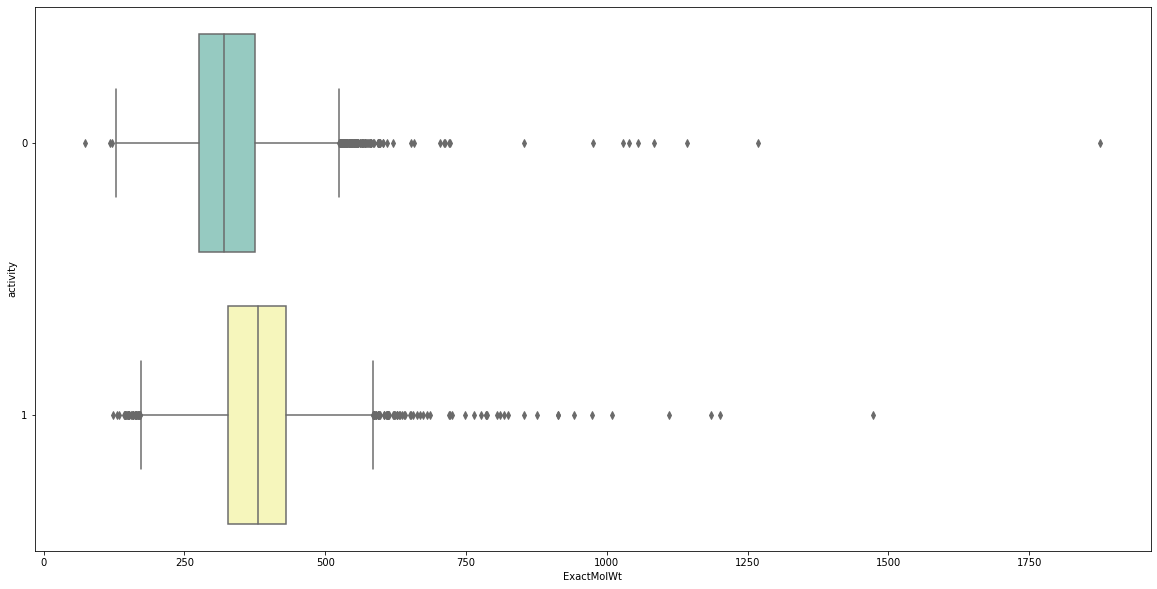

In [24]:
generate_box_plot("ExactMolWt", "activity", "", descript_data, "h")

In [25]:
moldes_1["ExactMolWt"].describe()

count    19991.000000
mean       379.758286
std         75.094157
min        123.079647
25%        327.174119
50%        380.083078
75%        430.200491
max       1472.581284
Name: ExactMolWt, dtype: float64

In [26]:
moldes_0["ExactMolWt"].describe()

count    19998.000000
mean       328.967866
std         77.149590
min         74.036779
25%        275.163377
50%        321.199625
75%        375.157620
max       1875.540932
Name: ExactMolWt, dtype: float64

Comparing both box plots, we can observe that the median molecular weight is slightly higher on the active molecules.

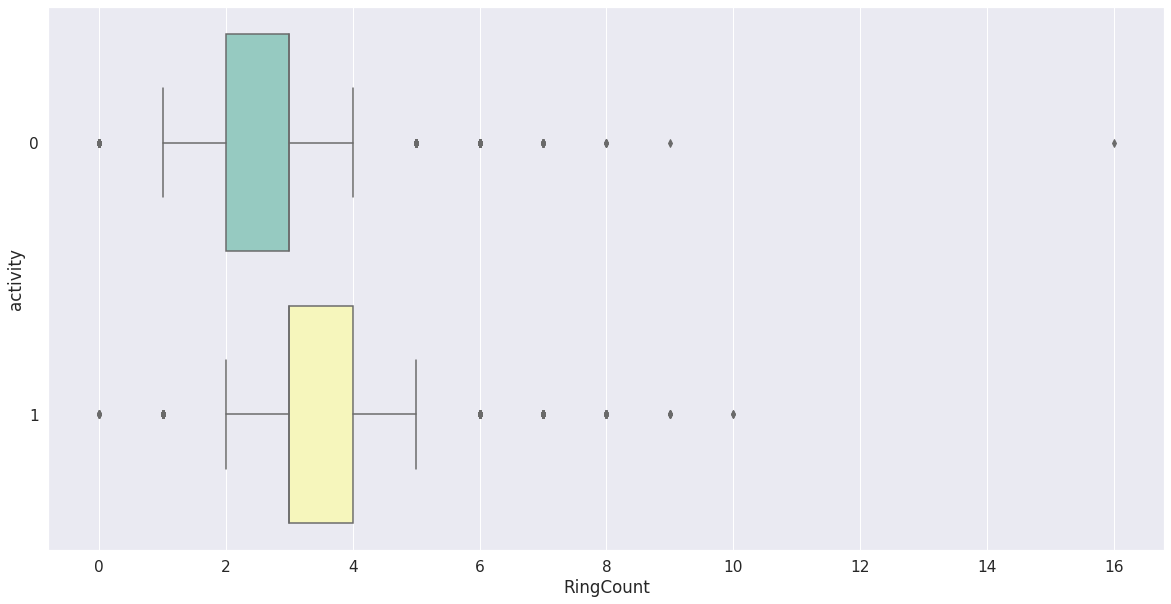

In [27]:
generate_box_plot("RingCount", "activity", "", descript_data, "h")

In [28]:
moldes_1["RingCount"].describe()

count    19991.000000
mean         3.465910
std          1.046983
min          0.000000
25%          3.000000
50%          3.000000
75%          4.000000
max         10.000000
Name: RingCount, dtype: float64

In [29]:
moldes_0["RingCount"].describe()

count    19998.000000
mean         2.732373
std          0.924939
min          0.000000
25%          2.000000
50%          3.000000
75%          3.000000
max         16.000000
Name: RingCount, dtype: float64

Comparing both box plots, we can observe that the median ring count is slightly higher on the active molecules.

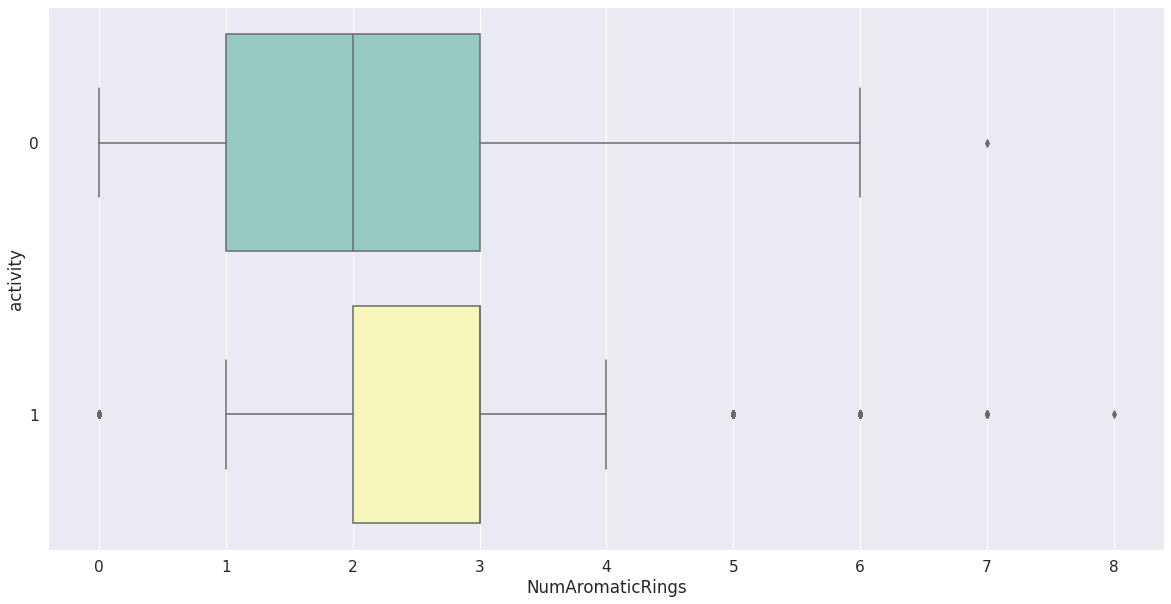

In [30]:
generate_box_plot("NumAromaticRings", "activity", "", descript_data, "h")

In [31]:
moldes_1["NumAromaticRings"].describe()

count    19991.000000
mean         2.682807
std          0.942246
min          0.000000
25%          2.000000
50%          3.000000
75%          3.000000
max          8.000000
Name: NumAromaticRings, dtype: float64

In [32]:
moldes_0["NumAromaticRings"].describe()

count    19998.000000
mean         2.047405
std          0.885365
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max          7.000000
Name: NumAromaticRings, dtype: float64

Comparing both box plots, we can observe that the median number of aromatic rings is slightly higher on the active molecules.

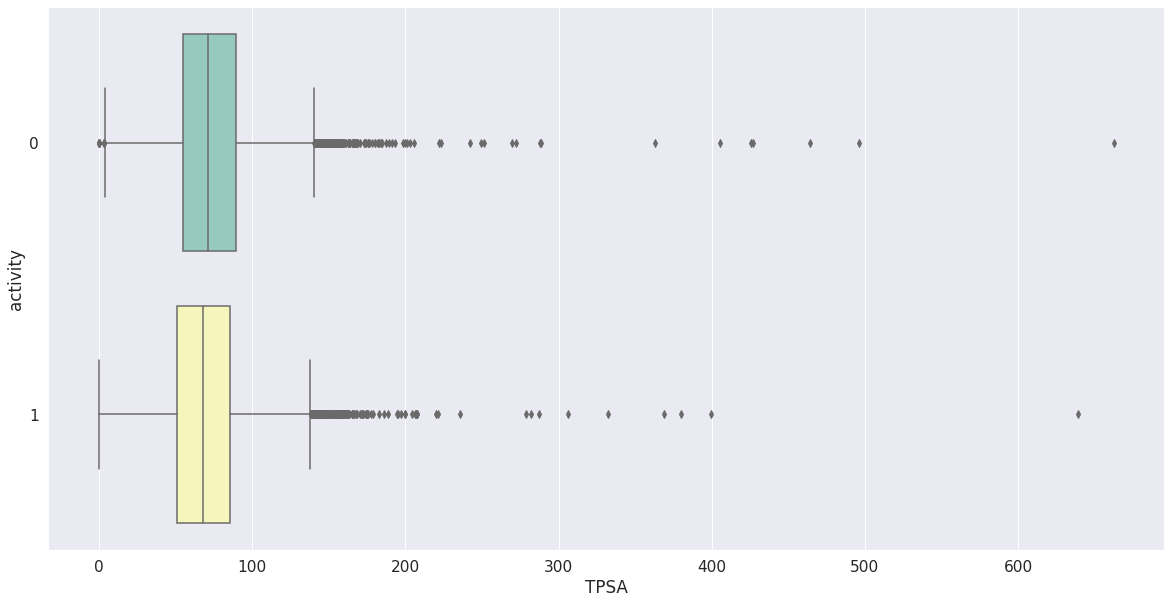

In [33]:
generate_box_plot("TPSA", "activity", "", descript_data, "h")

In [34]:
moldes_1["TPSA"].describe()

count    19991.000000
mean        69.189605
std         27.725162
min          0.000000
25%         50.750000
50%         68.020000
75%         85.610000
max        639.100000
Name: TPSA, dtype: float64

In [35]:
moldes_0["TPSA"].describe()

count    19998.000000
mean        73.075755
std         27.698442
min          0.000000
25%         54.880000
50%         71.090000
75%         89.130000
max        662.410000
Name: TPSA, dtype: float64

Unlike the previous results, we can observe that the active molecules have a slightly lower median topological polar surface area than the inactive ones.


#### Normalize Data

In [36]:
StandardScaler().fit_transform(dataset_des)

### Molecular Fingerprints

We are gonna study three different ways of constructing fingerprints.
MorganFingerprint, RDKFingerprint and MACCSkeysFingerprint.

In [37]:
dataset_morgan = copy.deepcopy(dataset_finger)
dataset_rdk = copy.deepcopy(dataset_finger)
dataset_macc = copy.deepcopy(dataset_finger)

In [38]:
MorganFingerprint().featurize(dataset_morgan)

Featurizing datapoint 0
Featurizing datapoint 1000
Featurizing datapoint 2000
Featurizing datapoint 3000
Featurizing datapoint 4000
Featurizing datapoint 5000
Featurizing datapoint 6000
Featurizing datapoint 7000
Featurizing datapoint 8000
Featurizing datapoint 9000
Featurizing datapoint 10000
Featurizing datapoint 11000
Featurizing datapoint 12000
Featurizing datapoint 13000
Featurizing datapoint 14000
Featurizing datapoint 15000
Featurizing datapoint 16000
Featurizing datapoint 17000
Featurizing datapoint 18000
Featurizing datapoint 19000
Featurizing datapoint 20000
Featurizing datapoint 21000
Featurizing datapoint 22000
Featurizing datapoint 23000
Featurizing datapoint 24000
Featurizing datapoint 25000
Featurizing datapoint 26000
Featurizing datapoint 27000
Featurizing datapoint 28000
Featurizing datapoint 29000
Featurizing datapoint 30000
Featurizing datapoint 31000
Featurizing datapoint 32000
Featurizing datapoint 33000
Featurizing datapoint 34000
Featurizing datapoint 35000
Featu

In [39]:
dataset_morgan.X.shape

(39990, 2048)

In [40]:
RDKFingerprint().featurize(dataset_rdk)

Featurizing datapoint 0
Featurizing datapoint 1000
Featurizing datapoint 2000
Featurizing datapoint 3000
Featurizing datapoint 4000
Featurizing datapoint 5000
Featurizing datapoint 6000
Featurizing datapoint 7000
Featurizing datapoint 8000
Featurizing datapoint 9000
Featurizing datapoint 10000
Featurizing datapoint 11000
Featurizing datapoint 12000
Featurizing datapoint 13000
Featurizing datapoint 14000
Featurizing datapoint 15000
Featurizing datapoint 16000
Featurizing datapoint 17000
Featurizing datapoint 18000
Featurizing datapoint 19000
Featurizing datapoint 20000
Featurizing datapoint 21000
Featurizing datapoint 22000
Featurizing datapoint 23000
Featurizing datapoint 24000
Featurizing datapoint 25000
Featurizing datapoint 26000
Featurizing datapoint 27000
Featurizing datapoint 28000
Featurizing datapoint 29000
Featurizing datapoint 30000
Featurizing datapoint 31000
Featurizing datapoint 32000
Featurizing datapoint 33000
Featurizing datapoint 34000
Featurizing datapoint 35000
Featu

In [41]:
dataset_rdk.X.shape

(39990, 2048)

In [42]:
MACCSkeysFingerprint().featurize(dataset_macc)

Featurizing datapoint 0
Featurizing datapoint 1000
Featurizing datapoint 2000
Featurizing datapoint 3000
Featurizing datapoint 4000
Featurizing datapoint 5000
Featurizing datapoint 6000
Featurizing datapoint 7000
Featurizing datapoint 8000
Featurizing datapoint 9000
Featurizing datapoint 10000
Featurizing datapoint 11000
Featurizing datapoint 12000
Featurizing datapoint 13000
Featurizing datapoint 14000
Featurizing datapoint 15000
Featurizing datapoint 16000
Featurizing datapoint 17000
Featurizing datapoint 18000
Featurizing datapoint 19000
Featurizing datapoint 20000
Featurizing datapoint 21000
Featurizing datapoint 22000
Featurizing datapoint 23000
Featurizing datapoint 24000
Featurizing datapoint 25000
Featurizing datapoint 26000
Featurizing datapoint 27000
Featurizing datapoint 28000
Featurizing datapoint 29000
Featurizing datapoint 30000
Featurizing datapoint 31000
Featurizing datapoint 32000
Featurizing datapoint 33000
Featurizing datapoint 34000
Featurizing datapoint 35000
Featu

In [43]:
dataset_macc.X.shape

(39990, 167)

Both Morgan and RDK fingerprint techniques produced **2048 features** while MACCSkeys produced only **167 features**.

## Feature Selection

Variance is the measurement of the spread between numbers in a variable. It measures how far a number is from the mean and every number in a variable.
The variance of a feature determines how much it is impacting the response variable. If the variance is low, it implies there is no impact of this feature on response and vice-versa.
To select the features with the most variance, we applied the boruta algorithm to the molecular descriptors and selected 10% of the highest ranking features of the molecular fingerprints.

### Molecular Descriptors

In [44]:
rf = RandomForestClassifier(n_jobs=-1)
feat_selector = BorutaPy(estimator=rf, max_iter=10, n_estimators=100)

feat_selector.fit(X=dataset_des.X, y=dataset_des.y)
X_filtered = feat_selector.transform(X=dataset_des.X)

In [45]:
features = []
for i in range(len(feat_selector.support_)):
    if feat_selector.support_[i] == True:
        features.append(header[i])

In [46]:
descript_data = pd.DataFrame(X_filtered, columns=features)
descript_data['activity'] = dataset_des.y
descript_data

MaxEStateIndex  MinEStateIndex  MaxAbsEStateIndex  MinAbsEStateIndex  \
0           -2.309058        1.056768          -2.309058           2.312571   
1           -0.403641        0.048231          -0.403641          -0.048228   
2            0.623985       -0.445262           0.623985          -0.849569   
3            0.366186       -0.339224           0.366186          -0.838786   
4            0.649409       -0.115829           0.649409          -0.629246   
...               ...             ...                ...                ...   
39984        0.537131       -2.013391           0.537131           0.256075   
39985        0.111571        0.185405           0.111571          -0.510782   
39986        0.904540        0.288651           0.904540          -0.558972   
39987        0.888645        0.321952           0.888645          -0.236677   
39988       -0.633836        0.869762          -0.633836           1.005882   

            qed     MolWt  HeavyAtomMolWt  ExactMolWt  MaxPartialCharge  \
0      0.735588 -1.020753       -0.987390   -1.025228         -1.766876   
1      0.315403  0.043725        0.030114    0.034173          0.553593   
2     -3.062047  3.758309        3.645877    3.762526          1.230107   
3     -2.274838  1.527398        1.569467    1.530413          0.885616   
4     -2.755876  2.314300        2.227825    2.315842          0.933521   
...         ...       ...             ...         ...               ...   
39984  0.686796  0.419833        0.387330    0.421016         -0.313068   
39985 -0.447139 -1.487964       -1.427513   -1.486574          0.074856   
39986 -0.756582  1.579072        1.412164    1.581587         -1.496971   
39987 -0.362638  1.404497        1.254401    1.406940         -1.496971   
39988  0.237715 -0.464519       -0.532754   -0.463304         -2.107540   

       MinPartialCharge  MaxAbsPartialCharge  MinAbsPartialCharge  \
0              0.780127            -0.828210            -1.817133   
1             -0.798850             0.788688             0.613304   
2             -0.542882             0.526572             1.321878   
3             -0.798838             0.788675             0.961062   
4             -0.471091             0.453057             1.011237   
...                 ...                  ...                  ...   
39984         -0.934755             0.927856            -0.294428   
39985          1.139343            -1.196053             0.111879   
39986         -1.098522             1.095556            -1.534437   
39987         -0.950347             0.943823            -1.534437   
39988         -1.142377             1.140464            -2.173942   

       FpDensityMorgan1  FpDensityMorgan2  FpDensityMorgan3  BCUT2D_MWHI  \
0              0.757854          1.327942          1.333505     0.598376   
1              0.984249          0.662511          0.339321     0.598453   
2             -2.091890         -2.386200         -2.220005    -0.769387   
3             -0.217442         -0.180368         -0.286731    -0.788016   
4             -0.993914         -0.859354         -0.810839     0.425762   
...                 ...               ...               ...          ...   
39984         -0.077852         -0.274021         -0.102833     0.361870   
39985          1.574653          1.158322          0.881561    -0.769395   
39986         -0.845599         -1.264070         -1.577693    -0.779807   
39987         -1.658509         -2.064451         -2.389656    -0.778110   
39988         -2.749701         -2.673885         -2.210761    -0.796423   

       BCUT2D_MWLOW  BCUT2D_CHGHI  BCUT2D_CHGLO  BCUT2D_LOGPHI  \
0          0.270698     -0.996417      0.926566      -0.027839   
1          0.850986     -0.890098     -0.208182      -0.402670   
2         -0.230429      1.371753     -1.056825      -0.035100   
3         -1.192306     -0.061999      0.253225      -0.210546   
4         -0.441730      0.834152     -0.600520      -0.342084   
...             ...

In [47]:
descript_data.shape

(39989, 81)

After the feature selection, the number o features was reduced almost in half, droping from 208 to **82 features**.
ExactMolWt, NumAromaticRings, RingCount and TPSA were maintained after feature selection.

### Molecular Fingerprints

In [48]:
dataset_morgan_fs = SelectPercentile(percentile=10).fit_transform(dataset_morgan.X, dataset_morgan.y)
dataset_morgan_fs.shape

(39990, 205)

In [49]:
dataset_rdk_fs = SelectPercentile(percentile=10).fit_transform(dataset_rdk.X, dataset_rdk.y)
dataset_rdk_fs.shape

(39990, 205)

In [50]:
dataset_macc_fs = SelectPercentile(percentile=10).fit_transform(dataset_macc.X, dataset_macc.y)
dataset_macc_fs.shape

/home/laptop16/anaconda3/envs/smiles/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  0   1   2   4   5   6   7   9  10  12  20  31  35 166] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/laptop16/anaconda3/envs/smiles/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


(39990, 17)

In [51]:
descript_data.to_csv("../dataset/binary_class/descriptors_fs.csv", index=False)

pd_morgan_fs = pd.DataFrame(dataset_morgan_fs)
pd_morgan_fs['activity'] = dataset_morgan.y
pd_morgan_fs.to_csv("../dataset/binary_class/morgan_fs.csv", index=False)

pd_rdk_fs = pd.DataFrame(dataset_rdk_fs)
pd_rdk_fs['activity'] = dataset_rdk.y
pd_rdk_fs.to_csv("../dataset/binary_class/rdk_fs.csv", index=False)

pd_macc_fs = pd.DataFrame(dataset_macc_fs)
pd_macc_fs['activity'] = dataset_macc.y
pd_macc_fs.to_csv("../dataset/binary_class/macc_fs.csv", index=False)

In [52]:
raise SystemError

SystemError: 

After the feature selection, the number o features was reduced from 2048 to **205 features** on the Morgan and RDK fingerprints. The MACCSkeysFingerprint was reduced to **17 features**.

## Unsupervised exploration

**Principal Component Analysis (PCA)** is a dimension-reduction tool and a statistical procedure that can be used to reduce a large set of variables to a small set that still contains most of the information of the large set. It uses an orthogonal transformation to convert a set of observations of possibly correlated variables into a set of values of linearly uncorrelated variables called principal components (PC). This procedure can explain the variance-covariance structure of the data.

**t-distributed Stochastic Neighbor Embedding (t-SNE)** is a tool to visualize high-dimensional data. It converts similarities between data points to joint probabilities and tries to minimize the Kullback-Leibler divergence between the joint probabilities of the low-dimensional embedding and the high-dimensional data.

**k-means clustering** is a method of vector quantization, originally from signal processing, that aims to partition n observations into k clusters in which each observation belongs to the cluster with the nearest mean (cluster centroid), serving as a prototype of the cluster.

### Descriptors

### Principal Component Analysis (PCA)

In [ ]:
pca = PCA(n_components=50)
df = pca.fit_transform(descript_data.values)

In [ ]:
plt.figure()
plt.plot(range(1, 51), np.cumsum(pca.explained_variance_ratio_ * 100))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)')
plt.title('Cumulative Explained Variance')
plt.xlim(1, 50)
plt.ylim(30, 100)
plt.axhline(y=95, color='r')
plt.axvline(x=29, color='g')
plt.show()
print(f'First 2 PC: {sum(pca.explained_variance_ratio_[0:2] * 100)}')

In [ ]:
pca.explained_variance_ratio_ * 100

In [ ]:
labels = dataset_des.y
plt.figure(figsize=(20, 20))
plt.xlabel('PC1 = 34.1% variance')
plt.ylabel('PC2 = 10.9% variance')
sns.scatterplot(
    df[:, 0], df[:, 1],
    hue=labels,
    palette=sns.color_palette("deep", 2),
    legend="full",
    s=25)

The first two principal components explain 45% of the data variance.
To explain 95% of the variance, 29 principal components are required.

The PCA graph shows that our data does not distribute well along the first principal component which explains 34% of the variance. The is a separation along the second principal component, which explains 10% of the variance. In general, it is difficult to distinguish between active and inactive molecules.

### t-distributed Stochastic Neighbor Embedding (t-SNE)

In [ ]:
tsne = TSNE(n_components=2)
tsne_df = tsne.fit_transform(df[:, 0:29])
labels = dataset_des.y
plt.figure(figsize=(20, 20))
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
sns.scatterplot(
    tsne_df[:, 0], tsne_df[:, 1],
    hue=labels,
    palette=sns.color_palette("deep", 2),
    legend="full",
    s=25)

From the t-SNE graph, we observe a small separation of the data along the first dimension.

### k-Means

In [ ]:
distortions = []
for i in range(1, 21):
    km = KMeans(
        n_clusters=i, init='k-means++',
        n_init=10, max_iter=300,
        tol=1e-04, random_state=0
    )
    km.fit(df)
    distortions.append(km.inertia_)

# plot
plt.plot(range(1, 21), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.title('Elbow Method')
plt.show()

In [ ]:
kmeans = KMeans(n_clusters=15)
kmeans_y = kmeans.fit_predict(df)

In [ ]:
u_labels = np.unique(kmeans_y)
#plotting the results:
plt.figure(figsize=(20, 20))
for i in u_labels:
    plt.scatter(df[kmeans_y == i, 0], df[kmeans_y == i, 1], label=i)
plt.legend()
plt.show()

Accordingly to the k-Means graph, there is no clear separation between the clusters.

### Fingerprints

In [ ]:
##Fazer Unsupervised para Fingerprints sendo que para os descritores não é necessário generate_similarities.
def generate_similarities(fps):
    similarities_list = []
    bv1 = DataStructs.ExplicitBitVect(fps.shape[1])

    new_fps = []
    for fp in fps:

        bv12 = copy.copy(bv1)
        for i, bit in enumerate(fp):
            if bit == 1:
               bv12.SetBit(i)
        new_fps.append(bv12)

    for i in range(0,1000):  # 2000
        remaining_fp = new_fps[:i] + new_fps[i+1:]
        similarities = DataStructs.BulkTanimotoSimilarity(new_fps[i], remaining_fp)
        similarities.insert(i,1)
        similarities_list.append(similarities)

    return np.transpose(np.array(similarities_list))

### MorganFingerprint

In [ ]:
similarities = generate_similarities(dataset_morgan_fs)

### Principal Component Analysis (PCA)

In [ ]:
pca = PCA(n_components=50)
df = pca.fit_transform(similarities)

In [ ]:
plt.figure()
plt.plot(range(1,51),np.cumsum(pca.explained_variance_ratio_ * 100))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)')
plt.title('Cumulative Explained Variance')
plt.xlim(1,50)
plt.ylim(30,100)
plt.axhline(y=95, color='r')
plt.axvline(x=34, color='g')
plt.show()
print(f'First 2 PC: {sum(pca.explained_variance_ratio_[0:2] * 100)}')

In [ ]:
pca.explained_variance_ratio_ * 100

In [ ]:
labels = dataset_morgan.y
plt.figure(figsize=(20, 20))
plt.xlabel('PC1 = 31.0% variance')
plt.ylabel('PC2 = 13.4% variance')
sns.scatterplot(
    df[:, 0], df[:, 1],
    hue=labels,
    palette=sns.color_palette("deep", 2),
    legend="full",
    s=25)

The first two principal components explain 44% of the data variance.
To explain 95% of the variance, 34 principal components are required.

The PCA graph shows that our data does not distribute well along the first two principal component which explains 44% of the variance. In general, it is difficult to distinguish between active and inactive molecules.

### t-distributed Stochastic Neighbor Embedding (t-SNE)

In [ ]:
tsne = TSNE(n_components=2)
tsne_df = tsne.fit_transform(df[:, 0:34])

In [ ]:
labels = dataset_morgan.y
plt.figure(figsize=(20, 20))
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
sns.scatterplot(
    tsne_df[:, 0], tsne_df[:, 1],
    hue=labels,
    palette=sns.color_palette("deep", 2),
    legend="full",
    s=25)

From the t-SNE graph, we observe that there is no clear separation between the dimensions.

### k-Means

In [ ]:
distortions = []
for i in range(1, 21):
    km = KMeans(
        n_clusters=i, init='k-means++',
        n_init=10, max_iter=300,
        tol=1e-04, random_state=0
    )
    km.fit(df)
    distortions.append(km.inertia_)

# plot
plt.plot(range(1, 21), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.title('Elbow Method')
plt.show()

In [ ]:
kmeans = KMeans(n_clusters=15)
kmeans_y = kmeans.fit_predict(df)

In [ ]:
u_labels = np.unique(kmeans_y)

#plotting the results:
plt.figure(figsize=(20, 20))
for i in u_labels:
    plt.scatter(df[kmeans_y == i , 0] , df[kmeans_y == i , 1] , label = i)
plt.legend()
plt.show()

Accordingly to the k-Means graph, there is no clear separation between the clusters.

### RDKFingerprint

In [ ]:
similarities = generate_similarities(dataset_rdk_fs)

### Principal Component Analysis (PCA)

In [ ]:
pca = PCA(n_components=50)
df = pca.fit_transform(similarities)

In [ ]:
plt.figure()
plt.plot(range(1,51),np.cumsum(pca.explained_variance_ratio_ * 100))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)')
plt.title('Cumulative Explained Variance')
plt.xlim(1,30)
plt.ylim(80,100)
plt.axhline(y=95, color='r')
plt.axvline(x=12, color='g')
plt.show()
print(f'First 2 PC: {sum(pca.explained_variance_ratio_[0:2] * 100)}')

In [ ]:
pca.explained_variance_ratio_ * 100

In [ ]:
labels = dataset_rdk.y
plt.figure(figsize=(20, 20))
plt.xlabel('PC1 = 83.8% variance')
plt.ylabel('PC2 = 4.6% variance')
sns.scatterplot(
    df[:, 0], df[:, 1],
    hue=labels,
    palette=sns.color_palette("deep", 2),
    legend="full",
    s=25)

The first two principal components explain 88% of the data variance.
To explain 95% of the variance, 12 principal components are required.

The PCA graph shows that our data has a small seperation along the first principal component which explains 83% of the variance. There is also a small separation of the data along the second principal component which explains 4% of the variance. Even though, the first two principal components explains 88% of the variance, it is still difficult to distinguish the molecules accordingly to their activity.

### t-distributed Stochastic Neighbor Embedding (t-SNE)

In [ ]:
tsne = TSNE()
tsne_df = tsne.fit_transform(df[:, 0:12])

In [ ]:
labels = dataset_rdk.y
plt.figure(figsize=(20, 20))
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
sns.scatterplot(
    tsne_df[:, 0], tsne_df[:, 1],
    hue=labels,
    palette=sns.color_palette("deep", 2),
    legend="full",
    s=25)

From the t-SNE graph, we observe that there is a small separation along the first dimension.

### k-Means

In [ ]:
distortions = []
for i in range(1, 11):
    km = KMeans(
        n_clusters=i, init='k-means++',
        n_init=10, max_iter=300,
        tol=1e-04, random_state=0
    )
    km.fit(df)
    distortions.append(km.inertia_)

# plot
plt.plot(range(1, 11), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

In [ ]:
kmeans = KMeans(n_clusters=8)
kmeans_y = kmeans.fit_predict(df)

In [ ]:
u_labels = np.unique(kmeans_y)

#plotting the results:
plt.figure(figsize=(20, 20))
for i in u_labels:
    plt.scatter(df[kmeans_y == i, 0], df[kmeans_y == i, 1], label=i)
plt.legend()
plt.show()

Accordingly to the k-Means graph, there is a clear separation between the clusters.

### MACCSkeysFingerprint

In [ ]:
similarities = generate_similarities(dataset_macc_fs)

### Principal Component Analysis (PCA)

In [ ]:
pca = PCA(n_components=50)
df = pca.fit_transform(similarities)

In [ ]:
plt.figure()
plt.plot(range(1, 51), np.cumsum(pca.explained_variance_ratio_ * 100))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)')
plt.title('Cumulative Explained Variance')
plt.xlim(1, 30)
plt.ylim(50, 100)
plt.axhline(y=95, color='r')
plt.axvline(x=9, color='g')
plt.show()
print(f'First 2 PC: {sum(pca.explained_variance_ratio_[0:2] * 100)}')

In [ ]:
pca.explained_variance_ratio_ * 100

In [ ]:
labels = dataset_macc.y
plt.figure(figsize=(20, 20))
plt.xlabel('PC1 = 53.6% variance')
plt.ylabel('PC2 = 10.8% variance')
sns.scatterplot(
    df[:, 0], df[:, 1],
    hue=labels,
    palette=sns.color_palette("deep", 2),
    legend="full",
    s=25)

The first two principal components explain 64% of the data variance.
To explain 95% of the variance, 9 principal components are required.

The PCA graph shows that our data does not distribute well along the first two principal component which explains 64% of the variance. In general, it is difficult to distinguish between active and inactive molecules.

### t-distributed Stochastic Neighbor Embedding (t-SNE)

In [ ]:
tsne = TSNE()
tsne_df = tsne.fit_transform(df[:, 0:9])

In [ ]:
labels = dataset_macc.y
plt.figure(figsize=(20, 20))
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
sns.scatterplot(
    tsne_df[:, 0], tsne_df[:, 1],
    hue=labels,
    palette=sns.color_palette("deep", 2),
    legend="full",
    s=25)

From the t-SNE graph, we observe that there is no separation of the data along the two dimensions.


### k-Means

In [ ]:
distortions = []
for i in range(1, 11):
    km = KMeans(
        n_clusters=i, init='k-means++',
        n_init=10, max_iter=300,
        tol=1e-04, random_state=0
    )
    km.fit(df)
    distortions.append(km.inertia_)

# plot
plt.plot(range(1, 11), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

In [ ]:
kmeans = KMeans(n_clusters=8)
kmeans_y = kmeans.fit_predict(df)
u_labels = np.unique(kmeans_y)

#plotting the results:
plt.figure(figsize=(10, 10))
for i in u_labels:
    plt.scatter(df[kmeans_y == i, 0], df[kmeans_y == i, 1], label=i)
plt.legend()
plt.show()

Accordingly to the k-Means graph, there is no clear separation between the clusters.

## Conclusion
From the TDP1 activity dataset, we extracted the SMILE and activity of all the molecules. Using the SMILE we were able to obtain two types of features: descriptors and fingerprints. These were related with the active state of the corresponding molecule. These two types of features were examined using PCA and clustering. However, these analysis were inconclusive. Therefore, it is difficult to distinguish the molecules according to their active state. Nonetheless, we think that it is possible to proceed to supervised learning using the descriptors and the RDKFingerprint technique (being this the one that achieved the better results). We trust that we can obtain better results in the classification of the molecules's active state.

# Machine Learning

In [ ]:
###Carregar Datasets

descriptors = pd.read_csv('../dataset/descriptors.csv')
fingerprint = pd.read_csv('../dataset/rdk_fs.csv')
Activity_Class = pd.read_csv('../dataset/TDP1_activity_dataset_binary_value.csv')

#Agrupar actividade M46 em classes, sendo que o minimo é da classe é -150 e o máximo é 50

##classe1 [-150, -100[ ##classe2[-100, -50[ ##classe3[-50, 0[  ##classe4 [0, 50]

for i in Activity_Class[:,'Activity at 46.23 uM']:
    if -150<=i< -100:
        Activity_Class[i,'Activity at 46.23 uM'] = 'Class1'
    elif -100 <= i < -50:
        Activity_Class[i,'Activity at 46.23 uM'] = 'Class2'
    elif -50 <= i < 0:
        Activity_Class[i,'Activity at 46.23 uM'] = 'Class3'
    elif 0 <= i < 50:
        Activity_Class[i,'Activity at 46.23 uM'] = 'Class4'
    else:
        print('Rafa is dumb')

## realizr pie chart para ver a igualdade das classes, se estão bem distribuidas ou não
class_activity = Activity_Class.groupby('Activity at 46.23 uM').size()
class_labels_activity = Activity_Class.groupby('Activity at 46.23 uM').size().index()

fig, (ax1) = plt.subplots(1, figsize=(15, 5))
ax1.pie(class_activity, labels=class_labels_activity, autopct='%1.1f%%', startangle=90)
ax1.set_title('Activity Classes')


##fazer machine learning :D
from sklearn.model_selection import train_test_split
from models.sklearnModels import SklearnModel
from metrics.Metrics import Metric
from metrics.metricsFunctions import r2_score, roc_auc_score, precision_score, accuracy_score, confusion_matrix, classification_report, f1_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
import random
from sklearn.metrics import (classification_report, confusion_matrix, accuracy_score, f1_score, recall_score,
                             balanced_accuracy_score, fbeta_score, matthews_corrcoef,
                             precision_recall_curve, PrecisionRecallDisplay, average_precision_score, auc,
                             RocCurveDisplay, roc_curve, precision_score, plot_confusion_matrix)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

def metrics(class_test, cv_predict, cv_predict_prob):
    precision, recall, thresholds = precision_recall_curve(class_test, cv_predict_prob[:, 1], pos_label=1)
    ap = average_precision_score(class_test, cv_predict_prob[:, 1], pos_label=1)
    disp = PrecisionRecallDisplay(precision=precision, recall=recall, average_precision=ap, estimator_name=None,
                                  pos_label=1)
    disp.plot()

    fpr, tpr, thresholds1 = roc_curve(class_test, cv_predict_prob[:, 1], pos_label=1)
    roc_auc = auc(fpr, tpr)
    disp1 = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name=None, pos_label=1)
    disp1.plot()

    # print(f"Average precision:\n{average_precision(class_test, cv_predict)}\n")
    print(f"Accuracy score:\n{accuracy_score(class_test, cv_predict)}\n")
    print(f"Balanced accuracy score:\n{balanced_accuracy_score(class_test, cv_predict)}\n")  # average of recall on each class
    # print(f"Top k accuracy score:\n{top_k_accuracy_score(class_test, cv_predict, k=1)}\n")
    print(f"F-beta (2.0) score:\n{fbeta_score(class_test, cv_predict, average='weighted', beta=2.0, pos_label=1)}\n")  # beta > 1 favors recall
    print(f"F1-score (mean):\n{f1_score(class_test, cv_predict, average='weighted')}\n")  # average of precision and recall
    print(f"F1-score (relevant):\n{f1_score(class_test, cv_predict, average='binary', pos_label=1)}\n")  # relevant label F-score
    print(f"Recall score (mean):\n{recall_score(class_test, cv_predict, average='macro')}\n")  # ability to find all positive samples (jsut for relevant)
    print(f"Recall score (relevant):\n{recall_score(class_test, cv_predict, average='binary', pos_label=1)}\n")  # ability to find all positive samples (jsut for relevant)
    print(f"Precison score (mean):\n{precision_score(class_test, cv_predict, average='macro', zero_division=0)}\n")
    print(f"Precison score (relevant):\n{precision_score(class_test, cv_predict, average='binary', pos_label=1, zero_division=0)}\n")
    print(f"Average precision score:\n{ap}\n")
    print(f"PR AUC score:\n{auc(recall, precision)}\n")
    print(f"ROC AUC score:\n{roc_auc}\n")
    print(f"MCC score:\n{matthews_corrcoef(class_test, cv_predict)}\n")  # +1 is perfect, 0 is random, -1 is inverse prediction
    print(f"Confusion matrix:\n{confusion_matrix(class_test, cv_predict)}\n")
    print(f"Classification report:\n{classification_report(class_test, cv_predict, zero_division=True)}\n")  # main classification metrics

rand = random.randrange(2147483647)
##fazer descriptors contra activity e comparar métodos de ML
#Data Split
descriptors_data = descriptors.drop("activity", axis=1)
descriptors_label = descriptors["activity"]

data_train, data_test, label_train, label_test = train_test_split(descriptors_data, descriptors_label, test_size=0.3) # 70% training and 30% test

#Scikit-Learn Random Forest
rf = RandomForestClassifier()

#wrapper around scikit learn models
model_rf = SklearnModel(model=rf)

# model training - FIT
model_rf.fit(data_train, label_train)

#cross validate model on the full dataset
kfold = StratifiedKFold(n_splits=10, random_state=rand, shuffle=True)
scores_scoring = cross_val_score(model_rf, X=data_train, y=label_train, cv=kfold, scoring='f1')

# PREDICT
cv_predict = model_rf.predict(X=data_test)

cv_predict_prob = model_rf.predict_proba(X=data_test)

#METRICS
metrics(label_test, cv_predict, cv_predict_prob)

#CONFUSION MATRIX
plot_confusion_matrix(rf, data_test, label_test)
plt.title("Random Forest - descriptors")
plt.show()




#Scikit-Learn SVM Classifier
svm = SVC(C=1.6, kernel='linear', class_weight='balanced', probability=True, random_state=rand)

#wrapper around scikit learn models
model_svm = SklearnModel(model=svm)

# model training
model_svm.fit(data_train, label_train)
#cross validate model on the full dataset
kfold = StratifiedKFold(n_splits=10, random_state=rand, shuffle=True)
scores_scoring = cross_val_score(model_svm, X=data_train, y=label_train, cv=kfold, scoring='f1')

# PREDICT
cv_predict = model_svm.predict(X=data_test)

cv_predict_prob = model_svm.predict_proba(X=data_test)

#METRICS
metrics(label_test, cv_predict, cv_predict_prob)

#CONFUSION MATRIX
plot_confusion_matrix(svm, data_test, label_test)
plt.title("SVM - descriptors")
plt.show()


##fazer fingerprints contra activity e comparar métodos de ML
#ADICIONAR COLUNA activity AOS DATASET fingerprint
loader = CSVLoader("../dataset/standardized.csv",
                   mols_field='mols',
                   labels_fields='y')

fingerprint["activity"] = loader.y
fingerprint

#Data Split
fingerprint_data = fingerprint.drop("activity", axis=1)
fingerprint_label = fingerprint["activity"]

data_train, data_test, label_train, label_test = train_test_split(fingerprint_data, fingerprint_label, test_size=0.3) # 70% training and 30% test

#Scikit-Learn Random Forest
rf = RandomForestClassifier()

#wrapper around scikit learn models
model_rf = SklearnModel(model=rf)

# model training - FIT
model_rf.fit(data_train, label_train)

#cross validate model on the full dataset
kfold = StratifiedKFold(n_splits=10, random_state=rand, shuffle=True)
scores_scoring = cross_val_score(model_rf, X=data_train, y=label_train, cv=kfold, scoring='f1')

# PREDICT
cv_predict = model_rf.predict(X=data_test)

cv_predict_prob = model_rf.predict_proba(X=data_test)

#METRICS
metrics(label_test, cv_predict, cv_predict_prob)

#CONFUSION MATRIX
plot_confusion_matrix(rf, data_test, label_test)
plt.title("Random Forest - fingerprint")
plt.show()




#Scikit-Learn SVM Classifier
svm = SVC(C=1.6, kernel='linear', class_weight='balanced', probability=True, random_state=rand)

#wrapper around scikit learn models
model_svm = SklearnModel(model=svm)

# model training
model_svm.fit(data_train, label_train)
#cross validate model on the full dataset
kfold = StratifiedKFold(n_splits=10, random_state=rand, shuffle=True)
scores_scoring = cross_val_score(model_svm, X=data_train, y=label_train, cv=kfold, scoring='f1')

# PREDICT
cv_predict = model_svm.predict(X=data_test)

cv_predict_prob = model_svm.predict_proba(X=data_test)

#METRICS
metrics(label_test, cv_predict, cv_predict_prob)

#CONFUSION MATRIX
plot_confusion_matrix(svm, data_test, label_test)
plt.title('SVM - fingerprint')
plt.show()
##fazer uma conclusão para saber qual o melhor para prever atividade os fungerprints ou os descriptores


##fazer descritores contra classe e comparar métodos de ML
Activity_Class_compare = copy.deepcopy(Activity_Class)
Activity_Class_compare.drop(axis= 0, index = 5182)

descriptors_compare = copy.deepcopy(descriptors)
descriptors_compare.drop(labels="activity", axis = 1)
descriptors_compare["Activity at 46.23 uM"] = Activity_Class_compare["Activity at 46.23 uM"] #TESTAR????

##fazer fingerprints contra classe e comparar métodos de ML

##fazer uma conclusão para saber qual o melhor para prever binário os fingerprints ou os descriptores

##junção de Activity at 46.23 uM a tabela dos descritores, atenção pois houve uma molécula removida dos descritores devido a NA's, por isso atenção na adição da coluna.

##fazer então a partir dos descritores a previsão direta da Activity.
